In [1]:
# !pip install tqdm

In [2]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from transformers import ViTForImageClassification
from scipy import stats



label_to_int = {'Goed': 0, 'Matig': 1, 'Redelijk': 2, 'Slecht': 3, 'Zeer_slecht': 4, 'Dood': 5}

class CustomImageDataset1(Dataset):
    def __init__(self, images, labels, transforms=None, samples_per_class=None):
        self.images = images
        self.labels = [label_to_int[label] for label in labels]
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        if self.transforms:
            image = self.transforms(image)

        return image, label

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transforms=None, sampling_factors=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.sampling_factors = sampling_factors if sampling_factors is not None else {label: 1 for label in set(labels)}

    def __len__(self):
        # Calculate total length considering sampling factors
        total_length = 0
        for label in self.labels:
            total_length += self.sampling_factors[label]
        return total_length

    def __getitem__(self, idx):
        # Find the actual image index based on the sampling factor
        actual_idx = idx
        for i, label in enumerate(self.labels):
            if actual_idx < self.sampling_factors[label]:
                break
            actual_idx -= self.sampling_factors[label]


        image = Image.open(self.images[i])
        label = self.labels[i]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        # Process image
        if self.transforms:
            image = self.transforms(image)

        return image, label_to_int[label]

def load_images(folder_path):
    print("Loading images...")

    images = []
    labels = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            images.append(img_path)
            labels.append(class_folder)
    print("Total images loaded:", len(images))
    return images, labels

def split_dataset(images, labels, train_ratio=0.6, val_ratio=0.2):
    # Split dataset into train, validation, and test
    print("Splitting dataset...")
    dataset = list(zip(images, labels))
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    train_set = dataset[:train_size]
    val_set = dataset[train_size:train_size + val_size]
    test_set = dataset[train_size + val_size:]
    print(f"Dataset split into {len(train_set)} training, {len(val_set)} validation, and {len(test_set)} test images.")
    return train_set, val_set, test_set

def count_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

def calculate_sampling_factors(train_set):
    label_counts = Counter(label for _, label in train_set)
    min_samples = min(label_counts.values())

    # Calculate sampling factor for each class
    sampling_factors = {label: round(100*(min_samples / count)) for label, count in label_counts.items()}
    return sampling_factors

def create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size):
    # Define transformations
    print("Creating dataloaders...")

    train_transforms = transforms.Compose([
        transforms.RandomCrop(224),  # Specify size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = CustomImageDataset([i[0] for i in train_set], [i[1] for i in train_set], transforms=train_transforms, sampling_factors=sampling_factors)
    val_dataset = CustomImageDataset([i[0] for i in val_set], [i[1] for i in val_set], transforms=val_test_transforms)
    test_dataset = CustomImageDataset([i[0] for i in test_set], [i[1] for i in test_set], transforms=val_test_transforms)
    # print('Dataset', train_dataset[0])
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Dataloaders created.")
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

def calculate_samples_per_class(class_distribution):
    min_count = min(class_distribution.values())
    samples_per_class = {label_to_int[cls]: min_count // count for cls, count in class_distribution.items()}
    return samples_per_class



def load_data(folder1):
    images, labels = load_images(folder1)
    train_set, val_set, test_set = split_dataset(images, labels)

    # Print class distribution
    train_class_distribution = count_class_distribution(train_set)
    val_class_distribution = count_class_distribution(val_set)
    test_class_distribution = count_class_distribution(test_set)

    print("Training set class distribution:", train_class_distribution)
    print("Validation set class distribution:", val_class_distribution)
    print("Test set class distribution:", test_class_distribution)

    sampling_factors = calculate_sampling_factors(train_set)
#     sampling_factors = {'rice': 1, 'other': 2, 'sugarcane': 6, 'cassava': 12, 'maize': 10}
#     sampling_factors = {'Goed': 7, 'Matig': 7, 'Redelijk': 7, 'Slecht': 7, 'Zeer Slecht': 7}
    #sampling_factors = {'goed': 30, 'matige': 1, 'Redelijk': 1, 'slecht': 30, 'Zeer_slecht': 30, 'dood': 30}
    print('Sampling factors: ', sampling_factors)
    train_loader, val_loader, test_loader = create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size=8)

    return train_loader, val_loader, test_loader

In [3]:
def extract_patches(image, patch_size, stride):
    patches = []
    c, height, width = image.size()

    for y in range(0, height - patch_size[1] + 1, stride):
        for x in range(0, width - patch_size[0] + 1, stride):
            patch = image[:, y:y + patch_size[1], x:x + patch_size[0]]
            patches.append(patch)

    return patches

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in progress_bar:

        images = images.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(images)

        #For ViT
        logits = outputs.logits  # Extract the logits
        loss = criterion(logits, labels)

        # loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        # _, predicted = torch.max(outputs, 1)
        _, predicted = torch.max(outputs.logits, 1)

        correct = (predicted == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item(), accuracy=correct/len(labels))

        total_loss += loss.item()
        total_correct += correct
        total_samples += labels.size(0)

        # For F1 score calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    return avg_loss, accuracy, f1, per_class_f1



def validate_or_test(model, loader, criterion, device, patch_size, stride, desc='Val'):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            batch_preds = []

            for image in images:
                # # Apply sliding window approach
                # patches = extract_patches(image, patch_size, stride)
                # patches = torch.stack(patches).to(device)

                # # Aggregate predictions for each patch
                # patch_outputs = model(patches)
                # logits = patch_outputs.logits  # Extract the logits
                # patch_predictions = torch.mean(logits, dim=0)
                # patch_predictions = torch.mean(patch_outputs, dim=0)
                # batch_preds.append(patch_predictions)

                # Calculate the mode of the patch predictions

                patches = extract_patches(image, patch_size, stride)
                patches = torch.stack(patches).to(device)

                # Aggregate predictions for each patch
                patch_outputs = model(patches)
                logits = patch_outputs.logits  # Extract the logits

                # Calculate mode for each patch prediction
                modes, _ = torch.mode(logits, dim=0)
                batch_preds.append(modes)

            print(batch_preds)
            batch_preds = torch.stack(batch_preds)
            loss = criterion(batch_preds, labels)
            total_loss += loss.item()

            _, predicted = torch.max(batch_preds, 1)
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return avg_loss, accuracy, f1, per_class_f1

import matplotlib.pyplot as plt
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_and_evaluate(model, train_loader, val_loader, test_loader, model_name, num_epochs=5, patch_size=(224, 224), stride=30):
    # Criterion, Optimizer, and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-04)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    global best_val_f1
    global best_model_weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):

        train_loss, train_accuracy, train_f1, train_f1_per_class = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}')
        print(f'Train F1 Score Per Class ', train_f1_per_class)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy, val_f1, val_f1_per_class = validate_or_test(model, val_loader, criterion, device, patch_size, stride, desc='Val')
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')
        print(f'Val F1 Score Per Class ', val_f1_per_class)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_weights = model.state_dict()  # Save the best model weights

        # Save intermediate model weights
        torch.save(model.state_dict(), '/kaggle/working/'+f'{model_name}_epoch_{epoch}.pth')

        scheduler.step()

        # Plot train and validation accuracy
        plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train and Validation Accuracy')
        plt.legend()
        plt.show()
        plt.savefig(f'/kaggle/working/train_val_accuracy_epoch_{epoch + 1}.png')
        plt.close()

        # Plot train and validation loss
        plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train and Validation Loss')
        plt.legend()
        plt.show()
        plt.savefig(f'/kaggle/working/train_val_loss_epoch_{epoch + 1}.png')
        plt.close()

    test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(model, test_loader, criterion, device, patch_size, stride, desc='Test')
    print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
    print(f'Test F1 Score Per Class ', test_f1_per_class)

    # After training is complete, load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model weights
    torch.save(model.state_dict(), '/kaggle/working/'+f'{model_name}.pth')

    return model


Loading images...
Total images loaded: 2885
Splitting dataset...
Dataset split into 1731 training, 577 validation, and 577 test images.
Training set class distribution: {'Slecht': 566, 'Matig': 417, 'Redelijk': 413, 'Goed': 207, 'Dood': 111, 'Zeer_slecht': 17}
Validation set class distribution: {'Goed': 74, 'Slecht': 177, 'Matig': 133, 'Dood': 36, 'Redelijk': 154, 'Zeer_slecht': 3}
Test set class distribution: {'Redelijk': 125, 'Slecht': 183, 'Goed': 77, 'Matig': 146, 'Zeer_slecht': 9, 'Dood': 37}
Sampling factors:  {'Slecht': 3, 'Matig': 4, 'Redelijk': 4, 'Goed': 8, 'Dood': 15, 'Zeer_slecht': 100}
Creating dataloaders...
Dataloaders created.
1255 73 73


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 1.1522, Accuracy: 0.5194, F1 Score: 0.5121
Train F1 Score Per Class  [0.49323308 0.37202105 0.37095826 0.28590514 0.9154519  0.62987013]


Val:   1%|▏         | 1/73 [00:00<00:51,  1.39it/s, loss=1.84]

[tensor([ 1.6912,  0.2162,  0.9598,  0.5012, -3.6687, -1.8738], device='cuda:0'), tensor([ 2.2369, -0.6528,  0.6370,  0.6910, -2.8562, -1.1593], device='cuda:0'), tensor([-0.3200,  0.6715,  0.3573,  1.1096, -3.4691, -1.6343], device='cuda:0'), tensor([-1.1750,  0.6403,  1.5479,  1.1175, -3.8688, -1.0561], device='cuda:0'), tensor([ 2.6748, -0.6322,  0.5240,  0.6676, -2.5892, -1.6396], device='cuda:0'), tensor([ 0.1457,  0.0116,  0.8703,  0.2498, -2.9357, -2.5003], device='cuda:0'), tensor([-0.7401,  0.0198,  0.2282,  0.6072, -1.2177, -0.7328], device='cuda:0'), tensor([ 1.3869, -0.0810,  1.2302,  0.8608, -2.8820, -2.3958], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:01<00:39,  1.78it/s, loss=2.39]

[tensor([-0.5121,  1.3428,  1.1222,  1.4374, -3.1812, -2.4937], device='cuda:0'), tensor([-0.2084,  0.7530,  1.5914,  1.6480, -3.6981, -2.2539], device='cuda:0'), tensor([ 2.7772, -0.1962,  0.4194,  0.5287, -2.5113, -2.1446], device='cuda:0'), tensor([-0.5452, -0.2206,  0.6880,  0.8815, -2.3033, -1.5473], device='cuda:0'), tensor([-0.3497,  1.1978,  0.5519,  1.9540, -2.5421, -1.9384], device='cuda:0'), tensor([ 1.7257, -0.5689,  0.5333,  0.4552, -2.7340, -1.8558], device='cuda:0'), tensor([ 0.2802,  0.1920,  0.9771,  0.9570, -3.4630, -0.5598], device='cuda:0'), tensor([-0.1434,  0.5899,  0.5660,  1.3149, -2.9808, -1.6939], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:36,  1.94it/s, loss=1.1]

[tensor([-0.7774,  0.7639,  1.8747,  1.3990, -3.0154, -1.9371], device='cuda:0'), tensor([ 1.0241, -0.4313,  0.6765,  0.4217, -2.0093, -2.1536], device='cuda:0'), tensor([-0.7853,  2.1027,  1.0976,  0.6475, -2.1860, -2.4909], device='cuda:0'), tensor([-0.8318,  1.4076,  1.6779,  0.3887, -2.6673, -2.0713], device='cuda:0'), tensor([-0.3120,  0.6456,  0.7073,  1.4475, -2.9505, -1.2455], device='cuda:0'), tensor([-0.8239,  1.4128,  1.1651,  0.9733, -3.0515, -2.2598], device='cuda:0'), tensor([-0.9067,  1.1887,  1.5320,  1.2576, -3.4903, -1.9692], device='cuda:0'), tensor([ 1.6512, -0.1923,  0.8471,  0.9135, -2.9638, -2.5630], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:02<00:34,  1.99it/s, loss=1.22]

[tensor([ 0.3055,  0.0697,  0.2556,  1.0514, -3.4550, -0.6820], device='cuda:0'), tensor([-0.6844,  1.1568,  1.6436,  1.3691, -2.4367, -2.3816], device='cuda:0'), tensor([-1.2404,  0.7615,  1.7732,  1.4639, -2.8536, -1.3915], device='cuda:0'), tensor([-0.4019,  0.3430,  0.5505,  0.4066, -3.4582, -1.3443], device='cuda:0'), tensor([-0.1562,  0.7520,  1.7774,  0.7375, -3.7856, -1.7882], device='cuda:0'), tensor([-0.7975,  0.5444,  1.7171,  1.0334, -3.4204, -1.6200], device='cuda:0'), tensor([-0.6925, -0.1824,  0.5143,  0.6434, -3.5539,  1.0343], device='cuda:0'), tensor([-0.8763,  0.1631,  1.2212,  0.5503, -3.3638, -1.3593], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:32,  2.07it/s, loss=2.49]

[tensor([-0.3699, -0.6131,  0.3416,  0.1212, -3.5647, -0.8523], device='cuda:0'), tensor([-0.7620,  0.0349,  1.1054,  1.3257, -2.9459, -0.2745], device='cuda:0'), tensor([-0.8844,  1.1354,  0.3223,  0.8937, -3.2276, -1.0772], device='cuda:0'), tensor([-0.6786,  0.6116,  2.3595,  0.7651, -2.6259, -1.7360], device='cuda:0'), tensor([ 0.6384, -1.0173,  0.1806,  0.0333, -2.9535, -0.7721], device='cuda:0'), tensor([-0.6171,  0.6192,  1.1674,  1.3778, -2.5120, -1.7070], device='cuda:0'), tensor([-0.3874,  1.1105,  1.2256,  1.2186, -3.1128, -2.1190], device='cuda:0'), tensor([-0.8537,  0.0564,  1.7095,  1.0614, -3.6609, -0.7658], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:03<00:31,  2.11it/s, loss=1.52]

[tensor([-0.2843,  0.0354, -0.2284,  1.2763, -3.1711, -2.1542], device='cuda:0'), tensor([-0.6777,  1.2290,  0.8011,  1.1131, -3.0937, -1.9891], device='cuda:0'), tensor([-1.2838,  0.3546,  1.0278,  0.7883, -2.7274, -0.0355], device='cuda:0'), tensor([ 0.6527, -0.1740,  1.0427,  0.7819, -3.9464, -1.7692], device='cuda:0'), tensor([ 0.3064,  0.6244,  0.8123,  0.9963, -3.6689, -1.3366], device='cuda:0'), tensor([-1.1592,  1.2226,  1.7902,  1.1821, -2.8869, -1.8296], device='cuda:0'), tensor([-0.7076,  0.4622,  0.3668,  1.0314, -3.0700, -1.3286], device='cuda:0'), tensor([ 0.8002,  0.3102,  0.2595,  0.5851, -3.3778, -1.7374], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.14it/s, loss=1.15]

[tensor([ 0.0165,  0.0930,  1.1608,  0.8645, -4.1688, -2.3996], device='cuda:0'), tensor([-0.9070,  0.1143,  2.0793,  1.2775, -3.4619, -1.0072], device='cuda:0'), tensor([ 0.0315, -0.5830, -0.2064,  0.2648, -2.5882,  0.1218], device='cuda:0'), tensor([-1.1673,  1.4006,  0.9528,  1.1651, -2.2609, -1.8438], device='cuda:0'), tensor([-0.1571, -0.0230,  0.8834,  0.8905, -2.9357, -1.9544], device='cuda:0'), tensor([ 0.6793, -0.5118,  0.5192,  0.2933, -3.3703, -1.5448], device='cuda:0'), tensor([-0.8221, -0.2722, -0.3311, -0.1666, -3.4977,  0.6766], device='cuda:0'), tensor([-0.2359,  0.4337,  2.0368,  1.4327, -2.9399, -2.0637], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:29,  2.17it/s, loss=1.74]

[tensor([-0.3903,  1.0859,  0.9600,  1.5928, -2.5651, -2.2602], device='cuda:0'), tensor([-0.6476,  1.0809, -0.0761,  1.1183, -0.4935, -1.7003], device='cuda:0'), tensor([ 2.3134, -0.3404,  0.0544,  0.4167, -3.2296, -2.0013], device='cuda:0'), tensor([-0.1857,  0.8314,  1.1847,  1.8106, -3.2073, -2.3254], device='cuda:0'), tensor([-0.6545,  0.8804,  0.8425,  1.0872, -3.3289, -1.6513], device='cuda:0'), tensor([-0.5378, -0.2281,  1.1182,  1.7402, -3.1157, -1.0942], device='cuda:0'), tensor([ 2.7340, -0.6656,  0.3243,  0.4714, -2.8434, -1.7999], device='cuda:0'), tensor([-1.4643,  0.8666,  0.3902,  1.3059, -1.3588, -1.8327], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.18it/s, loss=1.68]

[tensor([-1.2510,  1.2906,  1.5870,  1.1277, -3.0741, -1.4589], device='cuda:0'), tensor([-0.6377,  0.4809,  0.8877,  1.6013, -2.2916, -1.8884], device='cuda:0'), tensor([ 3.1309, -0.1723,  0.1906,  0.5954, -2.2017, -2.1005], device='cuda:0'), tensor([-1.2486,  1.3391,  1.3659,  1.2871, -3.1378, -1.6878], device='cuda:0'), tensor([-0.5771, -0.5474,  0.8401,  0.7787, -3.7367, -0.5415], device='cuda:0'), tensor([ 0.1390,  0.0528,  0.8488,  1.5015, -3.6669, -1.5550], device='cuda:0'), tensor([-1.3267,  0.5312,  1.8081,  0.6141, -2.7472, -1.1888], device='cuda:0'), tensor([-0.9533,  0.2049,  1.4089,  0.9213, -4.2137, -0.4198], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:28,  2.19it/s, loss=2.23]

[tensor([-0.8843,  1.3010,  1.8913,  1.4445, -3.1339, -2.2071], device='cuda:0'), tensor([ 0.1723, -1.0831, -0.3175, -0.3299, -2.9422,  2.6755], device='cuda:0'), tensor([-0.4417,  1.4118,  1.7155,  0.5611, -2.8915, -2.3159], device='cuda:0'), tensor([-0.7738,  0.6487,  2.0311,  1.2989, -3.0627, -2.5562], device='cuda:0'), tensor([-0.8629,  1.1093,  1.4869,  0.7639, -3.3514, -2.1875], device='cuda:0'), tensor([-0.9659,  1.7203,  1.3465,  1.1063, -3.0875, -2.3891], device='cuda:0'), tensor([ 0.0259,  0.3620,  0.6197,  1.3257, -2.3444, -2.5744], device='cuda:0'), tensor([ 1.4611,  0.0742,  1.5682,  0.8162, -2.9674, -2.2556], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.19it/s, loss=1.53]

[tensor([ 0.3009,  1.0929,  1.4499,  0.9073, -2.9866, -2.5251], device='cuda:0'), tensor([-0.8307,  0.1998,  1.0363,  0.9584, -2.6170, -1.2713], device='cuda:0'), tensor([-1.3014,  0.3612,  1.2054,  0.9004, -2.8454, -1.6035], device='cuda:0'), tensor([-0.5075, -0.3354,  0.8174,  1.0302, -3.4759,  0.8167], device='cuda:0'), tensor([ 0.8009,  0.2465,  0.2943,  0.7397, -3.0716, -2.5714], device='cuda:0'), tensor([-0.7829,  1.0261,  1.5530,  1.2658, -3.2522, -1.5997], device='cuda:0'), tensor([-0.7994,  1.6811,  1.7784,  0.6261, -2.6082, -2.1079], device='cuda:0'), tensor([-0.8729,  0.6661,  0.8420,  0.9435, -3.5466, -0.7597], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:27,  2.19it/s, loss=1.38]

[tensor([ 0.9333,  0.1383,  0.5937,  0.8340, -3.6292, -1.8389], device='cuda:0'), tensor([-0.7600,  1.1391,  1.1019,  1.1381, -3.3550, -2.1480], device='cuda:0'), tensor([-2.6086e-03,  2.4633e-01,  1.0217e+00,  1.3125e+00, -3.5428e+00,
        -1.2773e+00], device='cuda:0'), tensor([ 2.0803, -0.6540, -0.2179,  0.6476, -3.2559, -0.9735], device='cuda:0'), tensor([ 1.7616,  0.3933,  0.7690,  1.3038, -3.3135, -2.5427], device='cuda:0'), tensor([ 0.1752,  0.8116,  1.3534,  0.4600, -3.3426, -2.2575], device='cuda:0'), tensor([ 0.6162,  0.6003,  0.9877,  1.2717, -3.8597, -1.9456], device='cuda:0'), tensor([ 5.1480e-04,  9.0943e-02,  1.2788e+00,  1.4307e+00, -3.8578e+00,
        -1.7859e+00], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.19it/s, loss=1.87]

[tensor([-0.4444,  0.9450, -0.0106,  0.8606, -0.2555, -1.4907], device='cuda:0'), tensor([ 1.1380, -0.0760,  0.5665,  0.5400, -3.1163, -2.3761], device='cuda:0'), tensor([ 0.7854, -0.0913, -0.1111,  0.8120, -3.9503, -1.7698], device='cuda:0'), tensor([-0.6653,  0.9133,  1.1177,  1.3609, -3.1696, -1.5163], device='cuda:0'), tensor([-0.1022,  1.0516,  1.4086,  1.3654, -3.2191, -2.5335], device='cuda:0'), tensor([ 2.4140, -0.5259, -0.1191,  0.6439, -2.3866, -1.9943], device='cuda:0'), tensor([-1.4060,  0.6162,  0.2877, -0.3056, -3.3445, -1.1742], device='cuda:0'), tensor([-0.3238, -0.4068,  0.6119,  0.3492, -3.0801, -0.5923], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.18it/s, loss=2.12]

[tensor([ 0.8618,  0.3544,  1.3846,  0.6219, -3.3809, -2.2249], device='cuda:0'), tensor([ 0.3361,  0.6777,  1.2112,  1.0259, -2.9279, -2.9399], device='cuda:0'), tensor([ 1.4962, -0.1177,  0.5669,  1.0126, -3.2228, -2.2111], device='cuda:0'), tensor([-0.4331,  0.0845,  1.9729,  1.2827, -3.2929, -1.8060], device='cuda:0'), tensor([-0.8594,  1.2515,  0.8337,  1.8523, -2.8420, -2.1273], device='cuda:0'), tensor([ 0.5915, -0.3260,  0.4401,  0.8592, -3.3626, -1.7454], device='cuda:0'), tensor([-0.1934,  1.0399,  1.6783,  0.4946, -2.9272, -1.8867], device='cuda:0'), tensor([ 2.4943,  0.0442,  0.1865,  0.3643, -2.9826, -2.2562], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:26,  2.20it/s, loss=1.85]

[tensor([-0.2656,  1.0328,  1.7600,  1.3546, -2.8869, -2.7572], device='cuda:0'), tensor([-0.5263,  0.1352,  0.7035,  0.6710, -2.9326, -1.3041], device='cuda:0'), tensor([-0.3250, -0.9875, -0.2508, -0.5100, -2.1074,  2.3973], device='cuda:0'), tensor([ 0.4379,  0.7395,  0.8965,  0.3865, -2.4647, -2.6387], device='cuda:0'), tensor([-0.7313, -0.4092,  0.5198, -0.3796, -2.8996,  2.9227], device='cuda:0'), tensor([ 1.3894, -0.6633,  0.9581,  0.5094, -3.7857, -1.0780], device='cuda:0'), tensor([-1.0415,  0.8147,  0.2401,  1.1419, -2.0018, -1.2448], device='cuda:0'), tensor([-0.4468,  0.9018,  1.1266,  1.6593, -2.8580, -2.3491], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:25,  2.20it/s, loss=2.08]

[tensor([ 2.3127, -0.0463,  0.5415,  0.8253, -2.8902, -2.0731], device='cuda:0'), tensor([-0.5247,  0.8614,  1.9758,  1.0412, -3.3578, -1.8792], device='cuda:0'), tensor([-0.8711, -0.0535,  0.6113, -0.2512, -2.8062,  2.3980], device='cuda:0'), tensor([-0.3548,  0.1515,  1.7305,  1.5440, -3.3376, -1.4278], device='cuda:0'), tensor([ 1.9518, -0.5399,  0.5669,  0.5556, -3.1125, -1.7177], device='cuda:0'), tensor([ 0.1529, -0.1209,  0.8056,  1.3407, -3.3912, -1.8965], device='cuda:0'), tensor([-1.2848,  0.9476,  0.6522,  0.7864, -3.0561, -1.2430], device='cuda:0'), tensor([ 1.0464, -0.6868, -0.9355,  0.0226, -2.6551, -1.0345], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:08<00:25,  2.18it/s, loss=2.55]

[tensor([ 1.3983,  0.2548,  0.7389,  0.8543, -3.3469, -1.4032], device='cuda:0'), tensor([ 1.6114,  0.5938,  0.3703,  1.3219, -3.2822, -2.1014], device='cuda:0'), tensor([-0.6877,  0.2204,  0.4500, -0.1258, -3.3492, -0.8928], device='cuda:0'), tensor([-0.9485,  0.8669,  1.8491,  0.7512, -2.7242, -1.7839], device='cuda:0'), tensor([ 0.2711,  0.6452,  1.6222,  0.4593, -3.0287, -1.9281], device='cuda:0'), tensor([-0.4683,  1.0359,  1.7726,  0.9162, -2.9662, -2.1665], device='cuda:0'), tensor([-0.4344,  0.5958,  1.3184,  1.1258, -3.7997, -1.4183], device='cuda:0'), tensor([-1.0197,  0.6403,  1.8735,  1.1368, -3.2438, -1.5198], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.19it/s, loss=1.84]

[tensor([-0.4394,  1.0174,  0.6381,  1.9664, -2.9322, -1.8331], device='cuda:0'), tensor([-0.0920, -0.0422,  0.8577,  1.0370, -2.4317, -1.8104], device='cuda:0'), tensor([ 0.7012,  0.1162,  1.0694,  1.5789, -3.0705, -1.8400], device='cuda:0'), tensor([-0.8650,  0.6725,  2.0404,  1.2047, -2.5400, -1.8723], device='cuda:0'), tensor([-0.5315, -0.0716,  0.5694,  1.1961, -3.3957, -1.4417], device='cuda:0'), tensor([-1.5399,  1.1276,  0.5960,  0.0463, -3.0458, -0.1548], device='cuda:0'), tensor([-0.3241,  0.8866,  1.1897,  1.1931, -3.7432, -1.8284], device='cuda:0'), tensor([ 1.0760,  0.5673,  0.9307,  0.6389, -2.9911, -2.5371], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:24,  2.21it/s, loss=1.45]

[tensor([-1.0807,  0.7186,  1.0289,  0.7166, -2.5877, -1.5896], device='cuda:0'), tensor([ 0.3618, -0.7741, -0.0698, -0.1084, -1.8585, -1.0694], device='cuda:0'), tensor([-0.9498, -0.6556,  0.4938,  0.0827, -2.3792,  2.0561], device='cuda:0'), tensor([ 0.1049,  0.2387,  0.9888,  1.2049, -2.3804, -2.4439], device='cuda:0'), tensor([-0.7689,  0.6086,  1.1483,  0.9527, -3.1548, -1.2903], device='cuda:0'), tensor([-0.6282,  0.6219,  1.4103,  1.2823, -3.6552, -1.1647], device='cuda:0'), tensor([-0.7676,  0.2966,  0.6916,  1.0002, -3.2209, -0.9874], device='cuda:0'), tensor([ 0.4925, -0.1959, -0.5355,  0.8709, -1.5263, -2.0877], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.20it/s, loss=1.67]

[tensor([-0.2900,  1.2837,  1.3052,  1.3218, -2.9605, -2.4818], device='cuda:0'), tensor([-0.9442,  0.4900,  1.2185,  1.2060, -3.6091, -0.8021], device='cuda:0'), tensor([-0.6249,  1.0971,  1.1326,  1.3580, -3.0457, -2.5322], device='cuda:0'), tensor([-1.3121,  0.9906,  1.7285,  0.6343, -2.9261, -1.0044], device='cuda:0'), tensor([-1.0039,  1.4326,  1.1790,  1.5025, -2.6956, -2.1680], device='cuda:0'), tensor([-0.9868,  0.6020,  1.2027,  0.3797, -2.9183, -0.5867], device='cuda:0'), tensor([-0.7060, -1.1796,  0.0460, -0.6165, -2.5539,  0.1512], device='cuda:0'), tensor([ 1.3606,  0.5986,  0.3354,  0.8370, -3.0347, -2.4842], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:23,  2.20it/s, loss=1.64]

[tensor([-0.4628, -0.4198,  1.0896,  0.3435, -3.5522, -0.2133], device='cuda:0'), tensor([ 0.1630,  0.7547,  1.4755,  1.2381, -3.5498, -2.0147], device='cuda:0'), tensor([-0.1312,  0.4998,  0.3916,  1.0675, -3.0735, -2.3665], device='cuda:0'), tensor([ 0.2997,  0.3983,  1.1587,  1.1896, -3.4104, -2.2149], device='cuda:0'), tensor([-0.2481, -0.0200,  0.3980,  0.0698, -3.2787, -1.1622], device='cuda:0'), tensor([-0.7876,  0.6179,  0.9224,  1.5071, -3.3926, -2.1559], device='cuda:0'), tensor([ 0.0879,  0.9237,  0.8525,  0.1236, -2.8777, -1.5213], device='cuda:0'), tensor([ 0.4450,  0.2932,  1.0144,  0.6014, -2.7670, -2.5054], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.21it/s, loss=1.39]

[tensor([ 1.5398, -0.4337,  0.5985,  0.5228, -3.2298, -1.3002], device='cuda:0'), tensor([ 1.8780, -0.2161, -0.0505,  0.3041, -2.5289, -2.0303], device='cuda:0'), tensor([-0.5967,  1.5235,  1.8407,  0.7360, -2.8779, -2.0340], device='cuda:0'), tensor([-0.6401,  0.1729,  0.6275,  1.7031, -3.3727, -1.7309], device='cuda:0'), tensor([-0.2304,  0.7632,  0.8987,  1.4690, -2.8668, -2.9097], device='cuda:0'), tensor([ 0.7004, -0.1877,  1.7474,  0.7791, -3.6218, -1.6809], device='cuda:0'), tensor([-0.4256, -0.0584,  1.7185,  1.3864, -3.3864, -1.4970], device='cuda:0'), tensor([-0.5594,  1.0155,  1.8284,  1.2271, -3.3239, -2.1854], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:22,  2.21it/s, loss=1.61]

[tensor([ 0.0973,  1.4759,  1.2505,  1.0253, -2.6420, -2.9450], device='cuda:0'), tensor([-1.1064,  1.5079,  1.7594,  1.1231, -2.8450, -2.1306], device='cuda:0'), tensor([ 0.3508,  0.2389,  1.1098,  1.4187, -3.3226, -2.2296], device='cuda:0'), tensor([-0.7571,  1.4938,  0.5308,  1.0100, -1.8563, -1.5113], device='cuda:0'), tensor([-0.4170,  0.4718,  1.8737,  0.9590, -3.8451, -1.9104], device='cuda:0'), tensor([-1.0762,  0.8181,  1.8639,  0.8557, -2.7314, -1.5424], device='cuda:0'), tensor([-0.8182, -0.6939,  0.9990,  0.5940, -2.8246, -0.1446], device='cuda:0'), tensor([-1.0549, -0.2030,  0.1680,  0.5965, -2.4608,  0.4607], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.20it/s, loss=1.46]

[tensor([-0.9833,  0.3825,  1.6293,  1.8288, -2.9984, -1.7985], device='cuda:0'), tensor([ 0.1725,  0.6312,  0.6170,  0.5284, -3.5870, -2.1643], device='cuda:0'), tensor([-0.3709,  0.5468,  1.9528,  1.5310, -3.4969, -1.8127], device='cuda:0'), tensor([-1.0439,  1.0137,  0.9710,  1.6666, -3.6302, -1.3558], device='cuda:0'), tensor([ 0.6728,  0.3489,  0.7305,  1.0570, -2.6573, -2.5293], device='cuda:0'), tensor([ 1.5596,  0.9718,  0.7786,  1.1437, -3.1313, -2.7160], device='cuda:0'), tensor([ 1.8631, -0.1258, -0.0988,  0.4420, -3.6265, -2.1436], device='cuda:0'), tensor([-0.1670,  0.9128,  1.0817,  1.2077, -3.7826, -2.0680], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:21,  2.20it/s, loss=1.33]

[tensor([-0.7779,  0.4945,  1.6433,  0.9814, -3.7914, -1.3811], device='cuda:0'), tensor([-1.1595,  1.5732,  1.3092,  1.2924, -2.5063, -1.9306], device='cuda:0'), tensor([-0.5934,  0.4595,  1.0219,  1.0054, -3.0729, -1.6315], device='cuda:0'), tensor([-0.8721,  0.9318,  1.6279,  1.3004, -2.8522, -1.7546], device='cuda:0'), tensor([-0.5511,  0.2334,  0.7346,  1.3142, -3.4665, -1.2061], device='cuda:0'), tensor([-0.0425, -0.2310,  0.6538,  0.7530, -3.4859, -0.8491], device='cuda:0'), tensor([ 1.4389,  0.4113, -0.1270,  1.0255, -3.2184, -2.2215], device='cuda:0'), tensor([-0.0277, -0.7722,  0.4223,  0.7314, -3.0611, -1.9068], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.19it/s, loss=1.44]

[tensor([-0.7397,  0.5530,  1.1542,  1.4373, -2.8482, -2.5340], device='cuda:0'), tensor([-1.3059,  0.9116,  1.2432,  1.4837, -3.4032, -1.3617], device='cuda:0'), tensor([ 0.1549, -0.5527,  0.9179,  0.1046, -3.6171, -0.4374], device='cuda:0'), tensor([ 2.8904, -0.1375, -0.1956,  0.4214, -2.8375, -1.4237], device='cuda:0'), tensor([-0.5219,  1.3640,  0.8568,  1.8709, -2.7783, -2.0766], device='cuda:0'), tensor([ 2.1664, -0.6585,  0.5326,  0.2804, -3.0579, -0.3723], device='cuda:0'), tensor([-0.3887, -0.8897,  0.0835, -0.0878, -2.6449, -0.3652], device='cuda:0'), tensor([ 0.4534,  0.0147,  0.9168,  1.7120, -3.6176, -1.1110], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.19it/s, loss=2.01]

[tensor([-0.9558,  0.8074,  1.5277,  1.3139, -3.0765, -2.1065], device='cuda:0'), tensor([-0.6978,  0.6410,  0.8375,  1.8027, -2.2758, -2.0289], device='cuda:0'), tensor([-0.4074,  0.1548,  1.1201,  1.6003, -2.9168, -1.4958], device='cuda:0'), tensor([-1.5327,  0.2040,  1.3238,  1.0508, -2.9045, -0.3413], device='cuda:0'), tensor([-0.6814, -0.0131,  1.3382,  0.6538, -3.8236, -1.1529], device='cuda:0'), tensor([-0.9119, -0.2606,  0.6440,  0.2852, -3.4815, -1.5320], device='cuda:0'), tensor([-0.6020, -0.6503,  0.3102,  0.3827, -3.4094, -0.8577], device='cuda:0'), tensor([-1.0520,  1.3825,  0.9933,  1.9608, -2.9238, -1.8807], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.19it/s, loss=1.76]

[tensor([ 2.0489, -0.5608,  0.8598,  0.6841, -2.9814, -2.2941], device='cuda:0'), tensor([ 1.6257,  0.1752,  0.3750,  0.6674, -3.5648, -1.7059], device='cuda:0'), tensor([-0.3363,  1.7697,  0.9460,  0.8426, -2.4444, -2.6421], device='cuda:0'), tensor([ 0.6411,  0.1350,  0.9915,  1.0708, -3.1672, -2.2265], device='cuda:0'), tensor([-0.3779,  0.6176,  1.6282,  1.7152, -3.2553, -1.8226], device='cuda:0'), tensor([-0.5424,  0.8031,  1.0375,  2.0297, -2.8929, -2.0701], device='cuda:0'), tensor([-0.6989,  0.2870,  1.7802,  1.1608, -3.4468, -1.4787], device='cuda:0'), tensor([-0.6123,  1.9529,  0.4565,  0.4970, -2.3270, -2.0485], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.19it/s, loss=1.44]

[tensor([-0.6171,  1.3184,  1.2938,  1.6880, -3.1908, -2.1606], device='cuda:0'), tensor([-1.1163, -0.1843,  0.1213,  0.2594, -3.7842, -1.5886], device='cuda:0'), tensor([-1.0622,  0.1520,  1.5561,  0.6719, -3.1755, -0.8402], device='cuda:0'), tensor([-1.4482,  1.0979,  2.0642,  1.2671, -2.9366, -1.7110], device='cuda:0'), tensor([-0.4334,  0.9108,  1.8880,  0.5926, -3.2022, -1.8173], device='cuda:0'), tensor([-1.0775,  0.3461,  1.5152,  0.9709, -3.3165, -0.3401], device='cuda:0'), tensor([-1.0446,  0.5505,  1.4436,  0.9812, -3.3501, -0.5889], device='cuda:0'), tensor([-1.0444,  0.9931,  0.7058,  1.7117, -2.4414, -2.0490], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.19it/s, loss=1.94]

[tensor([-0.6818,  0.0815,  1.1248,  1.2356, -3.3447, -1.9334], device='cuda:0'), tensor([-0.5254,  1.0343,  1.5967,  1.6351, -3.2553, -2.2213], device='cuda:0'), tensor([ 0.2605, -0.5314, -0.4842,  0.1698, -3.5846, -1.5169], device='cuda:0'), tensor([-0.7539,  0.7779,  1.5525,  1.4998, -3.0117, -1.8448], device='cuda:0'), tensor([-1.0459,  1.3128,  1.1807,  0.9227, -3.3000, -2.1819], device='cuda:0'), tensor([-0.6133,  1.3331,  0.9353,  1.0920, -2.7592, -2.8277], device='cuda:0'), tensor([ 1.2631, -0.3008,  0.6626,  0.7324, -3.0832, -2.4265], device='cuda:0'), tensor([-0.5251, -0.8179,  0.0377, -0.7212, -2.1753,  1.9534], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.20it/s, loss=1.46]

[tensor([-0.1831,  0.7073,  1.1082,  1.8610, -3.1656, -2.0845], device='cuda:0'), tensor([-0.5898,  0.3806,  1.3343,  1.3478, -3.1000, -1.5263], device='cuda:0'), tensor([-1.3727,  0.1949,  0.0718, -0.4882, -0.2519, -1.4826], device='cuda:0'), tensor([-0.3912, -0.1349,  0.5534,  0.0185, -2.8747, -0.7526], device='cuda:0'), tensor([-1.2881,  0.9376,  1.6300,  0.8209, -2.6520, -1.6115], device='cuda:0'), tensor([ 1.4270,  0.5253, -0.7747, -0.1860, -2.0075, -0.7032], device='cuda:0'), tensor([-0.8278,  0.0035,  1.7333,  1.8882, -3.1444, -1.2480], device='cuda:0'), tensor([ 0.9590, -0.0866,  0.9142,  0.8089, -3.6002, -2.0026], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:18,  2.18it/s, loss=1.85]

[tensor([-0.6995,  0.9406,  0.4467,  1.1450, -3.0204, -2.0476], device='cuda:0'), tensor([-1.0259, -0.1564,  0.9946,  1.6011, -3.4433, -1.8509], device='cuda:0'), tensor([-0.4427,  1.3072,  1.0833,  1.3323, -3.0412, -2.4278], device='cuda:0'), tensor([-1.1042, -0.9763, -1.2295, -0.8073,  0.6185,  0.7176], device='cuda:0'), tensor([-0.9909, -0.0330,  1.1868,  0.2892, -2.7453, -2.3494], device='cuda:0'), tensor([-0.6208, -0.0959,  1.5602,  0.8871, -3.2845, -1.0862], device='cuda:0'), tensor([ 0.0259,  0.7262,  1.1167,  0.7310, -3.2775, -1.5646], device='cuda:0'), tensor([-0.3636,  0.1719,  1.3838,  1.5392, -3.7101, -1.9475], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.19it/s, loss=1.76]

[tensor([-1.4058,  0.7722,  1.6249,  1.3434, -3.0620, -1.4840], device='cuda:0'), tensor([-0.8937,  1.1769,  0.0791,  1.0660, -1.0708, -1.6226], device='cuda:0'), tensor([-0.5324,  0.4145,  0.8825,  1.2295, -3.6623, -0.4507], device='cuda:0'), tensor([-0.5747,  1.5411,  1.7173,  0.6995, -3.1196, -2.1293], device='cuda:0'), tensor([-0.9197,  0.4685,  1.7624,  1.2929, -3.6877, -1.3723], device='cuda:0'), tensor([-0.9518,  1.0161,  1.6739,  1.2538, -2.7139, -2.2962], device='cuda:0'), tensor([ 1.4769,  0.0779, -0.0332,  0.2500, -3.2434, -2.1800], device='cuda:0'), tensor([ 0.1213, -0.3276,  0.7944,  1.0170, -2.8476, -1.8863], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:17,  2.19it/s, loss=1.88]

[tensor([ 3.2448e+00, -1.4237e-01, -4.3025e-01, -8.0229e-04, -2.1114e+00,
        -1.6820e+00], device='cuda:0'), tensor([ 0.9393,  1.0023,  0.7382,  1.0631, -3.1801, -2.6227], device='cuda:0'), tensor([-0.5544,  0.6459,  0.3576,  1.3490, -1.7553, -1.8251], device='cuda:0'), tensor([-0.8213,  0.2424,  1.4142,  0.6426, -3.1771, -0.9355], device='cuda:0'), tensor([-0.3080,  0.3644,  1.2197,  0.5952, -2.5961, -2.3881], device='cuda:0'), tensor([-0.4125,  0.8812,  0.9925,  1.2205, -2.9835, -1.7158], device='cuda:0'), tensor([ 3.0080, -0.3281,  0.1614,  0.1418, -2.3481, -1.8046], device='cuda:0'), tensor([-0.4379,  0.2420,  1.6022,  0.8285, -4.0556, -1.0068], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.19it/s, loss=1.71]

[tensor([-1.0777,  1.6358,  1.3936,  1.1737, -3.0918, -2.3877], device='cuda:0'), tensor([-0.4005,  0.2799,  1.7828,  1.0343, -3.5106, -0.9288], device='cuda:0'), tensor([-0.5939, -0.3418,  0.5990,  1.1134, -3.4642, -1.2995], device='cuda:0'), tensor([ 0.6864,  0.1476,  1.5836,  0.9250, -3.4091, -1.4057], device='cuda:0'), tensor([ 1.4716,  0.4084,  1.1003,  0.6762, -3.1333, -2.3729], device='cuda:0'), tensor([ 0.0524, -0.3624,  1.4233,  0.9676, -3.3644, -0.4490], device='cuda:0'), tensor([-0.5387,  0.9078,  1.9108,  0.9063, -3.2846, -1.7617], device='cuda:0'), tensor([ 0.6863,  0.8663,  0.5347,  1.5812, -3.3048, -2.5385], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.16it/s, loss=1.86]

[tensor([-0.5914,  1.1060,  1.6091,  0.4074, -3.2099, -2.1486], device='cuda:0'), tensor([-0.7175,  0.7336,  2.0634,  1.2085, -3.1096, -2.4489], device='cuda:0'), tensor([-1.1322,  0.0523,  0.5258,  0.6874, -3.1363, -0.1523], device='cuda:0'), tensor([-1.2432, -0.0167,  0.6248,  0.5492, -2.4856,  0.2319], device='cuda:0'), tensor([-0.4519, -0.2811, -0.2515, -0.7881, -1.0111, -1.6969], device='cuda:0'), tensor([-0.9059,  1.0191,  1.7384,  1.4819, -3.1268, -1.9340], device='cuda:0'), tensor([-0.2437,  0.0550,  1.8272,  1.1231, -3.1115, -1.8511], device='cuda:0'), tensor([ 0.5654,  0.9079,  1.1380,  1.0522, -3.2589, -2.5038], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.17it/s, loss=2.16]

[tensor([ 1.6345, -0.1088, -0.0455,  0.8004, -3.1961, -2.1707], device='cuda:0'), tensor([-1.2726,  0.6690,  2.0481,  1.1460, -3.3556, -1.2858], device='cuda:0'), tensor([-0.3230,  0.5374,  1.3082,  1.8571, -3.0808, -2.1042], device='cuda:0'), tensor([-0.5906,  0.8900,  1.2105,  1.4264, -3.6607, -2.1963], device='cuda:0'), tensor([-0.0152,  0.2919,  1.2763,  0.0304, -3.1359, -0.1588], device='cuda:0'), tensor([ 0.4649,  0.5010,  1.1980,  1.1717, -2.9495, -2.5324], device='cuda:0'), tensor([-0.2417,  1.5867,  0.2695,  1.2056, -2.4670, -2.6568], device='cuda:0'), tensor([-0.4879,  1.4557,  0.4134,  1.4253, -2.0989, -2.4485], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.17it/s, loss=1.37]

[tensor([ 0.2648, -0.3194,  0.6623, -0.2010, -2.4598,  0.6330], device='cuda:0'), tensor([-0.6638,  0.5237,  0.8947,  0.7200, -3.2111,  0.5883], device='cuda:0'), tensor([ 1.9561,  0.1876,  0.6357,  0.5330, -2.6876, -2.6288], device='cuda:0'), tensor([-0.1276,  0.6654,  0.3395,  0.7754, -3.0570, -2.0999], device='cuda:0'), tensor([-0.4257,  0.5282,  1.8453,  1.2196, -3.6618, -2.5654], device='cuda:0'), tensor([ 0.8826, -0.0448,  0.4642,  1.1570, -3.7085, -1.6365], device='cuda:0'), tensor([-0.5920,  1.0227,  1.9181,  0.2906, -2.9638, -1.9864], device='cuda:0'), tensor([-0.5866,  1.2821,  1.3373,  1.3882, -3.2533, -2.2870], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.16it/s, loss=1.67]

[tensor([-0.7922,  1.2138,  1.2447,  1.7191, -2.9010, -2.1646], device='cuda:0'), tensor([ 0.2075,  0.7279,  1.7924,  1.0814, -3.2894, -2.1906], device='cuda:0'), tensor([-0.1205, -0.0494,  1.0577,  0.5636, -3.3653, -1.8175], device='cuda:0'), tensor([ 0.4020, -0.2505,  0.5525,  0.9664, -4.1173, -1.7687], device='cuda:0'), tensor([-1.2113,  0.7759,  1.2940,  1.1390, -3.0943, -1.8319], device='cuda:0'), tensor([-0.6510,  0.4943,  1.3824,  0.3238, -3.5165, -0.5748], device='cuda:0'), tensor([ 1.0972,  0.5977,  1.2688,  1.1431, -3.6217, -2.0033], device='cuda:0'), tensor([-1.1106, -0.2973,  0.0874, -0.3881, -3.5036,  2.4176], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.11it/s, loss=2.03]

[tensor([ 1.6922,  0.6720,  0.5408,  0.7414, -3.2445, -1.8079], device='cuda:0'), tensor([ 0.9136, -0.4796,  1.1284,  1.0229, -3.1129, -1.5711], device='cuda:0'), tensor([ 0.1443,  0.3694,  1.1552,  0.8955, -3.5317, -1.5945], device='cuda:0'), tensor([ 2.8748, -0.0716, -0.1576,  0.8864, -2.4423, -2.1242], device='cuda:0'), tensor([-0.9017,  1.0011,  0.7927,  1.0173, -3.6749, -1.6814], device='cuda:0'), tensor([ 2.1088, -0.2052, -0.5438,  0.5335, -3.2482, -1.9375], device='cuda:0'), tensor([ 0.4058,  0.2752,  1.1147,  1.2913, -3.1129, -2.5295], device='cuda:0'), tensor([-1.1225, -0.3233, -0.4963,  0.0193, -2.3439,  3.0359], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.14it/s, loss=1.47]

[tensor([-0.3587, -0.4054,  0.2874,  0.4746, -3.9731, -0.8585], device='cuda:0'), tensor([-0.2166,  1.2615,  1.0386,  1.2307, -2.2548, -2.5624], device='cuda:0'), tensor([-0.6602,  0.3879,  1.1350,  1.4320, -2.6647, -2.6983], device='cuda:0'), tensor([-1.1551,  0.6045,  1.9375,  1.2649, -3.1886, -1.3002], device='cuda:0'), tensor([-0.0707, -0.0031,  1.0873,  1.1972, -3.1099, -1.3247], device='cuda:0'), tensor([-1.1081,  1.0402,  1.7455,  1.4964, -3.0921, -2.0901], device='cuda:0'), tensor([-0.5721,  1.2878,  1.5261,  1.4400, -3.2235, -2.1033], device='cuda:0'), tensor([-0.0511,  1.5019,  0.9943,  1.3695, -2.7381, -2.7363], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.17it/s, loss=1.56]

[tensor([ 0.2683,  0.0684,  1.2930,  1.4495, -3.7533, -1.3807], device='cuda:0'), tensor([ 0.7845,  0.4346,  0.0068,  0.9077, -1.8211, -1.3555], device='cuda:0'), tensor([ 2.4834, -0.1733,  0.0808,  0.7804, -2.8710, -1.7455], device='cuda:0'), tensor([-0.4254,  0.4829,  0.0183,  1.4170, -2.1649, -1.3987], device='cuda:0'), tensor([ 2.0280, -0.2305,  0.6765,  0.3793, -2.3221, -2.2587], device='cuda:0'), tensor([-0.6603,  0.2286,  1.3933,  1.6279, -2.7728, -2.2630], device='cuda:0'), tensor([-1.4269,  0.8203,  1.5909,  1.4982, -2.8463, -0.9325], device='cuda:0'), tensor([ 0.7417,  0.4348,  1.5042,  0.8152, -3.0914, -2.3676], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:19<00:13,  2.18it/s, loss=1.15]

[tensor([-0.5913,  0.9679,  1.4149,  1.6676, -3.0588, -2.1606], device='cuda:0'), tensor([-0.0090,  1.1504,  1.1858,  1.1609, -2.8528, -2.6041], device='cuda:0'), tensor([ 2.4222,  0.1756, -0.1110,  0.9071, -3.0142, -2.1814], device='cuda:0'), tensor([-0.2999, -0.2645,  0.2940,  0.6859, -2.7851, -0.8317], device='cuda:0'), tensor([-1.8411,  1.0181,  1.3815,  0.7753, -2.9377, -0.9600], device='cuda:0'), tensor([-0.8507,  0.8872,  2.3191,  0.8584, -2.5983, -1.9379], device='cuda:0'), tensor([-0.6209,  0.4543,  1.2758,  1.7541, -2.8129, -2.1745], device='cuda:0'), tensor([-0.9345,  1.4545,  1.5853,  0.6878, -2.8239, -2.0224], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.20it/s, loss=1.64]

[tensor([-0.8323,  0.6776,  0.2888,  1.1906, -0.4818, -2.2489], device='cuda:0'), tensor([ 1.8494,  0.1411,  0.9255,  0.6603, -3.1754, -2.3286], device='cuda:0'), tensor([ 0.0157,  1.4847,  0.6334,  1.1978, -2.9591, -2.4018], device='cuda:0'), tensor([-0.4491, -0.4793,  0.4140,  0.3893, -2.8117,  1.7133], device='cuda:0'), tensor([-0.3953,  0.8978,  1.4006,  1.5425, -3.1781, -2.6657], device='cuda:0'), tensor([-0.9537,  0.4620,  0.5766,  0.6349, -2.6414, -2.1527], device='cuda:0'), tensor([ 1.6610,  0.1817,  0.7863,  0.5255, -3.1379, -2.4057], device='cuda:0'), tensor([-0.1916,  0.7732,  1.4196,  1.8248, -3.3956, -1.8261], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:12,  2.21it/s, loss=2.72]

[tensor([-1.7205,  0.6118,  0.2394,  0.1960, -2.5287,  0.8231], device='cuda:0'), tensor([-0.6661,  0.4517,  0.7188,  0.2809, -2.3404, -1.0622], device='cuda:0'), tensor([ 0.9729,  1.1682,  0.5782,  0.9145, -2.9433, -2.7244], device='cuda:0'), tensor([-1.3506,  1.5615,  1.5317,  1.1260, -2.9270, -1.8649], device='cuda:0'), tensor([-0.4435,  0.5749,  1.1780,  1.8839, -3.3679, -1.8040], device='cuda:0'), tensor([ 1.2846, -0.8904,  0.1242,  0.6159, -3.2991, -0.6025], device='cuda:0'), tensor([ 2.9737, -0.2379, -0.6542, -0.6541, -1.3762, -1.6624], device='cuda:0'), tensor([-0.8905,  1.1742,  1.7683,  1.1113, -2.9353, -1.9597], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.22it/s, loss=1.98]

[tensor([ 0.5791,  0.0709,  0.9676,  1.1463, -4.0031, -1.9333], device='cuda:0'), tensor([-0.6154,  0.8195,  1.7001,  0.9413, -3.0421, -2.2550], device='cuda:0'), tensor([-0.6365,  0.3977,  1.7302,  1.6546, -3.6386, -1.4578], device='cuda:0'), tensor([ 1.1043,  0.1295,  0.6047,  0.9501, -3.8440, -1.1090], device='cuda:0'), tensor([-0.4780,  1.0125,  1.4960,  1.7227, -3.0375, -2.5893], device='cuda:0'), tensor([-0.3375, -0.0389,  0.8497,  0.9908, -3.3251, -1.9878], device='cuda:0'), tensor([ 0.2007,  0.3710,  0.7661,  0.8963, -3.7236, -0.9128], device='cuda:0'), tensor([ 0.0540,  0.4812,  1.3151,  1.5119, -3.7763, -1.3606], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:11,  2.22it/s, loss=1.5]

[tensor([-0.3793, -0.5154,  0.3405, -0.1646, -2.3516, -0.4413], device='cuda:0'), tensor([ 2.4764, -0.8266,  0.3155,  0.3457, -2.8275, -1.3652], device='cuda:0'), tensor([ 0.2287,  0.5841,  0.9125,  0.8914, -3.6674, -2.1353], device='cuda:0'), tensor([-1.0467,  1.0457,  1.3313,  0.9712, -3.6238, -0.7823], device='cuda:0'), tensor([-1.5188,  0.5737,  1.1422,  0.6510, -2.7025, -1.9124], device='cuda:0'), tensor([-0.4668, -0.4698,  0.6037,  0.8741, -2.8519,  0.2158], device='cuda:0'), tensor([-0.9340,  0.1623,  0.3240, -0.0560, -3.1457,  0.0545], device='cuda:0'), tensor([-0.6899,  1.2287,  1.7152,  1.1350, -3.0678, -2.2190], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.21it/s, loss=1.9]

[tensor([ 2.3477, -0.7603,  0.7068,  0.3497, -3.2086, -1.0500], device='cuda:0'), tensor([-0.1655,  0.0895,  0.0037,  0.0545, -2.7290, -0.4110], device='cuda:0'), tensor([ 0.5223, -0.3168, -0.7586, -0.2950, -2.0429,  0.6244], device='cuda:0'), tensor([-0.3065,  1.2782,  1.5765,  0.4327, -2.5249, -2.0653], device='cuda:0'), tensor([ 1.6593, -0.6351,  0.3997,  1.1152, -3.4975, -1.5638], device='cuda:0'), tensor([-0.5794,  1.0822,  1.2744,  1.3980, -3.3283, -2.3262], device='cuda:0'), tensor([-0.4926,  0.9232,  0.7188,  1.8907, -2.9469, -1.9444], device='cuda:0'), tensor([ 2.0245, -0.5343,  0.2707,  0.4511, -3.0877, -0.8967], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:10,  2.21it/s, loss=1.71]

[tensor([-1.6482,  1.3447,  0.4802,  0.7408, -3.1920, -1.6840], device='cuda:0'), tensor([-0.0160,  1.2315,  1.1804,  1.5511, -2.4523, -2.9412], device='cuda:0'), tensor([-0.2137, -1.0822,  0.0376, -0.0693, -3.8246, -0.2004], device='cuda:0'), tensor([ 2.6573, -0.1422, -0.1175,  0.2150, -2.3642, -1.3024], device='cuda:0'), tensor([-0.4977,  0.5141,  0.3417,  0.1387, -2.6672, -2.4737], device='cuda:0'), tensor([ 0.5899, -0.2209,  0.9214,  1.0569, -3.5827, -1.1342], device='cuda:0'), tensor([-0.5779,  0.8095,  0.8800,  0.5089, -3.5539, -0.6080], device='cuda:0'), tensor([-1.5442e-03,  1.9382e-01,  7.0679e-01,  1.2932e+00, -3.2887e+00,
        -1.7046e+00], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.21it/s, loss=1.75]

[tensor([-0.3394,  1.6152,  1.4032,  1.0158, -3.3192, -2.3391], device='cuda:0'), tensor([-0.5573,  0.6362,  0.2076,  1.2857, -2.6346, -2.1460], device='cuda:0'), tensor([-0.0872, -0.0200,  0.8672,  1.1133, -3.5091, -2.1216], device='cuda:0'), tensor([-0.6876,  0.3972,  2.0063,  1.3769, -3.3104, -2.0457], device='cuda:0'), tensor([ 2.9922,  0.0636, -0.1645,  0.3421, -2.5302, -1.9420], device='cuda:0'), tensor([-0.5734,  0.9820,  1.2408,  1.8317, -2.7897, -2.2832], device='cuda:0'), tensor([-0.9858,  0.9448,  1.4167,  1.4453, -2.9818, -2.0218], device='cuda:0'), tensor([-0.0278,  0.2585,  1.1484,  1.0274, -3.7308, -1.0122], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:09,  2.21it/s, loss=1.35]

[tensor([-0.5590,  0.3730,  1.8282,  0.9343, -3.4062, -1.7946], device='cuda:0'), tensor([ 0.3356,  0.6256,  1.5268,  1.5024, -3.7290, -2.1022], device='cuda:0'), tensor([-0.5468,  0.5838,  1.4079,  1.7198, -3.0978, -2.4101], device='cuda:0'), tensor([-0.8579,  0.5258,  1.8862,  1.1704, -2.9308, -2.0354], device='cuda:0'), tensor([-0.3144,  0.6568,  1.5967,  1.6198, -3.2739, -1.8650], device='cuda:0'), tensor([-0.4203,  0.6803,  0.8516,  1.4762, -2.8719, -1.9783], device='cuda:0'), tensor([-0.7415,  1.2216,  1.4864,  1.4319, -2.7380, -2.1876], device='cuda:0'), tensor([ 1.8443, -0.4780,  0.9811,  0.5338, -2.6753, -2.4621], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:23<00:09,  2.21it/s, loss=1.61]

[tensor([-0.4831,  0.1857,  1.0878,  1.3117, -3.8468, -0.7259], device='cuda:0'), tensor([ 1.6149,  0.1383,  0.8592,  1.0609, -2.9549, -2.6436], device='cuda:0'), tensor([-1.4528,  1.2877,  0.7676,  1.3850, -2.3659, -1.3688], device='cuda:0'), tensor([ 1.3292, -0.0215,  0.6527,  0.7547, -3.2489, -2.1777], device='cuda:0'), tensor([-0.6164,  0.5526,  2.0343,  1.2112, -2.9723, -1.4160], device='cuda:0'), tensor([-0.9867, -0.0927,  0.3013,  0.2689, -3.4866, -1.6762], device='cuda:0'), tensor([-0.8768,  2.1837, -0.3704, -0.0699, -1.4502, -2.4123], device='cuda:0'), tensor([-0.4148,  1.4248,  1.2741,  1.2739, -2.7374, -2.5239], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.19it/s, loss=1.3]

[tensor([-0.5376, -0.3676,  0.0924,  0.8544, -2.9597, -0.7431], device='cuda:0'), tensor([-0.5768,  0.5793,  1.3675,  1.6963, -3.4620, -1.4795], device='cuda:0'), tensor([-1.5783, -0.7477,  0.1797, -0.5271, -1.9184,  3.2230], device='cuda:0'), tensor([-0.6400,  0.7704,  1.3734,  1.3816, -3.9470, -2.1585], device='cuda:0'), tensor([ 0.1385,  0.1475,  0.6268,  0.9808, -3.6499, -1.6215], device='cuda:0'), tensor([-0.3373,  0.4095,  0.9033,  1.4770, -3.2876, -1.9237], device='cuda:0'), tensor([-0.3618,  0.6155,  0.2733,  0.7131, -2.5790, -1.2195], device='cuda:0'), tensor([-0.7545,  0.8391,  1.2435,  1.9867, -3.3671, -1.7730], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:24<00:08,  2.19it/s, loss=1.73]

[tensor([-0.8788,  0.6470,  1.9475,  1.1753, -2.9821, -1.7930], device='cuda:0'), tensor([ 0.1261,  0.6396,  1.3681,  1.3449, -3.5807, -1.9979], device='cuda:0'), tensor([ 2.6906, -0.4966,  0.4129,  0.5648, -2.5124, -1.6364], device='cuda:0'), tensor([-0.5176,  0.3792,  1.9181,  1.1860, -3.8007, -1.6388], device='cuda:0'), tensor([ 0.0397,  0.6171,  1.0217,  1.6197, -3.2178, -2.2753], device='cuda:0'), tensor([-0.6755,  0.4888,  1.7382,  0.9884, -3.3778, -1.7218], device='cuda:0'), tensor([ 0.6076, -0.1265,  0.3662,  1.3974, -3.4429, -2.1920], device='cuda:0'), tensor([-1.2672, -0.6827, -0.0895, -0.1011, -1.7935,  2.6567], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.20it/s, loss=2.19]

[tensor([ 3.1192, -0.5214,  0.1039,  0.7421, -2.5594, -1.8480], device='cuda:0'), tensor([-1.2169,  1.8922,  1.0384,  0.9249, -2.8006, -1.6908], device='cuda:0'), tensor([ 0.0373,  0.8731,  1.6252,  1.4400, -2.7828, -2.4900], device='cuda:0'), tensor([-0.7047,  0.8129,  1.8884,  1.1923, -2.8137, -2.1493], device='cuda:0'), tensor([-0.6822,  2.3439,  0.1975,  0.1153, -1.6637, -2.0690], device='cuda:0'), tensor([-0.3063,  0.6847,  2.2582,  1.0118, -3.0143, -1.7942], device='cuda:0'), tensor([-1.0571,  0.5385,  1.5048,  1.1221, -2.6431, -1.9938], device='cuda:0'), tensor([ 0.1960,  0.5670,  1.1449,  0.3937, -3.0886, -2.2042], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:25<00:07,  2.20it/s, loss=2.5]

[tensor([-1.0404, -0.0503,  0.4962,  0.2560, -3.7279, -0.5559], device='cuda:0'), tensor([-0.8917,  0.7752,  1.7745,  1.6306, -3.0028, -2.0355], device='cuda:0'), tensor([-1.0845,  0.4702,  1.2923,  1.6303, -3.8834, -1.5286], device='cuda:0'), tensor([ 0.7653, -0.2339,  0.3417,  0.7556, -3.0824, -2.2044], device='cuda:0'), tensor([ 1.6041, -0.3453,  0.9766,  0.5398, -3.2710, -2.1200], device='cuda:0'), tensor([-0.8255,  0.4210,  1.2278,  1.4298, -3.0150, -1.5001], device='cuda:0'), tensor([-1.0699,  1.0586,  1.6026,  1.3210, -2.6479, -2.0479], device='cuda:0'), tensor([ 1.2934, -0.2767,  0.3677,  1.0859, -3.8070, -1.6808], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.20it/s, loss=1.9]

[tensor([-0.5383,  0.3643,  0.8635,  1.0262, -2.8053, -1.1330], device='cuda:0'), tensor([ 0.7217,  0.2806,  1.4254,  1.3823, -3.3145, -2.1342], device='cuda:0'), tensor([-0.9951,  1.0706,  1.7317,  1.3844, -3.0648, -1.9485], device='cuda:0'), tensor([ 0.4961,  0.0232,  1.4563,  1.3624, -3.7662, -2.1397], device='cuda:0'), tensor([-0.8561,  0.6848,  0.9914,  1.5371, -3.2982, -1.6264], device='cuda:0'), tensor([-0.7077,  1.0181,  2.2657,  1.0332, -2.7692, -2.3068], device='cuda:0'), tensor([-0.9965,  1.1330,  1.6339,  1.3474, -2.6366, -2.0569], device='cuda:0'), tensor([-0.7416,  0.7119,  1.5483,  0.9809, -3.4131, -2.2497], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:26<00:06,  2.18it/s, loss=1.7]

[tensor([ 0.2621, -0.2021,  0.8435,  0.1739, -2.5075, -0.4665], device='cuda:0'), tensor([-0.8628,  0.7789,  1.5355,  1.0964, -3.4761, -1.8822], device='cuda:0'), tensor([ 2.1875, -0.2027, -0.2182,  0.1380, -2.8863, -1.5649], device='cuda:0'), tensor([-0.4421,  0.9693,  0.7743,  1.6973, -3.0581, -1.8105], device='cuda:0'), tensor([-0.4896,  1.1008,  1.1388,  1.1105, -2.8073, -1.8787], device='cuda:0'), tensor([-6.5204e-03,  1.5554e-03,  7.2144e-01,  5.3754e-01, -3.3697e+00,
        -9.1744e-01], device='cuda:0'), tensor([-0.6612,  1.3275,  1.5686,  1.4197, -3.2821, -2.0633], device='cuda:0'), tensor([-0.2217, -0.0962,  1.1569,  0.8044, -3.4321, -0.4498], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.19it/s, loss=1.71]

[tensor([-0.6623,  0.1820, -0.4534,  0.7485, -2.8081, -2.2584], device='cuda:0'), tensor([-0.7782,  0.5196,  0.7568,  1.4713, -2.0479, -1.7753], device='cuda:0'), tensor([-0.9885, -0.0129,  0.8795,  0.6808, -4.1328,  0.5037], device='cuda:0'), tensor([-0.8287,  0.9869,  1.5701,  1.5657, -3.4031, -1.8030], device='cuda:0'), tensor([-0.9256,  0.5880,  1.9067,  1.4210, -2.8368, -1.7042], device='cuda:0'), tensor([-1.0305,  1.1077,  1.7901,  1.0440, -3.4264, -1.9426], device='cuda:0'), tensor([-0.9848,  0.1052,  1.2894,  0.7611, -3.4031, -0.8964], device='cuda:0'), tensor([ 2.4374, -0.1826, -0.1217,  0.1958, -2.1658, -1.4016], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:05,  2.20it/s, loss=2.01]

[tensor([ 2.2363, -0.1492,  0.0959,  0.7793, -3.4224, -1.6158], device='cuda:0'), tensor([-1.2106,  0.5550,  1.6301,  0.8478, -3.4939, -2.0102], device='cuda:0'), tensor([-0.2847, -0.1483,  0.7224,  0.7151, -3.6436, -1.4813], device='cuda:0'), tensor([-1.0335,  0.5915,  0.4142,  0.7058, -3.1372, -0.2217], device='cuda:0'), tensor([ 0.5161,  0.4414,  1.6846,  1.2253, -3.8359, -2.1638], device='cuda:0'), tensor([-1.5339,  1.2104,  1.7505,  1.4224, -2.5865, -2.1607], device='cuda:0'), tensor([ 0.2473,  0.5046,  0.7142,  1.4867, -3.2729, -1.8347], device='cuda:0'), tensor([-0.4365, -0.0267,  1.1470,  1.6951, -3.7540, -1.6356], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.20it/s, loss=1.68]

[tensor([-0.5212,  1.4082,  0.6987,  1.1155, -2.8264, -2.7143], device='cuda:0'), tensor([ 0.0770,  0.5659,  0.8629,  1.3771, -2.6463, -2.7150], device='cuda:0'), tensor([-0.6013,  0.2568,  1.4823,  1.6156, -3.3257, -1.4428], device='cuda:0'), tensor([-1.1071,  1.2368,  0.8978,  1.3255, -2.9324, -1.5304], device='cuda:0'), tensor([ 2.3566, -0.1206,  0.9076,  0.5989, -3.3547, -1.7256], device='cuda:0'), tensor([ 2.7961, -0.4398,  0.0434, -0.0145, -2.0752, -1.1277], device='cuda:0'), tensor([-0.3767,  0.1310,  0.9793,  0.8296, -3.3330, -1.0222], device='cuda:0'), tensor([-1.0701,  1.0178,  1.7172,  0.8764, -2.7923, -1.9725], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:04,  2.20it/s, loss=1.44]

[tensor([ 0.3646, -0.5346,  0.9075,  1.2002, -3.1876, -0.9577], device='cuda:0'), tensor([-0.2404,  1.3932,  0.6837,  1.1722, -3.1386, -2.3680], device='cuda:0'), tensor([-0.3408,  0.0072,  0.8830,  0.7261, -3.3133, -1.9144], device='cuda:0'), tensor([-0.7715,  0.4805,  1.3926,  1.3670, -2.9859, -1.4109], device='cuda:0'), tensor([-0.0524,  0.2151,  1.0043,  1.5976, -3.4306, -1.7834], device='cuda:0'), tensor([-0.9214,  0.7915,  0.8774,  1.5403, -3.1110, -1.4226], device='cuda:0'), tensor([-0.8440,  1.0163,  1.9487,  1.1746, -3.1055, -1.9617], device='cuda:0'), tensor([-0.9878,  0.3893,  1.8227,  1.5998, -3.3588, -2.0195], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.18it/s, loss=1.3]

[tensor([-0.4738,  0.7254,  1.1689,  0.7448, -3.4296, -0.9607], device='cuda:0'), tensor([-1.4457,  0.7334,  2.0583,  1.0726, -3.2092, -0.9335], device='cuda:0'), tensor([ 3.2171e-03,  2.2876e-01,  9.8233e-01,  1.4864e+00, -3.9674e+00,
        -1.4376e+00], device='cuda:0'), tensor([ 2.5143, -0.2108,  0.2069,  1.0903, -2.7566, -2.2359], device='cuda:0'), tensor([ 0.6377,  0.4157,  0.5598,  1.4439, -2.7746, -2.2034], device='cuda:0'), tensor([ 1.6344, -0.9505,  0.0345,  0.5798, -3.3048, -0.5252], device='cuda:0'), tensor([-1.6042,  1.2263,  1.5802,  1.0133, -2.9890, -0.9885], device='cuda:0'), tensor([-0.3142,  1.9067,  1.0097,  1.0529, -2.7354, -2.2679], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.19it/s, loss=1.64]

[tensor([-0.5753,  0.6874,  0.9285,  1.9170, -2.3177, -2.2070], device='cuda:0'), tensor([-0.3940,  0.1155,  1.5441,  1.4975, -3.3478, -1.7821], device='cuda:0'), tensor([ 0.6075,  0.1759,  0.8978,  1.2280, -3.3562, -1.9531], device='cuda:0'), tensor([ 0.1409,  0.8135,  1.0108,  1.3943, -3.3281, -2.3577], device='cuda:0'), tensor([ 0.6431,  0.1635,  0.7915,  1.0743, -3.7302, -2.0251], device='cuda:0'), tensor([ 0.1231,  0.6913,  0.5217,  1.3651, -3.4768, -1.8745], device='cuda:0'), tensor([ 0.3739, -0.6441,  1.4572,  0.6918, -3.2113, -0.3420], device='cuda:0'), tensor([ 0.7318, -0.3159,  1.1109,  0.5195, -3.3280, -1.5359], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:29<00:03,  2.19it/s, loss=1.35]

[tensor([-0.7987,  1.4859,  0.4198,  0.6935, -2.7863, -2.2641], device='cuda:0'), tensor([ 0.0769,  0.1174,  0.7027,  0.8666, -3.3626, -1.7879], device='cuda:0'), tensor([ 1.0709,  0.1259,  1.3030,  1.3714, -3.5994, -2.3447], device='cuda:0'), tensor([-1.1874,  0.2014,  0.3961,  0.2054, -3.5979,  0.3761], device='cuda:0'), tensor([ 0.5743, -0.1780,  0.4066,  0.6739, -3.6760, -0.3822], device='cuda:0'), tensor([ 0.9578, -0.1221, -0.4711, -0.6758,  0.1064, -2.3839], device='cuda:0'), tensor([ 0.2536,  0.0434,  0.5884,  1.4527, -2.9519, -2.6648], device='cuda:0'), tensor([ 0.1645,  0.4450,  0.6397,  1.5247, -3.1910, -2.3076], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.20it/s, loss=1.91]

[tensor([-0.8999,  1.0456,  0.9680,  1.5062, -3.3630, -1.2228], device='cuda:0'), tensor([-1.0291,  0.5399,  2.1513,  0.9055, -2.4679, -1.1025], device='cuda:0'), tensor([-0.2760,  1.3394,  1.1035,  1.3828, -3.1442, -2.6807], device='cuda:0'), tensor([-0.1464,  0.3535,  2.1508,  1.2341, -3.3634, -1.5699], device='cuda:0'), tensor([-0.2517,  0.9738,  1.6424,  0.9860, -3.1140, -2.4274], device='cuda:0'), tensor([ 0.6208, -0.2597,  1.8008,  0.9674, -3.4354, -1.8330], device='cuda:0'), tensor([ 2.3790, -0.0718,  0.4021,  0.4604, -2.4228, -2.5147], device='cuda:0'), tensor([ 2.1315, -0.5752,  0.6961,  0.4825, -3.6825, -1.5399], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:30<00:02,  2.20it/s, loss=1.79]

[tensor([-0.6770,  1.1773,  1.7436,  1.2890, -3.6767, -1.9937], device='cuda:0'), tensor([-1.1401,  0.9542,  1.9743,  1.4429, -3.2452, -1.4487], device='cuda:0'), tensor([ 0.7067,  0.8431,  1.4611,  0.5265, -3.2335, -2.1730], device='cuda:0'), tensor([ 0.1946,  0.7968,  0.3136,  0.7625, -3.0093, -1.4966], device='cuda:0'), tensor([-1.0178,  0.8066,  1.8692,  1.1936, -2.5399, -2.2488], device='cuda:0'), tensor([ 0.8612,  0.9589,  0.7262,  1.0583, -3.5644, -2.3024], device='cuda:0'), tensor([ 2.5330, -0.6696,  0.5704,  0.6601, -2.9952, -1.5437], device='cuda:0'), tensor([-1.0601,  2.3229,  0.7016,  0.5249, -2.9779, -1.1416], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.20it/s, loss=1.98]

[tensor([-1.0109,  0.8132,  1.4570,  0.7684, -2.4390, -1.7840], device='cuda:0'), tensor([ 0.1202,  1.0575,  0.2245,  1.0065, -2.6663, -2.9576], device='cuda:0'), tensor([ 0.5232, -0.1160,  1.3174,  0.8680, -3.4491, -1.7399], device='cuda:0'), tensor([-1.4413,  0.4659,  1.2050,  0.3319, -3.4431,  0.1253], device='cuda:0'), tensor([-1.2829, -0.7971, -0.4302, -0.2794, -1.8076,  1.8564], device='cuda:0'), tensor([ 0.0256, -0.0048, -0.1078, -0.2273, -2.5624, -2.6673], device='cuda:0'), tensor([ 1.8398, -0.4091,  1.0791,  0.8875, -3.5448, -2.1955], device='cuda:0'), tensor([-0.9270,  0.8429,  1.3150,  1.1261, -3.5916, -0.8589], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:31<00:01,  2.20it/s, loss=1.74]

[tensor([-0.7668, -0.6217,  0.2505,  0.2673, -2.8091, -0.2446], device='cuda:0'), tensor([-0.9911, -0.7663, -0.3545, -0.4516, -2.3047,  1.4592], device='cuda:0'), tensor([ 0.2027,  0.3347,  0.8718,  0.6456, -3.4970, -1.3327], device='cuda:0'), tensor([-0.1208, -0.2937, -0.1661,  0.3584, -1.9087,  0.2023], device='cuda:0'), tensor([-0.1569,  1.2623,  0.4671,  0.5113, -2.4934, -2.4525], device='cuda:0'), tensor([ 2.1206, -0.9084, -0.4224,  0.1317, -2.8855, -1.0864], device='cuda:0'), tensor([-0.9801,  0.6559,  1.8775,  1.2049, -3.3412, -1.6406], device='cuda:0'), tensor([-1.2682,  1.2027,  1.8555,  0.9909, -2.4022, -1.7901], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.19it/s, loss=2.12]

[tensor([-0.9115,  1.1958,  1.7282,  1.6416, -2.5461, -2.4019], device='cuda:0'), tensor([-0.7089,  0.1719,  1.8910,  0.8488, -2.9193, -1.6654], device='cuda:0'), tensor([-0.7982,  0.7334,  2.2387,  1.0347, -3.4534, -1.5708], device='cuda:0'), tensor([-1.1959,  0.6277,  2.0921,  1.0430, -3.0776, -2.0110], device='cuda:0'), tensor([-1.2336,  1.4529,  1.2858,  1.0737, -2.6055, -2.4114], device='cuda:0'), tensor([ 0.2285,  0.2310,  1.0546,  1.1675, -3.3026, -1.8097], device='cuda:0'), tensor([-0.8021,  0.7669,  1.7436,  1.2215, -3.2380, -2.1527], device='cuda:0'), tensor([-0.9066,  0.2239,  0.9268, -0.0065, -3.0438, -1.0831], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:32<00:00,  2.20it/s, loss=2.01]

[tensor([-0.1024,  0.9195,  1.0861,  1.3524, -2.6955, -2.0695], device='cuda:0'), tensor([-0.6755,  0.3803,  1.0910,  1.0516, -3.8104, -1.5282], device='cuda:0'), tensor([-0.8438,  0.3071,  0.9845,  1.4158, -3.2581, -1.1586], device='cuda:0'), tensor([ 2.5178, -0.0341,  0.3655,  0.2339, -2.7914, -2.4481], device='cuda:0'), tensor([-0.3609,  1.7166,  1.5069,  0.8806, -3.2146, -2.2431], device='cuda:0'), tensor([-1.4489,  0.6031,  1.7797,  1.0280, -3.0196, -1.0330], device='cuda:0'), tensor([-0.8151, -1.0761, -0.0057, -0.0720, -2.3421,  2.0063], device='cuda:0'), tensor([ 0.8918, -0.0933,  1.3502,  1.1085, -3.5865, -1.4010], device='cuda:0')]


[tensor([ 2.1103, -0.5093,  0.2923,  0.5607, -3.3819, -0.5987], device='cuda:0'), tensor([-1.0881,  1.0405,  2.0420,  1.1785, -2.8924, -1.8118], device='cuda:0'), tensor([ 0.0227,  0.3295,  0.8425,  0.5981, -3.5416, -1.8085], device='cuda:0'), tensor([-0.5516,  1.1410,  1.6514,  1.5368, -3.0970, -2.1214], device='cuda:0'), tensor([ 2.5659, -0.6613,  0.0174,  0.6823, -2.8044, -1.7593], device='cuda:0'), tensor([ 0.1253, -0.0295,  0.8725,  1.2791, -2.8083, -2.5127], device='cuda:0'), tensor([ 0.1835,  0.6854,  0.4416,  1.4624, -1.8717, -2.4459], device='cuda:0'), tensor([ 2.6067,  0.1532,  0.5774,  0.6621, -2.9695, -1.9947], device='cuda:0')]
[tensor([ 0.0586,  0.1786,  1.0189,  0.6682, -3.2569, -2.2363], device='cuda:0')]


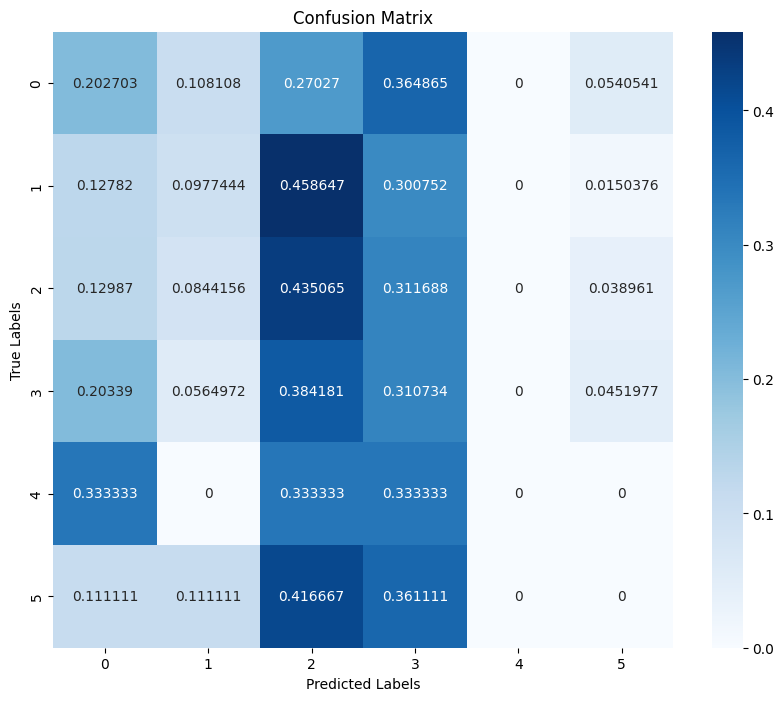

Epoch 1, Validation Loss: 1.7272, Accuracy: 0.2600, F1 Score: 0.2423
Val F1 Score Per Class  [0.17964072 0.14364641 0.34715026 0.30470914 0.         0.        ]


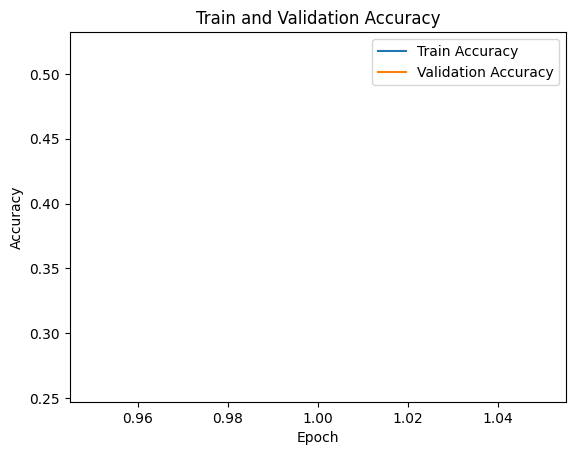

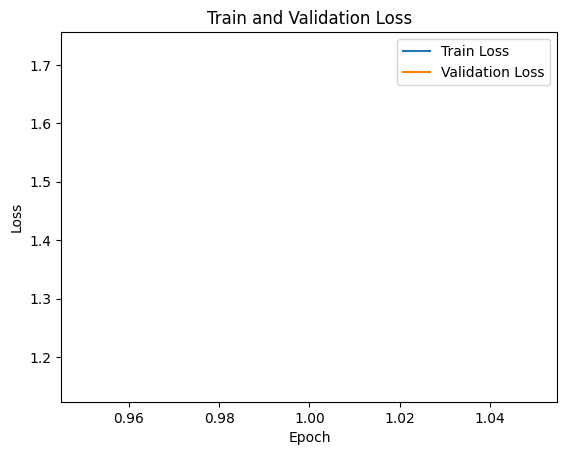

Epoch 2, Train Loss: 0.4735, Accuracy: 0.8258, F1 Score: 0.8251
Train F1 Score Per Class  [0.88562874 0.72472594 0.72180899 0.66766467 0.99293702 0.95737705]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.43it/s, loss=2.95]

[tensor([-0.3830,  1.7459, -1.1529,  0.1337, -3.9943, -1.5202], device='cuda:0'), tensor([ 1.4267, -0.9341,  0.0996,  1.8241, -3.3720, -1.7431], device='cuda:0'), tensor([-2.2850,  2.2502,  2.3292,  0.3935, -3.4887, -3.0307], device='cuda:0'), tensor([-1.7078, -0.4298,  3.0104,  0.0656, -3.7877, -1.9917], device='cuda:0'), tensor([ 0.9282, -0.8530,  0.0560,  0.4958, -3.2408, -2.1307], device='cuda:0'), tensor([-0.1094, -0.1224,  2.4378,  0.0124, -3.5038, -2.9230], device='cuda:0'), tensor([-1.8603,  1.6950,  0.9509,  1.1761, -3.2326, -2.4049], device='cuda:0'), tensor([ 3.3938, -0.8798, -0.2593,  0.2804, -2.6107, -3.0133], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=2.59]

[tensor([-1.3203,  3.1402, -0.3635,  0.5749, -2.7437, -2.3586], device='cuda:0'), tensor([-0.8699, -1.0259,  3.5051,  0.6400, -4.1562, -2.0058], device='cuda:0'), tensor([ 0.6495, -0.0909,  0.2351,  1.3916, -3.0960, -2.0911], device='cuda:0'), tensor([-0.6775, -0.3153, -1.4702,  0.1191,  3.5499, -2.0230], device='cuda:0'), tensor([-1.2342,  1.1493, -0.4004,  3.3746, -2.7921, -2.5433], device='cuda:0'), tensor([-1.0668,  0.2545,  0.1651,  0.5177, -3.7087, -3.1120], device='cuda:0'), tensor([-0.4798,  0.3732,  0.1308,  1.8468, -3.9962, -2.0520], device='cuda:0'), tensor([ 1.8500,  0.0937, -1.4814,  1.4903, -3.4264, -2.0420], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.38it/s, loss=1.54]

[tensor([-1.9310,  0.7910,  1.6807,  1.4902, -3.6872, -3.2946], device='cuda:0'), tensor([ 0.4143,  0.6764, -0.4461,  0.9989, -1.9738, -3.3472], device='cuda:0'), tensor([-0.6440,  0.1703,  2.7761, -0.7303, -3.1209, -2.0908], device='cuda:0'), tensor([-1.3287,  0.5509,  2.3681, -0.1347, -3.6442, -2.8439], device='cuda:0'), tensor([ 4.4773, -0.7371, -1.2255,  0.1281, -2.5057, -1.7076], device='cuda:0'), tensor([-0.5933,  1.3122,  1.5739,  0.3348, -3.9836, -3.5326], device='cuda:0'), tensor([-2.8363,  2.5361, -0.3841, -0.4634, -2.7941, -1.0245], device='cuda:0'), tensor([-0.8989,  0.5632,  1.2725,  1.5611, -3.5737, -2.5467], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.39it/s, loss=3.04]

[tensor([ 3.5973, -0.8243, -1.5182,  0.4754, -3.1694, -1.2059], device='cuda:0'), tensor([ 1.8731, -0.0641,  0.5954,  1.2872, -3.2392, -3.5008], device='cuda:0'), tensor([-1.2415, -0.1977,  3.3563,  0.5500, -3.5425, -2.2215], device='cuda:0'), tensor([-2.0383,  3.1040,  0.3006, -0.3528, -2.3690, -1.3880], device='cuda:0'), tensor([-1.3004, -0.1093,  3.9762, -0.4404, -2.8544, -1.8075], device='cuda:0'), tensor([ 0.4895, -0.1811,  0.6589,  0.5192, -4.3601, -3.0155], device='cuda:0'), tensor([-0.2674, -0.9556,  1.4789,  0.7431, -3.2597, -1.3626], device='cuda:0'), tensor([ 3.5065, -0.2526, -1.1782,  0.2550, -2.5596, -2.5070], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.37it/s, loss=3.14]

[tensor([-1.6140, -0.3651,  3.8474,  0.0207, -3.3011, -1.8529], device='cuda:0'), tensor([-1.5237, -0.2511, -0.3946,  0.3109, -3.3387, -1.5344], device='cuda:0'), tensor([-0.3885, -0.6136,  0.0500, -0.0261, -3.1260, -2.8702], device='cuda:0'), tensor([-1.1362, -0.6473,  4.1986,  0.2171, -2.9749, -1.7962], device='cuda:0'), tensor([-1.0072, -0.5222,  3.1115,  0.8773, -3.1969, -2.5653], device='cuda:0'), tensor([-1.2123, -0.0524,  0.0422,  0.5424, -2.8352, -0.2392], device='cuda:0'), tensor([-1.1224,  1.0537,  1.7923, -0.2537, -3.4566, -2.8310], device='cuda:0'), tensor([-0.7298,  0.0329,  0.6426, -0.0271, -3.6892, -2.8914], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.37it/s, loss=1.87]

[tensor([-0.3892, -0.3107, -1.0388, -0.0294, -3.4805, -2.1051], device='cuda:0'), tensor([ 0.0550,  0.5870, -0.2747,  0.4753, -4.6944, -2.1085], device='cuda:0'), tensor([-1.5927, -0.0557, -0.8964, -0.4682, -2.6945,  3.6457], device='cuda:0'), tensor([-1.2980,  0.3448, -0.2650,  0.5543, -3.8574, -1.4067], device='cuda:0'), tensor([-0.7436,  1.6807, -0.2499,  1.9246, -4.5589, -2.7776], device='cuda:0'), tensor([-1.8426,  1.0658,  2.5870, -0.1639, -3.5972, -2.1049], device='cuda:0'), tensor([-1.5645,  0.0722,  4.0738, -0.3768, -2.9762, -2.1768], device='cuda:0'), tensor([-1.3168,  2.8832, -0.3178,  0.5162, -2.8226, -2.4726], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.38it/s, loss=1.24]

[tensor([-0.3636, -1.6537,  0.9282,  0.3561, -3.7516, -2.2404], device='cuda:0'), tensor([-0.2339, -1.9218,  2.6670,  0.7854, -3.1940, -1.7276], device='cuda:0'), tensor([ 2.6801, -0.9074, -0.4981,  1.0529, -3.2769, -1.8957], device='cuda:0'), tensor([ 1.4208,  0.3957,  0.6039, -0.5813, -3.4813, -2.3316], device='cuda:0'), tensor([ 0.5041,  0.2654,  1.6696,  1.3368, -3.8117, -2.3452], device='cuda:0'), tensor([-0.8478, -0.6779,  0.1127,  2.2796, -3.2716, -0.7788], device='cuda:0'), tensor([-1.8478,  1.2265, -0.8611, -0.3334, -3.3874, -2.0166], device='cuda:0'), tensor([-1.1962, -0.3447,  4.1825, -0.3756, -2.6546, -1.7619], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.38it/s, loss=2.01]

[tensor([-1.0382,  0.8631,  0.0715,  2.6436, -3.1477, -2.8637], device='cuda:0'), tensor([-1.6409,  0.6103, -0.7510,  2.3312, -2.4241, -1.1019], device='cuda:0'), tensor([ 2.0653, -1.5251, -1.1791,  1.5975, -3.3715, -1.1592], device='cuda:0'), tensor([-1.8322,  0.4388,  2.1838,  0.7850, -3.8888, -2.6759], device='cuda:0'), tensor([-1.4100,  2.5915, -1.4259,  1.2229, -2.8262, -2.3595], device='cuda:0'), tensor([-0.8503, -0.6415, -0.5022,  2.2070, -3.0095, -2.3927], device='cuda:0'), tensor([ 1.4937, -1.1914, -0.6531,  0.8420, -3.9585, -1.8172], device='cuda:0'), tensor([-2.3244,  0.9291,  0.8664,  2.6287, -3.2604, -2.1943], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.38it/s, loss=1.56]

[tensor([-1.9641,  1.5217,  0.4412,  0.5105, -3.8052, -1.7415], device='cuda:0'), tensor([-1.3342,  1.2870,  0.7613,  1.8698, -3.4912, -1.8151], device='cuda:0'), tensor([ 2.3076, -0.8134, -0.8365,  1.5630, -3.1500, -2.1266], device='cuda:0'), tensor([-1.4872,  1.8874, -0.5352,  0.2310, -3.9733, -2.2426], device='cuda:0'), tensor([ 1.8579, -1.4067,  0.5404,  0.8594, -3.6098, -1.5702], device='cuda:0'), tensor([-1.7241,  0.3657, -1.3127,  1.7135, -4.0858, -1.4065], device='cuda:0'), tensor([-2.0424, -0.8668,  2.4664,  0.2338, -3.2500, -1.5837], device='cuda:0'), tensor([-0.8223, -0.3437,  0.0838,  0.8819, -4.5516, -0.4025], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.37it/s, loss=2.8]

[tensor([ 1.5507, -1.5026, -0.6663,  1.6921, -3.5305, -2.8573], device='cuda:0'), tensor([-0.4699,  0.3920, -1.1119,  0.9516, -3.0574, -1.4866], device='cuda:0'), tensor([-0.9920,  0.3307,  2.1710,  0.3135, -3.7115, -3.3012], device='cuda:0'), tensor([-1.4612, -0.8488,  3.2500,  0.4889, -3.5663, -2.2590], device='cuda:0'), tensor([-1.4416,  0.3794,  2.5876, -0.3963, -3.5220, -2.7509], device='cuda:0'), tensor([-1.9871,  1.4739, -0.0904,  2.2465, -3.5182, -2.8145], device='cuda:0'), tensor([-0.1527, -0.0864,  0.1122, -0.1618, -3.5017, -3.1862], device='cuda:0'), tensor([ 1.1355,  0.6890, -0.2827,  1.1843, -3.0759, -3.3705], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.37it/s, loss=2.06]

[tensor([-0.2579,  0.5838,  0.9227, -0.0375, -3.1239, -2.0036], device='cuda:0'), tensor([-1.5095,  0.3297,  1.2066,  1.5918, -3.8315, -2.3168], device='cuda:0'), tensor([-2.4624,  1.0302,  2.7806,  0.0684, -3.0525, -1.9030], device='cuda:0'), tensor([-1.0148, -0.7632,  2.4127,  1.1168, -3.6515, -2.3484], device='cuda:0'), tensor([ 1.6801,  0.0060, -0.4482, -0.5089, -3.4441, -2.6519], device='cuda:0'), tensor([ 0.1510,  0.6191, -0.5713,  2.1002, -3.7248, -2.7710], device='cuda:0'), tensor([-1.5998,  3.1167,  0.1076,  0.6477, -3.3524, -2.5919], device='cuda:0'), tensor([-2.4287,  2.1600,  1.0089,  1.0524, -3.0506, -2.3145], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.37it/s, loss=2.49]

[tensor([ 3.5516, -1.5882, -0.3199,  0.2011, -3.1016, -1.8503], device='cuda:0'), tensor([-1.0593, -0.3232,  2.9209,  0.9390, -3.5662, -2.8342], device='cuda:0'), tensor([-0.1819, -0.9232, -0.3185,  1.8805, -4.4923, -1.8275], device='cuda:0'), tensor([-0.0326, -1.7185, -0.0787, -0.8305, -2.7420,  1.6513], device='cuda:0'), tensor([-1.1435,  1.6727, -0.6139,  0.6117, -3.4400, -2.9563], device='cuda:0'), tensor([-0.1875, -0.5549,  0.0382, -0.2026, -2.7473, -2.7630], device='cuda:0'), tensor([ 3.4185, -1.6341, -0.1590, -0.0387, -3.2127, -1.6860], device='cuda:0'), tensor([ 1.8566, -1.2150,  1.0362,  0.7467, -3.6614, -2.0237], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.37it/s, loss=2.14]

[tensor([-1.9587, -0.3987, -0.9239,  1.2081, -2.5577, -0.1376], device='cuda:0'), tensor([-0.6576, -0.9682,  1.5418,  1.0022, -4.1663, -1.9359], device='cuda:0'), tensor([-0.7785,  2.4603, -1.0502,  1.6410, -3.8073, -2.8819], device='cuda:0'), tensor([-0.8150, -0.7278,  2.7480,  1.3631, -4.1402, -2.3558], device='cuda:0'), tensor([-1.4659,  0.3650, -1.3808,  2.3742, -3.6948, -2.4007], device='cuda:0'), tensor([ 2.6529, -1.2165, -0.5529,  0.2114, -3.1239, -1.5811], device='cuda:0'), tensor([-2.1830,  3.4791, -0.5529, -0.4718, -2.7627, -0.6474], device='cuda:0'), tensor([-0.6688,  1.3091, -0.8144,  0.0498, -3.6274, -1.1079], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.37it/s, loss=1.75]

[tensor([-0.3672, -0.5773,  0.6149,  0.6178, -4.1011, -1.6753], device='cuda:0'), tensor([ 2.8629,  0.1965, -1.9492, -0.3049, -2.5342, -2.3651], device='cuda:0'), tensor([-0.3871,  0.7765, -0.7603, -0.5325, -3.2182, -2.5074], device='cuda:0'), tensor([-0.6065, -1.2767,  1.5638,  0.5853, -3.9604, -2.7279], device='cuda:0'), tensor([-1.0995,  1.9746, -0.8551,  0.7730, -2.9606, -3.0242], device='cuda:0'), tensor([-1.2855e+00,  1.3699e+00,  1.2232e-03,  1.7646e+00, -3.1012e+00,
        -2.9545e+00], device='cuda:0'), tensor([-1.5191,  1.4710,  0.1534,  1.0926, -3.9802, -3.0597], device='cuda:0'), tensor([-0.5120,  0.1389,  1.0335,  0.5566, -3.6407, -2.6820], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.37it/s, loss=2.26]

[tensor([ 0.6117, -0.9155,  0.2017,  0.9411, -3.6264, -3.4223], device='cuda:0'), tensor([ 3.7315, -0.0719, -1.5948, -0.0500, -2.2059, -2.7489], device='cuda:0'), tensor([-0.3349, -1.8107, -0.2495,  0.1567, -3.0841,  3.4978], device='cuda:0'), tensor([-1.3144,  1.5473,  0.9292,  0.0621, -2.8091, -2.6604], device='cuda:0'), tensor([ 0.7790,  0.2085,  1.8141, -0.4637, -3.6741, -2.7212], device='cuda:0'), tensor([-0.5065, -1.1449,  0.3107,  1.0758, -4.0038, -1.8457], device='cuda:0'), tensor([-1.4837,  1.2636, -0.7412,  1.9377, -2.9704, -1.5311], device='cuda:0'), tensor([-0.8664,  1.8312, -0.6654,  1.8817, -2.7925, -2.5854], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=3.03]

[tensor([ 1.1516,  0.6452, -0.2005,  1.4667, -3.5826, -2.3436], device='cuda:0'), tensor([-1.2387,  0.6906,  0.3281,  1.4495, -3.9624, -2.9479], device='cuda:0'), tensor([-1.0417, -1.1264,  0.1497, -0.8251, -2.4784,  4.3098], device='cuda:0'), tensor([ 0.5651, -1.6854,  1.6940,  0.6935, -3.5540, -0.7621], device='cuda:0'), tensor([ 3.5911, -0.3824,  0.8967, -0.2641, -2.8869, -2.5931], device='cuda:0'), tensor([ 2.1833, -0.7288, -0.6492,  0.7459, -3.4532, -3.4893], device='cuda:0'), tensor([-1.4430, -0.0110,  2.6700,  0.6947, -3.8342, -2.5613], device='cuda:0'), tensor([ 4.2646, -1.2451, -1.4896, -0.2153, -2.1450, -1.7976], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.38it/s, loss=2.6]

[tensor([-1.3750,  0.6006,  2.8896, -0.1479, -3.9020, -2.7917], device='cuda:0'), tensor([ 0.4066,  2.3261, -0.7215,  0.8169, -3.9184, -3.0648], device='cuda:0'), tensor([-1.7814,  2.1124, -0.6417,  0.1874, -2.3850, -1.2200], device='cuda:0'), tensor([-0.6683, -0.2800,  1.4815,  0.3040, -3.9065, -2.2409], device='cuda:0'), tensor([ 0.4881, -0.9337, -0.2161, -0.3356, -3.3119, -3.0276], device='cuda:0'), tensor([ 3.2751, -0.0348,  0.1772, -0.4240, -3.1714, -3.4737], device='cuda:0'), tensor([ 0.3041, -1.3438,  1.3708,  0.6818, -3.9102, -2.2941], device='cuda:0'), tensor([-0.2198, -0.3614,  1.2427,  0.7209, -3.9776, -2.6592], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=1.81]

[tensor([ 2.1015, -0.1303, -1.2878,  1.0205, -3.9031, -1.9056], device='cuda:0'), tensor([-1.9926,  0.5819,  0.6704,  1.2633, -3.0820, -2.0688], device='cuda:0'), tensor([-0.6593,  0.6318, -0.6028,  3.0888, -3.2638, -2.1590], device='cuda:0'), tensor([-1.8081,  1.6167,  2.3149,  0.6907, -3.4071, -3.3064], device='cuda:0'), tensor([-1.2796,  0.6813, -0.2838,  0.7928, -3.9301, -1.8526], device='cuda:0'), tensor([ 0.4770,  0.4867,  0.8430,  1.4540, -4.3379, -2.7351], device='cuda:0'), tensor([-0.9411, -0.8080,  0.2319, -0.0574, -3.5352, -1.4328], device='cuda:0'), tensor([-1.2887, -0.8003,  3.8649, -0.2826, -2.7451, -1.6049], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.38it/s, loss=2.36]

[tensor([-0.0927, -0.4474,  0.8287,  0.9635, -3.5316, -1.9871], device='cuda:0'), tensor([ 3.5560, -0.4016, -0.3131,  0.3431, -2.2000, -2.9466], device='cuda:0'), tensor([ 1.4804, -1.4891,  3.0473, -0.2004, -2.9505, -1.3781], device='cuda:0'), tensor([ 0.1888,  0.4605, -1.0281,  1.1088, -1.5550, -2.7327], device='cuda:0'), tensor([-2.1902,  2.6339,  0.2249,  0.0304, -3.3803, -2.0162], device='cuda:0'), tensor([-0.0840,  0.3416, -0.2556,  0.7368, -3.4807, -2.8324], device='cuda:0'), tensor([-0.6012, -1.0089,  1.0734,  2.1780, -4.1992, -2.3174], device='cuda:0'), tensor([ 3.7785, -1.0058, -1.9348, -0.2539, -1.1896, -2.1912], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.38it/s, loss=2.59]

[tensor([-1.7064,  3.7173, -1.1622,  0.2774, -2.2081, -1.6258], device='cuda:0'), tensor([-1.6427, -0.5968,  2.1291,  0.7793, -3.7733, -2.1978], device='cuda:0'), tensor([-0.7552, -1.2198,  2.9196,  0.4572, -3.5772, -2.0503], device='cuda:0'), tensor([-0.4559,  0.8181,  1.3334, -0.6711, -3.6770, -1.0908], device='cuda:0'), tensor([-0.3127, -0.4043, -0.1790,  0.9226, -3.5430, -3.3191], device='cuda:0'), tensor([-1.6078,  0.8289,  1.6440, -0.5907, -4.0230, -1.8125], device='cuda:0'), tensor([-1.2819, -1.2141,  2.5735, -0.1991, -3.2221, -2.1476], device='cuda:0'), tensor([ 0.0967, -0.3928, -1.1696,  1.5845, -3.4191, -1.5926], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=2.35]

[tensor([-1.0546, -1.2660,  1.6468, -0.7970, -3.2636, -1.6177], device='cuda:0'), tensor([-1.7691,  3.4749, -0.4921,  0.8547, -2.8631, -2.6089], device='cuda:0'), tensor([-1.1541,  0.9958, -1.2984,  2.0780, -3.2843, -2.2970], device='cuda:0'), tensor([-1.1941, -0.7633, -0.3827,  0.1410, -4.8314, -1.0212], device='cuda:0'), tensor([ 0.9392,  1.4813, -0.7385, -0.5402, -3.0245, -2.7241], device='cuda:0'), tensor([-1.9045e+00, -7.2805e-01, -1.0601e+00, -2.9800e-03, -4.1028e+00,
        -2.0431e+00], device='cuda:0'), tensor([ 0.5728,  1.1500,  0.9962, -0.6446, -3.3087, -2.7941], device='cuda:0'), tensor([ 0.9430,  1.2933, -1.2513,  0.0900, -2.8751, -2.8598], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=1.17]

[tensor([ 0.9818, -0.9341,  1.3169, -0.1511, -3.3562, -0.2743], device='cuda:0'), tensor([ 0.5467, -1.1328,  0.2726,  1.5468, -3.9088, -0.9325], device='cuda:0'), tensor([ 1.7442, -0.0722, -0.2713,  1.0296, -3.7915, -3.5083], device='cuda:0'), tensor([-1.1339, -0.9414, -0.0947,  1.3931, -3.7663, -0.3255], device='cuda:0'), tensor([-0.2063,  1.7295, -1.3360, -0.2256, -2.2772, -2.4504], device='cuda:0'), tensor([ 1.8937, -1.1189, -0.3750,  0.0771, -4.0341, -0.4972], device='cuda:0'), tensor([ 1.2282, -1.7878,  1.4624,  1.1649, -3.5470, -1.9534], device='cuda:0'), tensor([-1.6367,  0.3648,  3.2889, -0.1239, -3.6132, -2.5452], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.38it/s, loss=1.72]

[tensor([-0.5178, -0.9967, -0.5289,  0.2650, -3.2524, -3.4490], device='cuda:0'), tensor([-2.2876,  3.4216,  1.2239, -0.2889, -2.6883, -2.1150], device='cuda:0'), tensor([-1.2226,  0.9402, -0.0239,  2.0578, -3.7146, -2.8636], device='cuda:0'), tensor([-1.2162, -0.9818,  0.4745, -0.3454, -3.6377, -1.9799], device='cuda:0'), tensor([-1.6463, -0.1544,  0.7950,  0.3518, -3.5305, -2.5657], device='cuda:0'), tensor([-2.0576,  2.2271,  0.3371,  0.6849, -3.4481, -2.1048], device='cuda:0'), tensor([-0.2022, -1.2013,  1.1264,  0.1235, -3.3527,  0.5035], device='cuda:0'), tensor([-1.8131,  2.6155,  1.6245, -0.1364, -3.5044, -3.0486], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.38it/s, loss=2.26]

[tensor([-1.4243, -0.7024,  4.1689,  0.6046, -3.1016, -1.9850], device='cuda:0'), tensor([-0.9405,  0.6120,  0.4215,  0.7926, -3.9953, -2.8867], device='cuda:0'), tensor([-2.2364,  2.6810, -0.4671,  0.7293, -2.8038, -2.4007], device='cuda:0'), tensor([ 0.0719,  0.0566, -0.4802,  2.9453, -4.0706, -2.8118], device='cuda:0'), tensor([ 1.3286,  0.0045, -0.3692,  2.0799, -3.3513, -3.0724], device='cuda:0'), tensor([-0.3483,  0.3474, -0.4798,  1.3956, -3.5784, -3.2126], device='cuda:0'), tensor([ 2.6921, -2.1267, -0.9357, -0.7716, -1.9307,  0.3663], device='cuda:0'), tensor([ 2.2091, -0.7270, -0.6062,  0.5198, -3.5056, -2.7434], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.38it/s, loss=1.27]

[tensor([-0.5184, -1.0343,  3.0613,  0.2660, -3.6422, -2.1677], device='cuda:0'), tensor([-1.9400,  3.0581,  0.4971,  1.0214, -2.9541, -2.6301], device='cuda:0'), tensor([-1.4151,  2.0399, -0.0781,  0.5710, -3.6323, -2.7105], device='cuda:0'), tensor([-1.1729,  1.7032, -0.1278,  0.3811, -3.5084, -2.6239], device='cuda:0'), tensor([-0.6711,  0.1782, -1.0951,  0.6654, -4.3440, -1.9140], device='cuda:0'), tensor([-0.2426, -0.6408,  2.9586, -0.3699, -3.6474, -1.5013], device='cuda:0'), tensor([-0.8899,  1.7506, -1.4592,  1.9839, -3.2467, -2.6899], device='cuda:0'), tensor([ 4.0470, -1.5398, -0.6228,  0.0551, -2.5491, -1.4332], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.92]

[tensor([-0.6814,  0.9134, -0.9122,  2.8709, -3.3365, -2.8702], device='cuda:0'), tensor([-1.3778, -0.0159,  0.0370, -0.1516, -4.7168, -2.3828], device='cuda:0'), tensor([ 0.2605, -1.8425,  0.9360,  0.1735, -3.8716, -1.4760], device='cuda:0'), tensor([ 2.2767, -1.6885, -1.0774,  0.0282, -3.3327, -0.1871], device='cuda:0'), tensor([-1.3817,  1.0317,  0.3904,  0.8427, -3.7520, -2.1289], device='cuda:0'), tensor([-0.1171, -0.4588,  2.5174,  0.1246, -3.0019, -0.5832], device='cuda:0'), tensor([-1.4155, -0.3397,  2.9531,  0.1208, -3.6252, -2.7822], device='cuda:0'), tensor([-2.1566,  1.8196, -0.2111,  0.6863, -3.2618, -2.8216], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=2.38]

[tensor([-1.5686,  0.8856,  0.8510,  1.3386, -3.7395, -2.9883], device='cuda:0'), tensor([-2.1031,  1.3492,  1.0106,  1.3988, -3.2822, -2.3949], device='cuda:0'), tensor([ 0.7843, -1.1605, -0.1438, -0.0097, -3.4268, -1.7533], device='cuda:0'), tensor([-1.9524,  0.5568,  3.7901, -0.2121, -2.8872, -1.9527], device='cuda:0'), tensor([-1.6510,  2.7455,  1.8173, -0.3272, -3.8470, -2.5603], device='cuda:0'), tensor([ 1.6060, -0.8340,  1.3055,  0.8408, -3.7348, -2.3590], device='cuda:0'), tensor([-0.2930, -1.0896,  0.0242,  1.4939, -3.8794, -1.5357], device='cuda:0'), tensor([ 4.3462, -0.4070, -0.9010, -0.2389, -2.8792, -2.5137], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.38it/s, loss=2.44]

[tensor([ 2.3578, -0.2954, -1.2583,  1.3747, -3.3379, -1.8809], device='cuda:0'), tensor([ 0.9455,  0.3300, -0.8971,  2.2766, -3.9022, -1.9199], device='cuda:0'), tensor([-1.3695,  3.9273, -0.9392, -0.2423, -1.9831, -1.7258], device='cuda:0'), tensor([-1.3194, -0.0685,  3.8152,  0.6867, -3.1485, -2.2924], device='cuda:0'), tensor([ 0.3052, -0.6724,  0.7544,  2.4183, -3.9543, -3.2048], device='cuda:0'), tensor([-2.0611,  1.6773,  2.5609,  1.2803, -3.4203, -3.0452], device='cuda:0'), tensor([-0.9571, -0.9633,  3.4782, -0.2485, -2.9898, -1.8610], device='cuda:0'), tensor([-1.5169,  2.8643, -0.6324, -0.3574, -3.2776, -2.0428], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=1.7]

[tensor([-1.2611,  1.1627, -0.8147,  3.0507, -2.7752, -2.1197], device='cuda:0'), tensor([-1.7252,  0.9532,  1.2587,  0.3510, -3.7659, -2.3458], device='cuda:0'), tensor([-0.7678, -2.0187,  0.8901,  0.7298, -4.0029, -1.0909], device='cuda:0'), tensor([-1.7725,  0.4373,  3.6798,  0.1094, -3.1117, -2.3782], device='cuda:0'), tensor([-0.5998, -0.3443, -0.2800, -0.2574, -3.4261, -2.5248], device='cuda:0'), tensor([ 0.1779, -1.2716,  0.7089,  0.7126, -4.2979, -1.9848], device='cuda:0'), tensor([-1.0220,  0.1347,  3.0266,  0.3307, -4.4205, -2.4302], device='cuda:0'), tensor([-2.2671,  0.8066,  1.2077,  2.4094, -3.5124, -2.6357], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=2.14]

[tensor([-1.7905,  1.4036,  2.3018,  0.4249, -3.3290, -2.6251], device='cuda:0'), tensor([-0.4858,  1.3325, -0.0561,  1.8656, -3.3938, -3.2466], device='cuda:0'), tensor([ 1.9208, -0.6443, -0.9002,  0.1884, -3.8796, -2.7392], device='cuda:0'), tensor([ 0.6765, -0.7190,  0.2345,  1.9329, -3.6168, -2.6485], device='cuda:0'), tensor([-2.2499,  2.6116,  1.0647,  0.2399, -3.3888, -2.6899], device='cuda:0'), tensor([-0.9561, -0.5447,  0.8947,  0.0192, -2.7150, -2.4407], device='cuda:0'), tensor([ 0.0488, -1.1487, -0.3433,  1.8283, -4.2628, -2.2492], device='cuda:0'), tensor([-0.6223, -1.1825, -0.0142, -0.7600, -2.9602,  3.5459], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.39it/s, loss=1.11]

[tensor([-1.3736,  1.7149, -1.5391,  2.0206, -2.7604, -1.9430], device='cuda:0'), tensor([ 0.2974, -0.4212,  2.0441,  0.9376, -4.0408, -2.0868], device='cuda:0'), tensor([ 0.2099, -0.8076,  1.1012, -0.0719, -3.5784, -0.5974], device='cuda:0'), tensor([ 1.0499,  0.8120,  0.1150, -0.3805, -3.9683, -2.8408], device='cuda:0'), tensor([-0.5827,  1.0844,  1.8501, -0.2378, -3.6680, -2.6725], device='cuda:0'), tensor([ 3.7560, -0.9865, -1.7224, -1.0869, -1.5949, -0.2854], device='cuda:0'), tensor([-1.0656, -0.8291,  4.1576,  0.3560, -2.8098, -1.7875], device='cuda:0'), tensor([-0.5366, -0.2901,  1.8247,  0.6643, -3.6663, -2.9454], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=3.6]

[tensor([-1.6291, -0.3132, -0.9971,  1.4073, -3.6390, -2.3847], device='cuda:0'), tensor([-1.5290,  0.6360, -0.0532,  2.5909, -3.4412, -2.8566], device='cuda:0'), tensor([-1.1652,  3.9919, -1.2079, -0.8612, -1.7543, -1.8285], device='cuda:0'), tensor([-1.5408,  1.3506, -0.3311,  2.1393, -2.7898, -2.4433], device='cuda:0'), tensor([ 2.5804,  0.0475, -0.3430,  0.0922, -2.9335, -2.8214], device='cuda:0'), tensor([-2.1832, -0.0627,  3.0686, -0.5568, -2.8243, -0.3387], device='cuda:0'), tensor([ 3.5048, -0.9028, -0.3519, -0.2736, -3.1049, -1.5774], device='cuda:0'), tensor([ 1.2515, -1.1073,  0.0517,  0.5914, -4.0387, -2.7737], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=2.39]

[tensor([-2.4969, -0.3489,  1.0939,  0.7106, -3.5816, -1.4919], device='cuda:0'), tensor([-1.9817,  2.4686, -0.4600,  2.1313, -2.9666, -1.5756], device='cuda:0'), tensor([-1.8639,  2.5659, -0.3056,  2.0489, -3.6504, -2.1604], device='cuda:0'), tensor([-0.8806,  3.1124,  0.1688,  0.1553, -3.4671, -2.7618], device='cuda:0'), tensor([-1.3820, -0.8492,  3.3172, -0.0367, -3.5354, -2.6238], device='cuda:0'), tensor([-2.1692, -0.3978,  0.5852,  2.5499, -3.3669, -2.6276], device='cuda:0'), tensor([-0.1002,  1.0342, -0.9359,  0.3917, -3.1826, -2.7261], device='cuda:0'), tensor([-1.8833,  1.2036, -0.0071,  1.8386, -3.0110, -3.2376], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=2.4]

[tensor([ 2.2282,  1.1226, -1.8910, -0.4967, -2.0144, -1.0192], device='cuda:0'), tensor([-0.6359,  0.1215,  1.3223,  1.4344, -4.0998, -3.5159], device='cuda:0'), tensor([ 1.7627,  1.2526, -0.5631, -0.9396, -2.2462, -1.5642], device='cuda:0'), tensor([-1.3798, -1.5004, -0.0268, -0.0687, -3.7703, -1.3594], device='cuda:0'), tensor([-1.2635,  2.4340,  0.4138,  0.6230, -3.6115, -3.1323], device='cuda:0'), tensor([-0.1918,  0.8218,  0.7500,  0.1633, -3.9275, -2.5675], device='cuda:0'), tensor([ 1.2038, -1.7655,  0.4220,  0.6541, -3.6867, -2.0217], device='cuda:0'), tensor([-0.3087, -1.2359,  1.9835, -0.2071, -3.3607, -1.4483], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.36it/s, loss=2.36]

[tensor([-1.8814, -0.0146,  0.4600,  1.2309, -4.1112, -2.9139], device='cuda:0'), tensor([-1.8938,  0.7467,  3.3118, -0.0560, -3.3326, -2.3351], device='cuda:0'), tensor([-0.0672, -1.6356,  2.9433,  0.4302, -3.2547, -1.2483], device='cuda:0'), tensor([-1.0986,  0.6466,  2.6805,  0.5416, -3.9116, -2.5447], device='cuda:0'), tensor([-2.1438,  1.1403,  0.1530,  1.8541, -3.4356, -1.9520], device='cuda:0'), tensor([-0.4934,  0.0059,  1.4528,  1.1709, -3.8938, -1.4678], device='cuda:0'), tensor([-0.8020,  0.7374,  0.8096,  0.5239, -4.1194, -2.5824], device='cuda:0'), tensor([-0.9478,  1.3100, -0.4291,  2.1015, -3.3796, -2.6803], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=1.89]

[tensor([-1.0098,  3.2016,  0.2415,  0.2626, -3.0406, -2.3841], device='cuda:0'), tensor([ 1.8714, -1.4117,  0.7548,  0.8762, -3.3904, -2.8243], device='cuda:0'), tensor([-1.1319,  0.5788, -0.3485, -0.2081, -4.5268, -1.6233], device='cuda:0'), tensor([-1.9979,  0.6708,  2.9818, -0.0545, -3.0036, -2.4967], device='cuda:0'), tensor([ 0.3200, -0.6566,  0.9501,  0.5467, -3.8997, -1.1437], device='cuda:0'), tensor([-1.8944, -0.2705,  1.8989,  1.3478, -3.9632, -2.2168], device='cuda:0'), tensor([ 0.1734, -1.2882,  2.0214,  0.8417, -3.4240, -2.3442], device='cuda:0'), tensor([-0.7582,  1.1184,  0.3603,  1.2879, -3.4323, -2.6273], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.36it/s, loss=2.44]

[tensor([ 1.4072,  0.6413, -1.8360, -0.0258, -3.4798, -2.2111], device='cuda:0'), tensor([-1.1949, -0.8830,  1.5257,  0.4900, -4.1291, -2.1866], device='cuda:0'), tensor([ 2.6268, -0.9633, -0.4957,  1.4169, -3.2473, -1.9021], device='cuda:0'), tensor([-2.1605,  2.2273, -0.1532,  0.6658, -3.9880, -1.1622], device='cuda:0'), tensor([ 1.9020, -0.4585,  1.2091, -0.3949, -3.0380, -1.4742], device='cuda:0'), tensor([-1.1062,  2.9611,  0.5367,  0.6147, -3.2943, -2.6466], device='cuda:0'), tensor([-0.9949,  2.1954,  0.3270,  1.0674, -3.1265, -3.2553], device='cuda:0'), tensor([-1.7483,  3.1855, -0.2682,  1.3986, -2.2827, -2.6076], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.37it/s, loss=1.64]

[tensor([-0.9784,  0.7112,  2.0345, -1.0050, -3.0935, -1.0869], device='cuda:0'), tensor([-0.6639,  0.5632, -0.4263,  1.1201, -3.9768, -2.2310], device='cuda:0'), tensor([-0.0249, -0.6508,  0.9548,  1.0571, -4.3863, -2.2241], device='cuda:0'), tensor([-0.0883, -0.4333,  0.6406,  0.8062, -3.3595, -2.7859], device='cuda:0'), tensor([-0.5196, -0.2510,  2.0732,  0.7118, -3.6706, -3.0094], device='cuda:0'), tensor([-1.7238,  3.1270, -0.7675,  0.6216, -3.0918, -2.0809], device='cuda:0'), tensor([-1.5236,  0.4105,  1.2551,  0.5071, -3.8771, -2.0820], device='cuda:0'), tensor([-0.9586,  0.6089,  1.6681,  1.0750, -4.3043, -3.1830], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=2.17]

[tensor([-1.0566, -0.7944,  3.7812,  0.5971, -3.5540, -2.0847], device='cuda:0'), tensor([-1.0757,  1.8213,  0.7097,  1.5044, -3.3318, -3.7958], device='cuda:0'), tensor([-0.0842, -1.6226, -0.1163,  0.7997, -3.9935, -2.1375], device='cuda:0'), tensor([ 0.2071, -0.6870, -0.5423,  2.0023, -4.3274, -1.1959], device='cuda:0'), tensor([-1.6322, -0.5808,  1.8482,  0.9238, -3.9710, -2.7908], device='cuda:0'), tensor([-1.7849,  0.1120,  2.0187, -0.1352, -3.4629, -1.1179], device='cuda:0'), tensor([ 0.3655, -0.0878,  1.5659,  0.0980, -3.6639, -2.5046], device='cuda:0'), tensor([-1.8814, -0.0848, -0.3808, -0.6107, -4.2675,  2.4305], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=2.16]

[tensor([-0.8014,  2.7080, -0.1659,  0.0784, -3.0722, -1.8023], device='cuda:0'), tensor([-1.6493,  0.1055,  2.6299,  0.5937, -3.1032, -2.9050], device='cuda:0'), tensor([ 0.0972,  0.3653,  1.1226,  0.6048, -3.7320, -2.3615], device='cuda:0'), tensor([ 4.1405, -0.7691, -2.0212, -0.1609, -2.0001, -1.4575], device='cuda:0'), tensor([-2.1652,  2.9853, -0.6562,  1.0877, -3.3097, -2.4897], device='cuda:0'), tensor([ 0.4891,  0.8079, -1.2128,  1.1518, -3.1766, -2.6627], device='cuda:0'), tensor([-1.7614,  1.7184, -1.0596,  2.0247, -2.9722, -2.3670], device='cuda:0'), tensor([-1.7717,  0.8265, -0.0450,  1.6064, -3.9013, -0.0969], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.37it/s, loss=2.11]

[tensor([-0.3598, -0.4157,  1.1528,  1.5939, -3.9325, -2.5270], device='cuda:0'), tensor([-1.0281,  1.6261,  0.8493,  1.8007, -2.7358, -3.7034], device='cuda:0'), tensor([ 0.1387,  1.4083, -1.0590,  1.2522, -3.2816, -3.1616], device='cuda:0'), tensor([-0.8999, -0.8144,  2.8600,  0.6337, -3.5408, -2.5003], device='cuda:0'), tensor([-1.0217,  2.4442, -0.5429,  1.4634, -3.3082, -2.4653], device='cuda:0'), tensor([-1.4374,  0.0818,  0.9915,  2.4884, -3.7944, -2.4442], device='cuda:0'), tensor([-1.8360,  1.1431,  0.6344,  0.9841, -3.2230, -3.1921], device='cuda:0'), tensor([-1.6294,  3.9190, -0.4890, -0.1807, -2.3783, -2.4420], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.37it/s, loss=1.9]

[tensor([ 2.0018, -1.3263,  0.9610,  0.4049, -3.5061, -2.3052], device='cuda:0'), tensor([ 0.8695, -0.1670,  0.0862,  0.9499, -3.1985, -1.6530], device='cuda:0'), tensor([ 0.0303, -0.3064, -1.2383,  1.5332, -3.5223, -1.3477], device='cuda:0'), tensor([-0.4840,  1.5552, -0.8758,  1.3642, -3.2428, -2.0497], device='cuda:0'), tensor([-0.7832, -0.7022, -0.3745,  2.4075, -3.1151, -0.2514], device='cuda:0'), tensor([-0.1094, -0.7112,  2.5455,  2.0990, -3.7271, -3.2110], device='cuda:0'), tensor([-2.7848,  2.1310,  2.3595,  0.1183, -2.9896, -1.5449], device='cuda:0'), tensor([ 3.6682, -1.3348,  0.1137,  0.0232, -2.9434, -2.2309], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.37it/s, loss=1.33]

[tensor([-1.0352,  1.6386, -0.7185,  2.6705, -2.6002, -2.7465], device='cuda:0'), tensor([ 1.3500, -0.2278, -0.9626, -0.0038, -2.9144, -3.2093], device='cuda:0'), tensor([ 0.9048, -1.1517, -0.9637,  0.2317, -2.9551, -0.7931], device='cuda:0'), tensor([-2.7839,  0.9083,  1.0505,  1.6499, -3.6303, -1.3576], device='cuda:0'), tensor([-2.7869,  2.0063,  0.0222,  0.1222, -2.7582, -1.8477], device='cuda:0'), tensor([-1.2973,  1.0980,  3.0068,  0.0134, -3.5076, -3.0274], device='cuda:0'), tensor([-1.9485, -0.0775,  3.8722,  0.0282, -2.5597, -1.5175], device='cuda:0'), tensor([-0.3492, -0.3886,  1.3931,  0.5054, -3.5256, -2.8134], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.37it/s, loss=2.03]

[tensor([-1.7416,  0.9851,  0.4063,  3.2606, -2.4615, -2.8267], device='cuda:0'), tensor([-0.5800,  0.2643,  2.0326,  1.4014, -4.6411, -2.2473], device='cuda:0'), tensor([ 1.1541,  1.3437, -1.1648, -0.6845, -3.0794, -2.5804], device='cuda:0'), tensor([-0.7257, -1.6540, -0.7693,  0.0927, -2.0258,  4.1226], device='cuda:0'), tensor([-1.6107, -0.3917,  2.8328,  1.1417, -3.5353, -3.2769], device='cuda:0'), tensor([-1.8416,  1.1178, -0.9249,  0.9307, -3.5392, -1.9578], device='cuda:0'), tensor([-0.9576, -0.4366,  0.0208,  2.0053, -4.1257, -2.9291], device='cuda:0'), tensor([-0.0753, -0.5674,  1.8817,  0.7050, -3.9715, -2.2041], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.37it/s, loss=3.57]

[tensor([-2.4309,  3.2533, -0.0258,  0.1006, -2.8955, -1.0877], device='cuda:0'), tensor([-1.6924,  3.4456,  1.0344, -0.7494, -2.0763, -2.1382], device='cuda:0'), tensor([-1.9931,  1.5469,  2.3498,  0.0536, -3.2431, -2.6009], device='cuda:0'), tensor([-2.3824,  3.4269,  0.8260,  0.5736, -3.0154, -2.6790], device='cuda:0'), tensor([ 0.1825, -0.8553, -0.3416,  2.2633, -4.7332, -1.1043], device='cuda:0'), tensor([ 3.1325, -1.0796, -0.6970,  0.9937, -3.4883, -2.0738], device='cuda:0'), tensor([ 1.0719, -1.1750, -0.4391, -1.5655, -1.1397, -1.1637], device='cuda:0'), tensor([-1.6325,  1.2989,  0.7662,  1.8170, -3.8825, -2.9158], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.37it/s, loss=2.21]

[tensor([-0.6790,  0.6647,  0.7903,  0.9918, -3.7923, -2.3259], device='cuda:0'), tensor([-1.1435,  0.4229,  0.4830, -0.0299, -3.1064, -3.1578], device='cuda:0'), tensor([-1.3117, -0.2871, -0.8529,  1.4074, -4.1214, -2.3150], device='cuda:0'), tensor([ 2.3493, -1.1007,  0.1142,  0.8230, -4.2516, -1.9418], device='cuda:0'), tensor([-2.5062,  1.8860,  2.9700,  0.2234, -2.7950, -2.4747], device='cuda:0'), tensor([-1.4894, -0.7685,  0.5512,  1.9286, -4.2971, -1.8531], device='cuda:0'), tensor([ 2.1472, -1.0868, -0.9645,  2.3097, -3.6344, -1.5072], device='cuda:0'), tensor([ 0.4196, -0.0444,  0.8901,  0.4855, -4.1687, -2.2094], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.37it/s, loss=1.61]

[tensor([ 2.5613, -1.2617, -0.5452, -0.1361, -1.7614, -2.5116], device='cuda:0'), tensor([ 1.0833, -1.4965,  1.3577,  0.1321, -3.0313, -1.6081], device='cuda:0'), tensor([-1.0558,  1.2175,  0.7192,  0.2627, -3.7085, -3.2125], device='cuda:0'), tensor([-1.1716, -0.3740,  3.9517, -0.2771, -2.9789, -1.6003], device='cuda:0'), tensor([-1.0477, -0.0739,  0.7672,  0.6827, -3.4934, -1.3779], device='cuda:0'), tensor([-0.2849, -0.6433, -0.8539,  0.5975, -3.7939, -1.9477], device='cuda:0'), tensor([-1.4821, -0.3052, -0.8419, -0.5857, -3.6046, -0.8684], device='cuda:0'), tensor([-0.7476,  0.5056,  1.4802,  0.7535, -4.1772, -3.2754], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.36it/s, loss=2.35]

[tensor([-0.6303,  0.2586,  2.9871,  0.4056, -3.7756, -2.2822], device='cuda:0'), tensor([ 0.6241,  0.5364, -1.2356,  0.4519, -3.1284, -2.6441], device='cuda:0'), tensor([ 4.3141, -1.5520, -0.9862, -0.7420, -1.4869, -0.2899], device='cuda:0'), tensor([-1.5463,  0.5001, -0.0741,  1.0519, -3.3675, -3.1999], device='cuda:0'), tensor([ 2.6299, -1.7054, -0.5271,  1.0735, -3.6555, -1.5909], device='cuda:0'), tensor([-0.3616, -1.5234, -0.0589,  1.1123, -3.6218, -2.9069], device='cuda:0'), tensor([-1.5440,  1.5265, -0.6062,  2.2579, -3.1679, -2.1647], device='cuda:0'), tensor([ 4.0039, -1.7257, -0.1509,  0.3263, -3.0290, -1.5075], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=1.7]

[tensor([-1.4743,  0.7174,  2.9024,  0.3160, -3.2353, -2.7885], device='cuda:0'), tensor([-0.5057, -0.2380,  1.2884,  0.9013, -3.1355, -2.8337], device='cuda:0'), tensor([-1.6145, -1.3323,  0.7506, -0.3220, -2.7377,  2.0963], device='cuda:0'), tensor([-0.6683, -0.1870,  2.2390,  0.5395, -4.0710, -2.3594], device='cuda:0'), tensor([-1.6165,  1.2789,  1.6732,  0.1234, -3.0165, -2.4710], device='cuda:0'), tensor([ 0.7424, -0.9409,  0.8792,  0.4862, -3.7577, -1.9411], device='cuda:0'), tensor([-0.2541, -0.4513, -0.7594, -0.5704, -3.4374, -2.2187], device='cuda:0'), tensor([ 0.7292,  0.1518, -0.6971,  1.4977, -3.4910, -2.3801], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.37it/s, loss=1.98]

[tensor([ 0.2019, -0.0398, -0.0365,  1.1529, -4.1395, -2.3794], device='cuda:0'), tensor([-1.5393,  1.0307,  2.1455, -0.3789, -3.6694, -1.8666], device='cuda:0'), tensor([-0.5903, -0.8783, -0.7289,  0.1901, -3.8648, -2.1202], device='cuda:0'), tensor([-0.8840, -0.7868,  1.5503,  1.7037, -3.9641, -1.9505], device='cuda:0'), tensor([-0.8989,  0.0815,  1.2167,  0.9601, -4.0890, -2.4799], device='cuda:0'), tensor([ 2.8866, -0.8245,  0.2309,  0.5349, -3.3104, -1.5794], device='cuda:0'), tensor([-0.5285, -0.4304,  3.7395,  0.3280, -3.5336, -2.5327], device='cuda:0'), tensor([ 0.6038, -1.6843,  2.2569,  1.2169, -3.4832, -2.1325], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=2.36]

[tensor([-1.0895, -0.8733,  2.9573, -0.1488, -3.3732, -1.6196], device='cuda:0'), tensor([ 1.0127, -1.1355,  2.2711,  0.4211, -3.6383, -2.1157], device='cuda:0'), tensor([-1.9554, -0.1992,  3.5572,  0.0808, -3.1071, -2.3906], device='cuda:0'), tensor([-1.1453,  1.7886, -0.1031,  0.4663, -3.9830, -2.7899], device='cuda:0'), tensor([ 1.6470, -1.3555,  0.4428,  2.5056, -3.8124, -2.6208], device='cuda:0'), tensor([ 0.0227, -0.0825,  1.0073,  0.7266, -4.1342, -3.0564], device='cuda:0'), tensor([-1.9312,  1.8880,  0.0544,  1.5292, -3.3455, -2.6567], device='cuda:0'), tensor([-0.3529, -0.9419, -0.3790,  1.1188, -3.7409, -2.0483], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.37it/s, loss=2.12]

[tensor([-1.6420,  2.4704, -0.4148,  0.9720, -3.3504, -1.9624], device='cuda:0'), tensor([ 1.4679, -0.7162,  0.3886,  0.1079, -3.4154, -3.2109], device='cuda:0'), tensor([-1.0745,  1.5854, -0.0188, -0.3110, -4.0782, -2.8563], device='cuda:0'), tensor([-1.8007,  0.4983,  0.7931,  0.2930, -3.2793, -1.3876], device='cuda:0'), tensor([-1.7397,  0.4546,  0.7657,  2.3854, -3.8607, -2.8323], device='cuda:0'), tensor([-1.3394,  1.6584, -1.1005,  0.3237, -4.6053, -2.5476], device='cuda:0'), tensor([-1.3887,  4.0785, -0.9003, -0.2135, -1.3120, -2.3343], device='cuda:0'), tensor([-1.3291,  3.2481, -0.7878,  0.2516, -2.8035, -1.9462], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.55]

[tensor([ 1.0236, -1.4271, -0.5815,  0.8662, -3.3625, -1.5901], device='cuda:0'), tensor([-1.1565, -0.8210,  3.0552,  0.5845, -3.5675, -2.2069], device='cuda:0'), tensor([-1.5271, -1.2056,  0.5035, -0.1432, -3.5457, -1.5898], device='cuda:0'), tensor([-1.4717, -0.2116, -0.3358,  0.9200, -3.9703, -2.4759], device='cuda:0'), tensor([ 1.3616, -0.1979,  0.7846, -0.0928, -3.7280, -3.5322], device='cuda:0'), tensor([-1.8233,  1.5957, -0.4643,  0.2477, -3.2617, -2.2648], device='cuda:0'), tensor([-1.3920,  2.1965,  0.0257,  1.2166, -3.4119, -1.7266], device='cuda:0'), tensor([ 0.3549, -1.3877,  0.0981,  1.1652, -3.8108, -2.3794], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=1.09]

[tensor([-1.6075,  2.6091,  0.5930,  0.9535, -3.4065, -2.7902], device='cuda:0'), tensor([-0.3112, -1.1491, -0.8301,  0.6003, -4.1371, -1.6103], device='cuda:0'), tensor([ 0.5372, -0.5211,  0.0511,  0.5500, -2.9707, -2.0558], device='cuda:0'), tensor([ 1.3521, -1.0436, -0.6855,  0.9735, -3.7813, -1.9512], device='cuda:0'), tensor([ 3.1305, -0.8781, -1.1626,  1.2244, -3.1094, -1.9862], device='cuda:0'), tensor([-2.1918,  1.6559,  1.9190,  0.3688, -3.6017, -2.4543], device='cuda:0'), tensor([-1.1713, -0.9572, -1.0975,  0.0908, -4.2468, -2.1813], device='cuda:0'), tensor([-1.6948, -0.2459,  1.5077,  0.7462, -3.4351, -2.4412], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.36it/s, loss=2.27]

[tensor([ 0.8264,  0.0933, -0.6842,  2.2641, -3.8681, -3.3086], device='cuda:0'), tensor([-0.9735,  1.0398,  1.5996,  0.2363, -3.9476, -3.0590], device='cuda:0'), tensor([-0.2292, -0.6702,  0.0814,  2.0454, -3.3781, -2.8129], device='cuda:0'), tensor([-1.3554,  1.3805, -0.3236,  2.0959, -4.0939, -2.1248], device='cuda:0'), tensor([ 2.8061,  1.4195, -0.9033, -0.8627, -2.2009, -2.2695], device='cuda:0'), tensor([-1.7603,  1.1395,  1.4875,  0.8164, -3.7525, -2.8748], device='cuda:0'), tensor([-1.7045, -0.1170,  1.6968, -0.3411, -2.7677, -2.9546], device='cuda:0'), tensor([-0.6428, -0.2032,  3.5512, -0.1663, -3.0933, -2.3226], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.37it/s, loss=3.1]

[tensor([-1.3595,  0.4144,  1.6146,  1.2551, -4.1761, -2.5253], device='cuda:0'), tensor([-1.0919,  0.3393,  0.0098,  3.0983, -3.5048, -2.7525], device='cuda:0'), tensor([-1.7559, -1.2566,  0.0888,  1.1012, -3.9797, -1.5700], device='cuda:0'), tensor([ 0.7934, -1.2729,  1.8131,  0.7306, -3.6511, -2.6297], device='cuda:0'), tensor([-0.3879, -0.8991,  3.4383, -0.1764, -2.8681, -1.2373], device='cuda:0'), tensor([-0.4591,  1.4305, -0.4581,  0.5463, -3.3979, -2.1813], device='cuda:0'), tensor([ 2.0569, -1.1664,  1.7677,  0.8302, -4.1277, -2.9523], device='cuda:0'), tensor([-0.3108, -1.1355, -0.5762,  1.4624, -4.3371, -1.5554], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.37it/s, loss=3.21]

[tensor([-1.9597,  0.4395,  0.9859,  0.9844, -3.7193, -2.9238], device='cuda:0'), tensor([-1.2839,  0.1414, -0.4903, -0.1996, -4.0636, -2.3290], device='cuda:0'), tensor([-1.8749, -0.3063,  4.1548,  0.3025, -3.0005, -1.7038], device='cuda:0'), tensor([ 4.6789, -0.9219, -0.8042,  0.2194, -2.5611, -1.8493], device='cuda:0'), tensor([-0.9367,  1.8986, -0.4916,  1.3056, -3.5005, -2.3896], device='cuda:0'), tensor([ 0.8841, -0.6698,  2.2204,  0.0098, -3.6678, -2.7666], device='cuda:0'), tensor([ 0.4814,  0.5561, -1.0861,  2.4317, -3.5775, -3.1857], device='cuda:0'), tensor([-1.4042, -0.7246,  0.8285,  0.4330, -3.4822, -2.0579], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=3.03]

[tensor([-1.2741, -0.4779,  4.1588, -0.3617, -2.4875, -1.8158], device='cuda:0'), tensor([ 0.4935, -0.5678,  0.7533,  1.1012, -4.2540, -2.4673], device='cuda:0'), tensor([ 3.9701, -1.0396, -0.2222, -0.1682, -2.5364, -2.2022], device='cuda:0'), tensor([-1.9790,  2.0088, -0.5636,  0.8188, -3.5793, -2.3499], device='cuda:0'), tensor([-0.2482, -0.8184,  3.7642, -0.2448, -2.9499, -1.6059], device='cuda:0'), tensor([ 5.3695e-02, -1.1381e+00,  2.9397e+00,  2.8726e-03, -3.3853e+00,
        -8.1099e-01], device='cuda:0'), tensor([-2.3593,  1.7989,  1.2479,  0.3283, -3.3279, -2.9800], device='cuda:0'), tensor([ 0.6408, -1.0342,  1.2618, -0.1898, -3.5510, -2.8249], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.38it/s, loss=1.8]

[tensor([ 1.9201, -1.2687, -1.3239, -0.0125, -2.7784, -3.5058], device='cuda:0'), tensor([-2.2516,  2.3106,  0.5352,  1.3982, -2.9695, -2.1109], device='cuda:0'), tensor([ 0.0495, -0.9199,  2.0074,  1.1318, -4.1258, -2.2180], device='cuda:0'), tensor([-2.1256,  0.9238,  3.0627,  0.6811, -3.7322, -2.4417], device='cuda:0'), tensor([-0.3969, -1.5186,  2.5487, -0.0109, -3.1532, -1.5392], device='cuda:0'), tensor([-2.6047,  1.8399,  2.9026, -0.1455, -2.6580, -2.4884], device='cuda:0'), tensor([-1.8031,  0.7016,  3.5532, -0.3364, -3.6229, -2.0152], device='cuda:0'), tensor([ 2.1592, -0.6349, -0.1019, -0.5446, -2.9054, -2.4580], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=2.51]

[tensor([-1.1471,  0.5474,  2.4081,  0.7748, -3.9594, -2.9726], device='cuda:0'), tensor([-1.9346,  1.5868,  1.5647,  0.0690, -3.8118, -2.5780], device='cuda:0'), tensor([-1.5971, -0.2525, -0.1880,  0.6659, -3.8485, -2.3374], device='cuda:0'), tensor([-1.3535,  1.0399, -0.8302,  1.1376, -3.0773, -2.2175], device='cuda:0'), tensor([-0.7974, -0.0709,  0.2695,  1.4400, -4.5504, -2.2716], device='cuda:0'), tensor([-1.9047,  1.6004,  0.1254,  1.5128, -3.6004, -3.6571], device='cuda:0'), tensor([-0.8585,  1.0094, -0.6950,  2.9442, -3.5351, -2.5923], device='cuda:0'), tensor([-0.8188, -1.7141,  1.3850,  1.7816, -3.9653, -2.3000], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.37it/s, loss=2.27]

[tensor([-0.0458,  1.7187, -1.0397,  0.0535, -2.6034, -2.6145], device='cuda:0'), tensor([ 0.4321, -0.5556, -0.1578,  2.4289, -3.7729, -1.7890], device='cuda:0'), tensor([-2.0174,  0.7674,  3.6422,  0.2097, -3.3938, -2.4981], device='cuda:0'), tensor([-1.3693,  3.5673, -1.0402,  0.6448, -2.6425, -2.1931], device='cuda:0'), tensor([ 0.3354, -1.0170,  1.4952,  0.5067, -3.8720, -1.4652], device='cuda:0'), tensor([ 3.7495, -0.8098, -0.6451, -0.7290, -2.4475, -1.0701], device='cuda:0'), tensor([ 1.4901, -1.4305, -0.4755, -0.7770, -2.7955, -0.4535], device='cuda:0'), tensor([-0.8449, -0.8058,  3.1800,  0.1154, -3.7884, -2.8594], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=1.96]

[tensor([ 0.3944, -1.7204,  2.9686,  0.3190, -2.9959, -2.0531], device='cuda:0'), tensor([ 1.0587,  0.7190, -1.1972,  1.2558, -2.9310, -3.0920], device='cuda:0'), tensor([-0.3429, -0.4744,  0.0600,  0.2809, -4.2298, -1.0279], device='cuda:0'), tensor([ 0.8305, -0.0165, -0.8896,  0.7417, -3.4464, -2.6704], device='cuda:0'), tensor([-0.5807,  1.2653, -0.9773,  3.2160, -3.2959, -2.3998], device='cuda:0'), tensor([-0.8348, -0.2292, -0.3879,  1.0586, -3.9298, -1.4843], device='cuda:0'), tensor([-0.3823, -0.5401,  2.4322,  0.2070, -3.7603, -3.1743], device='cuda:0'), tensor([-1.4581, -0.1330,  4.0528, -0.2933, -2.9807, -1.9719], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=1.27]

[tensor([-1.6654, -0.3054,  2.2950,  0.6581, -3.6779, -0.3151], device='cuda:0'), tensor([-2.0519,  0.6594,  0.8656,  0.4877, -3.5072, -2.3969], device='cuda:0'), tensor([ 0.0362, -1.3039, -0.5161,  1.2972, -3.8351, -2.7300], device='cuda:0'), tensor([-0.1836, -0.4056, -0.9297,  1.8669, -3.5203, -1.4844], device='cuda:0'), tensor([-1.0702,  1.2096, -0.5435,  2.2881, -3.0476, -1.9878], device='cuda:0'), tensor([-1.5512, -1.1728,  0.2512,  0.7216, -4.0328,  0.6356], device='cuda:0'), tensor([-2.4162,  0.5411,  1.6724,  0.9307, -3.3759, -2.1339], device='cuda:0'), tensor([ 3.2865, -0.7253,  0.8228,  0.3358, -2.8875, -2.9942], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.38it/s, loss=1.9]

[tensor([-0.1179, -0.5263,  0.1168, -0.1851, -2.9162, -1.7615], device='cuda:0'), tensor([-1.7942,  0.2004,  3.8207,  0.5848, -3.3724, -2.5567], device='cuda:0'), tensor([ 2.7471, -1.3589, -0.5315,  0.6718, -2.8108, -1.1981], device='cuda:0'), tensor([-0.9217,  0.0756, -0.5291,  1.4234, -3.9805, -2.5971], device='cuda:0'), tensor([-0.1555,  0.8498, -0.2974,  0.8916, -3.6382, -2.4252], device='cuda:0'), tensor([-0.0737,  0.5524,  0.1826,  1.8650, -3.8559, -2.8152], device='cuda:0'), tensor([-0.3007,  0.3666, -0.2432,  2.1666, -3.2859, -2.3933], device='cuda:0'), tensor([ 2.0110, -1.8129,  0.7769,  0.9875, -3.5064, -1.1425], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.47]

[tensor([ 1.7350, -0.9616, -0.5970,  0.4473, -3.8971, -3.3058], device='cuda:0'), tensor([-1.8692,  2.5445, -0.4748,  1.0911, -2.8982, -2.5793], device='cuda:0'), tensor([ 1.6990, -1.2236,  0.1480,  0.2664, -3.6960, -2.5909], device='cuda:0'), tensor([-2.7453,  0.8443,  0.6399, -0.5464, -3.1328, -0.0362], device='cuda:0'), tensor([ 1.3211, -0.5793, -0.9873, -0.4052, -4.3364, -0.5119], device='cuda:0'), tensor([-0.8891, -0.2833, -0.0863,  0.1911, -3.3297, -0.7686], device='cuda:0'), tensor([-1.9679,  0.3930,  0.0776,  1.9677, -3.1945, -2.6804], device='cuda:0'), tensor([-2.0115,  0.3438, -0.5885,  1.7448, -3.4294, -2.2431], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.38it/s, loss=2.66]

[tensor([-1.3304,  1.8700,  0.0363,  1.9169, -3.5520, -1.9666], device='cuda:0'), tensor([-1.2644, -0.7090,  3.9489,  0.0642, -2.5849, -0.9202], device='cuda:0'), tensor([-0.7643,  0.1558,  0.7440,  1.1764, -3.4185, -2.1477], device='cuda:0'), tensor([-0.5293, -0.5888,  1.2959,  1.3577, -3.9392, -2.3342], device='cuda:0'), tensor([-2.1267,  3.8573, -0.3120, -0.1174, -2.6513, -1.6995], device='cuda:0'), tensor([-0.5130, -1.2207,  1.4994,  0.1285, -3.9582, -2.3269], device='cuda:0'), tensor([-1.6198,  2.9687,  0.2014,  0.3747, -3.2521, -2.2399], device='cuda:0'), tensor([ 0.7350, -1.6114, -0.4236,  1.8990, -3.5875, -1.8425], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=1.64]

[tensor([-2.0956,  1.0657,  1.3328,  1.2042, -4.1427, -1.8250], device='cuda:0'), tensor([-1.9241, -0.9294,  0.5509, -0.1094, -3.7133, -0.6027], device='cuda:0'), tensor([-0.1390,  0.2708,  0.7688, -1.2847, -1.7171, -1.4754], device='cuda:0'), tensor([-0.8766,  0.1309, -0.2187,  3.2192, -3.3467, -2.5195], device='cuda:0'), tensor([-1.7163, -0.4687,  2.0575,  1.7060, -3.6981, -2.7551], device='cuda:0'), tensor([-0.9665,  1.0891,  2.3645,  0.4196, -3.9021, -3.2558], device='cuda:0'), tensor([ 0.2438, -1.1183,  2.4831,  0.4423, -3.3915, -1.8893], device='cuda:0'), tensor([-2.3642,  1.2140,  2.7664,  0.3841, -3.3983, -2.3782], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.38it/s, loss=1.87]

[tensor([-1.8290,  2.7433, -0.1520,  0.5420, -2.6179, -2.9500], device='cuda:0'), tensor([-0.1143, -0.1943, -1.3295,  0.2550, -1.6396, -3.0078], device='cuda:0'), tensor([ 0.1766, -0.7852,  1.3505,  0.9948, -4.2901, -2.1232], device='cuda:0'), tensor([-1.4317,  0.5290,  0.7065, -0.1645, -3.9470, -1.8259], device='cuda:0'), tensor([-2.5479,  0.5611,  0.8609,  1.1630, -2.6180, -0.9992], device='cuda:0'), tensor([-0.4293, -0.5972,  0.2211,  0.7928, -3.8378, -1.6411], device='cuda:0'), tensor([ 3.5055, -2.0451,  0.7221,  0.4216, -3.2661, -1.8679], device='cuda:0'), tensor([-0.6988,  0.1871,  1.1987,  1.3056, -4.2895, -2.9683], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.38it/s, loss=1.76]

[tensor([-0.2528, -0.1155, -1.3054,  1.2795, -3.2238, -1.4014], device='cuda:0'), tensor([-2.0465,  2.2041,  0.8313,  1.1877, -3.1952, -2.5489], device='cuda:0'), tensor([-1.0367,  0.6626,  0.8036, -0.6310, -3.4741, -2.5247], device='cuda:0'), tensor([ 2.3201, -1.1679, -0.8268, -0.3703, -2.2580, -3.2062], device='cuda:0'), tensor([ 0.6774,  2.0282, -0.5425, -0.5708, -3.2346, -2.7673], device='cuda:0'), tensor([ 1.4862, -0.3634, -0.3733, -0.0103, -3.8318, -1.8617], device='cuda:0'), tensor([-0.8880,  0.8394, -0.2941,  2.1469, -3.3410, -2.7270], device='cuda:0'), tensor([-1.2002, -0.6759,  1.5410,  2.0795, -4.0000, -2.5351], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=2.72]

[tensor([-2.3064,  1.2953,  2.8159,  1.4507, -3.3441, -3.1174], device='cuda:0'), tensor([-1.2631,  0.5336,  1.1014, -0.3544, -3.1387, -2.4732], device='cuda:0'), tensor([-1.9488,  1.9666,  0.9925,  0.0743, -4.1265, -2.7863], device='cuda:0'), tensor([-1.7608,  0.6066,  1.4664, -0.5212, -3.1676, -2.9098], device='cuda:0'), tensor([-1.9577,  1.0717,  3.1278, -0.1937, -2.8737, -2.0744], device='cuda:0'), tensor([ 0.8682, -1.4963,  0.5962,  0.6832, -4.0446, -1.5064], device='cuda:0'), tensor([-1.2593,  0.7796,  2.4155,  0.1382, -4.1950, -2.7149], device='cuda:0'), tensor([-1.6470,  1.1035,  1.9477, -0.1033, -3.4529, -2.4445], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.37it/s, loss=2.85]

[tensor([ 4.0085, -1.3245, -0.0483, -0.7311, -2.4959, -1.2383], device='cuda:0'), tensor([-1.4709,  0.1815,  4.0373,  0.0975, -2.7968, -2.5086], device='cuda:0'), tensor([-1.3109,  1.2169, -1.2754,  1.3265, -3.2776, -2.3812], device='cuda:0'), tensor([ 1.5490, -1.4808,  0.8589,  0.5067, -3.5624, -2.1421], device='cuda:0'), tensor([ 0.0478, -0.3386,  1.4537, -0.0075, -3.8926, -1.9273], device='cuda:0'), tensor([-1.7324, -0.2394,  3.5100, -0.1445, -3.2418, -1.2607], device='cuda:0'), tensor([-1.9108, -0.3909,  3.6069,  0.0532, -3.2214, -1.5954], device='cuda:0'), tensor([-1.9551, -0.6025,  1.8448,  0.5472, -4.0787, -2.0189], device='cuda:0')]


[tensor([ 4.4161, -0.7740, -0.0169, -0.2107, -2.8072, -2.1474], device='cuda:0'), tensor([-1.5340, -0.0478,  1.6098,  2.1279, -3.6046, -2.7219], device='cuda:0'), tensor([-1.6399,  0.6957, -0.8757,  1.5186, -3.8160, -1.8507], device='cuda:0'), tensor([-2.2141,  1.6293,  1.2612,  1.1468, -3.3738, -2.3367], device='cuda:0'), tensor([ 0.3575, -1.5188, -0.9994,  0.1734, -2.9004, -1.0964], device='cuda:0'), tensor([-1.0643, -0.2610, -0.0210,  1.6074, -3.6611, -2.7442], device='cuda:0'), tensor([ 0.5688,  1.1775, -0.6951,  1.7471, -3.1585, -3.7349], device='cuda:0'), tensor([ 0.0629,  0.3490,  0.6840,  1.1505, -3.5574, -1.2959], device='cuda:0')]
[tensor([-0.4934, -1.1028, -0.1924, -0.3667, -2.4465, -1.3358], device='cuda:0')]


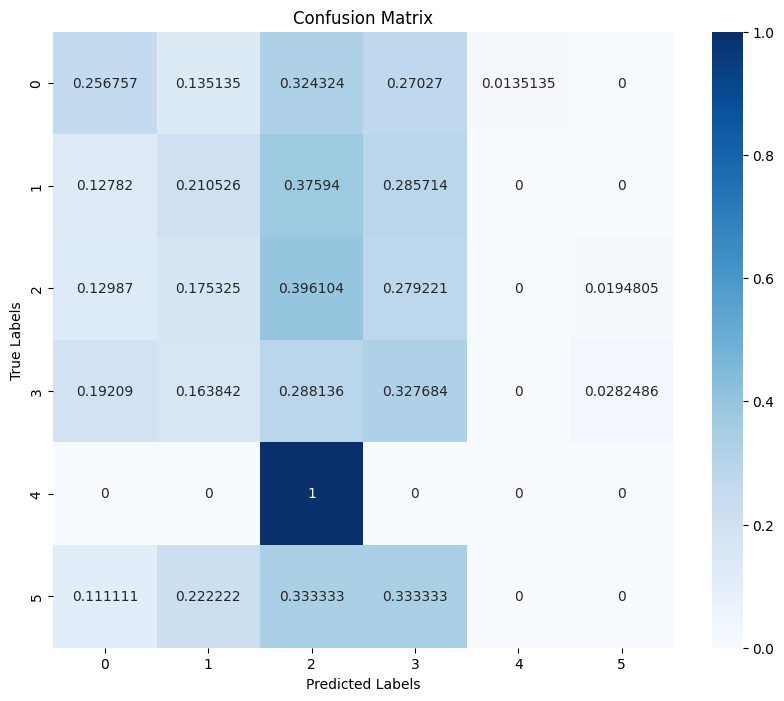

Epoch 2, Validation Loss: 2.1354, Accuracy: 0.2877, F1 Score: 0.2779
Val F1 Score Per Class  [0.22619048 0.23829787 0.34366197 0.33333333 0.         0.        ]


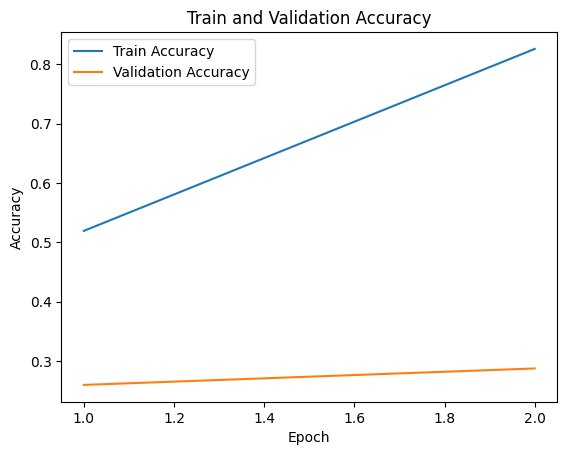

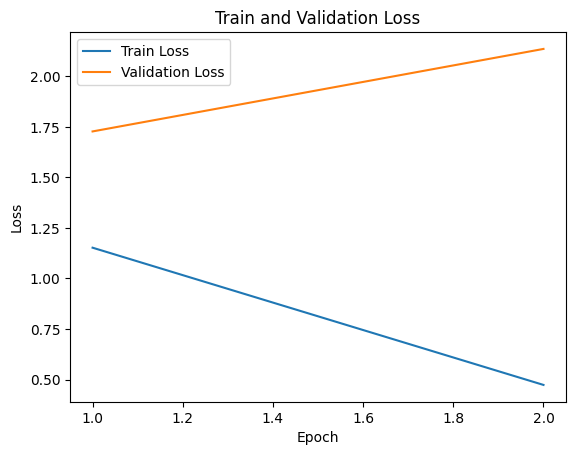

Epoch 3, Train Loss: 0.2077, Accuracy: 0.9303, F1 Score: 0.9301
Train F1 Score Per Class  [0.9565478  0.89129129 0.89029536 0.86216136 0.99941176 0.98080384]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.42it/s, loss=2.45]

[tensor([ 1.2787,  0.4704, -2.1061, -0.3350, -3.5503, -2.3682], device='cuda:0'), tensor([-1.0362,  0.6438, -0.2765,  1.6317, -2.8318, -2.6400], device='cuda:0'), tensor([-2.6851,  2.9738, -1.6904,  1.4438, -1.6201, -2.3584], device='cuda:0'), tensor([-3.5053, -0.4476, -0.2309,  1.3977, -3.5992, -2.4921], device='cuda:0'), tensor([ 0.0867, -1.7659,  2.6499,  1.2176, -3.0750, -2.6827], device='cuda:0'), tensor([-1.7485, -0.2827,  2.1970, -0.1201, -4.2064, -3.7713], device='cuda:0'), tensor([-1.8906,  3.7174, -1.0585,  0.0431, -1.8118, -2.1466], device='cuda:0'), tensor([-0.1270,  0.4065, -0.5838,  1.5335, -3.0718, -3.6238], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.41it/s, loss=2.8]

[tensor([-0.2396,  2.8349, -0.0034, -0.5242, -2.8028, -2.9622], device='cuda:0'), tensor([-3.0211,  0.8845,  1.0877,  0.8786, -3.8691, -3.0671], device='cuda:0'), tensor([ 2.7192, -2.0123,  0.5079,  0.8167, -2.2055, -2.9670], device='cuda:0'), tensor([-2.6057, -0.8448, -1.0945,  0.5299,  3.4608, -1.2346], device='cuda:0'), tensor([-1.1973,  1.4396, -0.7257,  3.0338, -3.3256, -2.5418], device='cuda:0'), tensor([-1.3971,  0.8358, -0.9055,  0.6561, -4.2680, -3.2790], device='cuda:0'), tensor([-1.7612,  0.5588, -0.2875,  2.9533, -3.5990, -2.0963], device='cuda:0'), tensor([-0.7703,  0.2475, -1.0553,  2.8507, -3.3929, -2.3232], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=1.43]

[tensor([-1.9902,  0.5186, -1.4917,  4.2540, -2.5517, -1.6642], device='cuda:0'), tensor([-2.4287,  1.0337,  1.5544,  1.2123, -2.3977, -3.2565], device='cuda:0'), tensor([-1.3815,  2.5276,  1.0706, -0.7384, -3.3534, -2.7020], device='cuda:0'), tensor([-1.9547,  0.1041,  0.5919, -0.3859, -4.0745, -3.0743], device='cuda:0'), tensor([ 2.4703, -0.3537, -0.6883,  2.5213, -3.9729, -2.9580], device='cuda:0'), tensor([-2.5733,  2.0143,  1.1373,  0.7970, -4.1309, -4.0967], device='cuda:0'), tensor([-1.4746,  0.1766, -1.6136,  1.4333, -2.7536, -1.6400], device='cuda:0'), tensor([-1.8839,  2.1976,  0.1525,  0.2082, -3.2976, -3.1714], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.38it/s, loss=1.83]

[tensor([ 0.5712,  0.5603, -2.1268,  0.9110, -2.3762, -1.4844], device='cuda:0'), tensor([-1.6775, -0.2892, -1.3529,  3.7068, -2.1212, -2.0560], device='cuda:0'), tensor([-3.4017, -0.0763,  3.5002,  1.1149, -3.4035, -2.6193], device='cuda:0'), tensor([-0.8049,  0.8411, -1.3393,  1.3643, -2.8191, -1.7874], device='cuda:0'), tensor([-1.2755, -0.0642,  3.1509, -0.4717, -3.5903, -2.5538], device='cuda:0'), tensor([-1.5433, -0.7281, -0.3448, -0.2768, -3.1925, -3.2414], device='cuda:0'), tensor([ 0.6680,  0.1221, -0.6539,  1.8633, -2.2238, -2.3060], device='cuda:0'), tensor([-2.7895,  1.2770,  0.2651,  2.5474, -3.7948, -2.9678], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.37it/s, loss=3.8]

[tensor([-2.7613,  2.1908, -0.3152,  0.5502, -3.8705, -2.6389], device='cuda:0'), tensor([-2.0546, -0.8677, -0.8757,  2.0906, -3.5930, -1.1743], device='cuda:0'), tensor([-2.0986,  1.9458, -0.9650,  0.4129, -2.7537, -1.1963], device='cuda:0'), tensor([-2.0517, -1.1389,  5.0314, -0.0806, -2.3820, -1.5597], device='cuda:0'), tensor([-1.4981, -1.4879,  0.0191,  0.3067, -1.9404,  3.0923], device='cuda:0'), tensor([-2.4509, -0.4411,  0.5823,  2.3250, -2.7886, -0.9605], device='cuda:0'), tensor([-1.8239,  2.9662, -0.6266, -0.0957, -2.7316, -2.8084], device='cuda:0'), tensor([-0.9595,  1.3293,  0.0663,  0.0135, -2.8390, -3.0161], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.38it/s, loss=2.98]

[tensor([-0.5016,  1.5566, -2.4914,  2.6535, -3.6372, -3.2325], device='cuda:0'), tensor([-2.0256,  0.6879, -1.0981,  2.6721, -3.5625, -2.1747], device='cuda:0'), tensor([-1.8200, -0.5584, -1.5728,  1.0679, -1.7607,  1.3957], device='cuda:0'), tensor([-2.6791, -0.5119,  0.6545,  0.5189, -3.9598, -3.2070], device='cuda:0'), tensor([-0.5130, -0.1722, -1.2969,  3.6601, -3.9312, -1.7204], device='cuda:0'), tensor([-1.2250,  1.7932,  0.3694,  0.1404, -3.6474, -2.8517], device='cuda:0'), tensor([-2.0185,  4.4335, -0.7305,  0.3142, -2.6780, -2.5955], device='cuda:0'), tensor([-1.5106e+00,  4.1903e+00, -1.6374e+00, -1.9012e-03, -1.7262e+00,
        -2.3860e+00], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.38it/s, loss=1.52]

[tensor([-2.2653,  0.9781, -1.0514,  2.0014, -3.5846, -2.6951], device='cuda:0'), tensor([-2.3201, -1.0004,  2.5639,  1.3862, -3.3889, -1.7395], device='cuda:0'), tensor([ 0.3912, -0.6888, -0.8585,  1.8426, -2.9481, -1.8098], device='cuda:0'), tensor([-1.6551,  3.1707, -1.3386, -0.2257, -2.3112, -2.7336], device='cuda:0'), tensor([-1.8898,  1.3679,  1.1024,  2.4710, -3.4284, -3.1597], device='cuda:0'), tensor([-3.2337, -0.8851,  2.3265,  2.7097, -3.0841, -1.8459], device='cuda:0'), tensor([-2.2908,  1.9923, -0.7068, -0.0540, -3.7152, -2.6413], device='cuda:0'), tensor([-1.9187, -0.3242,  0.6546,  1.6011, -3.1548, -2.0248], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.37it/s, loss=2.35]

[tensor([-1.8717,  3.5556, -1.6746,  0.3164, -1.6828, -2.3983], device='cuda:0'), tensor([-2.2626,  2.0384, -0.9086, -0.7408, -3.1083, -0.1236], device='cuda:0'), tensor([-0.3491,  0.0852, -1.9718,  2.0603, -3.6541, -0.6428], device='cuda:0'), tensor([-2.3323,  0.6530,  0.3464,  2.4899, -4.3650, -2.2167], device='cuda:0'), tensor([-1.8783,  0.8872, -1.1494,  2.2375, -3.0202, -2.1968], device='cuda:0'), tensor([-1.2292, -0.2339, -1.2964,  2.6690, -2.6267, -0.8500], device='cuda:0'), tensor([-1.0898, -0.3019,  2.1533,  1.7332, -3.5387, -3.3642], device='cuda:0'), tensor([-3.4045,  2.9361,  0.1676,  0.2022, -3.0199, -2.0441], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.38it/s, loss=2.25]

[tensor([-2.1532,  4.5899, -0.4813, -0.0484, -2.9753, -1.9489], device='cuda:0'), tensor([-2.2054, -1.3316, -0.0724,  2.8756, -2.6429, -1.9239], device='cuda:0'), tensor([ 0.4340,  0.2312, -2.2965,  3.3004, -3.1722, -2.4621], device='cuda:0'), tensor([-2.3096, -0.2717, -1.0492,  3.0000, -3.2041, -1.9074], device='cuda:0'), tensor([-2.4967, -0.5631,  0.9267,  3.4146, -3.6796, -2.1234], device='cuda:0'), tensor([-1.7616,  0.2174, -2.2760,  0.8938, -2.5536,  1.5637], device='cuda:0'), tensor([-2.1373,  2.8800,  0.0368,  0.7973, -3.3621, -2.1253], device='cuda:0'), tensor([-3.0618,  0.8183,  2.4717,  0.4803, -3.8282, -1.8110], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.38it/s, loss=3.53]

[tensor([-3.0796, -0.7304,  0.6871,  1.2329, -3.7221, -2.1696], device='cuda:0'), tensor([-0.2351, -0.6756, -0.7520,  1.5217, -3.0113, -2.7605], device='cuda:0'), tensor([-1.8404,  0.9074, -1.5412,  2.2060, -3.2750, -2.9265], device='cuda:0'), tensor([-2.6742,  2.3303, -1.3034,  1.2710, -3.1595, -1.3724], device='cuda:0'), tensor([-2.2707,  1.4245,  3.1572, -0.5130, -3.3346, -2.9259], device='cuda:0'), tensor([-2.3674,  0.6598, -0.1643,  2.5645, -3.5517, -2.7912], device='cuda:0'), tensor([-1.1394,  1.2400, -0.9271,  0.9842, -3.3466, -3.4354], device='cuda:0'), tensor([-1.1658,  0.5113, -0.7708,  2.0862, -2.4645, -3.2812], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=2.68]

[tensor([-2.3124,  0.6437, -0.6348,  3.2887, -3.5538, -2.8671], device='cuda:0'), tensor([-2.3431, -0.3973, -0.0337,  3.0913, -3.1833, -1.5980], device='cuda:0'), tensor([-3.2756,  1.3151, -0.4221,  0.3633, -3.1416, -1.9081], device='cuda:0'), tensor([-2.6909,  0.2560,  0.3933,  1.8150, -3.2820, -2.5279], device='cuda:0'), tensor([ 1.7983,  0.1692, -1.6572,  0.9114, -2.7379, -2.8267], device='cuda:0'), tensor([-2.8127,  0.0472,  3.0323,  0.7489, -3.9418, -1.9654], device='cuda:0'), tensor([-1.8436,  1.0140, -0.8931,  2.8023, -3.9392, -3.0123], device='cuda:0'), tensor([-1.4172, -0.0691, -0.2164,  1.3837, -3.4072, -0.9903], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.36it/s, loss=2.72]

[tensor([ 0.9633,  0.0070, -0.5274,  1.4511, -3.9950, -3.3068], device='cuda:0'), tensor([-1.9035,  0.9390,  0.5338,  0.3745, -3.7899, -3.1481], device='cuda:0'), tensor([-0.8090,  0.4488, -1.5755,  2.1331, -3.6602, -1.5628], device='cuda:0'), tensor([-1.0261, -1.4033,  0.4423,  0.9132, -4.2924, -1.3715], device='cuda:0'), tensor([-1.6891,  4.7507, -0.4567, -0.3772, -2.7747, -2.5851], device='cuda:0'), tensor([-1.6775,  3.2895,  0.1837, -0.2131, -3.2349, -2.8338], device='cuda:0'), tensor([-2.3758, -0.6654,  2.1892,  0.0219, -4.2670, -1.9997], device='cuda:0'), tensor([-2.5828,  1.3016,  0.6831,  1.7814, -4.0393, -2.3214], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.37it/s, loss=2.53]

[tensor([-2.4972,  0.8697, -0.6708, -0.0427, -2.7218,  0.9382], device='cuda:0'), tensor([-1.8718, -0.5487, -1.0821,  3.7708, -3.1188, -2.8085], device='cuda:0'), tensor([-1.2649,  0.1143, -1.5569,  2.9771, -2.7893, -2.4132], device='cuda:0'), tensor([-3.0715,  0.1059,  1.9991,  2.5752, -3.8731, -2.4247], device='cuda:0'), tensor([-1.8019,  0.3197, -0.5161,  1.7165, -3.3176, -2.5875], device='cuda:0'), tensor([ 0.7006,  0.0828, -1.5935,  0.5081, -3.1109, -3.3818], device='cuda:0'), tensor([-2.3275,  2.9262, -1.1620, -0.4024, -2.1156, -1.2734], device='cuda:0'), tensor([-1.9265,  0.1543, -1.0039,  0.8615, -3.5283, -1.1554], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.37it/s, loss=2.12]

[tensor([-0.6796, -0.5590,  1.2806,  1.2555, -3.6689, -3.7902], device='cuda:0'), tensor([-0.9589,  4.1972, -1.0409, -0.8341, -2.6195, -2.6979], device='cuda:0'), tensor([ 0.5501,  1.3673, -1.4839,  0.2148, -3.3114, -2.5278], device='cuda:0'), tensor([-1.5601, -0.3456, -1.0513,  4.2950, -2.7111, -2.5461], device='cuda:0'), tensor([-2.5276,  3.2180, -1.3324,  0.7922, -2.9190, -2.7540], device='cuda:0'), tensor([-2.5194,  1.4359, -0.4238,  1.3086, -3.2969, -2.9932], device='cuda:0'), tensor([-0.8596,  1.3363, -1.3512,  0.4561, -3.0554, -2.6172], device='cuda:0'), tensor([-1.2346,  1.7945, -0.8576,  1.3055, -3.0355, -3.1486], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.37it/s, loss=0.992]

[tensor([-0.5721, -0.0220, -1.7874,  2.1188, -3.7792, -3.8600], device='cuda:0'), tensor([-1.6713, -0.4930,  0.4789,  0.5630, -3.1698, -2.3119], device='cuda:0'), tensor([-1.8883, -1.5257,  0.7695,  2.4040, -2.8501, -1.2262], device='cuda:0'), tensor([-2.6681,  2.9674,  0.3563, -0.0341, -3.3674, -2.6940], device='cuda:0'), tensor([-0.7380, -1.0342,  1.0509,  0.6797, -4.5583, -2.9602], device='cuda:0'), tensor([ 0.2389, -1.5928, -1.0578,  2.6475, -3.3050, -1.0798], device='cuda:0'), tensor([-1.3841, -0.0383, -1.3116,  1.8910, -2.6721, -1.2608], device='cuda:0'), tensor([-1.6896,  0.6340,  0.3325,  0.7335, -3.6354, -3.0787], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=2.09]

[tensor([-1.4068,  2.2863, -0.7657,  1.4197, -3.2860, -3.1045], device='cuda:0'), tensor([-2.6786, -0.2209,  0.5307,  3.3442, -3.9356, -2.6800], device='cuda:0'), tensor([-3.2567, -0.1879,  1.9959,  0.6910, -3.8019, -1.3648], device='cuda:0'), tensor([-2.9769, -0.1738,  0.5578,  1.4888, -3.4153, -0.3362], device='cuda:0'), tensor([-1.1513,  0.9105,  0.2663,  1.7979, -2.9228, -3.1577], device='cuda:0'), tensor([-0.7305,  1.0278, -0.8907,  1.6285, -3.3349, -3.3396], device='cuda:0'), tensor([-3.1060,  0.0575, -1.0010,  2.2027, -3.1225, -1.8585], device='cuda:0'), tensor([ 3.1713, -0.9514, -2.1419,  0.0961, -1.5161, -2.2577], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=3.63]

[tensor([-2.4656,  2.9414,  0.7491,  0.7698, -3.3143, -2.8177], device='cuda:0'), tensor([-1.2606,  3.4173, -0.1704,  1.4025, -3.5171, -3.3104], device='cuda:0'), tensor([-3.4483,  0.2668, -0.3139,  1.8202, -3.2389,  0.6561], device='cuda:0'), tensor([-3.0224,  0.2370,  1.9055,  1.2787, -3.7702, -3.4325], device='cuda:0'), tensor([ 5.2701, -0.9167, -0.8716, -0.5556, -2.4212, -2.1866], device='cuda:0'), tensor([-1.5884,  1.2255,  0.4527,  1.2426, -4.5130, -3.1000], device='cuda:0'), tensor([-1.2266,  0.1081,  0.4490,  1.0696, -4.2895, -2.4762], device='cuda:0'), tensor([-1.9229, -0.9925,  2.2240,  0.9325, -3.7546, -2.9253], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=2.43]

[tensor([-0.9702, -0.0977, -1.5992,  2.0891, -3.0326, -2.1010], device='cuda:0'), tensor([-0.9357, -1.1413, -1.0249,  2.2498, -0.9877, -1.3522], device='cuda:0'), tensor([-0.5826,  0.9453, -0.7045,  0.6631, -3.2490, -3.2286], device='cuda:0'), tensor([-2.9722,  1.0668,  0.0333,  2.5796, -2.9284, -2.5063], device='cuda:0'), tensor([-1.3472, -0.1634, -0.7348,  3.2105, -3.9287, -1.9612], device='cuda:0'), tensor([ 1.0196,  0.0187, -1.0799,  1.6952, -4.0136, -2.7387], device='cuda:0'), tensor([-0.1970, -1.2382, -0.2699,  2.0418, -4.1232, -1.9061], device='cuda:0'), tensor([-1.8408,  3.4081,  0.6567, -1.0948, -3.1072, -2.9686], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:22,  2.37it/s, loss=2.26]

[tensor([-2.9799,  0.5256,  0.6974,  0.5936, -2.7780, -2.4822], device='cuda:0'), tensor([-0.9406,  0.4716, -1.7369,  0.3390, -1.7055, -3.1872], device='cuda:0'), tensor([-0.3489, -1.3379, -0.1636,  0.9602, -2.0626, -1.7717], device='cuda:0'), tensor([ 1.4125,  0.1032, -1.6863,  0.4212,  0.2714, -2.1864], device='cuda:0'), tensor([-3.0703,  1.3976,  0.9174,  1.7602, -3.1925, -2.6003], device='cuda:0'), tensor([-1.3340,  2.4835, -1.2543, -0.4710, -2.8024, -2.2671], device='cuda:0'), tensor([-1.4673, -0.9024, -0.6966,  4.6277, -2.8726, -1.8014], device='cuda:0'), tensor([-2.2647,  1.7427, -0.2758,  0.8181, -2.7979, -2.7600], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=2.16]

[tensor([-2.1895,  3.8916, -0.6320, -0.4501, -2.8469, -2.1596], device='cuda:0'), tensor([-1.4508, -0.9384, -0.4581,  4.0074, -3.2568, -1.2700], device='cuda:0'), tensor([-2.6877,  0.6637,  0.0839,  3.3188, -3.3077, -2.2146], device='cuda:0'), tensor([-2.7385,  2.0970,  0.6927,  1.1361, -3.8204, -2.8378], device='cuda:0'), tensor([-2.8767,  1.0279, -1.3230,  1.3476, -2.2426, -2.3005], device='cuda:0'), tensor([-2.7179,  1.2867,  1.7951, -0.5947, -3.9475, -1.2315], device='cuda:0'), tensor([-2.5029,  0.0510,  0.5339,  1.3423, -3.0579, -1.8464], device='cuda:0'), tensor([-2.0816,  1.1541, -0.9001,  3.1787, -3.4534, -2.4876], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:22,  2.36it/s, loss=3.7]

[tensor([-1.9867, -0.5948,  4.5589, -0.8105, -3.1022, -2.1950], device='cuda:0'), tensor([-0.7458,  1.8238, -0.3135, -0.0356, -3.3562, -3.3515], device='cuda:0'), tensor([-0.8426,  0.9378, -2.7380,  1.0517, -2.5075, -2.7622], device='cuda:0'), tensor([-0.3957, -0.2771, -2.1722,  3.2952, -3.3671, -2.1784], device='cuda:0'), tensor([-0.6243,  0.9588, -1.8430,  0.7988, -2.9448, -1.2791], device='cuda:0'), tensor([-1.5170, -0.8989, -0.2843,  2.3188, -4.3697, -3.4826], device='cuda:0'), tensor([-1.4120,  3.8535,  0.4155, -0.9052, -2.9919, -1.8964], device='cuda:0'), tensor([ 0.2721, -0.8772,  0.5723, -0.6271, -2.8264, -3.1884], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.36it/s, loss=1.31]

[tensor([-0.1488, -1.3708,  0.8927,  0.0402, -3.8243, -2.3196], device='cuda:0'), tensor([-0.7711, -0.6026,  1.5232,  2.0131, -4.0666, -3.2984], device='cuda:0'), tensor([ 1.7672,  0.7524,  0.7275, -0.3427, -3.8464, -3.7530], device='cuda:0'), tensor([-2.1141, -0.4736, -1.0529,  2.4702, -3.2974, -0.5890], device='cuda:0'), tensor([-1.8037,  2.1410, -1.1838,  0.0135, -3.1002, -2.3788], device='cuda:0'), tensor([ 2.3602, -1.3039, -0.0557,  1.1553, -4.4371, -1.5641], device='cuda:0'), tensor([-0.8935, -2.0410, -0.5020,  3.4517, -4.1403, -1.7922], device='cuda:0'), tensor([-2.7590, -0.4055,  4.2687, -0.1723, -2.8919, -2.0375], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.36it/s, loss=2.61]

[tensor([ 0.1585, -1.4347, -1.4560, -0.1236, -2.7438, -2.2942], device='cuda:0'), tensor([-1.7550,  2.4487, -0.4272, -1.4835, -2.8590,  1.0544], device='cuda:0'), tensor([-1.7263,  1.9596, -1.2670,  0.7969, -3.1517, -2.5115], device='cuda:0'), tensor([-0.9388,  4.1890, -1.0694, -0.7497, -2.5955, -2.4631], device='cuda:0'), tensor([-2.4602,  1.1240, -1.2298,  0.3924, -2.9627, -2.4581], device='cuda:0'), tensor([-2.4221,  3.7655,  0.0839,  0.3881, -2.7472, -2.7182], device='cuda:0'), tensor([-1.9077, -1.5103,  0.0389,  1.0401, -3.0519, -0.3945], device='cuda:0'), tensor([-2.2438,  2.9025, -1.1224, -0.0101, -3.7277, -2.5652], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.36it/s, loss=2.08]

[tensor([-2.4513, -0.6750,  0.3309,  2.6660, -3.1164, -2.6015], device='cuda:0'), tensor([-1.6402, -0.3347,  1.6524,  1.2460, -3.6564, -3.4710], device='cuda:0'), tensor([-2.3986,  2.3299, -0.8006,  0.9119, -3.5043, -2.8764], device='cuda:0'), tensor([-1.4354,  0.3164, -1.0287,  1.5627, -3.7953, -3.4698], device='cuda:0'), tensor([ 1.4938,  0.7198, -2.5142,  2.2489, -2.8488, -2.6792], device='cuda:0'), tensor([-0.8433,  0.8569, -1.8917,  1.1862, -3.7687, -2.3678], device='cuda:0'), tensor([-0.3192, -0.4999, -2.2117, -0.6931, -0.5045,  3.1902], device='cuda:0'), tensor([ 1.1383, -0.5650, -0.0864, -0.6145, -3.1857, -2.7839], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=1.61]

[tensor([-2.1743,  0.3339,  0.2180,  2.2529, -4.2768, -2.7453], device='cuda:0'), tensor([-1.7782,  2.3224, -0.0267,  2.2768, -3.3360, -2.8072], device='cuda:0'), tensor([-2.3070,  1.5816, -0.1015,  1.2621, -3.5743, -2.0646], device='cuda:0'), tensor([-2.0127,  0.8678, -0.6390,  0.5179, -2.8298, -1.4778], device='cuda:0'), tensor([-1.9191,  1.2783, -1.6154,  0.9156, -3.8633, -2.5172], device='cuda:0'), tensor([-2.0392,  0.3600, -0.4008,  2.2739, -3.6157, -2.8641], device='cuda:0'), tensor([-0.8437,  2.0402, -1.9880,  0.5362, -2.6731, -2.6565], device='cuda:0'), tensor([-1.1678,  0.9289, -1.9087,  1.4344, -2.7565, -2.4508], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.37it/s, loss=2.11]

[tensor([-1.5204,  0.4584, -0.3186,  3.9265, -3.7264, -2.9974], device='cuda:0'), tensor([-3.5638,  0.7683, -1.0512,  2.0472, -3.7609,  0.1160], device='cuda:0'), tensor([-1.8181, -2.0684,  1.6108,  0.7352, -3.5530, -1.1706], device='cuda:0'), tensor([ 2.0776, -1.0472, -0.7436,  1.1546, -3.9782, -2.0654], device='cuda:0'), tensor([-1.8422,  4.6239,  0.1346, -0.3951, -2.7358, -2.3446], device='cuda:0'), tensor([ 0.5358, -1.6929,  2.7543, -0.4469, -3.0625, -0.8570], device='cuda:0'), tensor([-2.3277,  0.9826,  0.2116, -0.5114, -2.7310, -2.7943], device='cuda:0'), tensor([-2.3661,  0.3041, -0.5612,  1.3998, -3.9519, -3.6578], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=2.63]

[tensor([-2.1873,  3.1456, -0.3797,  1.6448, -3.3500, -2.7203], device='cuda:0'), tensor([-2.1595, -1.1361, -0.3184,  2.6001, -2.3980, -2.0483], device='cuda:0'), tensor([ 0.8030, -0.8431, -1.3670,  2.0646, -2.6450, -2.5335], device='cuda:0'), tensor([-2.1867, -0.5183, -0.3986,  0.9245, -3.2896,  0.0094], device='cuda:0'), tensor([-1.5317,  4.7898, -0.3120, -1.0211, -2.3870, -2.3032], device='cuda:0'), tensor([-0.4399, -0.5980, -1.6056,  3.5119, -2.8774, -1.8257], device='cuda:0'), tensor([-2.1816, -1.4963,  0.0098,  1.8296, -4.6216, -2.9599], device='cuda:0'), tensor([-1.7158,  1.6643, -0.6132,  1.5245, -3.3632, -3.0628], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:19,  2.37it/s, loss=2.93]

[tensor([ 1.2107, -1.1967, -0.7356,  2.8190, -3.4308, -2.7942], device='cuda:0'), tensor([-0.0376, -0.4248, -0.8716,  0.3581, -3.9289, -2.7486], device='cuda:0'), tensor([-0.9653,  4.9118, -1.3751, -0.6647, -1.7779, -1.9737], device='cuda:0'), tensor([-2.8053,  0.5503,  2.6765,  1.2736, -3.2197, -2.8657], device='cuda:0'), tensor([-1.3213, -0.7987, -1.1235,  4.3863, -3.2311, -2.5809], device='cuda:0'), tensor([-2.2233,  4.2054, -0.4173,  0.1566, -2.6264, -2.4537], device='cuda:0'), tensor([-1.6379, -1.5960,  3.4856,  0.6748, -3.3815, -1.7724], device='cuda:0'), tensor([-1.6698,  3.4748, -0.5520, -1.0524, -2.8593, -2.8697], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=2.66]

[tensor([-3.1539,  1.5200,  1.0003,  2.4731, -3.5612, -2.6900], device='cuda:0'), tensor([-2.1583,  3.1295, -1.4499,  0.3485, -2.0497, -1.5234], device='cuda:0'), tensor([-1.9975, -0.9817,  3.4946, -0.1609, -3.1620, -1.4749], device='cuda:0'), tensor([-2.9931, -0.5552,  0.4268,  1.3587, -3.1222, -1.7120], device='cuda:0'), tensor([ 3.3540, -1.0056, -1.1268, -0.2793, -3.1955, -2.0515], device='cuda:0'), tensor([-3.0584,  1.1692,  1.6769,  1.0410, -3.7551, -1.8365], device='cuda:0'), tensor([-3.2776,  0.2427,  0.5477,  1.6772, -3.5969, -1.8616], device='cuda:0'), tensor([-3.1863, -0.6638, -0.2040, -0.7986, -2.9204, -2.2437], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.37it/s, loss=2.5]

[tensor([-2.2607,  0.5583, -0.5902,  1.9646, -3.8193, -2.2440], device='cuda:0'), tensor([-1.8789,  1.8003,  0.5421,  0.8171, -2.6037, -3.2567], device='cuda:0'), tensor([-0.2737,  1.3932, -1.7232,  0.1991, -2.2470, -2.0638], device='cuda:0'), tensor([-1.6612,  0.5997, -0.7383,  2.8368, -3.4120, -3.3454], device='cuda:0'), tensor([-2.3794,  2.2302,  1.6844, -0.3803, -3.7716, -2.4323], device='cuda:0'), tensor([-1.3219, -1.4286,  1.8176, -0.8714, -2.6768, -2.2604], device='cuda:0'), tensor([-2.3649, -0.6849,  0.5538,  0.8007, -4.0737, -2.5678], device='cuda:0'), tensor([-1.9840, -1.7421,  1.7664, -0.4001, -3.3357,  1.9185], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.38it/s, loss=2.29]

[tensor([-1.8204, -0.0079, -1.8822,  3.8522, -2.7370, -0.6487], device='cuda:0'), tensor([-2.5439, -0.3094, -0.1489,  3.4201, -3.1450, -1.6251], device='cuda:0'), tensor([-2.9682, -0.3693,  3.8953, -0.0917, -2.9277, -1.8936], device='cuda:0'), tensor([-2.8107, -0.6286, -0.9503,  2.0699, -3.9587, -2.1846], device='cuda:0'), tensor([-3.0529,  0.8982,  0.4221,  1.3702, -3.5002, -2.3996], device='cuda:0'), tensor([ 5.1061, -0.2860, -1.5649, -1.2816, -1.6664, -1.0526], device='cuda:0'), tensor([-3.2216, -0.7321,  0.8207,  2.3973, -3.4423, -1.8003], device='cuda:0'), tensor([-2.3452, -0.5707,  2.9509,  1.4283, -3.7151, -2.6175], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.37it/s, loss=3.59]

[tensor([-1.9045,  2.3614, -1.8946,  0.9554, -2.9461, -0.7080], device='cuda:0'), tensor([-2.6006,  0.5920, -0.9278,  3.6331, -3.3704, -1.9573], device='cuda:0'), tensor([-1.8845,  4.7171, -0.7482, -0.6661, -2.2121, -2.1872], device='cuda:0'), tensor([-1.3484,  0.7047, -1.2919,  0.4263, -0.6283, -1.2290], device='cuda:0'), tensor([-2.9247,  1.3491, -0.2207,  1.6515, -3.3015, -2.5217], device='cuda:0'), tensor([-1.9928, -1.4081,  0.9180,  2.9758, -3.2511, -0.1949], device='cuda:0'), tensor([ 1.0718, -0.6434,  1.0043,  1.5333, -4.2597, -2.9539], device='cuda:0'), tensor([-2.1708,  0.4703, -0.3136,  0.3986, -4.3337, -2.9959], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=3.34]

[tensor([-3.2069,  0.1841, -0.9318,  2.3849, -2.8587, -0.9136], device='cuda:0'), tensor([-1.8042,  4.3937, -0.6466, -0.5794, -2.2565, -0.7235], device='cuda:0'), tensor([-1.6536,  0.1184, -1.0881,  3.4588, -3.1567, -1.0948], device='cuda:0'), tensor([-1.4135,  4.1423, -0.4738, -1.4343, -3.0082, -1.9885], device='cuda:0'), tensor([-3.1375,  0.1046,  3.0262,  1.4311, -4.0145, -3.1129], device='cuda:0'), tensor([-3.4161,  0.7245,  0.2296,  2.1206, -3.3985, -2.3366], device='cuda:0'), tensor([-1.6434,  0.7780, -1.1873, -0.1085, -3.5599, -2.7190], device='cuda:0'), tensor([-2.9359,  1.4080, -0.3896,  1.4033, -3.8726, -2.3030], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=2.28]

[tensor([ 2.7471,  0.4402, -2.0072, -0.0631, -2.6288, -2.4643], device='cuda:0'), tensor([-2.3670,  3.6966, -0.0990,  0.8254, -3.7266, -2.8447], device='cuda:0'), tensor([ 1.6104, -0.3694, -1.3871, -1.2821, -0.5153, -1.5407], device='cuda:0'), tensor([-2.4130, -1.8686,  0.4973,  1.3553, -3.0874, -1.4862], device='cuda:0'), tensor([-2.0823,  3.3061, -0.7838,  0.8990, -2.9474, -2.8128], device='cuda:0'), tensor([-2.1297,  2.3292,  0.6406,  0.8902, -3.9334, -2.1875], device='cuda:0'), tensor([-1.4815, -1.0294, -0.6615,  3.4451, -3.6714, -2.6992], device='cuda:0'), tensor([-1.3145, -1.4585,  2.7034, -0.3076, -3.5735, -1.3255], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.37it/s, loss=2.54]

[tensor([-1.9426,  0.8288,  0.5054,  0.4757, -4.4902, -3.0217], device='cuda:0'), tensor([-2.2182,  0.1076,  0.2315,  3.1378, -3.5818, -1.9343], device='cuda:0'), tensor([-1.8925, -2.2558,  1.1868,  1.6896, -3.1030, -1.8779], device='cuda:0'), tensor([-2.3113, -0.2087,  4.6614,  0.4846, -2.9893, -2.0694], device='cuda:0'), tensor([-2.7184,  0.8977,  0.8293,  2.3635, -3.6515, -2.5427], device='cuda:0'), tensor([-1.7197, -0.0807, -0.9791,  3.4089, -2.6259, -1.6422], device='cuda:0'), tensor([-2.5416,  1.2457,  2.5283,  0.2728, -3.7966, -3.3292], device='cuda:0'), tensor([-1.4028,  4.0398, -0.7144,  0.0532, -2.4133, -2.7208], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=1.62]

[tensor([-1.6539,  1.5378,  0.6092, -1.0507, -3.8043, -2.6696], device='cuda:0'), tensor([-2.2988, -0.3317,  1.9429,  0.3037, -3.5233, -2.8134], device='cuda:0'), tensor([-2.2685, -0.0838, -0.6030, -0.0233, -3.3231, -1.4576], device='cuda:0'), tensor([-2.5797,  2.4291, -0.5056,  0.9677, -3.8616, -2.8019], device='cuda:0'), tensor([-2.0538, -0.1625, -0.3704,  3.6966, -3.1447, -2.2507], device='cuda:0'), tensor([-3.4245, -0.3137,  1.7331,  1.2444, -3.8355, -1.6035], device='cuda:0'), tensor([-1.7107, -0.8684, -0.5103,  4.0078, -3.4908, -2.1465], device='cuda:0'), tensor([-1.3509,  0.7869, -0.6548,  2.6653, -3.2320, -2.8162], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=3.53]

[tensor([-0.0485, -1.9860, -1.2885,  2.0492, -2.5679, -1.5927], device='cuda:0'), tensor([-2.4680, -1.0903,  0.9383,  0.8562, -4.2364, -2.7302], device='cuda:0'), tensor([ 0.3239, -0.3292, -1.7832,  1.7642, -2.3388, -1.6734], device='cuda:0'), tensor([-2.0124,  2.5189, -1.3957,  0.0168, -3.4331, -2.0835], device='cuda:0'), tensor([-1.0690,  0.2575, -0.0939, -0.5037, -4.0794, -2.5276], device='cuda:0'), tensor([-2.3126,  3.5037,  0.2331, -0.5804, -3.5612, -2.9848], device='cuda:0'), tensor([-2.0263,  4.1954, -0.2329, -0.6313, -2.9236, -2.8269], device='cuda:0'), tensor([-1.8705,  4.1403, -0.7878,  0.7221, -2.1436, -2.5624], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.37it/s, loss=1.88]

[tensor([-2.3962, -0.8771,  3.5282,  0.3919, -2.4775, -1.0448], device='cuda:0'), tensor([-1.9443e+00, -1.3323e-01,  2.8123e-03,  1.8052e+00, -4.3992e+00,
        -1.3740e+00], device='cuda:0'), tensor([-1.0047, -1.2505,  0.4383,  2.1727, -3.5009, -3.1822], device='cuda:0'), tensor([-2.1799, -0.7525, -0.8447,  2.4148, -3.1214, -2.2317], device='cuda:0'), tensor([-1.6317,  1.3077, -0.4909,  1.6000, -3.2589, -3.0782], device='cuda:0'), tensor([-1.1658,  4.1947, -0.9345, -0.6463, -2.2970, -2.0046], device='cuda:0'), tensor([ 1.5084, -1.1146, -0.5051,  0.0479, -3.2139, -2.1980], device='cuda:0'), tensor([-2.6678,  3.0917,  0.9274,  1.4299, -3.8737, -2.8830], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=2.95]

[tensor([-2.5055, -0.8761,  3.5893,  1.2423, -3.9539, -2.6928], device='cuda:0'), tensor([-2.0605,  3.0601,  0.1154,  0.1345, -3.4491, -3.2809], device='cuda:0'), tensor([-0.8977, -1.4150,  1.1274,  0.8779, -4.2727, -1.9554], device='cuda:0'), tensor([-0.7597, -1.6482,  0.0961,  2.2793, -4.1393, -2.1509], device='cuda:0'), tensor([-2.4033,  4.0251, -0.8450,  0.3942, -2.6214, -2.3022], device='cuda:0'), tensor([-3.2690,  0.3215,  2.4400,  0.5515, -3.6460, -2.1243], device='cuda:0'), tensor([-0.4138, -0.9146,  1.6986,  0.2614, -3.7207, -3.5681], device='cuda:0'), tensor([-1.8659, -1.0750, -0.4055, -0.9395, -3.1659,  4.7470], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.36it/s, loss=2.76]

[tensor([-0.0762,  0.4229, -0.6210,  2.1618, -3.3782, -2.2291], device='cuda:0'), tensor([-1.5114,  0.4921,  1.0410,  0.1491, -2.9454, -3.3782], device='cuda:0'), tensor([-2.0609, -0.5386,  0.6946,  2.3054, -4.1565, -1.9495], device='cuda:0'), tensor([-0.8556,  0.6091, -2.3106,  1.9643, -2.6956, -2.1372], device='cuda:0'), tensor([-2.3803,  0.9993,  0.4768,  1.7823, -3.8648, -2.6462], device='cuda:0'), tensor([ 1.6091, -0.2712, -2.0433,  0.9969, -2.9192, -2.7042], device='cuda:0'), tensor([-2.2393,  3.3287, -0.1752,  0.3352, -3.6245, -2.8003], device='cuda:0'), tensor([-1.3581,  1.4122, -1.0131, -0.1192, -3.8283, -1.5250], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.36it/s, loss=2.25]

[tensor([-2.4460, -1.1139,  0.6325,  1.5939, -3.8781, -2.3201], device='cuda:0'), tensor([ 1.3791,  0.9626, -1.1163, -0.0178, -1.3940, -3.1883], device='cuda:0'), tensor([-1.7224,  1.4542, -1.3393,  2.6862, -3.2339, -2.6124], device='cuda:0'), tensor([-2.5770, -0.0118, -0.8766,  3.4875, -3.7839, -2.0326], device='cuda:0'), tensor([-1.4935,  2.9796, -1.0716,  0.7792, -2.8260, -2.6452], device='cuda:0'), tensor([-3.5484,  0.5603,  2.3352,  1.4920, -2.9420, -2.2580], device='cuda:0'), tensor([-2.1473,  1.5094,  0.3879,  1.2727, -3.3454, -3.7225], device='cuda:0'), tensor([-1.4804,  4.0395, -1.7924,  0.7456, -3.1010, -3.1331], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.35it/s, loss=2.43]

[tensor([-1.1664, -1.0814, -1.8507,  3.5197, -2.0842, -0.2867], device='cuda:0'), tensor([-0.6174,  0.6938, -1.1454,  1.5275, -2.6827, -0.9861], device='cuda:0'), tensor([-0.8523, -1.1867, -0.9811,  1.2351, -4.4807, -2.7692], device='cuda:0'), tensor([ 0.2330,  0.4887, -2.5895, -0.3780, -0.7815, -1.2346], device='cuda:0'), tensor([-1.6719, -0.4989, -0.3005,  3.2204, -3.2690, -2.1638], device='cuda:0'), tensor([-1.5126, -1.2273,  0.9130,  3.5434, -3.4844, -2.5668], device='cuda:0'), tensor([-2.1557, -0.5477, -0.4796,  3.4227, -2.7123, -0.3509], device='cuda:0'), tensor([ 0.0090, -1.4115,  3.1359,  0.5084, -3.6528, -3.0681], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.36it/s, loss=1.95]

[tensor([-0.8055,  0.5399, -1.3287,  1.4887, -2.7315, -3.0351], device='cuda:0'), tensor([-1.7513,  4.2565,  0.7218, -0.1493, -2.8507, -3.1236], device='cuda:0'), tensor([-0.1409,  1.0728, -1.8535,  2.3040, -3.1074, -2.3054], device='cuda:0'), tensor([-2.5764,  3.6824, -0.1666,  0.4843, -2.9376, -1.4587], device='cuda:0'), tensor([-2.8298,  0.1930, -1.3807,  0.0791, -2.4126, -1.2443], device='cuda:0'), tensor([-2.9458,  2.1189,  1.5660,  0.4109, -3.6342, -2.2886], device='cuda:0'), tensor([-2.9737,  1.5265,  0.8329,  1.4190, -3.3884, -2.1433], device='cuda:0'), tensor([-0.8854, -1.4638,  0.6795, -0.3675, -4.0408, -2.5744], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.37it/s, loss=2.9]

[tensor([-2.3148,  4.1607, -0.2751, -0.3050, -1.4765, -2.1577], device='cuda:0'), tensor([-1.7484, -0.6929,  3.2486,  1.5653, -3.4631, -2.6642], device='cuda:0'), tensor([ 1.2730,  2.9216, -1.5476, -0.4629, -2.6489, -2.5517], device='cuda:0'), tensor([-1.5900, -1.5215, -0.5932, -0.2560, -1.9473,  5.5509], device='cuda:0'), tensor([-1.9683,  2.3373, -1.1571,  0.9491, -3.0442, -2.9477], device='cuda:0'), tensor([-2.9391, -0.2323, -1.8529,  1.3515, -3.2000, -1.1102], device='cuda:0'), tensor([-1.6447,  4.5526, -0.0575, -0.5850, -3.0429, -2.8593], device='cuda:0'), tensor([-2.4344,  1.4246,  0.2164,  2.7597, -3.6385, -2.1661], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.37it/s, loss=3.6]

[tensor([-2.1967,  1.5772,  0.4327,  1.8117, -3.9771, -2.3022], device='cuda:0'), tensor([-2.5149,  3.4579,  1.3285, -1.1520, -2.6865, -2.3070], device='cuda:0'), tensor([-1.3489,  4.9070, -1.1238, -0.2729, -2.1099, -2.2115], device='cuda:0'), tensor([-2.8771,  3.2179,  0.4760,  0.3863, -3.5400, -2.7724], device='cuda:0'), tensor([-1.9178, -1.2467, -1.2755,  3.9494, -3.1491,  0.3570], device='cuda:0'), tensor([ 2.8239, -0.4972, -1.9747,  1.5807, -3.0341, -1.7432], device='cuda:0'), tensor([ 1.7005, -0.2654, -1.1890, -0.7418,  0.0429, -2.9919], device='cuda:0'), tensor([-2.1901,  0.3474,  1.5927, -0.1925, -3.6326, -2.6726], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.37it/s, loss=3.27]

[tensor([ 1.7521, -0.4691,  0.7231,  0.1334, -3.4564, -2.5756], device='cuda:0'), tensor([ 1.2470, -0.7760, -0.9045,  0.5941, -3.1013, -3.1945], device='cuda:0'), tensor([-2.3071,  1.6195, -1.1362,  0.6883, -3.6896, -1.6501], device='cuda:0'), tensor([-1.5579, -0.9663,  2.9978,  1.5001, -4.2408, -2.9508], device='cuda:0'), tensor([-2.5586,  2.2103,  0.1703,  1.5251, -3.3676, -2.1803], device='cuda:0'), tensor([-1.9712, -0.6640,  0.3330,  0.6120, -3.8717, -2.2804], device='cuda:0'), tensor([-1.6237, -0.7857, -0.5227,  4.3277, -3.5387, -1.8856], device='cuda:0'), tensor([-1.8670,  0.5851, -1.6633,  1.9139, -3.5547, -1.3593], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.37it/s, loss=2.41]

[tensor([-3.0315,  0.5462,  2.7868,  0.3807, -3.6851, -1.9725], device='cuda:0'), tensor([ 3.1348, -2.4966,  1.0339,  0.6351, -3.1288, -2.5511], device='cuda:0'), tensor([-0.3671,  1.5838,  0.7111, -0.3384, -4.1121, -3.6826], device='cuda:0'), tensor([-1.7343, -0.1162,  2.5323, -0.8641, -3.6960, -1.8913], device='cuda:0'), tensor([-2.6063, -0.1221,  2.8437,  0.0923, -3.2295, -2.6871], device='cuda:0'), tensor([-2.0980,  1.2963, -0.6609,  1.7768, -3.9930, -2.1549], device='cuda:0'), tensor([-3.0512,  0.8492,  0.4039,  1.4124, -3.4964, -2.2741], device='cuda:0'), tensor([-2.3395,  1.4907, -0.1395,  0.4943, -4.0194, -2.1307], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.37it/s, loss=3.31]

[tensor([ 0.1203, -2.2234,  2.6050,  0.9268, -3.7016, -2.3214], device='cuda:0'), tensor([-0.4011, -0.0053,  0.2312, -0.1829, -2.6352, -0.7287], device='cuda:0'), tensor([ 1.4761, -1.6981, -0.7780, -0.1505, -2.2960, -0.2582], device='cuda:0'), tensor([-0.4214,  1.7656, -0.8867,  0.6004, -3.4885, -3.2658], device='cuda:0'), tensor([ 1.5026, -0.4713, -1.8503,  3.1828, -3.5250, -2.0085], device='cuda:0'), tensor([-2.6815, -1.2091,  2.9958,  1.2443, -4.1089, -2.4087], device='cuda:0'), tensor([-1.8574,  4.4867, -0.6590,  0.2829, -2.8269, -2.5397], device='cuda:0'), tensor([-0.7554, -1.1265,  0.3424,  4.0086, -3.9705, -2.2837], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=2.05]

[tensor([-2.9761,  2.3975,  1.1452,  0.7650, -3.7435, -3.2646], device='cuda:0'), tensor([-1.9318,  3.1955,  0.7559, -0.2056, -2.8344, -2.7473], device='cuda:0'), tensor([-2.0058, -1.5556,  4.7257, -0.1621, -2.6375, -0.9226], device='cuda:0'), tensor([ 0.3704, -1.7531, -0.6124,  1.5920, -3.6794, -2.3830], device='cuda:0'), tensor([-3.0069,  1.7959, -0.1376,  0.2601, -3.1840, -2.6231], device='cuda:0'), tensor([ 1.5310,  0.4117, -1.4521, -0.2324, -2.8372, -2.4789], device='cuda:0'), tensor([ 0.1850, -0.3810, -0.0291, -0.5196, -3.0226, -3.0734], device='cuda:0'), tensor([ 0.3139,  0.2812, -1.7608,  1.2371, -2.0996, -1.6944], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.37it/s, loss=2.17]

[tensor([-1.5939,  0.9573,  1.8329,  1.4744, -4.1061, -3.0085], device='cuda:0'), tensor([-2.5163,  2.6795,  1.0038, -0.5162, -3.2842, -2.2350], device='cuda:0'), tensor([-2.1230, -0.6114, -0.7298,  3.3346, -3.9317, -2.5413], device='cuda:0'), tensor([-3.2652, -0.2694, -0.2951,  2.5276, -3.9901, -0.7723], device='cuda:0'), tensor([-1.9893,  4.1092, -0.8846, -0.3586, -3.4780, -2.3032], device='cuda:0'), tensor([-2.2678,  0.4324,  0.9569,  1.9740, -3.4638, -2.8467], device='cuda:0'), tensor([-2.2364,  3.5342, -1.0397,  0.7713, -2.4571, -2.3471], device='cuda:0'), tensor([-2.2885, -0.9506,  0.3302,  3.5103, -3.5971, -2.2965], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=2.02]

[tensor([-2.3185, -1.1440,  0.9145,  1.0877, -3.5121, -2.3186], device='cuda:0'), tensor([-0.8882, -0.5826, -1.0689,  3.6292, -3.2805, -2.4352], device='cuda:0'), tensor([-2.8868,  1.0916,  0.6337,  0.3945, -3.3750, -2.3893], device='cuda:0'), tensor([-2.7646,  2.7876, -0.9711,  0.3351, -3.0303, -2.2112], device='cuda:0'), tensor([-0.4389, -1.8923, -0.1969,  3.1208, -3.5929, -0.5151], device='cuda:0'), tensor([-2.4566, -0.1912, -0.2758,  3.0467, -3.6272, -2.5623], device='cuda:0'), tensor([-2.6917,  1.9809,  0.7118,  1.1209, -3.6875, -2.8207], device='cuda:0'), tensor([-0.9401, -1.3541, -0.7188,  3.9131, -3.1044, -2.6084], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.37it/s, loss=2.54]

[tensor([-1.8924,  0.3887, -1.6852,  2.8235, -2.9988, -2.1864], device='cuda:0'), tensor([-0.8414,  2.5214, -0.4888,  0.1728, -3.7773, -3.4687], device='cuda:0'), tensor([-1.9505,  1.8035, -2.3767,  0.1643, -1.9145, -1.2445], device='cuda:0'), tensor([-0.8601,  0.9872, -1.7664,  0.0127, -1.3224, -2.3134], device='cuda:0'), tensor([-1.4359,  0.6004, -0.0091,  0.4381, -3.1416, -1.5832], device='cuda:0'), tensor([-0.8939, -0.7451, -1.1519,  0.9962, -3.1287, -1.7738], device='cuda:0'), tensor([-0.9807,  1.7556, -0.3855, -0.6515, -2.9976, -2.9442], device='cuda:0'), tensor([-1.0848,  3.2021, -1.3707, -0.9165, -2.6698, -2.4580], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.2]

[tensor([-1.0574, -2.0181, -0.9557,  3.1270, -3.7381,  0.7626], device='cuda:0'), tensor([-1.1237, -0.4680, -1.1941,  4.2529, -2.4794, -1.7778], device='cuda:0'), tensor([-3.3301, -2.0923,  0.4332, -1.0557, -3.4389, -1.5035], device='cuda:0'), tensor([-1.9774,  0.6824,  0.3648,  0.7285, -4.2990, -2.8252], device='cuda:0'), tensor([-1.9556,  0.4725,  0.4325,  0.9450, -4.0095, -3.5595], device='cuda:0'), tensor([-2.0323,  1.7361,  0.0591,  2.1179, -3.6804, -2.8853], device='cuda:0'), tensor([-1.1464,  0.6211, -0.7977,  0.5362, -2.7816,  0.9089], device='cuda:0'), tensor([-2.6816,  0.5245,  0.4136,  2.7264, -3.3160, -1.8989], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=1.41]

[tensor([-2.6637,  3.6094, -0.5201,  0.7442, -2.8977, -2.5030], device='cuda:0'), tensor([-1.3307, -0.8130,  0.9550, -0.0658, -3.6484, -1.9289], device='cuda:0'), tensor([-0.2511, -1.0192,  1.7946,  0.5188, -3.1927, -2.9808], device='cuda:0'), tensor([ 1.4425, -1.0367, -1.5613,  1.2272, -3.5635, -2.6882], device='cuda:0'), tensor([ 0.5000, -1.7625, -0.6233,  2.5110, -3.6958, -2.7929], device='cuda:0'), tensor([-2.4962, -0.0181,  2.8239,  1.1421, -3.3532, -1.9907], device='cuda:0'), tensor([-2.1039,  0.3491, -2.0532,  1.7397, -3.6208, -2.3969], device='cuda:0'), tensor([-2.7664, -1.3494, -1.3124,  3.7759, -3.1922, -1.8395], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.37it/s, loss=2.38]

[tensor([ 2.3383, -0.4970, -1.4052,  2.1620, -3.4644, -3.3343], device='cuda:0'), tensor([-1.5066,  3.7143,  0.6329, -0.9585, -3.3937, -2.5837], device='cuda:0'), tensor([-1.9275,  1.1929,  0.9682,  1.8828, -3.7873, -2.9955], device='cuda:0'), tensor([-2.6568, -0.0173,  1.3095,  1.1651, -3.7250, -2.7154], device='cuda:0'), tensor([ 1.6228,  2.5651, -1.7203, -0.7662, -2.8345, -2.6182], device='cuda:0'), tensor([-1.5963,  1.0953, -0.4266,  0.6846, -3.8679, -2.5154], device='cuda:0'), tensor([-2.1143,  0.4698,  2.2390,  0.0590, -2.5416, -2.9970], device='cuda:0'), tensor([-1.5802,  0.1442,  1.7493, -1.0220, -3.6512, -2.5226], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=3.53]

[tensor([-1.9980,  0.4131,  0.1239,  2.5315, -3.7634, -3.0705], device='cuda:0'), tensor([-2.1241,  0.2529, -0.1029,  3.7236, -3.5830, -2.8743], device='cuda:0'), tensor([-2.1060, -0.9636, -0.9239,  2.5365, -4.0030, -1.9973], device='cuda:0'), tensor([ 0.0312,  0.5605, -2.0659,  1.9060, -1.4664, -1.4896], device='cuda:0'), tensor([-1.1785, -1.6010,  3.1981,  0.5994, -3.3210, -1.9037], device='cuda:0'), tensor([-2.4797,  0.7758, -0.1116,  1.4385, -3.6622, -2.5456], device='cuda:0'), tensor([ 0.6841,  0.5406, -1.4401,  3.0080, -2.7777, -3.2693], device='cuda:0'), tensor([-1.6651, -0.8610, -1.7682,  3.2898, -2.4472, -1.7682], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.36it/s, loss=2.21]

[tensor([-1.4815,  2.0983, -0.6595, -0.0373, -1.6092, -2.5656], device='cuda:0'), tensor([-1.0736,  0.8405, -0.2900,  0.4265, -3.3167, -2.9602], device='cuda:0'), tensor([-3.6949,  1.0064,  1.2574,  1.7272, -2.7726, -1.4783], device='cuda:0'), tensor([-1.2135,  0.7539, -0.4387,  0.0973, -4.2251, -3.2489], device='cuda:0'), tensor([-2.0834,  2.0485, -1.0097,  3.0557, -3.2405, -2.8332], device='cuda:0'), tensor([-1.7936,  0.3833,  2.1175,  1.1835, -4.1737, -2.9316], device='cuda:0'), tensor([-0.8486,  0.4040, -1.2565,  3.3409, -3.2687, -2.9041], device='cuda:0'), tensor([-2.2315, -0.2885,  1.7039,  1.5791, -4.1066, -3.1401], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.36it/s, loss=2.48]

[tensor([-2.1188, -0.5915,  3.2854, -0.0265, -2.1196, -2.7949], device='cuda:0'), tensor([-1.4498, -0.1775, -0.4046,  2.8394, -3.5417, -2.4140], device='cuda:0'), tensor([ 0.1473, -1.1348,  1.9827, -0.5896, -3.5268, -1.9419], device='cuda:0'), tensor([-2.0762,  1.2545, -0.8711,  1.8957, -3.9425, -2.4284], device='cuda:0'), tensor([-0.8977,  2.3148, -0.5177,  0.8202, -2.9708, -3.0615], device='cuda:0'), tensor([-1.1488, -1.2974,  1.6567,  1.1134, -3.2366, -2.3142], device='cuda:0'), tensor([-2.1824,  3.2722,  0.1965, -0.5745, -3.5778, -3.3093], device='cuda:0'), tensor([-2.9537, -0.4320,  0.8583,  1.1312, -2.6799, -2.3638], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.36it/s, loss=2.26]

[tensor([-2.1722,  1.0011, -2.2803,  0.4084, -2.9627, -3.1691], device='cuda:0'), tensor([-2.8153,  2.1913,  0.8816,  1.6129, -3.1393, -2.2477], device='cuda:0'), tensor([-2.7661, -0.7108, -0.0178,  2.3764, -3.7358, -1.9491], device='cuda:0'), tensor([-2.0983,  2.3718,  0.1938,  0.9110, -3.6425, -2.6917], device='cuda:0'), tensor([-2.7055,  2.1931, -0.1547,  1.4534, -3.5558, -2.1571], device='cuda:0'), tensor([-2.7775,  2.8863, -1.0521,  0.8709, -2.6250, -2.0734], device='cuda:0'), tensor([-1.9197,  0.0264, -1.3050,  2.2716, -3.0602, -1.5058], device='cuda:0'), tensor([ 3.7958, -0.2912, -0.5879, -0.4898, -2.2628, -3.2190], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.36it/s, loss=3.2]

[tensor([ 1.3467, -0.7228, -1.0576,  1.0856, -3.7238, -3.0444], device='cuda:0'), tensor([-2.0220,  4.5490,  0.3210, -0.3020, -2.6043, -2.6529], device='cuda:0'), tensor([-2.1922,  0.6800,  0.5581,  1.3950, -4.0402, -2.5538], device='cuda:0'), tensor([-2.6857,  0.9614, -0.7477,  1.2709, -3.3976, -1.6757], device='cuda:0'), tensor([-2.5349,  0.5827,  0.2140,  2.9777, -4.4961, -2.7659], device='cuda:0'), tensor([-3.1256,  1.3121, -0.9059,  0.6428, -3.0819, -2.3414], device='cuda:0'), tensor([-0.3559,  0.1684, -1.6968, -0.8044, -3.5212, -2.5740], device='cuda:0'), tensor([-2.1644, -1.5391, -0.0504,  3.9312, -3.9759, -2.2005], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.36it/s, loss=1.67]

[tensor([ 0.5287,  1.8742, -1.0891, -0.5562, -2.7416, -3.1201], device='cuda:0'), tensor([-1.4022,  0.7205, -1.4047,  3.6356, -2.1365, -2.3126], device='cuda:0'), tensor([-2.3106,  0.1645,  2.2902,  2.6249, -3.7168, -2.7232], device='cuda:0'), tensor([-3.4561,  2.2273, -0.1461,  0.6280, -3.3403, -1.9566], device='cuda:0'), tensor([-1.7101,  0.5293,  2.8995,  0.6161, -3.8310, -2.0698], device='cuda:0'), tensor([ 0.9625, -1.7009, -0.0266,  0.0948, -4.3731, -2.4154], device='cuda:0'), tensor([-1.9933, -0.9461, -1.2178,  2.3776, -2.9821,  0.6095], device='cuda:0'), tensor([-2.1406,  0.1647, -1.6262,  2.7829, -3.6124, -2.4197], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.36it/s, loss=2.17]

[tensor([-1.6242, -1.0901,  1.5100,  2.6495, -3.5817, -2.8158], device='cuda:0'), tensor([-0.8054, -0.1354,  0.1019,  0.5600, -3.7739, -3.0980], device='cuda:0'), tensor([-1.7032,  0.5405, -0.0887, -0.1392, -3.2120, -2.4063], device='cuda:0'), tensor([-1.5439,  0.6245, -0.9776,  3.5594, -3.3597, -3.0293], device='cuda:0'), tensor([-1.7256,  0.9690, -1.0615,  3.0945, -3.9616, -1.8682], device='cuda:0'), tensor([-1.2572,  1.1400, -1.3173,  1.8282, -4.3240, -2.4090], device='cuda:0'), tensor([-2.4791,  1.1416,  3.8546, -0.3861, -3.4080, -2.5755], device='cuda:0'), tensor([-3.0338,  0.7795, -0.2115,  0.4028, -3.7291, -2.8821], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.36it/s, loss=1.94]

[tensor([-2.9840,  0.9103,  1.3809,  2.1394, -4.0619, -2.7662], device='cuda:0'), tensor([-3.3581,  1.1750,  1.9928,  1.0201, -3.7979, -1.8069], device='cuda:0'), tensor([-0.8320, -1.2634, -0.8709,  4.4435, -3.4275, -1.5764], device='cuda:0'), tensor([-2.1087,  2.0891,  0.8976,  0.7712, -4.4001, -2.6778], device='cuda:0'), tensor([-0.9411,  1.3738, -1.3663,  2.8924, -3.3528, -2.5793], device='cuda:0'), tensor([-1.6459, -1.6362, -0.3918,  0.3090, -4.1681,  2.1707], device='cuda:0'), tensor([-2.8666, -0.0358,  1.1242,  1.6062, -3.6814, -2.2469], device='cuda:0'), tensor([-1.2630,  4.2675, -0.2822, -0.8279, -2.5787, -2.9388], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.36it/s, loss=3.45]

[tensor([-1.8401, -1.4502,  1.1451,  1.9510, -3.2493, -1.8880], device='cuda:0'), tensor([-2.8425, -0.3185,  0.0868,  3.4975, -3.5878, -2.4282], device='cuda:0'), tensor([ 2.3891, -1.7479,  0.0580,  1.0644, -3.3923, -3.3413], device='cuda:0'), tensor([-2.5834,  3.7450,  0.2780, -0.6704, -3.4515, -3.0925], device='cuda:0'), tensor([ 0.4033, -0.5914,  0.2923,  0.7790, -3.3469, -2.5258], device='cuda:0'), tensor([-2.3209,  1.5247, -1.4588,  3.3800, -3.2737, -2.3859], device='cuda:0'), tensor([-1.7642, -1.5082,  4.3066,  0.9138, -3.1714, -1.4397], device='cuda:0'), tensor([-1.8693, -2.0224,  2.9725,  1.1712, -2.7034, -1.9356], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.36it/s, loss=2.24]

[tensor([-0.8761,  0.9789, -0.7876,  2.7686, -3.9807, -3.1464], device='cuda:0'), tensor([-1.5410,  3.0960, -1.1123, -0.0664, -2.7000, -3.3003], device='cuda:0'), tensor([-1.5193,  3.7257,  0.0238,  0.5040, -3.7178, -3.1976], device='cuda:0'), tensor([-1.8922, -0.6521, -2.6249,  0.1595, -2.6369,  0.3471], device='cuda:0'), tensor([-1.6195, -0.0358, -1.7811,  0.0307, -2.2347,  1.2295], device='cuda:0'), tensor([ 0.5419, -0.5207, -0.7980,  2.0720, -3.0465, -3.4640], device='cuda:0'), tensor([-2.3118,  1.8339,  0.0709, -0.4628, -3.3640, -3.1987], device='cuda:0'), tensor([-2.1720,  2.7004,  0.0734,  0.8899, -3.0185, -3.1615], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.36it/s, loss=2.55]

[tensor([-2.6661,  1.2981, -0.2769,  2.3730, -3.8842, -2.4023], device='cuda:0'), tensor([-3.0182, -0.1532,  4.0527, -0.3406, -2.4387, -1.6370], device='cuda:0'), tensor([-2.4556,  1.2234,  1.4931,  1.6576, -4.0003, -3.0126], device='cuda:0'), tensor([-3.0895,  0.5487, -0.8595,  2.4718, -2.6618, -2.5574], device='cuda:0'), tensor([-1.8919,  0.7937,  2.4302,  0.2317, -3.9293, -2.9900], device='cuda:0'), tensor([-1.1201, -0.2894, -1.1308,  3.8940, -3.9792, -2.3190], device='cuda:0'), tensor([-1.0515, -0.7205, -0.5558,  3.4931, -3.8174, -2.7794], device='cuda:0'), tensor([-2.0602, -1.5700,  0.1812,  3.2574, -3.7554, -0.9818], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.36it/s, loss=2.35]

[tensor([-1.9258, -0.3765, -0.2603,  0.9183, -4.1268, -2.3652], device='cuda:0'), tensor([-2.7197,  3.3091, -0.3265,  0.0483, -3.4582, -2.0954], device='cuda:0'), tensor([-1.2755,  4.1833,  0.2630, -1.3898, -2.0811, -2.1666], device='cuda:0'), tensor([ 2.1337, -1.0892, -0.5804,  0.9910, -3.2159, -3.3178], device='cuda:0'), tensor([-2.7930,  1.0640, -0.8751,  1.6241, -3.3515, -2.9211], device='cuda:0'), tensor([-0.7236,  0.8669,  0.4313, -0.4616, -4.1765, -3.4133], device='cuda:0'), tensor([ 1.4965, -2.7650,  1.3467,  0.7958, -2.1700, -1.1066], device='cuda:0'), tensor([-2.6129,  1.6338,  1.4810, -0.1280, -3.5350, -2.2823], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.36it/s, loss=2.79]

[tensor([-2.3906,  1.9477, -0.9392,  2.0910, -2.9557, -2.3421], device='cuda:0'), tensor([-1.5176,  0.4782, -0.2636,  1.3726, -3.3548, -2.7951], device='cuda:0'), tensor([-1.3200,  0.4612, -0.5316,  2.0581, -4.0958, -3.4775], device='cuda:0'), tensor([-2.4187,  0.7408, -0.9169, -0.1021, -3.5307, -1.9209], device='cuda:0'), tensor([-2.4972, -0.9156, -0.9171,  1.2765, -2.1038,  3.8266], device='cuda:0'), tensor([-0.9938, -1.4560,  1.8302,  1.8019, -3.9074, -3.5351], device='cuda:0'), tensor([-1.5155, -1.4609,  1.1803,  1.5357, -3.9141, -3.5179], device='cuda:0'), tensor([-0.3003, -0.4099,  0.7394,  0.9451, -4.6407, -2.8942], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.36it/s, loss=2]

[tensor([-1.7880,  2.1513, -1.5155,  1.3241, -2.4448, -1.9189], device='cuda:0'), tensor([-2.0188,  1.1570, -0.8209,  2.9403, -2.9076, -2.6069], device='cuda:0'), tensor([-2.4277,  2.9737,  1.1183,  0.7530, -4.0172, -2.7689], device='cuda:0'), tensor([ 2.5449, -1.6910, -0.7221,  0.2025, -0.9875, -1.9366], device='cuda:0'), tensor([-1.6789,  3.7869,  1.4633, -1.1947, -2.9506, -2.6488], device='cuda:0'), tensor([ 2.4631, -0.2984, -1.6919, -0.3397, -3.5371, -1.1651], device='cuda:0'), tensor([-1.1866,  0.1397, -1.8415,  1.1567, -3.2976, -0.9575], device='cuda:0'), tensor([-2.8258, -0.8627,  0.3776,  2.1490, -2.8444, -1.3411], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=2.99]

[tensor([-2.7477,  2.1560, -0.6895,  2.2640, -2.8550, -2.6932], device='cuda:0'), tensor([-1.9313,  1.6406, -1.0769, -0.4177, -3.1813, -2.1769], device='cuda:0'), tensor([-2.0029, -1.5037,  0.7270,  2.0108, -4.4270, -1.3092], device='cuda:0'), tensor([-3.0196,  2.4603,  1.0474, -0.8242, -3.2580, -2.7675], device='cuda:0'), tensor([-2.5732,  2.6969,  2.1833, -0.2963, -3.1971, -2.2357], device='cuda:0'), tensor([-0.2394, -0.8057, -2.1509,  0.8207, -3.0984, -0.0387], device='cuda:0'), tensor([-2.2818,  0.3187,  3.7665, -0.5033, -3.4892, -2.9330], device='cuda:0'), tensor([-1.7083,  0.6877,  0.8298,  0.6137, -3.9125, -2.4013], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=3.58]

[tensor([-1.2535, -0.0168,  1.8965,  1.2872, -3.3666, -2.9970], device='cuda:0'), tensor([-3.1229,  1.9814, -1.0313,  1.8008, -3.3388, -2.1987], device='cuda:0'), tensor([-2.4753, -0.0301,  1.0926,  2.0655, -3.6503, -2.0133], device='cuda:0'), tensor([-0.5375, -1.1035,  3.3907,  0.3685, -3.4038, -3.6505], device='cuda:0'), tensor([ 3.9014, -1.4623,  0.6575, -0.5058, -2.4598, -2.2260], device='cuda:0'), tensor([-2.3408, -0.1970, -0.7722, -0.8075, -2.1548,  2.9634], device='cuda:0'), tensor([-2.5427,  0.4392, -0.3023,  2.4401, -3.6602, -1.9902], device='cuda:0'), tensor([-2.0067, -0.8999,  3.4229,  0.9454, -3.8131, -1.5289], device='cuda:0')]


[tensor([ 1.6842,  0.4646, -1.0172,  1.1011, -4.2865, -2.6700], device='cuda:0'), tensor([-2.6522,  1.2709,  0.0038,  0.7179, -3.6763, -1.7756], device='cuda:0'), tensor([-2.3286,  0.0751,  0.1713,  0.9886, -3.6859, -2.7514], device='cuda:0'), tensor([-2.6708,  2.2138, -0.2636,  0.1707, -3.0921, -1.2092], device='cuda:0'), tensor([ 0.4492, -1.7304, -0.3927,  2.1780, -3.3039, -0.5131], device='cuda:0'), tensor([-1.8560e+00,  1.0563e+00,  6.0227e-01,  2.7425e-03, -3.2235e+00,
        -3.1450e+00], device='cuda:0'), tensor([-1.6354,  3.8990, -1.0505,  0.5861, -2.8298, -3.2037], device='cuda:0'), tensor([-1.0903,  1.3903,  0.9530,  2.2932, -3.9380, -3.2514], device='cuda:0')]
[tensor([-1.3781,  2.8927,  0.0901, -0.8759, -2.4207, -2.7110], device='cuda:0')]


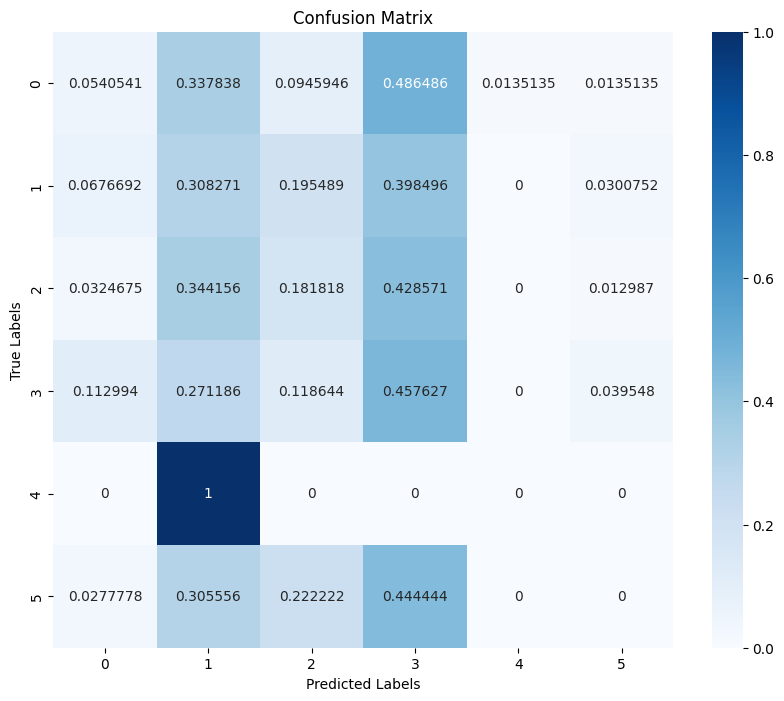

Epoch 3, Validation Loss: 2.4848, Accuracy: 0.2669, F1 Score: 0.2464
Val F1 Score Per Class  [0.07079646 0.2611465  0.2295082  0.37762238 0.         0.        ]


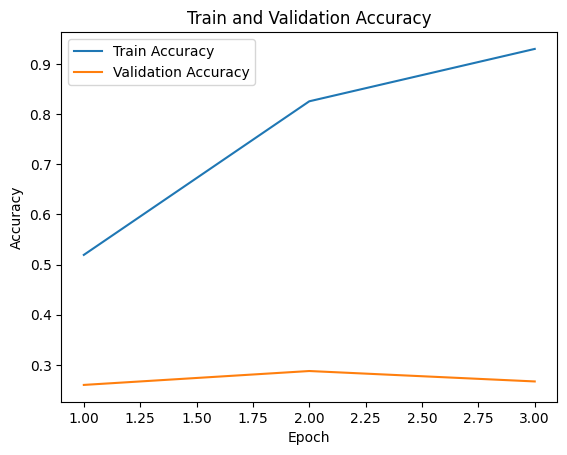

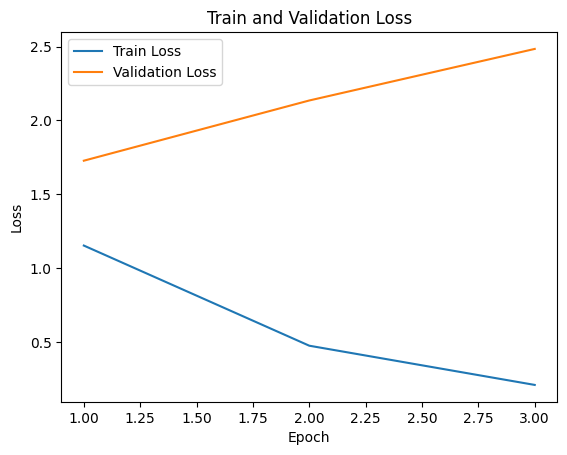

Epoch 4, Train Loss: 0.1259, Accuracy: 0.9592, F1 Score: 0.9592
Train F1 Score Per Class  [0.97491689 0.93389171 0.93361625 0.92674316 0.99911791 0.9864743 ]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.41it/s, loss=2.5]

[tensor([ 2.3401, -0.3913, -1.0120, -0.5518, -4.4632, -1.5366], device='cuda:0'), tensor([-0.6676, -1.8768,  0.0722,  3.9710, -4.1738, -2.7689], device='cuda:0'), tensor([-3.3498, -1.0138, -0.3298,  1.2313, -2.5469, -2.7609], device='cuda:0'), tensor([-1.3879, -1.6491,  3.7858, -0.1326, -4.2931, -1.2792], device='cuda:0'), tensor([-0.5265, -1.6783,  1.4315,  1.7789, -3.1063, -2.2915], device='cuda:0'), tensor([-1.4383, -1.6534,  2.0348,  0.8766, -4.3614, -3.6698], device='cuda:0'), tensor([-2.2474,  1.1079, -0.5886,  1.9048, -1.1045, -3.0760], device='cuda:0'), tensor([ 0.5351, -1.7878,  0.5068,  2.8337, -4.0920, -2.9636], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=2.75]

[tensor([-2.1525,  1.0926,  1.2544, -0.1498, -3.5156, -1.8233], device='cuda:0'), tensor([-2.8806, -0.4970,  1.5317,  2.2156, -4.4238, -2.3900], device='cuda:0'), tensor([-0.6263, -1.9912,  0.6386,  1.4888, -2.4974, -2.4276], device='cuda:0'), tensor([-3.2318, -0.3428, -0.4145,  3.0746, -2.5618, -1.3335], device='cuda:0'), tensor([-0.9924,  0.3620, -1.3512,  4.2366, -2.8050, -2.1503], device='cuda:0'), tensor([-0.7008, -0.3422, -0.7426, -0.5412, -3.6780, -1.1757], device='cuda:0'), tensor([-1.8221, -0.9367,  0.0144,  2.4155, -3.9599, -2.1771], device='cuda:0'), tensor([-0.1895, -0.8564, -2.6887,  3.4146, -4.0698, -0.9996], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.38it/s, loss=1.06]

[tensor([-2.0073, -1.5350, -1.1340,  4.6875, -4.1550, -1.6951], device='cuda:0'), tensor([-1.7908, -1.1606,  3.8141,  0.2078, -3.3045, -2.6625], device='cuda:0'), tensor([-0.4056, -0.8224,  3.5682, -1.0423, -3.5270, -2.9758], device='cuda:0'), tensor([-3.0078,  0.1280,  1.0802,  0.1055, -4.2884, -2.6565], device='cuda:0'), tensor([ 3.6524, -1.5795, -2.6796,  2.0227, -3.5926, -0.6804], device='cuda:0'), tensor([-2.6349,  0.1559,  3.6114, -0.3495, -4.3265, -3.1558], device='cuda:0'), tensor([-3.0963,  1.4947, -0.1373, -0.0600, -2.8391,  1.1460], device='cuda:0'), tensor([-2.2105, -0.9049,  1.9728,  2.4219, -3.4747, -2.7978], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=2.31]

[tensor([ 3.3422, -1.7132, -1.4778,  1.1896, -3.9276, -2.1840], device='cuda:0'), tensor([-2.8254, -0.4541,  0.3593,  4.1644, -3.7846, -2.2736], device='cuda:0'), tensor([-2.3820, -1.6142,  1.9062,  3.4644, -3.4280, -2.1872], device='cuda:0'), tensor([-2.5854, -0.5258,  1.7860, -0.7501, -3.4892,  0.1119], device='cuda:0'), tensor([-2.4323e+00,  6.3332e-02,  4.2618e+00, -9.1347e-01, -3.3158e+00,
        -1.4936e-03], device='cuda:0'), tensor([-1.8762, -1.6459,  0.6807,  1.8771, -3.8665, -3.4778], device='cuda:0'), tensor([-0.2287, -1.0792, -1.3989,  1.9905, -3.9626, -1.1877], device='cuda:0'), tensor([ 0.0173, -1.1595, -1.1090,  3.2937, -4.2845, -1.2659], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.38it/s, loss=4.33]

[tensor([-1.9244, -1.2455,  0.4614,  2.0857, -4.5079, -1.8180], device='cuda:0'), tensor([-2.5120, -1.8584, -1.0193,  0.6069, -2.6543, -0.3078], device='cuda:0'), tensor([-2.0195,  0.2036,  3.0730, -0.5600, -4.6054, -2.0169], device='cuda:0'), tensor([-2.0237, -1.6320,  5.3510, -0.2679, -2.6350, -2.0905], device='cuda:0'), tensor([-0.7412, -1.8077,  3.0577, -0.9567, -3.2000, -0.7998], device='cuda:0'), tensor([-2.2610, -1.5623,  0.6786,  1.7005, -2.5691, -1.4637], device='cuda:0'), tensor([-3.3949, -0.0931, -0.2819,  1.7205, -3.7536, -2.7566], device='cuda:0'), tensor([-1.9752, -1.3864,  4.0968,  0.6405, -4.1087, -2.5406], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.39it/s, loss=3.37]

[tensor([-1.8654, -0.4487, -1.6223,  4.3251, -3.9552, -2.1457], device='cuda:0'), tensor([-1.3586,  0.1124, -0.9960,  2.0829, -4.7753, -1.4008], device='cuda:0'), tensor([-3.4566,  2.6861, -0.4127,  0.2592, -3.0089,  0.2612], device='cuda:0'), tensor([-1.7772, -1.5384, -0.7035, -0.2748, -3.4903, -1.5298], device='cuda:0'), tensor([-1.3737, -0.3055, -0.3315,  2.7360, -4.9381, -2.5613], device='cuda:0'), tensor([-3.1868, -0.3281,  2.5764,  0.3306, -3.1581, -2.2851], device='cuda:0'), tensor([-2.1215,  0.8558, -0.9649,  0.9834, -3.8139, -2.9481], device='cuda:0'), tensor([-2.8260,  0.7466, -0.3828,  1.4774, -3.4080, -2.8473], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=1.24]

[tensor([-1.4581, -1.6526,  2.4433,  1.9935, -4.2263, -2.4577], device='cuda:0'), tensor([-2.2687, -1.5247,  3.1748,  0.4264, -3.5155, -2.1640], device='cuda:0'), tensor([-0.0508, -0.9048, -2.3030,  2.4083, -3.1997, -0.9423], device='cuda:0'), tensor([-1.5448, -0.0552,  1.4526, -0.2859, -3.4455, -3.0765], device='cuda:0'), tensor([-0.8840, -0.8870,  1.7664,  2.0465, -3.9570, -2.8527], device='cuda:0'), tensor([-2.5147, -0.9715, -0.2264,  3.9556, -4.0158, -1.3885], device='cuda:0'), tensor([-0.5750, -0.6942, -0.6654, -0.1249, -4.0128,  0.0643], device='cuda:0'), tensor([-1.1710, -1.5778,  5.6232, -0.8137, -2.4542, -1.5334], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.41it/s, loss=3.03]

[tensor([-2.0745, -0.7014, -1.7966,  5.0205, -2.6017, -1.4324], device='cuda:0'), tensor([-1.2991, -1.3750, -1.3503,  1.4107, -2.1771,  0.4744], device='cuda:0'), tensor([ 3.4255, -1.9915, -2.1011,  0.1888, -4.0176, -0.1322], device='cuda:0'), tensor([-2.3115, -0.4319,  0.0596,  4.8056, -3.3400, -2.5880], device='cuda:0'), tensor([-1.9686,  1.0223, -1.5178,  1.7459, -4.7071, -0.1694], device='cuda:0'), tensor([-1.9484, -1.8862, -0.1990,  3.9080, -3.5964, -1.6501], device='cuda:0'), tensor([-0.1165, -1.9941,  1.5075,  1.0203, -4.1423, -2.2302], device='cuda:0'), tensor([-3.0107, -0.1225,  1.0584,  2.9200, -1.5482, -2.5077], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.40it/s, loss=2.13]

[tensor([-3.6701,  0.7081,  1.7093,  1.0085, -4.2481, -2.2026], device='cuda:0'), tensor([-1.7829, -0.8261,  0.4455,  2.6672, -2.0107, -2.1194], device='cuda:0'), tensor([-1.0812, -1.0443, -1.2850,  5.0063, -3.3160, -2.0121], device='cuda:0'), tensor([-1.9946, -0.8560, -0.2227,  3.5586, -3.6789, -2.1256], device='cuda:0'), tensor([ 0.7977, -2.1678,  2.2466,  0.2272, -4.5588, -1.1299], device='cuda:0'), tensor([-2.2790, -0.6961, -2.3480,  3.2462, -3.2440, -0.5903], device='cuda:0'), tensor([-3.0025, -0.5895,  2.8245,  1.9974, -4.1847, -2.4337], device='cuda:0'), tensor([-1.6596, -1.3561,  0.2406,  2.3127, -4.7936,  0.8126], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.40it/s, loss=4.56]

[tensor([-2.1358, -1.6912, -1.1770,  3.9513, -3.7174, -2.7429], device='cuda:0'), tensor([-1.4348, -1.7239, -0.6185,  4.5739, -3.1365, -2.1800], device='cuda:0'), tensor([-1.7694, -1.4514,  0.0222,  2.6592, -3.8630, -2.6450], device='cuda:0'), tensor([-2.9318, -1.2487,  1.9469,  0.9470, -4.4266, -2.5640], device='cuda:0'), tensor([-2.6092, -0.0127,  3.5096,  0.9737, -4.4881, -2.4933], device='cuda:0'), tensor([-2.2253, -0.7316, -0.2205,  4.6140, -3.8584, -2.5600], device='cuda:0'), tensor([-0.2777,  0.4682, -0.4412,  2.6505, -3.5932, -3.5745], device='cuda:0'), tensor([-2.1297, -1.5927,  2.2686,  2.8111, -3.6464, -2.3564], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.40it/s, loss=3.11]

[tensor([-1.9427,  2.3195, -0.6870,  0.4938, -3.6756, -3.4088], device='cuda:0'), tensor([-2.1816,  0.9835, -0.1999,  2.4911, -4.0663, -1.6854], device='cuda:0'), tensor([-2.8973, -0.4450, -0.5682,  4.0078, -3.3211, -1.4913], device='cuda:0'), tensor([-2.4902, -0.3135,  0.4173,  3.5427, -3.9245, -2.3461], device='cuda:0'), tensor([-1.4412, -0.6748, -0.8955,  4.7389, -3.7312, -2.9108], device='cuda:0'), tensor([-2.0327, -0.8884,  1.2949,  1.7567, -4.4957, -1.4741], device='cuda:0'), tensor([-2.2484, -0.6317,  0.3619,  3.4693, -4.3918, -2.8648], device='cuda:0'), tensor([-1.9058, -1.8117, -0.1703,  3.0008, -3.9513, -2.8436], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=2.01]

[tensor([ 4.0101, -1.4220, -0.9161,  0.6446, -3.9133, -2.9047], device='cuda:0'), tensor([-2.0054, -1.1719,  3.2035,  0.3745, -3.9199, -2.4975], device='cuda:0'), tensor([-0.8436, -2.0054, -0.9562,  2.1301, -4.9425, -1.7203], device='cuda:0'), tensor([ 0.1212, -2.5072,  0.3229,  1.7488, -3.8247, -2.4670], device='cuda:0'), tensor([-2.1229,  0.0538, -0.3712,  2.3629, -4.4608, -3.5175], device='cuda:0'), tensor([-1.7352, -0.8333,  3.0748,  0.1343, -4.3029, -2.1762], device='cuda:0'), tensor([-2.0143, -1.6379,  1.2058,  1.4880, -4.9393, -0.0761], device='cuda:0'), tensor([ 0.0763, -1.5399,  1.8733,  1.3181, -4.4466, -2.2819], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=3.5]

[tensor([-1.7659, -1.6745, -1.3829,  0.3497, -0.9451,  2.7337], device='cuda:0'), tensor([-1.0870, -1.8622,  0.3809,  4.0487, -4.1261, -2.7097], device='cuda:0'), tensor([-0.2849, -1.4097, -2.1552,  4.3621, -3.9469, -1.5887], device='cuda:0'), tensor([-2.4541, -0.4750,  0.5450,  3.3777, -5.1245, -2.5390], device='cuda:0'), tensor([-1.9333, -0.0264,  0.2070,  1.2756, -4.2976, -2.2442], device='cuda:0'), tensor([ 2.5181, -2.6680, -0.9927,  1.9607, -3.6336, -2.5296], device='cuda:0'), tensor([-2.8032,  0.4699, -0.4997, -0.6039, -3.8792, -1.9285], device='cuda:0'), tensor([ 3.0362, -0.5112,  0.7676, -0.4383, -4.6111, -2.2816], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=2.68]

[tensor([-2.1129, -0.8908, -0.1171,  3.7129, -3.8184, -3.4244], device='cuda:0'), tensor([-1.3892, -0.5371, -1.8401,  4.0538, -4.6237, -2.9364], device='cuda:0'), tensor([ 2.4632, -1.4322, -0.9052,  0.4015, -3.8008, -2.5428], device='cuda:0'), tensor([-0.9329, -2.8820,  1.1194,  2.2531, -3.6702, -2.3624], device='cuda:0'), tensor([-1.8879, -0.7356, -1.7195,  2.0996, -4.4202, -3.1382], device='cuda:0'), tensor([-2.2068,  1.1763,  0.2470,  2.1777, -3.9880, -3.0818], device='cuda:0'), tensor([-1.3706, -1.1072,  1.7023,  2.3487, -4.4878, -2.3755], device='cuda:0'), tensor([-0.3313, -0.8870, -1.2501,  2.6550, -4.5055, -2.9301], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.38it/s, loss=2.03]

[tensor([-1.7303, -0.6721, -1.3889,  3.8963, -3.8795, -3.5027], device='cuda:0'), tensor([-2.5877, -1.3553,  3.4589, -0.0670, -3.3159, -1.2938], device='cuda:0'), tensor([-1.4345, -1.9807,  1.2766,  0.8830, -4.2994, -1.5747], device='cuda:0'), tensor([-2.3831,  1.0401,  1.0473, -0.0062, -3.8404, -2.3635], device='cuda:0'), tensor([-0.0772, -0.9173,  3.4211, -0.1633, -4.4365, -1.9343], device='cuda:0'), tensor([ 1.5551, -2.0455,  1.2359,  1.0102, -3.6979, -0.9437], device='cuda:0'), tensor([-1.7450, -0.2476, -1.2055,  2.5618, -1.5417, -1.9667], device='cuda:0'), tensor([-1.2930, -0.9159, -0.3377,  4.2046, -3.6568, -2.6515], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=1.93]

[tensor([-1.0265,  2.8215, -1.0917,  2.0846, -3.5932, -2.8869], device='cuda:0'), tensor([-2.8610, -0.5784, -0.0941,  3.8836, -4.1025, -1.7600], device='cuda:0'), tensor([-2.2814, -0.5037, -0.9245, -0.5735, -4.0151,  0.7647], device='cuda:0'), tensor([-0.5580, -2.3710,  1.3404,  1.9890, -3.8673, -1.9738], device='cuda:0'), tensor([ 0.4900, -1.3630,  2.8386,  0.3258, -3.5582, -2.2283], device='cuda:0'), tensor([-0.6784, -1.8971, -0.4757,  2.4125, -4.0819, -2.3882], device='cuda:0'), tensor([-2.9219,  0.7446, -0.2142, -0.0671, -4.6071, -1.9665], device='cuda:0'), tensor([ 5.6982, -1.3167, -2.2368, -0.4756, -1.8027, -1.6997], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=3.09]

[tensor([-2.0953,  1.2784,  0.9276,  0.0373, -4.5499, -3.2476], device='cuda:0'), tensor([-2.1562,  1.5897,  0.1022,  3.1201, -3.9476, -3.6901], device='cuda:0'), tensor([-2.5143, -0.9622,  1.1228,  0.5662, -3.7942,  1.2930], device='cuda:0'), tensor([-1.6839, -0.7732,  2.1731,  2.0498, -4.5838, -2.4593], device='cuda:0'), tensor([ 3.3201, -2.1646, -0.3842,  0.9457, -3.2964, -2.3299], device='cuda:0'), tensor([-0.7095, -1.9070,  0.9134,  3.7554, -3.9515, -3.2803], device='cuda:0'), tensor([-2.6713, -1.8773,  2.9423,  1.8164, -4.2693, -3.0643], device='cuda:0'), tensor([-0.9859, -2.2595,  3.2178,  2.2661, -3.7026, -1.8638], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=2.69]

[tensor([-0.7521, -1.1162, -1.8198,  4.6711, -3.3399, -1.8395], device='cuda:0'), tensor([-2.0755, -1.6484,  0.3442,  2.7243, -0.8074, -2.0330], device='cuda:0'), tensor([-0.8286, -0.0986,  0.5036,  1.8670, -3.5349, -2.3263], device='cuda:0'), tensor([-2.6611, -1.0252,  0.4239,  4.1329, -3.4655, -2.1604], device='cuda:0'), tensor([-1.2490, -1.0175, -1.1088,  1.4587, -3.6796, -1.2332], device='cuda:0'), tensor([-2.0780,  1.3359,  0.5035,  0.7350, -5.0215, -0.7697], device='cuda:0'), tensor([-0.8875, -1.7266,  2.2991,  0.3891, -4.1705, -2.3857], device='cuda:0'), tensor([-2.7409, -0.8212,  3.4826,  0.8575, -4.2449, -2.6745], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.36it/s, loss=2.23]

[tensor([-2.8298, -0.3561,  2.0481, -0.1409, -3.9955, -2.4035], device='cuda:0'), tensor([-2.0294, -1.9334,  1.6252,  1.5407, -1.0230, -1.3670], device='cuda:0'), tensor([-1.0650, -2.2839,  1.7072,  0.0099, -2.5973, -0.7287], device='cuda:0'), tensor([-1.1398, -0.1681, -0.4845,  2.3494, -0.1643, -2.9678], device='cuda:0'), tensor([-2.3376,  0.8109,  2.6024, -0.7220, -3.1283, -2.2701], device='cuda:0'), tensor([-0.3137, -0.3643, -1.1899,  3.3341, -3.6736, -2.7988], device='cuda:0'), tensor([-1.1415, -1.8336, -0.3157,  4.6514, -3.8605, -1.1565], device='cuda:0'), tensor([-2.0207, -0.2460, -1.5069,  4.4020, -2.9124, -2.8600], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=2.61]

[tensor([-2.0727,  1.4626,  0.0884, -0.9347, -3.7227, -1.4307], device='cuda:0'), tensor([-2.0581, -1.2404, -0.1887,  4.7937, -3.5104, -1.9046], device='cuda:0'), tensor([-2.4531, -0.2302,  1.4059,  1.0646, -5.1062, -2.4948], device='cuda:0'), tensor([-1.8946, -1.3008,  4.5338,  0.7118, -3.5110, -2.0714], device='cuda:0'), tensor([-2.7313, -1.0288,  0.1551,  2.3095, -4.0726, -3.6186], device='cuda:0'), tensor([-2.0364, -1.1079,  4.8546, -0.9555, -2.3096, -1.0083], device='cuda:0'), tensor([-1.4450, -1.5868,  1.3573,  3.0191, -3.6289, -1.6398], device='cuda:0'), tensor([-1.7815,  0.5485, -1.5201,  0.7674, -3.2172, -3.0915], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=3.95]

[tensor([-1.3371, -1.6717,  5.0819, -0.6718, -3.1953, -1.6515], device='cuda:0'), tensor([-2.7830,  2.0024,  1.5316,  0.4497, -3.9609, -2.9162], device='cuda:0'), tensor([-2.3355,  0.5778, -1.3911,  4.2144, -3.5867, -2.5514], device='cuda:0'), tensor([-3.3326,  1.3826, -0.9373,  2.1395, -3.3693, -0.2999], device='cuda:0'), tensor([-0.0942,  2.3115, -2.6011, -0.3924, -3.1495, -2.4173], device='cuda:0'), tensor([-2.1245, -1.4624,  1.4124,  1.7474, -4.1303, -2.1421], device='cuda:0'), tensor([ 0.0392,  2.8870, -0.9237,  0.3173, -3.7512, -3.0489], device='cuda:0'), tensor([-1.4484,  0.1364,  1.8764,  0.0993, -3.6705, -3.3949], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=3.17]

[tensor([-0.8566,  0.2199,  3.4386, -0.4728, -4.3913, -2.0202], device='cuda:0'), tensor([-1.3787, -2.7242,  1.3442,  1.0401, -3.3072, -2.1751], device='cuda:0'), tensor([-3.1112, -0.8402,  2.4716,  0.4505, -3.7773, -3.4241], device='cuda:0'), tensor([-2.3208, -1.6141, -0.0930,  3.7187, -4.2543, -1.9645], device='cuda:0'), tensor([-2.4176, -0.5766, -0.7989,  3.2875, -3.5122, -2.7779], device='cuda:0'), tensor([-1.1865, -0.4119,  2.7860,  0.0108, -4.4526, -2.2807], device='cuda:0'), tensor([-0.0958, -2.0511,  0.4807,  4.2189, -3.8378, -2.1437], device='cuda:0'), tensor([-2.0389, -1.3602,  2.3510,  1.6877, -3.7103, -2.5538], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.38it/s, loss=1.79]

[tensor([-0.9845, -1.0578, -0.9956,  0.8953, -4.1090, -3.3031], device='cuda:0'), tensor([-3.8480e+00, -1.6678e-03,  2.3787e+00,  2.7387e-01, -2.7976e+00,
        -1.8864e+00], device='cuda:0'), tensor([-1.5887,  0.2564, -0.8056,  3.9041, -4.7058, -3.3044], device='cuda:0'), tensor([-1.9999,  3.5933, -0.6561, -0.9494, -3.0130, -2.0225], device='cuda:0'), tensor([-1.5257, -1.6052,  1.3872,  1.7025, -4.3178, -2.3258], device='cuda:0'), tensor([-2.6903, -0.1914,  1.6174,  0.4021, -4.3510, -2.2048], device='cuda:0'), tensor([-0.5407, -1.3659,  0.0864,  1.9264, -3.6204, -0.8751], device='cuda:0'), tensor([-2.3443, -0.8641, -0.2216,  3.2104, -4.0887, -3.1164], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=2.58]

[tensor([-2.0934, -2.0304,  2.5916,  1.5704, -3.1242, -2.3175], device='cuda:0'), tensor([-0.4806, -0.3963,  1.4116,  0.6865, -5.0103, -3.1093], device='cuda:0'), tensor([-3.1940,  1.7384,  0.0421, -0.5135, -4.3030, -1.3235], device='cuda:0'), tensor([-2.3656, -0.0155, -1.3100,  4.7709, -3.4981, -2.6514], device='cuda:0'), tensor([ 1.5365, -1.0189, -2.8944,  2.3607, -3.9243, -1.5047], device='cuda:0'), tensor([-2.0515,  0.1048,  0.0125,  2.2096, -4.7804, -3.5912], device='cuda:0'), tensor([ 5.2168, -1.4631, -2.9629, -0.0254, -1.7417, -0.8789], device='cuda:0'), tensor([-0.2388, -0.0853,  0.7581,  0.8495, -4.8207, -3.2748], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.38it/s, loss=2.32]

[tensor([-2.4749, -1.3067,  2.6850,  0.7332, -4.8155, -2.2253], device='cuda:0'), tensor([-3.2959,  0.5189,  3.8894,  0.7896, -2.9758, -3.0210], device='cuda:0'), tensor([-1.4507, -1.7880, -0.4657,  4.1193, -3.3635, -1.0023], device='cuda:0'), tensor([-1.7523,  0.0100,  1.0149,  1.7309, -3.8603, -2.7944], device='cuda:0'), tensor([ 0.1177, -0.4114, -1.8578,  2.2984, -5.4615, -2.9710], device='cuda:0'), tensor([-1.1077, -1.9408, -0.6470,  2.2597, -3.1697, -1.8483], device='cuda:0'), tensor([-1.2517,  1.6342, -1.5154,  2.0002, -2.7794, -3.2910], device='cuda:0'), tensor([-1.8929, -1.2966, -0.9416,  2.1307, -3.3752, -2.2970], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.96]

[tensor([-1.2883, -1.3966, -0.2403,  4.4196, -4.4721, -2.1494], device='cuda:0'), tensor([ 0.2798, -1.5801, -0.8667,  1.9794, -5.0036, -0.4012], device='cuda:0'), tensor([ 0.8308, -2.4739,  1.3538,  0.5045, -4.1586, -0.1872], device='cuda:0'), tensor([ 5.9804, -1.7371, -1.2331, -0.1941, -2.9243, -1.4193], device='cuda:0'), tensor([-1.8008,  1.3228, -0.4601,  3.6826, -3.9442, -2.9455], device='cuda:0'), tensor([-0.2661, -0.2927,  0.8921, -0.1250, -4.0327, -0.0900], device='cuda:0'), tensor([-2.4153, -1.0179,  3.3622,  1.2960, -4.0173, -3.1868], device='cuda:0'), tensor([-1.9821,  0.1648,  1.2158, -0.4934, -2.9678, -2.2986], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=2.9]

[tensor([-2.0045, -0.2004, -0.7755,  4.2201, -3.0500, -2.0434], device='cuda:0'), tensor([-2.2854, -1.1688,  1.2340,  2.5635, -2.4962, -2.4868], device='cuda:0'), tensor([ 0.0411, -1.5802, -1.5070,  2.5414, -3.3659, -1.1773], device='cuda:0'), tensor([-2.2335, -1.4923, -0.5239,  3.3807, -3.4025, -0.6912], device='cuda:0'), tensor([ 1.9403,  0.7173, -0.0259, -0.5230, -4.2679, -1.9686], device='cuda:0'), tensor([-1.8025, -0.5509,  4.0877,  0.6165, -4.2415, -2.5740], device='cuda:0'), tensor([-2.1159, -1.8748,  3.0634,  1.0219, -3.7915, -1.6718], device='cuda:0'), tensor([-0.2456,  1.1295, -1.1216,  2.3293, -4.4953, -3.8205], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=2.45]

[tensor([ 3.8127, -2.3824, -1.5812,  2.1505, -3.5640, -1.7647], device='cuda:0'), tensor([-1.7559, -0.6965,  1.5782,  0.7686, -4.1179, -1.9910], device='cuda:0'), tensor([-1.0816,  4.6833, -1.0598, -0.5765, -2.3073, -2.3071], device='cuda:0'), tensor([-1.9521, -1.8294,  1.4646,  3.8902, -3.1326, -2.4095], device='cuda:0'), tensor([-1.1977, -1.5857,  1.3545,  4.1881, -3.9408, -2.7510], device='cuda:0'), tensor([-2.6780,  2.7845,  1.9871,  1.0509, -3.6347, -3.1664], device='cuda:0'), tensor([-1.9922, -1.3153,  2.3685,  1.2867, -3.6286, -2.0146], device='cuda:0'), tensor([ 1.2364, -1.2141, -0.9642, -0.9290, -3.8195, -3.2218], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.39it/s, loss=3.07]

[tensor([-2.9159, -0.7468,  2.6949,  1.7039, -4.0282, -2.7350], device='cuda:0'), tensor([-2.5313, -0.9926, -0.4836,  1.9805, -4.2855, -2.1929], device='cuda:0'), tensor([-1.7038, -1.6994,  5.3471, -0.6966, -2.6817, -1.0879], device='cuda:0'), tensor([-2.4746, -1.3795,  0.1513,  3.8146, -3.2770, -2.7478], device='cuda:0'), tensor([-1.6622, -0.7841,  3.3233, -0.0814, -4.4053, -2.7270], device='cuda:0'), tensor([-1.7845, -1.7586,  0.6473,  0.2135, -4.7996, -1.2888], device='cuda:0'), tensor([-1.8106, -1.2718, -0.1426,  4.0196, -4.0992, -2.1499], device='cuda:0'), tensor([-2.8075, -1.2561,  2.1032,  1.5383, -2.8119, -2.7935], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.39it/s, loss=2.47]

[tensor([-3.0739,  0.0553, -1.0625,  2.8985, -3.4542, -1.4238], device='cuda:0'), tensor([-2.0107, -0.1557,  1.4223,  1.9973, -3.7831, -2.5324], device='cuda:0'), tensor([ 2.1545, -1.6629, -1.1921,  1.0051, -4.1949, -2.9218], device='cuda:0'), tensor([-1.6693, -1.0918, -0.4022,  1.9473, -3.9708, -1.8732], device='cuda:0'), tensor([-0.4642, -0.9787,  0.8529, -0.3350, -4.8039, -2.4386], device='cuda:0'), tensor([-1.6443, -1.7531,  2.4685,  1.7447, -3.5627, -2.1477], device='cuda:0'), tensor([-2.4355, -1.7636,  1.2924,  0.9433, -4.9228, -2.3852], device='cuda:0'), tensor([-1.0315, -1.4217, -0.5871, -0.7370, -3.3221,  5.3327], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.39it/s, loss=2.1]

[tensor([-0.8083, -1.0636, -2.2735,  4.9356, -3.4158, -0.8537], device='cuda:0'), tensor([-1.3969, -2.0399,  0.2317,  2.2676, -3.5376, -2.0554], device='cuda:0'), tensor([-1.9697, -0.9213,  3.2102, -0.0267, -4.5472, -0.2629], device='cuda:0'), tensor([-2.0975, -0.7959,  0.0182,  0.0214, -4.2216,  1.5899], device='cuda:0'), tensor([-2.5310, -0.1567,  1.0270,  1.1752, -4.4750, -2.2140], device='cuda:0'), tensor([ 4.1775,  1.0342, -2.1460, -1.0716, -2.4640, -2.1974], device='cuda:0'), tensor([-1.2372, -2.0895, -0.1976,  4.8460, -2.8119, -1.7004], device='cuda:0'), tensor([-1.6062, -0.9918,  2.8654,  0.9897, -4.3893, -2.6205], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.39it/s, loss=3.98]

[tensor([-1.2271,  0.4517, -2.6434,  1.0305, -3.6683,  0.2150], device='cuda:0'), tensor([-2.3390, -0.8262, -1.1373,  4.4919, -3.7306, -0.9931], device='cuda:0'), tensor([-1.9242,  5.0361, -1.3698, -0.2731, -1.9766, -2.2283], device='cuda:0'), tensor([-1.9824, -1.2215,  0.1899,  3.4206, -1.7622, -1.3329], device='cuda:0'), tensor([-1.7668, -1.1853, -1.2032,  0.6025, -3.8967,  1.1757], device='cuda:0'), tensor([-1.7881, -1.2768,  3.3180, -0.2973, -3.1807,  0.8550], device='cuda:0'), tensor([-1.2129, -1.4037,  1.6779,  1.3798, -4.2141, -1.4363], device='cuda:0'), tensor([ 1.1125, -1.1012,  1.0328,  0.3626, -5.0486, -3.0273], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.39it/s, loss=3.74]

[tensor([-2.7876, -1.5447, -0.3689,  3.9128, -3.3877, -0.7302], device='cuda:0'), tensor([-2.4259,  2.4203, -1.0943,  1.8013, -1.4562, -1.7795], device='cuda:0'), tensor([-3.0348,  1.2834,  0.9411,  0.6049, -4.7834, -0.5765], device='cuda:0'), tensor([-3.0163,  2.4211,  0.0770, -0.8016, -3.4587, -2.1384], device='cuda:0'), tensor([-1.9720, -0.8180,  5.4833, -0.7943, -3.2606, -1.9928], device='cuda:0'), tensor([-2.8223, -0.8740, -0.1899,  2.1625, -3.4358, -2.0656], device='cuda:0'), tensor([-1.7477, -0.9994, -0.8919,  5.0048, -2.9176, -2.1665], device='cuda:0'), tensor([-2.3802,  0.2508, -0.7432,  3.8665, -3.7922, -2.4928], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.38it/s, loss=2.42]

[tensor([ 4.6130, -0.0210, -2.5898, -0.1222, -2.3116, -2.2340], device='cuda:0'), tensor([-2.3860, -0.9954,  0.3619,  3.0138, -4.1699, -2.9969], device='cuda:0'), tensor([-1.3166,  1.5809, -0.0219, -0.6216, -1.1944, -0.9656], device='cuda:0'), tensor([-1.5557, -1.2789,  1.2054,  0.5762, -4.0703, -1.7599], device='cuda:0'), tensor([-0.1899, -1.2630, -0.1494,  2.2199, -4.6335, -2.9461], device='cuda:0'), tensor([-2.8973,  0.0298,  0.3817,  1.7124, -4.7104, -1.3404], device='cuda:0'), tensor([-1.4695, -1.7020,  0.1753,  3.6664, -4.0555, -2.5851], device='cuda:0'), tensor([-1.1071, -1.8099,  2.9431, -0.7291, -4.1103, -2.0032], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=2.78]

[tensor([-2.8172, -0.2311,  1.3454,  2.0136, -4.6685, -2.8122], device='cuda:0'), tensor([ 0.0218, -0.8927,  0.6884,  2.2022, -4.4695, -2.4275], device='cuda:0'), tensor([-0.8930, -2.2740,  0.9526,  2.4348, -4.0097, -1.8445], device='cuda:0'), tensor([-2.5025,  1.0660,  3.4368,  0.7968, -4.5284, -2.5474], device='cuda:0'), tensor([-2.8090,  1.3774,  0.4089,  2.2177, -4.5034, -2.8200], device='cuda:0'), tensor([-1.3063, -2.8872,  0.2616,  2.7132, -3.3131, -1.9018], device='cuda:0'), tensor([-2.3919, -1.2912,  1.2669,  0.5182, -4.5223, -2.4465], device='cuda:0'), tensor([-0.9695,  3.4968, -0.0042, -0.4027, -3.0291, -2.7480], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.39it/s, loss=2.1]

[tensor([-2.5623, -0.3806,  1.8659,  0.2428, -4.3096, -3.0308], device='cuda:0'), tensor([-2.1521, -1.3597,  4.7329, -0.4406, -3.3756, -2.2578], device='cuda:0'), tensor([-1.4993e+00, -1.5017e+00, -4.2786e-01, -2.1770e-03, -3.1881e+00,
        -1.3991e+00], device='cuda:0'), tensor([-1.9682, -0.4722,  0.4688,  0.6759, -4.6610, -2.6611], device='cuda:0'), tensor([ 0.1195, -1.7030,  0.6567,  2.0305, -4.0524, -2.3778], device='cuda:0'), tensor([-2.0907e+00, -1.4965e+00,  7.4749e-04,  4.4985e+00, -3.8115e+00,
        -2.1225e+00], device='cuda:0'), tensor([-1.1452, -1.7811,  0.2810,  4.5399, -3.4685, -2.1239], device='cuda:0'), tensor([-1.4466, -1.0742, -0.0243,  3.5903, -3.9586, -2.3309], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.40it/s, loss=2.74]

[tensor([-1.7525, -1.6079, -1.8410,  3.5752, -3.8155, -1.0685], device='cuda:0'), tensor([-0.9922, -1.6725,  1.3991,  2.8468, -4.4257, -1.4743], device='cuda:0'), tensor([-1.0197, -0.8281, -1.8943,  4.6919, -3.3828, -1.7495], device='cuda:0'), tensor([-2.5586,  0.7938, -0.2258,  0.9584, -3.5312, -0.5490], device='cuda:0'), tensor([-1.7193, -1.0584,  3.1653, -0.6854, -3.7652, -0.7001], device='cuda:0'), tensor([ 2.8183, -0.9865, -0.4161, -0.7300, -3.0688, -1.9014], device='cuda:0'), tensor([-1.7680,  0.5970, -0.3373,  2.7502, -2.4547, -2.8610], device='cuda:0'), tensor([-2.0138,  1.1906,  0.2877,  2.7359, -1.4529, -3.6832], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.39it/s, loss=1.54]

[tensor([-1.1849, -1.1229,  1.9921, -0.8926, -3.1866,  0.6623], device='cuda:0'), tensor([-1.6399,  0.9502, -1.4326,  0.8443, -4.5576,  1.6993], device='cuda:0'), tensor([-1.6610, -1.0311,  2.8996,  0.5843, -4.7305, -2.9577], device='cuda:0'), tensor([-2.0829,  1.1901, -0.6298,  1.6015, -3.6417, -2.0914], device='cuda:0'), tensor([-0.8836, -1.8046,  1.0536,  1.7561, -4.1209, -2.3755], device='cuda:0'), tensor([-2.5811,  4.4101, -0.4935,  0.1876, -2.5070, -1.5984], device='cuda:0'), tensor([-3.2943, -0.1142, -0.9680,  1.0722, -2.8273,  0.4810], device='cuda:0'), tensor([-2.3519, -0.7687,  1.7239,  3.6902, -4.1766, -2.3760], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.39it/s, loss=2.37]

[tensor([-1.8784, -1.2700,  0.0955,  2.7651, -3.5386, -2.3848], device='cuda:0'), tensor([-1.2843, -0.5261,  1.5097,  1.1143, -4.0396, -2.6536], device='cuda:0'), tensor([ 4.6095, -2.0540, -0.9817,  0.0248, -3.5214, -0.7819], device='cuda:0'), tensor([-1.3145, -1.9547,  0.3503,  2.9505, -4.5087, -1.7336], device='cuda:0'), tensor([-3.5949, -0.1254, -0.2423,  1.7831, -3.7964, -2.3225], device='cuda:0'), tensor([-2.5266, -1.1558,  1.9874,  0.1333, -4.3650,  0.1230], device='cuda:0'), tensor([ 0.2943, -0.1546,  1.9250, -0.6437, -4.1406, -1.7077], device='cuda:0'), tensor([-2.2101,  1.0551, -0.1326, -0.8088, -3.9977,  0.8294], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=3.41]

[tensor([-0.5529, -0.9183,  0.6120,  0.3998, -4.0734, -2.3441], device='cuda:0'), tensor([-0.7907, -2.1164,  1.1716,  0.8521, -2.5211, -2.7589], device='cuda:0'), tensor([-1.8149, -1.1350,  2.9039,  0.7392, -4.2486, -0.9934], device='cuda:0'), tensor([-1.2968, -0.7125, -1.9111,  4.1630, -3.0210, -2.2924], device='cuda:0'), tensor([-2.4731, -1.5406, -0.6880,  4.0981, -3.0293, -1.1953], device='cuda:0'), tensor([ 5.4414, -1.9779, -1.8353,  0.7598, -2.5051, -1.7884], device='cuda:0'), tensor([-2.1931,  0.7534, -0.4432,  0.2275, -3.9529, -2.6122], device='cuda:0'), tensor([-2.2160,  2.3373, -1.3928,  0.2932, -3.9189, -0.6582], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=2.63]

[tensor([-1.7270, -2.1262,  3.0644,  1.2290, -4.0341, -1.9574], device='cuda:0'), tensor([-1.7652,  0.7332,  1.2071,  1.4376, -3.2429, -3.4561], device='cuda:0'), tensor([-1.3199, -0.0332, -1.1006,  4.2470, -3.5389, -2.7780], device='cuda:0'), tensor([-1.8908, -0.9184,  0.0776,  4.9482, -3.5355, -2.1957], device='cuda:0'), tensor([-0.7292, -0.8386, -1.0426,  3.2439, -3.8604, -2.8372], device='cuda:0'), tensor([-1.3470, -0.9723,  0.9440,  3.0762, -4.6402, -2.7669], device='cuda:0'), tensor([-2.2563, -0.6071,  0.8521,  1.1719, -3.4623, -2.9621], device='cuda:0'), tensor([-2.1076, -0.2990, -1.4047,  3.8411, -3.4727, -1.9246], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=1.55]

[tensor([-1.8546, -2.1773,  0.8348,  0.4484, -3.2477, -2.3697], device='cuda:0'), tensor([ 0.9738, -0.8393, -1.0734,  1.6238, -2.3282, -1.1555], device='cuda:0'), tensor([-0.8464, -1.5626, -1.5522,  0.4880, -4.0037, -1.9965], device='cuda:0'), tensor([ 0.0531,  0.6424, -1.6922,  0.1782, -1.3955, -2.5140], device='cuda:0'), tensor([-2.9932,  0.9418, -0.7037,  3.5063, -3.4863, -2.5880], device='cuda:0'), tensor([-1.4915, -1.5512, -0.1385,  4.8458, -3.1125, -2.4134], device='cuda:0'), tensor([-2.7712, -0.3257,  0.5186,  2.5186, -3.0676, -0.6096], device='cuda:0'), tensor([ 1.5298, -2.1710,  2.4191,  0.3652, -3.7294, -3.0782], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.40it/s, loss=1.23]

[tensor([-2.4604,  0.6771,  0.1537,  3.4300, -4.0108, -2.9516], device='cuda:0'), tensor([-0.7110, -0.5249,  1.6042,  0.3413, -4.3978, -3.5856], device='cuda:0'), tensor([-1.5495, -0.3612, -1.6081,  2.6263, -2.7789, -1.4818], device='cuda:0'), tensor([-2.3225,  2.9801, -1.7060,  1.1215, -3.5866, -1.7420], device='cuda:0'), tensor([-3.7033,  1.9003, -1.1060,  1.0553, -2.8138, -0.3288], device='cuda:0'), tensor([-2.2244, -1.5359,  3.6257,  0.9611, -3.0396, -2.3191], device='cuda:0'), tensor([-2.9417, -0.5348,  1.2703,  2.0175, -3.5272, -2.4937], device='cuda:0'), tensor([-3.0731, -0.0935,  3.5362,  0.4652, -3.9523, -1.7412], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.39it/s, loss=3.44]

[tensor([-2.1371, -0.5487,  0.5456,  3.7320, -1.0532, -2.9599], device='cuda:0'), tensor([-1.4291, -1.7219,  1.5285,  0.2970, -3.8233, -2.4874], device='cuda:0'), tensor([-0.5461,  1.1276, -0.8901, -0.8447, -3.8091, -2.4324], device='cuda:0'), tensor([-1.1337, -1.5461, -1.6613,  0.1311, -2.4497,  5.7796], device='cuda:0'), tensor([-2.7474, -0.6178, -0.3026,  4.4751, -3.5762, -2.9504], device='cuda:0'), tensor([ 3.1912, -1.9955, -1.2139,  1.5682, -4.4485, -1.6093], device='cuda:0'), tensor([-2.1614, -1.0600,  0.2581,  4.1775, -4.0080, -2.1562], device='cuda:0'), tensor([-2.7493,  2.3769,  0.0783,  1.8439, -4.0233, -2.3842], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.40it/s, loss=3.88]

[tensor([-1.8828, -0.1205,  1.5442, -0.9643, -3.3571, -0.9355], device='cuda:0'), tensor([-1.9833, -0.1984,  4.5317, -1.1729, -3.4847, -2.3904], device='cuda:0'), tensor([-2.1148,  1.8665,  0.3442,  1.2700, -4.5489, -3.9699], device='cuda:0'), tensor([-3.3757,  2.2023, -0.6978,  1.9312, -3.7621, -2.5802], device='cuda:0'), tensor([-0.6155, -1.7477, -0.6588,  4.3417, -4.2792, -1.0652], device='cuda:0'), tensor([-1.7772, -2.1490,  2.8894,  0.2155, -4.2449, -1.6704], device='cuda:0'), tensor([ 1.5944, -0.6414, -1.8228, -2.2902,  0.2060, -1.8715], device='cuda:0'), tensor([-3.3970, -0.0688,  2.3092,  1.1116, -4.5320, -2.1563], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.39it/s, loss=3.54]

[tensor([ 1.1421, -1.4768,  0.2992,  1.8022, -4.2377, -2.8104], device='cuda:0'), tensor([-2.7490, -0.6094,  0.8404,  1.6903, -4.5885, -3.1510], device='cuda:0'), tensor([ 0.4852, -1.4602, -0.5143,  2.0859, -5.0036, -1.5838], device='cuda:0'), tensor([-0.3048, -1.1491,  1.8764,  1.8030, -4.8779, -2.5690], device='cuda:0'), tensor([-2.9270,  0.5829,  0.0833,  3.3531, -3.7877, -2.8388], device='cuda:0'), tensor([-2.1843, -1.6975,  1.8044,  0.7278, -3.8745, -3.0096], device='cuda:0'), tensor([-0.0732, -2.0376, -0.9281,  3.7478, -4.2547, -0.6871], device='cuda:0'), tensor([-1.6748,  0.1655,  1.3688, -0.3496, -4.6312, -1.5495], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.39it/s, loss=2.13]

[tensor([-2.9470, -1.1560,  0.6059,  0.0308, -3.0409,  2.0293], device='cuda:0'), tensor([ 4.1881, -2.4226, -0.7425,  0.1197, -2.6689, -0.7962], device='cuda:0'), tensor([-1.6558, -1.4870,  4.9050,  0.3022, -3.8484, -2.0032], device='cuda:0'), tensor([-2.4442, -1.3099,  3.1851,  1.3531, -3.6869, -2.5996], device='cuda:0'), tensor([-2.1564,  0.8616,  1.3698, -1.2850, -3.8189, -2.6001], device='cuda:0'), tensor([-1.5810, -1.7813, -0.7286,  2.0548, -4.1604,  0.0094], device='cuda:0'), tensor([-2.4307, -1.1968, -1.3803, -0.3554, -4.2097, -1.8036], device='cuda:0'), tensor([-2.0301, -1.5164, -0.5335,  4.5011, -3.1259, -1.1141], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.39it/s, loss=2.86]

[tensor([ 1.3355, -2.3555,  0.5911,  0.9545, -3.8798, -2.0577], device='cuda:0'), tensor([-1.0288, -2.0058, -0.0322,  0.9207, -4.1435,  2.0430], device='cuda:0'), tensor([-0.6465, -1.6984, -0.1773,  1.1905, -3.6208, -0.2799], device='cuda:0'), tensor([-3.0935,  0.9597,  1.5346,  1.7330, -3.9166, -3.0024], device='cuda:0'), tensor([-1.0178, -1.8807,  1.0384,  3.3628, -4.0226, -2.4585], device='cuda:0'), tensor([-2.4770, -0.4907,  2.0439,  0.2921, -4.2063, -2.6674], device='cuda:0'), tensor([-1.6920,  0.0812, -0.0051,  3.8144, -4.0115, -3.3111], device='cuda:0'), tensor([ 0.6609, -2.2911, -0.4211,  3.4784, -4.0320, -1.8299], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.39it/s, loss=1.59]

[tensor([-3.4900,  0.7083,  1.0856,  1.7414, -4.0409, -3.3554], device='cuda:0'), tensor([-2.1161, -1.1141,  1.8529,  2.9376, -3.9086, -3.0540], device='cuda:0'), tensor([-1.7456, -1.9409,  2.7116,  0.7594, -3.7755, -0.1662], device='cuda:0'), tensor([-1.2983, -1.6967, -0.2369,  3.4987, -3.9461, -1.5018], device='cuda:0'), tensor([-3.1341,  0.5316,  2.2666,  0.7915, -3.9100, -2.3748], device='cuda:0'), tensor([-1.4889,  0.1286, -0.6856,  3.4934, -3.4144, -2.8789], device='cuda:0'), tensor([-2.0750, -0.8507,  1.8117,  0.5085, -3.2132, -3.7587], device='cuda:0'), tensor([-0.2105, -1.1441, -2.4873,  2.8876, -3.7057, -1.7701], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.39it/s, loss=3.23]

[tensor([-2.1463, -0.6892,  1.6984, -0.5339, -4.2983, -2.8793], device='cuda:0'), tensor([-0.8678, -1.4227,  2.6498,  0.7469, -3.5124, -2.7374], device='cuda:0'), tensor([-1.0247, -1.3623, -0.7363,  4.8927, -3.7197, -2.6617], device='cuda:0'), tensor([-0.9777, -2.0752, -0.1168,  3.6125, -3.8903, -1.4890], device='cuda:0'), tensor([-2.3672, -0.6990, -0.5327,  4.2578, -4.2328, -2.2546], device='cuda:0'), tensor([-2.2842, -0.3199,  2.0586,  2.9228, -3.0241, -3.4838], device='cuda:0'), tensor([-1.3445, -0.6272, -0.1846,  2.4411, -3.3575, -2.0470], device='cuda:0'), tensor([-1.8155, -1.6491,  1.1478,  3.2118, -3.9442, -2.3438], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.39it/s, loss=1.67]

[tensor([-2.0251, -1.6084,  4.1967, -0.8678, -3.5541, -1.3547], device='cuda:0'), tensor([-1.3946, -0.8785, -0.6876,  4.8771, -3.4526, -2.1390], device='cuda:0'), tensor([-0.9593, -2.2912,  4.5330,  1.0604, -3.2527, -2.0769], device='cuda:0'), tensor([-2.7204,  0.5252, -0.9744,  1.9969, -4.2249, -2.8650], device='cuda:0'), tensor([-1.1870, -2.2240,  0.5579,  2.2209, -3.8382, -1.9452], device='cuda:0'), tensor([-2.4992, -0.9508,  0.2115,  4.0419, -2.8319, -3.2904], device='cuda:0'), tensor([-2.4113,  0.1456,  3.2986, -0.2634, -3.6524, -2.5952], device='cuda:0'), tensor([-0.7928, -1.9226,  1.7039,  1.6277, -4.2867, -2.1667], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.40it/s, loss=2.89]

[tensor([-1.4199,  0.7648, -0.6476,  2.5818, -3.8142, -2.5256], device='cuda:0'), tensor([-1.8689, -0.6419,  0.0976,  1.6493, -3.8566, -3.2806], device='cuda:0'), tensor([-1.7733,  0.1586, -0.3319,  1.6992, -4.7729, -2.3230], device='cuda:0'), tensor([-1.1312, -0.0397, -1.1181,  0.1118, -3.3315, -2.9449], device='cuda:0'), tensor([-2.1233, -0.7826,  0.2358,  4.3937, -3.5761, -2.5078], device='cuda:0'), tensor([-2.3158,  1.4242,  1.2216,  0.4027, -4.5237, -2.4638], device='cuda:0'), tensor([-2.7615,  1.9453,  0.1405,  0.2976, -3.5167, -3.2739], device='cuda:0'), tensor([-1.8184,  1.5720, -0.7137,  2.0936, -3.9120, -3.4436], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.39it/s, loss=1.29]

[tensor([-1.3458, -2.5680,  0.4265, -0.0789, -3.3804,  0.4167], device='cuda:0'), tensor([-1.2930, -1.6835,  0.4031,  3.0929, -3.4779, -2.6728], device='cuda:0'), tensor([-2.5531, -2.0867,  1.0474,  0.4112, -4.0248, -0.4750], device='cuda:0'), tensor([-2.9110,  0.8467,  1.1466,  1.3964, -4.2211, -2.9209], device='cuda:0'), tensor([-1.3316, -1.9279,  0.0416,  4.2484, -4.1939, -2.6874], device='cuda:0'), tensor([-1.6565, -1.0263, -0.2868,  3.1198, -3.0410, -2.3470], device='cuda:0'), tensor([-1.5937, -0.0675, -0.3081,  1.2915, -2.5352,  0.6633], device='cuda:0'), tensor([-1.9155, -0.7209, -0.2723,  4.6117, -3.0862, -2.7354], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.40it/s, loss=1.17]

[tensor([-3.2249,  0.3063,  1.3186,  0.9257, -4.2103, -2.3556], device='cuda:0'), tensor([-1.7858, -0.5034,  0.7143,  0.8484, -4.0581, -2.8386], device='cuda:0'), tensor([ 1.8798, -0.4336, -0.4060,  0.2224, -3.1459, -1.8709], device='cuda:0'), tensor([-0.8285, -1.2803,  4.3528,  0.3104, -4.2635, -2.0813], device='cuda:0'), tensor([ 2.1267, -2.0134, -1.4616,  1.1183, -4.6049, -1.7867], device='cuda:0'), tensor([ 0.0694, -1.0734,  2.2771, -0.2318, -3.6659, -0.8888], device='cuda:0'), tensor([-1.5641, -0.9874, -1.7842,  3.1485, -2.9336, -1.8316], device='cuda:0'), tensor([-2.3886, -1.3513,  0.0118,  3.2658, -3.4044, -1.8064], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.40it/s, loss=2.43]

[tensor([ 0.3828, -1.7842, -0.9790,  3.3365, -3.9112, -2.5958], device='cuda:0'), tensor([-1.4275, -0.4568,  1.9489,  0.5004, -4.7513, -2.4965], device='cuda:0'), tensor([ 2.5132, -1.7063,  0.9787,  0.4390, -3.9377, -1.6584], device='cuda:0'), tensor([-2.0005, -0.8329,  1.3262,  0.2485, -3.9860, -3.3524], device='cuda:0'), tensor([ 2.4007,  0.2143, -1.7407,  0.0063, -3.5668, -2.6688], device='cuda:0'), tensor([-1.5031, -1.7224,  0.4574,  1.6801, -4.0249, -1.7856], device='cuda:0'), tensor([-2.9451, -1.1997,  4.1480, -0.1665, -2.8144, -2.7626], device='cuda:0'), tensor([-2.6044, -0.9259,  3.7414,  0.0639, -4.0341, -2.8220], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.39it/s, loss=4.35]

[tensor([-1.1754, -1.7082,  0.0049,  1.7823, -4.0673, -2.6339], device='cuda:0'), tensor([-1.2557, -1.4740,  0.7950,  1.4643, -3.7830, -2.5296], device='cuda:0'), tensor([-1.0646, -2.5244, -0.7013,  2.4746, -3.8388, -0.8149], device='cuda:0'), tensor([-2.5408, -0.8374, -1.3757,  1.2051, -3.5907, -2.5764], device='cuda:0'), tensor([-0.4965, -1.8486,  2.3352, -0.4037, -3.5935, -1.6995], device='cuda:0'), tensor([-2.6717, -0.3162,  3.4216,  0.1614, -2.7984, -1.9504], device='cuda:0'), tensor([-1.5023, -1.2151,  4.1999,  0.0870, -3.9847, -2.7661], device='cuda:0'), tensor([-2.1135, -2.0713, -0.2453,  4.6032, -3.3608, -2.1856], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.39it/s, loss=3.13]

[tensor([-2.0293, -0.5753, -0.7495,  4.2640, -2.4993, -2.8729], device='cuda:0'), tensor([-2.1805,  0.4692,  0.6269, -0.1174, -4.6752, -2.8220], device='cuda:0'), tensor([-3.0609,  0.1336,  4.5258, -0.6465, -2.8535, -1.6532], device='cuda:0'), tensor([-0.7164, -0.9636,  0.1990,  3.2935, -5.0605, -2.4815], device='cuda:0'), tensor([-1.7353, -0.4843, -0.2784,  4.5003, -3.3309, -2.8154], device='cuda:0'), tensor([-1.5253, -1.1834,  0.3217,  4.1613, -4.0091, -2.9009], device='cuda:0'), tensor([-2.6377, -0.4968, -0.8805,  4.4465, -3.6043, -2.3251], device='cuda:0'), tensor([-3.2008, -0.0545,  2.5439,  1.1212, -4.5132, -3.3746], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.38it/s, loss=2.97]

[tensor([-1.9962, -1.0327,  3.6492,  0.4700, -2.3898, -2.4622], device='cuda:0'), tensor([-2.5839, -0.7860, -0.6071,  3.5022, -4.0724, -2.5201], device='cuda:0'), tensor([ 1.7335, -1.3461,  1.0182,  0.3148, -3.7443, -1.9431], device='cuda:0'), tensor([-2.1319, -0.6966, -0.8442,  3.3652, -4.0025, -1.6038], device='cuda:0'), tensor([-1.5420, -0.4540,  3.9959,  0.3151, -3.8099, -2.3502], device='cuda:0'), tensor([-0.3102, -2.0766,  3.2298, -0.1204, -3.5584, -0.8315], device='cuda:0'), tensor([-1.8182, -0.4128,  3.7029, -1.2076, -3.4213, -1.6753], device='cuda:0'), tensor([-2.9795, -1.5454,  2.4557, -0.0865, -3.6805, -2.6070], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.38it/s, loss=3.2]

[tensor([-2.6367,  0.7438, -0.8291,  1.5810, -3.9497, -2.6417], device='cuda:0'), tensor([-2.6082, -1.1362,  2.3588,  1.9072, -1.1179, -2.1614], device='cuda:0'), tensor([-1.3113, -1.9462,  0.2701,  4.2795, -3.5730, -1.1700], device='cuda:0'), tensor([-2.0732, -1.2232,  0.2959,  4.4333, -3.4984, -2.3533], device='cuda:0'), tensor([ 0.3087, -1.8745,  1.5305,  1.1061, -4.0577, -1.5245], device='cuda:0'), tensor([-3.0867, -0.7863,  1.5512,  0.8916, -3.9658, -1.6492], device='cuda:0'), tensor([-2.4396, -1.5287, -0.1788,  3.3588, -3.1703, -1.2707], device='cuda:0'), tensor([ 4.7479, -0.8219, -0.2906, -0.4875, -2.0533, -3.1309], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.38it/s, loss=3.7]

[tensor([-2.1564, -1.2114,  1.7694,  1.4607, -4.4856, -3.2612], device='cuda:0'), tensor([-3.4097,  0.3054,  2.8600,  2.0756, -3.9240, -2.9978], device='cuda:0'), tensor([-0.5855, -0.4070, -0.2825,  0.9518, -4.2248, -1.4419], device='cuda:0'), tensor([-2.1602,  0.0488, -1.0608,  0.7162, -4.3695, -0.5347], device='cuda:0'), tensor([ 0.0269, -1.7946, -0.2126,  2.9288, -4.4566, -2.0842], device='cuda:0'), tensor([-3.3811, -1.1983, -0.9737,  3.1407, -3.7747, -2.1706], device='cuda:0'), tensor([-1.3813, -1.0969, -0.8385,  4.8416, -3.6716, -2.2892], device='cuda:0'), tensor([-2.5954, -2.1975,  3.0381,  1.1226, -4.5057, -2.1623], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.38it/s, loss=3.58]

[tensor([ 0.1336, -1.0085, -0.9440,  0.3290, -2.9381, -2.3858], device='cuda:0'), tensor([-0.6915, -1.0331, -1.3446,  4.8151, -3.2035, -2.7610], device='cuda:0'), tensor([-2.0347, -0.8204,  0.8829,  4.3144, -3.8919, -2.7232], device='cuda:0'), tensor([-3.1417,  0.1457, -0.6113,  3.8859, -4.1019, -1.6769], device='cuda:0'), tensor([ 1.5040, -1.4178, -0.7056,  0.8983, -4.4763, -1.8349], device='cuda:0'), tensor([ 1.7477, -1.8023, -0.0671,  0.3565, -3.6199, -0.0916], device='cuda:0'), tensor([-0.8534, -2.3673,  1.0684,  1.7637, -3.6248, -0.9085], device='cuda:0'), tensor([-1.2069, -1.9191, -1.4502,  3.3058, -4.0300, -2.1690], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.38it/s, loss=3.16]

[tensor([-0.9518, -2.8195,  2.9403,  2.1294, -3.3115, -2.0506], device='cuda:0'), tensor([-1.9822,  0.6818, -0.6443,  2.6945, -4.1561, -2.9847], device='cuda:0'), tensor([-1.5078, -1.9489,  0.7934,  2.9437, -4.0536, -1.6381], device='cuda:0'), tensor([-1.7763, -0.5510, -0.9392,  4.6571, -3.8312, -1.8396], device='cuda:0'), tensor([-2.0625, -0.3592, -0.6675,  3.7991, -3.7060, -2.4628], device='cuda:0'), tensor([-1.3417, -0.9508, -1.2765,  2.1912, -4.7738,  0.6202], device='cuda:0'), tensor([-2.6808, -0.9375,  4.8874, -0.0244, -3.5776, -2.4450], device='cuda:0'), tensor([-1.1593, -2.0261,  1.4935,  1.1601, -3.6517, -2.2899], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=1.58]

[tensor([-2.6656, -0.2687, -0.3195,  2.8885, -4.2222, -2.0782], device='cuda:0'), tensor([-2.8942, -0.1900, -0.0673,  1.5426, -4.6804,  0.7562], device='cuda:0'), tensor([-1.4679, -1.9469, -0.3484,  4.3171, -4.0877, -1.3856], device='cuda:0'), tensor([-0.7444, -1.9951, -0.5459,  3.1510, -4.0218, -3.0702], device='cuda:0'), tensor([ 1.2936, -1.1228, -2.0073,  3.3607, -4.6567, -1.4691], device='cuda:0'), tensor([-2.0894, -0.2922, -1.2329,  2.7576, -3.9799, -1.4261], device='cuda:0'), tensor([-3.6554, -0.6523,  0.2290,  3.4017, -3.0892, -2.2173], device='cuda:0'), tensor([-0.1238, -0.7202,  0.4329,  1.2185, -4.0453, -3.7803], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.38it/s, loss=3.39]

[tensor([-2.1036, -1.2329,  4.4393,  0.4864, -1.8924, -2.3958], device='cuda:0'), tensor([-0.8009, -1.9253,  1.1697,  3.8431, -3.9773, -1.8436], device='cuda:0'), tensor([ 4.4186, -1.3526, -0.8489,  0.1380, -3.7174, -1.9275], device='cuda:0'), tensor([-2.2582e+00,  1.2022e-03,  2.8177e+00,  1.7025e+00, -4.1957e+00,
        -3.0615e+00], device='cuda:0'), tensor([ 0.6968, -1.1899,  0.2646,  1.2723, -4.2708, -2.8362], device='cuda:0'), tensor([-1.6350, -1.0854, -0.7936,  4.2676, -3.7812, -1.7594], device='cuda:0'), tensor([-1.8272, -1.6059,  3.8981,  1.7914, -3.6212, -1.8398], device='cuda:0'), tensor([ 1.5691, -2.6984,  1.9466,  0.6254, -3.4730, -0.8948], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.54]

[tensor([-1.7896, -1.0944, -0.3922,  4.8471, -3.6756, -2.9617], device='cuda:0'), tensor([-1.5029,  0.8454,  0.1151, -0.7509, -2.9603, -0.9571], device='cuda:0'), tensor([-2.2856,  0.6331,  2.1577,  1.4436, -4.6737, -3.1336], device='cuda:0'), tensor([-1.3332, -0.4110, -1.0705, -0.8020, -3.6235,  0.1888], device='cuda:0'), tensor([ 1.6540, -1.6982, -2.1455,  0.6151, -4.0279, -1.6816], device='cuda:0'), tensor([-1.3398, -0.0932,  0.8194,  0.4793, -4.4278, -3.6637], device='cuda:0'), tensor([-1.4577, -1.8637,  1.2980,  1.2090, -3.6474, -3.1473], device='cuda:0'), tensor([-1.9604, -1.2295,  0.4285,  4.2083, -3.4854, -2.3223], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=3.61]

[tensor([-1.4378, -0.7469,  0.1539,  1.6811, -5.2602, -0.0674], device='cuda:0'), tensor([-2.5349, -0.8948,  5.3067, -0.3802, -2.6287, -1.5889], device='cuda:0'), tensor([-1.5619, -0.8805,  0.1642,  3.7874, -3.6304, -3.1258], device='cuda:0'), tensor([-0.2322, -2.1338, -0.1976,  4.0324, -3.4806, -1.9012], device='cuda:0'), tensor([-3.7317,  3.3765,  0.5330, -0.7752, -2.5433,  0.1915], device='cuda:0'), tensor([-1.4166, -1.6300, -0.8206,  3.6901, -4.2454, -2.0561], device='cuda:0'), tensor([-1.4879, -1.4598,  0.8306,  2.2856, -4.2401, -2.7182], device='cuda:0'), tensor([ 2.9825, -2.7636, -1.1673,  1.1726, -4.2694, -0.0679], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.37it/s, loss=2.95]

[tensor([-3.2149, -0.4300,  0.2262,  2.5367, -4.4354, -2.3706], device='cuda:0'), tensor([-3.4976,  0.9215, -0.5948,  2.6491, -4.0547, -2.4965], device='cuda:0'), tensor([-1.3275, -0.3316,  2.9963, -0.4532, -3.5642, -3.4116], device='cuda:0'), tensor([-0.6255, -1.0141,  0.0223,  3.4622, -2.7673, -2.8259], device='cuda:0'), tensor([-3.5914, -0.2289,  2.6590,  1.6152, -3.7073, -2.6603], device='cuda:0'), tensor([-0.7549, -1.2147,  3.4003,  0.0320, -4.0931, -3.4165], device='cuda:0'), tensor([ 4.1484, -2.0452, -1.0777,  0.0434, -2.6360,  0.1051], device='cuda:0'), tensor([-3.4187,  1.9443,  0.1092,  1.2298, -4.2130, -2.7568], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=2.88]

[tensor([-1.7978, -1.1907, -0.6809,  3.4843, -4.4560, -1.6793], device='cuda:0'), tensor([ 0.1683, -1.4630, -1.2410, -0.3892, -3.1948, -3.0172], device='cuda:0'), tensor([ 0.0258, -1.9937,  0.2965,  1.0367, -3.5559, -2.1327], device='cuda:0'), tensor([-2.4106, -1.8068, -0.4482,  1.0012, -4.1741, -1.4330], device='cuda:0'), tensor([-2.4592,  0.2766, -0.9978,  3.2931, -2.9204, -0.7895], device='cuda:0'), tensor([ 0.3220, -1.9662,  1.7507,  1.4354, -4.3143, -2.3346], device='cuda:0'), tensor([-2.6154, -1.6009,  3.1323,  2.1391, -4.2393, -3.2585], device='cuda:0'), tensor([-1.9427,  0.1373,  2.9710,  0.8503, -5.0686, -2.3359], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.38it/s, loss=2.54]

[tensor([-1.4019, -0.8020, -1.5372,  2.6095, -2.8750, -0.8294], device='cuda:0'), tensor([-1.3509,  0.4276,  0.4861,  1.6933, -3.4712, -2.6593], device='cuda:0'), tensor([-1.0778, -1.7547,  4.0774, -0.5304, -4.0653, -1.5360], device='cuda:0'), tensor([ 3.4957, -2.0818, -1.0405,  0.1974, -2.2875, -2.3761], device='cuda:0'), tensor([-1.3498,  3.1814, -0.9531,  0.0862, -3.5128, -2.7853], device='cuda:0'), tensor([-0.9518, -2.0789, -0.6007,  1.1703, -3.5793,  0.8185], device='cuda:0'), tensor([-1.9403, -1.2083, -0.4543,  4.5927, -3.5540, -1.7745], device='cuda:0'), tensor([-3.6215, -0.3447,  2.0628,  2.6231, -3.7220, -2.9529], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.39it/s, loss=3.59]

[tensor([-2.7799, -0.4713,  0.1571,  4.6920, -3.1223, -2.6534], device='cuda:0'), tensor([ 0.7600, -1.4844, -0.3171,  1.7174, -4.8719, -2.3508], device='cuda:0'), tensor([-2.2399, -1.6064,  1.7273,  0.6814, -4.2869, -1.7758], device='cuda:0'), tensor([-2.8655, -1.2568,  3.4044,  0.8592, -4.0073, -3.1926], device='cuda:0'), tensor([-3.2118,  0.1135,  1.0280,  1.8548, -3.8580, -3.1718], device='cuda:0'), tensor([-0.7061, -1.4039,  0.6591,  2.1629, -3.9558, -2.3057], device='cuda:0'), tensor([-1.6516, -0.6629,  4.2533, -0.1290, -4.5405, -2.3470], device='cuda:0'), tensor([-1.2561, -1.2053,  4.6205, -0.9543, -4.0570, -1.9707], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=3.19]

[tensor([-2.0127, -1.5006,  3.4860,  1.4281, -2.3855, -2.4561], device='cuda:0'), tensor([-2.8565, -0.3015, -0.8024,  1.7896, -3.3663, -2.3098], device='cuda:0'), tensor([-0.9999, -1.1591, -0.0470,  1.7334, -4.7606,  0.1049], device='cuda:0'), tensor([-1.3046, -0.5566,  5.0177, -0.7143, -3.5237, -2.8053], device='cuda:0'), tensor([ 0.4869, -1.7805,  0.8119,  2.1266, -4.1435, -2.0102], device='cuda:0'), tensor([-2.5038, -0.1047,  2.0754, -0.8878, -3.3399, -1.0591], device='cuda:0'), tensor([-2.2451, -0.5171, -0.5845,  3.3452, -4.1000, -2.0826], device='cuda:0'), tensor([-0.3317, -2.1729,  2.9284,  1.2110, -3.5680, -0.9526], device='cuda:0')]


[tensor([ 3.0853, -1.7605, -1.0484,  1.5616, -4.7162, -1.5784], device='cuda:0'), tensor([-2.5943,  0.9518, -0.2312,  1.9725, -4.0765, -1.4567], device='cuda:0'), tensor([-1.3363, -1.6970, -0.3682,  1.7822, -5.3840, -0.8012], device='cuda:0'), tensor([-3.5264,  0.4878,  1.4208,  0.9948, -3.2278, -2.0641], device='cuda:0'), tensor([-0.1376,  0.0700, -2.0559,  1.0372, -0.8022, -2.4576], device='cuda:0'), tensor([-1.4730, -2.3610,  0.2084,  0.0058, -4.3485, -3.2879], device='cuda:0'), tensor([-0.9944,  0.9566,  0.3452,  1.6565, -2.9144, -4.1440], device='cuda:0'), tensor([ 0.2088,  1.4091,  0.2694,  0.2398, -3.5392, -2.7197], device='cuda:0')]
[tensor([-2.5386, -0.7719, -1.0424,  1.6405, -3.9904, -2.5966], device='cuda:0')]


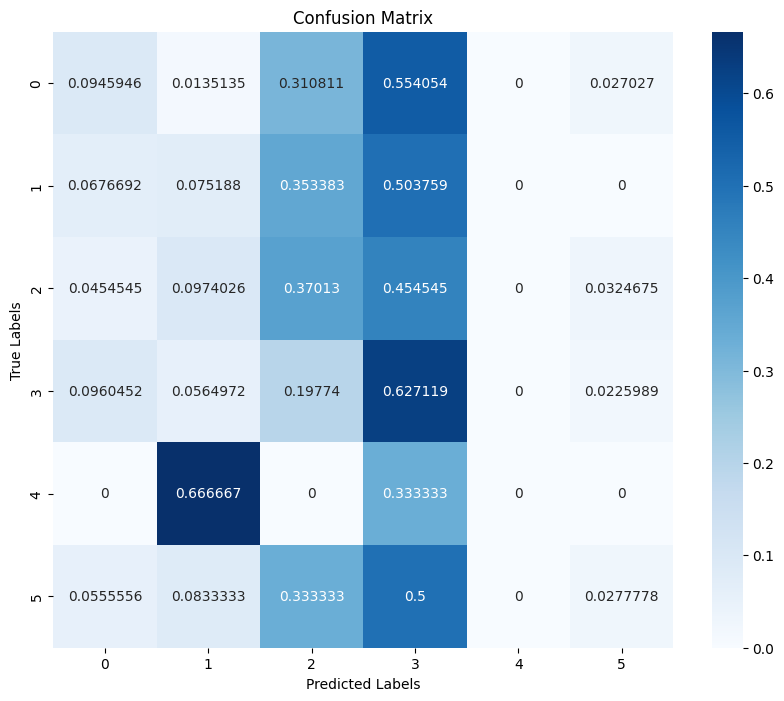

Epoch 4, Validation Loss: 2.6854, Accuracy: 0.3224, F1 Score: 0.2777
Val F1 Score Per Class  [0.12068966 0.11494253 0.34756098 0.45773196 0.         0.04166667]


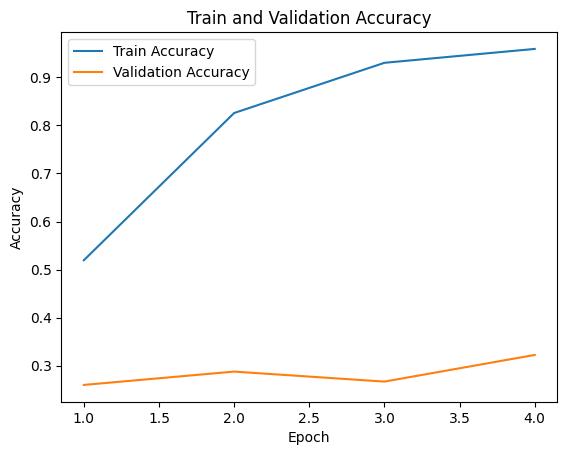

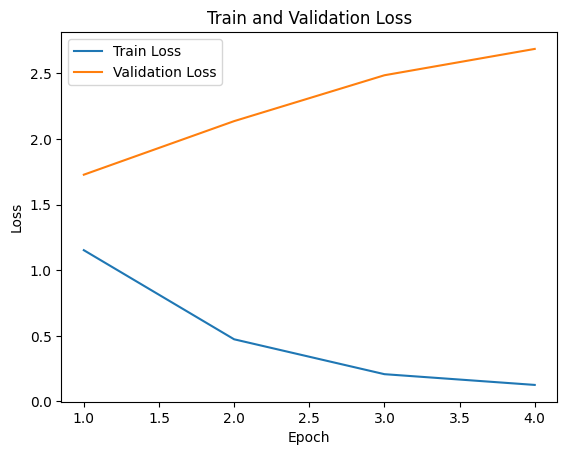

Epoch 5, Train Loss: 0.0852, Accuracy: 0.9729, F1 Score: 0.9729
Train F1 Score Per Class  [0.98128019 0.95714714 0.95702179 0.95221239 0.99705882 0.99250375]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.41it/s, loss=4.31]

[tensor([ 0.1337, -0.1311, -0.4102,  0.0839, -4.2781, -2.0906], device='cuda:0'), tensor([ 1.4891, -2.1796,  1.2863,  0.4268, -3.0881, -2.5807], device='cuda:0'), tensor([-3.6071,  1.4742, -1.5676,  1.8764, -2.4833, -2.6606], device='cuda:0'), tensor([-1.8432, -1.1616,  5.7245, -1.4880, -2.3130, -1.1618], device='cuda:0'), tensor([-1.8768, -1.5167,  4.8172, -0.7467, -2.3157, -2.0629], device='cuda:0'), tensor([-1.8286, -0.9453,  5.3840, -1.3071, -2.6558, -2.7998], device='cuda:0'), tensor([-2.5006,  0.3063,  0.6406,  0.2172, -2.7690, -0.9016], device='cuda:0'), tensor([-1.9959, -1.5211,  3.5417,  1.2180, -3.7670, -3.2973], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.43it/s, loss=3.38]

[tensor([-3.2302,  4.6447, -0.3755, -0.8973, -3.1853, -1.5864], device='cuda:0'), tensor([-1.7905, -1.6257, -1.6332,  5.4547, -2.8845, -2.6098], device='cuda:0'), tensor([-1.4028, -2.3581,  5.5256, -0.3802, -1.9437, -1.9623], device='cuda:0'), tensor([-2.7032, -0.9881, -0.5292, -0.0550,  2.3151, -1.6646], device='cuda:0'), tensor([-0.9855, -0.1021, -1.5248,  4.9173, -3.1688, -2.3018], device='cuda:0'), tensor([ 0.5662, -1.1557, -0.9078, -0.2744, -3.1922, -3.2532], device='cuda:0'), tensor([-1.0402, -1.4372,  2.9502, -1.3513, -4.8361, -1.5218], device='cuda:0'), tensor([-1.7864, -1.5546, -1.3416,  4.4687, -3.9161, -1.9799], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.38it/s, loss=1.15]

[tensor([-2.8558, -0.5232, -0.9999,  5.1741, -2.8429, -2.2086], device='cuda:0'), tensor([-2.7100, -0.7221,  3.9950, -0.7366, -1.7777, -2.6860], device='cuda:0'), tensor([-2.3106,  0.9769,  2.1292, -1.7427, -3.4504, -2.0220], device='cuda:0'), tensor([-0.5377,  3.1699, -0.8163, -1.4630, -3.8513, -3.7937], device='cuda:0'), tensor([ 1.2281, -0.5304, -1.7869,  2.3717, -4.4895, -1.8735], device='cuda:0'), tensor([-2.3451,  1.6969,  3.7254, -1.5246, -3.9934, -3.6460], device='cuda:0'), tensor([-2.5861,  2.4793, -0.2248, -1.2664, -3.1032,  1.2436], device='cuda:0'), tensor([-1.3974, -1.5654,  2.2436,  1.3652, -4.0297, -3.3636], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.38it/s, loss=2.55]

[tensor([ 6.1017, -0.2268, -1.9581, -0.5037, -2.3294, -2.4096], device='cuda:0'), tensor([-2.8794, -0.3734,  1.5786,  1.9718, -3.7903, -3.8645], device='cuda:0'), tensor([-2.9217, -0.7884,  2.3776,  2.4039, -3.5969, -3.1881], device='cuda:0'), tensor([ 1.5742,  0.4214, -1.4177, -0.6152, -3.9409, -1.2980], device='cuda:0'), tensor([-2.3588, -0.7069,  4.4951, -1.7516, -3.0456, -0.4636], device='cuda:0'), tensor([-0.8829, -3.0522,  1.3554,  1.6872, -4.0560, -1.5337], device='cuda:0'), tensor([-0.0274, -2.5441, -0.2691,  3.7799, -3.3833, -2.2372], device='cuda:0'), tensor([-0.7422, -2.0817,  1.2768,  3.3853, -4.1325, -1.6762], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.36it/s, loss=4.94]

[tensor([-0.0829,  1.0649, -1.3718,  0.1689, -5.4260, -2.7569], device='cuda:0'), tensor([-2.5533, -1.9778,  4.1278, -0.1669, -2.7723, -1.7572], device='cuda:0'), tensor([-2.9703,  2.2567, -0.3484,  0.0575, -3.9222, -2.9007], device='cuda:0'), tensor([-1.7253, -1.0114,  5.8867, -1.4917, -1.7598, -1.7858], device='cuda:0'), tensor([-1.0063, -1.5130,  2.5206, -0.5805, -3.4479, -1.8307], device='cuda:0'), tensor([-3.0995, -0.1791,  1.3291,  2.5313, -3.7492, -2.1536], device='cuda:0'), tensor([-3.4309,  1.2393,  3.8393, -1.2836, -3.8146, -2.6217], device='cuda:0'), tensor([-3.5705,  1.3091,  0.6784, -1.1987, -3.1982, -2.3825], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.35it/s, loss=2.41]

[tensor([ 0.7325, -0.5208, -2.7895,  2.8077, -3.9690, -3.7107], device='cuda:0'), tensor([-2.6234, -0.5830, -0.9723,  0.4511, -4.3511, -1.7813], device='cuda:0'), tensor([-3.4948,  1.6078, -1.6683, -0.3080, -3.1638, -0.1199], device='cuda:0'), tensor([-1.6969,  0.0599, -1.1985, -0.5008, -4.2148, -3.4339], device='cuda:0'), tensor([-1.7769, -1.7339, -0.4169,  4.7623, -3.9441, -1.9988], device='cuda:0'), tensor([-3.3400,  1.9036,  2.1164, -1.5394, -3.5034, -1.7603], device='cuda:0'), tensor([-2.9361,  2.9177, -0.7682, -1.5864, -3.1444, -1.7792], device='cuda:0'), tensor([-0.5239, -0.9026, -0.3698, -0.2231, -4.5674, -3.6434], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.36it/s, loss=1.81]

[tensor([-1.7287, -1.0673,  4.3306, -0.7023, -3.9072, -1.9632], device='cuda:0'), tensor([-3.8054, -1.4756,  2.6759, -1.0626, -2.3694, -1.3076], device='cuda:0'), tensor([ 0.6425, -2.1692, -0.4488,  3.0822, -3.5003, -1.8523], device='cuda:0'), tensor([-3.3468, -1.8459,  0.1702,  1.3382, -3.7054, -2.2121], device='cuda:0'), tensor([-2.8395,  3.5383,  2.8267, -0.7165, -3.4072, -3.0987], device='cuda:0'), tensor([-3.5994, -1.1450,  1.6691,  0.9916, -3.4721, -1.6047], device='cuda:0'), tensor([-3.0318, -1.1343, -0.8695, -0.4070, -3.4711, -1.6167], device='cuda:0'), tensor([-1.6664, -1.2551,  5.8072, -1.6247, -2.2845, -1.6820], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.35it/s, loss=2.82]

[tensor([-2.9121,  0.5008, -1.4895,  2.1778, -3.1013, -2.8203], device='cuda:0'), tensor([-1.7564,  0.8887, -1.2765,  0.6062, -2.4508, -1.7058], device='cuda:0'), tensor([-1.6908, -2.0407,  0.2879,  0.2041, -4.2720, -1.6408], device='cuda:0'), tensor([-2.5942, -1.5299,  2.0411,  2.4738, -3.6662, -2.5042], device='cuda:0'), tensor([-2.7322,  0.3359, -0.2236,  1.0144, -4.1692, -2.5421], device='cuda:0'), tensor([-2.4514, -2.8870,  0.8329,  3.6820, -3.3147, -1.4583], device='cuda:0'), tensor([-0.9174, -1.1687,  2.5366,  0.4583, -3.8459, -3.1585], device='cuda:0'), tensor([-3.3236,  3.9905, -1.6880,  0.2508, -3.3104, -1.8496], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:27,  2.36it/s, loss=2.07]

[tensor([-3.6903,  3.2411, -0.0080,  0.1101, -4.6719, -1.6345], device='cuda:0'), tensor([-1.7636,  0.8804, -0.2844,  1.0775, -3.1146, -2.4303], device='cuda:0'), tensor([ 2.0139, -2.5643, -0.4511,  2.1206, -3.8838, -3.0219], device='cuda:0'), tensor([-3.2500, -0.1959, -0.7066,  0.4517, -4.7716, -3.2139], device='cuda:0'), tensor([-2.2134, -1.6998,  5.1999,  0.1089, -3.0299, -1.6668], device='cuda:0'), tensor([-1.4923,  0.2437, -1.6516,  2.9465, -4.4183, -2.9290], device='cuda:0'), tensor([-3.7017,  2.7646,  0.2898,  0.4232, -3.8232, -2.0438], device='cuda:0'), tensor([-2.5421, -2.2255,  0.2724,  2.6312, -4.0643, -1.2985], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.37it/s, loss=4.6]

[tensor([-2.7560, -1.5698,  0.7626, -0.4887, -3.9215, -4.0071], device='cuda:0'), tensor([-2.2500,  0.0737, -1.2993,  0.0207, -3.1890, -2.5795], device='cuda:0'), tensor([-1.6786, -0.9610,  0.6234,  0.5783, -4.0056, -3.9579], device='cuda:0'), tensor([-3.9314,  0.6051,  1.2834, -0.5406, -4.3441, -2.9669], device='cuda:0'), tensor([-1.9895,  4.0913,  1.8110, -2.0814, -3.6812, -2.6897], device='cuda:0'), tensor([-3.4381,  0.0451, -1.0053,  3.6923, -3.6248, -2.4269], device='cuda:0'), tensor([ 3.9259,  0.0760, -1.5022,  0.4380, -3.7727, -3.0829], device='cuda:0'), tensor([-1.3900, -2.1420,  4.2192,  0.5170, -3.1196, -2.8312], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=3.07]

[tensor([-2.5405,  1.3973,  1.1826, -0.6168, -3.7699, -3.8531], device='cuda:0'), tensor([-2.6376,  4.2813, -0.0256, -1.0374, -3.4796, -2.3167], device='cuda:0'), tensor([-3.5153,  1.4207, -1.0731, -0.1544, -3.4443, -1.1361], device='cuda:0'), tensor([-2.0467, -2.4385,  0.8888,  4.3636, -3.2176, -1.5878], device='cuda:0'), tensor([-0.6501, -1.9478, -1.5218,  4.3012, -3.7235, -2.3296], device='cuda:0'), tensor([-1.5564,  0.5886, -1.1552,  1.3300, -4.0081, -3.5484], device='cuda:0'), tensor([ 0.3426, -1.4340,  0.3450,  0.9194, -4.4894, -3.2517], device='cuda:0'), tensor([ 0.2546, -1.9330, -0.3850,  0.6994, -3.9659, -2.6044], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.37it/s, loss=3.05]

[tensor([-1.2934,  1.0085, -0.4305, -1.1808, -4.1411, -3.9324], device='cuda:0'), tensor([-2.9537,  3.7816, -1.9158, -1.2692, -3.4985, -2.1216], device='cuda:0'), tensor([-1.0519, -1.7585, -1.8306,  4.7065, -3.1673, -2.0475], device='cuda:0'), tensor([-0.5788, -0.4391, -0.4148, -0.7596, -4.3089, -1.6920], device='cuda:0'), tensor([ 0.8925,  0.1557, -1.9260, -0.6118, -4.2700, -3.2293], device='cuda:0'), tensor([-1.9971,  0.0565,  4.5227, -1.4121, -3.1667, -2.7589], device='cuda:0'), tensor([-3.3691,  0.6638,  2.9189, -1.2922, -3.1287, -1.7567], device='cuda:0'), tensor([-0.8295, -1.0873, -0.7860,  1.8369, -4.4102, -1.9913], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.36it/s, loss=3.22]

[tensor([-1.7119,  0.5031, -1.5549,  1.7556, -2.3372, -1.4637], device='cuda:0'), tensor([-2.3601, -1.9651,  3.8669,  1.0570, -3.2772, -3.2652], device='cuda:0'), tensor([ 2.1214,  0.4750, -3.5635,  1.2392, -3.1611, -2.1625], device='cuda:0'), tensor([-2.7858, -0.9659,  0.3158,  4.4834, -3.5726, -2.4106], device='cuda:0'), tensor([-0.9638, -0.9542, -0.1899,  3.2975, -4.6879, -3.5160], device='cuda:0'), tensor([-1.2673, -2.0643, -0.8835,  0.3728, -3.6014, -3.3346], device='cuda:0'), tensor([-3.5216,  4.2195, -0.7378, -1.2838, -3.2745, -1.5016], device='cuda:0'), tensor([-2.1385,  1.0641,  1.3711, -0.1179, -5.0797, -1.6247], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.37it/s, loss=3.02]

[tensor([-1.6916, -1.3183,  5.4616, -0.7889, -2.4335, -2.8382], device='cuda:0'), tensor([-1.6323,  0.0226, -1.8284,  1.6429, -4.3694, -3.7954], device='cuda:0'), tensor([ 4.3025, -0.0256, -1.5661, -0.8478, -3.7285, -3.3471], device='cuda:0'), tensor([-1.4905, -1.5247,  5.7147, -1.0309, -2.1217, -1.6258], device='cuda:0'), tensor([-3.0749,  3.3039, -1.6312,  0.3237, -4.0693, -2.8060], device='cuda:0'), tensor([-1.2793, -1.3200,  0.6474,  1.8876, -3.1692, -3.6698], device='cuda:0'), tensor([-1.9483,  2.3242, -1.0420,  1.6719, -4.0353, -2.9942], device='cuda:0'), tensor([-2.1079, -1.5009, -0.9152,  1.6070, -3.3639, -3.4771], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.37it/s, loss=2.5]

[tensor([-2.8194, -1.1988, -0.8442,  2.8841, -3.0868, -3.2798], device='cuda:0'), tensor([-3.4606e+00, -2.9176e-01,  2.7644e-03,  4.1627e-01, -1.8600e+00,
        -2.2860e+00], device='cuda:0'), tensor([-2.8551, -2.3117,  2.4966, -0.0999, -2.6243, -1.0377], device='cuda:0'), tensor([-1.8922,  0.2334, -0.3077, -1.1278, -3.6475, -3.6160], device='cuda:0'), tensor([-0.8385, -0.8719,  3.4614, -1.7709, -3.8735, -2.6705], device='cuda:0'), tensor([-0.0523, -2.0478, -0.8354,  2.1835, -3.6709, -2.3344], device='cuda:0'), tensor([-1.7719,  1.5154, -2.0255,  0.6220, -2.7186, -1.6380], device='cuda:0'), tensor([-2.4466,  0.3860, -1.0761,  4.2969, -3.6978, -3.1840], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=3.4]

[tensor([-1.7733, -0.5977,  3.4137,  2.2302, -3.7665, -3.0652], device='cuda:0'), tensor([-2.7345, -0.6347,  2.6977,  1.1014, -4.3502, -3.1754], device='cuda:0'), tensor([-2.2047, -0.4617,  2.6917, -1.5498, -3.4481,  1.1749], device='cuda:0'), tensor([-2.5594, -1.4189,  0.5651,  0.1198, -3.8482, -1.7711], device='cuda:0'), tensor([-1.0209, -1.0452,  5.6132, -1.4635, -2.0402, -1.2663], device='cuda:0'), tensor([ 2.8470, -1.6087, -1.5958,  0.8747, -2.9964, -3.2085], device='cuda:0'), tensor([-2.3846, -0.5495, -1.8197,  2.2566, -3.4987, -1.3966], device='cuda:0'), tensor([ 6.5681, -1.3345, -1.8140, -0.2322, -1.9160, -2.0158], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=5.09]

[tensor([-1.7119,  4.8574, -0.5718, -0.9419, -3.7640, -2.6630], device='cuda:0'), tensor([-2.6619,  0.1995, -0.7719,  3.3108, -4.1043, -3.3647], device='cuda:0'), tensor([-2.7963, -1.4227,  3.4225,  0.2038, -2.8963, -1.8120], device='cuda:0'), tensor([-1.7928,  3.3971, -0.7203, -0.3069, -3.6754, -3.3133], device='cuda:0'), tensor([ 5.4784, -1.2487, -0.5672, -0.8099, -3.0872, -2.9570], device='cuda:0'), tensor([-1.1616,  0.9176,  1.6231, -1.7548, -4.1985, -4.4339], device='cuda:0'), tensor([-1.9147, -2.1011,  0.0637,  4.3378, -4.0677, -3.1981], device='cuda:0'), tensor([-2.2829, -1.5001,  4.7940, -0.9010, -2.7745, -2.4081], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=3.86]

[tensor([-2.9779,  0.1628, -0.6992,  3.2320, -3.8907, -2.3896], device='cuda:0'), tensor([-3.0480, -0.4539,  3.5178, -0.2402, -2.0862, -2.2556], device='cuda:0'), tensor([-1.6201,  2.1380, -0.0284,  0.0908, -4.2547, -3.2589], device='cuda:0'), tensor([-1.9456, -1.7346,  5.4612, -0.0456, -2.8002, -2.3303], device='cuda:0'), tensor([-1.9727, -1.8227,  0.2066,  2.8676, -3.9412, -1.0178], device='cuda:0'), tensor([ 4.0275, -1.2945, -1.4158,  0.5567, -3.4327, -3.2645], device='cuda:0'), tensor([-1.0573, -1.7254, -0.5989,  3.3970, -4.2004, -3.3787], device='cuda:0'), tensor([-2.4788,  3.3606,  0.9265, -1.0586, -4.1440, -3.2560], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:22,  2.37it/s, loss=2.44]

[tensor([-2.8975, -0.6092, -0.2768,  0.5962, -3.4027, -2.7361], device='cuda:0'), tensor([-1.4272, -0.9721, -1.0569,  1.1407, -2.4625, -3.1010], device='cuda:0'), tensor([-1.9007, -2.6285,  2.8887,  1.2754, -2.7377, -2.1989], device='cuda:0'), tensor([-3.1164,  2.8237, -0.3335,  0.7750, -2.2316, -2.7317], device='cuda:0'), tensor([-3.3757,  2.4249,  1.1114, -0.5636, -3.1878, -2.8495], device='cuda:0'), tensor([-2.0763,  1.0722, -1.3967, -0.4326, -2.9453, -2.7360], device='cuda:0'), tensor([-1.9992, -2.5507,  0.7966,  4.4526, -3.1941, -1.8839], device='cuda:0'), tensor([-1.5785, -1.2645, -2.2870,  4.9545, -3.1047, -2.4583], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=2.17]

[tensor([-2.2818,  5.4969, -0.8425, -1.3638, -2.6472, -1.7578], device='cuda:0'), tensor([-2.2928, -1.3304, -0.6336,  3.9093, -3.8892, -1.5021], device='cuda:0'), tensor([-3.1440, -1.0493,  1.1784,  0.9887, -4.0661, -2.6054], device='cuda:0'), tensor([-2.6215,  1.0642,  2.5427, -0.7938, -4.2377, -1.9399], device='cuda:0'), tensor([-4.0551, -0.3832, -0.7792, -0.6464, -2.8056, -2.2342], device='cuda:0'), tensor([-2.9980, -0.6928,  4.4658, -1.4198, -3.3513, -2.2007], device='cuda:0'), tensor([-1.0977, -0.5624,  0.2069, -0.9932, -3.8325, -1.9596], device='cuda:0'), tensor([-1.9330,  3.1893,  1.0126, -1.0494, -3.2501, -3.4164], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:22,  2.36it/s, loss=3.85]

[tensor([-1.5288, -1.7891,  5.0716, -1.3043, -2.4864, -2.0326], device='cuda:0'), tensor([-2.7772,  3.8229,  0.1329, -0.6425, -4.2030, -3.3602], device='cuda:0'), tensor([-2.8590,  0.7513, -0.4853,  3.2816, -3.6040, -3.7108], device='cuda:0'), tensor([-3.1913,  0.6790, -1.7354, -0.0442, -3.0672, -2.2391], device='cuda:0'), tensor([-2.2510,  1.6210, -0.7165, -0.7808, -3.7433, -1.3708], device='cuda:0'), tensor([-1.2196, -2.5332,  0.5421,  0.6704, -3.8942, -2.9519], device='cuda:0'), tensor([-1.2609,  5.5327, -0.9438, -1.5799, -2.8317, -1.9681], device='cuda:0'), tensor([ 0.7015,  0.5818, -1.3821, -1.1723, -2.6699, -3.2329], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.36it/s, loss=3.28]

[tensor([-1.9055, -0.5623,  3.2353, -0.8471, -4.0779, -2.6862], device='cuda:0'), tensor([-2.5587, -0.8901,  4.1696, -0.7584, -3.5437, -2.9931], device='cuda:0'), tensor([-0.8503, -0.5471,  1.5799, -1.1604, -4.1422, -3.6235], device='cuda:0'), tensor([-2.2000, -1.7081, -0.5077,  4.6299, -3.3970, -2.4862], device='cuda:0'), tensor([-2.4890, -1.5092, -0.2732,  0.0412, -3.9762, -3.1457], device='cuda:0'), tensor([-0.7366, -0.2235, -0.5579,  1.1812, -4.6293, -1.2030], device='cuda:0'), tensor([-1.0137, -2.5292,  1.0425,  3.4347, -3.8944, -1.9763], device='cuda:0'), tensor([-2.3906, -0.0674,  5.4666, -1.4234, -2.8428, -2.5947], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.38it/s, loss=3.17]

[tensor([-1.1671, -0.3349,  1.3219, -0.9452, -3.6375, -3.5970], device='cuda:0'), tensor([-2.7464,  4.6986,  0.5847, -2.0468, -2.6637, -1.5928], device='cuda:0'), tensor([-1.0396,  0.1063, -1.4535,  1.3510, -5.0538, -3.6852], device='cuda:0'), tensor([-1.8102,  5.6012, -1.0362, -1.4602, -2.2754, -1.6473], device='cuda:0'), tensor([-2.6949, -1.4229, -0.1013,  2.4739, -4.2759, -2.7162], device='cuda:0'), tensor([-3.3284,  2.6630,  1.3349, -0.7494, -3.5265, -3.0469], device='cuda:0'), tensor([-1.6697, -2.0694,  1.3208,  0.6553, -3.4403, -1.9072], device='cuda:0'), tensor([-1.9886,  2.6014, -1.3465, -1.0362, -4.6452, -1.5453], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.36it/s, loss=3.25]

[tensor([-3.0615, -1.8829,  4.7599,  0.2551, -2.5232, -1.6849], device='cuda:0'), tensor([-2.4129, -0.9449,  2.7487,  0.7241, -2.7591, -3.5690], device='cuda:0'), tensor([-3.9876,  1.4198,  0.6800,  0.0433, -3.3196, -1.8058], device='cuda:0'), tensor([-2.3280, -0.4982, -1.3251,  1.6427, -4.2979, -3.3808], device='cuda:0'), tensor([-2.4062, -0.0323, -1.3311,  3.8429, -3.3283, -2.9613], device='cuda:0'), tensor([-1.4583,  1.1071, -2.3535,  1.1443, -3.6732, -2.4416], device='cuda:0'), tensor([ 1.7844, -0.3079, -1.9740, -0.1200, -1.3294, -1.7379], device='cuda:0'), tensor([ 1.1738, -1.8536, -0.4561,  1.6313, -3.9679, -3.3447], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=3.84]

[tensor([-3.0733, -1.2598,  4.6983, -0.7465, -3.3683, -1.9119], device='cuda:0'), tensor([-1.9319, -1.1800,  4.5465,  0.1861, -3.6560, -1.7682], device='cuda:0'), tensor([-3.0242,  0.3161,  0.4970,  1.4126, -3.7177, -1.9519], device='cuda:0'), tensor([-1.9536,  4.3711, -0.6647, -0.7036, -3.2274, -2.5055], device='cuda:0'), tensor([-3.9129,  2.4732, -1.0223, -0.1464, -3.8094, -1.4839], device='cuda:0'), tensor([-1.9108, -2.0896,  2.7777, -0.0229, -2.7177, -2.4237], device='cuda:0'), tensor([-1.1770, -1.4964, -2.5585,  5.1492, -2.7421, -3.0518], device='cuda:0'), tensor([-2.4737, -1.5876,  0.2609, -0.2707, -3.2786, -0.7900], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.37it/s, loss=1.33]

[tensor([-2.3041, -0.5600, -0.2616,  5.2300, -4.1337, -2.8498], device='cuda:0'), tensor([-3.4829, -1.5790,  0.5140,  3.2711, -4.3630, -0.8371], device='cuda:0'), tensor([-1.5347, -1.2771,  4.8580, -0.7387, -3.1613, -1.9140], device='cuda:0'), tensor([ 2.5243, -0.5490, -1.5544, -0.1339, -2.8081, -2.8878], device='cuda:0'), tensor([-2.4889,  0.9658, -0.7885,  1.7848, -4.5238, -2.9626], device='cuda:0'), tensor([ 1.1512, -2.8345,  1.9779,  0.5261, -3.5618, -0.6420], device='cuda:0'), tensor([-1.9245,  0.4836,  1.7458, -0.9836, -4.0335, -2.6226], device='cuda:0'), tensor([-1.2339,  0.8415,  0.0971, -1.7666, -3.1813, -2.5243], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.36it/s, loss=2.29]

[tensor([-2.1999,  3.5322, -1.0968,  0.4377, -3.5685, -2.2193], device='cuda:0'), tensor([-2.9812,  3.2138,  0.2047, -0.2090, -2.7072, -2.7166], device='cuda:0'), tensor([-1.9645, -0.7903, -0.5176,  1.7313, -4.2447, -2.5094], device='cuda:0'), tensor([-2.5922, -0.6831,  0.7529, -1.6317, -3.7845, -0.7452], device='cuda:0'), tensor([-0.3271,  0.7623,  2.5775, -2.0622, -3.2494, -2.1333], device='cuda:0'), tensor([ 1.7826, -2.0574,  0.2510,  1.0448, -3.6221, -4.0814], device='cuda:0'), tensor([-1.3829, -1.7302, -0.0547,  1.1708, -4.3797, -2.7451], device='cuda:0'), tensor([-3.0176,  3.0082, -1.5021,  0.9452, -4.1242, -1.9853], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.37it/s, loss=3.65]

[tensor([ 2.3286, -1.5449, -0.6423,  2.7863, -4.5395, -3.0214], device='cuda:0'), tensor([-1.6851,  5.2355, -1.1360, -0.7442, -2.7746, -2.5786], device='cuda:0'), tensor([-1.5168,  2.7228, -1.2128, -0.2595, -2.8306, -2.7497], device='cuda:0'), tensor([-1.9254, -1.7031, -0.8646,  5.4550, -2.5511, -2.0812], device='cuda:0'), tensor([-1.4954, -1.0584, -0.7683,  4.9269, -4.5578, -2.8509], device='cuda:0'), tensor([-2.6838,  1.3569,  3.5841,  0.0246, -3.6965, -3.2711], device='cuda:0'), tensor([-2.2752, -0.2706,  4.6422, -1.1240, -3.2099, -2.3687], device='cuda:0'), tensor([-2.0824,  4.4409, -0.6135, -1.5941, -4.0502, -2.8992], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=2.38]

[tensor([-2.8063,  0.6445, -1.6881,  2.9887, -3.5300, -2.3720], device='cuda:0'), tensor([ 1.0652, -1.8122, -1.3603,  1.6328, -3.5848, -3.1369], device='cuda:0'), tensor([-2.7895, -2.4062,  3.2743,  0.0196, -3.3829, -2.3503], device='cuda:0'), tensor([-3.4412,  0.6460, -0.8929, -0.3559, -2.9438, -1.8931], device='cuda:0'), tensor([ 0.4382,  0.4386,  1.3922, -1.3614, -4.2730, -2.8203], device='cuda:0'), tensor([-3.1979, -1.6658,  3.9986, -0.5209, -3.6704, -1.4029], device='cuda:0'), tensor([-2.1112, -1.6389,  2.5742,  0.6183, -4.1180, -3.0465], device='cuda:0'), tensor([-3.3335,  1.7063,  0.6139,  0.2637, -3.9083, -2.5384], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=3.6]

[tensor([-2.5389,  5.1081, -0.2994, -1.2293, -3.1929, -1.7401], device='cuda:0'), tensor([-1.8771,  0.0117,  3.8199, -0.1428, -3.2593, -3.5888], device='cuda:0'), tensor([ 4.9557, -1.4975, -1.5739, -0.0565, -2.0873, -2.2945], device='cuda:0'), tensor([-2.0275, -1.5829, -1.0161,  3.9219, -3.8143, -2.9967], device='cuda:0'), tensor([-2.3850,  4.7511, -2.1532, -0.7240, -3.2919, -2.0132], device='cuda:0'), tensor([-1.6027, -0.5692,  0.0219, -1.3387, -3.3279, -2.0899], device='cuda:0'), tensor([-2.7688, -1.2148,  2.5465,  0.3471, -4.0439, -3.6228], device='cuda:0'), tensor([-1.5707, -1.6465, -0.3362, -0.3888, -3.3300,  1.2908], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=2.32]

[tensor([-2.1439, -1.0629, -2.0485,  5.2890, -3.6032, -1.1247], device='cuda:0'), tensor([-2.9035,  0.8715, -0.5604,  2.2725, -4.1276, -2.0745], device='cuda:0'), tensor([-2.8479,  1.6857,  3.3819, -1.1674, -2.9146, -1.7063], device='cuda:0'), tensor([-1.1631, -0.9003,  0.4726, -1.4160, -3.9364, -2.6287], device='cuda:0'), tensor([-2.6629,  0.2851,  3.3963,  0.0335, -3.7366, -3.0403], device='cuda:0'), tensor([-0.4443,  0.8405, -1.0812, -1.3378, -3.6300, -0.4184], device='cuda:0'), tensor([-2.7731, -1.9882,  0.8650,  2.9229, -3.3890, -2.2227], device='cuda:0'), tensor([-1.5143, -1.1503,  4.1556,  0.8320, -3.6394, -3.7532], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.37it/s, loss=4.62]

[tensor([-3.4766,  1.9127, -1.9038,  0.0411, -3.5550, -0.5142], device='cuda:0'), tensor([-3.0000, -1.5537, -1.3551,  5.2204, -3.4222, -1.9917], device='cuda:0'), tensor([-2.8248,  3.2987, -0.3453, -0.8017, -2.5215, -2.5751], device='cuda:0'), tensor([-1.9629, -0.6321, -0.8995,  0.8946, -2.1988, -0.1552], device='cuda:0'), tensor([-2.2549, -2.0717,  3.2218, -0.4521, -2.4019, -1.8262], device='cuda:0'), tensor([-3.1952, -1.0387,  4.4877, -1.1257, -2.1412,  1.1905], device='cuda:0'), tensor([ 5.7601, -1.2761, -0.7257, -0.4279, -2.7384, -2.3478], device='cuda:0'), tensor([-1.8112,  4.3944, -0.3929, -0.1677, -4.2171, -3.0290], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.38it/s, loss=3.92]

[tensor([-2.9261, -1.2613, -0.4738,  3.8387, -2.8450, -0.5406], device='cuda:0'), tensor([-2.1752,  5.3201, -1.5283, -0.4023, -2.4372, -1.1612], device='cuda:0'), tensor([-1.7702,  1.7394, -1.6306,  1.3849, -4.6903,  1.0649], device='cuda:0'), tensor([-2.3175,  2.3288,  3.4571, -2.0982, -3.1943, -2.5464], device='cuda:0'), tensor([-2.6531, -0.6206,  5.6452, -1.2030, -2.7381, -2.5476], device='cuda:0'), tensor([-2.9776, -0.3697,  1.6970,  1.2387, -4.0798, -3.2020], device='cuda:0'), tensor([ 5.3225, -0.0099, -2.5160, -0.1206, -2.6021, -2.8742], device='cuda:0'), tensor([-3.0539, -0.2720, -1.3074,  2.0901, -3.9087, -2.4579], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.38it/s, loss=3.08]

[tensor([ 4.9875,  0.3267, -2.3645, -0.7141, -2.1187, -3.0020], device='cuda:0'), tensor([-1.9508,  3.0177,  1.7419, -0.9767, -3.8085, -4.2530], device='cuda:0'), tensor([-1.6753,  2.6106, -1.0199, -0.8076, -1.6730, -2.2330], device='cuda:0'), tensor([-2.0654, -2.0716, -0.8386,  0.9837, -2.9867, -0.8640], device='cuda:0'), tensor([-2.4201,  1.4745, -1.1737,  0.5802, -3.4159, -2.5688], device='cuda:0'), tensor([-2.9318,  0.6478,  1.1246, -1.0817, -3.8296, -1.7354], device='cuda:0'), tensor([-2.3054, -1.1252, -0.9701,  0.4787, -3.1499, -2.6316], device='cuda:0'), tensor([-1.9602, -0.7440,  5.8111, -1.6620, -2.2517, -1.6507], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=2.12]

[tensor([-1.7086,  0.3848,  0.3391,  0.8738, -3.7202, -4.3606], device='cuda:0'), tensor([-0.8102, -2.1979,  1.8975,  1.7482, -4.0400, -2.4716], device='cuda:0'), tensor([-3.0844, -0.6217,  0.7182, -0.4854, -4.4853, -2.2937], device='cuda:0'), tensor([-2.3648,  0.4890,  3.7357, -0.0530, -3.8412, -3.1634], device='cuda:0'), tensor([-2.7437, -1.4011,  3.7059,  1.7411, -3.9379, -3.1589], device='cuda:0'), tensor([ 1.9868, -3.1999, -1.2493,  3.1401, -2.8528, -1.4287], device='cuda:0'), tensor([-2.1438, -1.4339,  2.0191,  0.5279, -4.1173, -2.7203], device='cuda:0'), tensor([-0.9291,  3.5367, -1.4601, -0.6223, -2.3425, -3.1716], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=2.15]

[tensor([-2.1942,  2.3273,  2.0046, -2.0206, -3.2045, -2.5949], device='cuda:0'), tensor([-1.7941, -1.9123,  5.1087, -1.4218, -1.6021, -2.2619], device='cuda:0'), tensor([-2.6077, -1.2297,  1.1369,  0.3194, -4.1092, -2.0132], device='cuda:0'), tensor([-1.6841,  2.1671, -1.1012, -1.0922, -4.2684, -2.6853], device='cuda:0'), tensor([-2.3644, -0.9691,  0.7700,  0.9612, -3.2443, -2.9781], device='cuda:0'), tensor([-3.3534, -1.1432,  3.0276,  0.9516, -3.5730, -3.0165], device='cuda:0'), tensor([-2.1089, -1.8922, -0.0992,  4.9609, -3.7602, -2.3503], device='cuda:0'), tensor([-1.6867, -0.4263,  2.3279, -0.4544, -3.9191, -3.1997], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=3.74]

[tensor([ 4.7340, -1.8662, -1.8059,  1.6632, -2.6901, -2.6473], device='cuda:0'), tensor([-2.8802, -1.7098, -0.5173,  2.0483, -3.9501, -2.7467], device='cuda:0'), tensor([-2.1839, -1.1424, -2.3977,  4.1490, -2.5749, -0.8383], device='cuda:0'), tensor([-2.9245,  2.5704, -1.4555, -1.1413, -2.1615,  2.5197], device='cuda:0'), tensor([-1.5839,  0.1681,  3.7526, -1.7629, -2.9725, -2.1014], device='cuda:0'), tensor([-0.9594,  1.3660,  2.9488, -1.3067, -3.6536, -3.4583], device='cuda:0'), tensor([-1.6632, -2.0984,  1.8119,  3.3356, -3.3551, -3.4009], device='cuda:0'), tensor([-2.1404,  5.3513, -1.0684, -0.5384, -2.1920, -2.1398], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.37it/s, loss=2.38]

[tensor([-1.1048, -1.3678,  3.6724, -0.8164, -2.4909, -1.0854], device='cuda:0'), tensor([-2.8661,  1.3448,  0.8858, -0.4458, -4.0222,  0.1057], device='cuda:0'), tensor([-1.3306, -1.4085,  5.1655, -0.0887, -3.2914, -2.8212], device='cuda:0'), tensor([-2.7077,  2.6737, -0.1702, -0.7418, -2.9060, -1.8735], device='cuda:0'), tensor([-2.1268, -1.1247,  4.2170, -0.4479, -3.3362, -2.7386], device='cuda:0'), tensor([-2.7593,  4.4912, -0.7140, -0.3748, -2.7737, -1.0519], device='cuda:0'), tensor([-0.5519,  0.4890, -0.1424, -1.6422, -3.3174, -3.4310], device='cuda:0'), tensor([-1.9748,  0.0329,  3.7928,  0.2361, -3.9428, -3.8087], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.36it/s, loss=3.69]

[tensor([-2.8119, -1.0853,  5.1100, -0.7446, -2.7509, -2.1869], device='cuda:0'), tensor([-2.7787,  4.2417,  0.2381, -1.1210, -3.7964, -2.5460], device='cuda:0'), tensor([ 1.6318, -2.4959, -0.1548,  0.4858, -3.8193, -2.0082], device='cuda:0'), tensor([-0.7805, -2.1986, -1.0401,  4.1170, -3.0676, -1.7321], device='cuda:0'), tensor([-2.9114,  0.2982,  2.9469, -0.2485, -4.4631, -3.0481], device='cuda:0'), tensor([-2.8743, -0.7058,  3.3670, -0.8744, -2.9644, -2.7162], device='cuda:0'), tensor([-1.3989, -1.1212,  3.7416, -0.3908, -3.5252, -2.1642], device='cuda:0'), tensor([-3.2775,  2.4064, -0.2710, -1.0796, -3.4574,  1.4281], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:14,  2.35it/s, loss=2.94]

[tensor([-0.3088, -1.8429,  4.4063, -0.5310, -3.3767, -2.1971], device='cuda:0'), tensor([-0.8518, -1.5310,  4.7858, -0.7494, -2.9158, -2.6768], device='cuda:0'), tensor([-1.1950,  0.0729,  2.1288,  0.2318, -4.5340, -2.7655], device='cuda:0'), tensor([ 1.6100, -1.0312, -2.1608,  2.2219, -3.4166, -2.8873], device='cuda:0'), tensor([-3.1093,  1.2347, -0.9770,  0.6211, -3.7548, -1.0004], device='cuda:0'), tensor([ 5.5913, -1.3417, -1.9756,  0.4524, -2.8858, -2.9992], device='cuda:0'), tensor([-2.7452,  3.2825,  0.0305, -0.2706, -3.9068, -3.2074], device='cuda:0'), tensor([-1.0505, -0.7423, -0.4266,  3.4473, -4.5980, -2.2298], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.37it/s, loss=2.78]

[tensor([-2.6076, -2.5233, -0.3211,  2.8447, -2.7594, -1.0469], device='cuda:0'), tensor([-2.5360,  2.6584,  1.0894, -0.1200, -3.0675, -3.3436], device='cuda:0'), tensor([-2.2619, -0.6088,  0.9389,  1.6646, -4.3435, -3.1887], device='cuda:0'), tensor([-3.1160, -1.3677,  1.1715,  4.2278, -4.0100, -2.5811], device='cuda:0'), tensor([-2.7740,  3.7657,  0.0068, -0.0880, -4.1052, -2.8856], device='cuda:0'), tensor([-2.7242, -0.8373,  0.0320,  4.6399, -2.8883, -2.7624], device='cuda:0'), tensor([-2.2135, -1.4718,  2.8672,  0.9087, -3.9432, -3.7840], device='cuda:0'), tensor([-1.6752,  2.6087, -1.7179,  0.9170, -4.3427, -3.5994], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.36it/s, loss=2.05]

[tensor([-1.8882, -0.9535, -0.4834,  1.5706, -3.2031, -2.6370], device='cuda:0'), tensor([ 0.5949, -1.9587,  0.0591,  1.4565, -3.0508, -1.6606], device='cuda:0'), tensor([-1.4955, -2.8679,  0.4501,  2.1106, -3.4350, -2.5798], device='cuda:0'), tensor([-1.5601,  1.8624, -2.2441,  2.3999, -2.3762, -2.4894], device='cuda:0'), tensor([-2.8654, -1.2571,  4.8011, -0.1270, -2.3525, -2.4850], device='cuda:0'), tensor([-3.3530, -1.1299, -0.4799,  3.0582, -4.2548, -3.4863], device='cuda:0'), tensor([-3.0135, -1.2762,  4.1913, -1.0815, -2.3198,  0.0815], device='cuda:0'), tensor([-2.0040, -1.9675,  1.9810, -1.0534, -3.0141, -3.0396], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.37it/s, loss=1.75]

[tensor([-2.1201,  0.1869, -0.2823,  4.1817, -4.0112, -3.8157], device='cuda:0'), tensor([ 0.8588, -1.8267, -0.0849, -0.7221, -2.7817, -3.3087], device='cuda:0'), tensor([-0.4682, -1.0303, -1.4482,  1.3285, -4.2238, -1.6406], device='cuda:0'), tensor([-2.1074,  0.5833, -2.3301,  4.2484, -3.7057, -1.0285], device='cuda:0'), tensor([-4.1765,  1.3132, -1.3580, -0.1813, -3.2169, -0.2874], device='cuda:0'), tensor([-2.2815, -0.5580,  5.7333, -1.2023, -2.0321, -1.8328], device='cuda:0'), tensor([-3.8681,  0.3761,  0.3750,  3.0032, -3.6738, -1.6943], device='cuda:0'), tensor([-2.4733,  1.6608, -0.4994, -1.1707, -4.2246, -2.4971], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.37it/s, loss=3.08]

[tensor([-3.1655,  3.4755, -0.6219,  0.4804, -2.5974, -2.7255], device='cuda:0'), tensor([-1.6205, -0.1162,  0.5333, -0.1738, -3.9493, -3.2948], device='cuda:0'), tensor([-0.8030,  0.7119,  0.3214, -0.7293, -3.7388, -2.5443], device='cuda:0'), tensor([-2.7409, -1.0642, -0.4884, -0.6620, -2.5357,  5.3869], device='cuda:0'), tensor([-3.3638,  0.5359,  0.0432, -0.2322, -3.8785, -3.2008], device='cuda:0'), tensor([-2.1380, -0.3431, -0.3409,  0.3718, -4.1862, -2.7585], device='cuda:0'), tensor([-2.7081, -1.8515,  4.0956,  0.1305, -3.4941, -2.6567], device='cuda:0'), tensor([-3.1742,  2.0713, -1.2328,  2.5921, -3.4544, -1.9443], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.37it/s, loss=4.12]

[tensor([-1.2796,  2.2374, -0.4420, -1.0906, -4.4298, -1.2007], device='cuda:0'), tensor([-2.7061,  2.7954,  2.3685, -2.0020, -3.0421, -2.3572], device='cuda:0'), tensor([-2.7759,  2.4883,  0.2503, -0.5013, -4.3244, -2.9490], device='cuda:0'), tensor([-3.1035,  2.8882,  0.1112, -0.7048, -4.2465, -2.6449], device='cuda:0'), tensor([-2.0872, -1.6981, -0.4951,  3.9729, -4.0974, -2.3457], device='cuda:0'), tensor([ 1.8810, -2.1699, -1.7773,  2.0858, -3.1723, -2.2376], device='cuda:0'), tensor([-0.3545, -1.1292, -0.8788, -1.8678,  3.4042, -1.1836], device='cuda:0'), tensor([-2.2602, -1.2487,  5.5082, -0.2033, -2.8903, -1.8752], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.37it/s, loss=4.16]

[tensor([-0.7757, -1.2459, -0.3493,  1.7842, -4.5510, -3.4126], device='cuda:0'), tensor([-2.1897,  1.7735,  1.0531, -0.6350, -4.9288, -3.5816], device='cuda:0'), tensor([-2.5383, -1.1036, -1.6204, -0.1774, -4.0658, -0.4735], device='cuda:0'), tensor([-1.8443, -0.8047,  1.7736,  2.9128, -4.7770, -2.7953], device='cuda:0'), tensor([-3.4412,  3.7888, -0.6622,  0.3826, -3.2752, -1.3303], device='cuda:0'), tensor([-2.1485, -2.3249, -0.9813,  4.4183, -3.2934, -1.7758], device='cuda:0'), tensor([-1.8059, -2.4987,  0.9074,  3.8027, -3.1395, -2.4328], device='cuda:0'), tensor([-1.5100,  0.7076, -1.4042,  2.2786, -4.8039, -2.1747], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:11,  2.35it/s, loss=2.48]

[tensor([-1.8847, -2.6779,  2.8224, -0.2076, -0.1631,  0.0394], device='cuda:0'), tensor([ 2.9569, -3.1840,  0.2847,  0.5914, -2.1465, -2.0780], device='cuda:0'), tensor([-1.1559,  2.0121,  2.6489, -1.6964, -3.9606, -4.4388], device='cuda:0'), tensor([-2.2711,  0.9111,  1.8965, -0.8928, -4.4142, -3.3026], device='cuda:0'), tensor([-3.1866, -0.7512,  4.6185, -1.4319, -2.6610, -1.9621], device='cuda:0'), tensor([-2.6096, -2.2483,  1.6332,  0.1943, -3.0542,  0.6839], device='cuda:0'), tensor([-3.3321, -0.6199, -0.0859, -1.4320, -3.0191, -0.3292], device='cuda:0'), tensor([-2.7166,  1.7560, -0.5495,  0.3320, -4.3324, -2.2415], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.36it/s, loss=3.22]

[tensor([-1.1018, -2.5008,  0.8456, -0.2102, -4.2521, -2.7916], device='cuda:0'), tensor([ 0.2951, -1.0179, -0.8224, -0.0976, -2.6171, -1.2642], device='cuda:0'), tensor([ 4.9144, -1.4992, -1.5036, -0.3850, -2.6088, -1.3197], device='cuda:0'), tensor([-2.5563,  0.6171,  4.2120, -1.6803, -3.2136, -2.7073], device='cuda:0'), tensor([-0.2655, -2.3283, -0.5974,  4.2649, -3.8517, -2.3887], device='cuda:0'), tensor([-1.9859, -1.6461,  1.2095,  0.8813, -4.2634, -4.1162], device='cuda:0'), tensor([-2.7784, -0.6407, -0.8180,  3.2642, -3.7851, -2.3723], device='cuda:0'), tensor([ 5.6243, -1.6693, -0.5785, -0.3155, -2.7415, -2.5715], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=3.28]

[tensor([ 0.4116, -0.1283,  2.1797,  0.1343, -4.1477, -3.8848], device='cuda:0'), tensor([-2.2692,  1.3915,  3.2820, -0.8910, -4.3478, -3.6134], device='cuda:0'), tensor([-1.4907, -0.1251, -1.7894,  1.0911, -4.3535, -2.6404], device='cuda:0'), tensor([-2.7370, -2.0719,  0.4040,  3.4565, -3.9351, -2.0000], device='cuda:0'), tensor([-1.7563,  3.1600, -0.2487, -1.2161, -3.4853, -2.8719], device='cuda:0'), tensor([-1.2983, -1.3022,  0.7497,  1.9447, -3.7082, -2.7347], device='cuda:0'), tensor([-2.5315, -0.4355,  2.4341, -0.5325, -2.7899, -2.9922], device='cuda:0'), tensor([-0.9477, -1.6253, -1.4399,  3.7159, -3.5765, -2.2700], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.36it/s, loss=2.85]

[tensor([-0.2671,  0.1579,  1.0601,  2.1764, -4.6306, -4.3701], device='cuda:0'), tensor([-1.9754, -0.0847,  2.5934, -1.2450, -3.1764, -1.4756], device='cuda:0'), tensor([-1.6512e-01, -1.5947e+00, -1.2734e+00,  3.7229e-03, -4.4040e+00,
        -3.1815e+00], device='cuda:0'), tensor([-2.5825, -1.6062, -1.1205,  4.4683, -3.1433, -1.0784], device='cuda:0'), tensor([-1.8049,  0.6730, -1.5829,  0.5977, -4.4739, -3.0571], device='cuda:0'), tensor([-1.0348, -0.6239,  4.3981, -0.8308, -3.4105, -2.6601], device='cuda:0'), tensor([-3.0893,  1.1357, -0.1240, -1.0516, -3.6335, -2.2434], device='cuda:0'), tensor([-0.4004, -3.6444,  1.4786,  3.7753, -3.3035, -1.7644], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.36it/s, loss=1.97]

[tensor([-1.1195, -1.2761,  3.5623, -0.7250, -4.0740, -3.2471], device='cuda:0'), tensor([-2.2393, -1.5724,  0.5302,  4.4923, -3.4189, -1.7594], device='cuda:0'), tensor([-1.3512, -1.7783, -0.5066, -0.2126, -3.5045, -2.3844], device='cuda:0'), tensor([-2.6610, -0.7731, -1.3537,  4.8586, -3.5668, -2.4549], device='cuda:0'), tensor([-2.4288, -2.0865,  2.7861,  2.5660, -3.6404, -2.5557], device='cuda:0'), tensor([-3.1479,  0.1357,  0.6312,  1.1273, -4.0812, -3.3584], device='cuda:0'), tensor([-2.4179, -0.0366,  3.0249, -1.2838, -3.2057, -3.1296], device='cuda:0'), tensor([-1.2348, -2.1174,  3.1855,  1.4497, -3.7059, -2.9424], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.36it/s, loss=2.99]

[tensor([-3.1685, -0.7684,  0.8433,  1.8218, -3.5573, -3.2456], device='cuda:0'), tensor([ 1.2113,  1.1928, -1.1658,  0.3242, -4.4599, -4.5098], device='cuda:0'), tensor([-2.1649, -0.0153, -1.9903,  2.7509, -2.3530, -1.2850], device='cuda:0'), tensor([-2.5872, -0.8151, -1.8694,  1.0555, -2.5881, -2.3928], device='cuda:0'), tensor([-1.7950, -1.1710,  5.8484, -1.4066, -2.3078, -1.8778], device='cuda:0'), tensor([-3.6982,  0.4317,  0.3914, -1.3438, -2.9242,  0.5004], device='cuda:0'), tensor([-1.9718,  5.4092, -0.7795, -0.8716, -2.6930, -2.5957], device='cuda:0'), tensor([-1.5168,  0.6394, -1.9239, -0.5650, -3.6685, -2.5331], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.35it/s, loss=2.09]

[tensor([-1.4706, -2.2436, -0.8277,  1.0511, -2.9893,  3.9878], device='cuda:0'), tensor([-1.9210, -1.7222,  1.5123,  2.6264, -3.3329, -2.4962], device='cuda:0'), tensor([-2.9554, -1.6323, -1.4900,  0.9955, -4.2355,  0.5791], device='cuda:0'), tensor([-1.8811, -1.6464, -0.2062, -0.1482, -4.1700, -3.2406], device='cuda:0'), tensor([-2.2617e+00, -1.9841e+00, -8.1022e-01, -4.3767e-03, -4.7178e+00,
        -3.4830e+00], device='cuda:0'), tensor([-1.2577,  2.0792,  0.1221, -0.7623, -4.0124, -3.6037], device='cuda:0'), tensor([-2.0434,  0.5435, -1.0053,  1.2078, -2.9494,  0.2757], device='cuda:0'), tensor([-1.0932, -2.6392, -0.7521,  3.7544, -3.0072, -2.1802], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.35it/s, loss=1.64]

[tensor([-3.3002,  0.6026,  0.3994, -1.0589, -3.6924, -2.5100], device='cuda:0'), tensor([-1.6327,  0.0418,  1.3907, -0.8437, -4.6812, -2.9898], device='cuda:0'), tensor([-1.2376,  1.1635, -0.3798, -1.1027, -3.6888, -1.0786], device='cuda:0'), tensor([-1.3300,  2.3741, -0.3428,  0.2499, -4.2711, -3.2301], device='cuda:0'), tensor([-2.3972, -2.3945,  0.1341,  2.7126, -4.5966, -3.1121], device='cuda:0'), tensor([-2.9583, -1.1244,  1.7657, -0.7316, -2.9620, -2.3174], device='cuda:0'), tensor([-1.2799, -1.8787, -1.6294,  4.8549, -3.9843, -3.7934], device='cuda:0'), tensor([-2.1599, -1.4619, -0.2505,  3.8524, -4.7643, -1.5610], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.34it/s, loss=2.52]

[tensor([ 3.0265, -2.4308, -0.3778,  3.1650, -3.4454, -3.7565], device='cuda:0'), tensor([-0.1448,  4.2073, -1.5989, -0.8225, -3.7974, -2.3308], device='cuda:0'), tensor([-2.9513, -0.4470,  5.0107, -0.9224, -2.5954, -2.4244], device='cuda:0'), tensor([-2.8767,  1.3474, -1.2903,  0.6442, -3.7022, -2.8986], device='cuda:0'), tensor([ 2.0990,  2.4862, -2.6502, -0.9542, -3.1107, -2.4523], device='cuda:0'), tensor([-1.4567, -1.1454,  5.8254, -1.1166, -2.7273, -2.3071], device='cuda:0'), tensor([-3.0189,  5.2775, -0.1709, -1.1968, -2.5831, -2.9495], device='cuda:0'), tensor([-1.8676,  1.1334,  2.5714, -2.2765, -3.5468, -3.3493], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.31it/s, loss=5.08]

[tensor([ 0.3866, -2.7534, -0.6618,  4.2700, -3.8144, -2.4939], device='cuda:0'), tensor([-1.9166, -2.3670,  0.9316,  2.6213, -3.6033, -3.2284], device='cuda:0'), tensor([-3.3535, -1.8660, -1.0241,  2.0193, -3.8111, -2.0812], device='cuda:0'), tensor([-3.5433, -1.3006, -1.3938,  1.2621, -2.1859, -1.5890], device='cuda:0'), tensor([-2.6992, -0.9061,  3.0581, -1.2423, -3.1160, -2.2796], device='cuda:0'), tensor([-1.5246, -1.5638,  4.9699, -0.4011, -2.5371, -2.0924], device='cuda:0'), tensor([-1.8663, -1.0199,  5.2466, -0.2996, -3.0846, -3.1747], device='cuda:0'), tensor([-1.8061, -2.1699,  1.5399,  2.4844, -4.8921, -3.2767], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.33it/s, loss=2.61]

[tensor([-2.6131,  2.1644, -0.6728,  0.5826, -3.7941, -3.1248], device='cuda:0'), tensor([-3.2251, -1.4298,  2.9325,  0.2509, -3.5647, -2.4700], device='cuda:0'), tensor([-4.0720, -0.2457,  3.3236, -0.0586, -2.4788, -1.9852], device='cuda:0'), tensor([ 4.2560, -0.6382, -1.4487,  0.1282, -3.8702, -3.7603], device='cuda:0'), tensor([-2.2584, -0.1304, -1.4335,  1.1401, -4.9770, -1.1029], device='cuda:0'), tensor([-2.0222, -1.1873,  0.7314, -0.1926, -4.2407, -3.4912], device='cuda:0'), tensor([-3.0605,  0.0836,  4.8742, -0.4283, -3.1928, -2.3474], device='cuda:0'), tensor([-2.6874, -0.4654,  4.7234, -1.4017, -3.1035, -2.8731], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.33it/s, loss=2.76]

[tensor([-2.2787, -0.4430,  4.1131, -0.9421, -2.6400, -3.2073], device='cuda:0'), tensor([-2.5869, -1.0964, -1.0909,  2.6820, -4.0007, -2.0369], device='cuda:0'), tensor([ 2.1475, -1.7429, -0.2699, -0.3214, -2.9914, -2.8774], device='cuda:0'), tensor([-2.2006, -0.3602, -1.4519,  3.6313, -4.5746, -2.3711], device='cuda:0'), tensor([-2.9353,  1.5729,  1.5455, -0.7036, -3.1716, -1.8785], device='cuda:0'), tensor([-0.3669, -2.6041,  4.5079,  0.3636, -2.9984, -1.2661], device='cuda:0'), tensor([-2.6299,  1.6348, -1.0038, -0.3337, -3.2123, -3.2830], device='cuda:0'), tensor([-1.3198, -2.0123,  0.1142,  1.3765, -3.2568, -3.6058], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.35it/s, loss=2.81]

[tensor([-2.6951, -1.3005, -1.7357,  1.3482, -4.7416, -2.8847], device='cuda:0'), tensor([-3.2957,  3.2618, -0.0053, -0.0914, -3.5135, -1.6315], device='cuda:0'), tensor([-2.6882, -0.7375,  0.5408,  0.3030, -5.0923, -0.8028], device='cuda:0'), tensor([-3.4404,  2.7088,  0.8145, -0.1862, -3.6369, -2.7230], device='cuda:0'), tensor([-3.5250,  0.7889,  3.5738,  0.4415, -3.6661, -3.2438], device='cuda:0'), tensor([-3.0605,  1.9493,  1.5986, -0.5305, -3.1657, -2.7011], device='cuda:0'), tensor([-2.8469,  1.2344, -1.4145, -1.1936, -4.1583, -2.0029], device='cuda:0'), tensor([ 6.1436, -0.2292, -1.0752, -1.2087, -2.2563, -2.6164], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.36it/s, loss=3.03]

[tensor([-0.4908, -1.8752, -1.1208,  1.0620, -3.5033, -2.0837], device='cuda:0'), tensor([-3.3543,  4.1806,  1.8627, -0.5568, -4.0061, -2.9300], device='cuda:0'), tensor([-1.9866, -1.4614,  2.5074,  0.2201, -3.6695, -2.4356], device='cuda:0'), tensor([-3.5602, -0.8640,  0.4016, -0.4642, -3.4343, -1.2671], device='cuda:0'), tensor([-3.1658,  2.3853,  0.3164,  0.4720, -4.4627, -3.4242], device='cuda:0'), tensor([-3.2257,  0.3715, -1.1739,  1.5025, -3.8990, -3.2730], device='cuda:0'), tensor([ 0.7640, -1.9080, -1.6474, -0.4752, -4.0374, -2.6326], device='cuda:0'), tensor([-2.0846, -2.7662,  1.2254,  3.2847, -3.6563, -1.8245], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.36it/s, loss=3.71]

[tensor([-1.8020,  0.6637, -1.2205, -0.4118, -4.4379, -3.4514], device='cuda:0'), tensor([-2.1559, -1.4118,  1.4161,  2.9662, -3.8048, -3.0651], device='cuda:0'), tensor([-3.3189, -0.3604,  2.5207, -0.1183, -3.8022, -1.5088], device='cuda:0'), tensor([-3.2794,  1.1177, -1.3738,  2.3011, -4.2319, -1.0907], device='cuda:0'), tensor([-1.3394, -1.9138,  4.9120, -0.5491, -3.1816, -1.6550], device='cuda:0'), tensor([ 6.3579, -1.2467, -1.3759, -0.6574, -2.0780, -1.9646], device='cuda:0'), tensor([-1.2970,  0.1855, -0.7433, -1.2307, -3.0805,  1.7645], device='cuda:0'), tensor([-2.6392, -0.3223, -2.1524,  4.8805, -3.6360, -2.0028], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=3.49]

[tensor([-1.2275, -2.2383,  5.1619, -0.0652, -2.5271, -2.0347], device='cuda:0'), tensor([-0.6022,  0.2994,  0.0627, -0.7377, -3.6975, -3.7930], device='cuda:0'), tensor([-2.0757, -1.2671,  1.7281,  0.8919, -3.9108, -2.6189], device='cuda:0'), tensor([-1.7011, -0.8529, -1.0940,  4.4983, -3.8144, -3.2717], device='cuda:0'), tensor([-1.5074, -1.5346,  0.8093,  2.1467, -4.1200, -1.4576], device='cuda:0'), tensor([-2.8500, -1.4095, -0.9792,  0.9334, -3.3522, -0.9934], device='cuda:0'), tensor([-2.3380,  0.2597,  4.1823, -1.5538, -3.3507, -2.6241], device='cuda:0'), tensor([-2.1883, -1.4140,  4.9653, -1.6386, -3.2438, -2.1859], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=1.51]

[tensor([-2.7525, -0.1771,  4.1990, -1.3272, -2.9439, -2.1841], device='cuda:0'), tensor([-3.5399,  3.0592, -0.0241, -0.2772, -3.9877, -1.8054], device='cuda:0'), tensor([-2.3195, -2.5415,  0.1125,  3.9089, -3.7117, -1.9145], device='cuda:0'), tensor([-1.5189, -1.6208,  5.0704,  0.1970, -3.2995, -2.6961], device='cuda:0'), tensor([-3.0916,  1.2011,  1.8029,  1.7107, -4.5975, -2.0143], device='cuda:0'), tensor([-1.7199, -2.3784, -0.0152,  2.7989, -4.2062,  0.9479], device='cuda:0'), tensor([-3.6403, -0.2142, -0.3718,  1.8442, -3.0423, -0.7878], device='cuda:0'), tensor([ 2.2903, -0.0446, -0.0255,  0.1884, -4.4639, -4.4361], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.37it/s, loss=3.02]

[tensor([-2.1522, -0.7469,  2.4101, -0.0781, -3.3170, -3.6505], device='cuda:0'), tensor([-3.1661, -0.1913,  1.3495,  2.0521, -4.0921, -2.5711], device='cuda:0'), tensor([-1.3687,  0.5269,  0.8071,  0.2516, -4.1497, -3.6147], device='cuda:0'), tensor([-2.3196, -1.4442,  2.9549,  1.2959, -4.5710, -3.3883], device='cuda:0'), tensor([-1.1047,  0.0601, -0.4486, -0.5885, -4.4314, -2.4278], device='cuda:0'), tensor([-1.0896, -0.5359, -1.8184,  3.8185, -3.0915, -2.8814], device='cuda:0'), tensor([-1.5271, -3.0408,  4.0752,  0.2407, -2.4077, -0.5872], device='cuda:0'), tensor([-1.9303, -1.9080,  4.7682,  0.2054, -2.6192, -2.1524], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.68]

[tensor([-1.9649,  0.3068, -0.3493, -0.3325, -4.5179, -4.1507], device='cuda:0'), tensor([-1.9533,  5.0424, -0.0814, -1.8694, -2.8224, -2.2048], device='cuda:0'), tensor([-3.4186,  1.7703,  0.4385,  0.3622, -4.2275, -1.4262], device='cuda:0'), tensor([-2.4857,  0.3005, -0.9539, -1.2432, -3.8660,  1.7983], device='cuda:0'), tensor([-0.2507,  1.8641, -2.6047, -0.1895, -4.0840, -1.5534], device='cuda:0'), tensor([-0.6980, -0.0300, -0.1823, -0.2464, -2.9962, -3.8496], device='cuda:0'), tensor([-2.1934, -1.2105, -0.6044,  2.5521, -4.5516, -3.1022], device='cuda:0'), tensor([-2.1664, -0.7594,  1.3392, -1.7422, -4.3166, -2.9845], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=3.09]

[tensor([-3.1707,  0.0865,  0.1080,  3.3016, -4.5243, -1.8991], device='cuda:0'), tensor([-3.5243,  1.6456,  4.5601, -1.5085, -2.6549, -2.0893], device='cuda:0'), tensor([-2.1358, -1.6665, -0.9819,  4.7009, -3.7302, -1.9495], device='cuda:0'), tensor([-2.3602, -1.5607,  0.1893,  1.9315, -4.1833, -2.4264], device='cuda:0'), tensor([-1.9410, -1.4019,  1.4557, -1.3466, -3.9683, -3.0860], device='cuda:0'), tensor([-2.4509, -2.3357, -0.8019,  1.9157, -3.6329, -2.2419], device='cuda:0'), tensor([-1.2923,  0.1957, -1.0054,  0.8413, -3.4994, -3.3092], device='cuda:0'), tensor([-0.5971, -2.3276,  1.7104,  2.4585, -3.5240, -3.1389], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.37it/s, loss=3.36]

[tensor([-3.8926, -0.4350,  0.4207, -0.0812, -4.1273, -2.2250], device='cuda:0'), tensor([-3.4140,  1.5500, -1.7970,  0.1724, -4.9606, -1.6308], device='cuda:0'), tensor([-1.2368,  2.5018, -0.2579, -1.6203, -4.4481, -2.4337], device='cuda:0'), tensor([ 4.1657, -1.8991, -1.6754,  0.0572, -2.8111, -2.1805], device='cuda:0'), tensor([-1.9762, -1.2746,  5.8259, -0.8462, -2.5284, -2.4558], device='cuda:0'), tensor([ 1.7210, -0.5865,  1.0007, -0.8190, -4.4960, -3.6187], device='cuda:0'), tensor([ 0.8024, -2.7524,  1.6545,  0.4618, -3.2141, -0.1774], device='cuda:0'), tensor([-3.3409, -0.2820,  3.6071, -1.0355, -3.6224, -3.0726], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=4.41]

[tensor([-2.2353,  1.3447, -0.5986,  0.3110, -4.2703, -2.7901], device='cuda:0'), tensor([ 1.1304, -1.9496, -0.3212,  2.3661, -3.6952, -3.3949], device='cuda:0'), tensor([-1.2434, -1.8761,  3.5988,  0.2050, -3.2117, -3.2006], device='cuda:0'), tensor([-2.1961,  0.4262, -1.9690, -1.6623, -4.3795, -1.7417], device='cuda:0'), tensor([-2.3770,  0.1922, -1.7034,  2.8380, -4.1811,  1.0710], device='cuda:0'), tensor([-2.4337, -1.4723,  2.1915,  1.6703, -3.3733, -2.7588], device='cuda:0'), tensor([-2.1686, -2.5776,  3.7915, -0.9152, -3.3614, -3.0363], device='cuda:0'), tensor([-2.8800, -0.1646,  4.6079, -0.9076, -3.3979, -1.0414], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.37it/s, loss=3.45]

[tensor([-1.6919, -1.9777, -1.1994,  2.0887, -3.3125, -1.3171], device='cuda:0'), tensor([-2.9531,  0.4022,  2.4194, -0.1582, -3.6026, -0.8127], device='cuda:0'), tensor([-1.4755, -0.5167,  4.7587, -1.8097, -3.2983, -3.1150], device='cuda:0'), tensor([-0.5642, -3.0278,  1.0185,  2.3579, -2.8537, -3.0701], device='cuda:0'), tensor([-1.8945,  4.1725, -1.0365, -0.4931, -2.8297, -2.6453], device='cuda:0'), tensor([ 5.7077, -1.4040, -1.7357,  0.3764, -2.8525, -1.7771], device='cuda:0'), tensor([-3.0923, -0.7645, -0.9340,  3.6065, -3.4292, -2.0436], device='cuda:0'), tensor([-2.8900, -0.4380,  4.1128, -0.9108, -2.8398, -2.3255], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=4.25]

[tensor([-3.2867,  2.4361, -0.8612,  0.8572, -4.0079, -2.9340], device='cuda:0'), tensor([-2.0563, -0.1154, -0.9432,  2.9719, -4.0310, -2.4629], device='cuda:0'), tensor([-1.2110, -1.4022,  5.6406, -1.2718, -2.4519, -2.1441], device='cuda:0'), tensor([-3.3300,  3.5912,  1.0541, -0.5121, -3.7547, -2.5634], device='cuda:0'), tensor([-3.2916,  2.4027,  1.2617, -1.0517, -3.6898, -1.6054], device='cuda:0'), tensor([-0.9300, -1.4301, -1.7053, -0.0917, -2.6437, -2.2154], device='cuda:0'), tensor([-3.0248,  3.9613,  0.6334, -1.5219, -3.6667, -3.0500], device='cuda:0'), tensor([-2.5079,  1.1814,  0.9479, -0.9042, -3.9051, -2.5430], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:30<00:00,  2.37it/s, loss=3.09]

[tensor([-3.0813,  1.0260,  2.0203, -0.2895, -3.1914, -2.8090], device='cuda:0'), tensor([-3.1940,  1.4010,  1.3780, -1.0559, -3.0820, -1.5966], device='cuda:0'), tensor([-3.2684, -0.4958,  1.3612,  0.6684, -3.8939, -1.8138], device='cuda:0'), tensor([-1.0915, -0.9573,  5.3942, -1.5053, -2.6217, -2.9210], device='cuda:0'), tensor([ 0.9848, -0.9712,  1.3780, -1.7008, -4.3571, -0.8418], device='cuda:0'), tensor([-3.5156,  2.5120,  0.0157, -1.6306, -3.1912,  1.3749], device='cuda:0'), tensor([-1.0569, -2.7554,  0.2983,  3.3120, -3.4546, -1.4309], device='cuda:0'), tensor([-2.0709, -2.7784,  3.4475, -0.1173, -3.8640, -1.4189], device='cuda:0')]


[tensor([ 0.0235, -0.9254, -0.6435,  0.5250, -5.2718, -2.4337], device='cuda:0'), tensor([-3.6304,  1.2953,  2.1012,  0.1562, -3.5023, -2.1750], device='cuda:0'), tensor([ 0.0360, -2.6232, -0.0957,  0.6529, -3.9965, -2.6951], device='cuda:0'), tensor([-3.4786,  0.7128,  3.3668, -0.6006, -3.3332, -1.4793], device='cuda:0'), tensor([-0.7302, -2.7782,  0.5967,  3.3463, -3.1975, -2.2953], device='cuda:0'), tensor([-1.9984, -2.1962,  0.3073,  0.0472, -4.4283, -3.2344], device='cuda:0'), tensor([-0.3957, -1.6653,  0.5431,  2.4156, -3.3670, -3.6327], device='cuda:0'), tensor([-1.8048, -0.9796,  1.3323,  3.1978, -2.3182, -2.8275], device='cuda:0')]
[tensor([-1.8134,  1.1522,  2.1237, -2.0418, -3.0728, -2.9370], device='cuda:0')]


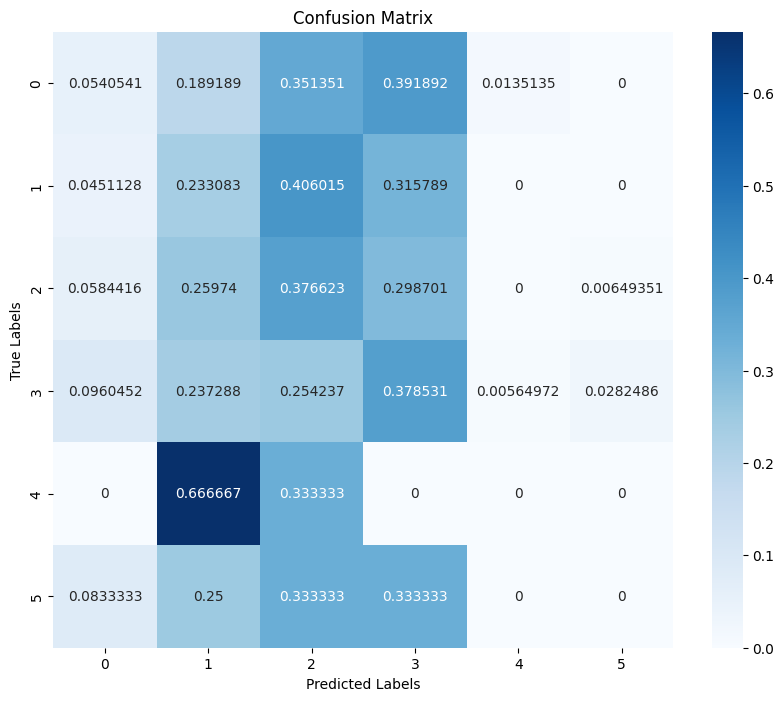

Epoch 5, Validation Loss: 2.9721, Accuracy: 0.2773, F1 Score: 0.2605
Val F1 Score Per Class  [0.07079646 0.22878229 0.33142857 0.35924933 0.         0.        ]


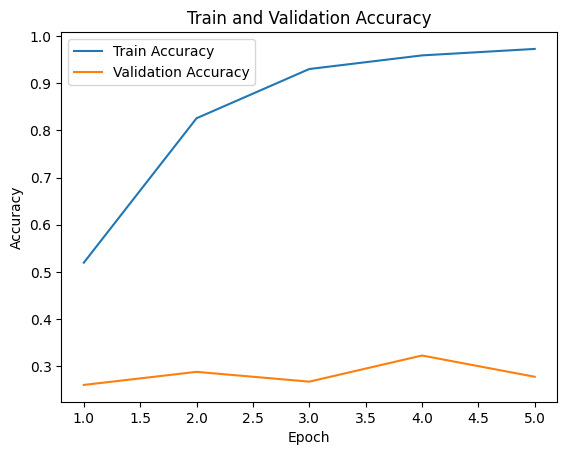

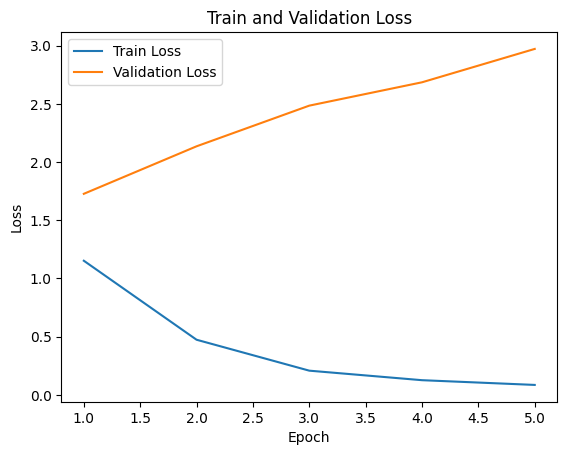

Epoch 6, Train Loss: 0.0727, Accuracy: 0.9774, F1 Score: 0.9774
Train F1 Score Per Class  [0.9846061  0.96582734 0.96516207 0.95588235 0.99941176 0.99338942]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.42it/s, loss=3.02]

[tensor([ 0.1423, -0.9988, -2.3209,  1.2827, -4.5397, -2.4533], device='cuda:0'), tensor([ 0.1572,  0.1186,  0.5421, -0.0334, -4.3936, -4.6394], device='cuda:0'), tensor([-3.3530,  0.6768, -1.5852,  4.0353, -2.9845, -3.4569], device='cuda:0'), tensor([-1.5679, -0.4597,  5.6997, -1.3548, -3.2702, -2.3324], device='cuda:0'), tensor([-1.3231, -2.1228,  1.4694,  0.2048, -4.1706, -3.5154], device='cuda:0'), tensor([-1.1938,  1.5867,  2.9813, -0.1037, -4.6951, -4.3797], device='cuda:0'), tensor([-1.9280,  0.9368, -0.7109,  0.3412, -3.3913, -3.0404], device='cuda:0'), tensor([-0.7587, -0.2814,  1.6231,  1.9338, -5.3025, -4.6128], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.43it/s, loss=3.74]

[tensor([-2.1256,  4.0065, -0.1389,  0.3059, -3.4073, -3.6054], device='cuda:0'), tensor([-2.9154, -1.1263,  0.5607,  3.9663, -4.5161, -3.6824], device='cuda:0'), tensor([ 2.0997, -2.3600, -0.5372,  0.5214, -3.5210, -3.2003], device='cuda:0'), tensor([-2.5289, -1.4927, -0.7823, -0.2226,  1.5912, -1.9502], device='cuda:0'), tensor([-1.0705,  0.2371, -1.3975,  4.5279, -4.1387, -2.2236], device='cuda:0'), tensor([-1.5070,  1.4446, -0.3728,  0.4398, -5.0783, -4.0798], device='cuda:0'), tensor([-2.4963, -0.0104,  4.1370, -0.9896, -4.2836, -3.0394], device='cuda:0'), tensor([-2.4478, -0.9952, -2.3325,  2.5629, -3.8444,  2.5228], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.39it/s, loss=1.99]

[tensor([-2.6629, -0.5420, -0.1615,  2.5802, -4.4985, -3.7315], device='cuda:0'), tensor([-2.4067, -0.2426,  1.8159,  0.6977, -1.0493, -3.0774], device='cuda:0'), tensor([-2.2475,  2.0681,  3.8749, -1.4371, -4.3717, -3.0937], device='cuda:0'), tensor([-1.6626,  4.1522, -0.2071, -1.2600, -4.1872, -3.5295], device='cuda:0'), tensor([-2.1493,  0.9698, -1.9297,  3.7605, -4.7560, -1.2371], device='cuda:0'), tensor([-1.7418,  2.0348,  0.9160, -1.3803, -4.9022, -4.1780], device='cuda:0'), tensor([-2.3167,  0.4295, -1.1357,  2.6514, -4.3253, -3.2613], device='cuda:0'), tensor([-2.1259,  4.8240, -1.2199, -0.3834, -3.3212, -3.7890], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=3.05]

[tensor([-1.4502,  4.5517, -1.5363, -0.2245, -3.6069, -3.0624], device='cuda:0'), tensor([-2.4603, -0.9852,  2.8869,  2.1852, -4.0263, -3.4232], device='cuda:0'), tensor([-2.9492, -0.1319,  0.6253,  1.0878, -3.9813, -3.4954], device='cuda:0'), tensor([ 3.2112, -0.6343,  0.4061, -0.9561, -4.0163, -2.4092], device='cuda:0'), tensor([-1.8108, -1.5177,  5.3266, -0.8206, -3.5929, -2.7582], device='cuda:0'), tensor([-2.4315, -1.2269, -0.4259,  1.6328, -4.6233, -4.0994], device='cuda:0'), tensor([-1.5566, -0.9741, -0.6690,  3.5901, -4.7316, -0.2453], device='cuda:0'), tensor([ 0.5122,  0.2166, -0.3292,  2.5322, -4.3552, -2.7747], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.40it/s, loss=4.47]

[tensor([-1.9565,  1.9640,  0.8526, -1.4033, -5.2053, -3.5631], device='cuda:0'), tensor([-2.1889, -1.9161, -0.8671,  1.7668, -4.4876,  0.0155], device='cuda:0'), tensor([-2.9304,  1.1375, -0.9135,  0.2948, -4.2679, -2.9561], device='cuda:0'), tensor([-1.6092, -1.0711,  6.2183, -1.3655, -2.3265, -2.2793], device='cuda:0'), tensor([-1.8313, -1.4564,  4.5884, -0.9673, -3.6377, -1.9600], device='cuda:0'), tensor([-2.7227, -1.5777, -0.2574,  3.6988, -3.4874, -1.6706], device='cuda:0'), tensor([-2.3425, -0.3382,  3.9765,  0.3847, -4.8499, -3.5423], device='cuda:0'), tensor([-2.6615,  3.9768,  0.3335, -0.1632, -4.4080, -4.4134], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.39it/s, loss=3.8]

[tensor([-2.5305,  5.3681, -1.9212, -0.0077, -3.0166, -2.9932], device='cuda:0'), tensor([-0.3713,  0.1591, -2.4043,  0.2164, -3.7383, -1.0165], device='cuda:0'), tensor([-2.1695,  1.1575, -1.6069, -0.8036, -4.2961, -1.7478], device='cuda:0'), tensor([-2.5361,  0.4046, -2.1595,  1.5147, -4.4225, -3.3860], device='cuda:0'), tensor([-1.6523, -2.4283,  0.1809,  2.3378, -4.5077,  1.0582], device='cuda:0'), tensor([-2.4060, -0.0515,  4.2636, -1.2386, -3.7698, -3.4914], device='cuda:0'), tensor([-3.9268,  1.4592,  0.0691, -0.8049, -4.6589, -3.2952], device='cuda:0'), tensor([-3.0804,  3.3981, -0.8175,  0.0840, -4.2653, -2.6883], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.39it/s, loss=1.6]

[tensor([-1.9503, -0.4079,  2.9295, -1.0150, -4.4536, -3.0288], device='cuda:0'), tensor([-1.6329, -2.3923,  1.1674,  0.0139, -4.1033, -2.6815], device='cuda:0'), tensor([-1.9959, -0.1258, -1.3989,  4.1033, -4.0037, -0.8164], device='cuda:0'), tensor([-1.3277,  2.8416, -0.4094, -1.5715, -2.7171, -2.5300], device='cuda:0'), tensor([-2.0829,  0.2936,  2.3209,  0.6412, -3.7907, -3.3586], device='cuda:0'), tensor([-2.8983, -1.2434, -1.4762,  2.9134, -3.3103,  0.3221], device='cuda:0'), tensor([-2.9970, -0.8403, -0.8101,  3.9038, -4.5479, -2.1583], device='cuda:0'), tensor([-1.1356, -1.1836,  6.0993, -1.5976, -2.4617, -2.1474], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=3.55]

[tensor([-3.4191,  2.1777, -1.0479,  0.9792, -2.5235, -2.8515], device='cuda:0'), tensor([-2.0820,  3.2078, -1.6723,  0.2893, -2.7097, -1.6437], device='cuda:0'), tensor([ 0.6955, -0.1030, -1.5491, -0.4043, -5.0587, -0.4416], device='cuda:0'), tensor([-1.9780, -0.5773, -0.5816,  5.2766, -4.1979, -2.6474], device='cuda:0'), tensor([-3.7205,  2.2400, -1.9133,  2.0078, -4.1666, -1.2818], device='cuda:0'), tensor([-2.4307, -2.7204, -1.0891,  2.4894, -3.8124, -1.8527], device='cuda:0'), tensor([-1.7544, -1.7787,  2.3136,  1.8396, -4.8267, -3.2009], device='cuda:0'), tensor([-3.2573, -0.8208, -0.1031,  5.1452, -3.6783, -2.0839], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=2.55]

[tensor([-2.9961,  4.0147, -1.2523,  1.2065, -5.1260, -2.5144], device='cuda:0'), tensor([-2.8415, -1.2844,  0.5195,  3.6729, -3.2030, -2.9263], device='cuda:0'), tensor([ 3.7968, -2.1619, -1.1720,  2.6368, -4.1336, -2.8319], device='cuda:0'), tensor([-2.4794,  0.4329, -1.1554,  3.2661, -5.3055, -2.9526], device='cuda:0'), tensor([-2.7856, -1.4677,  3.3944,  1.4827, -4.5036, -3.4049], device='cuda:0'), tensor([-1.9082, -0.8046, -1.2336,  2.9911, -4.4910, -2.4447], device='cuda:0'), tensor([-3.2939, -0.3928,  0.9877,  0.5030, -4.6504, -1.7388], device='cuda:0'), tensor([-2.2598, -2.2219,  0.5445,  3.7882, -4.7471, -2.3734], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.38it/s, loss=4.19]

[tensor([-0.3522, -1.5732, -1.4366,  0.5294, -4.7376, -3.7982], device='cuda:0'), tensor([-3.0098, -1.2537, -1.7223,  3.5150, -3.9147, -3.0688], device='cuda:0'), tensor([-2.3944,  0.3072,  0.6391, -0.2421, -4.1351, -3.9738], device='cuda:0'), tensor([-3.0502, -0.4600,  3.8181, -0.4439, -4.6666, -4.0577], device='cuda:0'), tensor([-1.7553,  4.4025,  1.9403, -2.0122, -3.7333, -3.3544], device='cuda:0'), tensor([-3.1668, -0.0822, -1.3917,  3.4756, -4.4008, -2.9148], device='cuda:0'), tensor([-0.8595,  1.9541, -1.4876,  0.7525, -4.3077, -4.0692], device='cuda:0'), tensor([-2.4623,  1.3176, -0.4095,  1.7438, -5.1353, -3.3878], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=2.72]

[tensor([-2.4697,  5.4714, -1.0943, -0.1379, -2.8708, -3.3449], device='cuda:0'), tensor([-2.6064,  0.6093, -0.1687,  2.0267, -3.7427, -2.7699], device='cuda:0'), tensor([-3.2238, -0.0714, -1.1081,  2.3604, -4.4764, -3.1510], device='cuda:0'), tensor([-2.7608, -0.6516, -1.2950,  4.5588, -4.0569, -0.9798], device='cuda:0'), tensor([-2.6076,  0.4866,  4.1877,  0.1792, -4.7369, -4.0307], device='cuda:0'), tensor([-1.9044, -0.3944, -0.5266,  3.0027, -4.8941, -3.1495], device='cuda:0'), tensor([ 0.8430, -1.3503,  1.5699, -0.4967, -4.5685, -2.5130], device='cuda:0'), tensor([-3.0774,  0.3603,  1.0850,  1.2915, -4.2123, -2.3575], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=2.33]

[tensor([-1.9893,  1.3396, -0.5650, -0.8242, -4.0225, -4.2517], device='cuda:0'), tensor([-3.5406,  0.0260, -0.1613, -1.4408, -3.9520, -1.9169], device='cuda:0'), tensor([-2.1435, -1.3497, -1.8155,  2.9604, -4.9984, -1.6943], device='cuda:0'), tensor([-1.0191, -1.9610,  3.2631, -0.1837, -4.6669, -1.4916], device='cuda:0'), tensor([-1.4520,  1.0853, -0.6057,  0.4715, -4.9199, -3.8246], device='cuda:0'), tensor([-2.6911e+00,  1.8955e+00,  1.8469e-01, -2.4810e-03, -4.1889e+00,
        -3.7207e+00], device='cuda:0'), tensor([-2.7228,  0.8890,  3.6125, -0.5098, -3.7921, -3.0499], device='cuda:0'), tensor([-1.9484, -1.9028,  4.5271, -0.4603, -3.8464, -3.2512], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.38it/s, loss=2.81]

[tensor([-2.7917,  2.0292, -2.1339,  1.5287, -3.0016, -1.5760], device='cuda:0'), tensor([-2.7596, -0.2470,  0.7491,  1.2194, -4.7217, -3.5973], device='cuda:0'), tensor([-0.6220, -0.5964, -3.2621,  2.2864, -3.5872, -3.1446], device='cuda:0'), tensor([-3.3580,  0.4192,  1.3669,  3.3493, -5.1530, -3.5199], device='cuda:0'), tensor([-2.7334,  0.1138, -0.5555,  1.3763, -3.9460, -3.9953], device='cuda:0'), tensor([-0.6469, -2.0166, -0.1120,  3.0340, -4.4368, -3.9358], device='cuda:0'), tensor([-3.0566,  2.0488,  1.1326, -0.0224, -4.5640, -2.9886], device='cuda:0'), tensor([-2.3099,  4.3283, -0.7132,  0.5922, -4.5916, -2.5902], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.38it/s, loss=2.33]

[tensor([-2.0803,  1.8288,  1.6077, -0.5364, -4.1724, -4.8965], device='cuda:0'), tensor([-1.8855,  2.0633, -2.4000,  1.1440, -4.2656, -4.1755], device='cuda:0'), tensor([-0.6172,  0.5163, -1.2086,  0.3166, -4.4489, -4.9504], device='cuda:0'), tensor([-0.6757, -2.1670,  3.2756,  0.2390, -3.8800, -3.2619], device='cuda:0'), tensor([-3.1311,  2.8032, -1.2199,  1.2989, -4.1646, -4.2471], device='cuda:0'), tensor([-0.3524,  2.1420, -0.1227, -0.7402, -5.1720, -4.3102], device='cuda:0'), tensor([-2.4569,  2.0274, -0.9300,  1.3428, -4.5366, -3.6468], device='cuda:0'), tensor([-2.6379,  2.7475, -2.0715,  1.6319, -3.9555, -3.4674], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.38it/s, loss=1.99]

[tensor([ 2.9360, -0.8031, -0.8636,  0.4006, -4.3785, -4.3908], device='cuda:0'), tensor([-3.7011,  1.7023, -1.3241,  0.2556, -3.6610, -2.8014], device='cuda:0'), tensor([-3.0074, -1.2764,  0.8557,  1.6453, -3.7371, -1.4365], device='cuda:0'), tensor([-2.5045,  3.8281,  0.8206, -1.6479, -3.6916, -3.0057], device='cuda:0'), tensor([-2.3560,  1.6576,  2.5926, -1.9526, -3.1619, -2.9920], device='cuda:0'), tensor([ 1.1234, -2.0295, -0.2074,  0.5777, -4.1789, -2.9521], device='cuda:0'), tensor([-2.0803, -0.6624, -1.6179,  3.1846, -2.8528, -2.0728], device='cuda:0'), tensor([-2.6371,  0.4184,  0.3985,  1.6942, -4.0738, -3.8868], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=2.84]

[tensor([-1.4528,  0.1991, -0.5080,  3.4767, -4.3441, -3.0080], device='cuda:0'), tensor([-2.4971,  1.4151, -1.7382,  0.9628, -5.1322, -3.5058], device='cuda:0'), tensor([-3.0940,  0.4221,  0.0311, -1.4437, -4.4399, -0.0560], device='cuda:0'), tensor([-0.2228, -3.1200,  2.5450,  2.2421, -4.2098, -2.8013], device='cuda:0'), tensor([-0.0999, -0.9895,  5.0508, -1.2033, -2.9483, -2.8557], device='cuda:0'), tensor([-1.1620,  0.9687, -1.4659,  0.9438, -4.8953, -4.2020], device='cuda:0'), tensor([-1.6454, -1.2696, -0.4193,  2.9928, -5.0419, -2.1487], device='cuda:0'), tensor([ 4.4621, -0.8002, -2.1594, -0.2565, -3.0530, -1.2560], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=3.54]

[tensor([-1.3482,  4.7851, -0.0449, -0.6874, -4.7719, -3.9466], device='cuda:0'), tensor([-2.2416,  3.3383, -1.7626,  2.5016, -4.3302, -4.1140], device='cuda:0'), tensor([-4.0125,  0.2564, -0.3585,  1.2348, -4.1551, -1.8725], device='cuda:0'), tensor([-2.5303,  2.1308,  1.4313, -0.9027, -4.2581, -3.7566], device='cuda:0'), tensor([ 3.2570, -0.3264, -0.1837, -1.5192, -3.9550, -3.7521], device='cuda:0'), tensor([ 1.7123, -0.3524,  2.0794, -0.7565, -4.8606, -4.5634], device='cuda:0'), tensor([-1.4331, -1.6810,  1.5084,  2.9448, -5.2608, -3.0791], device='cuda:0'), tensor([-1.7554, -1.2488,  0.7553, -0.0669, -4.4835, -3.4933], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.35it/s, loss=2.51]

[tensor([-2.7824, -0.8408, -0.9316,  4.4270, -3.9841, -2.0896], device='cuda:0'), tensor([-2.5834, -0.3372,  1.7700,  0.0961, -1.4551, -3.4855], device='cuda:0'), tensor([-2.7044,  3.1123, -0.4457,  0.2499, -3.8848, -3.6231], device='cuda:0'), tensor([-2.9880, -2.1491,  3.6730,  1.5987, -4.3014, -3.8579], device='cuda:0'), tensor([-2.4221,  2.7818, -1.4879,  0.8370, -3.7015, -0.6929], device='cuda:0'), tensor([ 2.7880,  1.5354, -2.2800, -0.4410, -3.8226, -2.8457], device='cuda:0'), tensor([-1.2585, -0.6829, -1.3256,  2.7813, -4.2646, -3.5150], device='cuda:0'), tensor([-0.7343,  2.3027, -0.5085, -0.0879, -5.0194, -3.6058], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:23,  2.31it/s, loss=2.3]

[tensor([-3.7973,  0.4699, -0.3840,  2.5918, -2.7567, -1.9154], device='cuda:0'), tensor([-3.2916,  0.8012, -1.9413,  2.4164, -1.9936, -2.6272], device='cuda:0'), tensor([-0.9735, -1.9779,  4.2968, -1.2729, -4.1275, -2.2821], device='cuda:0'), tensor([-3.3027,  1.0637, -0.1255,  1.8978, -2.9024, -3.7275], device='cuda:0'), tensor([-2.8934,  4.3560,  0.8431, -0.2275, -4.0869, -3.1077], device='cuda:0'), tensor([-2.9321,  3.0337, -0.2584,  0.1600, -4.1376, -3.3683], device='cuda:0'), tensor([-2.7625, -0.4826,  0.8575,  1.3363, -4.8924, -2.7323], device='cuda:0'), tensor([ 3.6933, -0.9471, -1.4312,  0.8434, -3.1298, -3.4654], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.32it/s, loss=2.4]

[tensor([-2.4674,  4.4700, -0.6803, -1.0670, -3.8014, -2.7153], device='cuda:0'), tensor([-2.3131,  0.8037, -0.0643,  2.8884, -4.6925, -2.7818], device='cuda:0'), tensor([-2.4718,  0.0525,  2.9279, -0.2609, -4.5509, -3.3051], device='cuda:0'), tensor([-2.0622,  1.4960,  1.7442, -1.6109, -4.6889, -3.1177], device='cuda:0'), tensor([-2.7271, -0.5828, -0.9257,  4.9745, -3.8257, -2.4605], device='cuda:0'), tensor([-3.5844,  1.9283,  1.8851, -1.1447, -5.0759, -2.4852], device='cuda:0'), tensor([-1.7951,  0.7057,  1.8740, -0.7074, -4.0195, -2.7678], device='cuda:0'), tensor([-2.4446,  4.4725, -0.5391, -0.1332, -2.6416, -3.3163], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:22,  2.33it/s, loss=3.66]

[tensor([-2.0067, -0.7658,  4.9372, -1.1314, -3.9245, -3.1727], device='cuda:0'), tensor([-1.9642,  3.4863, -0.1224,  0.2082, -4.1844, -4.0123], device='cuda:0'), tensor([-2.6184,  1.1622,  0.7016,  0.5673, -4.4516, -4.3655], device='cuda:0'), tensor([-1.8806,  0.0317,  0.4712,  1.7059, -4.5106, -4.0762], device='cuda:0'), tensor([-2.3586,  4.3196, -2.1138, -0.6030, -3.1614, -0.7578], device='cuda:0'), tensor([-2.5716, -1.4179, -0.9670,  1.5396, -4.6118, -3.5913], device='cuda:0'), tensor([-0.7658,  5.0639,  0.4293, -1.9032, -3.1961, -2.9979], device='cuda:0'), tensor([-0.9771,  3.3366, -0.7549, -1.5550, -2.1149, -3.5625], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:22,  2.31it/s, loss=2.26]

[tensor([-0.1847, -2.1075,  3.4718, -0.2557, -4.2113, -2.2749], device='cuda:0'), tensor([-1.6550, -2.3120,  0.0648,  3.2068, -4.2539, -3.2013], device='cuda:0'), tensor([-1.6930,  4.9803, -1.4159, -0.5636, -3.8878, -3.7537], device='cuda:0'), tensor([-2.3780, -1.0345, -1.0026,  3.9691, -3.7399, -1.2543], device='cuda:0'), tensor([-3.0369,  0.3879, -0.8688,  0.8434, -4.4122, -3.6216], device='cuda:0'), tensor([-0.5808, -2.0505,  2.2306,  0.9588, -4.8074, -2.5824], device='cuda:0'), tensor([-1.1751, -2.2575, -0.6067,  5.3299, -3.8819, -1.8058], device='cuda:0'), tensor([-0.7979, -0.4621,  4.6192, -1.0943, -4.4438, -3.0050], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.28it/s, loss=3.89]

[tensor([-2.0425, -1.3862, -0.5631,  0.4031, -4.3166, -3.2477], device='cuda:0'), tensor([-1.5301,  0.1404,  4.0798, -1.2694, -3.6830, -3.3501], device='cuda:0'), tensor([-1.1903, -0.2557, -0.9636,  2.2004, -4.6766, -3.8752], device='cuda:0'), tensor([-1.7442,  5.2287, -1.1718, -1.3051, -2.4985, -2.2666], device='cuda:0'), tensor([-2.6644, -1.1852,  2.0925,  0.8888, -5.0428, -4.3878], device='cuda:0'), tensor([-2.0195,  5.0076, -1.4057, -0.5677, -2.9785, -1.7172], device='cuda:0'), tensor([-1.4315, -1.5453, -1.0021, -0.6679, -4.2412,  1.9411], device='cuda:0'), tensor([-1.4666,  5.7081, -1.3496, -0.5323, -3.5988, -2.9512], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:21,  2.28it/s, loss=2.44]

[tensor([-2.0924, -2.3179,  3.5611,  0.8276, -3.9944, -3.6063], device='cuda:0'), tensor([-2.4624,  0.1894, -0.2059,  2.5809, -3.7959, -3.9248], device='cuda:0'), tensor([-2.5378, -0.2538, -0.1817,  1.5500, -4.6217, -3.8731], device='cuda:0'), tensor([-3.2789,  0.1772, -1.4980,  2.4167, -3.9348, -2.8683], device='cuda:0'), tensor([-1.7528, -1.2602, -2.0021,  4.4383, -4.3771, -1.4153], device='cuda:0'), tensor([-1.8701,  3.7466, -2.2976,  1.5018, -4.1480, -3.6752], device='cuda:0'), tensor([-1.3261, -0.5891, -1.3869, -1.2417, -1.7717, -1.5089], device='cuda:0'), tensor([-1.7654,  0.3419, -1.2240,  2.6984, -4.3430, -3.7676], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:21,  2.28it/s, loss=3.07]

[tensor([-2.4017, -0.3493,  3.9550,  0.5419, -4.9070, -3.2350], device='cuda:0'), tensor([-2.9727,  2.0193,  2.3620,  0.1091, -4.4906, -3.4933], device='cuda:0'), tensor([-2.2858,  1.3247, -1.1309,  1.2888, -4.9226, -2.1327], device='cuda:0'), tensor([-2.3632,  4.2790, -1.1986,  0.4002, -4.0726, -4.2101], device='cuda:0'), tensor([-3.1017, -0.8782, -1.6323,  0.8356, -4.3782, -3.0317], device='cuda:0'), tensor([-2.2233, -0.4674, -0.7921,  2.0719, -4.5068, -2.5812], device='cuda:0'), tensor([-1.2354, -0.5624, -2.4789,  4.9054, -3.1373, -3.8112], device='cuda:0'), tensor([-3.2811,  0.1655, -0.7182, -0.0747, -4.4587, -3.0330], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:11<00:20,  2.32it/s, loss=1.24]

[tensor([-3.3739,  0.8540, -1.6955,  2.0451, -3.9200, -0.0820], device='cuda:0'), tensor([-1.5740, -0.8615,  0.9133,  1.1189, -5.8875, -2.6969], device='cuda:0'), tensor([-1.3647, -2.0053,  4.3830, -1.2281, -3.3359, -1.9197], device='cuda:0'), tensor([ 0.3906,  2.8357, -0.7296, -1.3204, -3.7952, -2.8165], device='cuda:0'), tensor([-2.5491,  3.4421, -1.0817,  1.3688, -4.6503, -2.9601], device='cuda:0'), tensor([ 0.7258, -2.9103,  1.1687,  2.4551, -4.0798, -1.0309], device='cuda:0'), tensor([-0.5167,  0.9423, -0.7016, -0.7975, -4.8213, -3.9053], device='cuda:0'), tensor([-1.3163, -0.2662,  4.9116, -1.7010, -4.0574, -3.1402], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.32it/s, loss=2.73]

[tensor([-2.7999,  3.2661, -1.3876,  1.8049, -3.9233, -2.4559], device='cuda:0'), tensor([-2.8869, -1.5415,  2.9094,  0.1792, -3.4193, -2.7197], device='cuda:0'), tensor([ 1.8593, -0.6964, -0.5837,  0.6545, -4.6813, -3.9623], device='cuda:0'), tensor([-2.7652, -0.6074, -0.0101,  0.8687, -4.6320, -3.5261], device='cuda:0'), tensor([-1.1281,  2.2113, -0.7616, -1.4477, -3.9493, -3.2707], device='cuda:0'), tensor([-0.9827, -0.2512,  0.6437,  1.2582, -5.2490, -3.8476], device='cuda:0'), tensor([-2.6235, -0.7825,  1.4707,  0.1653, -4.0425, -3.0515], device='cuda:0'), tensor([-3.3026,  2.5581, -2.5876,  1.4364, -4.1323, -2.8078], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:19,  2.35it/s, loss=3.29]

[tensor([ 0.6847, -2.0984, -0.2209,  3.2951, -4.8870, -2.7543], device='cuda:0'), tensor([-1.7849,  0.7506, -1.6533,  2.0544, -4.6923, -3.5743], device='cuda:0'), tensor([-1.4698,  3.9970, -1.5295, -1.3075, -3.3466, -2.4172], device='cuda:0'), tensor([-2.4641, -1.0374,  4.4771,  1.1495, -4.0118, -3.3656], device='cuda:0'), tensor([-2.4990, -0.4919, -1.1920,  5.6248, -3.5234, -2.2156], device='cuda:0'), tensor([-3.2945,  1.5880,  0.7805,  2.8945, -4.5631, -4.0679], device='cuda:0'), tensor([-1.5958, -1.1977,  2.2627, -0.6083, -4.3832, -3.5612], device='cuda:0'), tensor([-2.0564,  2.3763, -0.2779, -1.8699, -4.3191, -3.5249], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.32it/s, loss=3.78]

[tensor([-2.9290, -0.4761, -1.3472,  4.1411, -4.1431, -3.1023], device='cuda:0'), tensor([-2.7218,  3.3332, -0.2545, -1.1989, -3.2493, -2.3327], device='cuda:0'), tensor([-2.8126, -1.9920,  4.5026,  0.3189, -4.4394, -2.5866], device='cuda:0'), tensor([-2.9987, -1.1108, -0.0698,  4.0871, -4.1799, -3.2065], device='cuda:0'), tensor([ 0.6451,  2.5770, -1.3659, -1.6187, -4.2212, -2.6726], device='cuda:0'), tensor([-2.6181, -1.1330,  2.0339, -0.6907, -4.4943, -2.1187], device='cuda:0'), tensor([-2.8360,  0.7439,  0.4296,  2.9345, -5.7365, -2.7126], device='cuda:0'), tensor([-3.7509, -1.6531,  0.0071,  1.9365, -3.8657, -2.9912], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.34it/s, loss=3.04]

[tensor([-3.2904,  4.4484, -0.9350, -0.2769, -4.2734, -2.5692], device='cuda:0'), tensor([ 0.4064,  2.5720, -1.3011,  0.4957, -4.0933, -4.1471], device='cuda:0'), tensor([-2.2303,  0.6528, -0.9650, -1.4684, -2.6925, -2.2702], device='cuda:0'), tensor([-2.1336,  1.3163, -1.5323,  0.1796, -3.8434, -2.9876], device='cuda:0'), tensor([ 0.0982,  0.9697, -1.5767, -0.9398, -4.5232, -3.4897], device='cuda:0'), tensor([-0.2476, -1.2200,  1.9155, -1.0764, -3.1679, -3.2890], device='cuda:0'), tensor([-2.4803, -0.9581,  0.6195,  2.4677, -5.2050, -3.8310], device='cuda:0'), tensor([-1.4807, -0.5917, -1.2332, -1.4866, -2.8320,  5.2738], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:18,  2.33it/s, loss=2.25]

[tensor([-1.9677,  0.4923, -2.2630,  4.0668, -4.1284, -2.5286], device='cuda:0'), tensor([-1.8492, -0.8841, -1.8147,  3.1519, -4.1740, -1.6697], device='cuda:0'), tensor([-3.2890,  1.6770,  2.2382, -0.6280, -3.4322, -2.2224], device='cuda:0'), tensor([-1.5896,  4.6366, -1.0249, -1.1566, -4.0880, -2.6159], device='cuda:0'), tensor([-2.2479,  1.5363,  2.1638, -1.6737, -3.7171, -3.1866], device='cuda:0'), tensor([ 3.5686,  1.9630, -2.0268, -1.5618, -2.7722, -2.4047], device='cuda:0'), tensor([-2.7282, -0.9364,  3.7925, -0.2445, -4.2677, -4.0823], device='cuda:0'), tensor([-2.3224,  2.0873,  1.7567,  0.3080, -4.5467, -4.1563], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.36it/s, loss=4.59]

[tensor([-3.5869,  1.4716, -0.9571,  0.5317, -3.7670, -2.0655], device='cuda:0'), tensor([-2.7803, -0.8556, -1.2236,  5.5166, -3.9288, -1.9737], device='cuda:0'), tensor([-1.8363,  4.0381, -0.5738, -0.5007, -3.3859, -3.7941], device='cuda:0'), tensor([-2.2962,  2.7964,  0.2457,  0.3247, -3.8142, -3.2191], device='cuda:0'), tensor([-2.8732, -0.0816, -0.1840,  2.2217, -3.9192, -2.4029], device='cuda:0'), tensor([-1.2594, -1.9550,  4.9399, -0.0434, -4.3845, -3.2649], device='cuda:0'), tensor([ 5.5459, -0.9365, -0.7587, -0.2250, -3.5789, -2.3314], device='cuda:0'), tensor([ 0.6408, -1.4665,  3.4173, -0.1074, -4.9310, -3.6733], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:14<00:16,  2.36it/s, loss=4.12]

[tensor([-2.3511, -2.3270,  2.1212,  0.3177, -3.7123, -1.2007], device='cuda:0'), tensor([-2.8842,  4.9707, -1.4322,  0.4985, -3.0867, -1.4284], device='cuda:0'), tensor([-0.2363,  0.0285, -0.1282, -0.4775, -4.8066,  1.1807], device='cuda:0'), tensor([ 1.1315,  3.3450, -0.1425, -2.1018, -3.4459, -3.8026], device='cuda:0'), tensor([-1.6589, -1.1035,  5.9269, -1.1018, -2.7264, -2.6641], device='cuda:0'), tensor([-2.3732, -0.4455,  3.0653,  0.5182, -4.6939, -3.8053], device='cuda:0'), tensor([ 2.7531, -0.9270, -1.2954,  1.0656, -4.8145, -3.5276], device='cuda:0'), tensor([-3.3814, -0.1244, -1.5639,  3.0397, -3.7176, -2.2432], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=3.16]

[tensor([ 3.0127,  0.7301, -2.4133, -0.5431, -2.8824, -3.0590], device='cuda:0'), tensor([-0.2039,  0.6973, -1.1199,  0.4046, -4.5273, -4.3445], device='cuda:0'), tensor([ 1.6806,  2.1869, -1.7120, -0.4566, -1.0089, -3.2478], device='cuda:0'), tensor([-2.6562, -1.5013, -1.0563,  1.6147, -4.6852, -2.3819], device='cuda:0'), tensor([-3.0301,  2.5088, -1.6750,  1.0074, -3.5611, -2.4759], device='cuda:0'), tensor([-2.6514,  2.6485,  1.3647, -0.3732, -4.6058, -3.1696], device='cuda:0'), tensor([-1.7472, -1.9123, -0.9208,  3.0421, -4.6097, -2.6593], device='cuda:0'), tensor([-1.9901, -0.5655,  5.9581, -1.4556, -2.9717, -2.9720], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=2.22]

[tensor([-1.5343,  2.9744, -0.4203, -0.7363, -4.2361, -4.3228], device='cuda:0'), tensor([-1.5968,  0.5781,  0.8864,  1.2622, -5.1570, -3.8320], device='cuda:0'), tensor([-1.8995,  0.4492, -0.9032,  3.4485, -4.1273, -3.4875], device='cuda:0'), tensor([-3.1004,  2.3868,  2.0600,  0.3445, -4.2070, -3.6726], device='cuda:0'), tensor([-2.3188,  4.4112, -0.9708,  0.6654, -4.3864, -3.4575], device='cuda:0'), tensor([-1.0906, -1.7120, -0.9116,  1.8500, -3.9241, -0.0547], device='cuda:0'), tensor([-0.4951, -1.2657,  3.5109, -0.2421, -4.6563, -4.0614], device='cuda:0'), tensor([-1.5160,  2.5657, -0.4230,  1.1493, -4.0166, -4.8858], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:16,  2.24it/s, loss=1.99]

[tensor([-1.8950,  4.0925,  1.9512, -1.8291, -3.9823, -3.2970], device='cuda:0'), tensor([-1.7521, -0.2834,  4.4256, -1.2050, -3.4214, -3.9935], device='cuda:0'), tensor([-2.1639,  2.2436, -0.9209,  0.1091, -3.9263, -1.0415], device='cuda:0'), tensor([-2.4332,  4.6051, -2.0826, -0.0844, -4.7329, -3.1542], device='cuda:0'), tensor([-2.8814, -0.4670, -0.5560,  2.1563, -4.7035, -3.6588], device='cuda:0'), tensor([-2.0803, -0.4880,  0.8468,  1.7272, -5.2125, -4.0530], device='cuda:0'), tensor([-2.6408, -1.3427, -0.3153,  4.0547, -4.4069, -3.8343], device='cuda:0'), tensor([-1.5274,  0.2987,  0.1526,  1.5314, -4.8315, -3.8541], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.27it/s, loss=3.57]

[tensor([ 1.5786, -0.7922, -1.9636,  2.0683, -3.7031, -3.9368], device='cuda:0'), tensor([-1.5795, -1.4281,  0.5682,  1.0333, -4.4571, -3.6420], device='cuda:0'), tensor([-1.7300, -1.5671, -1.1630,  4.1085, -3.6735, -1.4243], device='cuda:0'), tensor([-2.6626,  2.4163,  0.5340, -1.2752, -3.1602, -1.4939], device='cuda:0'), tensor([-0.7913,  2.2365,  1.9780, -1.0948, -4.0099, -2.6792], device='cuda:0'), tensor([-2.4441,  3.6035, -0.3791, -1.4618, -2.9383, -3.2322], device='cuda:0'), tensor([-2.7840,  2.9159, -1.3440,  0.8081, -3.5591, -3.1506], device='cuda:0'), tensor([-3.2337,  2.9566, -0.8550,  3.0414, -3.0437, -3.7465], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:15,  2.27it/s, loss=1.75]

[tensor([-1.6828, -1.0420,  2.9044, -1.7285, -3.7247, -1.0450], device='cuda:0'), tensor([-4.1818, -0.0962, -0.4700,  2.1332, -3.5780,  0.6590], device='cuda:0'), tensor([-0.1401, -1.0013, -0.6212,  1.0042, -4.3392, -3.2109], device='cuda:0'), tensor([-2.8718, -0.4419, -1.7777,  1.5776, -3.1898, -2.3722], device='cuda:0'), tensor([-1.3977, -1.3295,  0.4470,  0.7616, -5.0810, -4.0314], device='cuda:0'), tensor([-2.4779,  5.5337, -1.3092, -0.4616, -2.5885, -2.3200], device='cuda:0'), tensor([-1.2170,  2.2918, -1.2097, -1.1788, -3.7155, -3.5592], device='cuda:0'), tensor([-2.4793,  2.1843,  1.0487,  1.8944, -5.1730, -4.3324], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.28it/s, loss=2.54]

[tensor([-2.1571, -1.0465,  1.8224, -0.4151, -4.7350, -3.6750], device='cuda:0'), tensor([-2.9534,  3.8234,  1.4045, -1.1668, -3.7753, -3.3877], device='cuda:0'), tensor([ 0.0612, -2.4738,  0.0578,  1.4680, -4.5400, -2.4592], device='cuda:0'), tensor([-2.5463, -1.8930,  0.6002,  4.6668, -4.0519, -2.7611], device='cuda:0'), tensor([-2.9869, -1.1016,  1.3619,  2.6500, -4.7815, -3.0440], device='cuda:0'), tensor([-2.4837, -0.6180,  3.2398, -0.3141, -3.1349, -2.8492], device='cuda:0'), tensor([ 1.7546, -1.7549,  2.1342,  0.2781, -3.9775, -2.1887], device='cuda:0'), tensor([-3.3294,  1.2910,  1.9468,  0.6336, -5.2826, -2.1594], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:17<00:14,  2.29it/s, loss=2.28]

[tensor([ 3.9845, -2.4462,  1.1779,  0.6715, -3.8969, -2.7978], device='cuda:0'), tensor([-0.8729, -1.3698,  2.0736, -1.4168, -3.2328, -3.5396], device='cuda:0'), tensor([ 0.0283, -0.0348, -0.4343,  0.2807, -5.3794, -2.9655], device='cuda:0'), tensor([ 3.5248, -1.3940, -2.0363,  2.0226, -4.0307, -3.3006], device='cuda:0'), tensor([-3.4762, -0.2534, -1.7724,  1.6587, -3.6191, -1.6909], device='cuda:0'), tensor([ 2.4591, -2.1296, -0.3939,  2.2080, -4.1361, -3.6420], device='cuda:0'), tensor([-3.1492,  0.1836, -0.6814,  2.3182, -4.1638, -3.0286], device='cuda:0'), tensor([-1.9760, -0.1119, -1.7007,  2.7168, -4.5654, -2.2965], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.30it/s, loss=3.82]

[tensor([-2.4237, -2.1035,  1.2546,  4.4889, -4.1089, -3.1487], device='cuda:0'), tensor([-1.9692,  0.7096,  2.6837,  0.4371, -2.8257, -3.9536], device='cuda:0'), tensor([-2.3837,  5.3035, -1.6244,  0.5257, -3.3317, -2.3209], device='cuda:0'), tensor([-2.4635, -0.0907, -1.0347,  5.3042, -4.3722, -3.1721], device='cuda:0'), tensor([-2.2684,  4.9076, -1.5484,  0.4175, -3.3605, -2.8422], device='cuda:0'), tensor([-2.6585, -0.5214,  2.1191,  2.9618, -4.0852, -3.4402], device='cuda:0'), tensor([-2.9301, -0.1814,  0.6036,  3.9395, -4.6235, -3.7653], device='cuda:0'), tensor([-2.2796,  3.7856,  0.2292,  0.1523, -4.9590, -4.0747], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.30it/s, loss=2.77]

[tensor([ 0.6228, -2.0284, -0.9304,  2.5609, -3.5551, -3.3918], device='cuda:0'), tensor([ 1.1007, -1.4153, -1.5367,  2.3133, -2.8014, -0.9812], device='cuda:0'), tensor([-2.0360, -1.1132, -0.8026,  1.7306, -4.7821, -2.5565], device='cuda:0'), tensor([-0.5636, -0.8866, -1.8409,  0.6667, -3.4904, -2.2526], device='cuda:0'), tensor([-3.5672, -0.4258, -0.1438,  4.1422, -3.0612, -2.5517], device='cuda:0'), tensor([-2.1186, -0.7455,  0.7116,  2.7741, -5.2127, -4.3782], device='cuda:0'), tensor([-2.6596,  0.1834, -0.5426,  4.5796, -4.4615, -2.7411], device='cuda:0'), tensor([ 3.2920, -1.9668,  0.1679,  1.0553, -4.0295, -4.1021], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:13,  2.29it/s, loss=1.76]

[tensor([-3.0214,  3.8070, -1.1274,  0.7767, -4.0185, -3.3550], device='cuda:0'), tensor([-1.0869,  0.1230,  2.5617, -0.1055, -4.8609, -4.2037], device='cuda:0'), tensor([-1.1419,  0.7248, -2.4241,  0.1329, -4.2937, -1.7825], device='cuda:0'), tensor([-2.4089,  1.1273, -1.7455,  2.5225, -4.6339, -0.1239], device='cuda:0'), tensor([-3.2224,  2.8704, -1.4957,  1.5564, -4.6072, -3.6070], device='cuda:0'), tensor([-2.8748,  0.7688,  4.0640, -0.5409, -3.9431, -3.4199], device='cuda:0'), tensor([-2.8234, -1.3459,  3.5397, -0.6917, -4.1087, -2.9607], device='cuda:0'), tensor([-2.6337,  1.6982, -1.1962,  0.1001, -4.6935, -3.3687], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.29it/s, loss=3.01]

[tensor([-2.6936, -0.7874,  0.0743,  4.9745, -2.8451, -2.9879], device='cuda:0'), tensor([ 0.0936,  0.7397, -0.3287,  1.2214, -5.1835, -3.5171], device='cuda:0'), tensor([-0.7529,  0.8495, -1.8971,  0.8136, -4.3314, -2.9644], device='cuda:0'), tensor([-1.9772, -1.2368, -1.5868, -0.5485, -2.2791,  6.3542], device='cuda:0'), tensor([-2.9555,  2.2921, -1.7968,  1.2089, -3.5341, -3.0401], device='cuda:0'), tensor([-1.9721,  0.1077, -2.4291,  0.9803, -4.5928, -2.3630], device='cuda:0'), tensor([-0.5620, -0.0325, -0.5748,  0.5432, -5.3203, -4.0044], device='cuda:0'), tensor([-3.4560,  2.0740,  0.2218,  2.5933, -4.4850, -3.4899], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:19<00:12,  2.31it/s, loss=4.34]

[tensor([ 2.0582, -0.1324,  0.2305, -0.7458, -3.9620, -3.2645], device='cuda:0'), tensor([-2.2205,  5.4921, -0.4545, -1.6353, -2.7839, -2.2958], device='cuda:0'), tensor([-1.3800,  5.6567, -1.7957, -0.3072, -3.5249, -3.1565], device='cuda:0'), tensor([-2.1455,  5.8432, -0.8966, -0.5111, -3.3843, -3.2940], device='cuda:0'), tensor([-2.1987, -2.0305,  0.4830,  4.1078, -4.7563, -1.5270], device='cuda:0'), tensor([ 0.6472, -0.6236, -0.5754,  1.0179, -4.6846, -2.2240], device='cuda:0'), tensor([-0.2355, -0.8426, -1.3709, -2.5776,  4.2859, -1.8052], device='cuda:0'), tensor([-3.7280,  0.5870,  0.5217,  1.7499, -5.0190, -3.4783], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.30it/s, loss=3.6]

[tensor([-1.2849, -1.3852,  0.3529,  2.1336, -4.9105, -4.0793], device='cuda:0'), tensor([-2.3206, -1.5211,  1.2202,  0.1279, -4.5557, -3.2089], device='cuda:0'), tensor([-2.5777,  1.5465, -1.1333,  0.4753, -4.9666, -2.8236], device='cuda:0'), tensor([-1.3833, -1.3532, -1.2286,  4.2188, -4.8303, -1.6968], device='cuda:0'), tensor([-2.9595, -0.2549,  1.7535,  0.6700, -4.1381, -4.4186], device='cuda:0'), tensor([-2.2771, -1.6917, -0.9017,  4.3820, -3.9996, -2.8468], device='cuda:0'), tensor([-1.6544, -2.3501,  0.0551,  4.3468, -4.0488, -2.9384], device='cuda:0'), tensor([-1.1493, -1.2941,  1.0982,  2.0296, -5.4096, -3.4224], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:20<00:11,  2.30it/s, loss=2.45]

[tensor([-4.2038, -0.6042,  0.4798,  0.8447, -2.6340,  1.0842], device='cuda:0'), tensor([ 2.2626, -2.1111,  0.6332,  1.5389, -4.5275, -2.9242], device='cuda:0'), tensor([-0.3708,  1.0951,  0.7439, -0.1018, -4.9308, -4.4855], device='cuda:0'), tensor([-2.4315, -1.6914,  4.3065,  0.0597, -4.5166, -3.1707], device='cuda:0'), tensor([-3.6739,  0.3114, -0.5874, -0.1808, -3.6594, -3.5536], device='cuda:0'), tensor([-0.5521, -1.5117, -1.5552,  0.3296, -5.1995,  1.1073], device='cuda:0'), tensor([-4.3290,  0.1364, -0.3785,  0.8013, -3.4972, -1.4024], device='cuda:0'), tensor([-1.4951,  1.9760, -1.6307,  0.7353, -5.1872, -2.6126], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:11,  2.26it/s, loss=3.68]

[tensor([ 0.5921, -2.2547,  0.8046,  1.9653, -4.7845, -2.9492], device='cuda:0'), tensor([-2.7686,  2.2189, -1.5523,  0.3024, -3.9008, -0.2907], device='cuda:0'), tensor([ 4.7049, -0.9597, -1.1692, -1.2651, -3.1631, -1.5394], device='cuda:0'), tensor([-1.5355,  3.7241, -0.4398, -0.5312, -4.0423, -3.9227], device='cuda:0'), tensor([ 3.8336, -1.1675, -1.6442,  2.5745, -4.1996, -2.9282], device='cuda:0'), tensor([-3.0257, -1.0446,  0.0076,  3.1981, -4.7103, -3.9654], device='cuda:0'), tensor([-3.4274,  2.7651, -1.2882,  2.7063, -3.9085, -3.3107], device='cuda:0'), tensor([-0.6772, -2.0576, -0.4938,  4.1246, -4.6514, -2.3899], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:21<00:10,  2.28it/s, loss=2.61]

[tensor([-2.5472,  2.2958,  2.5423, -0.1118, -3.9456, -4.1389], device='cuda:0'), tensor([-2.4040,  2.7327, -0.1278,  2.3121, -4.7608, -4.2656], device='cuda:0'), tensor([-3.1209, -0.0144, -0.4320,  1.8100, -5.1047, -1.8252], device='cuda:0'), tensor([ 4.2016, -2.2859,  0.7155,  0.1550, -3.7502, -2.6234], device='cuda:0'), tensor([-2.9693,  4.3536,  0.8264, -1.0307, -4.0459, -3.0020], device='cuda:0'), tensor([-2.0574,  4.2131, -1.6621, -0.3182, -2.6787, -1.7949], device='cuda:0'), tensor([-3.4708, -0.3471, -1.1894,  2.1468, -3.9787, -3.0236], device='cuda:0'), tensor([-3.1619,  0.4166, -2.0057,  2.3038, -3.8150, -2.2774], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:10,  2.28it/s, loss=3.01]

[tensor([-2.2282,  1.4305,  0.8605,  1.3622, -4.9854, -3.5616], device='cuda:0'), tensor([-1.8785,  1.5744,  4.5822, -2.1973, -2.7590, -2.4335], device='cuda:0'), tensor([-0.5232,  0.2589, -0.6865,  0.0156, -5.5685, -4.0527], device='cuda:0'), tensor([-1.7184, -0.7503,  3.1170,  1.8135, -4.8639, -3.6906], device='cuda:0'), tensor([-1.2391,  3.7623, -1.1023,  0.3596, -4.6291, -3.5307], device='cuda:0'), tensor([-2.6006,  0.2310,  3.9149, -0.1438, -3.5217, -3.6179], device='cuda:0'), tensor([-2.9676,  3.5721, -0.9134,  0.0207, -3.4054, -2.6912], device='cuda:0'), tensor([ 2.7819, -2.5510,  0.5575,  2.1209, -4.8494, -3.0714], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.28it/s, loss=1.38]

[tensor([-2.1604, -0.1066, -0.3192, -0.3757, -4.5241, -3.2967], device='cuda:0'), tensor([-1.6849, -2.0806,  0.8717,  4.4737, -4.3233, -2.4831], device='cuda:0'), tensor([-1.8718, -1.0732,  0.2207,  2.5260, -4.3114, -4.7638], device='cuda:0'), tensor([-2.0440,  1.7430, -1.1250,  0.3041, -4.6365, -3.4324], device='cuda:0'), tensor([ 0.4484, -2.6860,  0.4225,  2.6177, -4.2957, -2.8655], device='cuda:0'), tensor([-3.1205, -0.2695, -0.4177,  4.3109, -4.1458, -3.1945], device='cuda:0'), tensor([-2.9019,  1.0441,  1.3251,  0.5487, -4.0680, -3.9205], device='cuda:0'), tensor([-2.5269, -1.5996,  0.7977,  3.2083, -4.5106, -2.9671], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:22<00:09,  2.27it/s, loss=3.36]

[tensor([-2.4507,  2.1775, -1.7524,  0.4409, -3.5820, -1.1575], device='cuda:0'), tensor([-1.4348,  1.9568, -1.3841,  1.3807, -5.2888, -3.5240], device='cuda:0'), tensor([-2.6356,  0.6503, -2.1408,  4.0854, -3.7787, -2.5618], device='cuda:0'), tensor([-2.2636,  1.2872, -1.1219,  0.5591, -2.2348, -3.8931], device='cuda:0'), tensor([-2.8850, -0.9307,  3.1971,  1.1332, -5.0443, -3.9696], device='cuda:0'), tensor([-2.0558, -1.6671,  1.2266,  2.7469, -4.0812, -3.6611], device='cuda:0'), tensor([-2.8441,  0.7687,  0.5415, -0.8041, -3.7340, -3.3585], device='cuda:0'), tensor([-2.0064,  3.4039, -1.2872, -0.8563, -4.1426, -2.9032], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.29it/s, loss=2.25]

[tensor([-2.1256, -2.4430,  1.4187,  2.5703, -4.2624, -2.1259], device='cuda:0'), tensor([-1.9752, -0.4444, -0.5357,  3.9211, -4.5159, -4.2897], device='cuda:0'), tensor([-3.3991, -2.2331, -1.1114, -0.1023, -2.2322,  4.4050], device='cuda:0'), tensor([-0.7983,  1.3427, -0.7368,  1.0110, -5.7167, -3.7796], device='cuda:0'), tensor([-1.6471e+00, -1.1697e+00, -3.9767e-03,  4.2831e-01, -4.9998e+00,
        -3.9944e+00], device='cuda:0'), tensor([-2.8301,  0.3409, -0.8861,  0.1889, -3.6174, -2.6962], device='cuda:0'), tensor([-1.7175, -1.7331,  0.0278,  1.2141, -3.5846, -1.1885], device='cuda:0'), tensor([-0.9909, -1.6462, -0.5085,  4.7774, -4.2720, -2.4962], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:23<00:08,  2.31it/s, loss=2.79]

[tensor([-2.3589,  5.6116, -1.5229, -0.4242, -3.3417, -1.8532], device='cuda:0'), tensor([-3.0803,  2.6034, -1.3920,  1.0148, -4.1641, -4.0119], device='cuda:0'), tensor([ 0.5937, -1.9772,  0.0881,  2.3024, -3.9294, -3.2106], device='cuda:0'), tensor([ 0.9460, -1.2610,  1.2600,  0.4100, -4.6789, -4.0072], device='cuda:0'), tensor([-1.9907, -2.0471, -0.7331,  3.3288, -4.8259, -2.4835], device='cuda:0'), tensor([-2.4540,  0.6992,  1.5868, -1.0837, -3.9447, -2.6309], device='cuda:0'), tensor([-1.7197,  2.6091, -1.7521,  0.6989, -4.1283, -3.4737], device='cuda:0'), tensor([-2.8996,  0.3983, -1.9424,  1.2430, -3.8528, -2.4846], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.33it/s, loss=3.05]

[tensor([ 0.4173, -0.5065, -1.8130,  3.8116, -4.5706, -3.7989], device='cuda:0'), tensor([-1.9258,  4.5297, -1.0402, -1.1746, -4.2346, -2.7968], device='cuda:0'), tensor([-1.4512, -0.3296,  3.2830, -0.1888, -4.0292, -3.5788], device='cuda:0'), tensor([-2.1276, -0.8721,  1.9016,  1.4649, -4.7538, -4.0438], device='cuda:0'), tensor([ 1.0674,  2.8388, -2.2634, -1.1784, -3.4538, -2.7886], device='cuda:0'), tensor([-2.3164, -0.8947,  0.9579,  3.1437, -4.6921, -3.2589], device='cuda:0'), tensor([-3.1498,  3.8515, -0.4294,  0.1528, -4.1505, -4.3286], device='cuda:0'), tensor([-1.7245,  2.5874, -1.4617, -1.4825, -4.4051, -3.2158], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:24<00:07,  2.35it/s, loss=5.21]

[tensor([-2.3238, -1.3935, -0.1841,  4.7535, -4.4502, -3.2981], device='cuda:0'), tensor([-2.4034,  1.4912, -1.2773,  1.6844, -4.7514, -3.6125], device='cuda:0'), tensor([-2.9205, -2.1278,  2.6349,  0.5708, -5.1245, -2.3560], device='cuda:0'), tensor([-1.6139, -1.1255,  1.5016,  2.4849, -4.2356, -4.2622], device='cuda:0'), tensor([-0.6199, -1.9210,  3.6729, -0.9835, -2.5735, -2.0995], device='cuda:0'), tensor([-2.6422, -0.3537, -0.6329,  4.8754, -3.4989, -2.5554], device='cuda:0'), tensor([-1.3069, -1.9026,  5.5671,  0.6662, -3.6542, -3.0022], device='cuda:0'), tensor([-1.5221, -1.1846,  2.3449,  0.1114, -5.1543, -3.4443], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.35it/s, loss=4.4]

[tensor([-2.7058,  0.3272, -1.4028,  3.5850, -3.4395, -4.3057], device='cuda:0'), tensor([-0.9023, -2.4722,  2.1296,  2.9540, -4.7984, -2.6307], device='cuda:0'), tensor([-1.8594, -1.2880,  6.1164, -0.8114, -2.6923, -2.2201], device='cuda:0'), tensor([-0.4018, -0.4382,  0.5742,  1.6843, -5.3931, -3.8948], device='cuda:0'), tensor([-2.9805,  1.1155,  0.7400,  0.0844, -4.2111, -3.9520], device='cuda:0'), tensor([-2.6474, -0.1406,  2.8290, -0.2984, -4.6755, -4.3404], device='cuda:0'), tensor([-2.7222, -0.1881, -1.0256,  4.8720, -4.1703, -3.6437], device='cuda:0'), tensor([-2.6795,  2.3750,  0.6781,  0.6999, -4.4072, -4.1202], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.36it/s, loss=3.84]

[tensor([-0.8625, -1.4777,  4.7626, -0.9387, -2.7387, -3.3216], device='cuda:0'), tensor([-1.7906, -1.3146, -0.5855,  4.0490, -5.0888, -2.2228], device='cuda:0'), tensor([ 4.1133, -0.4210,  0.0352, -0.8000, -3.5517, -3.1535], device='cuda:0'), tensor([-2.1336,  1.4057, -0.7697,  1.9585, -5.6249, -3.4801], device='cuda:0'), tensor([-1.2243, -1.0597,  6.0225, -1.1112, -2.7542, -2.5563], device='cuda:0'), tensor([ 1.1748, -2.3831,  1.4492, -0.4265, -4.3156, -1.5414], device='cuda:0'), tensor([-2.6603,  1.2141,  1.7041, -0.9862, -4.2488, -3.7568], device='cuda:0'), tensor([-1.8012, -0.6569,  4.2849, -0.8362, -4.0861, -3.5971], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:25<00:05,  2.36it/s, loss=2.28]

[tensor([-1.0567, -1.6214,  1.1126,  1.3645, -4.7951, -3.7924], device='cuda:0'), tensor([-3.2072, -1.2162,  1.0990,  4.6295, -3.4872, -2.0108], device='cuda:0'), tensor([-1.0965, -0.8816, -1.7267,  4.9322, -4.5307, -2.3996], device='cuda:0'), tensor([-3.0302,  0.7767,  1.9373, -0.2423, -4.9161, -3.6385], device='cuda:0'), tensor([-2.2666, -1.2624, -1.0662,  3.3001, -4.5220, -3.5205], device='cuda:0'), tensor([-3.2667,  0.3389,  2.5960, -1.2339, -4.3045, -3.7955], device='cuda:0'), tensor([-2.1690, -0.1545, -1.6360,  4.9253, -3.4898, -3.2183], device='cuda:0'), tensor([ 1.1610, -0.1263,  1.2570, -1.7688, -3.2818, -3.3133], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=4.34]

[tensor([-0.6257, -0.1449, -1.0364,  2.0571, -4.3871, -3.3825], device='cuda:0'), tensor([-3.8090, -0.3020,  2.4912,  1.6879, -4.6256, -3.3329], device='cuda:0'), tensor([-2.6594,  2.7252, -0.8425,  1.4374, -4.5392, -2.3038], device='cuda:0'), tensor([-4.1115,  1.3323, -0.6850,  1.0153, -3.8929, -1.3080], device='cuda:0'), tensor([-2.7882,  1.0570, -0.7964,  3.4597, -5.2950, -3.0881], device='cuda:0'), tensor([-3.6861, -0.6093, -1.2877,  3.1074, -4.1448, -3.0211], device='cuda:0'), tensor([-3.0290, -1.3685, -0.7360,  4.3138, -4.5919, -2.4539], device='cuda:0'), tensor([-2.2817, -2.1042,  0.5469,  4.9154, -4.8644, -2.8834], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:26<00:05,  2.38it/s, loss=3.08]

[tensor([-1.0162,  2.1988, -1.7567, -0.8720, -4.0566, -3.2085], device='cuda:0'), tensor([-3.3077, -0.2452,  3.1705,  1.1612, -4.4251, -3.1653], device='cuda:0'), tensor([-2.8051, -1.4525,  1.4396,  2.4112, -4.6031, -2.4310], device='cuda:0'), tensor([-3.1255,  4.7348, -2.2875,  0.5142, -3.7204, -2.0301], device='cuda:0'), tensor([-0.4377, -2.0088,  3.8263,  0.3482, -4.5161, -1.5974], device='cuda:0'), tensor([ 5.9584, -1.3551, -1.1366, -0.3927, -2.8365, -1.7395], device='cuda:0'), tensor([ 4.2546, -1.7058,  1.1733,  0.1798, -4.4805, -3.0226], device='cuda:0'), tensor([-2.7130, -0.6685, -1.1680,  1.4289, -4.7161, -3.7459], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=3.02]

[tensor([ 0.0202, -1.4435,  2.6569, -0.7859, -3.9149, -2.9793], device='cuda:0'), tensor([-2.2263,  0.7506, -1.2496,  0.5396, -4.1070, -3.7572], device='cuda:0'), tensor([-2.3079,  0.7823, -1.5053,  0.2483, -4.2930, -2.7609], device='cuda:0'), tensor([-2.5159,  5.0786, -1.8415, -0.1819, -3.5305, -1.7174], device='cuda:0'), tensor([-1.7738, -1.2957, -1.8403,  5.6445, -3.6152, -1.2055], device='cuda:0'), tensor([-1.8760, -0.9940, -0.8350,  2.6543, -4.8559, -1.7595], device='cuda:0'), tensor([-1.6737,  0.8613,  4.6850, -1.4326, -4.3874, -3.9720], device='cuda:0'), tensor([-2.1605, -0.6566,  2.3583, -1.5475, -4.3215, -3.8995], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=2.68]

[tensor([-3.2216,  1.5403,  1.4724,  1.0017, -4.4387, -3.8476], device='cuda:0'), tensor([-3.6219,  3.9870,  0.2456,  0.6794, -5.1317, -3.1983], device='cuda:0'), tensor([-1.4707, -1.8107,  1.4695,  3.5469, -4.7468, -3.6480], device='cuda:0'), tensor([-2.4112, -1.1628,  4.5631,  0.3463, -4.1764, -3.3779], device='cuda:0'), tensor([-3.3899,  0.9323, -0.7088,  2.2845, -4.3428, -1.9635], device='cuda:0'), tensor([-1.9175, -1.6647, -1.1081, -0.3720, -3.7761,  3.9348], device='cuda:0'), tensor([-2.9602, -1.0683, -0.6538,  5.2509, -3.2921, -2.0179], device='cuda:0'), tensor([ 1.9032,  1.4020, -2.2017, -0.3416, -4.3845, -4.3932], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.37it/s, loss=2.33]

[tensor([-2.2086, -1.8907,  4.5990, -0.2412, -2.3420, -2.6705], device='cuda:0'), tensor([-2.5608,  0.7881,  1.8689, -0.5708, -4.7622, -3.7118], device='cuda:0'), tensor([-2.7697,  0.0493, -0.9976,  1.7866, -4.2085, -2.9136], device='cuda:0'), tensor([-2.8048,  1.9131, -0.3856,  1.9232, -5.0158, -4.0700], device='cuda:0'), tensor([-1.6119, -0.9890, -0.6191,  2.3964, -4.8976, -3.7573], device='cuda:0'), tensor([-1.1202, -0.2189, -0.9396,  3.4914, -4.1062, -2.9654], device='cuda:0'), tensor([-2.4557, -2.4243,  4.4510,  1.2241, -3.3991, -0.8618], device='cuda:0'), tensor([-2.2242, -2.1973,  1.9407,  1.8153, -2.9926, -2.0555], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.41]

[tensor([-1.1690, -0.3778, -0.2857,  3.4094, -5.1535, -3.6396], device='cuda:0'), tensor([-2.0594,  1.6302, -1.7871,  0.5651, -4.3692, -4.1765], device='cuda:0'), tensor([-2.0656,  1.7958,  0.0420,  0.1567, -4.5904, -4.3897], device='cuda:0'), tensor([-1.3188,  2.6651, -0.4597, -1.4992, -4.3872, -3.0569], device='cuda:0'), tensor([-1.6741,  0.2773, -3.3237,  1.0330, -4.2672, -1.9996], device='cuda:0'), tensor([-0.6767,  3.4470, -0.6308, -0.4204, -3.0410, -3.6053], device='cuda:0'), tensor([-3.1460, -0.5916, -0.6850,  1.1063, -4.5172, -2.8259], device='cuda:0'), tensor([-1.7278, -1.3579, -0.8121,  5.0651, -3.6249, -2.4527], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:28<00:02,  2.37it/s, loss=3.42]

[tensor([-3.0339,  0.4928, -0.9285,  4.4069, -4.7088, -2.2891], device='cuda:0'), tensor([-2.0698, -0.4433,  5.8189, -1.5832, -2.3037, -2.2021], device='cuda:0'), tensor([-2.2760, -0.7616, -0.5867,  4.7438, -4.1638, -3.4516], device='cuda:0'), tensor([-2.2610, -0.7720, -1.1031,  5.0907, -3.7572, -2.9933], device='cuda:0'), tensor([-2.9156,  1.1807,  2.0319, -0.4823, -4.1453, -3.3753], device='cuda:0'), tensor([-2.8177, -0.1130,  1.0201,  3.4890, -5.2802, -3.1169], device='cuda:0'), tensor([ 1.9862,  1.4144, -1.8428, -0.8359, -4.3759, -3.2897], device='cuda:0'), tensor([-0.1453, -2.0814,  1.6395,  2.6595, -4.9949, -3.3289], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.37it/s, loss=3.63]

[tensor([-3.1568, -0.6114,  3.1142, -1.1865, -5.0040, -3.3707], device='cuda:0'), tensor([-3.0844,  2.9179, -0.5645,  0.1108, -5.3581, -3.2858], device='cuda:0'), tensor([-1.1897,  3.2813, -0.3365,  0.3125, -4.5890, -2.8312], device='cuda:0'), tensor([-2.0236, -0.4330, -2.4316,  3.1114, -3.2982, -0.9242], device='cuda:0'), tensor([-2.2152, -1.0406,  4.1206, -0.0350, -3.7619, -3.4863], device='cuda:0'), tensor([-0.8310,  0.1893,  0.4270, -1.2275, -4.5822, -3.7240], device='cuda:0'), tensor([ 0.0509, -2.4044,  4.4867,  0.1148, -3.4569, -1.6341], device='cuda:0'), tensor([-2.9069,  3.8654, -0.1961,  0.2137, -4.3847, -3.8018], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:29<00:02,  2.36it/s, loss=4.54]

[tensor([-2.0568,  5.4011, -1.5358, -0.4500, -3.7045, -1.8624], device='cuda:0'), tensor([-2.1501,  2.3667, -1.8382,  0.4319, -3.8583, -3.0652], device='cuda:0'), tensor([-1.6833, -0.9536, -0.7515,  0.8468, -4.3157, -3.9023], device='cuda:0'), tensor([-2.4680,  4.2205, -2.0002, -0.5988, -4.4636, -3.1366], device='cuda:0'), tensor([-2.9616, -0.6379, -1.9807,  2.7544, -3.3401,  2.5461], device='cuda:0'), tensor([-2.4682, -0.1498, -0.3961,  2.9027, -4.3242, -3.5428], device='cuda:0'), tensor([-1.8798, -1.3560,  3.6771,  0.6050, -4.7185, -4.1924], device='cuda:0'), tensor([-1.0844, -1.4567,  1.6041,  0.6713, -4.7176, -3.2389], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.37it/s, loss=2.59]

[tensor([-1.9048, -0.2534, -2.4420,  1.9165, -4.2395, -0.2366], device='cuda:0'), tensor([-2.0928,  0.4293,  0.7707, -0.7201, -4.6219, -3.0411], device='cuda:0'), tensor([-2.1360,  1.8423,  2.7760, -2.3382, -4.7283, -2.5597], device='cuda:0'), tensor([ 2.5088, -1.8257, -0.7721,  0.2244, -3.9091, -0.7124], device='cuda:0'), tensor([-1.9061,  4.8121, -0.1669, -1.9646, -3.0397, -2.7753], device='cuda:0'), tensor([ 3.1605, -0.0352, -0.8249, -1.6444, -3.3350, -1.8435], device='cuda:0'), tensor([-2.4772, -1.5535, -0.9977,  5.1989, -4.3394, -2.2989], device='cuda:0'), tensor([-3.0978, -1.3625,  2.1699,  0.9316, -3.7053, -3.0241], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=3.72]

[tensor([-3.2188,  0.5986, -0.8511,  4.2905, -4.2536, -3.4384], device='cuda:0'), tensor([-2.2877,  1.7270, -0.3724, -0.1774, -4.3725, -3.6716], device='cuda:0'), tensor([-1.3902, -0.2424,  5.2826, -0.6622, -3.8556, -3.4909], device='cuda:0'), tensor([-2.3051,  2.6525, -1.4297,  1.2236, -4.1451, -3.7251], device='cuda:0'), tensor([-3.5422,  0.3405,  1.9731,  0.4205, -4.4195, -4.0087], device='cuda:0'), tensor([-2.4161, -0.1448, -0.9074,  4.2112, -4.4014, -2.4999], device='cuda:0'), tensor([-1.2709,  0.6944,  3.3896, -1.2673, -3.9191, -4.0399], device='cuda:0'), tensor([-2.6381,  0.1279,  3.6524, -1.8253, -3.7798, -3.1182], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:30<00:00,  2.38it/s, loss=3.37]

[tensor([-2.6293,  0.8465,  2.0259,  1.5505, -3.8355, -3.4424], device='cuda:0'), tensor([-3.4067, -1.0774, -0.4961,  3.4470, -4.1355, -2.4246], device='cuda:0'), tensor([-3.8048, -0.7563,  0.5193,  3.2520, -4.2166, -1.1562], device='cuda:0'), tensor([ 0.6712,  0.0528,  4.0758, -1.7644, -3.2055, -3.5941], device='cuda:0'), tensor([ 1.6315, -0.1327, -0.0267, -1.6099, -4.0157, -3.1582], device='cuda:0'), tensor([-2.7617,  0.5688,  2.8909, -1.1494, -4.8006, -3.4388], device='cuda:0'), tensor([-2.4254, -3.2474,  2.0563,  0.9030, -3.4656, -1.9901], device='cuda:0'), tensor([-3.7283, -1.4003,  1.4085,  0.9796, -4.6089, -2.6621], device='cuda:0')]


[tensor([-2.5262,  4.1895, -1.2661, -0.1147, -4.0892, -1.4590], device='cuda:0'), tensor([-2.3182,  0.2050,  0.9138,  2.6282, -4.6317, -3.7110], device='cuda:0'), tensor([-2.4915, -0.5334,  0.4662,  0.6022, -4.5845, -2.0262], device='cuda:0'), tensor([-2.7846, -0.8597,  5.2344,  0.1940, -4.1334, -3.1027], device='cuda:0'), tensor([-0.0313, -1.2525, -0.7385,  0.3762, -4.3463, -2.2805], device='cuda:0'), tensor([-2.3686, -1.4865,  0.6487,  0.5081, -5.1999, -3.3385], device='cuda:0'), tensor([-1.3710,  0.3466, -2.0004,  4.6020, -4.3180, -3.4975], device='cuda:0'), tensor([-1.2305, -0.0544,  0.2528,  2.7248, -3.8537, -2.2239], device='cuda:0')]
[tensor([-1.5009,  1.0525,  0.2348, -1.5691, -4.4537, -3.8314], device='cuda:0')]


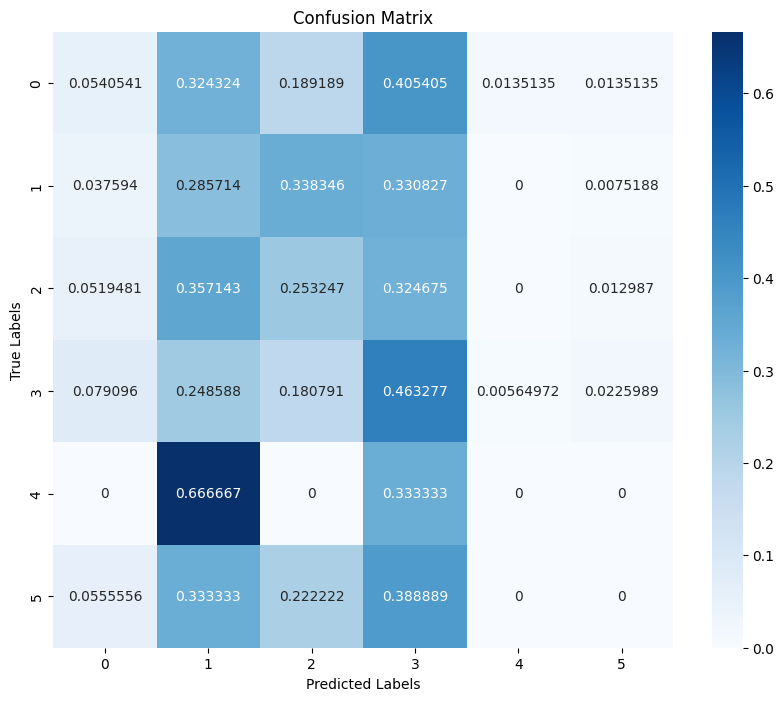

Epoch 6, Validation Loss: 2.9698, Accuracy: 0.2825, F1 Score: 0.2642
Val F1 Score Per Class  [0.07476636 0.24675325 0.26712329 0.4120603  0.         0.        ]


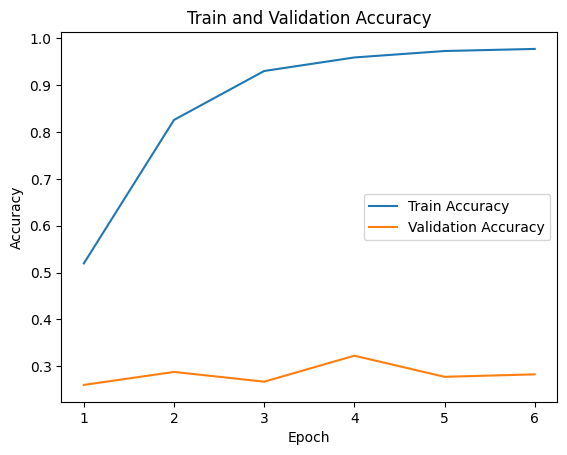

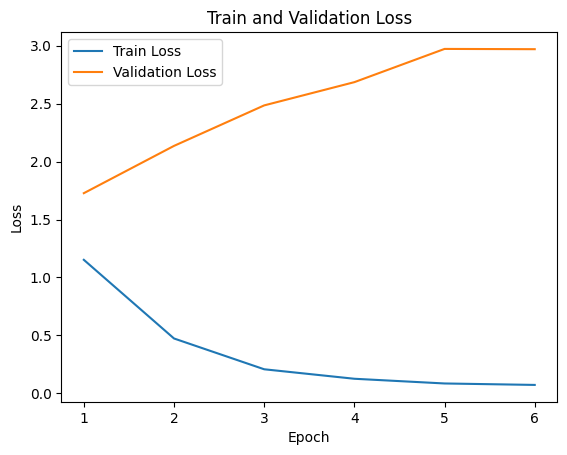

Epoch 7, Train Loss: 0.0432, Accuracy: 0.9872, F1 Score: 0.9871
Train F1 Score Per Class  [0.99214502 0.97841727 0.97640653 0.97877358 0.99941176 0.99760048]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.41it/s, loss=2.87]

[tensor([ 3.1175, -1.3975, -1.6094,  1.1045, -4.4182, -3.9055], device='cuda:0'), tensor([-0.2785, -0.9844, -1.0831,  5.0499, -3.9151, -4.2615], device='cuda:0'), tensor([-2.4481, -0.3786, -1.4993,  5.3874, -3.0745, -4.1119], device='cuda:0'), tensor([-1.9401, -1.4946,  5.0357, -0.8290, -3.9359, -3.5197], device='cuda:0'), tensor([-0.3089, -2.1130, -0.7931,  3.0230, -4.0540, -4.1726], device='cuda:0'), tensor([-0.8341,  0.5090,  0.0654,  1.6288, -4.8819, -5.1816], device='cuda:0'), tensor([-3.9644,  2.0278, -0.7722,  2.0308, -3.1993, -3.0370], device='cuda:0'), tensor([-1.0502, -1.2402, -0.8214,  5.7265, -3.6632, -4.2484], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.41it/s, loss=4.09]

[tensor([-1.9109,  1.9876, -0.2068, -0.0591, -4.0700, -4.1163], device='cuda:0'), tensor([-2.4539, -1.5430, -0.5244,  5.7840, -3.8766, -4.0987], device='cuda:0'), tensor([ 0.6320, -2.0762, -1.7670,  4.1757, -2.8425, -3.1703], device='cuda:0'), tensor([-2.9550,  0.7531, -1.8673,  0.9786, -1.6053, -2.9382], device='cuda:0'), tensor([-1.4478, -0.2886, -0.8577,  5.2606, -4.0842, -3.1877], device='cuda:0'), tensor([-0.8840, -0.1707, -1.0720,  2.1621, -4.5692, -4.5940], device='cuda:0'), tensor([-3.4926,  1.6157, -0.7882,  3.4935, -4.0258, -3.6690], device='cuda:0'), tensor([-1.6982, -0.5546, -1.8056,  5.5600, -4.0277, -3.5762], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=2.57]

[tensor([-2.1161,  0.8987, -1.6875,  3.7385, -3.8445, -4.2067], device='cuda:0'), tensor([-1.6390,  3.4394, -1.6043,  1.4208, -2.3007, -3.7033], device='cuda:0'), tensor([-2.3363,  2.9222,  1.8642, -1.6585, -3.2965, -3.4713], device='cuda:0'), tensor([-2.4018,  2.5732,  0.1178,  0.4485, -4.7651, -4.6953], device='cuda:0'), tensor([ 1.2490, -1.0548, -2.3835,  3.8104, -3.9448, -2.9872], device='cuda:0'), tensor([-1.1429,  1.4310, -0.4936,  2.8370, -5.0408, -5.1881], device='cuda:0'), tensor([-3.1709, -0.6348, -0.8719,  3.1998, -4.0622, -3.2385], device='cuda:0'), tensor([-2.1675, -0.4775, -0.6850,  1.2455, -3.8494, -4.2256], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.39it/s, loss=2.92]

[tensor([ 0.1058, -0.0118, -2.9318,  2.2632, -2.7969, -3.5919], device='cuda:0'), tensor([-0.7507, -2.0052, -0.4897,  5.6117, -2.8866, -3.7089], device='cuda:0'), tensor([-3.1565,  0.9255,  1.4689,  0.8426, -4.3678, -4.6707], device='cuda:0'), tensor([-1.3660, -0.6955, -1.6554,  0.2906, -3.3805, -1.4513], device='cuda:0'), tensor([-1.9612, -1.0705,  3.8768,  1.5355, -4.3433, -3.9090], device='cuda:0'), tensor([-1.9536,  0.0928, -1.1042,  2.9607, -4.3009, -4.5798], device='cuda:0'), tensor([-1.9159, -1.5896, -0.3866,  5.1996, -3.3674, -1.6920], device='cuda:0'), tensor([-0.2406, -1.2002, -2.2176,  4.5003, -4.0741, -3.5474], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.38it/s, loss=4.24]

[tensor([-2.2980, -0.4036, -1.2275,  4.5961, -5.1206, -4.4365], device='cuda:0'), tensor([-2.2963, -1.8685,  1.2331,  1.8747, -4.2239, -3.1511], device='cuda:0'), tensor([-2.3423,  2.1338, -2.0129,  1.2353, -3.7909, -4.8360], device='cuda:0'), tensor([-1.6214, -1.3088,  6.2660, -0.6892, -3.4490, -3.4523], device='cuda:0'), tensor([-2.2593, -2.3098,  1.1352,  2.3914, -4.4360, -2.7837], device='cuda:0'), tensor([-2.5766,  0.0469, -0.0894,  3.1864, -3.4681, -3.5484], device='cuda:0'), tensor([-2.8473, -0.9625,  0.3266,  3.4308, -4.5549, -4.1825], device='cuda:0'), tensor([-2.6773,  2.9385, -0.0325,  2.3042, -3.8834, -4.7528], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.38it/s, loss=3.5]

[tensor([-1.4533,  2.9724, -1.9108,  2.3650, -3.0787, -4.7210], device='cuda:0'), tensor([-1.6520,  1.7044, -2.0158,  1.7209, -3.6927, -3.0767], device='cuda:0'), tensor([-2.6687,  3.1300, -1.4490, -1.0883, -3.1522, -2.8851], device='cuda:0'), tensor([-2.3735, -0.2336, -1.6383,  3.3257, -5.1955, -3.8856], device='cuda:0'), tensor([-0.8263, -1.4903, -1.4968,  5.6262, -3.8392, -3.0371], device='cuda:0'), tensor([-3.1801, -1.6441,  0.4559,  3.1255, -4.1932, -4.5284], device='cuda:0'), tensor([-3.3169,  2.0220,  0.6260,  1.7330, -4.6106, -3.8151], device='cuda:0'), tensor([ 2.2094,  1.5555, -2.7217, -0.1168, -2.3138, -3.1259], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=2.18]

[tensor([-1.9801,  1.3920,  1.1727, -0.3021, -4.9064, -4.8089], device='cuda:0'), tensor([-2.4294, -1.7585,  4.2367,  1.0069, -4.1469, -4.0757], device='cuda:0'), tensor([-0.7832, -2.2112, -1.7408,  4.0207, -3.2091, -1.4102], device='cuda:0'), tensor([-2.2452, -0.6268, -0.7276,  2.3854, -3.9074, -4.2601], device='cuda:0'), tensor([-1.7129,  0.2182, -0.1715,  3.5514, -4.4923, -4.7018], device='cuda:0'), tensor([-2.2906, -0.9362, -0.1291,  4.5630, -4.3588, -2.7176], device='cuda:0'), tensor([-2.2908, -1.5967, -1.7170,  5.7987, -3.6190, -3.7823], device='cuda:0'), tensor([-1.2162, -1.4698,  6.3832, -1.3691, -2.3748, -2.2752], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=3.99]

[tensor([-2.9152, -0.1151, -1.3343,  4.6906, -2.3373, -2.9350], device='cuda:0'), tensor([-2.2515,  2.3168, -1.7251,  1.7271, -2.9849, -2.6865], device='cuda:0'), tensor([-0.7386,  1.5124, -3.1057,  1.5677, -4.1004, -2.5604], device='cuda:0'), tensor([-2.6347, -0.5480, -0.5105,  5.2207, -4.2580, -3.5666], device='cuda:0'), tensor([-2.2220,  0.7881, -2.3833,  3.3816, -3.7966, -3.6274], device='cuda:0'), tensor([-1.7821, -2.4499, -1.1693,  5.4443, -3.6409, -3.2295], device='cuda:0'), tensor([-0.5112, -0.8485,  1.6916, -0.4877, -5.1750, -3.7805], device='cuda:0'), tensor([-3.2006, -0.1105, -0.4909,  4.8551, -3.8016, -3.7777], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.40it/s, loss=2.7]

[tensor([-2.9154,  1.1789, -0.9422,  3.9797, -4.4332, -4.0230], device='cuda:0'), tensor([-2.4103, -0.6793, -0.3063,  4.3553, -3.2471, -3.7234], device='cuda:0'), tensor([-1.1365, -1.6350, -0.9744,  6.1357, -3.7102, -2.9129], device='cuda:0'), tensor([-2.6710,  1.0741, -1.6820,  4.6167, -4.9845, -3.6594], device='cuda:0'), tensor([-2.3971, -0.8940,  0.0094,  5.1963, -4.5019, -4.0911], device='cuda:0'), tensor([-2.4547,  0.7856, -0.3095,  1.2796, -4.2394, -4.0764], device='cuda:0'), tensor([-2.4202, -1.4983, -0.6961,  5.1080, -3.6725, -4.2084], device='cuda:0'), tensor([-1.2308, -1.6176, -1.6800,  5.4891, -4.0106, -3.3714], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=5.24]

[tensor([-2.2865, -0.0595, -2.2689,  3.5673, -4.1157, -4.4990], device='cuda:0'), tensor([-1.6791, -1.4231, -1.5693,  6.0326, -3.3144, -2.7525], device='cuda:0'), tensor([-1.6238, -0.4642, -1.3579,  3.6326, -4.5606, -4.3785], device='cuda:0'), tensor([-3.4313,  0.1964, -0.6730,  4.2548, -4.5071, -4.3157], device='cuda:0'), tensor([-2.6996,  3.3584,  0.2086,  0.2144, -4.8277, -4.5277], device='cuda:0'), tensor([-2.9510,  0.3298, -1.3197,  5.7739, -3.7916, -3.8267], device='cuda:0'), tensor([ 0.7248,  2.0554, -1.3031, -0.0759, -3.9442, -4.3150], device='cuda:0'), tensor([-0.5496,  0.4197, -1.8189,  2.4700, -4.9349, -4.4345], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=3.81]

[tensor([-2.3715,  2.0778, -1.2768,  3.8311, -3.5527, -4.3683], device='cuda:0'), tensor([-2.1293, -0.9555, -0.9026,  3.3727, -3.5499, -3.2408], device='cuda:0'), tensor([-3.3618,  0.0154, -0.2568,  3.3528, -4.2198, -4.0176], device='cuda:0'), tensor([-1.9547, -1.3080,  0.4876,  4.0727, -3.2517, -3.4752], device='cuda:0'), tensor([-1.1108, -2.1044, -0.4541,  5.0345, -3.5902, -3.7549], device='cuda:0'), tensor([-2.6619, -0.7254, -1.0032,  5.7444, -4.1453, -3.4305], device='cuda:0'), tensor([-1.8180,  0.3231,  0.9172,  1.9693, -5.1115, -4.9188], device='cuda:0'), tensor([-1.8579, -1.2537, -0.9643,  6.0918, -3.5886, -2.9812], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.38it/s, loss=4.38]

[tensor([-1.8805,  3.6724, -1.6627,  1.1119, -3.4904, -4.9959], device='cuda:0'), tensor([-2.2547,  0.1161, -0.5589,  2.7654, -4.4904, -4.0731], device='cuda:0'), tensor([-2.0360, -1.8275, -2.4065,  5.6721, -3.8170, -3.2006], device='cuda:0'), tensor([-2.3373,  0.2519, -1.5445,  1.9844, -4.6569, -3.5048], device='cuda:0'), tensor([-1.9449, -0.3193, -1.1463,  4.5140, -4.3196, -4.2292], device='cuda:0'), tensor([-0.5531,  0.2830, -0.9758,  1.4908, -4.2517, -4.2801], device='cuda:0'), tensor([-2.6506,  0.2556, -1.1377,  5.3393, -4.1230, -3.6162], device='cuda:0'), tensor([-1.4156, -0.9171,  0.2671,  4.5392, -5.0861, -4.5578], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.38it/s, loss=3.73]

[tensor([-2.8729,  1.4668, -2.2148,  3.2509, -3.0330, -2.4732], device='cuda:0'), tensor([-2.6817, -1.0186, -0.9811,  4.2625, -4.1615, -3.8296], device='cuda:0'), tensor([-2.1208,  0.3473, -2.4911,  5.1494, -3.5238, -3.7793], device='cuda:0'), tensor([-2.0587, -0.6067, -0.9286,  6.0489, -3.6028, -4.0128], device='cuda:0'), tensor([-1.6208, -1.5354, -0.9956,  5.7971, -3.2616, -3.6076], device='cuda:0'), tensor([-0.0795, -1.6168, -1.3212,  4.0808, -4.0586, -4.2265], device='cuda:0'), tensor([-2.7528,  0.5215, -1.5783,  1.5679, -2.9259, -3.4491], device='cuda:0'), tensor([-0.8195,  1.4628, -1.5841,  1.6589, -4.7422, -3.7982], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.38it/s, loss=2.07]

[tensor([-1.0577, -1.6661,  0.5198,  1.0565, -4.9307, -4.2785], device='cuda:0'), tensor([ 0.1019,  1.7734, -1.4866,  0.1267, -4.4494, -5.5874], device='cuda:0'), tensor([-0.0537,  0.4232, -0.2424, -0.4762, -4.9825, -3.9935], device='cuda:0'), tensor([-1.6398, -1.5970,  1.1209,  4.1992, -4.5809, -4.5699], device='cuda:0'), tensor([-2.8455,  2.9672, -1.1851,  2.9208, -3.6964, -4.9231], device='cuda:0'), tensor([-2.0147, -0.4652, -0.7149,  4.5882, -3.6323, -4.5042], device='cuda:0'), tensor([-2.1242,  3.4868, -1.5134,  2.0985, -3.7506, -4.5125], device='cuda:0'), tensor([-0.9961, -0.1744, -1.2236,  1.6146, -4.3759, -4.1522], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.38it/s, loss=2.69]

[tensor([-2.1203, -0.3909, -1.0383,  5.8957, -3.5818, -4.2328], device='cuda:0'), tensor([-2.9822,  0.7141, -1.5463,  4.2959, -3.6638, -3.6844], device='cuda:0'), tensor([-2.0554, -1.9030, -1.7119,  5.1502, -3.5125, -1.2235], device='cuda:0'), tensor([-2.5665,  3.1561, -0.5595,  0.5816, -4.6353, -4.0944], device='cuda:0'), tensor([-2.2219,  0.3133, -0.4307,  2.7717, -4.9392, -3.8365], device='cuda:0'), tensor([-1.0756, -1.4925, -1.0618,  4.7458, -3.8464, -3.3268], device='cuda:0'), tensor([-1.6998,  0.7435, -2.3800,  2.8013, -2.7359, -3.4045], device='cuda:0'), tensor([-3.0354,  0.3149, -0.6261,  3.2539, -4.2231, -4.4184], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=3.63]

[tensor([-0.0428,  0.6205,  0.0806,  2.8263, -4.9542, -4.3147], device='cuda:0'), tensor([-3.2988,  0.9637, -1.3787,  2.3749, -4.2453, -4.2324], device='cuda:0'), tensor([-3.0859, -1.0154, -1.5811,  2.4269, -4.6836,  1.2292], device='cuda:0'), tensor([-0.8247, -2.0119, -0.0242,  5.5064, -3.9809, -3.5669], device='cuda:0'), tensor([-0.2068, -0.3285,  2.4947,  1.5665, -4.4021, -4.6908], device='cuda:0'), tensor([-1.3185, -1.5346, -1.4960,  5.2818, -3.7162, -3.7164], device='cuda:0'), tensor([-2.2725, -0.9405, -1.7519,  5.7597, -3.2516, -3.2049], device='cuda:0'), tensor([ 3.7772, -1.3352, -2.7331, -0.6252, -1.0162, -0.5102], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.38it/s, loss=4.16]

[tensor([-2.2466,  1.9151, -1.6585,  0.9532, -4.0517, -3.5248], device='cuda:0'), tensor([-1.9816,  0.2132, -1.6951,  4.9692, -4.3488, -4.4658], device='cuda:0'), tensor([-2.9111,  2.4279, -1.5126,  2.3756, -4.1718, -2.7839], device='cuda:0'), tensor([-2.8965,  0.8128,  0.5987,  1.4073, -4.1871, -4.4128], device='cuda:0'), tensor([ 5.5996, -1.4444, -0.9901,  0.4259, -3.5483, -3.8795], device='cuda:0'), tensor([-0.5647,  1.1030, -0.2045,  1.2680, -5.0372, -5.8769], device='cuda:0'), tensor([-1.9930, -1.6248,  0.8201,  5.1377, -4.8920, -4.5251], device='cuda:0'), tensor([-2.5300,  0.6270, -0.4776,  1.3641, -5.1033, -3.9928], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.39it/s, loss=2.59]

[tensor([-1.6678, -0.5621, -2.0901,  5.0196, -2.7376, -3.4908], device='cuda:0'), tensor([-2.3444, -0.6933,  0.4230,  3.4484, -2.5728, -3.4515], device='cuda:0'), tensor([-2.6894,  2.3832,  0.8913,  0.2878, -4.5567, -4.1875], device='cuda:0'), tensor([-1.6451, -2.0875, -0.3197,  5.3206, -4.0279, -3.9416], device='cuda:0'), tensor([-1.9118, -0.5684, -1.9609,  4.6576, -3.3214, -1.9392], device='cuda:0'), tensor([-0.4096,  0.2258, -1.8753,  2.1171, -4.4008, -4.0295], device='cuda:0'), tensor([-0.4878, -0.9762, -1.2669,  3.4309, -4.2937, -4.2337], device='cuda:0'), tensor([-1.1940, -1.0164, -0.7124,  5.2499, -4.5689, -3.9442], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.38it/s, loss=3.22]

[tensor([-2.7521,  2.3847, -0.9362,  1.3116, -3.7117, -3.4837], device='cuda:0'), tensor([-2.1638,  2.2855, -1.5958,  1.1497, -2.6577, -3.7712], device='cuda:0'), tensor([-0.3576, -1.0246,  1.6611,  1.4264, -4.7820, -3.3873], device='cuda:0'), tensor([-2.1146,  1.5667, -0.8563,  1.5643, -1.7725, -4.0662], device='cuda:0'), tensor([-2.8563,  1.2288, -1.1416,  1.9892, -2.7995, -3.1550], device='cuda:0'), tensor([-2.2530, -0.2865, -1.6874,  5.3578, -2.9705, -3.2325], device='cuda:0'), tensor([-2.1258, -1.1618, -0.9683,  6.1877, -3.2648, -2.8735], device='cuda:0'), tensor([ 2.2630, -1.5905, -2.1398,  1.1281, -2.2792, -3.6867], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.38it/s, loss=3.52]

[tensor([-3.3033,  3.3907, -0.2827, -0.8161, -4.2051, -3.2096], device='cuda:0'), tensor([-2.2754,  0.6474, -1.4677,  3.5887, -4.2649, -3.8871], device='cuda:0'), tensor([-2.6991, -1.2966, -0.2049,  5.2496, -3.7824, -3.5789], device='cuda:0'), tensor([-2.4359,  0.0648,  3.6631,  0.7584, -4.3920, -4.5999], device='cuda:0'), tensor([-1.8094, -0.8097, -1.4193,  5.0909, -3.3313, -4.0826], device='cuda:0'), tensor([-3.4179,  0.3957, -0.3112,  2.9364, -4.5703, -3.7123], device='cuda:0'), tensor([-1.3024, -0.4624, -0.7636,  2.9424, -3.4894, -3.8150], device='cuda:0'), tensor([-1.7861,  2.6134, -1.9116,  1.9538, -3.0678, -3.9135], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=5.25]

[tensor([-2.2055, -0.8356,  4.6963, -0.0519, -4.3261, -3.9540], device='cuda:0'), tensor([-0.7782,  4.0788, -1.0487,  0.1343, -3.8470, -4.3645], device='cuda:0'), tensor([-2.6909,  0.3036, -0.4046,  2.4910, -3.9078, -4.2880], device='cuda:0'), tensor([-3.4557, -0.6675, -1.0570,  3.2342, -4.1697, -3.5465], device='cuda:0'), tensor([-1.8272,  3.5832, -2.3909,  0.1606, -2.9577, -2.8871], device='cuda:0'), tensor([-1.3131, -2.0368, -1.3702,  4.5866, -4.0146, -3.7247], device='cuda:0'), tensor([-1.2189,  6.0492, -0.6047, -1.8793, -2.8711, -2.9852], device='cuda:0'), tensor([-1.3894,  0.3570, -1.4711,  3.7345, -3.0352, -4.2954], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=2.2]

[tensor([-0.3835, -1.6924,  0.0450,  0.0658, -4.5940, -3.7909], device='cuda:0'), tensor([-1.1940, -1.1496, -0.8448,  3.1603, -4.8068, -3.7670], device='cuda:0'), tensor([-1.7922,  2.5577, -1.2677,  1.9871, -4.9167, -4.9852], device='cuda:0'), tensor([-2.8287, -0.7962, -1.6081,  5.5110, -3.5302, -2.7088], device='cuda:0'), tensor([-3.2443,  1.0333, -0.7241, -1.0230, -3.9945, -4.2647], device='cuda:0'), tensor([-0.0283, -1.0178, -0.4141,  2.0224, -5.0466, -4.2052], device='cuda:0'), tensor([-1.3618, -1.4617, -0.4440,  5.4414, -4.1160, -3.2822], device='cuda:0'), tensor([-2.4274, -0.3025,  2.1177,  1.3905, -4.6421, -4.5484], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.38it/s, loss=4.15]

[tensor([-1.7646,  0.0743, -1.4027,  2.4187, -3.9334, -4.7043], device='cuda:0'), tensor([-2.2892,  0.1588,  3.4382,  1.1551, -4.3880, -4.9843], device='cuda:0'), tensor([-1.8370,  4.6546, -1.2778,  1.1911, -4.0714, -3.9914], device='cuda:0'), tensor([-1.8444,  5.9135, -1.3531, -1.1313, -2.0848, -2.4566], device='cuda:0'), tensor([-2.8836, -0.9191, -1.4669,  3.3783, -4.2862, -4.5428], device='cuda:0'), tensor([-2.7313,  0.8245, -0.7872,  2.0618, -3.6845, -4.0187], device='cuda:0'), tensor([-2.6007, -0.6909, -0.4089,  0.9367, -3.9848, -1.9255], device='cuda:0'), tensor([-2.0617,  3.1378, -2.0027,  1.1897, -4.4507, -3.6626], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.38it/s, loss=3.5]

[tensor([-2.5644, -1.6034,  0.8240,  4.4236, -3.8264, -4.3267], device='cuda:0'), tensor([-2.5624,  0.1931, -1.1631,  4.1764, -3.8497, -4.1590], device='cuda:0'), tensor([-2.6544,  0.4469, -1.4558,  2.6612, -4.3201, -4.1471], device='cuda:0'), tensor([-1.8111, -0.4688, -1.9959,  5.8073, -3.2190, -3.6741], device='cuda:0'), tensor([-1.4939, -1.0981, -1.7131,  5.6459, -3.6575, -3.5156], device='cuda:0'), tensor([-2.1209, -0.7470, -0.7096,  5.8334, -4.0016, -3.6210], device='cuda:0'), tensor([-0.7265, -1.2125, -2.2401,  0.9712, -1.1342, -0.8240], device='cuda:0'), tensor([-0.7912, -0.8402, -2.3203,  2.7100, -4.0154, -4.2538], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.38it/s, loss=2.7]

[tensor([-2.7351, -1.0717,  1.3338,  4.2500, -4.7647, -4.3487], device='cuda:0'), tensor([-2.8406,  2.4097,  0.0337,  3.1094, -4.1427, -4.4851], device='cuda:0'), tensor([-1.1807,  0.1180, -1.8632,  5.0775, -3.8702, -3.6265], device='cuda:0'), tensor([-2.6013,  0.9497, -1.3128,  0.2031, -4.2667, -4.3210], device='cuda:0'), tensor([-3.1843,  2.7832, -1.7170,  1.5147, -4.2197, -4.2923], device='cuda:0'), tensor([-2.2221, -1.6969, -0.8411,  2.1621, -2.9116, -3.8897], device='cuda:0'), tensor([-1.0619, -0.8967, -2.2320,  5.1406, -3.2241, -3.7537], device='cuda:0'), tensor([-2.4945,  1.1492, -2.3950,  2.5670, -3.4676, -3.1634], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.3]

[tensor([-1.4377, -0.8541, -1.0318,  5.8237, -3.8412, -3.2711], device='cuda:0'), tensor([-2.7958, -0.0801, -1.0537,  5.2085, -3.8450, -3.4963], device='cuda:0'), tensor([-0.5866, -1.6650, -0.8021,  2.8943, -4.8077, -4.0456], device='cuda:0'), tensor([ 0.3128,  1.0872, -2.8042,  1.5926, -3.6528, -3.4407], device='cuda:0'), tensor([-2.5923,  2.6067, -0.6296,  2.8498, -4.5211, -4.0355], device='cuda:0'), tensor([ 1.7350, -2.7420, -0.0677,  2.4472, -4.3474, -3.2965], device='cuda:0'), tensor([-1.8729, -0.0682, -1.0234,  0.1062, -4.4945, -3.9402], device='cuda:0'), tensor([-2.3749, -0.6269,  0.5267,  2.4860, -5.1178, -3.5845], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=3.6]

[tensor([-2.6375,  2.5031,  0.2417,  0.2703, -3.7497, -4.1022], device='cuda:0'), tensor([-2.7739, -0.1832,  0.4015,  2.2880, -3.2449, -4.2770], device='cuda:0'), tensor([-0.8011, -0.5782, -2.1166,  4.0830, -3.4598, -3.5736], device='cuda:0'), tensor([-2.3787, -1.1685,  0.5851,  3.1613, -4.5378, -3.8400], device='cuda:0'), tensor([-0.3180,  4.1066, -0.7842, -0.9485, -3.7932, -3.2853], device='cuda:0'), tensor([-2.2317, -0.7316,  0.1006,  3.4567, -4.5083, -4.1690], device='cuda:0'), tensor([-2.1343, -1.1815, -0.7520,  5.8471, -3.7766, -3.5574], device='cuda:0'), tensor([-2.3575,  1.3792, -2.2837,  4.1847, -3.3414, -4.1823], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.38it/s, loss=3.29]

[tensor([-0.6672, -2.1889, -0.5152,  4.7480, -4.2430, -3.7186], device='cuda:0'), tensor([-2.0672, -0.4451, -1.1523,  1.2111, -4.1533, -3.7241], device='cuda:0'), tensor([-1.3071,  3.4557, -1.0191, -1.0140, -3.1674, -2.8581], device='cuda:0'), tensor([-2.0183, -1.5804, -0.3203,  6.0557, -3.4712, -3.4360], device='cuda:0'), tensor([-1.8477, -0.3278, -1.4195,  5.6395, -3.4155, -3.7392], device='cuda:0'), tensor([-2.3498, -1.1684,  0.1727,  4.6098, -4.1906, -4.1231], device='cuda:0'), tensor([-2.1808,  0.0533,  2.4760,  0.4961, -4.3781, -4.0447], device='cuda:0'), tensor([-1.2907,  3.3955, -1.2752, -1.1924, -3.9200, -4.4072], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=3.73]

[tensor([-2.7845,  0.2703, -0.3440,  3.8648, -3.9123, -3.8350], device='cuda:0'), tensor([-1.5816, -0.5603, -2.8145,  0.6398, -1.0377, -1.5242], device='cuda:0'), tensor([-3.5734, -0.4354,  0.4616,  4.6457, -4.4997, -3.5049], device='cuda:0'), tensor([-2.9593,  0.4629,  0.8696,  1.4782, -4.7211, -4.6806], device='cuda:0'), tensor([ 0.9267,  1.6387, -1.1308, -0.3344, -4.8306, -4.0055], device='cuda:0'), tensor([-2.8485, -1.0740, -1.0436,  3.6719, -4.5665, -3.9006], device='cuda:0'), tensor([-2.8548, -0.0325, -1.1780,  4.9235, -4.0371, -3.7477], device='cuda:0'), tensor([-3.6131, -0.6985,  0.1343,  4.2339, -4.2507, -3.7189], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.39it/s, loss=4.2]

[tensor([-2.7610,  4.9176, -0.8823,  0.5250, -3.5930, -3.2793], device='cuda:0'), tensor([-2.2964,  1.2166, -1.0444,  4.1443, -3.8698, -4.2436], device='cuda:0'), tensor([ 1.2983, -1.4601, -2.4511,  1.1187, -1.3447, -1.8670], device='cuda:0'), tensor([-1.9676, -0.5647, -1.4295,  5.9572, -3.6046, -3.5534], device='cuda:0'), tensor([-2.1461,  0.9455, -2.2610,  1.5267, -3.9641, -3.7997], device='cuda:0'), tensor([-1.1947, -1.4959,  1.6969,  1.9236, -4.6154, -4.3162], device='cuda:0'), tensor([-1.1605, -1.2293,  3.8786, -0.3933, -4.8947, -3.6797], device='cuda:0'), tensor([-1.8789, -0.5576, -0.8439, -0.1961, -4.5840,  4.1734], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.38it/s, loss=3.48]

[tensor([-2.0596, -0.0086, -2.0300,  5.7499, -3.4647, -3.1516], device='cuda:0'), tensor([-2.4053, -0.2525, -1.4093,  5.3092, -3.4877, -3.0412], device='cuda:0'), tensor([-2.8593,  0.6250, -0.6935,  3.1117, -3.3320, -3.0570], device='cuda:0'), tensor([ 0.8403,  1.4105, -2.5915,  0.1470, -4.0403, -3.6228], device='cuda:0'), tensor([-2.5151,  1.0700, -0.3327,  0.0690, -3.3859, -4.2759], device='cuda:0'), tensor([ 4.1756,  0.0158, -1.8361, -0.5299, -3.5578, -1.9456], device='cuda:0'), tensor([-2.3355, -1.3856,  0.1759,  5.4158, -3.9846, -4.0853], device='cuda:0'), tensor([-2.4945, -0.1845,  0.9546,  4.3193, -4.7239, -4.3976], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.39it/s, loss=4.02]

[tensor([-2.2406,  1.8326, -1.9096,  2.5173, -3.3856, -4.0522], device='cuda:0'), tensor([-2.2126, -1.1411, -1.4674,  6.2147, -3.1790, -2.7938], device='cuda:0'), tensor([-1.8137,  6.0064, -0.1207, -1.8415, -2.5099, -3.4420], device='cuda:0'), tensor([-1.5149,  1.6906, -1.4831, -1.1743, -1.8980, -2.6400], device='cuda:0'), tensor([-2.1842,  0.9776, -1.1334,  2.2278, -2.9717, -3.6400], device='cuda:0'), tensor([-1.8215, -1.7835,  2.4600,  0.8789, -3.9764, -4.0080], device='cuda:0'), tensor([-0.4141,  1.1995, -2.0409,  2.7498, -4.4481, -4.5203], device='cuda:0'), tensor([-2.3915, -0.1390,  0.0437,  0.1274, -4.4997, -4.5985], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.38it/s, loss=4.18]

[tensor([-3.3177, -0.5919, -0.1144,  3.4781, -3.7884, -3.3552], device='cuda:0'), tensor([-2.6819,  5.2276, -1.6186,  0.8488, -3.2991, -2.5212], device='cuda:0'), tensor([-1.3734, -0.7254, -1.4937,  5.3134, -4.5836, -2.5365], device='cuda:0'), tensor([-0.9898,  2.0272,  2.2830, -0.5359, -4.1746, -5.3382], device='cuda:0'), tensor([-3.0270, -0.7479,  3.0401,  1.7510, -4.3448, -4.6560], device='cuda:0'), tensor([-1.9359, -1.6631,  0.8689,  3.9729, -4.5232, -4.2454], device='cuda:0'), tensor([-1.9907,  1.0007, -1.7041,  2.6677, -4.7316, -4.5090], device='cuda:0'), tensor([-2.8691,  0.1109, -1.7092,  2.9906, -3.4728, -3.5697], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.38it/s, loss=3.76]

[tensor([ 5.4100, -0.3897, -2.1035, -1.0109, -2.7862, -2.2458], device='cuda:0'), tensor([-2.4170,  0.4752, -1.0839,  5.4042, -4.1594, -4.3550], device='cuda:0'), tensor([-1.1082,  3.8376, -2.4204,  0.4384, -1.4129, -3.8362], device='cuda:0'), tensor([-2.8886, -1.8631, -0.6927,  3.3992, -4.9608, -3.2408], device='cuda:0'), tensor([-1.8098,  2.8061, -1.8686,  1.4963, -3.8300, -3.4967], device='cuda:0'), tensor([-1.9390,  2.1861, -1.3510,  2.1724, -4.7402, -3.8127], device='cuda:0'), tensor([-2.2601, -1.3301, -1.0015,  5.6421, -3.6032, -3.4287], device='cuda:0'), tensor([-2.3060, -0.0250,  4.9056, -0.8916, -4.3259, -4.0166], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=2.1]

[tensor([-2.7070,  3.3141, -1.1710,  0.2177, -3.9699, -4.0311], device='cuda:0'), tensor([-1.4376, -0.5594, -1.0643,  5.2888, -4.2120, -4.2199], device='cuda:0'), tensor([-1.9842, -0.7114,  0.0479,  2.3837, -4.2097, -3.9175], device='cuda:0'), tensor([-1.5036, -0.1343,  5.7595, -1.3774, -3.2006, -2.8968], device='cuda:0'), tensor([-2.3385,  2.7787, -0.0453,  1.8058, -4.9876, -3.3463], device='cuda:0'), tensor([ 1.5274, -0.9769, -2.1380,  1.8338, -2.3353, -3.0000], device='cuda:0'), tensor([-0.9601, -0.5199, -0.8228,  3.8596, -4.5219, -4.5842], device='cuda:0'), tensor([-0.9454, -1.4862,  2.7556,  1.7341, -4.3105, -4.1463], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.38it/s, loss=2.91]

[tensor([-2.2400,  2.8803, -1.0516,  2.0898, -4.6104, -4.7260], device='cuda:0'), tensor([-1.3638,  2.0350, -0.4632,  1.2710, -2.5296, -5.3611], device='cuda:0'), tensor([-2.5972, -1.0916, -0.5102,  3.9827, -3.7874, -3.3524], device='cuda:0'), tensor([-2.4816,  4.2218, -0.9337, -0.7468, -4.7580, -3.9161], device='cuda:0'), tensor([-1.7204, -1.4239, -0.2664,  4.1646, -4.5892, -4.2583], device='cuda:0'), tensor([-2.4078, -0.8261, -1.0291,  5.7371, -3.5219, -4.1938], device='cuda:0'), tensor([-1.4621,  0.9071, -0.0298,  3.3698, -4.0020, -4.9486], device='cuda:0'), tensor([-1.6151, -0.5475, -0.3845,  4.4157, -4.3410, -3.7191], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=4.24]

[tensor([ 0.7830, -1.9680, -2.0365,  4.8555, -2.5340, -3.3723], device='cuda:0'), tensor([-1.8416, -0.7563, -0.6306,  5.7870, -3.7151, -3.9207], device='cuda:0'), tensor([-1.8749, -0.7549, -1.5794,  5.6448, -2.7642, -2.9473], device='cuda:0'), tensor([-2.7283,  1.4022, -1.1605,  2.1254, -3.2225, -2.6620], device='cuda:0'), tensor([-1.3943,  2.6002,  0.8858, -0.7955, -4.2259, -3.9044], device='cuda:0'), tensor([-2.3277,  4.5925,  1.1902, -0.9487, -4.1129, -3.9927], device='cuda:0'), tensor([-2.6395, -0.0798,  0.2448,  3.9734, -4.1039, -3.8369], device='cuda:0'), tensor([-2.9545,  2.6893, -0.3220,  3.0891, -3.7317, -4.5392], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.36it/s, loss=2.65]

[tensor([-2.5076, -0.4240, -0.5407,  1.9257, -4.1913, -3.5279], device='cuda:0'), tensor([-2.3544,  0.3273, -1.6875,  4.3959, -4.0216, -3.2716], device='cuda:0'), tensor([-2.4969,  0.9427, -1.3394,  3.5461, -4.6988, -3.7749], device='cuda:0'), tensor([-2.6661,  1.2001, -1.9500,  2.1519, -2.7886, -3.7615], device='cuda:0'), tensor([-1.9577, -0.9177, -0.1631,  3.9016, -4.4663, -4.7624], device='cuda:0'), tensor([-2.0350,  5.4776, -0.8088, -0.5748, -2.8463, -2.9763], device='cuda:0'), tensor([-1.6542,  0.3682, -0.0651, -0.3824, -3.9225, -4.5772], device='cuda:0'), tensor([-2.3013,  0.7099, -0.4694,  4.9621, -4.3468, -4.3172], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.36it/s, loss=2.28]

[tensor([-1.9187, -1.5748, -0.5345,  2.9400, -4.4097, -3.9146], device='cuda:0'), tensor([-2.2769,  0.4617, -0.2981,  3.5976, -4.4279, -4.4932], device='cuda:0'), tensor([-0.8145, -2.3216, -0.5911,  1.3071, -3.6122, -3.1957], device='cuda:0'), tensor([-0.4974, -1.4652, -1.3359,  5.6158, -3.5724, -3.7900], device='cuda:0'), tensor([-1.7585, -0.9238, -0.9819,  4.1748, -4.0277, -4.0981], device='cuda:0'), tensor([-2.6679,  0.5273,  0.0297,  2.7621, -4.5056, -4.2672], device='cuda:0'), tensor([ 1.2202, -2.5490,  0.5293,  1.3247, -4.5393, -3.8584], device='cuda:0'), tensor([-3.0169,  1.9286,  1.6201, -0.9849, -4.9436, -3.2870], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.37it/s, loss=2.86]

[tensor([ 5.1224, -1.4552, -0.5010,  0.9381, -4.0272, -3.9034], device='cuda:0'), tensor([-1.1298, -1.7790,  2.3443, -0.5860, -3.6922, -4.0088], device='cuda:0'), tensor([-2.5543,  2.6061, -1.1329,  2.9504, -4.8487, -3.7737], device='cuda:0'), tensor([ 1.1685, -1.7201, -2.0664,  3.4043, -2.9986, -2.9297], device='cuda:0'), tensor([-2.9556,  3.2980, -1.4276,  1.3729, -3.8397, -3.6277], device='cuda:0'), tensor([-1.8354, -1.1434, -1.9714,  5.6493, -2.7559, -3.1466], device='cuda:0'), tensor([-2.6635,  0.4893,  0.6495,  0.8648, -3.8240, -4.3202], device='cuda:0'), tensor([-1.2272, -0.7517, -1.9671,  5.4135, -3.7306, -3.0592], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.37it/s, loss=2.88]

[tensor([-1.7851, -0.5802, -0.6567,  5.6725, -3.7054, -4.3238], device='cuda:0'), tensor([-1.3819,  0.5677,  1.4310,  1.5201, -2.9809, -5.0360], device='cuda:0'), tensor([-2.3454,  0.9048, -1.5995,  3.7284, -4.1197, -3.8915], device='cuda:0'), tensor([-2.5720,  1.1757, -1.6910,  5.0707, -3.8434, -4.1286], device='cuda:0'), tensor([-2.2141,  3.4625, -0.9521,  1.8475, -4.6569, -4.2851], device='cuda:0'), tensor([-1.9082, -0.5862, -1.5448,  5.3559, -3.6851, -3.8202], device='cuda:0'), tensor([-2.9818, -1.2497, -0.6625,  3.8631, -4.2833, -3.4833], device='cuda:0'), tensor([-1.1333,  0.2156, -2.1369,  2.9990, -2.6168, -4.1008], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.38it/s, loss=3.51]

[tensor([-1.4882, -1.2400, -1.3177,  5.2919, -2.9788, -3.8911], device='cuda:0'), tensor([ 2.8441, -1.7107, -1.4783,  3.3628, -3.9576, -2.9531], device='cuda:0'), tensor([-1.3299, -1.0250, -0.3428,  4.9948, -4.9593, -3.7337], device='cuda:0'), tensor([-1.3191, -0.2492, -1.9120,  2.8352, -2.8739, -2.9279], device='cuda:0'), tensor([-3.2517,  0.2683, -0.1892,  4.8753, -3.7035, -3.1535], device='cuda:0'), tensor([-1.9830, -1.3055, -0.8680,  5.9629, -4.0191, -3.9515], device='cuda:0'), tensor([-2.7753, -0.8690, -0.2327,  5.3798, -3.9565, -3.4020], device='cuda:0'), tensor([-1.0584, -0.0387,  1.8202, -0.0293, -4.2330, -4.3629], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.37it/s, loss=1.42]

[tensor([-2.8300,  1.9782, -0.5561,  3.2807, -4.3580, -4.3620], device='cuda:0'), tensor([-1.9004,  2.0376, -0.3655,  2.1795, -5.0129, -4.8880], device='cuda:0'), tensor([-2.0412,  1.5083, -1.0591,  3.3784, -4.6927, -3.5623], device='cuda:0'), tensor([-2.4495, -1.0617, -0.8393,  5.7406, -3.9864, -2.6096], device='cuda:0'), tensor([-2.7636,  0.1758, -0.2847,  4.6229, -4.4180, -4.2503], device='cuda:0'), tensor([-3.1291,  0.1737,  0.7909,  2.7813, -4.0152, -4.9201], device='cuda:0'), tensor([-3.5055, -0.5267,  2.1723,  2.9478, -3.8772, -3.3248], device='cuda:0'), tensor([-2.3725,  2.4345, -0.4029,  0.6776, -4.6203, -4.6661], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.37it/s, loss=3.51]

[tensor([-2.5214, -0.0529, -0.5868,  3.6936, -2.7188, -4.4593], device='cuda:0'), tensor([-2.5447, -1.5524,  0.8984,  1.1804, -4.6547, -3.8385], device='cuda:0'), tensor([-0.2086,  0.5537, -1.3957, -1.2175, -4.5404, -3.0660], device='cuda:0'), tensor([-2.1947,  0.4393, -1.8663,  4.8904, -3.7999, -3.1116], device='cuda:0'), tensor([-1.6938, -1.3738, -0.8954,  6.2007, -3.1988, -3.2216], device='cuda:0'), tensor([-2.1293,  2.8823, -2.1550,  0.5213, -4.1886, -3.5208], device='cuda:0'), tensor([-0.7283, -1.1380, -1.8276,  6.0691, -3.7379, -3.8062], device='cuda:0'), tensor([-2.3635, -0.4597, -0.7351,  5.0968, -3.5442, -4.3203], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.38it/s, loss=4.09]

[tensor([-2.5011, -0.8796, -1.1546,  3.5278, -4.3004, -3.3339], device='cuda:0'), tensor([-2.1591,  6.0339, -1.1568, -1.0831, -2.6628, -2.6149], device='cuda:0'), tensor([-1.9855,  0.2551,  0.3319,  1.6301, -4.6704, -4.3860], device='cuda:0'), tensor([-1.9879,  4.1801, -0.9736,  1.1429, -4.1027, -4.4045], device='cuda:0'), tensor([-1.6983, -1.2898, -1.4529,  5.8680, -3.9666, -2.8222], device='cuda:0'), tensor([-0.1744, -1.7339, -1.8046,  4.3465, -3.1285, -2.9361], device='cuda:0'), tensor([ 0.3582,  0.6563, -2.0764, -1.9721, -1.2871, -3.0641], device='cuda:0'), tensor([-3.5208,  2.0840, -0.0824,  2.6605, -4.6549, -3.7753], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=5.11]

[tensor([-1.2253, -0.1267, -0.3845,  0.9379, -4.6236, -4.6911], device='cuda:0'), tensor([-1.3789, -0.8113, -0.8821,  2.6778, -4.7660, -5.0612], device='cuda:0'), tensor([-2.1421, -0.7781, -2.0855,  4.6354, -4.5667, -3.6120], device='cuda:0'), tensor([-1.4322, -1.4865, -0.4740,  4.9544, -4.6473, -3.9112], device='cuda:0'), tensor([-3.3948,  2.6014,  0.4801,  1.7998, -4.3206, -4.4091], device='cuda:0'), tensor([-2.0500, -0.5250, -1.3286,  4.6264, -4.2121, -4.7783], device='cuda:0'), tensor([-0.2181, -2.3875, -1.5828,  5.3675, -4.1667, -2.8093], device='cuda:0'), tensor([-1.8676,  0.8208, -1.5159,  4.6649, -4.6361, -4.1799], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=2.28]

[tensor([-3.0544,  1.1105, -1.2553,  2.5440, -0.9080, -2.7005], device='cuda:0'), tensor([ 2.7668, -2.8235,  0.1370,  2.2391, -3.8586, -3.7262], device='cuda:0'), tensor([-1.5116,  0.7715,  0.5352, -0.1393, -4.9718, -5.2559], device='cuda:0'), tensor([-2.6475, -0.6459,  2.0271,  1.9477, -4.8087, -4.0546], device='cuda:0'), tensor([-3.3082,  0.4479, -0.5783, -1.6494, -4.0894, -3.7381], device='cuda:0'), tensor([-1.3551, -1.4597, -1.5991,  4.5001, -4.4057, -2.8138], device='cuda:0'), tensor([-3.6617,  0.5493, -1.2474,  2.4310, -4.0973, -3.6429], device='cuda:0'), tensor([-1.9349,  4.8890, -1.1199,  0.4527, -4.2364, -3.9438], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.37it/s, loss=3.43]

[tensor([ 2.3433, -2.7717, -0.1977,  1.8156, -4.3272, -3.5208], device='cuda:0'), tensor([-0.7761,  1.9866, -2.4697,  1.3852, -3.4920, -2.1572], device='cuda:0'), tensor([ 5.0536, -1.5160, -1.5526, -0.9225, -2.0799, -2.0961], device='cuda:0'), tensor([ 0.4241,  0.6941, -1.3053,  0.9412, -4.2507, -5.4612], device='cuda:0'), tensor([-1.0838, -1.0135, -1.4032,  5.7236, -3.8617, -3.0740], device='cuda:0'), tensor([-2.2830, -1.1604, -0.1563,  5.5794, -4.4461, -3.8631], device='cuda:0'), tensor([-3.1992,  1.5860, -0.6581,  3.4990, -4.5655, -3.9833], device='cuda:0'), tensor([ 2.5635, -1.9900, -2.1564,  2.0241, -2.8874, -2.9199], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=3.54]

[tensor([-2.8566,  2.9299, -0.1770,  2.3536, -3.7740, -4.6433], device='cuda:0'), tensor([-2.2115,  3.8472,  1.2615,  0.2173, -4.0825, -4.3638], device='cuda:0'), tensor([-2.1707, -1.4792, -0.5215,  5.4308, -4.1362, -2.6572], device='cuda:0'), tensor([-1.5162, -1.0425, -1.1984,  5.2360, -3.9106, -3.8165], device='cuda:0'), tensor([-2.8468,  1.8287, -0.7037,  0.8527, -4.5629, -3.8066], device='cuda:0'), tensor([ 1.5409, -1.1168, -1.7938,  0.0489, -0.5088, -0.4043], device='cuda:0'), tensor([-3.0504, -0.3775, -0.9746,  4.7021, -3.5706, -3.8299], device='cuda:0'), tensor([-2.1215, -0.4045, -2.3392,  4.0543, -2.7915, -2.7864], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.37it/s, loss=3.63]

[tensor([-2.4971,  0.9407, -1.0651,  4.1270, -4.4465, -4.0158], device='cuda:0'), tensor([-2.8303,  3.4201,  1.1046, -1.1896, -3.5747, -3.4202], device='cuda:0'), tensor([-1.2966, -0.6418, -1.2349,  4.3873, -4.6465, -4.5155], device='cuda:0'), tensor([-1.5192, -0.7432,  0.4677,  2.6488, -4.7113, -4.6760], device='cuda:0'), tensor([-2.0100, -0.3318, -0.8790,  2.5768, -4.8886, -3.7337], device='cuda:0'), tensor([-1.9638, -1.2902, -0.6138,  4.2888, -3.6661, -3.9639], device='cuda:0'), tensor([-2.9960,  2.3701, -0.7979,  2.1229, -3.5742, -3.8961], device='cuda:0'), tensor([-0.5135, -2.1752, -1.0074,  5.6216, -3.7449, -3.7685], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.36it/s, loss=2.61]

[tensor([-2.3418, -0.4670, -0.9738,  4.3073, -4.5193, -3.9429], device='cuda:0'), tensor([-1.7872, -1.6346, -0.2996,  5.9322, -3.5445, -3.1402], device='cuda:0'), tensor([-1.6902, -0.4674, -0.3591,  3.9022, -4.1485, -4.4470], device='cuda:0'), tensor([-1.4705,  2.1383, -0.8716,  2.3298, -4.1139, -4.8696], device='cuda:0'), tensor([-0.6945, -1.9122, -1.4967,  5.0575, -3.8037, -3.9948], device='cuda:0'), tensor([-2.5922, -0.9409, -0.8085,  4.7546, -4.3251, -3.7489], device='cuda:0'), tensor([-3.0948,  0.8620,  1.0971,  2.4701, -4.3892, -4.4346], device='cuda:0'), tensor([-1.4515, -1.6228, -1.4330,  5.5545, -3.7935, -2.8846], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=2.15]

[tensor([-1.7058,  2.2191, -2.1925,  0.4001, -2.9660, -2.7984], device='cuda:0'), tensor([-0.9838, -1.0067, -1.0518,  1.5999, -3.6086, -4.7673], device='cuda:0'), tensor([-2.0320,  1.1590, -2.3847,  2.2610, -2.3250, -3.6498], device='cuda:0'), tensor([-1.2289, -0.9172, -1.4337,  4.5752, -2.9047, -3.7783], device='cuda:0'), tensor([-1.6564,  0.5527,  0.9418,  0.3316, -4.4672, -5.2664], device='cuda:0'), tensor([-2.7229, -0.5742,  1.0505,  3.0563, -4.5061, -4.9077], device='cuda:0'), tensor([-1.9142,  3.0827, -0.8354, -0.3759, -3.7077, -4.6433], device='cuda:0'), tensor([-2.1710, -0.6300, -1.4391,  1.5154, -3.7384, -3.4404], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.98]

[tensor([-2.4256, -1.3890, -1.0282,  5.7363, -3.9233, -3.0484], device='cuda:0'), tensor([-0.8750, -1.2069, -1.3183,  5.9319, -3.9302, -3.9593], device='cuda:0'), tensor([-3.3968, -2.6986,  0.3040,  4.4578, -3.5820, -3.2085], device='cuda:0'), tensor([-2.4779,  0.3693, -0.5088,  1.8946, -4.9178, -4.0523], device='cuda:0'), tensor([-1.4082, -1.2913, -1.2694,  4.3965, -4.1635, -3.9343], device='cuda:0'), tensor([-2.5785,  1.6749, -0.9088,  2.2161, -3.9420, -4.0484], device='cuda:0'), tensor([-2.0274,  0.7275, -1.1553,  1.7040, -3.2761, -2.5086], device='cuda:0'), tensor([-1.6962, -1.7140, -0.7380,  5.7015, -3.0961, -3.2143], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=2.13]

[tensor([-3.2326, -0.3495, -0.4410,  4.5118, -3.6431, -3.9828], device='cuda:0'), tensor([-2.6862,  1.4688,  0.2643,  2.7832, -4.5384, -4.5489], device='cuda:0'), tensor([ 3.5393, -1.6067, -1.5865,  2.2984, -3.2800, -3.8674], device='cuda:0'), tensor([ 1.2974, -0.6361, -1.4141,  2.1011, -4.5435, -4.7668], device='cuda:0'), tensor([-1.6000,  0.3878, -0.7759,  2.8965, -5.3469, -4.2977], device='cuda:0'), tensor([-2.2365, -1.3679, -0.5272,  5.6944, -3.5969, -3.0015], device='cuda:0'), tensor([-1.7859,  0.0800, -1.4171,  3.6712, -4.3759, -4.1566], device='cuda:0'), tensor([-2.7525, -1.3301, -1.2718,  5.8790, -4.1089, -3.4165], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=4.02]

[tensor([-0.4396, -1.2117, -1.2773,  5.5706, -3.9479, -3.9962], device='cuda:0'), tensor([-2.0431,  5.0642, -0.1383, -0.1947, -4.3738, -3.8657], device='cuda:0'), tensor([-2.9283,  2.8306,  1.2387,  0.2409, -4.2662, -3.8495], device='cuda:0'), tensor([-2.6645, -1.2999, -0.4996,  1.8384, -4.1363, -3.7010], device='cuda:0'), tensor([-1.6408,  5.4449, -1.8767, -0.9772, -2.8802, -3.5089], device='cuda:0'), tensor([ 0.0144, -1.1891, -0.7233,  2.9910, -5.0203, -4.6022], device='cuda:0'), tensor([-3.5284,  1.5542,  1.0190,  0.2554, -4.3172, -4.4610], device='cuda:0'), tensor([-2.5873,  1.9114, -0.6146,  1.5749, -4.9121, -5.0022], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.37it/s, loss=6.39]

[tensor([-1.9404, -1.2070, -0.6383,  5.7817, -3.7283, -3.5883], device='cuda:0'), tensor([-3.1519,  0.2973, -0.3898,  3.4482, -4.6937, -4.6831], device='cuda:0'), tensor([-2.7391, -1.7709, -0.7569,  5.7327, -4.2298, -3.3514], device='cuda:0'), tensor([-2.2706, -0.4466, -1.7586,  5.6455, -3.7622, -3.9934], device='cuda:0'), tensor([-2.3113, -2.1015,  0.5623,  2.3715, -4.3401, -3.6240], device='cuda:0'), tensor([-2.6487, -0.7928,  0.3058,  3.2744, -4.0249, -3.4765], device='cuda:0'), tensor([-0.5226, -1.5183,  0.5958,  4.5072, -4.6126, -5.1042], device='cuda:0'), tensor([-0.9843, -1.8265, -0.7664,  5.2694, -4.0429, -4.0497], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.37it/s, loss=4.08]

[tensor([-2.4218,  0.9188, -0.7406,  3.1527, -3.8308, -4.7638], device='cuda:0'), tensor([-2.3279, -0.6346, -1.5138,  4.0432, -3.7441, -4.7422], device='cuda:0'), tensor([-3.2601, -0.5598,  4.3226,  2.4308, -3.9697, -4.0613], device='cuda:0'), tensor([-1.0591,  0.1075, -1.5931,  4.6195, -3.9993, -4.2840], device='cuda:0'), tensor([-1.5950, -0.8245, -2.0113,  5.0581, -3.9948, -3.3136], device='cuda:0'), tensor([-1.8896, -0.4889,  0.9451,  3.0336, -4.8044, -5.0846], device='cuda:0'), tensor([-1.5863,  0.1164, -1.6850,  4.8864, -3.6357, -4.6203], device='cuda:0'), tensor([-2.9017, -0.4820, -0.6964,  0.6177, -4.7446, -4.3121], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=2.33]

[tensor([-1.6166, -0.6330,  0.2793,  3.5529, -3.5912, -3.8529], device='cuda:0'), tensor([-1.6207, -1.1577, -1.4595,  3.8813, -4.3859, -3.9280], device='cuda:0'), tensor([ 0.2589,  0.1412,  0.4277,  1.5216, -4.9388, -4.2603], device='cuda:0'), tensor([-2.2788,  1.2378, -1.4023,  4.4522, -3.7009, -4.4232], device='cuda:0'), tensor([-1.9285, -0.5472,  1.3853,  3.8081, -4.3247, -4.8577], device='cuda:0'), tensor([-0.1390, -2.5957, -0.6319,  4.9906, -3.7164, -2.8896], device='cuda:0'), tensor([-2.4738,  0.8338, -0.2508,  0.5259, -4.3580, -4.3871], device='cuda:0'), tensor([-1.5421, -1.6019,  2.9101,  0.5067, -3.3693, -4.3821], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.37it/s, loss=4.03]

[tensor([-1.4046, -1.8502, -1.0536,  5.6457, -3.8628, -3.5432], device='cuda:0'), tensor([-3.3650, -0.1275,  0.7456,  3.9476, -3.7914, -3.5284], device='cuda:0'), tensor([-1.5096, -0.6025, -1.1201,  5.6016, -4.7186, -3.6864], device='cuda:0'), tensor([-2.0035, -0.5896, -1.0038,  5.7441, -4.2033, -3.9327], device='cuda:0'), tensor([-2.2446,  1.0141, -0.8756,  0.7804, -4.0058, -4.4414], device='cuda:0'), tensor([-3.2332,  0.1765,  0.6935,  2.4634, -4.0952, -4.5490], device='cuda:0'), tensor([-2.5039, -0.6883, -0.7908,  4.7642, -3.9031, -3.5268], device='cuda:0'), tensor([ 5.7366, -0.5015, -0.7790, -1.1152, -2.6561, -3.4442], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=6.08]

[tensor([-0.8512,  0.2897, -2.7640,  4.5169, -3.7249, -3.9250], device='cuda:0'), tensor([-3.4579,  1.4558, -0.2475,  4.2188, -4.0872, -4.0387], device='cuda:0'), tensor([-1.7677,  0.7011, -1.8000,  3.5590, -4.1774, -4.3245], device='cuda:0'), tensor([-3.3213,  1.6739, -1.6060,  3.2608, -3.7240, -3.9540], device='cuda:0'), tensor([-2.2705, -0.0519, -1.6025,  4.4752, -4.3152, -3.8863], device='cuda:0'), tensor([-3.4377, -0.7755, -1.4494,  3.5807, -4.1748, -4.1124], device='cuda:0'), tensor([-1.1078, -1.1627, -1.5925,  6.0751, -4.2060, -3.4026], device='cuda:0'), tensor([-1.5269, -1.7434, -0.1861,  5.9438, -4.5645, -3.6478], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.37it/s, loss=3.58]

[tensor([-1.8889,  3.9306, -1.2391, -0.2883, -4.0442, -4.0829], device='cuda:0'), tensor([-2.2654, -0.4266, -0.8196,  5.2362, -3.5268, -3.8153], device='cuda:0'), tensor([-2.8121, -1.2668,  1.4528,  3.9499, -4.5668, -3.4602], device='cuda:0'), tensor([-2.3767,  2.6496, -2.0154,  2.2371, -4.0948, -3.4196], device='cuda:0'), tensor([ 0.1184, -2.5593,  0.3863,  3.9900, -4.6564, -3.3167], device='cuda:0'), tensor([ 3.0911, -0.7868, -1.9732,  1.8137, -3.6052, -3.0992], device='cuda:0'), tensor([-1.9413,  0.2805,  1.1559, -1.0434, -4.7447, -4.6909], device='cuda:0'), tensor([-1.8989, -1.1282, -1.0092,  5.2848, -3.6216, -4.3140], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=3.74]

[tensor([-1.5775, -1.7586,  3.2574,  1.4009, -3.6884, -3.7394], device='cuda:0'), tensor([-1.8784, -0.5029, -0.2351,  4.7585, -4.3314, -4.0761], device='cuda:0'), tensor([-2.2406, -0.6053, -0.4334,  2.1292, -4.5271, -4.0057], device='cuda:0'), tensor([-2.0622, -0.9267, -1.6956,  5.4931, -3.8119, -2.5103], device='cuda:0'), tensor([-1.5999, -0.2312, -1.8455,  5.7846, -3.9207, -3.2957], device='cuda:0'), tensor([-1.8109,  1.0186, -1.9916,  4.3681, -4.0898, -3.6386], device='cuda:0'), tensor([-2.1428,  0.1320,  4.4946, -0.5448, -4.7649, -4.3457], device='cuda:0'), tensor([-2.9428,  0.5833,  2.1608, -0.0714, -4.5786, -4.5798], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.38it/s, loss=2.77]

[tensor([-2.4533, -0.7728, -1.2691,  4.2654, -4.4511, -3.4631], device='cuda:0'), tensor([-3.2111,  4.8770, -0.9623,  1.3104, -3.5064, -4.3427], device='cuda:0'), tensor([-0.7391, -1.8689, -1.0006,  5.6900, -3.8292, -3.5896], device='cuda:0'), tensor([-0.2522, -1.6786, -0.5811,  4.7389, -4.9075, -4.5711], device='cuda:0'), tensor([-2.3472,  1.8195, -1.5279,  4.4092, -3.9577, -3.8925], device='cuda:0'), tensor([-2.3538, -2.1619, -0.9789,  4.1819, -3.6850, -1.3715], device='cuda:0'), tensor([-2.9636,  0.3407, -0.8350,  4.6706, -3.3326, -3.8610], device='cuda:0'), tensor([-1.5159,  0.7292, -1.2191,  3.3873, -4.5407, -4.9485], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.38it/s, loss=3.12]

[tensor([-2.6504, -1.4869,  4.3426,  1.1782, -3.0077, -3.4230], device='cuda:0'), tensor([-2.6257,  3.1503,  0.0591,  0.2863, -4.4020, -4.1879], device='cuda:0'), tensor([-0.9777, -0.3557, -0.1590,  3.0451, -5.1747, -4.2175], device='cuda:0'), tensor([-2.9652,  0.3000,  0.0282,  3.5629, -4.7153, -4.2281], device='cuda:0'), tensor([-1.8775, -0.6959,  0.2362,  2.6101, -5.1034, -4.7314], device='cuda:0'), tensor([-1.5185, -0.4550, -2.6928,  4.8033, -2.8510, -3.5417], device='cuda:0'), tensor([-1.1973, -2.2463,  0.2112,  3.8440, -3.8968, -3.3623], device='cuda:0'), tensor([-1.6643, -1.6500, -0.8899,  4.9947, -3.9548, -3.8713], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.66]

[tensor([-1.5091, -0.4498, -1.6689,  5.6766, -3.7804, -3.9982], device='cuda:0'), tensor([-1.8312,  4.2196, -1.3747,  0.2282, -3.8765, -3.8764], device='cuda:0'), tensor([-2.1443,  1.7152, -1.3195,  3.0786, -3.9500, -4.6626], device='cuda:0'), tensor([-3.2092,  1.8365, -0.0155,  1.6706, -4.4025, -4.1669], device='cuda:0'), tensor([-2.0641,  0.5135, -1.8899,  4.2673, -3.1276, -4.5190], device='cuda:0'), tensor([-2.3026,  3.3661, -1.1764,  1.9083, -3.8407, -3.5435], device='cuda:0'), tensor([-2.7786, -0.1128, -0.5525,  2.9459, -4.5100, -4.0964], device='cuda:0'), tensor([-1.2741, -1.5436,  0.2030,  4.0193, -3.9315, -3.9644], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=3.62]

[tensor([-2.5351,  0.1615, -1.5140,  4.6913, -4.1639, -4.1283], device='cuda:0'), tensor([-3.5967,  0.9503,  3.6028, -1.4430, -3.4026, -3.7110], device='cuda:0'), tensor([-3.2497,  0.5216, -0.1447, -0.2947, -4.5792, -3.7303], device='cuda:0'), tensor([-1.1521, -1.5782, -0.9389,  5.8386, -3.6783, -3.6740], device='cuda:0'), tensor([-2.6807, -0.8891,  1.2803,  2.8130, -4.5395, -4.2539], device='cuda:0'), tensor([-1.7211, -1.1704, -0.9131,  4.4410, -4.4285, -4.4772], device='cuda:0'), tensor([ 0.1038,  2.0848, -1.3118,  0.8459, -4.0689, -4.6658], device='cuda:0'), tensor([ 0.2397, -2.2594, -1.3729,  3.7260, -4.2127, -4.0931], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=2.85]

[tensor([-3.4180,  3.0488,  1.2105,  0.1270, -4.8970, -4.2753], device='cuda:0'), tensor([-3.4504, -0.2370,  1.3265,  3.1820, -4.4897, -3.9176], device='cuda:0'), tensor([-1.4808,  3.2892, -1.0998,  0.3227, -4.3408, -4.1912], device='cuda:0'), tensor([-1.4896, -1.2025, -1.5635,  5.9446, -3.2505, -3.1719], device='cuda:0'), tensor([-2.0965, -1.6555,  1.0381,  2.7293, -3.9988, -4.6480], device='cuda:0'), tensor([-1.9657,  1.0489,  1.8291,  0.2053, -4.9840, -4.7545], device='cuda:0'), tensor([ 2.4269, -2.8726,  1.5480,  1.7969, -4.1771, -3.1676], device='cuda:0'), tensor([-2.9675,  2.9495,  0.2396,  0.7755, -5.0848, -4.3601], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=4.65]

[tensor([-2.8204,  1.4011, -0.3498,  1.5334, -4.2565, -3.9571], device='cuda:0'), tensor([-2.0600, -0.7522, -0.6054,  2.7870, -4.5094, -4.9140], device='cuda:0'), tensor([-0.6427, -1.5642, -0.6830,  4.6134, -4.7090, -3.9771], device='cuda:0'), tensor([-2.6142, -0.1398, -1.1390,  5.1614, -4.6170, -4.0866], device='cuda:0'), tensor([-2.7467, -1.2893, -1.7116,  5.1010, -3.2722, -0.9169], device='cuda:0'), tensor([-1.9415, -0.9088, -0.9484,  4.8902, -4.2016, -3.4357], device='cuda:0'), tensor([-0.5107, -1.2360,  1.7477,  1.4961, -4.9429, -5.2084], device='cuda:0'), tensor([-2.4963, -0.7990, -0.0213,  2.7312, -4.6352, -4.4493], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.37it/s, loss=1.71]

[tensor([-2.0484,  2.2502, -1.6745,  1.8083, -3.6162, -3.4664], device='cuda:0'), tensor([-2.6493,  0.8803, -1.5727,  3.4640, -3.8825, -3.8506], device='cuda:0'), tensor([-2.5324,  4.2279, -1.7478,  0.9076, -3.0517, -3.9833], device='cuda:0'), tensor([ 1.6548, -1.2946, -1.9351,  0.6184, -4.0184, -3.7770], device='cuda:0'), tensor([-2.1195,  5.8130, -1.2459, -0.4869, -3.5787, -3.0274], device='cuda:0'), tensor([-0.0345, -2.5728, -0.4827,  0.2146, -3.0691, -0.5339], device='cuda:0'), tensor([-1.7282,  1.6808, -1.5968,  3.8742, -4.4785, -4.1169], device='cuda:0'), tensor([-2.7518, -1.2147,  0.2720,  2.9898, -3.9059, -4.1570], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=4.08]

[tensor([-2.0565, -0.8173, -1.2501,  5.6911, -3.7001, -3.7222], device='cuda:0'), tensor([-2.5439,  3.2782, -1.4621,  0.6076, -4.1488, -4.5731], device='cuda:0'), tensor([-1.2699, -2.1735,  3.5920,  2.0831, -4.7328, -4.0584], device='cuda:0'), tensor([-2.6995, -0.2647, -0.9352,  3.4108, -4.4444, -4.6714], device='cuda:0'), tensor([-2.6186,  4.6375,  0.7616, -1.1374, -3.3092, -3.6414], device='cuda:0'), tensor([-1.3776, -0.8430, -1.9350,  5.2609, -2.9713, -2.9441], device='cuda:0'), tensor([-2.0693,  0.6810,  0.3228,  0.7388, -4.7583, -5.0251], device='cuda:0'), tensor([-3.4198,  1.5201, -0.7929,  1.3239, -4.4500, -4.3900], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.37it/s, loss=3.13]

[tensor([-2.2663, -0.0920,  1.6685,  3.0696, -3.4347, -4.6690], device='cuda:0'), tensor([-3.4621,  0.7520,  1.8129,  1.0011, -4.1056, -3.4486], device='cuda:0'), tensor([-2.0260,  0.0058, -1.1899,  4.7241, -4.3929, -3.7250], device='cuda:0'), tensor([-0.0458, -0.7777,  2.9366,  0.2997, -4.4113, -4.8914], device='cuda:0'), tensor([-0.8999,  0.2204, -0.7880,  1.5904, -4.5546, -3.9489], device='cuda:0'), tensor([-3.0410,  0.1838,  0.3356,  0.4729, -4.5807, -4.3035], device='cuda:0'), tensor([-2.5102, -2.7275,  0.8359,  5.0881, -3.1674, -2.7373], device='cuda:0'), tensor([-3.5686, -1.9482,  0.8795,  2.8661, -4.7993, -3.1869], device='cuda:0')]


[tensor([-1.4273, -0.6940, -2.0390,  3.1215, -4.0155, -3.6686], device='cuda:0'), tensor([-1.8886,  0.3764, -0.9982,  3.9996, -4.4611, -4.1097], device='cuda:0'), tensor([-2.1862,  0.6413, -1.5607,  5.2002, -3.7139, -4.0421], device='cuda:0'), tensor([-2.7549, -1.2043,  2.0810,  4.1155, -4.2906, -4.2277], device='cuda:0'), tensor([-1.2813, -2.5371, -1.1889,  5.0084, -3.9248, -2.6892], device='cuda:0'), tensor([-1.8958, -1.4111,  3.9538,  0.6259, -4.0863, -3.6079], device='cuda:0'), tensor([-1.1149, -0.8568, -1.4529,  6.0004, -3.6125, -3.5267], device='cuda:0'), tensor([-0.7678, -0.5887,  0.2275,  2.6386, -4.1566, -3.3370], device='cuda:0')]
[tensor([-1.7578,  2.2015, -0.4601, -1.1262, -4.0062, -4.2967], device='cuda:0')]


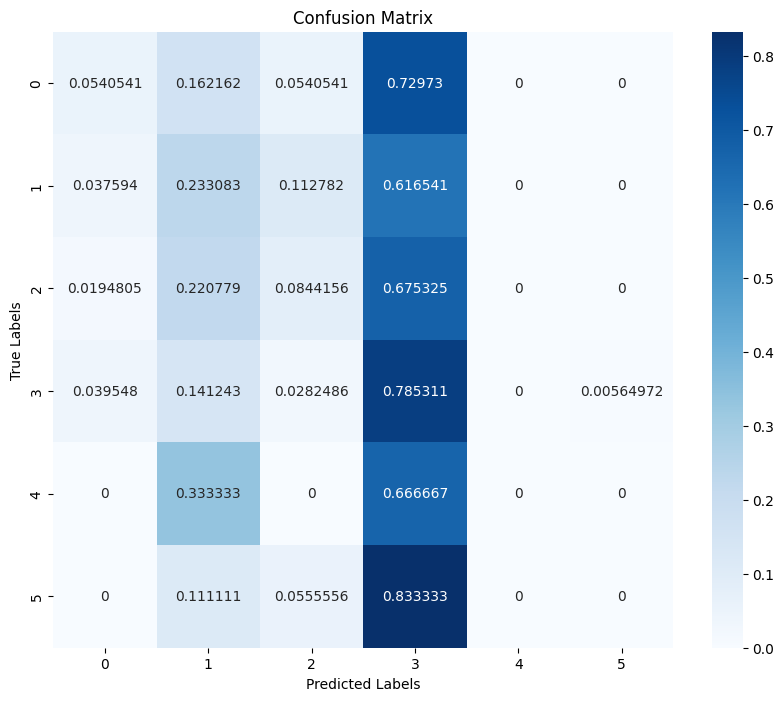

Epoch 7, Validation Loss: 3.3401, Accuracy: 0.3241, F1 Score: 0.2516
Val F1 Score Per Class  [0.08602151 0.25833333 0.13471503 0.47278912 0.         0.        ]


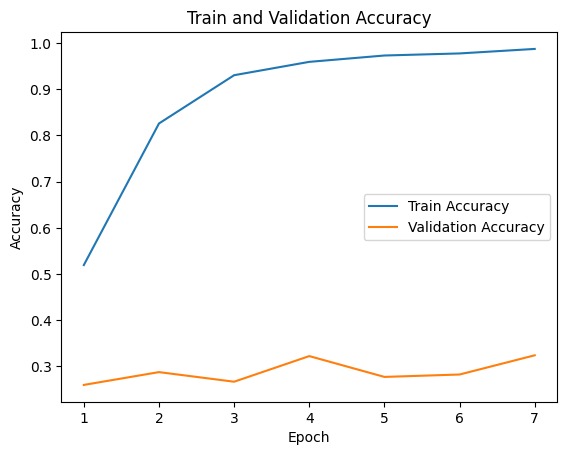

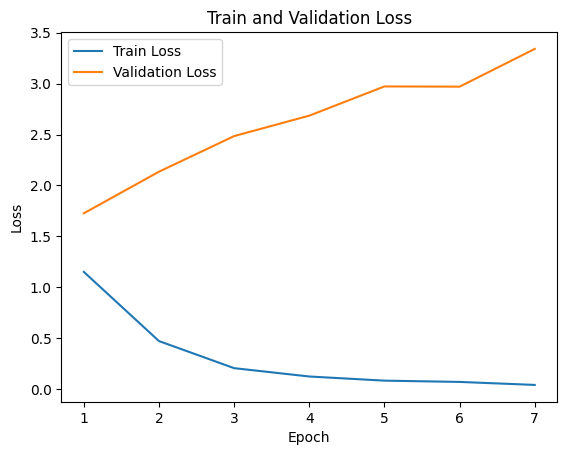

Epoch 8, Train Loss: 0.0577, Accuracy: 0.9822, F1 Score: 0.9822
Train F1 Score Per Class  [0.98733414 0.97277894 0.97513645 0.96703943 0.99882284 0.9918797 ]


Val:   1%|▏         | 1/73 [00:00<00:30,  2.39it/s, loss=4.17]

[tensor([-1.2287, -1.5790, -2.0277,  1.0220, -4.4183, -2.0548], device='cuda:0'), tensor([ 1.7961, -2.7657,  1.4716,  0.9986, -3.2618, -3.4959], device='cuda:0'), tensor([-3.9655, -1.5193,  4.0502, -0.3482, -3.8956, -3.7861], device='cuda:0'), tensor([-2.5288, -1.5672,  5.7194, -0.6611, -3.4356, -2.3822], device='cuda:0'), tensor([ 4.0882, -2.3238, -0.1034, -0.1181, -3.3765, -2.9686], device='cuda:0'), tensor([-2.2453,  2.2668,  4.3645, -1.6111, -4.0867, -4.1050], device='cuda:0'), tensor([-4.2514,  1.2908,  0.9369,  0.9300, -3.3731, -2.4596], device='cuda:0'), tensor([-1.5457, -2.3205,  2.4592,  1.8948, -3.9772, -2.8966], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.40it/s, loss=3.95]

[tensor([-0.3139, -1.0751, -0.1622,  0.8691, -1.7339, -2.4915], device='cuda:0'), tensor([-2.4209, -1.7473,  5.5279, -0.6398, -3.5140, -3.6674], device='cuda:0'), tensor([ 0.5868, -3.3599, -1.0101,  4.1029, -3.5642, -2.3334], device='cuda:0'), tensor([-2.5598, -2.0645, -1.1224,  1.0792,  0.8542,  0.3124], device='cuda:0'), tensor([-0.5630,  0.2289, -0.9232,  4.0424, -4.0472, -2.4197], device='cuda:0'), tensor([-1.1976, -2.6788,  1.2909, -1.4929, -3.7010, -2.2075], device='cuda:0'), tensor([-3.0786, -0.0644,  3.2049, -0.1402, -4.6272, -2.1465], device='cuda:0'), tensor([-1.4202, -2.9712, -1.9275,  4.2708, -4.1839, -2.4608], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=0.832]

[tensor([-2.7620, -2.3043,  0.5480,  4.5793, -3.4571, -3.7233], device='cuda:0'), tensor([-2.6562,  0.4978,  1.3483,  0.8149, -1.8392, -3.1945], device='cuda:0'), tensor([-2.4822,  0.4804,  4.3353, -1.9991, -2.2168, -1.5526], device='cuda:0'), tensor([-3.4364,  0.3823,  0.3878, -1.0257, -3.9782, -3.7017], device='cuda:0'), tensor([ 2.2480, -1.3634, -2.2816,  1.5478, -4.1390, -1.9171], device='cuda:0'), tensor([-2.5262,  2.4927,  2.1691, -1.3250, -4.3554, -3.9250], device='cuda:0'), tensor([-2.0950,  3.6962, -1.6868,  0.7170, -4.5523, -2.1975], device='cuda:0'), tensor([-1.6453, -1.1211,  0.0064,  0.7520, -3.7282, -3.1378], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.38it/s, loss=2.64]

[tensor([ 1.8682, -0.8368, -0.1352, -0.7552, -4.3277, -3.5658], device='cuda:0'), tensor([-2.5505, -1.6285,  0.3600,  5.4433, -2.9593, -3.2714], device='cuda:0'), tensor([-2.6423, -2.0486,  0.5084,  2.2352, -4.1969, -3.7025], device='cuda:0'), tensor([ 1.7311,  0.8213, -1.8616, -0.4102, -4.0847, -1.5425], device='cuda:0'), tensor([-2.4114, -0.8817,  5.7283, -1.1126, -3.4560, -1.9282], device='cuda:0'), tensor([-2.1925, -2.4029, -0.2431,  0.9528, -3.7556, -3.9201], device='cuda:0'), tensor([-1.9462, -2.3227,  1.4884,  0.6747, -4.2939, -2.5790], device='cuda:0'), tensor([ 5.3845, -1.9966, -1.3258,  0.5640, -2.5798, -2.2311], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.37it/s, loss=5.68]

[tensor([-3.6402,  0.6526,  0.3580, -1.5531, -4.1590, -3.0796], device='cuda:0'), tensor([-2.5541, -2.4430,  5.0263, -0.2633, -3.3229, -1.5599], device='cuda:0'), tensor([-2.6183,  4.4722, -1.5696, -0.5676, -3.6591, -2.0900], device='cuda:0'), tensor([-1.6721, -1.2323,  6.6487, -1.4938, -2.5264, -2.5444], device='cuda:0'), tensor([-1.2747, -2.0906,  2.3988, -1.3937, -2.2614,  2.4006], device='cuda:0'), tensor([-2.1276, -0.3006, -0.1165,  0.1639, -3.3362, -2.2509], device='cuda:0'), tensor([-3.3966,  2.1269,  3.7750, -2.0078, -4.5596, -3.3099], device='cuda:0'), tensor([-2.8304, -0.2185,  5.0767, -0.3548, -3.3317, -4.0715], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.37it/s, loss=3.98]

[tensor([-3.2840,  0.7403, -0.9109,  1.6776, -4.3187, -2.8456], device='cuda:0'), tensor([-1.9290, -1.9506, -1.3541,  1.5525, -3.5621, -1.6694], device='cuda:0'), tensor([-3.6688,  0.6859, -0.3663, -0.1682, -4.2715, -0.3367], device='cuda:0'), tensor([-3.6034, -0.1813, -1.7403,  3.8418, -4.9874, -3.3219], device='cuda:0'), tensor([-1.2367, -1.3982, -0.8767,  4.6468, -4.3636, -2.0616], device='cuda:0'), tensor([-3.7824, -0.6002,  4.0022, -0.8881, -4.0727, -3.8450], device='cuda:0'), tensor([-3.4226,  0.8719,  2.1569, -1.7633, -4.5629, -2.2768], device='cuda:0'), tensor([-1.4068,  4.8030, -1.1062, -0.5629, -3.3835, -2.0959], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.36it/s, loss=1.73]

[tensor([-2.1542, -0.5008,  6.3938, -1.7635, -3.5781, -2.9393], device='cuda:0'), tensor([-2.4549, -1.9269,  6.2114, -0.5480, -3.3798, -3.2255], device='cuda:0'), tensor([-0.5778, -2.8978, -0.4132,  3.9714, -3.5074, -1.6068], device='cuda:0'), tensor([-1.7345, -1.8872,  1.5717,  0.2480, -4.6487, -2.8980], device='cuda:0'), tensor([-1.6748, -2.2205,  1.6540, -0.8895, -3.7129, -3.3588], device='cuda:0'), tensor([-2.5893, -2.1741,  0.8981,  4.6454, -4.0140, -1.9125], device='cuda:0'), tensor([-2.0789, -1.6512, -1.5986,  1.2232, -4.1490, -2.2097], device='cuda:0'), tensor([-1.5992, -0.8558,  6.5414, -2.0552, -2.3182, -2.0618], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.37it/s, loss=3.58]

[tensor([-2.7225, -0.3637,  1.0336,  1.7535, -2.9345, -3.1444], device='cuda:0'), tensor([-2.0726,  2.9987, -1.2968, -0.1117, -3.1940, -1.7939], device='cuda:0'), tensor([-0.5609, -1.3089, -0.8458, -1.8131, -4.7742,  3.8018], device='cuda:0'), tensor([-3.0584, -0.2607,  0.4569,  4.9540, -4.1295, -3.3278], device='cuda:0'), tensor([-2.1685, -1.0994, -0.7127,  1.5394, -3.8759, -2.3718], device='cuda:0'), tensor([-2.1699, -2.2309, -0.4547,  0.2127, -3.8591, -2.4568], device='cuda:0'), tensor([ 1.3437, -2.8730,  0.6987,  1.2953, -4.2361, -3.3155], device='cuda:0'), tensor([-3.8961, -0.3289,  0.0523,  3.1103, -3.6327, -3.0650], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:27,  2.36it/s, loss=2.49]

[tensor([-3.6319,  4.5074,  0.4125, -0.0372, -4.5356, -2.1228], device='cuda:0'), tensor([-2.2963, -1.4328,  2.4722,  0.3491, -3.2019, -2.2115], device='cuda:0'), tensor([ 0.1902, -2.2229, -1.5181,  2.9418, -4.3701, -3.0394], device='cuda:0'), tensor([-2.3674,  0.2436, -1.5814,  3.5980, -5.1146, -3.0684], device='cuda:0'), tensor([-1.3617, -2.3587,  0.7023,  3.6160, -5.1463, -3.3952], device='cuda:0'), tensor([-1.5431, -1.9464, -1.9690,  2.2443, -4.6441, -2.8914], device='cuda:0'), tensor([-3.3316,  0.8199,  4.0480, -1.2592, -3.7590, -3.4134], device='cuda:0'), tensor([-2.1509, -2.4411,  0.3162,  2.8424, -5.3709, -1.7240], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.36it/s, loss=4.5]

[tensor([-2.9308, -1.4402,  0.2382,  4.8132, -3.5832, -3.3401], device='cuda:0'), tensor([-2.0794, -1.6862, -0.3708,  2.1959, -3.9161, -2.2803], device='cuda:0'), tensor([-2.6269, -0.3805,  0.8060, -0.4273, -3.7008, -4.0418], device='cuda:0'), tensor([-3.8978,  0.1875,  4.0684, -0.9184, -4.0511, -4.0126], device='cuda:0'), tensor([-3.7166,  1.7157,  3.6504, -1.8506, -3.9324, -3.5274], device='cuda:0'), tensor([-3.4621, -1.3285, -0.7526,  3.8927, -3.8100, -2.6561], device='cuda:0'), tensor([-1.2210,  0.1674, -0.2365, -1.4809, -3.4714, -3.8445], device='cuda:0'), tensor([-1.5009, -1.4546,  0.0693,  2.8231, -3.9802, -4.0281], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.37it/s, loss=2.84]

[tensor([-3.6383,  3.0294,  1.4746, -0.4247, -3.3293, -3.3511], device='cuda:0'), tensor([-1.8051, -1.7839,  2.2263, -0.5427, -3.2390, -2.2494], device='cuda:0'), tensor([-3.3878, -1.0940,  1.5274,  1.9568, -4.2588, -3.6523], device='cuda:0'), tensor([-2.5466, -2.2000,  2.8734,  1.2718, -2.8840, -2.5951], device='cuda:0'), tensor([-2.9036,  0.1101,  4.6893, -0.2409, -3.9355, -3.2855], device='cuda:0'), tensor([-2.6863, -1.8295, -1.0099,  5.7131, -3.1851, -2.0850], device='cuda:0'), tensor([-2.5946, -1.4371, -0.4343,  4.3513, -4.6444, -3.5002], device='cuda:0'), tensor([-2.3821, -1.4067,  1.0497,  2.9366, -4.8698, -2.2947], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.37it/s, loss=1.36]

[tensor([-1.9478, -0.0626,  1.6146, -2.0650, -4.4935, -3.3356], device='cuda:0'), tensor([-2.2004, -1.7364,  3.3279, -0.0541, -4.9529, -3.3242], device='cuda:0'), tensor([-2.9870, -2.3616,  2.5574,  1.0271, -4.6521, -2.1091], device='cuda:0'), tensor([-1.5159, -1.4992,  0.5039, -0.0936, -5.2081, -1.5870], device='cuda:0'), tensor([-1.6770,  0.6848,  0.6630, -0.0595, -4.4930, -3.6635], device='cuda:0'), tensor([-2.7656,  1.6374,  2.0795, -0.4001, -4.3283, -3.7667], device='cuda:0'), tensor([-3.3357, -0.0784,  3.4016, -2.0250, -4.0411, -1.7476], device='cuda:0'), tensor([-1.5423, -2.2766,  0.0090,  4.1037, -4.9418, -3.0254], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.37it/s, loss=3.01]

[tensor([-2.7764,  3.0898, -1.9365,  0.7625, -2.9860, -0.8838], device='cuda:0'), tensor([-2.0391, -2.1817,  2.5565,  2.8439, -5.0749, -3.8209], device='cuda:0'), tensor([-0.7705, -0.9689, -2.4708,  1.8598, -4.2090, -3.9006], device='cuda:0'), tensor([-2.8275, -1.0244,  5.1725,  0.7322, -4.3699, -2.9412], device='cuda:0'), tensor([-3.0667,  0.3239,  0.5059,  0.6645, -4.3335, -3.1034], device='cuda:0'), tensor([ 0.0996, -2.4560, -0.8675,  0.6825, -4.5069, -3.4685], device='cuda:0'), tensor([-3.4734,  2.3361, -0.7251, -1.2369, -3.9125, -3.3031], device='cuda:0'), tensor([ 1.2229, -0.3983, -0.2058,  0.9669, -4.1441, -2.2961], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.37it/s, loss=2.37]

[tensor([-1.6615, -0.2314,  5.4447, -2.0357, -3.7901, -3.4668], device='cuda:0'), tensor([-1.6567,  0.2125, -0.3605, -0.2949, -4.4582, -4.5246], device='cuda:0'), tensor([-1.0397, -1.3549, -0.7418, -0.0659, -4.9474, -3.8044], device='cuda:0'), tensor([-2.3575, -2.3576,  3.2210, -0.3351, -3.9911, -3.5523], device='cuda:0'), tensor([-2.8647,  4.4999, -0.1557, -1.1229, -3.7948, -3.3680], device='cuda:0'), tensor([-1.6636,  0.1469,  1.5804,  0.3574, -4.5878, -4.3395], device='cuda:0'), tensor([-3.2980,  0.6748, -0.0503,  1.2640, -3.9808, -3.5143], device='cuda:0'), tensor([-0.0076, -1.2773, -0.0276,  1.3225, -4.7993, -3.5065], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.37it/s, loss=3.23]

[tensor([-2.6223, -0.6146,  1.7079,  3.6054, -4.5027, -4.6719], device='cuda:0'), tensor([-3.5300, -1.1916,  0.7493,  0.4966, -4.1831,  1.9138], device='cuda:0'), tensor([-2.0884, -1.8504,  5.3597, -0.9846, -3.8068, -0.5081], device='cuda:0'), tensor([-3.3281,  1.5060,  3.5053, -0.8828, -3.7693, -3.1513], device='cuda:0'), tensor([-1.8352, -0.2818,  5.6882, -2.1576, -2.8261, -2.0807], device='cuda:0'), tensor([ 1.3803, -3.1077, -0.6613,  2.1450, -3.8556, -1.9646], device='cuda:0'), tensor([-1.5719, -0.9265, -1.6261,  2.6058, -3.1474, -2.0897], device='cuda:0'), tensor([-2.7194, -0.2279,  0.2503,  3.4537, -4.1741, -3.7412], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=4.02]

[tensor([ 1.0918, -1.6523, -0.4810,  3.9080, -4.3747, -3.6581], device='cuda:0'), tensor([-3.9191, -1.3439,  0.7937,  3.6676, -4.1258, -3.1399], device='cuda:0'), tensor([-2.7257, -1.2011, -0.2934, -1.0394, -2.9772,  6.3158], device='cuda:0'), tensor([-0.6981, -2.7566,  1.2312,  3.5159, -4.1625, -3.0620], device='cuda:0'), tensor([ 1.2513, -2.0282, -0.0470, -0.0591, -3.6991, -3.4870], device='cuda:0'), tensor([-0.7223,  0.0844,  0.0460,  0.9701, -4.5128, -3.2554], device='cuda:0'), tensor([-3.5159, -0.5685, -1.6961,  3.2892, -3.4466, -2.4460], device='cuda:0'), tensor([ 6.0171, -1.8860, -2.8728, -0.1322, -2.2319, -1.2973], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.38it/s, loss=4.02]

[tensor([-2.5517,  2.0351, -0.6899, -1.0797, -3.6048, -2.6982], device='cuda:0'), tensor([-2.4150,  4.8880, -0.6998,  0.6284, -4.2841, -3.9618], device='cuda:0'), tensor([-3.3350, -2.1487,  0.6680,  0.2337, -3.9676,  0.7979], device='cuda:0'), tensor([-2.9666, -2.6326,  1.0930,  3.0104, -3.7562, -3.3424], device='cuda:0'), tensor([ 3.8711, -1.1326, -0.7018, -0.4169, -3.9063, -3.9842], device='cuda:0'), tensor([-3.0433,  1.0068,  3.2894, -1.4358, -4.4785, -4.5980], device='cuda:0'), tensor([-2.9036, -0.8595,  4.1934,  1.0986, -5.2819, -3.3245], device='cuda:0'), tensor([-3.1554, -0.9678,  3.6316,  0.5032, -3.9021, -2.8829], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.38it/s, loss=2.47]

[tensor([-1.8285, -1.2303, -0.4944,  1.6741, -4.2835, -2.7520], device='cuda:0'), tensor([-2.2540, -1.9615,  2.2372,  0.8173, -2.7289, -2.5105], device='cuda:0'), tensor([-2.2713,  0.1460,  1.3132,  0.9150, -3.8915, -3.0762], device='cuda:0'), tensor([-2.8642, -1.8982,  0.1964,  2.8572, -3.3919, -3.1846], device='cuda:0'), tensor([-2.3464,  0.0417, -0.9395,  3.5754, -4.0202, -1.2849], device='cuda:0'), tensor([-2.4343,  0.5248,  0.4494,  0.4538, -5.8726, -3.9755], device='cuda:0'), tensor([-2.0250, -2.0831,  0.0782,  3.0462, -4.3441, -3.9520], device='cuda:0'), tensor([-3.1683,  0.5440,  3.9394, -0.9061, -4.8555, -4.0305], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:22,  2.38it/s, loss=3.65]

[tensor([-3.6785, -1.4441,  1.5202,  0.6679, -3.3020, -2.3397], device='cuda:0'), tensor([-2.5114, -2.2416,  1.6942,  0.8560, -2.7064, -3.3659], device='cuda:0'), tensor([-1.6100, -1.5882,  5.2611, -1.2016, -3.6969, -0.9178], device='cuda:0'), tensor([-3.1597,  3.3079, -0.4913,  0.8311, -2.5906, -3.3145], device='cuda:0'), tensor([-3.6557,  3.4057, -0.1944,  0.4567, -3.1333, -2.7910], device='cuda:0'), tensor([-1.5791,  5.1680, -0.8155, -1.0748, -3.3675, -2.9330], device='cuda:0'), tensor([-1.8705, -1.7762, -0.0178,  5.7757, -4.1913, -3.0143], device='cuda:0'), tensor([-0.2530, -1.8459, -1.5520,  3.2555, -2.8074, -3.8049], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.38it/s, loss=2.53]

[tensor([-3.5284,  2.3835,  0.2686, -0.1877, -3.3447, -1.1431], device='cuda:0'), tensor([-3.0579, -1.6195,  1.3974,  3.7581, -4.8754, -3.0798], device='cuda:0'), tensor([-2.8424, -1.7943,  3.2358, -0.6855, -3.9970, -2.8061], device='cuda:0'), tensor([-2.7220,  0.5832,  4.6835, -1.9462, -3.7588, -2.9389], device='cuda:0'), tensor([-3.2198, -0.9056,  0.3002,  3.1231, -3.7876, -4.0038], device='cuda:0'), tensor([-3.6185,  0.2551,  3.4517, -1.0957, -4.5867, -2.9462], device='cuda:0'), tensor([-1.2496, -0.9022,  0.1343,  0.3260, -3.1665, -2.4142], device='cuda:0'), tensor([-3.0376,  3.7922, -0.0141, -0.5729, -2.9825, -3.4881], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=4.73]

[tensor([-2.0228, -0.9552,  5.4682, -1.6254, -3.0984, -2.7467], device='cuda:0'), tensor([-2.1340,  6.0369, -0.1551, -1.0571, -3.7069, -2.5252], device='cuda:0'), tensor([-2.6503, -1.2942,  0.7225,  2.9882, -4.1927, -4.3045], device='cuda:0'), tensor([-3.7689,  0.7753,  0.2640,  1.1351, -4.9640, -2.7012], device='cuda:0'), tensor([-1.7820,  1.8490, -1.8010, -1.3630, -3.0684, -0.9784], device='cuda:0'), tensor([-2.0573, -1.2623, -1.9910, -0.2868, -3.7779, -2.8560], device='cuda:0'), tensor([-1.8289,  3.6117, -0.5846, -1.6920, -3.8258, -2.3009], device='cuda:0'), tensor([-1.0993, -1.5235,  1.6837,  2.8583, -4.1152, -4.0732], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=2.76]

[tensor([ 0.3022, -2.6021,  1.0374,  0.3952, -4.3115, -3.1228], device='cuda:0'), tensor([-0.3446, -1.8995,  5.5902, -1.2687, -3.2691, -2.6310], device='cuda:0'), tensor([-3.5279,  0.6192,  1.4783,  1.7143, -5.0965, -3.8887], device='cuda:0'), tensor([-3.0431, -1.8145,  0.2587,  4.6385, -4.0002, -2.9322], device='cuda:0'), tensor([-2.6951,  2.0158, -0.2190, -1.2038, -4.4855, -3.6720], device='cuda:0'), tensor([ 0.0452, -2.8487,  0.1041,  4.0522, -4.7782, -2.2614], device='cuda:0'), tensor([-2.1140, -2.7975,  1.9163,  1.2960, -4.4495, -2.8781], device='cuda:0'), tensor([-2.6854, -0.7789,  5.6483, -1.1113, -3.9470, -3.4326], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.37it/s, loss=3.56]

[tensor([-2.3949, -2.2343, -0.6310, -1.8531, -3.5486, -3.5293], device='cuda:0'), tensor([-3.7931,  4.4965,  1.3547, -1.1611, -3.7047, -2.9858], device='cuda:0'), tensor([-2.4494, -0.3101, -0.2406,  2.3260, -5.1153, -3.8408], device='cuda:0'), tensor([-1.8056,  5.0492, -1.6076, -1.4406, -2.1298, -0.9910], device='cuda:0'), tensor([-2.5690, -0.8175, -0.0349, -1.0588, -3.9031, -2.9218], device='cuda:0'), tensor([-2.5807,  2.4109, -0.2552,  1.2957, -3.8919, -3.5031], device='cuda:0'), tensor([-1.4947, -2.4392, -0.5381, -1.1302, -3.7320,  3.0927], device='cuda:0'), tensor([-3.5166,  2.2469, -2.0160,  0.0311, -4.2532, -2.3272], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.37it/s, loss=4.06]

[tensor([-2.4458, -1.7240,  6.2451, -0.1786, -3.1636, -3.2580], device='cuda:0'), tensor([-2.1514, -0.9280,  2.4739,  2.1448, -5.1185, -3.7225], device='cuda:0'), tensor([-3.6100, -1.0112,  0.6099,  2.5816, -4.5133, -3.2363], device='cuda:0'), tensor([-3.1136, -1.6339, -1.5555,  4.7502, -4.2047, -2.7696], device='cuda:0'), tensor([-1.3381, -2.2795, -0.3854,  4.4893, -4.5421, -3.1288], device='cuda:0'), tensor([-2.2280, -2.0796,  0.2722,  3.4513, -4.6347, -3.4580], device='cuda:0'), tensor([-1.1052, -0.6892, -1.2504, -3.1531, -0.7625,  1.8662], device='cuda:0'), tensor([-2.9419, -1.4394, -0.0474,  2.1664, -4.5436, -3.5466], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=2.63]

[tensor([-2.4574, -1.5089,  6.0907, -0.7609, -3.4787, -3.3603], device='cuda:0'), tensor([-3.6350,  2.6801,  2.0949, -1.0561, -3.7543, -3.3719], device='cuda:0'), tensor([-3.1037, -1.2126, -0.7874,  1.8451, -3.4957, -2.6021], device='cuda:0'), tensor([-2.8822,  0.1029, -0.4655,  1.0832, -4.0985, -2.7697], device='cuda:0'), tensor([-2.4854, -0.7561, -1.6588, -0.0432, -4.1132, -2.7840], device='cuda:0'), tensor([-1.5691, -2.5369,  0.5225, -0.1969, -3.1647, -2.9031], device='cuda:0'), tensor([-1.0443, -1.7531, -1.6179,  5.6473, -4.3625, -3.1134], device='cuda:0'), tensor([-1.8474,  0.5564, -0.7298, -1.4038, -4.3716, -1.5626], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.37it/s, loss=1.49]

[tensor([-1.6925, -1.9649, -0.6359,  5.5051, -4.0692, -2.9999], device='cuda:0'), tensor([-3.2561, -1.9737, -0.3278,  3.1889, -4.7328, -2.5273], device='cuda:0'), tensor([-1.4968, -3.4095,  2.4724, -0.3645, -4.7320,  0.5267], device='cuda:0'), tensor([ 2.8247, -0.5502,  0.3253, -1.8524, -3.9837, -1.6965], device='cuda:0'), tensor([-2.1962,  3.6244,  0.1996,  0.9310, -4.8148, -3.1549], device='cuda:0'), tensor([ 2.0213, -3.5606, -0.0684,  2.8569, -3.9921, -1.3503], device='cuda:0'), tensor([-2.3525, -0.1217, -1.6373,  0.7626, -2.9281, -3.3014], device='cuda:0'), tensor([-2.7651, -0.2028,  3.3533, -0.7607, -4.6056, -2.6519], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.37it/s, loss=2.81]

[tensor([-3.5026,  0.9212,  0.3378,  2.5726, -4.3429, -3.2331], device='cuda:0'), tensor([-3.0341,  0.0835, -0.5713,  0.6764, -3.8174, -3.8976], device='cuda:0'), tensor([-1.8064, -0.8131, -1.0661,  2.8714, -4.5895, -3.0796], device='cuda:0'), tensor([-2.2609, -2.0934,  4.6207, -0.7014, -4.2821, -2.6908], device='cuda:0'), tensor([-2.4973,  4.4573, -0.1786, -1.2871, -3.1037, -2.2175], device='cuda:0'), tensor([-1.8348, -1.0275,  0.4595,  1.5309, -4.9770, -3.5263], device='cuda:0'), tensor([-2.1252, -2.4640,  2.2450,  1.7739, -4.7662, -3.1409], device='cuda:0'), tensor([-3.1671,  2.7209, -0.9989,  2.4971, -5.0708, -2.6194], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.37it/s, loss=3.24]

[tensor([ 4.4429, -2.4958, -1.0072,  1.6577, -3.8230, -3.3838], device='cuda:0'), tensor([-1.6079, -2.1350, -0.7233,  5.1806, -3.6420, -3.2448], device='cuda:0'), tensor([-1.3902,  0.5969, -0.4652, -1.6766, -4.3240, -1.1824], device='cuda:0'), tensor([-3.5174, -0.7377,  4.0879,  2.1415, -3.9992, -3.6034], device='cuda:0'), tensor([-2.4166, -1.8480, -0.2914,  4.2755, -4.1609, -4.0411], device='cuda:0'), tensor([-3.2864,  2.7667,  3.1671,  0.3238, -4.7014, -3.8074], device='cuda:0'), tensor([-2.5938,  0.2741,  2.3809, -1.4993, -4.5069, -3.1736], device='cuda:0'), tensor([-2.7833,  1.5962,  1.6494, -2.2982, -4.7014, -3.5545], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=3.21]

[tensor([-3.1778, -0.7892,  0.1212,  4.7913, -3.7437, -2.9979], device='cuda:0'), tensor([-3.4448,  1.5361, -0.3106, -1.4871, -3.4277, -0.3844], device='cuda:0'), tensor([-3.4420, -1.6786,  4.6498, -0.0829, -2.8900, -1.9060], device='cuda:0'), tensor([-2.8295, -1.1446,  2.0454,  2.2359, -4.0860, -3.8031], device='cuda:0'), tensor([-1.6161,  3.0473, -0.3264, -1.2788, -5.2251, -2.9851], device='cuda:0'), tensor([-2.0160, -1.4533, -0.1960, -0.2402, -5.0177, -2.8415], device='cuda:0'), tensor([-2.6394, -2.8001,  1.5345,  2.0923, -3.0683, -2.4141], device='cuda:0'), tensor([-3.1962,  0.7294,  2.6713,  0.9265, -3.9440, -3.6118], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=2.98]

[tensor([-3.7470,  3.1416,  0.3229, -0.8121, -3.7617, -2.0296], device='cuda:0'), tensor([-3.0649,  1.0798,  2.3101,  0.5918, -4.1320, -3.5376], device='cuda:0'), tensor([-2.1222, -1.2990, -1.9236,  0.8195, -3.5174, -2.7199], device='cuda:0'), tensor([-1.7096, -2.1441, -0.1395,  5.3276, -3.6494, -3.0121], device='cuda:0'), tensor([-2.7239, -1.4220, -1.0456, -1.0233, -5.2742, -3.2761], device='cuda:0'), tensor([-2.0975, -3.2602,  3.1456,  1.6360, -3.7062, -2.9719], device='cuda:0'), tensor([-1.2575, -1.8633,  3.2394, -0.2401, -4.7393, -2.8574], device='cuda:0'), tensor([-1.8837, -1.5836,  0.5829, -1.1988, -4.0304,  5.5132], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.38it/s, loss=1.39]

[tensor([-2.3776, -1.8619, -0.8818,  5.7546, -3.9902, -2.2053], device='cuda:0'), tensor([-1.9788, -1.3398, -1.0354,  1.6205, -4.3628, -0.7274], device='cuda:0'), tensor([-3.1972, -1.3313,  1.9719,  0.9614, -4.6680, -0.4735], device='cuda:0'), tensor([-2.3950,  1.9363, -0.0359, -1.0556, -4.0900, -2.2785], device='cuda:0'), tensor([-3.2588,  1.7969, -0.8897, -0.4011, -3.2363, -2.6145], device='cuda:0'), tensor([ 6.4565, -1.4201, -2.4505, -0.8205, -2.6252, -0.0407], device='cuda:0'), tensor([-2.3215, -2.3708,  1.7362,  2.6822, -3.7594, -3.6170], device='cuda:0'), tensor([-2.8930, -0.9241,  1.1246,  1.1562, -4.1350, -3.4597], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=3.94]

[tensor([-3.6282,  0.7584, -0.5219, -1.4865, -3.8723,  2.8200], device='cuda:0'), tensor([-2.8253, -0.9618, -1.3108,  5.9187, -3.4674, -2.6644], device='cuda:0'), tensor([-2.2763,  5.4378, -0.9955, -1.0115, -2.2932, -3.1046], device='cuda:0'), tensor([-3.3201,  1.8155, -0.7271, -0.5115, -0.9837, -0.3336], device='cuda:0'), tensor([ 1.7887, -2.6368, -0.3013,  0.0744, -3.0516, -1.4543], device='cuda:0'), tensor([-1.7561, -2.8125,  2.3800,  1.3430, -4.0910, -2.8734], device='cuda:0'), tensor([-1.5174, -1.2395,  2.3899,  0.3664, -4.7640, -3.1701], device='cuda:0'), tensor([ 0.1784, -1.7616,  0.9886,  0.9692, -5.2913, -3.8028], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:17,  2.32it/s, loss=2.75]

[tensor([-3.8127, -1.4153,  3.0598, -0.1463, -3.9217, -1.7804], device='cuda:0'), tensor([-2.8331,  2.6974, -0.9077,  1.5329, -4.1000, -2.8654], device='cuda:0'), tensor([-1.8201,  0.1299, -0.8387,  2.9037, -5.2264, -1.4685], device='cuda:0'), tensor([-3.8353,  0.9070,  2.9284, -1.7917, -4.1061, -3.6564], device='cuda:0'), tensor([-2.3798, -1.2618,  6.0549, -1.0454, -2.9089, -2.5991], device='cuda:0'), tensor([-2.0324, -2.3340, -0.2165,  5.6625, -3.1058, -2.3566], device='cuda:0'), tensor([-2.2886, -1.1244, -0.6564,  0.9195, -5.3929, -3.4654], device='cuda:0'), tensor([-2.9143, -0.9503, -1.2384,  1.6179, -3.9989, -2.6880], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.34it/s, loss=4.13]

[tensor([ 6.0120,  0.0278, -2.3242, -0.6539, -2.7567, -2.5212], device='cuda:0'), tensor([-3.3189, -0.7733,  1.8302, -0.6442, -4.5029, -4.3607], device='cuda:0'), tensor([-2.0374,  2.9522, -2.2998,  0.1073, -1.6888, -2.1683], device='cuda:0'), tensor([-3.2272, -2.4260, -0.0165,  4.4657, -4.6472, -1.7314], device='cuda:0'), tensor([-2.6606, -1.0303, -1.2237,  3.5273, -3.6871, -3.6364], device='cuda:0'), tensor([-3.4194,  3.1182, -0.1890, -0.1844, -3.7971, -2.0614], device='cuda:0'), tensor([-1.7405, -2.9798,  1.1476,  0.1120, -3.7065, -3.2628], device='cuda:0'), tensor([-2.0481, -0.7516,  6.5627, -1.5895, -3.0358, -2.5010], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.32it/s, loss=2.31]

[tensor([-3.3961, -0.7708,  0.5787,  2.6661, -4.9222, -4.0222], device='cuda:0'), tensor([-2.6509, -0.7070, -0.2171, -0.5386, -4.1708, -3.2535], device='cuda:0'), tensor([-1.7411, -2.7320,  0.8801,  2.7364, -3.9376, -3.1786], device='cuda:0'), tensor([-1.5599e+00, -9.1265e-01,  5.2139e+00,  4.8576e-03, -4.3975e+00,
        -3.4007e+00], device='cuda:0'), tensor([-1.0745, -0.5441,  0.4503,  1.7714, -5.1927, -2.9915], device='cuda:0'), tensor([-0.5790, -3.5660,  0.1122,  2.0374, -3.3317, -2.6228], device='cuda:0'), tensor([-2.1910, -1.9726,  3.5145,  0.8294, -4.3374, -3.2555], device='cuda:0'), tensor([-0.7366, -2.1230,  0.0851,  4.1494, -3.5387, -2.8226], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.34it/s, loss=3.76]

[tensor([-2.8550,  0.8392,  2.4313, -1.2345, -3.6489, -3.2057], device='cuda:0'), tensor([-1.8783, -0.2495,  5.7860, -2.4869, -3.1264, -3.2240], device='cuda:0'), tensor([-1.9131, -1.3517,  3.6446, -0.2642, -4.2502, -2.9101], device='cuda:0'), tensor([-3.1830,  4.0999, -1.4960, -1.3228, -4.7060, -1.8969], device='cuda:0'), tensor([-2.9071, -1.4214,  3.2513,  0.6821, -4.2223, -3.2179], device='cuda:0'), tensor([-2.9226, -2.6067,  0.2143,  5.4271, -4.3166, -3.5308], device='cuda:0'), tensor([-2.1381, -1.8148,  2.5723,  2.1145, -4.4065, -3.8809], device='cuda:0'), tensor([-2.3834, -0.9241, -0.1338,  5.0517, -4.3042, -3.0593], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.35it/s, loss=4.02]

[tensor([-0.2099, -2.3164, -1.5696,  4.2985, -3.3083, -2.6897], device='cuda:0'), tensor([-2.5020, -2.3033,  2.0387,  1.5106, -3.7298, -3.1212], device='cuda:0'), tensor([-2.5052, -2.0700, -1.0904,  4.5695, -3.0860, -1.9344], device='cuda:0'), tensor([-3.5407,  4.1179,  0.8573, -1.5742, -3.9808, -2.0849], device='cuda:0'), tensor([-2.5634,  2.0109,  2.6839, -1.1975, -3.8512, -3.3497], device='cuda:0'), tensor([-1.9505,  0.3447,  1.3241, -0.9997, -4.2645, -3.7709], device='cuda:0'), tensor([-0.5810, -1.8931,  0.6451,  2.6863, -4.8655, -4.1419], device='cuda:0'), tensor([-2.6580,  0.0351,  0.1978,  3.4482, -4.4538, -3.4932], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.35it/s, loss=1.53]

[tensor([-2.2605, -1.8460,  4.5956, -0.3916, -3.4246, -1.9925], device='cuda:0'), tensor([-1.7903, -0.7773, -1.0258, -0.7416, -4.0489,  1.4312], device='cuda:0'), tensor([-2.0423, -2.2489,  1.2878,  0.8617, -4.6619, -3.2512], device='cuda:0'), tensor([-1.0996, -1.9513, -1.4242,  1.6385, -3.1287, -2.8907], device='cuda:0'), tensor([-1.5165, -1.2589,  1.8705,  0.6503, -3.6745, -4.2050], device='cuda:0'), tensor([-0.9548,  4.4949, -1.6940, -0.8030, -3.5770, -2.4495], device='cuda:0'), tensor([-3.9213,  1.2519,  0.9050, -0.4252, -3.7668, -3.3668], device='cuda:0'), tensor([-2.9836, -0.8614,  1.8916,  2.7320, -4.7772, -3.5530], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.36it/s, loss=2.38]

[tensor([-3.3675, -1.7806,  2.7395,  0.8714, -4.0341, -3.6469], device='cuda:0'), tensor([-2.5830, -0.5985,  2.4320, -1.0724, -3.8956, -3.1799], device='cuda:0'), tensor([ 0.7959, -3.0248, -1.0674,  0.0676, -3.8531, -2.3509], device='cuda:0'), tensor([-1.4344, -2.5315,  2.7871,  3.7917, -4.7101, -3.0980], device='cuda:0'), tensor([-3.4392, -0.9728,  0.2648,  0.0174, -5.0494, -3.7308], device='cuda:0'), tensor([-3.3006, -1.8232,  1.7374,  1.3663, -4.2901, -2.6958], device='cuda:0'), tensor([ 3.0069, -2.3417,  1.5719, -0.4099, -3.7115, -2.7194], device='cuda:0'), tensor([-4.2606,  1.7592,  1.2192, -0.8031, -5.4808,  0.0160], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.36it/s, loss=3.57]

[tensor([ 4.4055, -2.0630, -1.6005,  1.4944, -3.7542, -3.1419], device='cuda:0'), tensor([-0.3699, -2.4395,  1.8833, -0.3917, -4.1063, -3.3232], device='cuda:0'), tensor([-2.3682, -0.7963,  4.4846, -0.9801, -4.6044, -2.9562], device='cuda:0'), tensor([ 0.1082, -1.3275, -2.2671,  3.8150, -3.8470, -3.6565], device='cuda:0'), tensor([-3.9345, -1.3574, -0.5671,  4.7415, -3.5802, -1.0473], device='cuda:0'), tensor([ 0.3508, -1.6653, -1.7951,  2.2579, -3.4495, -3.5853], device='cuda:0'), tensor([-2.8055, -0.7016,  1.8880,  1.2846, -4.3787, -3.0817], device='cuda:0'), tensor([-1.1389, -1.4157, -1.7869,  3.7286, -4.2981, -0.1215], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.36it/s, loss=3.1]

[tensor([-2.7083, -2.4897,  1.4783,  2.4790, -3.7887, -2.6820], device='cuda:0'), tensor([-1.0230,  1.2078,  1.3672, -0.0423, -3.3074, -3.8194], device='cuda:0'), tensor([-2.8007,  0.9490, -0.1413,  2.0372, -4.1390, -3.9901], device='cuda:0'), tensor([-3.7306, -0.5494,  0.4250,  4.8463, -3.8448, -3.3163], device='cuda:0'), tensor([-1.9438,  2.5389, -1.0024,  1.5688, -4.1060, -4.0145], device='cuda:0'), tensor([-2.5618, -1.8252, -0.0279,  4.9432, -4.1298, -3.3438], device='cuda:0'), tensor([-2.9964, -1.2936, -0.5477,  1.7086, -4.2948, -3.4432], device='cuda:0'), tensor([-3.0950,  2.7105, -0.8322,  1.1455, -3.8152, -3.8191], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.37it/s, loss=3.02]

[tensor([-2.2499, -2.6388,  1.1944,  3.5635, -3.7510, -3.1227], device='cuda:0'), tensor([ 6.8925, -1.9078, -1.0857, -0.4989, -2.3955, -1.6660], device='cuda:0'), tensor([-0.2813, -2.4784, -0.6185,  2.7827, -4.9528, -2.9946], device='cuda:0'), tensor([ 3.1049, -2.2038, -2.5792,  1.1908, -3.2340, -1.8948], device='cuda:0'), tensor([-3.0824, -1.4875,  3.6288,  1.0459, -3.6114, -3.2482], device='cuda:0'), tensor([-1.5698, -2.0086, -0.6654,  6.0886, -3.4281, -2.9302], device='cuda:0'), tensor([-3.3396,  0.1840,  1.1776,  2.5877, -4.0871, -2.4912], device='cuda:0'), tensor([-1.1096, -1.0416,  5.7108, -1.0633, -3.4714, -3.1789], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.36it/s, loss=1.58]

[tensor([-3.8318,  1.5765,  1.7639,  0.1471, -4.7227, -3.5809], device='cuda:0'), tensor([-3.2901, -0.4928,  4.1837, -0.9682, -3.8789, -2.4606], device='cuda:0'), tensor([ 1.9546, -1.4220, -1.2748,  1.0565, -4.2607, -2.4256], device='cuda:0'), tensor([-2.4621,  0.8198, -1.1778,  1.0723, -4.2947, -0.3287], device='cuda:0'), tensor([-3.1605,  2.5529, -1.2200, -0.2728, -3.7701, -3.1857], device='cuda:0'), tensor([-2.4626, -0.1361,  6.2144, -1.5367, -2.7056, -2.8922], device='cuda:0'), tensor([-3.4095, -1.0366,  5.3920, -0.7741, -3.2034, -2.4058], device='cuda:0'), tensor([-3.2488, -1.1991, -0.6191,  0.7844, -4.7118, -2.7421], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.36it/s, loss=3.33]

[tensor([-1.7754, -0.1218,  0.2446,  3.2985, -2.8858, -3.5343], device='cuda:0'), tensor([-0.9535, -2.0919, -0.4810,  0.8569, -4.5255, -3.3615], device='cuda:0'), tensor([ 0.3585,  0.9711, -1.9959, -0.6332, -5.5103, -2.5669], device='cuda:0'), tensor([-2.4184, -1.7518,  0.0434, -1.5809, -2.0442,  6.3107], device='cuda:0'), tensor([-3.3323, -1.0123,  1.5089,  2.1878, -3.5291, -4.0971], device='cuda:0'), tensor([-2.5400, -1.2907, -0.2934,  1.7530, -4.6243, -2.3604], device='cuda:0'), tensor([-2.4139,  0.1135,  4.1136, -0.1753, -4.4795, -4.4263], device='cuda:0'), tensor([-3.1862, -0.7443,  0.5906,  1.9564, -4.6230, -3.0804], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:19<00:11,  2.36it/s, loss=3.58]

[tensor([-2.0923, -0.3819, -0.5284,  0.1186, -4.4216, -3.0246], device='cuda:0'), tensor([-2.7277,  5.0950,  0.9702, -2.0635, -2.9584, -2.1576], device='cuda:0'), tensor([-1.8419,  1.2851,  1.1249, -1.5674, -4.4249, -3.2061], device='cuda:0'), tensor([-3.7253,  1.0476, -0.1231,  3.7974, -4.3410, -3.4302], device='cuda:0'), tensor([-2.6675, -2.3779, -1.0154,  4.8787, -4.4644, -0.3101], device='cuda:0'), tensor([ 0.9912, -1.1012, -1.6599,  2.0516, -4.3316, -1.8557], device='cuda:0'), tensor([-0.6464,  0.9033, -1.1119, -3.6413, -2.1089, -3.0508], device='cuda:0'), tensor([-3.8551,  1.1154,  0.8819, -0.5845, -4.7068, -3.4992], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.35it/s, loss=4.72]

[tensor([-1.5254, -2.4157,  0.2995,  4.9505, -3.9775, -3.4962], device='cuda:0'), tensor([-2.8408,  0.9726, -0.1243, -1.9479, -3.7042, -2.6287], device='cuda:0'), tensor([-3.2171, -0.7071,  0.0522,  3.0871, -4.8706, -2.9095], device='cuda:0'), tensor([-1.3334, -3.1076,  0.0968,  3.0491, -4.5175, -3.1130], device='cuda:0'), tensor([-3.9820,  0.4198,  2.4278, -0.6309, -3.8493, -3.4565], device='cuda:0'), tensor([-2.2839, -1.8696,  3.6835,  0.8217, -4.3749, -3.5482], device='cuda:0'), tensor([-2.3886, -3.1988, -0.5975,  4.7927, -4.0083, -0.5656], device='cuda:0'), tensor([-1.4506, -0.1548, -0.8628,  4.6059, -5.2154, -3.0511], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:11,  2.35it/s, loss=2.74]

[tensor([-2.9778, -0.9487, -0.2768, -0.8083, -3.1249,  3.7713], device='cuda:0'), tensor([ 1.9458, -3.1260,  3.1897,  0.4519, -3.7390, -2.9676], device='cuda:0'), tensor([-1.0968,  0.7958,  3.7235, -2.0016, -4.6234, -4.1305], device='cuda:0'), tensor([-2.8074,  0.3021,  4.3049, -1.6207, -4.0165, -4.0640], device='cuda:0'), tensor([-3.1746, -0.9279,  2.1066, -0.8436, -3.8582, -3.5694], device='cuda:0'), tensor([-1.4036, -1.9078,  0.6634,  0.9594, -4.4231, -0.3375], device='cuda:0'), tensor([-3.3279, -0.6279, -0.2622, -1.4610, -3.9437, -1.4600], device='cuda:0'), tensor([-3.5264,  2.1463,  1.2601, -0.2723, -4.4094, -3.0560], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.34it/s, loss=2.84]

[tensor([-0.4028, -2.8537,  1.2253, -0.2843, -3.8456, -3.3307], device='cuda:0'), tensor([-1.5742,  0.4381, -1.6535, -0.5641, -4.2009, -0.6933], device='cuda:0'), tensor([ 5.8891, -2.6998, -0.9731,  0.2144, -2.8358, -2.3165], device='cuda:0'), tensor([-1.7210,  0.3136,  0.5738, -1.1542, -4.6169, -4.7084], device='cuda:0'), tensor([-0.2136, -2.3836, -1.8293,  4.8663, -4.4085, -1.6997], device='cuda:0'), tensor([-3.6237, -1.6769,  0.6707,  3.7541, -4.2459, -3.8679], device='cuda:0'), tensor([-2.9499, -1.2757, -0.7037,  1.5626, -4.8814, -3.3399], device='cuda:0'), tensor([ 2.3294, -3.0257, -0.9007,  2.5625, -4.3068, -3.0076], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.36it/s, loss=2.39]

[tensor([-3.7825,  1.1098,  2.9521,  1.3107, -3.9182, -4.1403], device='cuda:0'), tensor([-3.0650,  2.7424,  0.7329,  2.4464, -4.6023, -3.9005], device='cuda:0'), tensor([-2.6947, -1.6268,  3.2916, -0.3031, -4.4055, -1.6319], device='cuda:0'), tensor([-2.0059, -1.9712,  1.6227,  1.3442, -4.1963, -2.8842], device='cuda:0'), tensor([-3.0871,  0.9063,  3.4590, -0.8667, -4.1456, -3.1164], device='cuda:0'), tensor([-1.3111, -1.6654,  2.0421, -0.4262, -3.5352, -2.6090], device='cuda:0'), tensor([-3.0349, -0.5853,  5.4705, -1.1718, -2.9959, -2.6697], device='cuda:0'), tensor([-2.1993, -1.5918, -1.5162,  3.8933, -3.3449, -2.1439], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.35it/s, loss=2.98]

[tensor([-3.4602,  1.0176,  0.2193,  0.5954, -3.8649, -3.1677], device='cuda:0'), tensor([-3.0097,  3.1949,  0.7690, -0.8388, -4.4840, -2.5657], device='cuda:0'), tensor([-2.8266, -1.6372, -0.6829,  5.0047, -3.8590, -3.4344], device='cuda:0'), tensor([-2.8922, -1.9661,  2.5303,  2.4597, -3.8832, -3.2915], device='cuda:0'), tensor([-2.5373, -0.1434, -0.5561,  1.6536, -5.3298, -3.0170], device='cuda:0'), tensor([-1.4391, -2.1925,  1.3767, -0.3800, -4.0553, -3.6046], device='cuda:0'), tensor([-2.8645, -0.8237,  1.3332, -0.8569, -3.6999, -3.1854], device='cuda:0'), tensor([-1.2929, -2.4980, -0.8065,  5.7034, -3.4605, -2.7508], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.36it/s, loss=2.03]

[tensor([-2.6542, -1.8977,  0.8915,  1.8085, -3.8192, -2.7105], device='cuda:0'), tensor([-1.8920, -2.4896,  1.0410,  2.8611, -4.6742, -3.4973], device='cuda:0'), tensor([-2.4990, -1.0601,  6.2304, -1.8774, -3.1665, -2.4625], device='cuda:0'), tensor([-2.4431, -0.9057,  3.1177, -0.0280, -4.6485, -4.1087], device='cuda:0'), tensor([-2.5935, -2.3808,  1.4812,  3.0537, -4.4940, -3.1206], device='cuda:0'), tensor([-2.9090, -1.7862,  0.6192,  3.6602, -5.2645, -3.3626], device='cuda:0'), tensor([-2.7357, -0.8626,  3.5808,  1.0659, -3.8927, -3.9019], device='cuda:0'), tensor([-2.5762, -2.4458, -0.7020,  1.8974, -5.0122, -2.5069], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.36it/s, loss=3.36]

[tensor([-2.6330,  1.4299, -1.3688,  0.7728, -3.3223, -1.1716], device='cuda:0'), tensor([-2.7137,  2.0867,  0.7438, -0.5455, -4.0253, -3.7204], device='cuda:0'), tensor([-2.6001,  1.7069, -2.4228,  3.6763, -3.7852, -2.3346], device='cuda:0'), tensor([-2.5218, -0.9235, -0.6594,  0.2075, -2.7553, -3.5977], device='cuda:0'), tensor([-1.9517, -1.4361,  4.9672, -0.7189, -4.4196, -3.8759], device='cuda:0'), tensor([-3.1292, -0.2400, -0.3386,  0.9598, -4.4135, -3.2643], device='cuda:0'), tensor([-3.0917,  5.3383, -0.5051, -1.0814, -3.4972, -2.3744], device='cuda:0'), tensor([-2.4100, -0.7016, -1.3687,  0.6572, -3.6809, -3.1103], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.36it/s, loss=0.958]

[tensor([-2.0375, -0.8878, -0.4882,  2.2590, -4.6950, -1.0566], device='cuda:0'), tensor([-2.7593, -1.6857,  1.7984,  1.3397, -4.4167, -3.4521], device='cuda:0'), tensor([-4.5225, -2.0268,  0.3684,  0.5148, -3.4977,  0.0818], device='cuda:0'), tensor([-3.2628e+00,  6.0125e-01, -2.3289e-01,  3.4525e-03, -5.3822e+00,
        -3.8156e+00], device='cuda:0'), tensor([-2.0268, -2.6487,  0.5388,  3.8320, -4.6805, -2.7914], device='cuda:0'), tensor([-2.3651, -0.3295, -1.2431,  3.8659, -4.6348, -3.1849], device='cuda:0'), tensor([-1.5081,  1.0761, -0.6215,  0.3204, -3.6923,  0.3283], device='cuda:0'), tensor([-2.7188, -2.1135, -0.7282,  4.0010, -3.9781, -2.7129], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=2.77]

[tensor([-3.2578,  3.8643, -0.2989, -1.1666, -4.0585, -3.2040], device='cuda:0'), tensor([-1.9834, -1.3022,  5.0247,  0.1871, -4.3515, -3.6114], device='cuda:0'), tensor([ 5.1930, -1.8809, -1.3412,  0.9280, -2.8081, -3.1613], device='cuda:0'), tensor([-1.5901, -0.7495,  2.3386,  1.3287, -5.6647, -3.8525], device='cuda:0'), tensor([-0.5079, -3.1769, -0.4822,  2.5494, -4.7571, -2.2436], device='cuda:0'), tensor([-2.9612, -0.9143,  1.0040,  0.4544, -4.5592, -2.6314], device='cuda:0'), tensor([-1.9426, -0.6008, -1.3757,  3.2353, -4.3938, -3.1486], device='cuda:0'), tensor([-3.2020, -2.2801, -0.6372,  5.1190, -3.8673, -2.0706], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.37it/s, loss=2.88]

[tensor([ 0.9972, -1.6840, -0.5009,  2.5351, -5.1603, -3.9292], device='cuda:0'), tensor([-3.3567,  3.0441, -0.8885, -0.1425, -4.5656, -2.3106], device='cuda:0'), tensor([-2.6375,  0.3316,  2.7800, -1.1019, -3.7944, -2.4515], device='cuda:0'), tensor([-2.7558, -2.0707,  3.0169,  1.0144, -4.2150, -3.2120], device='cuda:0'), tensor([-3.2347,  0.6610, -1.6396,  1.5661, -4.9712, -1.0455], device='cuda:0'), tensor([-2.7256, -1.4523,  2.5149,  1.4943, -4.9246, -3.9676], device='cuda:0'), tensor([-3.4473,  0.5565,  1.5507, -1.6344, -3.3903, -2.8952], device='cuda:0'), tensor([-3.1560,  1.4727,  1.1517, -1.2641, -3.9038, -3.4394], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.37it/s, loss=4.62]

[tensor([-3.1575, -0.2352,  1.6164,  2.6266, -5.2681, -3.5865], device='cuda:0'), tensor([-2.9137, -1.3374,  1.1886,  1.5239, -3.9492, -3.3421], device='cuda:0'), tensor([-3.0625, -2.1109,  0.7246,  4.3460, -5.1553, -2.0884], device='cuda:0'), tensor([-3.0777, -0.6647, -0.2876,  0.9210, -4.4492, -3.9522], device='cuda:0'), tensor([-1.5670, -3.0931,  3.0627, -0.6439, -2.9697, -2.1581], device='cuda:0'), tensor([-2.7231, -1.2409,  3.5143,  0.1292, -4.3799, -2.6491], device='cuda:0'), tensor([-2.0510, -1.6641,  3.2697,  2.5526, -4.6916, -4.2198], device='cuda:0'), tensor([-2.1352, -2.8552,  1.2505,  2.5497, -4.4748, -3.8334], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.36it/s, loss=3.26]

[tensor([-3.4854,  0.4898,  2.5130,  1.4615, -4.4075, -3.5952], device='cuda:0'), tensor([-1.6630, -1.8671,  0.4856,  1.7274, -4.5788, -3.3510], device='cuda:0'), tensor([-2.9321,  0.2325,  6.0301, -1.4868, -3.1934, -2.2954], device='cuda:0'), tensor([-1.8414,  1.2204,  4.7314, -1.4013, -4.5685, -2.6606], device='cuda:0'), tensor([-1.9070, -1.9719, -0.6190,  2.0168, -4.3048, -2.7497], device='cuda:0'), tensor([-2.4353, -0.8592,  2.1438,  1.3466, -4.8039, -4.3746], device='cuda:0'), tensor([-2.9303,  0.0697,  0.5562,  3.8863, -4.8536, -3.6604], device='cuda:0'), tensor([-3.2306, -0.9347,  2.1172,  0.6854, -4.5139, -3.7821], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=4.58]

[tensor([-2.2275, -0.3061,  5.4894, -2.1840, -2.6610, -2.3029], device='cuda:0'), tensor([-3.3052, -0.5129,  0.3974,  3.4560, -4.8739, -3.5820], device='cuda:0'), tensor([-2.2398, -1.2381,  5.6660, -0.7367, -3.7772, -2.2191], device='cuda:0'), tensor([-3.4398,  0.8162,  2.8774, -0.4386, -3.9694, -3.1714], device='cuda:0'), tensor([-1.7057, -0.2914,  6.4123, -1.4931, -2.9854, -2.5515], device='cuda:0'), tensor([ 0.3630, -2.8937,  0.3066,  3.2920, -4.3942, -2.3888], device='cuda:0'), tensor([-2.5423, -0.9242,  0.4919, -0.0205, -3.9321, -3.1096], device='cuda:0'), tensor([-3.0389, -0.1860,  5.8352, -1.1087, -2.9961, -2.8618], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.36it/s, loss=4.39]

[tensor([-2.1787, -0.5424,  4.4393, -0.7725, -4.2990, -4.0620], device='cuda:0'), tensor([-3.5668,  2.0765,  1.3506,  0.7921, -4.1470, -2.4503], device='cuda:0'), tensor([-1.9057, -1.6166, -0.9493,  5.6300, -4.5811, -2.5992], device='cuda:0'), tensor([-3.6393, -1.0823,  0.4307,  1.3652, -5.0016, -3.1843], device='cuda:0'), tensor([-2.5371, -1.3389, -0.2925,  5.1131, -4.3650, -3.3695], device='cuda:0'), tensor([-3.4428,  0.3180,  4.1062, -1.1239, -3.8979, -3.3746], device='cuda:0'), tensor([-3.3857, -1.1159,  0.3297,  3.4908, -3.9170, -3.3620], device='cuda:0'), tensor([ 6.0953, -0.8448, -0.8242, -1.2880, -2.6624, -3.2587], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.36it/s, loss=3.8]

[tensor([-1.7376,  1.2338,  2.9608, -0.7158, -5.1171, -4.0788], device='cuda:0'), tensor([-3.7396, -0.8075,  1.1253, -0.2572, -4.2546, -3.5001], device='cuda:0'), tensor([-0.9047, -1.2677,  2.0663,  1.2610, -4.1893, -3.2160], device='cuda:0'), tensor([-3.6150, -0.6700, -0.8973, -0.9102, -3.6211, -1.0157], device='cuda:0'), tensor([-2.8846, -1.5196, -0.6422,  5.0933, -4.5424, -2.9337], device='cuda:0'), tensor([-3.8967, -1.1368,  3.0659,  1.3040, -3.8338, -3.3505], device='cuda:0'), tensor([-2.0661, -0.7005, -0.6722,  3.4465, -4.0259, -3.5377], device='cuda:0'), tensor([-3.1327, -2.1299,  1.8096,  4.1879, -4.9347, -3.3146], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.36it/s, loss=3.39]

[tensor([-2.4502,  1.6611, -0.3636,  1.0975, -4.0949, -3.5476], device='cuda:0'), tensor([-1.6054, -1.5223,  1.1842,  3.4945, -3.7868, -3.2559], device='cuda:0'), tensor([-3.0979, -1.5305,  4.5563,  0.9144, -4.0426, -2.8487], device='cuda:0'), tensor([-3.4455,  0.3512, -1.0827,  1.2896, -4.8598, -1.9571], device='cuda:0'), tensor([-1.6726, -2.3647,  1.6066, -0.0863, -4.8824, -2.5330], device='cuda:0'), tensor([ 1.3274, -1.7873, -0.8648,  0.8977, -2.9459, -3.1396], device='cuda:0'), tensor([-3.4568, -1.0750,  5.7268, -0.9068, -3.8648, -2.9427], device='cuda:0'), tensor([-3.1770, -0.6274,  4.8558, -1.0898, -3.8720, -3.6434], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=4.26]

[tensor([-1.6500, -1.7578,  5.4446, -0.5646, -3.1612, -2.5799], device='cuda:0'), tensor([-2.1685, -1.2085, -1.1133,  4.5791, -4.4951, -2.7146], device='cuda:0'), tensor([-3.1215, -1.8214,  1.3891, -0.0749, -4.8361, -3.4571], device='cuda:0'), tensor([-2.7752, -0.0251, -1.2663,  4.3450, -4.3065, -2.8884], device='cuda:0'), tensor([-2.4342, -1.2113, -1.4521,  5.3179, -4.1815, -1.4128], device='cuda:0'), tensor([-1.4212, -0.3072, -1.9199,  0.7140, -5.0631, -0.7778], device='cuda:0'), tensor([-2.6650, -1.2501,  5.0896, -0.4556, -3.6815, -3.5159], device='cuda:0'), tensor([-2.9992, -1.0891,  2.4935, -1.0623, -4.6673, -4.0952], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=1.82]

[tensor([-3.8865,  0.6233,  4.8842, -0.5907, -4.0258, -2.8051], device='cuda:0'), tensor([-4.2077, -0.7587,  0.6280,  1.0033, -4.7805, -2.5951], device='cuda:0'), tensor([-0.0591, -2.9367, -0.1071,  4.0840, -4.2803, -3.3916], device='cuda:0'), tensor([-1.8309, -1.6689,  5.2979,  0.7879, -3.9091, -2.9496], device='cuda:0'), tensor([-2.9416, -0.4503, -0.6492,  3.5838, -4.5821, -2.0865], device='cuda:0'), tensor([-2.8916, -2.3920,  0.9739,  0.8084, -4.8617,  2.0926], device='cuda:0'), tensor([-2.9542, -2.1062, -0.5794,  4.9388, -2.1637, -1.8277], device='cuda:0'), tensor([-2.1349,  1.6742, -0.9293,  0.3954, -3.8625, -4.1223], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.37it/s, loss=3.35]

[tensor([-1.6255, -1.1492,  4.9272, -1.1047, -2.4286, -2.6814], device='cuda:0'), tensor([-2.9761, -1.0473,  1.2011,  0.9053, -4.4220, -3.1504], device='cuda:0'), tensor([ 0.4850, -2.5697, -1.1282,  3.3139, -4.4034, -2.7482], device='cuda:0'), tensor([-2.8000,  0.3834,  1.2171,  1.4873, -4.7204, -3.8357], device='cuda:0'), tensor([-1.8101, -1.6115,  0.0971,  5.1663, -5.0580, -3.6685], device='cuda:0'), tensor([-1.9982, -1.3150, -1.2387,  5.3208, -3.4131, -2.7362], device='cuda:0'), tensor([-0.3212, -2.7073,  0.6425,  2.8815, -4.2555, -1.3067], device='cuda:0'), tensor([-0.8135, -3.7269,  2.4892,  2.7805, -3.5834, -2.3563], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=2.34]

[tensor([-2.8649, -1.5297,  0.0534,  5.3748, -4.1855, -3.0083], device='cuda:0'), tensor([-2.8745,  1.4060, -0.9618,  1.3356, -3.7260, -2.1646], device='cuda:0'), tensor([-2.1332, -0.0364,  2.7969, -1.5033, -4.9122, -3.4128], device='cuda:0'), tensor([-2.7973,  3.0175,  1.8375, -2.1836, -4.2623, -2.7583], device='cuda:0'), tensor([-2.6922,  3.2358, -0.7475, -1.6458, -3.8829, -2.2815], device='cuda:0'), tensor([-1.4486,  0.3066, -0.3624, -1.3542, -3.8931, -4.0635], device='cuda:0'), tensor([-3.4534, -1.7143,  1.7404,  0.5081, -4.6985, -2.5806], device='cuda:0'), tensor([-1.4754, -2.3239, -0.2854,  3.7927, -3.9122, -3.5392], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=4.41]

[tensor([-2.8357, -1.1650, -1.0525,  4.4832, -4.3790, -0.5086], device='cuda:0'), tensor([-2.4590, -0.1765,  6.0597, -2.0764, -2.7306, -2.5005], device='cuda:0'), tensor([-3.6309, -1.5673, -0.8685,  5.1874, -3.5157, -2.7785], device='cuda:0'), tensor([-2.1111, -1.8942, -0.3336,  5.8912, -3.1485, -2.5100], device='cuda:0'), tensor([-2.4880, -1.2893,  0.0526,  3.2420, -3.9737, -2.5912], device='cuda:0'), tensor([-1.2350, -2.6684,  1.3343,  3.4364, -4.0672, -3.3578], device='cuda:0'), tensor([-2.6989, -1.2487,  0.5332,  1.7193, -2.6633, -3.3533], device='cuda:0'), tensor([-1.8729, -2.6144,  0.9291,  4.1913, -4.6703, -2.8301], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.36it/s, loss=3.21]

[tensor([-3.4359,  0.2194,  2.3200,  0.8623, -5.1480, -3.9087], device='cuda:0'), tensor([-4.2860,  1.5996,  0.9024, -0.5011, -4.4148, -2.6885], device='cuda:0'), tensor([-3.3355,  2.7249,  2.3940, -0.3258, -4.2796, -3.1205], device='cuda:0'), tensor([-2.5757, -1.6593, -0.5948,  4.5055, -4.0539, -1.3782], device='cuda:0'), tensor([-2.8028, -0.9982,  5.5516, -0.5284, -3.4517, -3.5234], device='cuda:0'), tensor([-1.5381,  1.4971,  2.8112, -0.5886, -5.1925, -3.4939], device='cuda:0'), tensor([ 3.7174, -2.7476,  1.3311, -0.1235, -3.4349, -1.5098], device='cuda:0'), tensor([-3.9510,  2.4063,  1.8766, -0.5818, -4.3983, -3.0914], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.36it/s, loss=2.73]

[tensor([-2.5879, -1.5322,  0.4778,  3.2861, -3.8003, -3.6316], device='cuda:0'), tensor([-2.9227,  0.2116,  2.6602, -0.6056, -4.1380, -3.2462], device='cuda:0'), tensor([-1.0385, -1.5220,  0.2054,  0.6861, -3.9094, -3.9407], device='cuda:0'), tensor([-3.3988, -0.5589,  3.4115, -1.4594, -3.5373, -2.8331], device='cuda:0'), tensor([-3.3817, -0.7673, -1.3183,  0.6193, -3.1168,  5.1785], device='cuda:0'), tensor([-1.1314, -2.1475,  0.1428,  3.2514, -4.6562, -3.3457], device='cuda:0'), tensor([ 1.1175, -2.3821,  3.3212, -0.5911, -4.4115, -4.7006], device='cuda:0'), tensor([-2.9412, -0.3479,  1.2409,  3.7281, -5.2612, -3.2026], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.36it/s, loss=2.67]

[tensor([-2.4010,  0.5060, -1.6965,  2.5956, -3.1869, -1.1503], device='cuda:0'), tensor([-3.1369, -1.1568,  2.1375, -0.1091, -4.2436, -2.8833], device='cuda:0'), tensor([-2.9110,  1.4622,  2.8359, -1.9114, -3.7807, -2.3979], device='cuda:0'), tensor([ 0.4036, -2.1445, -0.9656,  1.9317, -3.4565, -2.8469], device='cuda:0'), tensor([-3.4667,  4.1141, -0.8618, -1.4728, -3.6246, -2.1324], device='cuda:0'), tensor([-1.5234, -1.2190,  0.1113, -1.0442, -3.9840, -1.8207], device='cuda:0'), tensor([-3.2706, -0.9707, -1.1354,  4.2994, -4.7185, -2.8544], device='cuda:0'), tensor([-2.3214, -2.2503,  0.0828,  3.7749, -3.0402, -3.6788], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.35it/s, loss=3.58]

[tensor([-2.6888, -1.0233, -1.0068,  5.7014, -3.3153, -3.0972], device='cuda:0'), tensor([-2.5177,  0.2228,  0.5242, -1.7208, -3.8278, -3.0012], device='cuda:0'), tensor([-2.9047, -2.2696,  3.9555,  2.9610, -4.1813, -3.0580], device='cuda:0'), tensor([-3.0371,  0.3326,  1.2601, -0.9061, -4.1646, -3.5863], device='cuda:0'), tensor([-2.2899, -0.7777,  2.1663,  0.3364, -2.4958, -3.5485], device='cuda:0'), tensor([-3.8879,  0.5956,  0.4996,  1.2530, -4.3508, -3.8293], device='cuda:0'), tensor([-2.1497, -0.5464,  6.2104, -1.0374, -3.6252, -3.4782], device='cuda:0'), tensor([-2.8728,  1.7271,  1.4530, -1.9464, -3.9053, -3.6327], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:30<00:00,  2.36it/s, loss=3.68]

[tensor([-2.1185, -1.0123,  1.9622,  2.1686, -4.1301, -3.7984], device='cuda:0'), tensor([-3.2080, -0.4090,  5.2552, -1.0717, -3.5962, -3.4045], device='cuda:0'), tensor([-3.0608, -0.9330,  0.3298,  3.3318, -4.1814, -1.9935], device='cuda:0'), tensor([-0.7512, -1.5316,  6.4086, -1.4563, -2.8943, -2.6468], device='cuda:0'), tensor([-0.7821, -1.8066,  1.3172,  0.6509, -5.1179, -3.9440], device='cuda:0'), tensor([-2.6367, -0.6954,  5.5015, -1.2098, -3.4359, -2.5621], device='cuda:0'), tensor([-2.8838, -2.6205,  3.0032,  1.6785, -3.4643, -2.7179], device='cuda:0'), tensor([-3.2505, -0.5311,  2.1013, -0.6987, -4.3278, -2.2141], device='cuda:0')]


[tensor([-1.3110,  0.6078, -0.4140, -0.0859, -4.4381, -3.0017], device='cuda:0'), tensor([-2.5525, -1.3678,  1.2547,  4.2967, -4.4770, -3.1699], device='cuda:0'), tensor([-2.5572, -1.4915,  4.7122,  0.7261, -4.4760, -3.4317], device='cuda:0'), tensor([-2.8917, -1.7796,  0.6087,  3.6533, -4.0335, -2.7832], device='cuda:0'), tensor([ 1.4072, -2.7052, -1.3550,  2.2893, -4.0884, -2.6881], device='cuda:0'), tensor([-2.3754, -2.2219,  3.3961,  0.5956, -4.3350, -3.3585], device='cuda:0'), tensor([ 0.3211, -0.3073, -2.2487,  3.1233, -3.9493, -3.9139], device='cuda:0'), tensor([-0.7274, -0.5397, -0.5027,  3.5203, -3.8171, -3.1207], device='cuda:0')]
[tensor([-2.1152,  0.0155,  0.9712, -1.9579, -3.9440, -3.6801], device='cuda:0')]


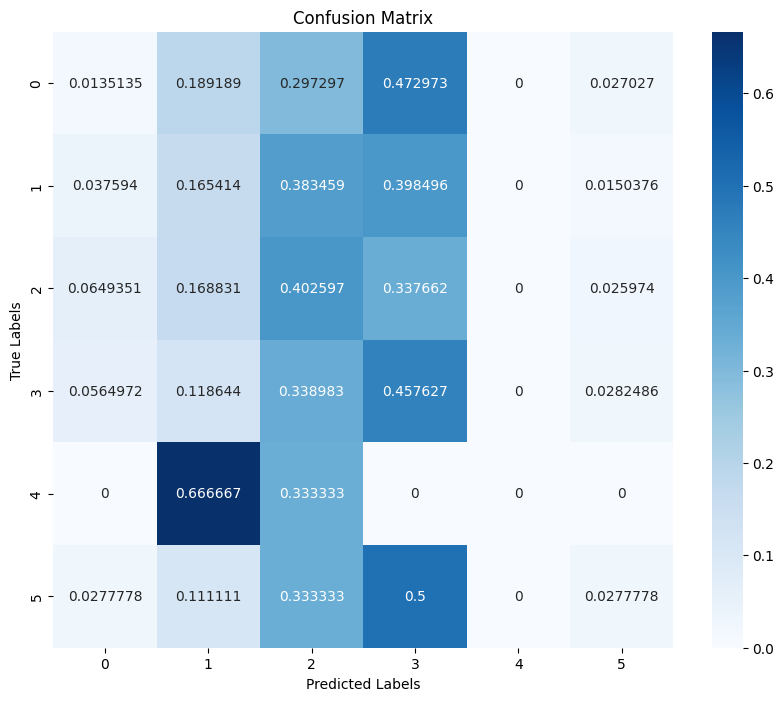

Epoch 8, Validation Loss: 3.0841, Accuracy: 0.2894, F1 Score: 0.2616
Val F1 Score Per Class  [0.01980198 0.1981982  0.34254144 0.38942308 0.         0.04      ]


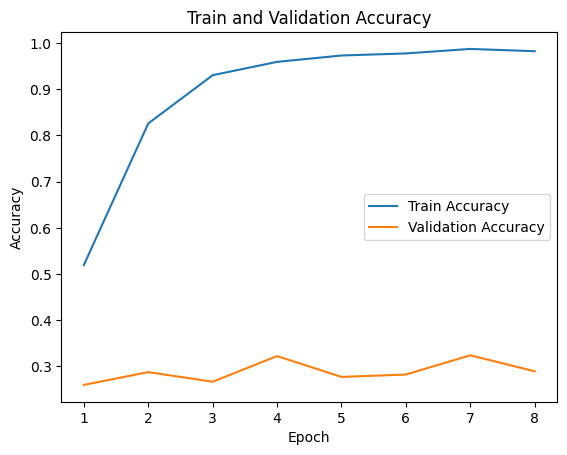

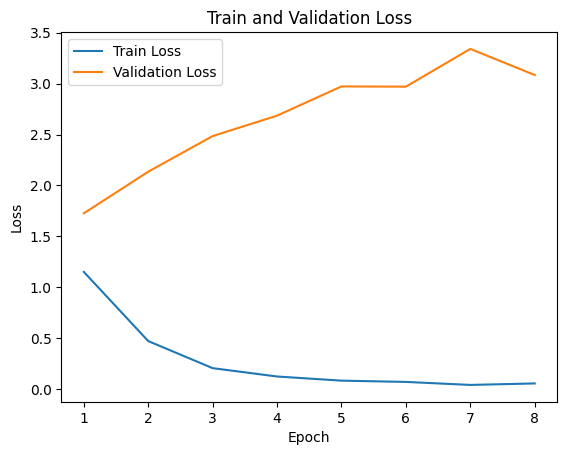

Epoch 9, Train Loss: 0.0319, Accuracy: 0.9908, F1 Score: 0.9908
Train F1 Score Per Class  [0.99516616 0.98680264 0.98576189 0.98559247 0.99882284 0.99280144]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.42it/s, loss=4.51]

[tensor([ 0.2197, -1.4205, -0.8725, -0.4928, -4.9476, -3.0205], device='cuda:0'), tensor([ 4.0957, -2.1409,  0.2603, -0.7237, -2.3438, -3.0570], device='cuda:0'), tensor([-2.8731, -1.4951, -0.6704,  5.6430, -3.4207, -3.0090], device='cuda:0'), tensor([-1.8506, -2.0209,  6.7002, -1.5336, -2.8041, -1.8729], device='cuda:0'), tensor([ 0.2092, -2.8640,  5.5132, -1.4146, -2.3760, -1.9606], device='cuda:0'), tensor([-1.9594, -1.4927, -0.0083, -1.3456, -4.7504, -4.3220], device='cuda:0'), tensor([-3.1053,  0.4280, -0.5768, -0.1346, -2.7310, -3.0201], device='cuda:0'), tensor([ 0.1373, -0.6574, -0.2864,  3.2281, -3.3916, -3.7900], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=3.38]

[tensor([ 2.3270, -1.0134, -1.8459,  0.1562, -2.4563, -2.2307], device='cuda:0'), tensor([-1.9891, -2.5624,  1.8723,  3.1176, -4.0757, -3.4565], device='cuda:0'), tensor([ 0.9529, -3.6496, -1.0152,  2.4663, -2.8114, -2.0999], device='cuda:0'), tensor([-2.2988, -1.4313, -2.6160,  2.0182, -1.5179, -1.1217], device='cuda:0'), tensor([-1.1521,  0.3614, -1.5052,  4.1970, -4.0362, -2.2222], device='cuda:0'), tensor([-2.2985, -1.4247,  0.2605, -1.8233, -4.1222, -2.7052], device='cuda:0'), tensor([-2.0263,  1.8792, -0.5148,  0.5390, -4.1501, -1.6242], device='cuda:0'), tensor([-1.6788, -2.8772, -2.1153,  4.1451, -4.1828, -1.0037], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.38it/s, loss=1.34]

[tensor([-2.3689, -1.7226,  2.9918,  1.5049, -3.8364, -4.0096], device='cuda:0'), tensor([-0.6079, -2.5783, -0.1652,  2.1534, -0.9622, -3.0340], device='cuda:0'), tensor([-0.9699,  1.4783,  1.3444, -2.6067, -2.3129, -2.6321], device='cuda:0'), tensor([-1.8414,  0.0486, -0.2852, -1.7485, -3.2142, -3.8753], device='cuda:0'), tensor([ 2.8740, -1.7880, -2.4629,  2.7105, -4.4516, -2.3790], device='cuda:0'), tensor([-1.1082, -0.6597,  3.2433, -0.7287, -4.0674, -3.6888], device='cuda:0'), tensor([-2.0875,  5.3990, -0.8204, -1.1077, -4.1041, -2.5853], device='cuda:0'), tensor([-1.9145, -0.4643, -0.5392,  1.6188, -3.9781, -4.0043], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=3.89]

[tensor([ 5.1354, -0.2927, -1.5550, -0.4580, -3.4608, -3.3848], device='cuda:0'), tensor([-2.5338, -1.8208, -0.5245,  5.7940, -2.6902, -3.0058], device='cuda:0'), tensor([-1.9690, -1.3693,  5.2912, -0.4945, -3.3964, -3.5820], device='cuda:0'), tensor([ 0.0334,  1.9312, -0.8141, -1.2231, -4.0542, -0.8719], device='cuda:0'), tensor([-1.2049, -2.4076,  6.1472, -0.9604, -2.8336, -1.3896], device='cuda:0'), tensor([ 0.4130, -3.1299,  1.0807, -0.6373, -3.7714, -3.5275], device='cuda:0'), tensor([-1.9180, -3.5270,  0.9616,  3.0680, -3.4606, -1.3681], device='cuda:0'), tensor([-0.4442, -2.0862, -1.7790,  4.1794, -3.8350, -2.7346], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=3.97]

[tensor([-1.5860,  0.1727,  0.2081, -2.1354, -4.4296, -3.0970], device='cuda:0'), tensor([-2.0265, -2.8792,  1.2488, -0.5004, -3.5784, -0.7377], device='cuda:0'), tensor([-1.1637, -1.4108, -2.5555, -0.4283, -3.4763, -2.9987], device='cuda:0'), tensor([-1.1522, -2.1829,  6.8819, -1.7857, -1.8628, -1.8900], device='cuda:0'), tensor([-2.5660, -1.6076,  0.5398, -0.7321, -2.3198,  4.9230], device='cuda:0'), tensor([ 0.0270, -0.9710, -0.3709, -0.8538, -2.0150,  1.7519], device='cuda:0'), tensor([-2.6711,  1.1726,  2.5806, -1.4169, -4.6473, -3.6581], device='cuda:0'), tensor([-1.5242,  0.5962,  0.4383, -0.6508, -3.6202, -4.0693], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.38it/s, loss=3.55]

[tensor([-1.6589,  0.4925, -3.1877,  0.9745, -4.2917, -4.4359], device='cuda:0'), tensor([-2.5695, -0.7535, -2.1776,  0.9038, -3.7446, -0.8399], device='cuda:0'), tensor([-0.8282,  1.3484, -0.3202, -0.5856, -4.0935, -1.5720], device='cuda:0'), tensor([-2.1976, -1.0373, -0.1787, -0.1576, -4.5488, -3.3008], device='cuda:0'), tensor([ 0.4077, -3.6872, -0.0612,  3.6108, -4.0929, -1.6050], device='cuda:0'), tensor([-2.3477, -0.7791,  4.5688, -2.2381, -3.3508, -3.1557], device='cuda:0'), tensor([-2.6261,  3.8616,  0.9302, -2.4924, -3.2621, -2.5942], device='cuda:0'), tensor([-0.1635,  3.1035, -1.6717, -1.0043, -2.8600, -2.2524], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.39it/s, loss=2.91]

[tensor([-1.6746, -1.7507,  5.9678, -1.4994, -3.5921, -2.7979], device='cuda:0'), tensor([-0.7890, -2.4239,  6.5431, -0.7227, -3.1337, -2.8665], device='cuda:0'), tensor([-0.4826, -3.0471, -0.9231,  3.9817, -3.5347, -0.9659], device='cuda:0'), tensor([-1.8742, -1.5674,  3.6442, -1.1449, -3.7542, -2.5935], device='cuda:0'), tensor([-0.1149, -1.5330,  5.6839, -1.8567, -2.9271, -2.9922], device='cuda:0'), tensor([-2.4377, -2.6965,  4.2030,  1.5532, -3.3635, -2.6213], device='cuda:0'), tensor([-1.2649, -1.3492, -1.7135,  0.8406, -4.1567, -3.7555], device='cuda:0'), tensor([-0.7240, -1.7655,  6.8375, -2.1540, -1.9648, -1.9818], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=4.14]

[tensor([-2.3375, -0.1728, -1.0302,  3.3974, -2.6064, -3.0563], device='cuda:0'), tensor([-2.0497, -0.2697, -2.1073, -1.1828, -2.4570, -2.1489], device='cuda:0'), tensor([-0.8021, -2.6011, -2.4448,  3.2157, -4.4785,  0.6547], device='cuda:0'), tensor([-3.1896,  3.1733, -0.6761,  2.1254, -3.7193, -3.5119], device='cuda:0'), tensor([-2.1040, -1.2867, -2.1260,  4.5930, -3.8890, -1.6585], device='cuda:0'), tensor([-2.1217, -3.5741, -0.0410,  3.2591, -3.9875, -2.0195], device='cuda:0'), tensor([-0.9472, -2.8183,  6.0540, -0.5478, -2.5582, -1.9316], device='cuda:0'), tensor([-4.0539,  1.5953, -0.7402,  1.4962, -3.4910, -2.8347], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.38it/s, loss=3.13]

[tensor([-3.2223,  4.7503,  0.7273, -1.4747, -3.7352, -2.5340], device='cuda:0'), tensor([-1.7831, -2.0941,  0.0116,  3.4115, -3.1468, -2.6191], device='cuda:0'), tensor([ 0.4839, -3.0680, -0.3685,  4.3900, -4.5633, -3.0219], device='cuda:0'), tensor([-2.7136, -0.7207, -1.7903,  2.2030, -4.4227, -3.1940], device='cuda:0'), tensor([-1.2044, -2.9516,  2.7229,  1.9023, -4.6992, -2.8144], device='cuda:0'), tensor([-0.3376, -0.3180, -1.9014, -0.6098, -4.1161, -3.3972], device='cuda:0'), tensor([-3.2775,  0.0558,  3.1635, -2.3292, -3.4050, -2.8102], device='cuda:0'), tensor([-2.0886, -2.6376, -0.1912,  5.1514, -3.8769, -1.6694], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.38it/s, loss=3.69]

[tensor([-1.0195, -1.4308, -2.6241,  5.4135, -3.4740, -3.2667], device='cuda:0'), tensor([-2.5278, -1.9086,  0.5534,  0.0132, -3.4351, -2.2430], device='cuda:0'), tensor([-1.4930, -0.4380, -1.7414,  2.8308, -3.6307, -4.0790], device='cuda:0'), tensor([-3.2216, -1.6307, -0.4982,  1.3688, -4.6467, -3.7955], device='cuda:0'), tensor([-1.5778, -0.0392,  0.8804, -0.4101, -4.6211, -4.3492], device='cuda:0'), tensor([-2.6603,  1.6468, -1.2138,  0.0347, -3.9015, -3.6404], device='cuda:0'), tensor([-1.1036, -0.3337,  1.8460, -2.2137, -3.3740, -3.4118], device='cuda:0'), tensor([-0.8755, -1.5900, -1.3952,  4.4580, -4.1747, -3.3229], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=2.66]

[tensor([-2.3059,  1.2014, -2.1241,  0.3853, -2.9170, -3.6443], device='cuda:0'), tensor([-2.1406, -1.6883,  1.1858, -0.3657, -2.4296, -2.2562], device='cuda:0'), tensor([-3.2248, -0.3057,  0.2608, -1.2859, -4.0165, -3.8879], device='cuda:0'), tensor([-2.1025, -2.2583,  5.5288, -0.9700, -2.7993, -1.6885], device='cuda:0'), tensor([-2.7307, -0.5415,  1.0180,  1.7472, -4.4215, -3.2326], device='cuda:0'), tensor([-1.9461, -1.7160, -1.2450,  5.0895, -3.7458, -2.7324], device='cuda:0'), tensor([-1.8119, -1.8279,  2.7314,  0.2207, -4.4968, -4.0277], device='cuda:0'), tensor([-0.9262, -2.3617,  1.3206,  0.7037, -4.6049, -2.3842], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.38it/s, loss=2.89]

[tensor([ 0.0463, -0.7753, -1.7765,  1.1195, -4.0374, -4.1606], device='cuda:0'), tensor([-2.2994, -1.5822,  4.2026, -1.4783, -3.2970, -3.1332], device='cuda:0'), tensor([-1.3695, -3.0294, -1.2265,  5.5585, -3.6971, -2.2567], device='cuda:0'), tensor([-1.2100,  0.1944, -0.5687, -0.1392, -4.4415, -1.6935], device='cuda:0'), tensor([-1.3241,  2.9096, -0.1980, -2.3302, -4.2152, -3.7036], device='cuda:0'), tensor([-1.8808, -0.9569, -0.6064,  1.6120, -4.6153, -4.0323], device='cuda:0'), tensor([-1.8977, -2.0882, -0.3343,  3.8535, -4.8828, -2.4307], device='cuda:0'), tensor([-1.2463, -2.6472,  2.4451,  0.1316, -3.9443, -3.0944], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.38it/s, loss=3.81]

[tensor([-2.7799, -0.8480, -2.3105,  0.3182, -2.9025, -0.8072], device='cuda:0'), tensor([-1.9351, -2.0634,  0.2025,  4.8914, -4.5168, -3.4607], device='cuda:0'), tensor([-1.9012, -1.2053, -2.4569,  3.6498, -3.6743, -2.0926], device='cuda:0'), tensor([-2.7432, -1.4726,  0.6280,  4.9613, -4.0528, -2.8081], device='cuda:0'), tensor([-2.1999, -1.5892, -1.2534,  5.1868, -4.1631, -3.2708], device='cuda:0'), tensor([ 2.6158, -1.7533, -1.1295, -1.0253, -3.2131, -3.6268], device='cuda:0'), tensor([-3.0780,  0.4048, -0.5801, -0.1333, -3.6897, -2.5814], device='cuda:0'), tensor([-1.6171,  1.9704, -0.5554, -0.4082, -3.9660, -3.4591], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.38it/s, loss=2.35]

[tensor([-1.3703, -1.0872,  6.4994, -2.2180, -2.1725, -2.4040], device='cuda:0'), tensor([-0.6403,  1.0419, -0.8625, -2.1734, -3.8995, -4.8371], device='cuda:0'), tensor([ 0.0139,  1.9778, -0.0942, -1.6249, -4.5180, -3.9588], device='cuda:0'), tensor([ 0.5419, -2.5771,  3.2752, -0.2801, -3.8065, -3.8262], device='cuda:0'), tensor([-1.4644,  3.1190, -1.8487, -1.2092, -3.9039, -3.7335], device='cuda:0'), tensor([-2.1730, -1.3295,  1.3918,  0.5839, -3.9362, -3.5401], device='cuda:0'), tensor([-1.7341,  0.8297, -2.0445,  2.6772, -3.4294, -4.0948], device='cuda:0'), tensor([-1.5595,  0.2113,  0.0179, -0.2209, -4.4284, -4.5542], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=3.11]

[tensor([-1.9336, -1.8458, -0.0821,  4.6462, -3.8577, -3.9725], device='cuda:0'), tensor([-2.4096, -1.0675, -2.0540,  4.6850, -4.1518, -1.2565], device='cuda:0'), tensor([-2.6994, -2.1364,  0.2057,  3.5201, -2.5940, -2.3738], device='cuda:0'), tensor([-2.0653, -0.8038,  2.0327, -1.1421, -3.8619, -3.2101], device='cuda:0'), tensor([-1.5860, -0.8439,  4.7675, -2.1943, -3.8161, -2.3599], device='cuda:0'), tensor([-0.0452, -3.0051, -0.5286,  4.3179, -4.0299, -1.8585], device='cuda:0'), tensor([-2.3227, -0.5338, -2.2721,  2.7900, -3.6052, -1.7079], device='cuda:0'), tensor([-2.5860,  0.9028, -0.1153,  1.4305, -3.6236, -4.0064], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=3.18]

[tensor([ 1.0699, -1.5457,  0.2265,  1.8782, -3.4556, -3.1608], device='cuda:0'), tensor([-3.1766,  0.9049, -0.8320,  0.0790, -3.0908, -2.9813], device='cuda:0'), tensor([-2.5719, -1.6698, -1.0911, -0.1145, -3.2966,  5.6976], device='cuda:0'), tensor([-1.0836, -3.0381,  2.5043,  0.6167, -3.9347, -2.5253], device='cuda:0'), tensor([ 2.2938, -2.0507,  2.0178, -1.1389, -2.8233, -3.1832], device='cuda:0'), tensor([-0.7341, -0.6315, -0.7357,  0.3073, -4.7343, -4.1507], device='cuda:0'), tensor([-2.4331, -1.6487, -2.2091,  1.1576, -4.0742, -1.7238], device='cuda:0'), tensor([ 5.1041, -1.4681, -2.8758,  0.0412, -3.6777, -0.8853], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=3.82]

[tensor([-0.1148,  1.0980, -0.6297, -1.0117, -3.7624, -3.9592], device='cuda:0'), tensor([-1.9868,  2.0838,  0.1942,  0.6217, -4.5857, -4.5208], device='cuda:0'), tensor([-2.5780, -1.4184, -1.3330,  3.7059, -3.0722, -0.4671], device='cuda:0'), tensor([-1.9252, -1.0559,  2.5686, -0.9334, -3.9763, -3.1660], device='cuda:0'), tensor([ 3.4792, -0.7204, -0.6328, -0.7498, -3.5484, -3.8825], device='cuda:0'), tensor([-1.0018e-01, -1.1990e+00,  3.0087e+00,  1.4784e-03, -4.3731e+00,
        -5.2167e+00], device='cuda:0'), tensor([-0.9755, -2.3761,  0.3850,  4.4701, -4.7779, -3.6440], device='cuda:0'), tensor([-0.4903,  0.1113,  0.3136, -0.5311, -3.7021, -3.2311], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.39it/s, loss=2.18]

[tensor([-0.9681, -1.9409, -1.1651,  2.6005, -3.7640, -2.7479], device='cuda:0'), tensor([-0.8334, -1.1115,  0.4652, -1.2973, -1.3270, -2.2434], device='cuda:0'), tensor([-2.5938,  1.2436,  3.3470, -1.9402, -4.0422, -2.8635], device='cuda:0'), tensor([-3.1385, -2.7392,  0.2021,  4.8736, -3.1608, -2.8270], device='cuda:0'), tensor([-2.4850, -0.4042, -1.4656,  2.8762, -4.0865, -1.4962], device='cuda:0'), tensor([ 0.7865, -1.2283, -1.2288,  2.5892, -4.8971, -3.2956], device='cuda:0'), tensor([-1.8608, -1.0731, -0.8514,  3.8652, -4.5389, -3.7613], device='cuda:0'), tensor([-1.6541, -0.4942,  0.9459, -0.5840, -4.4342, -3.1997], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=2.39]

[tensor([-2.8808,  0.4172, -1.1431,  1.8638, -3.4054, -3.0175], device='cuda:0'), tensor([-1.8829, -1.2875, -0.6333,  2.9676, -2.8791, -2.9846], device='cuda:0'), tensor([-1.0786, -2.7895,  3.5713,  0.4331, -3.7182, -1.4600], device='cuda:0'), tensor([-2.4288,  1.0430, -0.6839,  0.8670,  0.5451, -3.5780], device='cuda:0'), tensor([-3.1428,  0.4566,  0.6023,  0.0186, -3.3701, -2.9099], device='cuda:0'), tensor([-2.2776,  0.9763, -1.3444,  1.0099, -4.0090, -2.8698], device='cuda:0'), tensor([-2.4809, -2.2976,  1.0728,  4.9431, -4.0168, -2.4605], device='cuda:0'), tensor([ 1.3849, -1.1305, -2.7254,  0.0349, -2.7076, -2.6450], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.38it/s, loss=3.44]

[tensor([-2.8656,  4.9916,  0.1338, -1.6601, -2.9316, -2.0893], device='cuda:0'), tensor([-0.9418,  0.6972,  2.0083, -0.2937, -4.9834, -3.5061], device='cuda:0'), tensor([-3.0870, -1.5769,  0.3076, -1.2829, -3.9783, -2.4362], device='cuda:0'), tensor([-1.6598, -0.1563,  5.3836, -2.3468, -2.8331, -3.1039], device='cuda:0'), tensor([-2.5433, -2.1742, -0.9934,  3.1208, -3.5604, -3.0090], device='cuda:0'), tensor([-2.4858,  0.0993,  3.1016, -1.7490, -3.2007, -2.7396], device='cuda:0'), tensor([-0.5198, -1.9826, -0.6026,  3.2940, -3.6950, -2.8989], device='cuda:0'), tensor([-2.3640,  1.3288, -2.3108,  1.9376, -3.0546, -3.5670], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=4.45]

[tensor([-1.7071, -1.6180,  5.5989, -2.6629, -3.3915, -2.3019], device='cuda:0'), tensor([-1.7429,  5.1809, -0.9260, -0.6805, -3.5031, -3.5290], device='cuda:0'), tensor([-1.4672, -1.1557, -1.2838,  0.6889, -3.6467, -3.5935], device='cuda:0'), tensor([-3.2859, -0.3020, -1.0420,  3.9819, -4.1069, -2.2524], device='cuda:0'), tensor([-1.7861,  4.2844, -1.1148, -1.4346, -2.9750, -1.7860], device='cuda:0'), tensor([-1.5279, -0.9326, -1.6418,  0.9350, -3.7433, -3.5619], device='cuda:0'), tensor([ 4.8942, -0.2037, -0.7647, -2.2627, -3.0499, -2.7662], device='cuda:0'), tensor([-0.1749, -1.3183, -2.0705,  3.2625, -3.2504, -3.8857], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=3.24]

[tensor([-1.2638, -2.7533,  1.2120, -0.8220, -3.7297, -1.9511], device='cuda:0'), tensor([ 0.3076, -2.7487,  5.9015, -1.6907, -2.1599, -2.0959], device='cuda:0'), tensor([-0.4360, -0.8474,  1.4714,  1.5234, -5.3076, -4.6417], device='cuda:0'), tensor([-2.8715, -1.7570,  0.1871,  2.0400, -4.4372, -2.8255], device='cuda:0'), tensor([-1.3504,  2.9980, -0.7067, -1.7554, -3.5488, -2.9462], device='cuda:0'), tensor([-1.1774, -3.1833,  4.2910,  0.6748, -3.5928, -1.4658], device='cuda:0'), tensor([-1.1427, -3.4942,  3.0701, -0.7691, -4.2727, -1.9860], device='cuda:0'), tensor([-2.1166, -1.9953,  6.1120, -1.1420, -3.1050, -2.6421], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=4.18]

[tensor([-2.0895, -1.6986, -1.6319, -1.5244, -2.7028, -3.4390], device='cuda:0'), tensor([-3.0790,  3.0792,  1.6655, -1.6121, -3.4588, -3.2857], device='cuda:0'), tensor([-2.1277,  3.6518, -0.2348, -0.0598, -4.3045, -3.7503], device='cuda:0'), tensor([-1.2452,  5.6558, -1.2429, -2.0099, -1.7276, -2.0546], device='cuda:0'), tensor([-2.9377, -1.4726, -0.8989,  0.0727, -3.8096, -3.3449], device='cuda:0'), tensor([-2.4842,  2.4855, -1.0422, -0.6566, -3.6819, -3.0308], device='cuda:0'), tensor([-0.8710, -2.3517, -0.3372, -0.4857, -2.5266,  6.7643], device='cuda:0'), tensor([-1.1768,  1.4407, -0.7372, -0.4831, -5.4557, -2.1947], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=2.93]

[tensor([-2.4365, -2.4952,  4.3861,  0.9487, -3.1344, -3.6205], device='cuda:0'), tensor([-2.2462, -1.0567,  2.8114, -0.9235, -3.4013, -3.1706], device='cuda:0'), tensor([-3.5629, -0.5791, -0.5742,  3.2546, -4.5735, -2.2492], device='cuda:0'), tensor([-0.7093, -1.7816, -2.3198,  3.5233, -4.0159, -2.5121], device='cuda:0'), tensor([-1.4967, -2.2589, -2.0845,  5.9766, -3.6678, -2.4764], device='cuda:0'), tensor([-2.8726, -0.6137,  0.6850,  1.5028, -4.1488, -3.9892], device='cuda:0'), tensor([ 0.0633, -2.0704, -2.4160,  2.6363, -3.9526, -1.9730], device='cuda:0'), tensor([-1.7065, -1.8470, -0.4529, -0.4693, -3.7112, -3.9126], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=2.45]

[tensor([-2.4895, -2.0690,  4.7081, -0.2773, -3.6384, -3.7440], device='cuda:0'), tensor([-2.5786,  1.3353,  4.2735, -1.9197, -2.9480, -2.7911], device='cuda:0'), tensor([-1.6021, -1.2425, -1.5275,  3.0862, -3.2591, -2.9882], device='cuda:0'), tensor([-1.6303, -1.0512, -0.9397,  1.5843, -4.3090, -2.3711], device='cuda:0'), tensor([-2.6170,  0.8990, -1.8885, -1.3840, -3.4019, -3.2294], device='cuda:0'), tensor([-1.3262, -1.9371,  2.8091, -1.7917, -2.4397, -2.4407], device='cuda:0'), tensor([-1.3246, -1.2204, -2.2287,  5.1646, -4.0903, -2.7171], device='cuda:0'), tensor([-1.2267, -2.0677, -0.6547,  0.1268, -4.0515, -3.1018], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=1.69]

[tensor([-1.4577, -2.0398, -1.2813,  5.4821, -4.7935, -3.1182], device='cuda:0'), tensor([-2.6609, -1.8253, -0.3770,  5.6019, -4.1402, -2.6746], device='cuda:0'), tensor([-0.9438, -3.6524,  1.4094, -0.0445, -3.9095, -0.7701], device='cuda:0'), tensor([ 2.3743, -1.3989, -1.4623,  0.0371, -4.7122, -1.9361], device='cuda:0'), tensor([-1.9712,  5.7517, -0.5666, -1.2402, -3.1507, -2.9620], device='cuda:0'), tensor([-0.1442, -3.8697,  0.6610,  1.0407, -3.1790,  0.5037], device='cuda:0'), tensor([-0.1578, -0.5507, -1.4193, -2.0998, -2.9297, -3.2824], device='cuda:0'), tensor([-2.2343,  1.9004,  0.1853, -1.2549, -4.1440, -2.9447], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=4.03]

[tensor([-1.6651,  0.5700,  1.6257,  1.0244, -4.2867, -3.2993], device='cuda:0'), tensor([-1.7745, -0.7414, -0.9097,  1.0094, -3.3093, -3.0127], device='cuda:0'), tensor([-1.9865, -1.3392, -1.2441,  3.4816, -3.8973, -3.4473], device='cuda:0'), tensor([-1.1876, -2.5315,  5.4076, -1.9575, -3.5941, -1.9401], device='cuda:0'), tensor([-2.2684,  6.3444, -0.5274, -1.8220, -2.6311, -2.2385], device='cuda:0'), tensor([-2.0917, -1.6209,  3.6641, -1.2347, -4.7447, -1.9814], device='cuda:0'), tensor([-1.2036, -1.9728,  4.4491, -0.0352, -3.9643, -3.9078], device='cuda:0'), tensor([-1.4777, -1.5478, -1.5438,  4.9757, -4.1866, -2.3306], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=2.25]

[tensor([-0.1715, -2.8604,  1.9915,  1.6101, -3.7575, -3.4294], device='cuda:0'), tensor([-2.7581, -1.6512,  0.6406,  0.0871, -4.1907, -3.6281], device='cuda:0'), tensor([-1.5157,  4.8337, -1.3050, -1.9851, -3.3479, -1.9886], device='cuda:0'), tensor([-2.3125, -1.8977,  2.8982,  2.9471, -3.5232, -3.3546], device='cuda:0'), tensor([-1.0147, -3.1798, -0.0691,  1.8332, -4.5068, -3.2299], device='cuda:0'), tensor([-1.9613, -0.6393,  5.4989, -1.1758, -3.3085, -3.0765], device='cuda:0'), tensor([-1.8351, -1.5157,  4.8191, -1.8957, -2.8265, -2.6874], device='cuda:0'), tensor([-1.3454, -0.9994,  2.1595, -2.4599, -3.8966, -4.1902], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=3.2]

[tensor([-1.9866, -1.8069, -0.9031,  5.1574, -3.2053, -2.7922], device='cuda:0'), tensor([-3.6284, -1.8682, -0.3897,  0.2623, -4.0741, -1.8023], device='cuda:0'), tensor([-0.1104, -2.5542,  2.4020,  0.5775, -4.0089, -2.0379], device='cuda:0'), tensor([-2.4579,  1.1064,  0.5390,  0.0252, -3.5552, -3.5309], device='cuda:0'), tensor([ 1.1994,  2.3044, -1.1108, -1.2232, -4.2245, -3.4713], device='cuda:0'), tensor([-1.9200, -2.1226,  0.6847, -0.7610, -5.0154, -2.2871], device='cuda:0'), tensor([-2.0490, -2.4874,  0.7215,  3.9337, -3.4885, -2.1813], device='cuda:0'), tensor([-3.5523, -1.1744,  2.4707,  1.0729, -4.0151, -3.3215], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.36it/s, loss=3.9]

[tensor([-2.6269,  3.9884, -0.4705, -0.9013, -3.3906, -2.5639], device='cuda:0'), tensor([-1.6037,  3.3772, -0.9314, -0.5113, -2.9636, -3.3635], device='cuda:0'), tensor([-0.8319, -2.1667, -1.2928,  1.0696, -3.1601, -2.9289], device='cuda:0'), tensor([-2.3110, -0.4720, -1.3932,  3.7436, -3.8352, -2.6066], device='cuda:0'), tensor([-1.5887, -0.8219, -1.9212, -0.9191, -4.6417, -2.8880], device='cuda:0'), tensor([ 1.2774, -3.7897,  0.0719,  0.7026, -3.0736, -2.0627], device='cuda:0'), tensor([-1.9401, -2.0987,  3.8819, -0.1451, -3.6359, -3.6799], device='cuda:0'), tensor([-0.8743, -1.7834, -0.2063, -1.5625, -2.6146,  6.7479], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=2.05]

[tensor([-1.8878, -1.7416, -1.0170,  5.7203, -3.7734, -2.2414], device='cuda:0'), tensor([-3.0968,  0.1688, -0.0336, -0.8971, -4.4356,  0.4832], device='cuda:0'), tensor([-2.9876, -0.6360, -0.8179,  4.2481, -2.9952, -1.5417], device='cuda:0'), tensor([-0.3881, -0.5505, -2.6254, -0.1318, -3.6622, -2.3619], device='cuda:0'), tensor([-3.1176,  0.0623, -1.5528,  0.2454, -3.7422, -2.3219], device='cuda:0'), tensor([ 1.6069,  2.9732, -2.5890, -2.0344, -3.6228,  0.3406], device='cuda:0'), tensor([-2.1613, -2.5818,  5.1177, -0.1415, -3.5534, -3.3684], device='cuda:0'), tensor([-2.1902, -0.5620,  5.5063, -0.4961, -3.3632, -3.6181], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.37it/s, loss=6.18]

[tensor([-1.6708, -0.1005, -2.5518,  1.7688, -3.4472, -0.9545], device='cuda:0'), tensor([-2.9534, -0.9197, -1.9720,  5.6322, -3.4912, -2.0729], device='cuda:0'), tensor([-1.5096,  5.9975, -1.4227, -2.0777, -1.6896, -2.8106], device='cuda:0'), tensor([-1.6612,  1.8270, -1.9652, -1.0479,  2.0482, -1.1071], device='cuda:0'), tensor([ 4.7577, -1.9706, -0.9496, -0.0107, -2.6968, -1.8519], device='cuda:0'), tensor([-1.4556, -2.4659,  6.4935, -0.2837, -2.8553, -2.3495], device='cuda:0'), tensor([ 4.5821, -0.0437, -2.5200,  0.0752, -2.9703, -2.5357], device='cuda:0'), tensor([ 4.9583, -2.0841,  0.7069, -1.0037, -4.4619, -3.1478], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=3.78]

[tensor([-3.2960, -2.3457,  0.5088,  3.6593, -3.3674, -2.1304], device='cuda:0'), tensor([-2.5179,  4.7631, -0.4963, -0.5916, -3.2068, -2.3286], device='cuda:0'), tensor([-0.7491, -1.3866, -0.2020,  2.9715, -5.3603, -3.5689], device='cuda:0'), tensor([-2.4411,  1.8040,  3.3667, -1.4970, -4.2843, -4.5582], device='cuda:0'), tensor([-2.7813, -2.3131,  4.4125, -0.9446, -3.0000, -2.6963], device='cuda:0'), tensor([-2.3733, -3.0318,  0.8434,  4.8505, -4.0712, -3.0146], device='cuda:0'), tensor([ 0.5601,  0.2416, -2.0884, -1.4878, -3.8876, -3.6901], device='cuda:0'), tensor([-2.6309, -1.6714, -1.5600,  3.9069, -3.3973, -2.4264], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=3.54]

[tensor([ 3.0759,  1.7299, -2.4285, -1.5943, -2.1450, -2.7531], device='cuda:0'), tensor([-1.7803, -1.7295, -0.6351,  3.4212, -4.2690, -4.0206], device='cuda:0'), tensor([-1.7934,  3.8606, -1.8532, -0.2323, -1.7485, -2.9951], device='cuda:0'), tensor([-2.7605, -2.5323,  4.4581, -0.9561, -4.1355, -2.2905], device='cuda:0'), tensor([-1.8441, -1.0753, -1.2243,  2.7247, -3.5271, -4.1617], device='cuda:0'), tensor([-2.2442,  1.0051, -1.1869,  0.6986, -3.7736, -2.3413], device='cuda:0'), tensor([-2.3545, -2.7997,  0.9862, -0.9296, -3.4407, -2.7073], device='cuda:0'), tensor([-1.5887, -1.6832,  6.8110, -1.9518, -2.5736, -1.8111], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=3.72]

[tensor([-2.5507, -0.8431, -1.7877,  4.1101, -4.1401, -3.0351], device='cuda:0'), tensor([-1.1554,  3.2243, -1.2058, -0.6954, -3.8868, -3.0660], device='cuda:0'), tensor([-1.5171, -1.6508,  6.1636, -1.1377, -3.3098, -2.3408], device='cuda:0'), tensor([-1.4976, -2.0577,  6.6964, -1.4637, -2.1342, -1.4397], device='cuda:0'), tensor([-2.3165, -0.1833,  0.8332, -0.2862, -3.4834, -2.5606], device='cuda:0'), tensor([-0.9373, -2.3756,  1.8446,  1.2821, -4.0540, -2.1050], device='cuda:0'), tensor([-1.3472, -2.8491, -0.2844,  4.8624, -4.0786, -3.1079], device='cuda:0'), tensor([-1.6859,  0.4251, -0.2099,  1.1754, -3.9893, -3.3329], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.38it/s, loss=3.14]

[tensor([-2.9724,  0.6304,  0.9580,  1.1798, -3.5321, -4.1010], device='cuda:0'), tensor([-2.1252, -2.5392,  2.7047, -1.3257, -3.7162, -3.9419], device='cuda:0'), tensor([-2.4373, -1.8722,  3.8193,  0.0846, -4.3591, -1.9345], device='cuda:0'), tensor([-1.5887,  5.2543, -1.5607, -1.1098, -3.7179, -2.4364], device='cuda:0'), tensor([-2.0789, -1.1315,  0.8122,  1.0552, -3.9058, -3.1668], device='cuda:0'), tensor([-2.2979, -2.9938,  0.7084,  3.5389, -3.6805, -2.9210], device='cuda:0'), tensor([-0.6231, -2.6887, -0.4462,  3.6039, -3.9244, -4.0569], device='cuda:0'), tensor([-2.4306, -0.0794, -1.3927,  2.6528, -3.9667, -3.3436], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=3.2]

[tensor([ 2.5049, -2.2502, -2.0597,  2.2280, -4.1278, -2.3178], device='cuda:0'), tensor([-2.9820, -1.6480,  1.5247,  1.8214, -3.8067, -3.3970], device='cuda:0'), tensor([-3.1911, -1.4281, -1.6604,  3.8901, -3.5201, -2.6351], device='cuda:0'), tensor([-3.4242,  0.8007, -0.8621,  1.4702, -3.8641, -0.9210], device='cuda:0'), tensor([-2.1513,  0.0777,  0.5450,  1.8789, -3.7142, -3.4702], device='cuda:0'), tensor([-1.9982,  2.8098,  0.9333, -2.9080, -2.2200, -2.8653], device='cuda:0'), tensor([-1.1755, -1.1300,  5.7291, -1.1538, -3.3272, -3.0240], device='cuda:0'), tensor([-2.8292,  2.7379,  0.4511,  0.9613, -2.4636, -4.0008], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.39it/s, loss=3.18]

[tensor([ 0.7657, -1.0069, -0.9427, -0.6614, -3.4037, -1.4500], device='cuda:0'), tensor([-1.5867, -2.0687, -1.4389,  1.4585, -3.9768,  2.3147], device='cuda:0'), tensor([-1.5558, -1.5306, -1.1447,  5.6321, -3.8497, -2.5607], device='cuda:0'), tensor([-0.6003, -1.2627, -1.6395,  0.6231, -2.4187, -2.0963], device='cuda:0'), tensor([-2.1420, -0.8882,  1.5936, -0.6842, -4.0221, -4.1410], device='cuda:0'), tensor([-1.9011,  4.9345, -1.0504, -1.1018, -3.0014, -2.2600], device='cuda:0'), tensor([-1.5808,  0.2053,  1.2223, -2.4948, -3.4948, -4.2785], device='cuda:0'), tensor([-3.3511,  2.9765, -0.0935,  1.2501, -3.8646, -3.5316], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=3.66]

[tensor([-1.4555, -2.7123,  5.9488, -0.5047, -3.1210, -2.8222], device='cuda:0'), tensor([-2.7491,  3.1766, -0.3707,  0.4612, -3.9296, -3.3798], device='cuda:0'), tensor([-1.8146, -2.7461, -0.9473,  1.1745, -4.2200, -2.6846], device='cuda:0'), tensor([-1.2312, -2.6545,  0.3755,  0.1081, -3.7372, -3.0482], device='cuda:0'), tensor([-3.1670, -0.6493, -0.1584,  1.2728, -4.8920, -3.8031], device='cuda:0'), tensor([-2.6744, -1.8006,  1.9116, -1.1415, -3.4344, -2.6079], device='cuda:0'), tensor([ 1.1530, -2.9208,  3.3858, -1.3550, -3.9571, -2.2621], device='cuda:0'), tensor([-3.2756, -0.8524,  0.8031, -1.4956, -4.6105,  3.6925], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=2.84]

[tensor([ 3.0149, -2.1711, -1.3080,  1.5128, -3.9743, -2.8145], device='cuda:0'), tensor([ 0.0419, -2.1566,  4.4047, -1.4699, -2.9867, -2.7101], device='cuda:0'), tensor([-1.6211,  0.6728, -1.1818,  0.7182, -3.9627, -2.2262], device='cuda:0'), tensor([ 2.0358, -0.0743, -2.7975,  2.1878, -3.5862, -3.0374], device='cuda:0'), tensor([-3.6070,  1.4191, -1.4722,  2.9074, -3.9122, -2.4001], device='cuda:0'), tensor([ 0.4638, -0.7049, -2.1449,  0.3345, -3.7428, -4.0335], device='cuda:0'), tensor([-2.4473,  2.3436, -0.1016, -0.1235, -3.8228, -2.3637], device='cuda:0'), tensor([-1.5530, -1.7583, -2.0752,  3.3064, -4.3413,  1.2953], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.38it/s, loss=2.89]

[tensor([-2.0012, -2.9053,  2.0961,  1.1219, -3.7341, -3.5231], device='cuda:0'), tensor([-1.4104,  0.5901,  0.1039,  1.7600, -1.9050, -3.7849], device='cuda:0'), tensor([-1.1648, -3.3348,  0.5222, -0.5233, -3.9245, -3.1393], device='cuda:0'), tensor([-2.9378, -1.2493, -0.4221,  5.6158, -3.4444, -2.8998], device='cuda:0'), tensor([ 0.0323,  2.1157, -2.0930, -0.4929, -3.7733, -3.3008], device='cuda:0'), tensor([-2.0224, -2.1910, -0.3707,  5.6472, -3.3093, -2.9411], device='cuda:0'), tensor([-2.4344, -0.6350,  0.6533, -0.6203, -4.4662, -2.8091], device='cuda:0'), tensor([-0.4405, -0.4422, -0.9536, -0.4705, -4.2967, -3.9873], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.37it/s, loss=1.45]

[tensor([-2.2280, -2.0568,  3.2605, -1.1548, -3.4378, -4.2430], device='cuda:0'), tensor([ 5.8028, -1.7816,  0.1530, -1.3143, -2.8073, -1.9117], device='cuda:0'), tensor([-2.3332, -0.9646,  1.1241,  1.5303, -4.7912, -3.5470], device='cuda:0'), tensor([-0.9037, -1.4748, -2.1493,  2.5917, -4.1051, -2.2026], device='cuda:0'), tensor([-1.9869, -2.0006,  0.7684,  3.3856, -3.9357, -3.1848], device='cuda:0'), tensor([-1.0723, -2.3066, -0.5843,  5.9712, -3.6610, -3.0284], device='cuda:0'), tensor([-1.9372, -1.9836,  3.2578, -0.0913, -3.4262, -2.4994], device='cuda:0'), tensor([ 0.2830, -1.8507,  5.8423, -1.3435, -3.0230, -3.0997], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.37it/s, loss=2.4]

[tensor([-1.9308,  0.3519, -2.3593,  3.1410, -4.0883, -3.5951], device='cuda:0'), tensor([-0.8668,  2.6542, -0.2296, -2.3057, -3.7425, -3.2920], device='cuda:0'), tensor([ 1.2181, -0.7455, -0.3660, -0.7978, -4.8080, -3.2660], device='cuda:0'), tensor([-2.9713, -0.4262, -0.8782,  1.4616, -4.4172,  0.6416], device='cuda:0'), tensor([-2.9059,  1.6023, -0.6924, -0.5662, -3.7990, -3.3869], device='cuda:0'), tensor([-1.5666, -1.6973,  6.8891, -1.9798, -2.0026, -2.0326], device='cuda:0'), tensor([-2.9394, -1.9499,  5.7353, -1.0491, -2.6472, -1.1412], device='cuda:0'), tensor([-2.1631,  0.9869, -2.1210, -1.8672, -4.2669, -2.8337], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.36it/s, loss=4.01]

[tensor([-2.2661, -0.5369, -1.3776,  4.9944, -3.2885, -3.3544], device='cuda:0'), tensor([-1.5631, -2.0066,  6.0903, -1.1187, -2.9131, -2.6947], device='cuda:0'), tensor([ 1.4969,  0.0501, -2.7210, -0.5540, -4.3984, -2.5816], device='cuda:0'), tensor([-1.9969, -1.9886, -1.0593,  0.0166, -2.6285,  6.5676], device='cuda:0'), tensor([-2.6209, -1.2752,  0.1719,  3.6361, -3.5453, -3.5219], device='cuda:0'), tensor([-2.7004, -0.4448, -2.1784,  4.1941, -3.5761, -1.6215], device='cuda:0'), tensor([-1.0800, -2.2910, -0.9599,  5.8178, -3.6265, -3.5194], device='cuda:0'), tensor([-2.8494, -1.8785, -0.5302,  5.2739, -3.7444, -2.6674], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.38it/s, loss=4.1]

[tensor([-1.7304,  0.5305,  0.3581, -1.2731, -4.9746, -2.1509], device='cuda:0'), tensor([-1.5628,  5.9502, -0.5199, -2.3634, -2.1820, -2.4014], device='cuda:0'), tensor([-1.0342, -0.8571,  5.9955, -2.2426, -2.9850, -2.5380], device='cuda:0'), tensor([-2.3829,  1.9059, -1.1712,  2.7209, -4.1923, -4.0469], device='cuda:0'), tensor([-2.0085, -2.7630, -0.2204,  4.2928, -4.4130, -1.9469], device='cuda:0'), tensor([ 0.6339, -1.7393, -1.8852,  2.3119, -4.6046, -2.4722], device='cuda:0'), tensor([ 0.8895,  0.3041, -1.7514, -3.0219,  1.9626, -2.6124], device='cuda:0'), tensor([-2.2846,  4.2203,  1.9585, -2.2802, -3.3832, -3.3750], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.36it/s, loss=5.46]

[tensor([ 0.5037, -2.2321, -0.5866,  3.8386, -4.1772, -3.5017], device='cuda:0'), tensor([-1.5225, -0.1988, -0.4992, -1.9330, -4.1891, -3.1615], device='cuda:0'), tensor([-2.5544, -2.3940, -0.3536,  3.6005, -4.6616, -2.1334], device='cuda:0'), tensor([-2.9840, -2.0767,  5.1669, -0.9310, -3.6448, -2.2276], device='cuda:0'), tensor([-3.7149, -0.5544,  1.4200, -0.7966, -3.5679, -2.6147], device='cuda:0'), tensor([-2.0340, -2.1169,  3.6906, -0.8572, -3.9790, -3.1683], device='cuda:0'), tensor([-1.2862, -1.9010, -1.9500,  6.2489, -3.0079, -2.1895], device='cuda:0'), tensor([-1.5407, -0.9325, -1.1162,  3.7906, -4.6919, -0.6519], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=3]

[tensor([-2.8893, -2.2554, -0.1903,  0.5551, -2.8281,  3.1186], device='cuda:0'), tensor([ 2.7363, -3.1056,  3.5469, -0.3989, -3.2256, -2.1684], device='cuda:0'), tensor([-1.6934, -2.0638,  0.8249,  0.8690, -4.0783, -4.6634], device='cuda:0'), tensor([-1.2355, -1.0335,  4.2647, -2.0056, -4.6802, -3.5980], device='cuda:0'), tensor([-3.3708,  0.0159, -0.6747, -2.7539, -3.4570, -3.3156], device='cuda:0'), tensor([-2.8559, -3.1402,  1.7345,  1.8378, -4.2176, -1.6479], device='cuda:0'), tensor([-2.7105, -1.2084, -0.2437, -0.4485, -3.7675, -2.3743], device='cuda:0'), tensor([-1.2073, -0.1887,  2.2586, -2.0521, -4.4078, -3.7323], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.37it/s, loss=3.34]

[tensor([-0.7213, -2.6971,  4.8297, -1.1678, -3.2114, -2.3735], device='cuda:0'), tensor([-1.3512,  0.9123, -2.3793,  1.9708, -4.0808, -1.2575], device='cuda:0'), tensor([ 6.8055, -1.5546, -0.8549, -1.2311, -2.0106, -1.8203], device='cuda:0'), tensor([-1.4560,  0.3116, -1.8607,  0.7011, -3.6750, -3.9660], device='cuda:0'), tensor([-0.6967, -2.3921, -1.2038,  4.1370, -4.8077, -2.1136], device='cuda:0'), tensor([-2.6323, -2.5962, -0.6139,  3.4236, -4.5039, -3.4502], device='cuda:0'), tensor([-2.6705,  2.7146, -0.4041,  1.4275, -4.3712, -3.6824], device='cuda:0'), tensor([ 5.1209, -2.7337, -1.2494,  1.6053, -3.8037, -2.7549], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.36it/s, loss=2.87]

[tensor([-1.2755, -1.4925,  1.3367,  1.0309, -4.4379, -3.6238], device='cuda:0'), tensor([-2.6962,  3.4279,  1.3874, -0.8707, -3.7706, -3.9041], device='cuda:0'), tensor([-3.2319, -1.9367,  2.5972,  0.2489, -4.5602, -1.6803], device='cuda:0'), tensor([-1.6479, -2.1973,  0.4526,  3.4721, -3.6061, -2.0315], device='cuda:0'), tensor([-2.1752, -0.1775,  1.2211, -0.4325, -4.1779, -2.9582], device='cuda:0'), tensor([-1.0982, -1.9383,  3.0970, -1.2171, -3.2958, -2.7496], device='cuda:0'), tensor([-1.1598, -0.9628,  1.0299,  0.1482, -3.8907, -2.5759], device='cuda:0'), tensor([-0.7482, -2.4090, -2.2517,  4.7174, -3.9829, -0.9550], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.37it/s, loss=3.94]

[tensor([-2.0011, -0.0355, -0.4879, -2.1016, -2.8400, -2.9059], device='cuda:0'), tensor([-2.1497,  3.0383, -0.0097, -1.5991, -4.2888, -2.8392], device='cuda:0'), tensor([ 0.7538, -2.5077, -1.0116,  2.8418, -4.6567, -4.0151], device='cuda:0'), tensor([-2.1802, -2.1303,  5.3180, -0.5167, -3.5252, -2.9794], device='cuda:0'), tensor([-0.1854,  0.4486, -0.5637,  0.5309, -4.8846, -3.8424], device='cuda:0'), tensor([-1.9551, -0.9839,  5.9134, -1.0973, -3.1243, -2.6410], device='cuda:0'), tensor([-3.0792,  2.7799,  0.6254,  0.0101, -4.1560, -3.2474], device='cuda:0'), tensor([-0.2671, -3.0603, -0.5450,  5.5066, -3.6306, -2.9463], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=2.31]

[tensor([-1.7336, -0.3586, -1.7763, -1.4380, -3.6403, -3.5227], device='cuda:0'), tensor([-2.0142, -2.9190,  1.9859,  0.8891, -4.2973, -2.8823], device='cuda:0'), tensor([-1.6844, -1.7856,  5.8235, -1.6196, -3.6008, -3.1159], device='cuda:0'), tensor([-0.9123, -1.6408,  1.7455,  0.0475, -5.4208, -3.9247], device='cuda:0'), tensor([-0.8618, -3.2663, -0.1981,  3.4722, -3.7526, -3.3783], device='cuda:0'), tensor([-2.2428, -0.9707,  0.6334,  0.2678, -4.7451, -3.9799], device='cuda:0'), tensor([-1.3494, -1.2983,  3.3045, -1.3435, -3.1222, -3.5136], device='cuda:0'), tensor([-2.8922, -2.7570, -0.4617,  3.9988, -4.4321, -1.9796], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.37it/s, loss=3.75]

[tensor([-3.5078, -2.3106,  0.1546,  2.1327, -4.0264, -1.5291], device='cuda:0'), tensor([-2.5795,  0.5763, -0.0325,  1.4643, -4.1169, -3.9503], device='cuda:0'), tensor([-1.9436, -0.1209, -2.3093,  3.4738, -3.3198, -2.3663], device='cuda:0'), tensor([-1.4904,  1.5664, -1.6601,  1.0158, -2.9371, -2.9950], device='cuda:0'), tensor([-1.8727, -2.2939,  4.9091, -1.2666, -3.7114, -2.8712], device='cuda:0'), tensor([-2.6180,  1.8037,  0.4127, -1.0387, -4.0572, -3.1506], device='cuda:0'), tensor([-2.0349,  1.2696, -0.9642, -1.3153, -3.6548, -2.2837], device='cuda:0'), tensor([-1.7527, -1.2338, -0.9462, -0.5643, -3.9860, -3.1634], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.38it/s, loss=1.46]

[tensor([-2.2104, -3.6912, -1.1987,  3.9332, -3.7882, -0.8623], device='cuda:0'), tensor([-1.2097, -1.5783, -0.7630,  4.6968, -4.2507, -4.4631], device='cuda:0'), tensor([-3.6904, -2.8090, -0.6469,  0.5611, -3.4509, -0.0304], device='cuda:0'), tensor([-2.5992, -0.9069,  1.7439,  0.1379, -4.3878, -3.5040], device='cuda:0'), tensor([-1.3050, -1.3828, -1.2033,  2.9888, -4.4778, -3.4789], device='cuda:0'), tensor([-2.0397,  2.1143, -1.3089,  0.2053, -3.7751, -3.8917], device='cuda:0'), tensor([-1.9081,  0.1046,  0.0497, -0.2244, -4.0186, -1.1224], device='cuda:0'), tensor([-0.4468, -3.2404, -0.6641,  3.8230, -3.9518, -2.3647], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=2.45]

[tensor([-2.6657,  0.5125,  0.6751, -1.5342, -3.7288, -2.9006], device='cuda:0'), tensor([-0.5642, -1.9755,  5.3809, -0.7981, -3.7572, -3.4744], device='cuda:0'), tensor([ 4.8593, -1.6087, -1.3644, -0.0519, -2.6848, -1.9691], device='cuda:0'), tensor([ 1.1383, -2.2134,  0.3034,  0.7869, -4.7031, -2.5441], device='cuda:0'), tensor([-0.9792, -2.4381,  0.0346, -0.2398, -4.4092, -2.2253], device='cuda:0'), tensor([-3.5736, -1.4997,  1.3504,  1.1933, -3.9400, -2.0876], device='cuda:0'), tensor([-2.9845, -0.4267, -0.6972,  1.0794, -4.4044, -3.8779], device='cuda:0'), tensor([-2.1488, -2.9560, -0.6585,  5.1305, -3.7953, -2.7058], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=2.41]

[tensor([ 1.5093, -1.4917, -1.2054,  3.8794, -4.8440, -3.9777], device='cuda:0'), tensor([ 0.7269, -0.3583, -0.5421, -1.4648, -3.9899, -3.1332], device='cuda:0'), tensor([ 0.2024, -2.1244,  3.0085, -2.0140, -2.2569, -2.7431], device='cuda:0'), tensor([-2.0240, -1.7459,  5.9799, -1.0330, -3.9215, -2.6274], device='cuda:0'), tensor([ 1.1929,  1.4400, -1.8326, -0.5716, -3.6468, -2.7958], device='cuda:0'), tensor([-2.5137, -1.2153,  5.0527, -0.2613, -4.0789, -3.1291], device='cuda:0'), tensor([-2.0881,  0.1519,  2.1742, -1.9949, -3.9288, -3.3420], device='cuda:0'), tensor([-2.3676,  0.9072, -1.3656,  0.2109, -3.5190, -4.0837], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=5.02]

[tensor([-1.7735, -0.9499,  0.3859,  2.2447, -4.4635, -2.7020], device='cuda:0'), tensor([-2.1574,  0.4344, -0.7285,  1.0462, -3.8311, -3.2483], device='cuda:0'), tensor([-3.1403, -2.9577,  0.8625,  1.8761, -4.9413, -2.0552], device='cuda:0'), tensor([-3.4437, -1.2953, -0.6912,  3.5108, -3.9789, -3.5951], device='cuda:0'), tensor([-1.1963, -2.2999,  5.9571, -1.1757, -2.5306, -2.1918], device='cuda:0'), tensor([-2.7253, -2.6282,  0.8993,  3.0934, -4.5246, -0.6564], device='cuda:0'), tensor([-0.6323, -1.5166,  6.2700, -0.9179, -3.3210, -3.6787], device='cuda:0'), tensor([-2.0717, -3.4095, -0.0447,  3.7053, -4.1841, -3.1692], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.38it/s, loss=4.19]

[tensor([-2.1951, -0.7823,  0.6051,  3.2002, -3.6320, -4.0447], device='cuda:0'), tensor([-1.5435, -2.8097,  5.0100, -0.7700, -4.0981, -2.0297], device='cuda:0'), tensor([-2.9114, -1.0334,  6.7964, -1.5160, -2.6754, -1.8685], device='cuda:0'), tensor([-0.5344, -2.2674, -0.2714,  2.1436, -4.7780, -2.7465], device='cuda:0'), tensor([-1.9550, -2.0723,  3.3425, -0.1235, -4.6138, -2.8041], device='cuda:0'), tensor([-0.7756, -2.1771, -0.5714,  0.8528, -4.0286, -3.4727], device='cuda:0'), tensor([-2.0698, -1.5235, -0.8561,  3.7748, -4.2229, -3.1489], device='cuda:0'), tensor([-2.7684, -1.8704,  2.6733, -2.0565, -3.8014, -3.7353], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.38it/s, loss=3.37]

[tensor([-0.2116, -1.0134,  1.0733, -0.6464, -3.2669, -3.9444], device='cuda:0'), tensor([-2.4657, -1.7155, -0.3497,  4.8159, -3.9774, -2.8384], device='cuda:0'), tensor([ 0.3013, -1.0749,  3.0116, -1.5554, -3.6724, -3.2843], device='cuda:0'), tensor([-2.4644, -1.4299, -0.2828,  4.7895, -4.2260, -3.1202], device='cuda:0'), tensor([-0.7439, -1.7244,  6.4737, -1.6703, -2.7180, -2.3003], device='cuda:0'), tensor([-1.3394, -2.7680,  2.4460, -0.4486, -4.3775, -1.3203], device='cuda:0'), tensor([-1.9473, -0.2415, -0.4433, -0.8372, -3.7080, -4.0757], device='cuda:0'), tensor([-0.4878, -1.9433,  4.1905, -1.6937, -3.0283, -3.7585], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.37it/s, loss=3.63]

[tensor([ 1.8421, -1.4949, -0.9906, -1.6351, -3.3735, -3.4512], device='cuda:0'), tensor([-2.9497,  3.7268,  0.4337, -1.8267, -2.3495, -2.1420], device='cuda:0'), tensor([-2.5215, -1.5136,  0.6186,  2.2177, -4.9162, -2.3088], device='cuda:0'), tensor([-2.2387, -0.9667, -1.4841,  3.9921, -4.3540, -3.5167], device='cuda:0'), tensor([-2.8992, -1.2246,  0.6276,  3.6512, -4.2019, -3.4719], device='cuda:0'), tensor([-3.0431, -0.0050,  2.0561, -2.2878, -2.9571, -3.5716], device='cuda:0'), tensor([-2.7967, -0.5937, -0.2767,  0.4389, -4.1787, -3.0813], device='cuda:0'), tensor([ 7.0165, -1.1279, -0.4083, -1.7692, -1.8874, -2.5591], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=4.43]

[tensor([ 1.5848, -1.1456, -2.5492,  3.1231, -4.1297, -2.8474], device='cuda:0'), tensor([-3.3674, -0.4775, -0.4748,  0.0181, -3.5504, -2.7691], device='cuda:0'), tensor([-1.7265, -2.1845, -1.6448,  4.0118, -4.2733, -2.2497], device='cuda:0'), tensor([-3.1329, -1.1996, -2.2334,  1.5812, -3.7224, -3.5463], device='cuda:0'), tensor([-2.2466, -0.8585,  1.2774,  0.0664, -4.4269, -3.4801], device='cuda:0'), tensor([-3.5954, -2.1738,  0.3884,  4.1693, -4.2681, -3.2868], device='cuda:0'), tensor([-1.7966,  1.8296, -2.0762, -0.0696, -4.4387, -2.8235], device='cuda:0'), tensor([-1.6668, -3.0302,  4.4970,  1.2473, -4.4895, -3.2044], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.37it/s, loss=3.5]

[tensor([-1.6983,  4.6349, -1.4159, -0.5728, -2.9927, -2.9278], device='cuda:0'), tensor([-1.7325, -0.8990,  0.3773,  2.5092, -3.2740, -4.0463], device='cuda:0'), tensor([-1.7387, -2.3610,  5.9607, -0.1223, -3.2575, -2.1429], device='cuda:0'), tensor([-2.2981,  4.9999, -0.3990, -1.2689, -3.7183, -2.4458], device='cuda:0'), tensor([-1.5326, -2.6135,  3.3341,  0.7838, -4.4623, -1.7789], device='cuda:0'), tensor([ 2.7673, -1.5080, -1.9062,  0.2828, -2.8491, -2.0058], device='cuda:0'), tensor([-1.2349, -2.0459,  5.9941, -1.9476, -3.5304, -1.9876], device='cuda:0'), tensor([-1.4868, -2.2672, -0.8694,  3.7222, -4.5069, -3.5649], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.38it/s, loss=2.69]

[tensor([ 2.4205, -1.9069,  1.9870,  0.2312, -3.4359, -3.7372], device='cuda:0'), tensor([-1.2071, -1.6838, -0.0792,  0.2934, -3.8662, -3.5326], device='cuda:0'), tensor([-3.0245,  0.9175,  3.1389, -1.0475, -3.7648, -3.1608], device='cuda:0'), tensor([-2.0283, -0.7107, -1.5119,  4.2489, -4.5627, -2.6747], device='cuda:0'), tensor([-1.1275, -0.3303, -1.9758,  2.5101, -5.7520, -0.5841], device='cuda:0'), tensor([-0.9820, -1.3932, -2.3030,  5.4252, -4.0798, -1.3002], device='cuda:0'), tensor([-1.8741, -1.8628,  6.2352, -1.0113, -3.0583, -2.8845], device='cuda:0'), tensor([-2.0438, -1.2681,  1.8154, -1.7282, -4.6944, -4.5812], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.38it/s, loss=2.36]

[tensor([-3.5249, -0.5030, -1.3438,  4.7269, -3.9944, -3.2045], device='cuda:0'), tensor([-3.8837,  0.3571,  0.5756,  2.0387, -4.2418, -2.8159], device='cuda:0'), tensor([ 0.5935, -3.0425,  0.8028,  1.8690, -4.3870, -3.9362], device='cuda:0'), tensor([-0.9889, -1.6805,  2.2420,  0.4493, -4.3909, -4.1983], device='cuda:0'), tensor([-2.2901,  0.1520, -1.8130,  0.6249, -4.6438,  1.7264], device='cuda:0'), tensor([-2.8211, -2.9543,  0.1694,  1.4939, -4.0985,  3.6413], device='cuda:0'), tensor([-2.3436, -1.0620, -1.3293,  4.2537, -2.4134, -3.0712], device='cuda:0'), tensor([ 1.3971, -0.2353, -0.3772, -0.2158, -4.0284, -4.9500], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.37it/s, loss=3.37]

[tensor([-1.7614, -0.9399,  2.8935, -0.9016, -3.8057, -3.6435], device='cuda:0'), tensor([-1.3705, -2.3067,  0.6274, -0.4331, -3.9535, -3.1300], device='cuda:0'), tensor([ 1.9072, -1.6058, -1.2231,  2.2443, -3.6414, -2.7803], device='cuda:0'), tensor([-1.3756,  0.0747,  3.3823, -1.3152, -5.1519, -4.3808], device='cuda:0'), tensor([-0.1009, -1.4102, -0.1630,  1.5774, -4.7396, -3.8884], device='cuda:0'), tensor([-1.0654,  0.3773, -2.6761,  3.3411, -3.0809, -2.9264], device='cuda:0'), tensor([ 0.1256, -3.3655,  3.3481, -0.6563, -3.3368, -0.3933], device='cuda:0'), tensor([-1.5723, -3.1148,  0.6367,  3.9066, -3.2899, -2.8629], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.73]

[tensor([-1.9162, -0.8753, -1.7726,  4.4334, -3.1141, -2.4926], device='cuda:0'), tensor([-3.1277,  1.4218, -0.6404, -0.1232, -3.4819, -2.9345], device='cuda:0'), tensor([-1.0704, -2.1348,  6.6039, -1.4234, -2.6713, -2.8082], device='cuda:0'), tensor([-2.2406, -0.4675,  0.9900, -0.6592, -4.7267, -3.7605], device='cuda:0'), tensor([-1.8404,  2.3283, -0.7952, -0.2474, -3.3319, -3.0080], device='cuda:0'), tensor([-1.2669,  0.1434, -0.8360,  1.4798, -3.1541, -3.8920], device='cuda:0'), tensor([-3.1599, -1.8764, -0.5101, -0.3722, -4.0197, -2.7527], device='cuda:0'), tensor([-0.6381, -2.2320, -1.0744,  3.3131, -3.6218, -3.0165], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=4.04]

[tensor([-2.7436, -1.4550, -0.6133,  3.0204, -4.2012, -1.2975], device='cuda:0'), tensor([-2.0253, -1.3623,  6.7155, -2.0954, -2.2366, -1.8866], device='cuda:0'), tensor([-2.3115,  0.0173,  0.0250, -1.2714, -4.6603, -3.4380], device='cuda:0'), tensor([-1.4154, -2.5362,  1.7683,  1.0849, -3.8946, -2.4942], device='cuda:0'), tensor([ 2.2738, -1.1995,  1.7070, -1.1716, -3.4008, -3.5901], device='cuda:0'), tensor([-1.8488, -2.9569,  1.6070, -0.2958, -3.8510, -2.5681], device='cuda:0'), tensor([-0.6407,  1.5646, -1.8953,  0.7995, -3.5213, -3.4524], device='cuda:0'), tensor([-1.4789, -2.8259, -1.4669,  5.9079, -3.4107, -1.6036], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.35it/s, loss=4.02]

[tensor([-2.6336, -1.0437,  3.9694, -0.9630, -4.4288, -3.8647], device='cuda:0'), tensor([-3.0694,  3.6643, -0.8561, -0.5864, -4.0986, -2.3342], device='cuda:0'), tensor([-1.9745,  2.0889,  0.6528, -2.0406, -4.3280, -0.6840], device='cuda:0'), tensor([ 0.4362, -2.9154, -0.8372,  3.5602, -3.7283, -1.7939], device='cuda:0'), tensor([-2.1166, -1.3850,  4.8160, -0.7028, -2.7301, -3.7335], device='cuda:0'), tensor([-1.0894,  0.0241,  1.6190,  0.1698, -4.4898, -4.5357], device='cuda:0'), tensor([-0.2316, -2.7933,  6.1426, -0.9190, -2.9235, -1.5526], device='cuda:0'), tensor([-3.7760,  2.0842, -0.5466,  0.7350, -4.3121, -2.6786], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.36it/s, loss=3.59]

[tensor([-3.2783, -1.1187, -1.2809,  3.9343, -3.7556, -3.2674], device='cuda:0'), tensor([ 2.0732, -0.1286, -1.5965, -2.8443, -1.9828, -2.7062], device='cuda:0'), tensor([-1.6132, -2.5462,  2.6357, -0.4048, -4.0903, -2.8334], device='cuda:0'), tensor([-1.9690, -2.3087, -0.4378, -1.4291, -3.2268, -2.6758], device='cuda:0'), tensor([-2.7624, -1.6266, -1.3078,  1.4678, -3.4493,  5.0849], device='cuda:0'), tensor([-1.8763, -1.7593,  1.2847,  1.9510, -3.8072, -2.6340], device='cuda:0'), tensor([-0.7784, -1.8219,  5.4492, -1.3201, -3.7664, -3.7710], device='cuda:0'), tensor([-2.5802, -2.0810,  1.3526,  1.5280, -4.5625, -2.7757], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.34it/s, loss=2.58]

[tensor([-1.3007, -1.4264, -2.6181,  2.6058, -3.1189,  0.5784], device='cuda:0'), tensor([-3.0294,  2.1829,  0.4026,  0.1249, -3.5437, -3.3330], device='cuda:0'), tensor([ 1.1668, -1.0278, -1.7283,  1.7140, -5.1074, -2.8827], device='cuda:0'), tensor([ 2.2715, -0.2318, -1.9087,  0.6428, -3.3575, -3.0934], device='cuda:0'), tensor([-1.6418,  3.7722, -1.0963, -1.3778, -3.4532, -2.7703], device='cuda:0'), tensor([ 0.1551, -0.8743,  0.0668, -1.4435, -4.0143, -2.5118], device='cuda:0'), tensor([-2.3377, -2.1968, -1.3929,  5.2874, -3.8292, -1.6988], device='cuda:0'), tensor([-1.7857, -3.9439,  1.3185,  0.0280, -1.1653, -2.7177], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.36it/s, loss=4.81]

[tensor([-2.0720, -1.1427, -1.2453,  6.0282, -3.2512, -3.1440], device='cuda:0'), tensor([-0.5607, -1.8825,  3.3163, -1.8709, -4.0949, -3.7056], device='cuda:0'), tensor([-1.3897, -1.3904,  6.3149, -1.2661, -3.6303, -3.1186], device='cuda:0'), tensor([-2.4140,  2.8475,  2.3238, -2.2551, -2.8738, -3.5720], device='cuda:0'), tensor([-2.2976,  1.0768,  1.1688, -2.0043, -2.4551, -3.6608], device='cuda:0'), tensor([-2.9029, -0.7221, -1.5629,  2.3011, -3.9588, -1.7610], device='cuda:0'), tensor([-1.8315, -1.3765,  5.5426, -1.2622, -3.3919, -3.2757], device='cuda:0'), tensor([-2.5496,  2.2223, -1.1749, -1.7009, -3.8781, -3.6739], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.36it/s, loss=4.48]

[tensor([ 0.6781, -0.4410,  3.8286, -1.8406, -3.3884, -3.0981], device='cuda:0'), tensor([-2.5972, -0.5251,  0.9523, -0.5876, -2.6325, -3.4509], device='cuda:0'), tensor([-2.2907, -3.0159, -0.8179,  1.4959, -3.8667,  1.7384], device='cuda:0'), tensor([-0.6849, -2.2729,  4.7321, -0.7279, -3.2888, -3.1762], device='cuda:0'), tensor([ 0.4510,  0.6360, -1.4312, -2.3639, -4.1976, -2.6887], device='cuda:0'), tensor([-2.8631, -1.0902,  5.7745, -2.4047, -2.9469, -1.9455], device='cuda:0'), tensor([-2.5620, -2.9852,  2.4808,  1.1051, -3.9548, -1.5166], device='cuda:0'), tensor([-2.7081, -1.6306,  5.4799, -2.0562, -3.7796, -2.5438], device='cuda:0')]


[tensor([-1.2468, -0.9545, -0.4795,  1.0262, -4.6850, -3.2673], device='cuda:0'), tensor([-2.9717, -0.4051,  1.0408,  3.2381, -4.6067, -3.5242], device='cuda:0'), tensor([-1.6658, -2.0910, -0.1344,  2.1496, -4.7906, -2.8440], device='cuda:0'), tensor([-3.1235, -1.6288,  3.1005,  1.4293, -3.4849, -2.3253], device='cuda:0'), tensor([-0.1172, -2.6276, -1.4562,  0.9324, -4.2028, -2.0733], device='cuda:0'), tensor([-2.4396, -2.5497,  1.9243, -1.2309, -4.5600, -2.9241], device='cuda:0'), tensor([ 4.5518, -1.4629, -1.6726,  2.1789, -3.7992, -3.4838], device='cuda:0'), tensor([-2.0011,  1.0744,  0.9330,  1.1680, -3.3436, -3.4445], device='cuda:0')]
[tensor([-0.8485, -0.4264, -0.8158, -1.3379, -3.0720, -3.5500], device='cuda:0')]


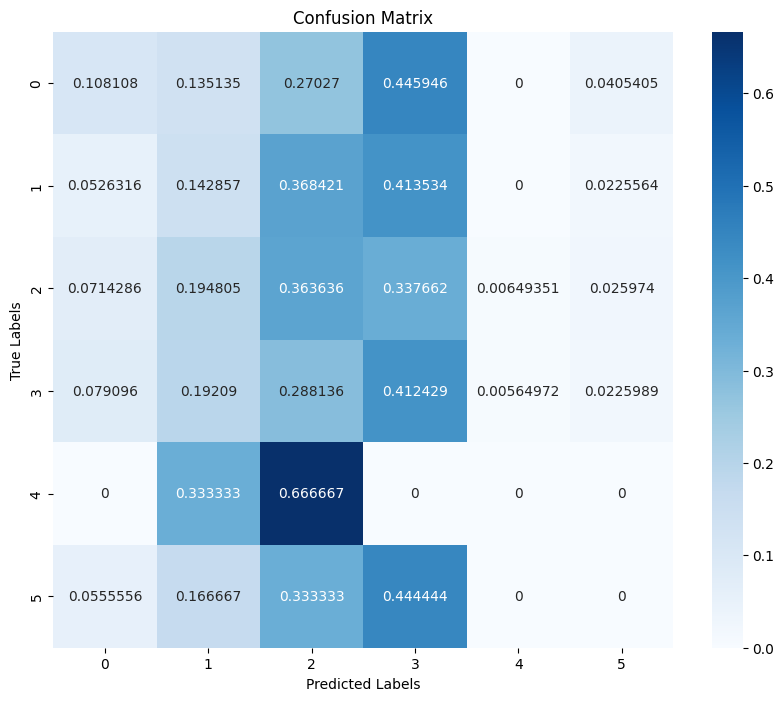

Epoch 9, Validation Loss: 3.2589, Accuracy: 0.2704, F1 Score: 0.2525
Val F1 Score Per Class  [0.13793103 0.16309013 0.3255814  0.35960591 0.         0.        ]


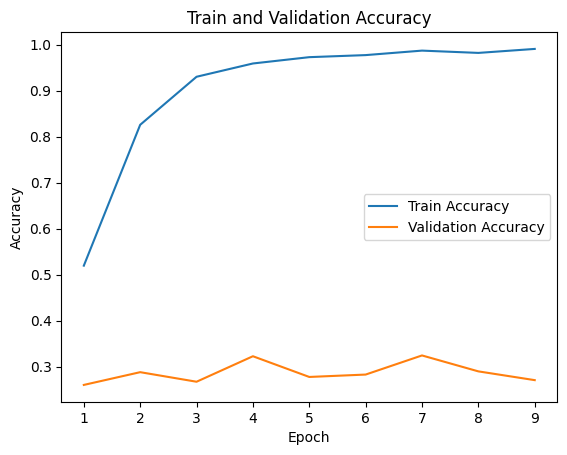

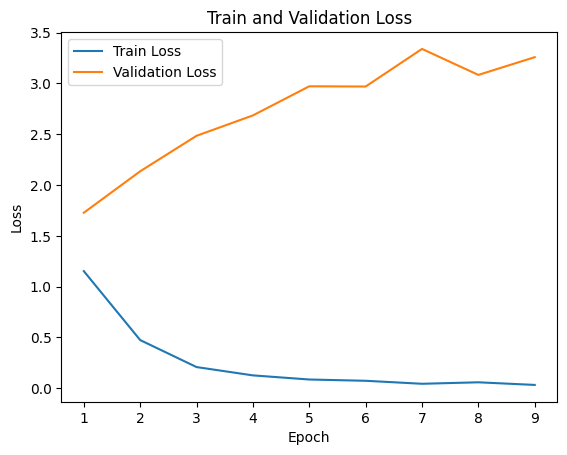

Epoch 10, Train Loss: 0.0279, Accuracy: 0.9921, F1 Score: 0.9921
Train F1 Score Per Class  [0.995172   0.98712189 0.98881161 0.98377102 1.         0.99789727]


Val:   1%|▏         | 1/73 [00:00<00:30,  2.39it/s, loss=3.81]

[tensor([-2.7528, -2.1639, -0.4478,  0.5889, -4.8210, -1.4365], device='cuda:0'), tensor([ 1.4398, -1.4104, -0.2574,  1.9975, -4.1053, -4.0055], device='cuda:0'), tensor([-4.0609,  1.4741,  0.8303,  0.6983, -3.2518, -4.2532], device='cuda:0'), tensor([-4.0034, -0.9584,  5.2855, -0.9755, -4.1674, -1.7512], device='cuda:0'), tensor([-0.3945, -1.8309,  3.6717, -1.1091, -3.4798, -2.4574], device='cuda:0'), tensor([-3.5209,  0.7559,  2.9244, -1.3520, -4.3630, -3.8657], device='cuda:0'), tensor([-3.4751,  1.7893, -0.5810,  1.7586, -3.2425, -0.7559], device='cuda:0'), tensor([-2.6992, -0.4121,  2.0027,  2.4623, -4.6553, -4.5615], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.39it/s, loss=2.93]

[tensor([-3.8583,  0.9391, -0.2270,  2.1543, -2.6873, -2.1176], device='cuda:0'), tensor([-3.0735, -1.7008,  2.1796,  3.5084, -4.4290, -3.8732], device='cuda:0'), tensor([-0.0954, -2.6777, -1.5739,  0.5713, -2.7013, -1.1469], device='cuda:0'), tensor([-1.4680, -0.5599, -2.4225,  0.6988, -1.4408, -0.5980], device='cuda:0'), tensor([-1.4413,  0.4311, -1.6086,  5.5326, -4.1572, -3.0641], device='cuda:0'), tensor([-2.7615, -0.6902,  3.4502, -1.3626, -3.3360, -3.1401], device='cuda:0'), tensor([-2.2097,  1.0440, -1.3922,  4.5047, -4.2864, -2.6930], device='cuda:0'), tensor([-0.6593, -2.0663, -2.6085,  2.7846, -3.9513, -1.4911], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.36it/s, loss=2.58]

[tensor([-4.2838, -1.4458,  0.1917,  4.3731, -3.9445, -3.2867], device='cuda:0'), tensor([-2.2294, -0.9373,  0.1820,  2.2913, -2.7287, -2.5032], device='cuda:0'), tensor([-3.6765,  1.8670,  2.4776, -0.5232, -3.3932, -3.2782], device='cuda:0'), tensor([-3.1520, -0.5212,  4.2230, -2.1425, -2.9160, -3.0379], device='cuda:0'), tensor([ 5.7119, -1.2429, -2.1083,  0.2282, -3.3629, -2.4935], device='cuda:0'), tensor([-3.0265, -0.2045,  4.5295, -0.5685, -4.0515, -3.5321], device='cuda:0'), tensor([-3.0892, -0.3517, -1.3999, -0.1559, -3.6543,  5.1371], device='cuda:0'), tensor([-2.5081,  0.9576, -0.6433,  4.3213, -4.3379, -3.5685], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.37it/s, loss=3.48]

[tensor([ 5.1367, -0.7097, -2.0439, -0.3335, -2.5832, -2.4741], device='cuda:0'), tensor([-1.6941, -2.0176, -1.3533,  6.3993, -3.2353, -2.7282], device='cuda:0'), tensor([-4.0565, -0.1936,  4.2301,  1.6020, -3.7925, -3.5128], device='cuda:0'), tensor([-3.6197, -0.6652, -0.8842,  0.6732, -3.6405,  4.9785], device='cuda:0'), tensor([-3.3225, -1.5522, -0.2156,  0.1305, -2.9210,  5.8932], device='cuda:0'), tensor([-3.2106, -1.9680, -0.0100,  1.0702, -3.9902, -3.0840], device='cuda:0'), tensor([-2.7932, -2.8433,  1.3625,  2.3114, -3.4224,  0.0094], device='cuda:0'), tensor([ 0.5991, -1.2144, -1.1680,  3.0290, -4.5444, -3.5106], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.38it/s, loss=3.48]

[tensor([-3.3156, -1.9064, -0.6353, -1.2932, -3.4584, -2.1063], device='cuda:0'), tensor([-3.4964, -2.5803, -0.2661,  0.5583, -3.4856,  0.0079], device='cuda:0'), tensor([-3.2694, -1.1401, -1.8694,  1.5239, -4.0092, -2.4292], device='cuda:0'), tensor([-2.2674, -1.6193,  6.8913, -1.3347, -3.0353, -2.5468], device='cuda:0'), tensor([-3.1960, -1.9524,  0.7481, -0.9646, -2.6137,  2.2929], device='cuda:0'), tensor([-2.4655, -0.3552,  0.0389,  0.7245, -3.3522, -0.6731], device='cuda:0'), tensor([-3.0976, -0.4802, -0.1774,  5.1637, -4.7355, -3.5930], device='cuda:0'), tensor([-3.2516,  0.6691,  1.6488,  1.0381, -3.7263, -4.0391], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.37it/s, loss=2.64]

[tensor([-4.1045,  0.6319, -1.5457,  0.8613, -3.6703, -1.5448], device='cuda:0'), tensor([-3.1628,  1.8695, -1.2974,  1.4996, -3.1993, -1.2148], device='cuda:0'), tensor([-4.1446,  0.7457,  0.5599,  1.5084, -2.9586, -1.0284], device='cuda:0'), tensor([-3.4785,  1.3849, -0.4698, -0.1013, -4.4860, -4.1067], device='cuda:0'), tensor([-2.1176, -3.7078, -0.7539,  4.1496, -3.0913,  1.8211], device='cuda:0'), tensor([-4.3288,  1.0873,  0.8248, -1.3149, -3.7621, -3.2197], device='cuda:0'), tensor([-4.1290,  2.3513,  2.5114, -1.7467, -2.8891, -1.7644], device='cuda:0'), tensor([-2.5535,  1.8852, -0.4738, -0.8590, -1.9493, -1.1157], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.39it/s, loss=2.27]

[tensor([-3.6752, -1.1044, -0.0850,  1.2709, -5.2887, -3.5156], device='cuda:0'), tensor([-3.4739, -1.4553,  6.3499, -0.0846, -3.7629, -2.8589], device='cuda:0'), tensor([-1.2192, -2.1643, -1.5064,  4.1456, -3.5993, -1.2709], device='cuda:0'), tensor([-2.5386, -0.1498,  0.1138,  1.3216, -4.4646, -2.6533], device='cuda:0'), tensor([-2.4500,  1.4955,  2.1026, -1.2498, -4.2753, -3.8598], device='cuda:0'), tensor([-3.2676, -2.0309, -0.7875,  4.0186, -2.7135, -1.3177], device='cuda:0'), tensor([-3.1231, -1.6015, -1.4110,  3.6216, -3.6054, -3.0521], device='cuda:0'), tensor([-2.3785, -1.7024,  6.8767, -1.1375, -2.5538, -1.6969], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.40it/s, loss=3.47]

[tensor([-2.0868, -0.6084, -1.9139,  2.8932, -2.3945, -0.6663], device='cuda:0'), tensor([-2.0535, -0.0933, -1.8370, -0.3178, -2.4957, -1.7236], device='cuda:0'), tensor([ 3.9674, -1.8096, -1.8420, -1.2840, -3.1096, -1.4135], device='cuda:0'), tensor([-2.2871, -0.3277, -0.9924,  5.1511, -4.2641, -3.8109], device='cuda:0'), tensor([-1.8518,  2.3878, -2.4934,  1.4556, -3.8211, -2.2675], device='cuda:0'), tensor([-1.7826, -3.3315, -0.3654,  4.8498, -4.0991, -2.2931], device='cuda:0'), tensor([-2.1172, -1.0394,  0.1429,  3.9143, -4.7309, -3.8782], device='cuda:0'), tensor([-3.7385,  0.5352, -1.4721,  4.2731, -3.5014, -2.8506], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.40it/s, loss=2.85]

[tensor([-3.8322,  1.9725,  0.4213,  0.5228, -4.7761, -3.4648], device='cuda:0'), tensor([-2.3620, -1.3637, -0.6628,  4.6085, -4.1892, -2.1680], device='cuda:0'), tensor([-1.3893, -1.3600, -1.2770,  5.9333, -4.5058, -2.2851], device='cuda:0'), tensor([-3.0035,  0.0106, -1.0524,  4.3396, -4.2619, -2.7666], device='cuda:0'), tensor([-2.7862, -1.3004, -0.1306,  5.3833, -4.4535, -3.1054], device='cuda:0'), tensor([-2.2587, -1.0237, -1.9463,  0.9535, -4.2112, -3.2572], device='cuda:0'), tensor([-4.0855,  1.4204,  1.5667, -0.1971, -4.3326, -3.0504], device='cuda:0'), tensor([-3.0057, -1.5329, -0.2700,  5.3349, -4.8000, -2.1452], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=4.68]

[tensor([-3.8869,  0.0166, -0.6276,  3.8430, -3.5225, -3.7268], device='cuda:0'), tensor([-1.9504, -0.6904, -2.0380,  4.6116, -3.6961, -3.0396], device='cuda:0'), tensor([-3.0258, -0.5545,  0.0278,  0.4231, -3.5605, -4.3523], device='cuda:0'), tensor([-4.4067, -0.5909,  1.3449, -0.2816, -4.0792, -3.4116], device='cuda:0'), tensor([-3.5282, -0.2922,  4.8326, -0.8296, -3.6632, -3.3039], device='cuda:0'), tensor([-3.9606,  0.4224,  0.1135,  1.4786, -4.5542, -3.3499], device='cuda:0'), tensor([ 0.8499, -0.0898, -0.1049,  0.6051, -3.9742, -3.9877], device='cuda:0'), tensor([-2.6319, -1.1999,  5.0295,  0.0711, -4.0580, -3.1679], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.39it/s, loss=3.69]

[tensor([-3.1291,  3.6599,  0.9972, -0.6320, -3.0188, -3.3848], device='cuda:0'), tensor([-3.1577, -0.7455, -0.4827,  3.7115, -2.8764, -1.8481], device='cuda:0'), tensor([-4.5588,  0.8725,  0.9361, -0.1234, -4.0222, -2.8593], device='cuda:0'), tensor([-3.3900, -1.7751,  5.3577, -0.1692, -3.0268, -2.0246], device='cuda:0'), tensor([-2.6932, -1.2736, -0.3177,  5.4035, -4.2789, -2.0002], device='cuda:0'), tensor([-3.0530, -0.8406, -0.9247,  5.7370, -3.3899, -2.6098], device='cuda:0'), tensor([-3.2372, -1.6436,  4.8386,  0.5707, -3.8932, -3.4802], device='cuda:0'), tensor([-2.9675, -1.6970, -0.5032,  4.4780, -4.3248, -2.1694], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=1.63]

[tensor([-1.4696,  0.1609,  0.5452, -1.3017, -3.9844, -4.4297], device='cuda:0'), tensor([-3.8900, -1.0848,  6.0433, -0.6931, -3.5761, -3.2289], device='cuda:0'), tensor([-3.1998, -1.7361,  0.9144,  4.7441, -3.7955, -3.0899], device='cuda:0'), tensor([-1.8444, -1.1202, -2.0618,  3.0113, -4.6707, -2.0461], device='cuda:0'), tensor([-2.5823,  1.5099,  0.6405,  0.7454, -4.6351, -3.6373], device='cuda:0'), tensor([-2.3647,  0.3770,  4.5825, -1.9257, -3.3246, -3.0201], device='cuda:0'), tensor([-2.9923, -1.5323,  2.4823, -0.4483, -4.3249, -2.1992], device='cuda:0'), tensor([-1.9698, -2.5403,  0.0955,  2.8682, -4.7298, -2.9403], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=3.69]

[tensor([-2.4856, -1.2838, -1.5218,  3.9358, -2.7287, -1.5743], device='cuda:0'), tensor([-3.1047, -1.6932, -0.6389,  4.4654, -4.5050, -2.9701], device='cuda:0'), tensor([-0.8657, -0.9443, -2.8952,  4.5272, -4.1399, -1.6897], device='cuda:0'), tensor([-2.3645, -1.2892, -0.0773,  4.8605, -4.4223, -3.0780], device='cuda:0'), tensor([-3.3366, -1.0631, -0.7700,  3.3174, -3.7955, -1.5961], device='cuda:0'), tensor([ 0.2151, -1.2436, -2.0912,  3.0765, -4.1852, -3.6636], device='cuda:0'), tensor([-3.7174, -0.4126, -1.1245,  0.4879, -4.0297, -2.3910], device='cuda:0'), tensor([-3.3229,  2.8821,  0.3221,  0.6745, -3.9263, -2.7765], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=2.14]

[tensor([-2.3351, -0.2511,  4.4387, -1.5693, -3.2415, -2.9110], device='cuda:0'), tensor([-3.1869,  2.1343, -1.1358,  0.8765, -4.3029, -3.9738], device='cuda:0'), tensor([-1.7832, -0.2023, -0.6384,  3.8859, -4.6746, -3.8814], device='cuda:0'), tensor([-2.7804, -2.1300,  0.3247,  5.2379, -4.0069, -3.0998], device='cuda:0'), tensor([-2.7294,  2.0358, -1.3035,  0.2553, -4.1888, -4.2189], device='cuda:0'), tensor([-2.1526,  1.3927, -1.0728,  1.4414, -3.7132, -3.1448], device='cuda:0'), tensor([-3.4145,  0.2461, -0.5486,  2.4504, -4.4828, -3.5319], device='cuda:0'), tensor([-2.8883,  0.3107, -0.8401,  1.4804, -4.3452, -4.1533], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=3.21]

[tensor([-3.5999, -1.0814, -0.9269,  3.8168, -4.4416, -3.8084], device='cuda:0'), tensor([-2.5086, -0.5771, -2.4935,  5.0973, -3.6696, -1.0226], device='cuda:0'), tensor([-2.4859, -2.5358, -0.9328,  5.1521, -3.5055, -1.8790], device='cuda:0'), tensor([-2.9924,  1.9811,  3.7331, -2.2646, -3.2216, -3.1653], device='cuda:0'), tensor([-2.5780,  0.6174,  2.7361, -0.4932, -4.8271, -2.9257], device='cuda:0'), tensor([-1.5115, -2.5600, -0.3023,  4.1905, -5.1170, -2.8521], device='cuda:0'), tensor([-2.9135, -0.7776, -1.5723,  4.7088, -3.0007, -1.1781], device='cuda:0'), tensor([-3.3107, -0.1775, -0.5846,  5.1491, -3.8630, -3.2306], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.38it/s, loss=3.83]

[tensor([ 1.1738, -1.2494, -1.8407,  4.4199, -4.3720, -3.8661], device='cuda:0'), tensor([-3.9085, -1.6029,  0.5976,  3.1483, -3.5792, -2.0804], device='cuda:0'), tensor([-1.8051, -2.1454, -0.8698, -0.5086, -2.8240,  7.0026], device='cuda:0'), tensor([-2.7161, -2.0126,  0.8732,  2.4648, -4.9866, -2.9021], device='cuda:0'), tensor([ 1.6734, -2.4591,  1.2179,  1.1607, -4.5291, -3.7558], device='cuda:0'), tensor([-1.4323, -1.4968, -1.3806,  3.4641, -4.2502, -2.8756], device='cuda:0'), tensor([-3.4000, -1.9751, -1.6264,  1.8692, -3.5989, -2.1822], device='cuda:0'), tensor([ 2.9777, -1.7155, -2.1249, -0.8207, -3.0311,  1.3777], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=4.52]

[tensor([-2.7147, -1.0149,  0.7803,  0.8227, -3.3578, -2.5791], device='cuda:0'), tensor([-1.7815,  0.1673, -0.4741,  3.7785, -4.7479, -4.4113], device='cuda:0'), tensor([-3.2217e+00, -1.3982e-03,  3.8211e-02,  1.9565e+00, -3.7774e+00,
        -2.5231e+00], device='cuda:0'), tensor([-4.0190,  0.3888,  4.3398, -1.6333, -2.7737, -3.0254], device='cuda:0'), tensor([ 6.1958, -2.3615, -0.7999,  0.5526, -3.0879, -3.3243], device='cuda:0'), tensor([-2.3944,  4.6566,  0.8043, -1.1703, -4.0298, -4.0809], device='cuda:0'), tensor([-3.1609, -1.6753,  4.5870,  1.1656, -4.3844, -2.7771], device='cuda:0'), tensor([-4.1547,  0.0906,  3.1056, -0.1285, -3.9092, -2.1163], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=1.86]

[tensor([-1.1189, -1.8760, -1.8737,  4.2246, -2.9703, -2.3323], device='cuda:0'), tensor([-3.3035, -0.8116, -0.8845,  2.9203, -2.9234,  0.5319], device='cuda:0'), tensor([-3.1957,  1.0529, -0.1554,  0.9170, -3.9886, -3.3565], device='cuda:0'), tensor([-2.8532, -2.5922, -0.6569,  5.7484, -3.5654, -2.5816], device='cuda:0'), tensor([-2.9662,  0.2487, -2.2013,  1.4349, -3.4443,  0.5115], device='cuda:0'), tensor([-2.4690, -0.6556, -0.6388,  0.2271, -5.1444, -3.5431], device='cuda:0'), tensor([-1.6428, -1.4091, -0.4688,  1.5263, -4.1571, -2.4062], device='cuda:0'), tensor([-3.6595, -0.4513,  2.7501,  1.7672, -4.4975, -4.1050], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.37it/s, loss=3.27]

[tensor([-4.4625,  0.0941, -0.8634,  2.3593, -3.2592,  0.2055], device='cuda:0'), tensor([-3.7521,  1.6909,  0.0593,  1.5134, -3.4988, -1.9621], device='cuda:0'), tensor([-2.7059, -1.9553, -0.3016, -0.2336, -2.7918,  6.0414], device='cuda:0'), tensor([-3.5662,  0.4053, -0.1804,  2.9167, -2.2143, -2.4178], device='cuda:0'), tensor([-3.1458,  2.3838, -0.5101,  0.3452, -3.1475, -2.0235], device='cuda:0'), tensor([-1.2475,  1.3145, -2.3560,  3.0655, -3.8433, -3.0419], device='cuda:0'), tensor([-2.3839, -1.4211, -0.8501,  6.0147, -4.0642, -2.5647], device='cuda:0'), tensor([-2.1670, -1.2907, -1.6810,  2.7418, -4.1331, -2.1219], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=2.16]

[tensor([-3.4360,  3.9229, -0.1788, -0.3697, -2.9734, -2.1045], device='cuda:0'), tensor([-4.1554,  0.2553,  2.9697,  0.5911, -4.3350, -3.1890], device='cuda:0'), tensor([-3.0941, -0.7925, -1.0074, -0.2182, -4.0816, -2.6219], device='cuda:0'), tensor([-3.3010,  3.8195,  0.8708, -1.2480, -3.7738, -3.6272], device='cuda:0'), tensor([-4.5426,  0.3730, -1.1274, -0.0623, -3.4850, -4.1155], device='cuda:0'), tensor([-3.4938, -0.3621,  1.5983,  0.3031, -4.0664, -2.4654], device='cuda:0'), tensor([ 1.7127, -0.9673, -1.2190,  1.2769, -4.2494, -2.1345], device='cuda:0'), tensor([-2.7547,  4.2017, -1.2167, -0.1992, -2.3658, -3.2395], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.37it/s, loss=4.46]

[tensor([-2.8740, -0.1345,  6.1663, -2.0668, -2.9293, -2.0481], device='cuda:0'), tensor([-2.6330,  3.5605,  0.7444,  0.2308, -4.5580, -3.4462], device='cuda:0'), tensor([-3.5940, -0.0986, -1.0671,  2.5624, -3.4278, -3.3029], device='cuda:0'), tensor([-4.2423,  0.3534, -1.8876,  1.2241, -3.3214, -0.5187], device='cuda:0'), tensor([-1.9970,  4.2814, -1.6448, -1.2476, -2.7860, -1.0454], device='cuda:0'), tensor([-1.9853, -1.2650, -1.0877,  2.2809, -3.9307, -3.5212], device='cuda:0'), tensor([-2.2507,  0.2734,  4.1422, -2.3154, -2.8446, -2.2709], device='cuda:0'), tensor([-2.5987,  2.2439,  1.4477, -0.1188, -3.3185, -3.7920], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.38it/s, loss=2.69]

[tensor([-0.9294, -1.2126, -0.1658,  0.6362, -4.0924, -2.5815], device='cuda:0'), tensor([-2.3305, -0.9903,  2.4437,  0.3183, -3.9956, -3.9121], device='cuda:0'), tensor([-3.0212, -1.5633,  4.3221,  0.7157, -4.6831, -3.9246], device='cuda:0'), tensor([-3.3911, -1.0995, -0.7925,  1.7128, -3.7381, -2.8041], device='cuda:0'), tensor([-2.8875,  1.0308, -1.2100,  1.8191, -3.9294, -3.6910], device='cuda:0'), tensor([-1.6428, -1.7222, -0.3676, -0.4381, -4.1383, -1.1896], device='cuda:0'), tensor([-2.6984, -2.3174,  2.4290,  3.6614, -4.3735, -2.6798], device='cuda:0'), tensor([-2.9219, -1.0377,  6.3014, -1.2933, -3.6188, -2.9496], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.38it/s, loss=3.12]

[tensor([-2.3273, -1.3593, -1.8542,  1.5109, -3.1288, -3.5837], device='cuda:0'), tensor([-3.9445, -0.5112,  4.3292, -0.8720, -3.3792, -3.7042], device='cuda:0'), tensor([-2.8399,  1.3245, -1.2750,  2.5903, -4.2604, -3.1348], device='cuda:0'), tensor([-1.2031,  2.8835, -0.3723, -1.2648, -2.7472, -2.4281], device='cuda:0'), tensor([-4.3076, -0.9860, -0.5546,  0.0521, -4.2271, -3.0600], device='cuda:0'), tensor([-2.7425,  5.1402, -0.4579, -0.5798, -3.2764, -2.8212], device='cuda:0'), tensor([-2.5511, -2.2206, -0.2297, -0.8836, -2.8933,  4.6712], device='cuda:0'), tensor([-4.3451, -0.3088,  0.6817,  0.2405, -4.5720, -2.0897], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.37it/s, loss=2.32]

[tensor([-3.1473, -2.0860,  5.2828,  1.4520, -3.6967, -3.6971], device='cuda:0'), tensor([-2.7410,  1.2931, -0.4212,  1.8042, -4.0428, -3.9235], device='cuda:0'), tensor([-4.0516,  0.6692, -1.6480,  1.5845, -4.2641,  0.8267], device='cuda:0'), tensor([-2.7001, -1.6261, -2.0357,  4.6121, -3.7217, -0.5444], device='cuda:0'), tensor([ 0.1054, -1.6364, -1.7797,  3.9923, -3.6813, -3.1158], device='cuda:0'), tensor([-3.3833,  0.6589, -0.0195,  2.2943, -3.6437, -3.5360], device='cuda:0'), tensor([-0.7786, -1.7079, -2.0749, -0.4511, -4.2069, -0.2134], device='cuda:0'), tensor([-2.7476, -0.8146, -0.7465,  1.3550, -4.4791, -3.5737], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.38it/s, loss=2.3]

[tensor([-3.2334, -1.6507,  6.3731, -0.3302, -3.4184, -2.8818], device='cuda:0'), tensor([-4.2221,  0.2211,  1.4546, -0.3182, -3.9513, -2.6383], device='cuda:0'), tensor([-3.1093, -0.9495,  0.5609,  2.2758, -4.3989, -2.9156], device='cuda:0'), tensor([-4.0614, -0.3530,  0.2081,  2.6490, -3.1895, -1.8823], device='cuda:0'), tensor([-3.9313,  0.6728, -1.8214,  0.7574, -3.6930, -3.0879], device='cuda:0'), tensor([-4.0247,  0.2644,  0.7104, -0.9054, -2.3156, -1.3059], device='cuda:0'), tensor([-0.9150, -0.9986, -2.4817,  3.1872, -4.1357, -1.8428], device='cuda:0'), tensor([ 0.3403, -1.0129, -1.4891,  1.4466, -3.7286, -2.1611], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.69]

[tensor([-1.7994,  0.6616, -1.7152,  1.6743, -4.1365, -3.8599], device='cuda:0'), tensor([-3.3976, -0.4412, -1.0461,  4.7333, -4.1363, -2.7935], device='cuda:0'), tensor([-2.2681, -3.0392, -0.5359,  3.1197, -4.2786, -2.0520], device='cuda:0'), tensor([ 1.6372, -1.2973, -1.2912, -0.1551, -3.3124, -1.5838], device='cuda:0'), tensor([-2.6239,  2.9648, -1.1082,  3.2570, -4.7400, -3.5334], device='cuda:0'), tensor([ 0.6528, -3.3837,  0.5578,  1.5638, -4.3067, -1.7040], device='cuda:0'), tensor([-2.8727, -1.6992,  2.5981, -0.3166, -2.4427, -2.7962], device='cuda:0'), tensor([-3.2886,  0.6497,  0.9201, -0.7814, -3.5979, -2.0546], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=2.99]

[tensor([-3.1317,  0.0485,  2.2190,  0.6479, -4.0099, -3.4548], device='cuda:0'), tensor([-2.7326, -0.1626, -1.4498,  2.2708, -3.9568, -2.8905], device='cuda:0'), tensor([-1.7438, -1.8022, -0.8692,  3.5413, -3.5273, -1.1653], device='cuda:0'), tensor([-3.1285, -2.4511,  1.3425,  2.7038, -4.6112, -1.6977], device='cuda:0'), tensor([-3.1372,  3.7467,  1.7246, -1.6658, -2.8917, -2.0713], device='cuda:0'), tensor([-2.7991,  0.0586, -0.8445,  0.8546, -5.2845, -2.7621], device='cuda:0'), tensor([-2.8155, -2.0279,  3.3097,  1.4085, -4.2364, -3.2193], device='cuda:0'), tensor([-2.3269, -0.3805, -1.6286,  5.7305, -4.0310, -2.4944], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.38it/s, loss=2.83]

[tensor([-1.8600, -1.6377, -1.0655,  6.0397, -3.9527, -3.2709], device='cuda:0'), tensor([-3.0341, -1.1295,  0.3503,  4.1035, -3.4939, -3.0540], device='cuda:0'), tensor([-2.4131,  3.6503, -0.6084, -0.6930, -3.2299, -3.1037], device='cuda:0'), tensor([-3.7230, -1.6787,  4.1817,  1.9325, -3.9208, -3.5931], device='cuda:0'), tensor([-1.9718, -2.5954,  0.5411,  3.3017, -3.9977, -3.1948], device='cuda:0'), tensor([-2.5729, -0.5727,  0.9809,  4.5643, -4.7539, -4.1878], device='cuda:0'), tensor([-3.7443, -0.1898,  1.0234, -0.0737, -4.3663, -3.2644], device='cuda:0'), tensor([-3.0026, -0.4182,  0.4339,  1.5053, -4.5199, -3.1943], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=3.03]

[tensor([-3.4999, -0.5225, -0.7851,  5.3472, -3.1226, -1.9801], device='cuda:0'), tensor([-4.3093, -1.6993, -0.9937,  1.5426, -3.5858, -0.8854], device='cuda:0'), tensor([-3.4834, -1.7697,  1.8773,  1.5610, -3.5699, -1.6940], device='cuda:0'), tensor([-3.6149, -0.1280,  1.3972,  1.7502, -3.8089, -3.5644], device='cuda:0'), tensor([-1.6226, -1.2901,  4.2326, -1.4143, -4.6508, -3.8420], device='cuda:0'), tensor([-3.1827, -2.1698,  0.7795,  1.5813, -4.9516, -3.1761], device='cuda:0'), tensor([-4.1205, -0.7376,  5.2103, -1.3031, -1.8090, -1.7842], device='cuda:0'), tensor([-3.2036, -0.6851, -0.7740,  3.7940, -4.6781, -3.2091], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.37it/s, loss=3.9]

[tensor([-3.9672,  3.1777,  0.1383, -0.8541, -3.4603, -2.6630], device='cuda:0'), tensor([-3.2344,  0.1203, -0.0347,  3.6140, -3.0431, -2.9356], device='cuda:0'), tensor([-1.1622, -1.4932, -1.8492, -0.1203, -3.9293, -1.7889], device='cuda:0'), tensor([-2.9458, -1.3495, -0.3716,  5.8086, -3.7880, -3.1610], device='cuda:0'), tensor([-3.5032,  0.9405,  0.4560, -0.9305, -4.8867, -3.5370], device='cuda:0'), tensor([-2.6044, -1.7826,  6.1714, -1.1799, -3.5257, -2.2539], device='cuda:0'), tensor([-3.3024,  1.4852,  1.9550,  1.6805, -3.8629, -3.6096], device='cuda:0'), tensor([-1.1436, -1.8055, -0.6206, -1.2724, -2.3905,  7.4644], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=2.05]

[tensor([-2.9987, -0.6139, -1.6776,  5.4951, -3.2374, -1.9872], device='cuda:0'), tensor([-3.7112,  2.2828, -0.6718,  0.9576, -4.0350, -2.7705], device='cuda:0'), tensor([-2.6547, -0.4046, -0.7513,  3.5188, -2.9287, -1.7364], device='cuda:0'), tensor([-3.3636,  1.6091,  0.9390, -1.8339, -3.7553, -3.1902], device='cuda:0'), tensor([-4.5273,  1.0625,  2.3886, -0.6470, -3.4778, -2.8675], device='cuda:0'), tensor([ 5.5344, -0.2888, -1.6318, -1.8619, -2.1741, -1.3954], device='cuda:0'), tensor([-3.4048, -1.4908,  0.7124,  2.5748, -4.1252, -3.8612], device='cuda:0'), tensor([-3.5713,  0.3871,  3.2254, -0.5241, -4.4056, -3.0781], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.37it/s, loss=4.08]

[tensor([-2.0403, -1.4461, -2.6042,  1.6837, -3.1134, -1.1630], device='cuda:0'), tensor([-3.0328, -0.7539, -1.2130,  5.9167, -3.9224, -2.7988], device='cuda:0'), tensor([-3.0463,  3.8937, -0.0977, -2.1084, -1.3909, -1.9958], device='cuda:0'), tensor([-3.0384, -0.0452, -0.9989, -1.2125,  3.7061,  0.7342], device='cuda:0'), tensor([ 0.7593, -0.9296, -0.2015,  1.1601, -3.2371, -3.1822], device='cuda:0'), tensor([-3.6743, -2.3955,  0.0542,  3.7243, -4.2193,  1.4352], device='cuda:0'), tensor([-1.1255, -2.3881,  0.7385,  0.7591, -4.2890, -2.1140], device='cuda:0'), tensor([-1.7659, -0.9471, -1.2081,  3.2588, -4.9096, -3.7116], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.38it/s, loss=3.78]

[tensor([-4.4384, -1.3555, -0.0667,  3.5495, -3.4349, -2.4477], device='cuda:0'), tensor([-2.7221,  4.3903, -1.4455,  1.2745, -3.3803, -2.4846], device='cuda:0'), tensor([-3.2322, -1.2718,  1.2045,  2.2862, -5.1582, -2.3062], device='cuda:0'), tensor([-3.4514,  1.7781,  5.1195, -2.2155, -3.4214, -2.8973], device='cuda:0'), tensor([-3.0510, -0.8272,  4.2534, -1.1598, -3.8626, -3.3258], device='cuda:0'), tensor([-3.7447, -1.2980,  0.2722,  4.0440, -3.9129, -3.2542], device='cuda:0'), tensor([-3.6345,  3.1206,  0.0459, -0.7439, -3.8242, -3.1610], device='cuda:0'), tensor([-3.5656e+00, -2.7677e-03, -1.2684e+00,  4.0172e+00, -3.0872e+00,
        -2.8607e+00], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.38it/s, loss=3.55]

[tensor([ 4.9908,  0.0094, -2.7265, -0.4100, -2.8597, -2.6160], device='cuda:0'), tensor([-3.8340, -0.7293,  0.9465,  3.6157, -4.4412, -3.5513], device='cuda:0'), tensor([-2.5545,  3.2480, -1.3991,  0.6016, -1.8254, -2.3585], device='cuda:0'), tensor([-4.5723, -1.4999,  2.8192,  1.5977, -4.6699, -2.1917], device='cuda:0'), tensor([-3.3257,  2.7655, -0.5446,  0.7869, -4.1266, -3.1682], device='cuda:0'), tensor([-2.4419,  2.1650, -0.4861,  0.8728, -4.1810, -2.6783], device='cuda:0'), tensor([-2.6223, -0.7273, -1.7894,  2.4718, -4.2176, -3.7595], device='cuda:0'), tensor([-2.5273, -1.3440,  6.0994, -0.7179, -3.8723, -2.5943], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=2.35]

[tensor([-4.6046,  0.6986,  1.6735, -0.9921, -4.0122, -3.1036], device='cuda:0'), tensor([-2.1999, -0.0044, -0.9815,  1.6924, -3.2506, -1.4531], device='cuda:0'), tensor([-3.0463, -1.0402,  5.7928, -0.7790, -3.2554, -2.3613], device='cuda:0'), tensor([-2.4713, -1.1472,  6.0510, -0.0664, -3.6149, -2.9237], device='cuda:0'), tensor([-4.1896,  1.4827,  0.4391,  0.9073, -4.5196, -2.8286], device='cuda:0'), tensor([-2.4403, -1.2841, -0.9545,  0.5226, -4.4525,  1.4542], device='cuda:0'), tensor([-3.0810, -0.0998,  0.7485,  0.8587, -4.3589, -3.8400], device='cuda:0'), tensor([-2.2185, -0.0874, -0.3001,  3.1864, -3.8754, -2.8704], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.39it/s, loss=2.77]

[tensor([-3.3937,  1.1655,  4.1910, -1.1406, -3.2690, -3.9036], device='cuda:0'), tensor([-2.0207, -1.4354,  1.0157, -0.6586, -3.9035, -3.7652], device='cuda:0'), tensor([-2.5687, -1.3116,  0.6795,  1.3871, -4.0897, -1.3701], device='cuda:0'), tensor([-3.0646,  4.1289,  0.2194, -0.7869, -3.7358, -3.0719], device='cuda:0'), tensor([-3.7191, -0.6098,  2.3838, -0.3211, -3.8823, -2.5975], device='cuda:0'), tensor([-2.7820, -1.2911, -0.7266,  5.5081, -4.2893, -3.2182], device='cuda:0'), tensor([-2.4027, -1.7724, -0.1108,  5.7748, -3.6344, -3.8111], device='cuda:0'), tensor([-2.6818, -0.4706, -1.0779,  1.8306, -3.6069, -3.2174], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.39it/s, loss=3.1]

[tensor([-1.7268, -2.2000, -1.6271,  0.6182, -3.4443, -1.0397], device='cuda:0'), tensor([-3.3056, -1.0657,  0.7976,  4.4934, -4.2909, -3.3817], device='cuda:0'), tensor([-2.3545, -0.6238, -1.8481,  4.8035, -3.7836, -2.8319], device='cuda:0'), tensor([-4.0017,  0.7503, -0.7900, -0.2057, -3.3268,  4.4178], device='cuda:0'), tensor([-1.9847, -0.5482,  4.5056, -1.2602, -3.7372, -2.5104], device='cuda:0'), tensor([-2.9868,  1.9505,  3.4552, -0.9846, -3.3812, -3.9094], device='cuda:0'), tensor([-1.8772,  1.6565, -0.0426,  1.7410, -4.0757, -4.1107], device='cuda:0'), tensor([-3.4738,  2.2526, -0.4373,  2.9606, -3.4313, -3.6268], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=1.91]

[tensor([-1.5497, -1.2585,  3.8735, -1.3949, -3.8565, -1.8747], device='cuda:0'), tensor([-2.2701, -0.8294, -1.8898,  1.1215, -4.4252,  0.0480], device='cuda:0'), tensor([-2.2143, -0.1534,  2.2151,  1.5301, -4.7692, -3.6237], device='cuda:0'), tensor([-2.8221, -0.3228, -2.1366,  1.8770, -2.0832, -1.3914], device='cuda:0'), tensor([-3.2799,  2.4462, -0.1067, -1.0002, -3.1257, -4.0680], device='cuda:0'), tensor([-2.0203,  3.3164, -2.5476,  0.1984, -3.2568, -2.0347], device='cuda:0'), tensor([-3.1330,  0.5327,  1.9288, -1.5876, -3.6899, -3.0936], device='cuda:0'), tensor([-2.5364, -1.4631, -0.7157,  3.0461, -4.5066, -2.5198], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=3.8]

[tensor([-2.9165, -1.4735,  6.5092, -0.4552, -3.1677, -2.6767], device='cuda:0'), tensor([-2.8130,  3.2429,  1.0233,  0.2271, -3.6307, -3.7920], device='cuda:0'), tensor([-0.4893, -2.0720, -2.0390, -0.5208, -3.9744, -1.9765], device='cuda:0'), tensor([-2.4903, -2.6445,  0.4493,  3.8819, -4.5093, -2.9834], device='cuda:0'), tensor([-3.0839, -1.5693, -0.2900,  4.9901, -4.6456, -3.0243], device='cuda:0'), tensor([-3.6816, -0.9090,  4.5554, -1.1685, -3.8246, -3.2626], device='cuda:0'), tensor([-1.1668,  0.7152, -0.7135,  0.6621, -4.5167, -3.2545], device='cuda:0'), tensor([-3.6656,  0.7954, -1.0079, -0.0922, -4.2404,  4.5920], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=2.14]

[tensor([-2.2834, -2.0961,  2.5768,  1.7109, -4.7042, -2.7811], device='cuda:0'), tensor([-2.7891, -1.8761,  2.3659,  0.6040, -3.1373, -3.0940], device='cuda:0'), tensor([-2.0541,  0.0523, -0.4514,  3.4240, -4.5264, -2.3778], device='cuda:0'), tensor([-0.7848, -0.4368, -1.5916,  3.5490, -4.0243, -2.4985], device='cuda:0'), tensor([-3.6417,  0.4414,  1.1361,  1.4211, -3.5385, -1.6487], device='cuda:0'), tensor([-0.9812, -1.0753, -2.5540,  3.9790, -3.2536, -2.5064], device='cuda:0'), tensor([-3.5522,  1.6437, -0.2750,  2.9893, -3.5544, -2.3017], device='cuda:0'), tensor([ 0.0644, -1.5518, -2.3412,  2.5808, -3.3490,  1.3117], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.38it/s, loss=2.66]

[tensor([-3.4517, -1.2706,  4.9642,  0.2916, -4.0894, -3.4376], device='cuda:0'), tensor([-1.5803, -0.7741, -0.6357,  3.9666, -2.8537, -2.2963], device='cuda:0'), tensor([-3.0316,  1.5174, -1.8607,  1.5513, -3.8716, -2.1842], device='cuda:0'), tensor([-4.2886, -1.2294,  0.4917,  4.1081, -3.8541, -3.5796], device='cuda:0'), tensor([-2.1589,  3.0178, -1.3710, -0.2599, -4.5056, -3.2680], device='cuda:0'), tensor([-3.1464,  0.9422, -0.1409,  2.6789, -4.0252, -3.0935], device='cuda:0'), tensor([-2.8399, -1.4285, -0.4235,  4.0312, -4.2849, -2.8598], device='cuda:0'), tensor([-2.3715,  0.7748, -0.4457,  2.2249, -3.7405, -2.9699], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.38it/s, loss=2.53]

[tensor([-3.8692, -0.7627,  0.9992,  2.0591, -3.4936, -2.7200], device='cuda:0'), tensor([ 3.4962, -1.5043, -0.8936,  1.2193, -3.6161, -3.3820], device='cuda:0'), tensor([-2.0792, -0.7281, -1.5437,  4.1312, -4.2602, -3.3332], device='cuda:0'), tensor([ 0.2976, -1.9414, -2.3577,  3.7080, -3.4610, -2.1170], device='cuda:0'), tensor([-3.8920, -0.7448,  1.2981,  2.6084, -3.6477, -2.1356], device='cuda:0'), tensor([-2.3194, -1.9133, -0.2269,  6.1175, -3.7749, -3.1868], device='cuda:0'), tensor([-3.6549, -0.8392,  1.4592,  3.5367, -3.6137, -2.0711], device='cuda:0'), tensor([-2.6406, -1.0002,  6.2815, -0.9700, -2.8942, -2.8931], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.38it/s, loss=1.24]

[tensor([-2.6483, -0.0377, -0.9346,  5.3877, -4.1632, -3.2558], device='cuda:0'), tensor([-1.3802, -0.2465, -0.0259, -0.3837, -4.6551, -3.7756], device='cuda:0'), tensor([-0.7919,  0.8578, -1.6389,  2.6127, -4.4635, -3.2506], device='cuda:0'), tensor([-2.3366, -0.4971, -1.1829,  3.1975, -4.3506,  0.7991], device='cuda:0'), tensor([-3.4298,  0.1876, -1.4257,  1.3432, -3.8866, -1.6661], device='cuda:0'), tensor([-3.5512, -0.7998,  4.9669, -0.6577, -3.6731, -2.1327], device='cuda:0'), tensor([-4.2376, -0.8490,  1.4697,  2.6405, -4.4567, -2.1746], device='cuda:0'), tensor([-3.9803, -0.2975,  4.1294, -1.5172, -3.7513, -2.5547], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.39it/s, loss=3.13]

[tensor([-2.0836, -0.2766, -1.6406,  4.9601, -3.0651, -3.5071], device='cuda:0'), tensor([-2.5056, -0.1236,  1.3452,  1.2886, -4.3821, -3.5620], device='cuda:0'), tensor([-0.0170,  1.9193, -1.9852,  0.7856, -4.6761, -2.1738], device='cuda:0'), tensor([-1.3274, -2.6824, -1.2786, -0.1394, -2.5371,  6.4935], device='cuda:0'), tensor([-3.7025,  0.0872,  0.2358,  2.2006, -3.9056, -3.5401], device='cuda:0'), tensor([-3.4516,  2.6952, -0.2326,  0.3092, -3.5947, -2.5732], device='cuda:0'), tensor([-2.0892, -0.0477,  1.3779,  1.0017, -4.8440, -4.1359], device='cuda:0'), tensor([-3.2376, -0.1358, -0.4950,  4.9909, -3.9071, -3.3462], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.38it/s, loss=4.69]

[tensor([-4.5298, -0.4309, -0.1297, -0.4437, -2.9339,  4.4300], device='cuda:0'), tensor([-2.0659,  5.9536, -0.8694, -1.6680, -2.7680, -2.6286], device='cuda:0'), tensor([-1.8261,  3.7385, -0.8963,  1.2404, -3.8913, -4.0301], device='cuda:0'), tensor([-3.5270,  1.7942,  1.1407, -0.3477, -4.3058, -3.3337], device='cuda:0'), tensor([-2.3884, -2.4444, -1.8824,  5.4784, -3.9211, -1.2011], device='cuda:0'), tensor([-0.1209, -1.3688, -1.6325,  0.1836, -3.8890,  0.4769], device='cuda:0'), tensor([-0.6405,  0.5214, -2.3443, -1.0270,  0.1639, -2.2980], device='cuda:0'), tensor([-3.6054,  0.1887,  3.8819, -0.0421, -4.4505, -3.6292], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.37it/s, loss=4.8]

[tensor([-2.5044, -1.5407,  1.0229,  4.3981, -3.8179, -3.2521], device='cuda:0'), tensor([-3.1574, -1.3526,  1.1684,  0.2168, -4.7342, -3.2976], device='cuda:0'), tensor([-3.5134, -0.5030, -0.7033,  2.1311, -4.9186, -2.4888], device='cuda:0'), tensor([-2.3084, -2.0012,  3.4075, -0.0496, -3.9454, -2.5047], device='cuda:0'), tensor([-4.3562,  1.4953,  2.9804, -1.1649, -4.1917, -2.5103], device='cuda:0'), tensor([-3.1115, -1.2190,  3.6277, -0.0777, -4.2474, -3.1842], device='cuda:0'), tensor([-1.6051, -2.3383, -1.1843,  5.6404, -3.6979, -2.5499], device='cuda:0'), tensor([-2.6998, -0.2877, -1.6831,  0.7513, -4.4499,  4.2264], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=2.04]

[tensor([-1.7622, -1.7954, -0.8793,  0.0841, -3.1341,  5.5119], device='cuda:0'), tensor([-1.0807, -1.0191,  1.8918,  0.7110, -5.1287, -3.1029], device='cuda:0'), tensor([-1.5874, -0.7303,  1.8349, -1.3460, -4.0167, -4.5007], device='cuda:0'), tensor([-4.1517,  0.4882,  4.2058, -0.1390, -4.1611, -2.8181], device='cuda:0'), tensor([-4.2008, -0.1040,  0.1713, -0.9239, -3.5772, -3.2810], device='cuda:0'), tensor([-2.9297, -1.6520, -0.0594,  1.4549, -5.0447,  0.4438], device='cuda:0'), tensor([-3.5867, -0.9156, -1.0896, -0.3783, -4.0831, -2.0747], device='cuda:0'), tensor([-2.7392, -0.2276,  0.2840,  0.7584, -4.7274, -3.5333], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.37it/s, loss=2.68]

[tensor([-2.4717, -0.8613,  1.6621, -0.7568, -4.4793, -2.7784], device='cuda:0'), tensor([-1.7419e+00,  1.5179e+00, -2.0943e+00,  1.2259e+00, -4.0447e+00,
        -3.1694e-03], device='cuda:0'), tensor([-2.2368, -1.1752,  1.0157,  0.0872, -4.0140, -0.5178], device='cuda:0'), tensor([-2.0339, -0.2810, -0.4147, -0.6989, -4.4245, -4.6576], device='cuda:0'), tensor([-1.2976, -1.9900, -1.6631,  5.1840, -4.5317, -1.7871], device='cuda:0'), tensor([-3.7671, -1.5634,  1.1257,  0.2654, -4.2157, -3.4709], device='cuda:0'), tensor([-3.4310,  0.0142, -0.5853,  5.0122, -4.2253, -3.2575], device='cuda:0'), tensor([ 0.2204, -1.8766, -0.7146,  1.0790, -3.2199, -2.9268], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=1.61]

[tensor([-2.9102, -1.5276,  1.5950,  3.8411, -3.7465, -4.1854], device='cuda:0'), tensor([-3.2080,  0.8413, -0.4933,  3.9810, -4.0674, -3.5567], device='cuda:0'), tensor([-3.2257, -2.3660,  3.3663,  1.7811, -4.2717, -1.2338], device='cuda:0'), tensor([-2.1186, -3.0894,  1.5689,  3.1470, -3.7379, -0.9376], device='cuda:0'), tensor([-3.2113,  1.0459,  4.7859, -1.9553, -3.5014, -2.7543], device='cuda:0'), tensor([-3.1140, -1.2374, -0.0805,  1.8469, -2.8681,  0.0559], device='cuda:0'), tensor([-3.7529,  0.1108,  2.4748,  0.7593, -2.8177, -3.1146], device='cuda:0'), tensor([-2.1661, -1.2179, -1.5641,  2.7519, -2.9899, -0.2090], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.38it/s, loss=2.94]

[tensor([-3.6698,  1.3564, -0.3744, -0.0164, -3.8091, -3.0825], device='cuda:0'), tensor([-2.6012,  2.9139, -0.3201, -0.6171, -5.1005, -1.9618], device='cuda:0'), tensor([-2.2150, -0.8307,  1.6936,  2.2579, -4.5649, -3.7018], device='cuda:0'), tensor([-4.3975,  0.5868,  2.7289, -0.1244, -4.0241, -2.1662], device='cuda:0'), tensor([-3.2584,  1.6508,  1.0751, -0.9548, -3.9878, -1.7287], device='cuda:0'), tensor([-3.0519,  1.0856,  0.3444,  2.4921, -4.5728, -3.7041], device='cuda:0'), tensor([-3.6159,  3.4569,  1.4390, -0.6271, -3.4692, -2.6202], device='cuda:0'), tensor([-2.1375, -1.9948, -0.0896,  4.6719, -4.3664, -3.1751], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=3.22]

[tensor([-3.7656, -1.0943,  3.6556,  1.1795, -3.9439, -2.6920], device='cuda:0'), tensor([-2.0802, -2.2089, -0.9677,  3.1095, -5.2139, -2.0322], device='cuda:0'), tensor([-3.3662, -1.2759,  4.7572, -0.8232, -3.7895, -3.3759], device='cuda:0'), tensor([-4.6913,  0.5565, -1.2804,  3.0093, -3.6931, -3.0875], device='cuda:0'), tensor([-1.6838, -3.1338,  3.5032,  2.9519, -3.9656, -3.5507], device='cuda:0'), tensor([-3.9234,  0.4988,  1.0693,  2.3804, -4.3661, -3.5200], device='cuda:0'), tensor([-3.5959, -0.2983,  0.5069,  4.7701, -3.9471, -3.5086], device='cuda:0'), tensor([-2.9646, -1.7037, -1.5278,  1.9697, -3.9556, -0.0786], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.37it/s, loss=3.62]

[tensor([-4.1706, -0.0965, -1.2287,  1.3100, -2.9779,  0.1136], device='cuda:0'), tensor([-3.5182,  2.2453, -0.2093,  0.5272, -3.9339, -3.5653], device='cuda:0'), tensor([-2.1551, -0.2233, -2.1327,  2.6713, -3.0186, -3.2771], device='cuda:0'), tensor([-3.0813,  0.3662, -0.9099,  0.4634, -2.7001, -1.7902], device='cuda:0'), tensor([-2.7828, -2.3246,  2.7871,  2.6072, -5.0641, -3.7560], device='cuda:0'), tensor([-3.6495,  0.1275, -1.1226,  1.8905, -4.6700, -0.8730], device='cuda:0'), tensor([-4.5726,  0.7711,  0.1012, -0.9046, -3.0309, -2.5082], device='cuda:0'), tensor([-2.9936,  1.5243, -0.8915, -0.5611, -4.5756, -3.1798], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.95]

[tensor([-1.8922, -2.0312, -0.5612,  2.1113, -4.2382,  0.3862], device='cuda:0'), tensor([-1.7799, -1.7918,  2.0717,  4.5334, -4.4276, -4.0962], device='cuda:0'), tensor([-4.6109, -2.9435,  0.6321,  1.7527, -3.4070,  0.8705], device='cuda:0'), tensor([-3.7342,  1.3765, -0.0394,  2.3128, -4.0110, -3.0113], device='cuda:0'), tensor([-1.5364, -2.1313,  0.1467,  4.6533, -3.8860, -2.9637], device='cuda:0'), tensor([-3.5952,  0.8841, -0.7421,  2.3665, -4.3981, -2.3668], device='cuda:0'), tensor([-2.5119, -1.6476, -0.5417,  2.4651, -2.9899, -1.4907], device='cuda:0'), tensor([-1.6459, -3.0118, -0.2774,  5.7845, -2.8715, -2.4966], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=2.55]

[tensor([-2.8666,  5.8833, -0.5799, -1.2426, -3.6694, -2.3928], device='cuda:0'), tensor([-3.3957, -1.3128,  5.0724,  0.7599, -4.2812, -3.6724], device='cuda:0'), tensor([ 3.4222, -0.7392, -2.0439, -1.0317, -3.8222, -1.8647], device='cuda:0'), tensor([-3.2308,  1.3842, -0.6038,  3.8199, -4.4561, -3.1445], device='cuda:0'), tensor([-1.7870, -2.1432, -1.3125,  0.2970, -4.4293, -2.0486], device='cuda:0'), tensor([-3.7396,  0.2024,  0.0425,  1.4870, -3.9203, -2.9698], device='cuda:0'), tensor([-3.0439, -0.4956, -1.7995,  1.1428, -3.6289, -2.8262], device='cuda:0'), tensor([-2.8184, -2.5415, -0.9167,  5.2947, -3.5141, -1.9525], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.36it/s, loss=3.72]

[tensor([ 1.4355, -0.9211, -2.0524,  4.2217, -4.4656, -3.9749], device='cuda:0'), tensor([-2.8351, -0.1447,  1.8894, -0.5493, -4.9738, -2.5811], device='cuda:0'), tensor([-3.1701,  1.0768,  1.6665,  0.0506, -2.8377, -1.8050], device='cuda:0'), tensor([-3.9179,  1.7662,  2.6326,  0.3174, -4.3980, -3.6142], device='cuda:0'), tensor([-3.1306,  3.1640,  0.0413, -0.8984, -3.4422, -2.2657], device='cuda:0'), tensor([-2.3354, -1.5707,  5.6488,  0.3833, -4.3187, -3.1778], device='cuda:0'), tensor([-4.1738, -0.2697,  2.5717,  0.2285, -3.6494, -3.0548], device='cuda:0'), tensor([-3.6731, -0.3978,  2.5554, -0.4381, -3.8667, -3.6174], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.36it/s, loss=5.49]

[tensor([-3.0669, -1.0072, -0.8319,  2.8036, -4.5186, -3.0127], device='cuda:0'), tensor([-3.2171, -1.3660,  0.5060,  3.3493, -4.6398, -3.3994], device='cuda:0'), tensor([-2.6403, -2.1958, -0.7016,  5.6417, -5.0510, -2.2427], device='cuda:0'), tensor([-2.3525, -1.5875, -1.0666,  5.2539, -4.0399, -3.1258], device='cuda:0'), tensor([-1.9019, -1.5747,  3.9438, -1.2635, -2.6895, -2.4767], device='cuda:0'), tensor([-3.2484, -1.9133,  0.2149,  4.7595, -3.9448, -2.5235], device='cuda:0'), tensor([-1.9082, -2.6985,  1.0172,  4.5260, -4.1851, -3.6825], device='cuda:0'), tensor([-2.5412, -1.9654, -0.2772,  6.1536, -4.3405, -2.3141], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.37it/s, loss=3.84]

[tensor([-3.0209, -0.7516,  1.1934,  4.5883, -4.0946, -3.8038], device='cuda:0'), tensor([-1.9502, -2.0082,  0.1240,  4.1160, -5.0589, -2.9645], device='cuda:0'), tensor([-3.9148, -0.5057,  6.1808, -0.4124, -3.1232, -2.1048], device='cuda:0'), tensor([-1.3496,  0.1690, -1.2960,  1.6083, -4.5980, -3.2609], device='cuda:0'), tensor([-3.2156, -0.2718,  0.0964,  0.2905, -4.6726, -3.3577], device='cuda:0'), tensor([-3.8561, -0.8827,  0.4573,  1.1624, -4.0632, -3.1187], device='cuda:0'), tensor([-2.0715, -0.9856, -0.6258,  5.4632, -4.2383, -3.8289], device='cuda:0'), tensor([-3.9132,  0.0798,  4.5345, -1.0721, -3.6860, -3.2832], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.35it/s, loss=2.98]

[tensor([-2.0434, -2.4554,  0.9343,  3.7460, -3.6394, -3.1988], device='cuda:0'), tensor([-2.6927, -1.5628, -0.3459,  5.6666, -3.9125, -2.4760], device='cuda:0'), tensor([-0.8220, -1.1548,  3.4059,  1.0134, -4.0563, -3.3934], device='cuda:0'), tensor([-3.1918,  2.2256,  0.3870,  0.9095, -4.0146, -4.1070], device='cuda:0'), tensor([-2.5718, -1.3000,  1.9375,  0.4712, -3.5328, -3.3802], device='cuda:0'), tensor([-2.0598, -1.6605,  2.1935,  2.8090, -4.2365, -2.9184], device='cuda:0'), tensor([-3.1963, -1.0979, -0.3019,  2.8594, -3.5590, -3.5990], device='cuda:0'), tensor([-3.8365, -2.0823,  1.0951,  3.2563, -3.3122, -2.2054], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.36it/s, loss=3.96]

[tensor([-2.8889, -2.0976, -0.7170,  3.5259, -3.5689, -1.0376], device='cuda:0'), tensor([-4.1075,  2.1587, -0.1509,  2.8809, -3.9213, -2.0750], device='cuda:0'), tensor([-2.4553, -1.6290, -0.6087,  5.0289, -4.7240, -2.6159], device='cuda:0'), tensor([-3.5910, -0.8392, -0.2319,  4.3251, -4.6159, -3.4431], device='cuda:0'), tensor([-2.8556, -0.3327, -0.5467,  5.2524, -4.1027, -2.7373], device='cuda:0'), tensor([-3.7190, -1.2606,  3.2222, -0.3099, -3.5214, -3.5024], device='cuda:0'), tensor([-3.6443, -0.9119, -1.1338,  4.2563, -3.4154, -2.7090], device='cuda:0'), tensor([ 2.2146,  0.8001,  0.8781, -0.6807, -3.4018, -4.1428], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.36it/s, loss=3.94]

[tensor([ 1.3128, -0.4966, -0.7416,  0.5960, -4.5876, -3.3384], device='cuda:0'), tensor([-3.9017,  0.6723,  0.4234,  3.7955, -4.9183, -3.3375], device='cuda:0'), tensor([-3.4757,  1.1109, -0.1995,  1.8220, -4.2520, -2.9383], device='cuda:0'), tensor([-3.0531,  1.6645, -2.3226,  1.8031, -3.4390, -2.6968], device='cuda:0'), tensor([-3.1215,  0.4713, -0.6561,  1.2690, -4.3762, -3.2501], device='cuda:0'), tensor([-5.4436, -0.7662,  1.3919,  1.0502, -4.2998, -2.5931], device='cuda:0'), tensor([-0.3458,  2.8842, -2.8088,  0.0534, -4.7253, -2.3659], device='cuda:0'), tensor([-3.0690, -2.1924,  0.9771,  4.8980, -4.9448, -2.9035], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.35it/s, loss=2.53]

[tensor([-2.9547,  0.8420, -0.5167,  1.1665, -4.5350, -3.6168], device='cuda:0'), tensor([-3.2334, -0.9407, -0.2814,  4.4504, -3.1379, -2.7365], device='cuda:0'), tensor([-2.8772, -2.2243,  6.2797,  0.3649, -3.3229, -2.4574], device='cuda:0'), tensor([-3.9421,  2.6238, -1.4255,  1.0068, -4.4293, -1.0096], device='cuda:0'), tensor([-2.2791, -2.2660,  2.0711,  2.5581, -4.8287, -3.3581], device='cuda:0'), tensor([-1.6394, -1.5495,  0.6215, -0.8383, -3.9629, -2.4305], device='cuda:0'), tensor([-4.2823, -1.6185,  3.2110,  0.1287, -3.5774, -1.4135], device='cuda:0'), tensor([-3.9815, -0.8104, -0.4941,  1.5717, -3.5709, -2.7621], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.35it/s, loss=3.82]

[tensor([-2.1938, -1.9825,  4.0577,  0.9987, -3.2225, -3.2939], device='cuda:0'), tensor([-3.2273,  0.1176,  1.0293,  1.9408, -4.4290, -3.2269], device='cuda:0'), tensor([-3.7803,  0.5298,  2.8766,  0.2396, -4.1784, -2.8866], device='cuda:0'), tensor([-2.5392,  1.4157, -1.6371,  0.0079, -4.6812, -2.1373], device='cuda:0'), tensor([-1.4037,  0.4558, -2.4702,  3.4192, -4.8726, -1.4942], device='cuda:0'), tensor([-1.8659, -0.9771, -2.7321,  1.9377, -3.8594,  1.1992], device='cuda:0'), tensor([-3.0522, -0.7695,  6.8035, -1.0101, -3.0425, -2.5867], device='cuda:0'), tensor([-2.3496, -1.4022,  6.9361, -1.2113, -2.9335, -2.4795], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.36it/s, loss=1.7]

[tensor([-3.6091, -1.1621,  4.4017, -0.6185, -4.1938, -0.4479], device='cuda:0'), tensor([-5.5343,  1.4819, -0.0523,  3.0768, -3.6043, -3.5621], device='cuda:0'), tensor([-2.5109e+00, -2.0047e+00, -5.0248e-03,  5.1607e+00, -4.2990e+00,
        -2.9507e+00], device='cuda:0'), tensor([-0.8945, -1.4536, -0.9270,  5.2828, -4.8688, -3.7175], device='cuda:0'), tensor([ 0.2256,  1.2394, -1.8256,  0.8497, -4.4348, -2.7366], device='cuda:0'), tensor([-2.8265, -2.0586, -0.4206,  1.3411, -4.2014,  1.6354], device='cuda:0'), tensor([-3.6106e+00,  2.6212e-01, -1.5724e-04,  2.9294e+00, -2.3800e+00,
        -2.8909e+00], device='cuda:0'), tensor([-2.4109, -0.6325, -0.4969,  4.8138, -3.9657, -4.2895], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.37it/s, loss=2.77]

[tensor([-2.8051, -0.7233, -0.2031,  4.8829, -3.7857, -3.0413], device='cuda:0'), tensor([-2.4725, -1.0425,  0.2328, -0.0594, -4.3519, -3.3738], device='cuda:0'), tensor([-0.7186,  0.1453, -1.7031,  2.0342, -4.4158, -2.7784], device='cuda:0'), tensor([-4.0683,  0.0776, -0.2847,  2.3324, -4.8992, -3.7655], device='cuda:0'), tensor([-2.5044, -0.8456, -0.4962,  2.1987, -4.3315, -2.7776], device='cuda:0'), tensor([-3.3143,  2.5064, -1.1815,  2.1904, -3.9533, -3.0032], device='cuda:0'), tensor([-0.3931, -3.0669,  0.1728,  1.2623, -4.9580,  1.7378], device='cuda:0'), tensor([-1.9807, -2.5178, -0.1724,  5.3552, -3.0499, -1.9364], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.33]

[tensor([-2.2665, -0.9744, -0.9033,  5.5103, -4.4438, -3.6188], device='cuda:0'), tensor([-3.0845,  2.9086, -0.8914,  0.7490, -3.2998, -2.7337], device='cuda:0'), tensor([-1.8344, -0.0608,  0.1628,  0.6570, -4.6890, -4.5249], device='cuda:0'), tensor([-3.2454, -0.1541, -1.1178,  0.4442, -4.5257, -0.7445], device='cuda:0'), tensor([-2.8254,  1.3835, -1.1127,  2.0426, -3.7827, -2.2123], device='cuda:0'), tensor([ 0.1694,  0.3481, -1.4776,  0.0500, -2.6132, -3.5527], device='cuda:0'), tensor([-2.7694, -2.1588, -0.6991,  0.0290, -4.0774, -3.5338], device='cuda:0'), tensor([-2.2513, -1.2609, -0.2573,  4.6693, -4.3524, -3.2382], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=3.4]

[tensor([-3.3001, -1.3349, -0.9300,  3.2107, -4.3343, -2.0083], device='cuda:0'), tensor([-4.1219, -0.8606,  4.3108, -0.3671, -3.7873, -2.3571], device='cuda:0'), tensor([-3.6881,  1.0984,  0.2224,  1.9020, -4.4338, -3.2713], device='cuda:0'), tensor([-3.1984, -0.4684,  0.7596,  0.7680, -3.7185, -1.9986], device='cuda:0'), tensor([-2.9219, -0.8792,  0.1376,  2.1133, -4.7116, -2.6463], device='cuda:0'), tensor([-2.7064, -2.4384, -1.0943,  4.4133, -4.4074, -2.5581], device='cuda:0'), tensor([-3.1241,  2.8556,  0.5992, -1.3337, -2.3821, -1.5450], device='cuda:0'), tensor([-2.7541, -2.9518, -0.0094,  2.1716, -3.9471, -0.6632], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.37it/s, loss=2.78]

[tensor([-3.8711, -0.1213,  0.4368,  0.8449, -4.7258, -3.2943], device='cuda:0'), tensor([-3.7773,  2.0949, -1.0149,  3.2345, -4.3800, -1.4716], device='cuda:0'), tensor([-1.0086,  1.4960, -0.8222, -2.5031, -3.8239, -0.1291], device='cuda:0'), tensor([-1.5273, -1.7485,  0.8712,  4.9882, -3.7117, -3.4522], device='cuda:0'), tensor([-3.5127, -1.0652,  3.7275,  0.4003, -3.9333, -2.5912], device='cuda:0'), tensor([-2.3868, -0.2064, -0.0648,  3.7430, -4.0776, -4.1195], device='cuda:0'), tensor([ 0.7998, -1.9193, -0.9306,  1.2561, -4.3639, -0.8430], device='cuda:0'), tensor([-3.9559,  1.5439,  4.4518, -1.5496, -3.5935, -2.4391], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=4.07]

[tensor([-3.4667,  3.5895, -1.0675,  0.4676, -3.7664, -3.0538], device='cuda:0'), tensor([-2.3540, -1.5973, -0.5091,  3.5631, -3.4007, -3.3106], device='cuda:0'), tensor([-3.1018, -0.7010, -0.2001,  1.1053, -4.0976, -3.0984], device='cuda:0'), tensor([-3.6448,  0.0738, -0.3963,  1.4041, -4.1744, -1.6121], device='cuda:0'), tensor([-2.7958, -1.3113, -1.6928,  4.6456, -3.4145, -0.2914], device='cuda:0'), tensor([-2.0188, -0.4983,  0.2749,  4.1814, -4.8958, -3.3992], device='cuda:0'), tensor([-0.8097, -2.1904, -0.2303,  4.5974, -4.8445, -4.3681], device='cuda:0'), tensor([-3.2345, -1.1211,  2.0239,  2.5981, -5.2375, -3.5506], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.37it/s, loss=2.46]

[tensor([-3.0572,  1.2101, -1.4904,  1.8150, -3.9817, -0.6553], device='cuda:0'), tensor([-2.6825,  0.2894,  0.2985,  0.6412, -4.1167, -3.4157], device='cuda:0'), tensor([-2.6011,  2.3797, -0.8557, -0.7951, -3.0785, -2.0265], device='cuda:0'), tensor([ 2.1025, -0.8316, -2.0898,  2.8911, -3.3301, -3.1417], device='cuda:0'), tensor([-2.6416,  2.2389,  3.6396, -2.2960, -2.4954, -2.6657], device='cuda:0'), tensor([-2.4894, -0.9844,  1.5335, -0.5089, -3.6942,  0.1474], device='cuda:0'), tensor([-4.1731,  1.3731, -1.4266,  3.3377, -3.7999, -2.0370], device='cuda:0'), tensor([-4.2533, -3.0840,  1.3606,  0.9563, -2.7752, -2.6264], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.38it/s, loss=3.95]

[tensor([-2.9145, -0.9904, -1.1750,  5.4288, -3.5015, -4.1156], device='cuda:0'), tensor([-2.5835, -1.6572, -1.4353,  5.7985, -3.4677, -2.3491], device='cuda:0'), tensor([-3.2188, -0.8539,  4.6782, -0.8076, -5.0346, -3.3447], device='cuda:0'), tensor([-3.0174,  2.3982, -0.0657, -0.3689, -3.8242, -3.5281], device='cuda:0'), tensor([-3.7540,  0.3618,  1.1996,  1.4495, -2.6981, -3.1020], device='cuda:0'), tensor([-2.5007, -1.1913, -0.1848,  4.0458, -4.2083, -3.1924], device='cuda:0'), tensor([-3.0190e+00, -2.9608e-03,  5.9219e-01, -2.0513e-01, -4.3680e+00,
        -3.7556e+00], device='cuda:0'), tensor([-2.8589,  1.8113,  0.5715, -0.5308, -4.1295, -3.4906], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.37it/s, loss=2.77]

[tensor([-2.0503,  1.2332,  2.6235, -0.7796, -3.8851, -3.1379], device='cuda:0'), tensor([-4.9738, -0.4090,  2.7835, -0.3058, -2.2759, -1.4393], device='cuda:0'), tensor([-1.3445, -1.3559, -2.2235,  1.7366, -4.5763, -0.7399], device='cuda:0'), tensor([ 0.1874, -1.7864,  2.6712, -0.2560, -3.6538, -4.1480], device='cuda:0'), tensor([-2.8329,  1.7720, -0.1158, -1.3827, -5.0969, -2.3826], device='cuda:0'), tensor([-4.4931, -0.4602,  0.9217, -1.5920, -4.4689, -1.4817], device='cuda:0'), tensor([-3.5012, -2.8020,  2.8768,  2.4166, -3.7025, -1.8303], device='cuda:0'), tensor([-3.8360, -0.2713,  1.2188,  0.2064, -4.2531, -2.4007], device='cuda:0')]


[tensor([-0.8655,  0.3552, -1.9989,  0.5590, -4.4397, -2.3399], device='cuda:0'), tensor([-3.8744,  1.0424,  2.7174,  0.9652, -4.4219, -3.6093], device='cuda:0'), tensor([-1.8480, -1.3608, -0.3453,  0.4230, -4.6096, -2.5857], device='cuda:0'), tensor([-3.1828, -1.7478,  0.1138,  2.4804, -4.1280, -1.2802], device='cuda:0'), tensor([-0.5469, -2.3269, -0.8201,  2.5527, -3.8368, -2.0764], device='cuda:0'), tensor([-2.8926,  1.0021,  1.1788,  0.0834, -4.1617, -3.8120], device='cuda:0'), tensor([ 0.9998, -2.0149, -2.0735,  4.8572, -3.9175, -3.4178], device='cuda:0'), tensor([-2.4845, -0.3728,  0.0211,  4.5750, -4.0770, -3.7877], device='cuda:0')]
[tensor([-2.4542,  1.3799,  0.6240, -1.5541, -3.9495, -4.1383], device='cuda:0')]


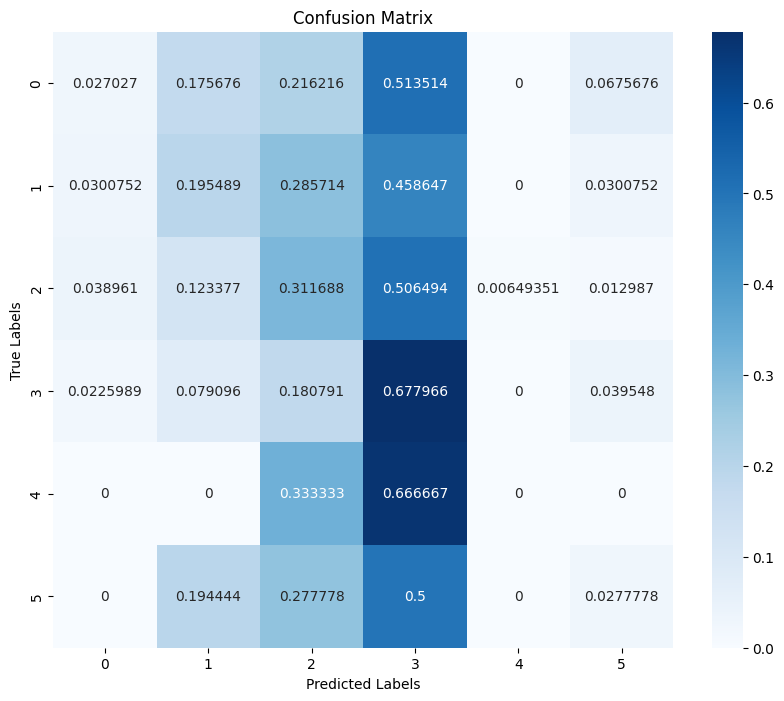

Epoch 10, Validation Loss: 2.9965, Accuracy: 0.3414, F1 Score: 0.2992
Val F1 Score Per Class  [0.04444444 0.24528302 0.32107023 0.48582996 0.         0.03636364]


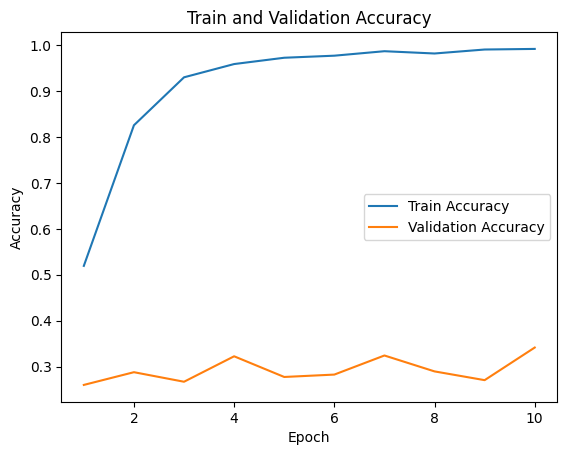

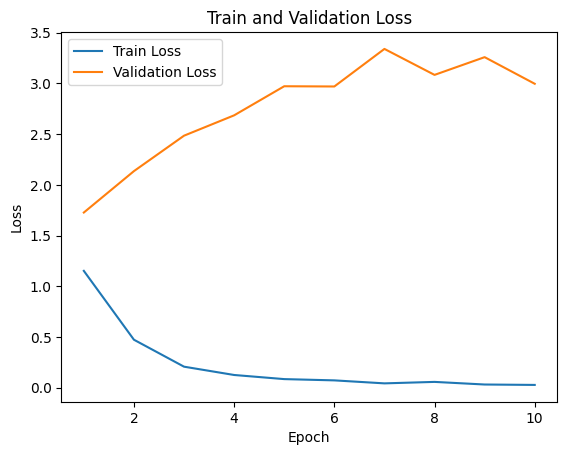

Epoch 11, Train Loss: 0.0148, Accuracy: 0.9964, F1 Score: 0.9964
Train F1 Score Per Class  [0.99758162 0.99400839 0.99425113 0.99411072 1.         0.99849895]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.40it/s, loss=3.92]

[tensor([-2.5283, -2.4383, -0.7693,  0.6475, -5.4691, -2.6657], device='cuda:0'), tensor([ 3.4194, -2.5776, -1.1244,  1.5373, -2.5304, -2.9456], device='cuda:0'), tensor([-3.6419, -0.2464, -1.3242,  2.0939, -3.5971, -4.2534], device='cuda:0'), tensor([-3.7126, -2.0133,  3.8697, -0.6290, -4.8065, -2.6069], device='cuda:0'), tensor([ 4.6139, -2.5324,  1.1105, -1.1748, -3.0890, -2.8304], device='cuda:0'), tensor([-2.3118,  1.1543, -0.0276, -0.3437, -4.9773, -5.0423], device='cuda:0'), tensor([-3.2119,  4.5659, -1.7380,  0.8745, -3.2060, -2.3543], device='cuda:0'), tensor([-0.2572, -1.3659, -0.9628,  4.7087, -4.0001, -4.0682], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.40it/s, loss=3.61]

[tensor([-2.9664,  0.7653, -0.9301,  1.7849, -2.8105, -2.6831], device='cuda:0'), tensor([-3.0542, -2.3563, -0.2103,  2.9609, -4.2298, -3.6229], device='cuda:0'), tensor([ 6.0707, -2.6736, -1.3994,  0.3570, -2.4933, -2.6431], device='cuda:0'), tensor([-2.2366, -1.3270, -2.2491,  0.3978, -0.7331, -1.5036], device='cuda:0'), tensor([-1.7790,  0.2821, -1.6616,  5.7253, -4.3027, -3.1343], device='cuda:0'), tensor([-0.9427, -2.4254, -1.3050, -1.6492, -4.2590, -3.3516], device='cuda:0'), tensor([-2.2772, -0.2882, -1.4684,  4.7938, -4.5147, -1.8313], device='cuda:0'), tensor([-1.2463, -2.6847, -3.1781,  4.8643, -3.6706, -0.5945], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=1.49]

[tensor([-3.2821, -1.1393, -1.5271,  4.2983, -3.5940, -3.8363], device='cuda:0'), tensor([-0.4798, -2.5316, -0.4651,  2.5095, -2.2618, -3.5429], device='cuda:0'), tensor([-0.7679,  2.1698,  2.1282, -2.7385, -3.2155, -3.1828], device='cuda:0'), tensor([-2.2251, -1.1794,  0.8855, -0.3101, -4.2814, -4.5174], device='cuda:0'), tensor([ 1.7460, -0.7457, -2.7700,  2.5074, -4.5856, -2.4005], device='cuda:0'), tensor([-1.5603,  0.0478,  3.5796, -0.3710, -4.8807, -4.8170], device='cuda:0'), tensor([-3.0358,  1.4934, -1.2590, -0.6893, -4.3884, -0.5021], device='cuda:0'), tensor([-1.6046, -1.2711, -0.9578,  5.2804, -4.1069, -3.8697], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.38it/s, loss=3.78]

[tensor([ 6.7735, -1.3400, -2.0269, -0.8419, -2.1545, -2.3276], device='cuda:0'), tensor([-1.9682, -2.2512, -1.3596,  6.7315, -3.1107, -2.5397], device='cuda:0'), tensor([-2.9523, -1.3301, -0.3060,  6.0678, -4.0659, -3.5343], device='cuda:0'), tensor([-2.6354, -0.9085, -1.9499,  0.6381, -4.7242, -0.1780], device='cuda:0'), tensor([-0.9480, -1.9229,  6.8866, -1.8828, -2.8474, -1.6680], device='cuda:0'), tensor([-1.0123, -1.9339, -1.3376,  4.7373, -4.1017, -3.9644], device='cuda:0'), tensor([-2.2720, -3.8328,  1.0866,  1.3535, -3.9611, -1.6627], device='cuda:0'), tensor([ 1.0103, -2.3359, -1.4295,  3.8198, -3.6817, -3.0349], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.38it/s, loss=4.5]

[tensor([-2.6689, -0.4663, -1.5952, -0.4455, -5.1079, -3.0052], device='cuda:0'), tensor([-2.5823, -3.3588,  0.4768,  0.1006, -3.0899, -1.0211], device='cuda:0'), tensor([-2.4767, -0.1410, -2.8247,  3.5260, -3.9374, -3.2344], device='cuda:0'), tensor([-1.0504, -2.3842,  7.0115, -1.7304, -2.5584, -2.3458], device='cuda:0'), tensor([-1.8146, -3.1014,  2.7535, -0.8946, -3.2744, -0.6743], device='cuda:0'), tensor([-3.1381, -0.3065,  1.5035,  1.6445, -4.0342, -3.4607], device='cuda:0'), tensor([-3.0666, -1.2677,  2.2095,  0.9652, -4.6558, -3.6173], device='cuda:0'), tensor([-3.4690,  1.2543,  1.3774,  0.6181, -4.5774, -4.3415], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.38it/s, loss=4.7]

[tensor([-3.0772, -0.5503, -1.4780,  4.7170, -4.3656, -3.4267], device='cuda:0'), tensor([-2.2020, -0.2106, -2.4959,  2.6760, -3.6706, -1.8472], device='cuda:0'), tensor([-3.8434,  2.5189,  0.6997, -0.0316, -3.8905, -2.6239], device='cuda:0'), tensor([-1.1898, -1.4109, -1.1797, -0.0061, -4.9030, -3.7129], device='cuda:0'), tensor([-1.9115, -2.3003, -1.6749,  5.0444, -4.1531, -0.9585], device='cuda:0'), tensor([-3.5274, -0.9697,  2.7953, -2.0989, -4.6275, -3.6819], device='cuda:0'), tensor([-3.4578,  5.2567, -0.8880, -2.1437, -2.9736, -2.6879], device='cuda:0'), tensor([-2.6314,  1.7064,  0.0271,  0.3605, -3.7149, -2.2455], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.39it/s, loss=2.1]

[tensor([-2.2858, -1.0631,  4.4464, -1.2019, -4.8772, -4.1270], device='cuda:0'), tensor([-1.9763, -1.8086,  6.8959, -0.8600, -3.5587, -2.8122], device='cuda:0'), tensor([-1.0429, -2.1080, -1.4698,  4.6806, -3.5579, -0.9409], device='cuda:0'), tensor([-1.1304, -2.1129,  2.3710,  0.5703, -4.8922, -3.0856], device='cuda:0'), tensor([-0.0053, -1.0272,  2.2323,  1.8351, -4.3036, -4.3793], device='cuda:0'), tensor([-1.9086, -2.2646, -1.7509,  5.7409, -3.0880, -1.2026], device='cuda:0'), tensor([-3.1421, -1.1057, -1.8110,  3.1508, -4.0788, -2.8431], device='cuda:0'), tensor([-1.1659, -1.9864,  6.9492, -2.0995, -2.1534, -1.4789], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.38it/s, loss=4.28]

[tensor([-2.5764, -0.4044, -1.7716,  4.8686, -2.8398, -2.6692], device='cuda:0'), tensor([-1.8108, -0.7224, -1.8416, -0.8046, -2.6398, -2.3933], device='cuda:0'), tensor([ 6.1075, -1.6360, -2.3355, -1.2823, -2.9521, -1.5066], device='cuda:0'), tensor([-2.1763, -0.3614, -1.1298,  5.9492, -4.5279, -3.7360], device='cuda:0'), tensor([-3.1860, -0.6258, -1.9927,  3.9077, -4.0948, -1.9045], device='cuda:0'), tensor([-1.9480, -3.5056,  0.0340,  3.9736, -3.7588, -2.5267], device='cuda:0'), tensor([-0.9546, -2.5436, -0.2197,  2.7093, -4.3486, -3.4548], device='cuda:0'), tensor([-3.8315, -0.1486, -1.8836,  5.3332, -4.2150, -3.0441], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=3.11]

[tensor([-3.2166,  4.1332,  0.8190, -1.4977, -4.4237, -3.9405], device='cuda:0'), tensor([-2.6386, -1.6615, -0.1388,  5.7336, -4.2620, -3.1080], device='cuda:0'), tensor([ 0.5738, -2.7246, -1.3732,  5.5531, -4.3795, -2.9247], device='cuda:0'), tensor([-2.4692, -1.6993, -1.5706,  5.9043, -4.3551, -2.5489], device='cuda:0'), tensor([-2.8354, -1.3167, -0.6705,  3.7421, -4.7350, -3.6821], device='cuda:0'), tensor([-2.2752, -1.1226, -2.9784,  2.3145, -4.4627, -3.8615], device='cuda:0'), tensor([-4.1090, -1.8629,  0.8601,  0.4730, -4.3402, -3.3979], device='cuda:0'), tensor([-3.1246, -1.8676, -0.7374,  5.7651, -4.2948, -2.5005], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=5.47]

[tensor([-2.0566, -1.5344, -2.2182,  6.3171, -3.8774, -3.5186], device='cuda:0'), tensor([-2.0988, -1.2426, -1.9320,  5.0862, -3.5157, -2.4194], device='cuda:0'), tensor([-2.0638, -1.8896, -1.2130,  5.3904, -3.9043, -4.1991], device='cuda:0'), tensor([-3.6425,  0.4284, -0.3604, -0.1077, -4.5276, -3.8177], device='cuda:0'), tensor([-1.9505, -1.4382,  1.1316,  2.7376, -4.4736, -3.9026], device='cuda:0'), tensor([-2.9221, -1.5456, -1.1022,  3.1452, -4.3307, -3.1811], device='cuda:0'), tensor([-0.4063, -0.5095, -0.8051,  3.2907, -4.2710, -4.5078], device='cuda:0'), tensor([-1.1591, -1.2144, -1.5797,  5.8099, -4.1018, -3.7985], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.39it/s, loss=4.62]

[tensor([-2.6898, -0.0655, -1.6790,  2.0699, -3.8269, -3.7418], device='cuda:0'), tensor([-2.2435, -2.2623, -0.6687,  4.9729, -2.7948, -2.4641], device='cuda:0'), tensor([-4.3829,  1.5362,  0.0918,  1.2791, -4.7565, -3.7378], device='cuda:0'), tensor([-2.6177, -2.5540,  4.8148,  0.6600, -4.0087, -2.8008], device='cuda:0'), tensor([-3.0203, -1.7465,  0.0520,  6.1653, -4.5573, -2.8208], device='cuda:0'), tensor([-2.4110, -1.9287, -1.2128,  6.4792, -3.6439, -2.5203], device='cuda:0'), tensor([-1.7820, -1.4636, -1.0080,  6.0315, -4.2132, -3.5583], device='cuda:0'), tensor([-1.2122, -2.5589,  0.3902,  5.3799, -4.5251, -3.3156], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.40it/s, loss=3.1]

[tensor([-1.1341, -0.5992, -0.8009, -0.6962, -4.7012, -4.9991], device='cuda:0'), tensor([-3.1784, -1.7568,  3.6636,  0.4462, -4.4044, -4.0370], device='cuda:0'), tensor([-2.1841, -2.7182, -0.8055,  6.0080, -4.2679, -2.4419], device='cuda:0'), tensor([-1.4200, -1.8250, -0.6944,  1.1825, -4.9591, -1.1076], device='cuda:0'), tensor([-1.3864,  1.7995, -0.8460,  1.1065, -5.3304, -4.4953], device='cuda:0'), tensor([-1.9359,  1.0752, -1.7269, -0.6750, -4.1978, -4.4858], device='cuda:0'), tensor([-2.6225, -3.1602,  0.2253,  0.9431, -4.3073, -2.5215], device='cuda:0'), tensor([-1.9172, -2.7344, -1.0906,  4.4013, -4.7367, -3.1038], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=3.48]

[tensor([-2.6332, -1.6222, -2.1454,  3.1812, -3.2891, -1.7982], device='cuda:0'), tensor([-2.0132, -2.0278, -0.8998,  6.4065, -4.3354, -2.9130], device='cuda:0'), tensor([-0.4657, -1.7198, -3.2382,  3.0733, -3.9598, -2.1738], device='cuda:0'), tensor([-2.6884, -2.0342,  1.9203,  3.6943, -4.4925, -3.8125], device='cuda:0'), tensor([-2.8051, -1.9363, -0.6680,  6.0680, -4.2996, -2.8051], device='cuda:0'), tensor([ 0.1999, -1.9879, -2.2833,  2.0231, -4.0472, -3.6442], device='cuda:0'), tensor([-3.5914, -1.5100, -0.7423, -0.9853, -4.3192, -3.2208], device='cuda:0'), tensor([-0.9650,  1.5954, -1.7341,  0.5166, -4.8245, -3.5062], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.66]

[tensor([-0.7379, -1.4626,  5.7124, -1.7768, -3.5854, -3.0883], device='cuda:0'), tensor([-1.3626,  0.3041, -1.6732, -0.5817, -4.5214, -4.5934], device='cuda:0'), tensor([-1.2744, -1.3827, -1.1915,  1.7389, -4.6711, -4.2673], device='cuda:0'), tensor([-2.0133, -2.1438,  0.2796, -0.1620, -4.4988, -3.5394], device='cuda:0'), tensor([-2.3258,  5.6378, -1.6327, -0.7208, -3.5775, -3.8684], device='cuda:0'), tensor([-2.3209, -0.2743, -0.6986,  2.7035, -4.3369, -3.8104], device='cuda:0'), tensor([-1.8746, -0.6072, -2.0630,  4.3718, -4.5260, -3.6991], device='cuda:0'), tensor([-2.0058, -0.2951, -1.5472, -0.0336, -4.9593, -4.2551], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.40it/s, loss=3.46]

[tensor([-2.5204, -1.8144, -0.7495,  1.9626, -3.8664, -3.6365], device='cuda:0'), tensor([-2.7272, -2.1713, -2.2747,  4.4518, -3.8923, -0.4260], device='cuda:0'), tensor([-2.0719, -2.7638, -0.7911,  5.3854, -2.7805, -2.5331], device='cuda:0'), tensor([-1.2148, -1.3263, -1.5776,  2.1053, -4.6220, -3.9860], device='cuda:0'), tensor([-1.1046, -2.6453,  5.5083, -2.2926, -3.5906, -2.3041], device='cuda:0'), tensor([-0.8037, -3.5401, -0.6244,  3.9593, -4.4757, -2.8934], device='cuda:0'), tensor([-2.2923, -0.8317, -2.5980,  5.0055, -3.1239, -1.5064], device='cuda:0'), tensor([-2.8824, -1.0209, -0.7502,  6.1163, -3.9989, -3.4063], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.40it/s, loss=4.05]

[tensor([ 1.6379, -1.9235, -1.1745,  3.0427, -4.6867, -4.2414], device='cuda:0'), tensor([-3.8903, -2.3391,  0.1434,  3.6589, -4.2106, -2.5109], device='cuda:0'), tensor([-2.3704, -1.8747, -0.4120, -0.7473, -3.1824,  6.6369], device='cuda:0'), tensor([-1.7210, -2.3346,  0.7162,  2.7267, -5.0853, -2.7591], device='cuda:0'), tensor([ 3.7758, -1.9107,  0.3425, -1.2733, -3.8950, -3.2172], device='cuda:0'), tensor([-1.4842, -0.8846, -1.3782,  2.8633, -4.4552, -3.4693], device='cuda:0'), tensor([-2.2925, -1.6704, -0.7431,  1.9395, -4.3049, -3.5456], device='cuda:0'), tensor([ 3.6594, -1.8297, -2.6644, -0.3092, -3.1980,  0.3538], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=3.51]

[tensor([-0.9686,  1.7987, -1.7621,  1.0087, -3.6905, -3.1080], device='cuda:0'), tensor([-1.2542, -0.3135, -1.1445,  4.8045, -4.9196, -4.4096], device='cuda:0'), tensor([-3.1011, -1.6370, -1.4994,  2.1144, -4.2824, -0.6620], device='cuda:0'), tensor([-2.8389, -2.1664,  0.6125,  4.1502, -3.7670, -3.0496], device='cuda:0'), tensor([ 6.2800, -2.4136, -1.3207,  0.3667, -2.5548, -2.9378], device='cuda:0'), tensor([ 0.4801,  2.7194, -1.3671, -2.2415, -4.0486, -5.2123], device='cuda:0'), tensor([-2.1275, -2.5480,  3.9785,  1.5884, -4.7150, -3.2389], device='cuda:0'), tensor([-2.3882, -2.2852,  2.1513,  1.8824, -4.1294, -3.7380], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.39it/s, loss=2.56]

[tensor([-1.2582, -0.6286, -1.6610,  0.7123, -3.4600, -3.4999], device='cuda:0'), tensor([-2.3070, -1.1644, -0.5010,  2.8679, -2.6486, -3.2133], device='cuda:0'), tensor([-1.6954, -0.7743,  0.9141,  0.9048, -4.7121, -3.9825], device='cuda:0'), tensor([-2.6962, -2.5709, -1.3822,  6.4308, -3.1242, -2.5438], device='cuda:0'), tensor([-2.8000, -0.5426, -1.9317,  1.9496, -4.0215, -0.8389], device='cuda:0'), tensor([ 4.5611, -1.3768, -1.7075, -0.5362, -4.9102, -2.4518], device='cuda:0'), tensor([-1.4466, -1.2875, -0.9281,  2.4459, -3.5290, -3.1124], device='cuda:0'), tensor([-2.7142, -1.4042,  2.4971,  0.1814, -4.7093, -3.6695], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.40it/s, loss=3.01]

[tensor([-4.1166, -0.5706, -1.2001,  4.1513, -2.2778, -1.8519], device='cuda:0'), tensor([-2.2487, -0.1328, -1.5942,  0.8129, -2.8055, -2.6918], device='cuda:0'), tensor([-1.3887, -2.5148,  4.5797, -0.4904, -3.7229, -1.9579], device='cuda:0'), tensor([-2.8057, -0.6960, -0.4333,  3.9264, -2.0623, -3.6225], device='cuda:0'), tensor([-3.3513,  2.4405,  0.5460, -0.5016, -3.1143, -3.2207], device='cuda:0'), tensor([-1.2236, -0.1339, -1.9540,  4.7585, -4.1338, -3.5582], device='cuda:0'), tensor([-1.9077, -2.2069, -0.7002,  6.5650, -3.9588, -2.4798], device='cuda:0'), tensor([-2.0982, -1.9702, -1.7748,  3.4170, -4.4831, -3.4356], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=2.75]

[tensor([-3.6893,  2.9408, -0.8574, -0.6760, -4.0757, -2.7617], device='cuda:0'), tensor([-1.9381, -1.0796, -1.6355,  5.2750, -4.5347, -2.7928], device='cuda:0'), tensor([-2.4219, -1.5987,  0.4047, -1.5913, -4.2071, -2.9195], device='cuda:0'), tensor([-1.8512, -0.2697,  5.3736, -2.3804, -3.1747, -2.9857], device='cuda:0'), tensor([-3.8810,  2.1566, -1.3405,  2.5418, -4.0440, -4.3964], device='cuda:0'), tensor([-3.4711, -1.5191,  0.6985, -1.2792, -4.4101, -2.2068], device='cuda:0'), tensor([ 0.9318, -0.8564, -1.7019,  1.4790, -3.6715, -2.3922], device='cuda:0'), tensor([-2.1529,  5.1446, -2.2503,  0.1346, -2.4842, -3.6228], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.40it/s, loss=6]

[tensor([-1.1863, -1.8867,  6.4790, -2.6594, -2.7241, -1.6374], device='cuda:0'), tensor([-2.0272,  5.8217, -1.4092, -0.6483, -4.0454, -3.8880], device='cuda:0'), tensor([-2.7652, -1.6262, -1.5035,  6.5397, -3.3624, -3.1832], device='cuda:0'), tensor([-3.2343, -0.0903, -2.4161,  4.6070, -3.9140, -1.8991], device='cuda:0'), tensor([-1.7023,  5.5697, -1.7784, -1.3547, -2.8334, -2.3507], device='cuda:0'), tensor([-1.3615, -2.4198, -2.1110,  0.7181, -3.6429, -2.9632], device='cuda:0'), tensor([ 1.5924,  2.0079, -2.1217, -1.9186, -4.1472, -2.8488], device='cuda:0'), tensor([-1.6143, -1.4694, -0.4982,  4.4114, -3.8073, -4.2337], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.39it/s, loss=3.07]

[tensor([-1.1169, -2.2907,  1.9530, -0.8288, -4.2785, -3.7545], device='cuda:0'), tensor([-2.3762, -2.4077,  0.9821, -0.4769, -3.8678, -3.3218], device='cuda:0'), tensor([-1.4499, -0.5416,  2.5219, -0.9745, -5.4077, -4.5353], device='cuda:0'), tensor([-2.9205, -1.5294, -1.2547,  5.4038, -3.9124, -3.0773], device='cuda:0'), tensor([-2.5580, -0.2247, -1.5007,  2.0418, -4.2690, -4.0451], device='cuda:0'), tensor([-1.0912, -1.8653,  2.5121, -0.9800, -4.3883, -3.7825], device='cuda:0'), tensor([-1.9046, -2.6165, -0.4389,  5.1680, -4.6890, -2.4891], device='cuda:0'), tensor([-1.5763, -1.7550,  3.2197, -1.3002, -4.9256, -4.0649], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=3.68]

[tensor([-1.7809, -2.2790, -2.1601, -0.8842, -2.8916, -2.9406], device='cuda:0'), tensor([-3.3907,  4.0670,  3.0786, -2.6076, -3.9224, -3.6484], device='cuda:0'), tensor([-2.5786, -0.3036, -1.3567,  5.2971, -4.6712, -3.4535], device='cuda:0'), tensor([-1.3061,  5.0932, -0.7866, -1.3449, -2.9197, -2.5571], device='cuda:0'), tensor([-3.5744, -1.9704, -1.1144,  0.8002, -4.3667, -4.1172], device='cuda:0'), tensor([-2.6019,  6.3583, -0.9605, -1.3235, -3.2572, -3.2132], device='cuda:0'), tensor([-2.4530, -3.3669,  0.9216, -0.4213, -3.3746,  0.0454], device='cuda:0'), tensor([-3.2995, -0.1242, -1.5955,  1.4719, -4.5626, -1.1181], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=3.72]

[tensor([-2.8085, -2.2009,  3.9555,  0.8909, -3.8052, -3.8868], device='cuda:0'), tensor([-2.4109, -0.1543, -1.1815,  4.6238, -3.5221, -3.4666], device='cuda:0'), tensor([-3.2980,  4.1044, -2.4051,  1.0849, -4.6075, -2.6234], device='cuda:0'), tensor([-1.2000, -2.5914, -2.0569,  4.3113, -3.6813, -2.1222], device='cuda:0'), tensor([-1.1282, -2.7922, -2.0273,  5.9115, -3.5621, -2.2167], device='cuda:0'), tensor([-2.2763, -1.8691, -1.1802,  4.0369, -4.7034, -3.5733], device='cuda:0'), tensor([-0.6559, -0.6635, -2.2574,  0.3006, -4.3697, -2.4268], device='cuda:0'), tensor([-2.6085, -1.4431, -1.5962,  0.2217, -4.0544, -3.2213], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=2.03]

[tensor([-3.0203, -2.1289,  4.1861, -0.9509, -4.3779, -3.6307], device='cuda:0'), tensor([-2.9886,  3.7020, -0.5164,  1.2262, -4.6652, -3.5888], device='cuda:0'), tensor([-2.8809, -1.1762, -1.2237,  3.2507, -4.7713, -3.0751], device='cuda:0'), tensor([-3.5102, -0.2676, -1.5800,  4.4757, -3.9494, -2.3895], device='cuda:0'), tensor([-0.7299,  0.0871, -3.0548,  1.1020, -3.6881, -3.5112], device='cuda:0'), tensor([-1.4976, -2.0466,  2.2097,  0.8570, -3.6036, -3.5887], device='cuda:0'), tensor([-1.0471, -1.6757, -3.3237,  4.3089, -4.3952, -2.6177], device='cuda:0'), tensor([ 1.8353, -1.4942, -2.1189, -0.7306, -2.8827, -2.9267], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=1.5]

[tensor([-2.2652, -1.5112, -0.7905,  5.8830, -4.5340, -3.4500], device='cuda:0'), tensor([-2.9120, -1.3954, -1.2324,  6.3482, -4.5413, -2.3812], device='cuda:0'), tensor([-2.1427, -3.2558,  1.7854,  0.0454, -3.7896, -3.0739], device='cuda:0'), tensor([ 5.4085, -2.9530, -1.5495,  0.0661, -3.6245, -2.6111], device='cuda:0'), tensor([-2.7722,  2.9932,  0.0439,  1.3435, -5.0445, -3.8428], device='cuda:0'), tensor([ 0.4162, -3.4223,  2.2851,  1.9548, -4.6376, -3.3936], device='cuda:0'), tensor([ 0.2065, -0.5753, -1.7976, -0.3031, -2.4200, -4.0520], device='cuda:0'), tensor([-3.1746,  1.5815, -1.0039, -0.6415, -4.6425, -2.9109], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=3.34]

[tensor([-2.8929, -1.0629,  1.1399,  3.8095, -4.7385, -3.5509], device='cuda:0'), tensor([-3.0029, -1.5997, -0.0782,  4.8710, -4.0416, -3.3879], device='cuda:0'), tensor([-0.8426, -2.2350, -1.6795,  4.9522, -3.6654, -2.5354], device='cuda:0'), tensor([-3.1214, -2.4926,  0.0237,  2.7386, -4.9697, -2.1480], device='cuda:0'), tensor([-1.4930,  2.7486, -1.1949, -0.4034, -3.6541, -2.7897], device='cuda:0'), tensor([-3.6180, -0.1912,  2.8108, -0.7743, -5.3760, -3.5760], device='cuda:0'), tensor([-2.8147, -2.4744,  0.7362,  1.7181, -4.3105, -2.7643], device='cuda:0'), tensor([-2.1318, -0.2484, -2.0828,  5.6650, -4.4195, -2.9688], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=3.29]

[tensor([-0.6070, -2.2290, -1.5441,  6.4841, -3.9576, -3.0002], device='cuda:0'), tensor([-2.4714, -2.4544, -1.1968,  6.0621, -3.6724, -2.3424], device='cuda:0'), tensor([-1.3461,  0.2290,  0.0620, -2.3384, -3.5192, -3.1448], device='cuda:0'), tensor([-2.2694, -2.3551,  1.0326,  5.3668, -3.7562, -3.4970], device='cuda:0'), tensor([-2.3803, -2.4274, -1.2839,  6.2461, -3.7678, -2.6648], device='cuda:0'), tensor([-2.9058, -0.6093,  0.2064,  4.4343, -4.9819, -4.1372], device='cuda:0'), tensor([-3.3893, -0.9222,  2.1858, -0.0380, -5.1091, -3.6429], device='cuda:0'), tensor([-3.0669, -0.7479, -0.0370,  1.1570, -4.5942, -3.6654], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=3.28]

[tensor([-3.1747, -1.2031, -1.5678,  6.2535, -3.0256, -2.1062], device='cuda:0'), tensor([-3.4529, -0.5536, -0.0222,  0.6244, -4.1091, -1.8280], device='cuda:0'), tensor([-3.5658, -2.6963,  4.4774, -0.5349, -3.6877, -1.9697], device='cuda:0'), tensor([-3.6935, -0.5352,  0.2143,  2.7171, -3.5987, -3.9126], device='cuda:0'), tensor([ 0.5220,  1.8697, -1.2135, -0.4658, -4.9411, -4.0885], device='cuda:0'), tensor([-1.8330, -1.8389,  1.9106,  0.7704, -5.2979, -3.0471], device='cuda:0'), tensor([-3.0747, -1.9751,  0.0719,  1.3956, -3.4594, -2.6163], device='cuda:0'), tensor([-3.5447, -1.6138, -0.1015,  4.0728, -4.5429, -4.2311], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=4.22]

[tensor([-3.0548,  4.5191, -1.0307,  0.3368, -3.9905, -3.5089], device='cuda:0'), tensor([-3.1908, -1.5553, -0.5262,  5.3245, -3.7940, -3.0932], device='cuda:0'), tensor([ 0.4838, -0.7451, -2.0222, -0.4003, -3.6120, -2.4053], device='cuda:0'), tensor([-1.5457, -2.1402, -1.1365,  6.4755, -3.8397, -2.4500], device='cuda:0'), tensor([-2.4309,  0.0145, -2.2518, -1.6632, -4.8996, -2.9893], device='cuda:0'), tensor([-1.9696, -2.9482,  4.1605, -1.1247, -3.2788, -2.1977], device='cuda:0'), tensor([-2.4373, -2.3596,  2.5395,  2.3447, -4.9109, -4.2193], device='cuda:0'), tensor([-0.9308, -1.8219, -0.2921, -1.5288, -2.3581,  7.6884], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.39it/s, loss=3.8]

[tensor([-2.8773, -0.9580, -2.1508,  6.0377, -3.4516, -2.4869], device='cuda:0'), tensor([-2.5089, -1.4220, -1.6549,  5.5661, -4.7722, -3.1427], device='cuda:0'), tensor([-3.4388,  0.2011, -0.7480,  2.1973, -3.7046, -2.0074], device='cuda:0'), tensor([-2.5227,  0.8406, -2.4354, -0.4467, -5.0105, -1.8541], device='cuda:0'), tensor([-2.3078, -1.7114, -0.3639,  5.0353, -4.0376, -3.7806], device='cuda:0'), tensor([ 6.6641, -0.9284, -1.6088, -1.5803, -2.5957, -1.7025], device='cuda:0'), tensor([-2.0086, -2.2555, -0.5660,  4.1752, -3.9999, -3.8417], device='cuda:0'), tensor([-2.6294, -1.6164,  0.6187,  3.3264, -4.2507, -3.8616], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=4.88]

[tensor([-2.2681,  0.2641, -3.2378,  0.8129, -2.3680, -1.5520], device='cuda:0'), tensor([-2.4614, -1.7069, -1.4136,  6.6297, -3.8187, -2.5744], device='cuda:0'), tensor([-1.5870,  6.3988, -1.7003, -1.4853, -2.1841, -3.1762], device='cuda:0'), tensor([-2.1880,  2.2755, -2.1739, -1.3121,  3.0472, -1.0320], device='cuda:0'), tensor([ 2.5759, -1.2486, -1.2257,  0.8648, -2.8245, -3.5930], device='cuda:0'), tensor([-2.6346, -2.4847,  0.5496,  1.7616, -4.3709, -2.3309], device='cuda:0'), tensor([ 2.9543, -1.2755, -2.1223,  0.2164, -3.8056, -3.1331], device='cuda:0'), tensor([-0.8642, -2.2140, -0.0738,  2.8509, -5.0612, -3.9358], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.39it/s, loss=5.13]

[tensor([-2.9427, -1.9244, -1.0860,  6.2744, -3.2779, -2.4306], device='cuda:0'), tensor([-2.6097,  5.2450, -1.6920,  0.7572, -3.4003, -2.9043], device='cuda:0'), tensor([-1.8027, -1.5712, -0.7978,  2.3858, -5.7319, -3.4781], device='cuda:0'), tensor([-1.4599,  3.9588,  0.5142, -2.2096, -4.1420, -4.8082], device='cuda:0'), tensor([-3.4764, -1.4578,  4.7541, -1.3620, -3.0235, -2.5138], device='cuda:0'), tensor([-2.2539, -2.0816, -1.5712,  6.4534, -3.5306, -2.5573], device='cuda:0'), tensor([ 0.3949,  0.6153, -1.4207, -0.1681, -4.8238, -3.9552], device='cuda:0'), tensor([-2.8493, -1.0553, -1.9409,  5.6204, -3.5096, -2.8237], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.39it/s, loss=4.6]

[tensor([ 7.2231, -0.6027, -2.3785, -1.1564, -2.2829, -2.2376], device='cuda:0'), tensor([-3.1984, -1.8063, -0.2711,  5.1809, -4.6453, -3.4537], device='cuda:0'), tensor([-2.0310,  3.5307, -2.0003,  0.6466, -0.6908, -3.3809], device='cuda:0'), tensor([-3.1855, -2.5016, -0.5130,  4.7809, -4.9239, -2.5541], device='cuda:0'), tensor([-2.9287, -1.0069, -1.9417,  3.9370, -4.7152, -3.3781], device='cuda:0'), tensor([-3.2341,  1.2370, -1.5002,  0.4932, -4.4157, -2.7781], device='cuda:0'), tensor([-1.9669, -2.2293, -1.7712,  5.1871, -4.1196, -3.5801], device='cuda:0'), tensor([-1.7513, -1.1562,  6.9432, -2.0657, -3.2848, -2.4870], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.40it/s, loss=2.89]

[tensor([-2.1537, -1.1358, -1.2255, -0.6526, -4.8051, -3.1815], device='cuda:0'), tensor([-1.9738, -0.6784, -2.2040,  2.3208, -4.2741, -3.7018], device='cuda:0'), tensor([-1.4784, -2.5871,  1.2441,  2.3315, -4.7862, -3.1599], device='cuda:0'), tensor([-1.6257, -1.2196,  6.8369, -1.4221, -3.0790, -2.6328], device='cuda:0'), tensor([-4.2222,  0.7824,  0.1594,  1.7760, -4.8724, -3.2835], device='cuda:0'), tensor([-2.0971, -2.8354, -0.0839,  3.9492, -4.3974, -1.8156], device='cuda:0'), tensor([-2.5935, -1.7321, -0.0878,  4.6158, -4.3918, -3.9475], device='cuda:0'), tensor([-2.4763, -0.0218,  0.1094,  2.7582, -3.7917, -3.2219], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.40it/s, loss=2.67]

[tensor([-2.8482,  0.3651,  0.1602,  0.5206, -3.5135, -4.1016], device='cuda:0'), tensor([-0.2163, -2.5044,  3.4288, -1.6025, -3.6014, -4.3213], device='cuda:0'), tensor([-1.8102, -1.5943, -0.1938,  0.6848, -4.5366, -1.9535], device='cuda:0'), tensor([-2.3669,  6.0157, -2.1587,  0.0649, -3.8666, -3.3836], device='cuda:0'), tensor([-2.9808, -1.9523,  0.4393,  4.6654, -4.3907, -2.9691], device='cuda:0'), tensor([-2.1648, -1.9850, -1.6108,  6.5345, -3.4490, -3.2332], device='cuda:0'), tensor([-2.6547, -2.0512, -0.5012,  5.3373, -4.0269, -4.0320], device='cuda:0'), tensor([-2.2977, -0.5892, -1.0583,  2.5231, -4.2050, -3.3658], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.40it/s, loss=3.13]

[tensor([ 2.4170, -3.0608, -2.2590,  0.8536, -4.0690, -2.1622], device='cuda:0'), tensor([-3.6636, -1.4684,  0.5094,  4.3286, -4.7483, -4.0102], device='cuda:0'), tensor([-2.7081, -1.4508, -1.6550,  5.7455, -3.5594, -3.3117], device='cuda:0'), tensor([-3.9917,  3.9479, -1.5043, -0.7864, -3.1796,  0.5857], device='cuda:0'), tensor([-1.8637,  0.1192,  2.1070, -0.2799, -4.1287, -2.9412], device='cuda:0'), tensor([ 0.7071, -0.9231,  3.8879, -2.1287, -3.4085, -3.8934], device='cuda:0'), tensor([-0.2638, -1.1184,  0.0868,  0.2424, -4.5460, -4.4008], device='cuda:0'), tensor([-3.7361,  1.5836, -0.3685,  3.4480, -3.4019, -4.0690], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.40it/s, loss=2.29]

[tensor([-1.4512, -2.5438,  4.3041, -0.6822, -3.1120, -1.0223], device='cuda:0'), tensor([-2.0913,  1.0757, -2.0746,  0.8333, -4.8286, -1.4282], device='cuda:0'), tensor([-0.9574, -1.8860, -0.8203,  4.9037, -4.8678, -3.8700], device='cuda:0'), tensor([-1.1079, -1.3883, -2.6447,  1.4841, -2.6055, -3.0264], device='cuda:0'), tensor([-3.1849, -1.2063, -0.3316,  3.2807, -4.0820, -4.1991], device='cuda:0'), tensor([-1.7066,  5.2861, -2.4212,  0.1872, -2.9659, -2.8337], device='cuda:0'), tensor([-2.1927,  0.4251, -1.4844,  0.3569, -3.6102, -3.8699], device='cuda:0'), tensor([-2.9516, -1.8098,  0.6368,  4.5891, -4.6323, -3.6250], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.40it/s, loss=3.57]

[tensor([-1.3456, -2.1212,  2.6498,  0.6531, -3.8805, -4.0733], device='cuda:0'), tensor([-2.6687, -0.6051, -0.0956,  4.3885, -4.0017, -4.2080], device='cuda:0'), tensor([ 0.2488, -2.5205, -1.6245, -0.6176, -3.7596, -2.4572], device='cuda:0'), tensor([-0.8396, -2.7446, -0.2095,  3.1227, -5.1002, -3.4864], device='cuda:0'), tensor([-2.4755, -2.0481, -1.2622,  5.8989, -4.6339, -3.4330], device='cuda:0'), tensor([-3.3174, -1.5294,  4.4879,  0.2960, -4.3859, -2.9303], device='cuda:0'), tensor([ 0.2861, -1.8906,  1.2134, -1.1333, -4.7987, -3.7116], device='cuda:0'), tensor([-4.2790,  1.1043, -0.7968,  0.4026, -4.8872, -0.7889], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.40it/s, loss=3.57]

[tensor([-0.0889, -2.1567,  3.8712,  0.2036, -4.3511, -3.0196], device='cuda:0'), tensor([-1.0181, -2.3806,  2.1900, -1.3360, -3.6411, -3.6560], device='cuda:0'), tensor([-1.0988, -1.9791,  0.0702,  2.8830, -5.4741, -1.8667], device='cuda:0'), tensor([ 0.9983, -1.4166, -2.3119,  4.2744, -4.2571, -3.2869], device='cuda:0'), tensor([-2.6787, -0.9387, -1.5427,  4.2235, -3.8765, -1.8478], device='cuda:0'), tensor([ 3.5663, -1.8717, -2.6346,  0.2585, -3.4607, -3.1837], device='cuda:0'), tensor([-3.6183, -0.0740, -0.0950,  4.0573, -3.8730, -3.3876], device='cuda:0'), tensor([-0.3815, -0.9897, -2.7563,  3.4940, -4.6797,  0.0354], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.40it/s, loss=2.91]

[tensor([-3.4226, -2.0803,  1.8263,  4.5731, -4.3984, -3.5593], device='cuda:0'), tensor([-1.4557, -0.4195, -0.5656,  2.5287, -2.8751, -3.1449], device='cuda:0'), tensor([-2.3633, -1.3279, -1.5859,  4.1506, -4.2850, -2.3970], device='cuda:0'), tensor([-3.0181, -1.1703, -1.3138,  6.2754, -3.8368, -3.2835], device='cuda:0'), tensor([-2.4252,  1.7667, -1.8258,  0.7021, -4.1249, -3.7690], device='cuda:0'), tensor([-2.6156, -1.4346, -2.1446,  5.0649, -4.1344, -3.2754], device='cuda:0'), tensor([-2.6847, -1.8124,  1.5013,  1.6080, -4.9509, -3.2184], device='cuda:0'), tensor([-2.4442, -0.5059, -1.8264,  3.3487, -4.0258, -3.9351], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.40it/s, loss=3.58]

[tensor([-3.1659, -1.8885, -0.6197,  4.9670, -3.7792, -3.6636], device='cuda:0'), tensor([ 6.6280, -1.6992, -1.2514, -0.6855, -2.7126, -1.9919], device='cuda:0'), tensor([-1.1448, -1.9577, -2.0866,  0.5237, -4.7041, -3.5468], device='cuda:0'), tensor([-1.0940, -0.8970, -3.0401,  3.0122, -3.4267, -1.8128], device='cuda:0'), tensor([-1.7939, -1.2986, -1.5441,  5.4277, -3.6069, -2.3938], device='cuda:0'), tensor([-1.4185, -2.4012, -1.9552,  6.6174, -3.4073, -2.8135], device='cuda:0'), tensor([-3.0839, -1.2922,  0.1718,  3.7666, -4.0288, -2.0561], device='cuda:0'), tensor([ 1.9474, -0.8526, -0.0850,  0.9977, -3.7847, -4.8670], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.40it/s, loss=1.4]

[tensor([-2.2815, -1.1265, -1.7965,  5.5352, -4.3148, -3.1809], device='cuda:0'), tensor([-1.6747, -1.2146,  0.2522, -1.8970, -4.6550, -3.9748], device='cuda:0'), tensor([ 1.4170, -0.2521, -2.4029,  2.1638, -4.3840, -3.3027], device='cuda:0'), tensor([-2.0477,  1.1024, -2.0819,  3.3467, -4.9989, -2.5567], device='cuda:0'), tensor([-3.3887, -0.0178, -1.2560,  1.2362, -4.9503, -2.4284], device='cuda:0'), tensor([-1.9874, -1.4285,  6.5374, -1.5364, -2.8005, -2.8133], device='cuda:0'), tensor([-3.4175, -1.7359,  5.4806,  0.6805, -4.1247, -2.7177], device='cuda:0'), tensor([-3.0799, -1.4717,  0.7001, -0.6102, -4.6708, -3.2955], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.40it/s, loss=4.64]

[tensor([-2.8753,  0.2268, -1.3165,  4.7865, -2.8993, -3.6415], device='cuda:0'), tensor([-1.4425, -2.1328,  0.4812,  1.5769, -5.1224, -3.8442], device='cuda:0'), tensor([-0.0901,  1.5753, -2.5583,  0.8589, -4.7117, -2.7893], device='cuda:0'), tensor([-1.3418, -1.9744, -1.6618, -0.5167, -1.7142,  7.2123], device='cuda:0'), tensor([-2.3581, -1.1828, -1.3996,  6.0642, -3.4195, -3.4343], device='cuda:0'), tensor([-2.2135, -1.0409, -2.5277,  5.1564, -4.0754, -2.8456], device='cuda:0'), tensor([-1.6311, -0.8929, -1.0568,  5.2179, -4.7404, -4.4337], device='cuda:0'), tensor([-3.1439,  1.2646, -1.2175,  3.8468, -4.0798, -3.7620], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.39it/s, loss=4.26]

[tensor([-3.7096, -0.3633, -0.3390,  1.7884, -4.9780, -2.2349], device='cuda:0'), tensor([-2.2221,  5.9885,  0.1652, -2.4444, -2.6913, -2.7229], device='cuda:0'), tensor([-1.6809,  0.7955, -0.2094, -0.0554, -5.7128, -3.9331], device='cuda:0'), tensor([-2.4894,  1.9970, -2.2061,  3.8480, -4.4125, -4.0697], device='cuda:0'), tensor([-1.6112, -2.2874, -2.0399,  6.6717, -3.7684, -1.7031], device='cuda:0'), tensor([ 1.9917, -2.5172, -1.3357,  1.1029, -3.6691, -2.3152], device='cuda:0'), tensor([ 1.3160, -0.5650, -2.4685, -1.5989,  1.7046, -3.9704], device='cuda:0'), tensor([-3.2431, -0.0772, -0.1424,  0.3603, -5.1049, -3.3669], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=4.84]

[tensor([-1.7832, -2.4097, -0.7527,  6.2908, -4.1450, -3.3381], device='cuda:0'), tensor([-1.3889, -1.7582, -0.0222, -1.2834, -4.8075, -4.1252], device='cuda:0'), tensor([-3.0519,  0.8342, -1.5385,  2.3429, -5.4462, -3.1692], device='cuda:0'), tensor([-1.8028, -1.1427,  2.3766,  0.3083, -4.6491, -4.0115], device='cuda:0'), tensor([-3.8149,  4.0749, -0.3520,  0.4434, -4.6354, -3.8456], device='cuda:0'), tensor([-2.4392, -1.7486,  1.0717,  2.1906, -4.7471, -3.5650], device='cuda:0'), tensor([-1.7281, -2.9742, -1.6691,  6.2604, -3.5833, -2.0278], device='cuda:0'), tensor([-0.6891,  2.3976, -2.5857,  2.4638, -4.5164, -3.1601], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.39it/s, loss=2.96]

[tensor([-1.6654, -1.5974, -1.3949,  0.2746, -2.7111, -0.1282], device='cuda:0'), tensor([ 2.3877, -2.7801,  3.1643, -0.7003, -3.4598, -3.1539], device='cuda:0'), tensor([-0.4441, -1.6234,  0.6554, -0.8087, -4.2347, -4.6894], device='cuda:0'), tensor([-2.1827, -1.8870,  5.9597, -0.9807, -3.6946, -2.9886], device='cuda:0'), tensor([-3.8289, -0.7147, -1.1375,  0.4330, -3.5141, -3.3515], device='cuda:0'), tensor([-2.4726, -0.9655, -0.0289,  0.1359, -5.5054,  1.0993], device='cuda:0'), tensor([-2.8602, -1.0185, -0.9011, -0.5473, -3.7723, -2.0691], device='cuda:0'), tensor([-2.3587,  2.8756, -1.1911, -0.7827, -4.9992, -4.0553], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=2.92]

[tensor([ 0.4927, -2.8524,  1.1008, -0.0706, -3.8847, -3.4753], device='cuda:0'), tensor([ 0.2790,  0.9149, -0.9814, -0.6215, -4.3572, -0.0806], device='cuda:0'), tensor([-1.7191, -2.0971, -0.8034,  0.5765, -4.3418, -1.0270], device='cuda:0'), tensor([-0.7656, -0.1845, -2.5671,  2.6993, -4.2940, -4.9044], device='cuda:0'), tensor([-1.9869, -2.0810, -0.9499,  5.6510, -4.9939, -2.6542], device='cuda:0'), tensor([-2.5418, -2.6234, -0.6472,  1.6938, -4.1606, -2.7942], device='cuda:0'), tensor([-2.9371, -0.8084, -0.6329,  3.3817, -5.0287, -3.9572], device='cuda:0'), tensor([ 2.4464, -2.0799, -2.0269,  1.9490, -4.0669, -3.3258], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.39it/s, loss=3.55]

[tensor([-3.2721,  0.2740,  2.7730,  0.3198, -4.2454, -4.6928], device='cuda:0'), tensor([-3.3258,  2.2599,  0.0922,  2.2518, -4.5790, -4.1902], device='cuda:0'), tensor([-2.4278, -3.0729,  0.2464,  4.4671, -4.2383, -0.6356], device='cuda:0'), tensor([-1.0118, -2.7601, -0.9623,  5.6845, -3.7034, -2.4121], device='cuda:0'), tensor([-1.5480, -1.0666, -1.9946,  4.3697, -4.3028, -3.6791], device='cuda:0'), tensor([-1.5217, -2.0441, -0.7601,  2.4577, -3.7740, -3.3052], device='cuda:0'), tensor([-2.5063, -1.3195,  1.2291,  1.1217, -4.0525, -4.2936], device='cuda:0'), tensor([-2.4055, -0.9776, -2.0255,  5.0340, -3.2700, -1.8107], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.39it/s, loss=3.91]

[tensor([-2.6326,  0.6322, -1.1785,  3.6912, -4.5142, -4.0139], device='cuda:0'), tensor([-2.0668,  4.8062, -1.2331, -1.1706, -4.0547, -2.6414], device='cuda:0'), tensor([ 0.1483, -2.7305, -2.1409,  5.6555, -4.0320, -2.9059], device='cuda:0'), tensor([-3.4253, -1.5349, -0.9065,  4.4638, -4.1610, -2.7019], device='cuda:0'), tensor([-0.7392,  0.4855, -2.0963,  3.0809, -5.0298, -3.7341], device='cuda:0'), tensor([-3.0805, -1.0561,  0.6233,  3.7507, -4.8326, -3.8003], device='cuda:0'), tensor([-3.4022,  0.6546, -1.4469,  0.7961, -4.4223, -3.6064], device='cuda:0'), tensor([-1.3498, -2.5455, -1.1138,  5.7371, -3.6222, -3.1696], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.39it/s, loss=2.48]

[tensor([-2.1814, -2.2793, -1.7200,  1.4989, -4.2604, -2.6432], device='cuda:0'), tensor([-2.2456, -2.4842, -0.6750,  6.0302, -4.1170, -2.8923], device='cuda:0'), tensor([-3.2030,  1.1749,  2.0591, -1.2623, -4.8601, -4.6966], device='cuda:0'), tensor([-3.7682,  1.5676, -0.5222,  1.7978, -3.8865, -4.3555], device='cuda:0'), tensor([ 0.4550, -3.3405, -0.4586,  5.3024, -4.0108, -3.2727], device='cuda:0'), tensor([-3.6398, -1.3834,  2.8108,  2.7422, -4.3124, -3.8571], device='cuda:0'), tensor([-3.0351, -1.3841,  2.0320,  2.2252, -4.3225, -3.8467], device='cuda:0'), tensor([-1.8352, -2.9380, -1.0979,  6.2692, -4.1296, -2.2515], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.39it/s, loss=3.49]

[tensor([-3.6710, -0.0341, -1.5526,  1.9726, -3.8249, -1.4906], device='cuda:0'), tensor([-2.2389, -1.5112, -1.2988,  4.1195, -4.3960, -4.6825], device='cuda:0'), tensor([-2.6189,  1.1055, -2.6658,  0.9597, -2.9755, -3.2007], device='cuda:0'), tensor([-1.5003, -1.6825, -1.2133,  0.1640, -3.9530, -3.7302], device='cuda:0'), tensor([-1.7638, -1.7040,  1.9546,  1.3714, -5.1748, -4.4087], device='cuda:0'), tensor([-3.9883,  2.8598,  0.4487, -0.2766, -4.4403, -2.9288], device='cuda:0'), tensor([-3.3733,  5.2354, -1.4507, -0.8643, -3.9150, -3.1358], device='cuda:0'), tensor([-2.7194,  0.1562, -1.6254, -0.6898, -4.3682, -3.4454], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.39it/s, loss=2.09]

[tensor([-0.0965, -2.1901, -1.1980,  2.7985, -3.9245, -2.0566], device='cuda:0'), tensor([-1.2922, -2.1449,  1.1223,  3.8440, -4.5170, -4.3854], device='cuda:0'), tensor([-4.1341, -4.1807,  0.0724,  3.1225, -3.4645, -1.2146], device='cuda:0'), tensor([-3.0612, -1.1472, -1.8046,  5.5203, -4.0024, -2.8381], device='cuda:0'), tensor([-1.6605, -3.0114, -0.4322,  3.5543, -4.7789, -3.6969], device='cuda:0'), tensor([-2.2589, -0.5939, -1.9516,  4.7883, -4.6530, -3.3957], device='cuda:0'), tensor([-1.6221,  2.6372, -1.2718, -0.5602, -3.3326, -1.3332], device='cuda:0'), tensor([-1.7769, -3.1336, -0.7572,  5.9319, -3.0692, -2.4575], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.39it/s, loss=2.39]

[tensor([-3.2488,  5.5719, -0.3464, -0.8584, -4.0856, -3.0679], device='cuda:0'), tensor([-2.1666, -2.0464,  3.4766,  0.0402, -4.4842, -3.7685], device='cuda:0'), tensor([ 2.6175, -0.9729, -1.1286, -1.3071, -3.8034, -3.1806], device='cuda:0'), tensor([-3.0369, -1.0540, -0.4489,  3.9496, -4.9135, -3.6115], device='cuda:0'), tensor([-3.1230, -1.3774, -1.2573,  2.2750, -4.4238, -2.9864], device='cuda:0'), tensor([-3.5335, -1.7513,  2.7097, -0.2613, -4.6645, -2.7546], device='cuda:0'), tensor([-2.3328, -1.0062, -1.9480,  4.5246, -4.4896, -4.1050], device='cuda:0'), tensor([-2.5031, -2.8304, -1.3564,  6.2328, -3.6253, -2.3717], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=3.31]

[tensor([ 3.4355, -2.0658, -2.1060,  1.3828, -4.4432, -3.9092], device='cuda:0'), tensor([-1.7910,  0.4622,  1.7959, -1.0724, -5.6852, -2.9462], device='cuda:0'), tensor([-2.1934, -0.5733,  1.1491,  0.8818, -3.1853, -3.8357], device='cuda:0'), tensor([-2.4356, -1.2416,  5.1548,  0.7956, -4.9086, -3.8204], device='cuda:0'), tensor([-1.5091, -0.8130, -2.2560, -0.7158, -4.5239, -0.9945], device='cuda:0'), tensor([-2.0973, -1.4500,  1.0578,  3.7158, -4.8451, -4.2249], device='cuda:0'), tensor([-3.4609, -1.6354,  0.3594, -0.6895, -3.7031, -3.4054], device='cuda:0'), tensor([-2.6620,  3.6114, -2.1447,  1.1736, -3.9686, -3.4195], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.39it/s, loss=6.72]

[tensor([-2.0345, -1.6618, -0.5812,  5.7929, -4.8418, -3.3623], device='cuda:0'), tensor([-3.0455, -1.4588, -0.4194,  4.5915, -4.8158, -3.9123], device='cuda:0'), tensor([-2.0571, -1.9988, -1.9280,  6.6063, -4.0987, -2.1433], device='cuda:0'), tensor([-3.2244, -1.4324, -1.5838,  2.2909, -4.6072, -4.1193], device='cuda:0'), tensor([-0.2363, -2.7940,  4.9229, -0.9831, -2.7171, -2.7949], device='cuda:0'), tensor([-2.1884, -2.2581, -0.6928,  5.7891, -4.0168, -2.1675], device='cuda:0'), tensor([-0.4748, -2.9754,  5.1471,  0.0265, -4.3236, -3.6122], device='cuda:0'), tensor([-1.8220, -2.9605, -0.7344,  6.2604, -4.1333, -2.5808], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.39it/s, loss=4.2]

[tensor([-3.1623, -0.6200,  0.2029,  4.9127, -4.2911, -3.5304], device='cuda:0'), tensor([-1.1775, -2.6570,  0.4484,  2.7022, -4.6382, -3.5903], device='cuda:0'), tensor([-3.3564, -0.6667,  5.7073, -1.7717, -3.2172, -2.3974], device='cuda:0'), tensor([-2.3266, -0.6129, -0.2628,  2.3350, -5.1784, -3.7499], device='cuda:0'), tensor([ 0.7975, -2.0497,  0.0275,  0.7322, -4.8343, -2.9598], device='cuda:0'), tensor([-2.4310, -0.7354, -1.4517,  4.7719, -4.2836, -3.6676], device='cuda:0'), tensor([-2.1005, -1.2385, -0.9503,  4.4681, -4.2179, -4.1747], device='cuda:0'), tensor([-3.6716, -1.4865, -0.9839,  2.2138, -4.3069, -4.2164], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.39it/s, loss=3.81]

[tensor([-2.2401, -2.7811,  1.7829,  0.8114, -4.0227, -2.9983], device='cuda:0'), tensor([-2.0147, -2.1593, -1.3328,  6.4851, -3.6455, -2.2879], device='cuda:0'), tensor([ 0.3773, -2.4542,  5.1328, -1.4662, -3.1036, -2.3540], device='cuda:0'), tensor([-2.6695,  3.3375, -0.2323,  1.2717, -3.9841, -3.9596], device='cuda:0'), tensor([-1.1804, -1.9702,  0.4914, -0.9479, -3.7683, -3.3947], device='cuda:0'), tensor([-1.5966, -2.6420,  5.9526,  0.4097, -3.6752, -2.4235], device='cuda:0'), tensor([-2.5070, -0.6888, -0.9625,  3.1990, -4.6109, -4.3764], device='cuda:0'), tensor([-2.9996, -2.2268,  4.2158, -1.0623, -3.2394, -2.2489], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.39it/s, loss=4.93]

[tensor([-2.4486, -1.3511, -0.6127,  5.9396, -4.8829, -3.2268], device='cuda:0'), tensor([-4.4013,  1.3363,  1.3058,  3.1314, -4.5577, -2.7808], device='cuda:0'), tensor([-1.5518, -1.9398, -1.0697,  6.2064, -4.5286, -2.5040], device='cuda:0'), tensor([-2.5919, -1.2939, -1.2119,  3.8738, -5.1527, -3.7075], device='cuda:0'), tensor([-2.3720, -1.4012, -1.4239,  6.4320, -3.5179, -2.6246], device='cuda:0'), tensor([-3.2674, -0.8058,  0.8121,  2.9348, -4.0249, -4.1486], device='cuda:0'), tensor([-2.8518, -0.6113, -2.1422,  5.6789, -4.0491, -3.3808], device='cuda:0'), tensor([ 5.5647,  0.2793, -0.5264, -1.2732, -3.2582, -3.9663], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.39it/s, loss=4.74]

[tensor([ 2.6231,  0.0649, -2.0569,  2.1014, -4.9524, -4.7399], device='cuda:0'), tensor([-4.1183,  2.3078,  0.0360,  1.3229, -5.2239, -3.4510], device='cuda:0'), tensor([-1.1795, -1.2085, -1.0589,  3.6961, -4.8229, -3.5235], device='cuda:0'), tensor([-3.0653,  0.9520, -2.6717,  1.6354, -4.0001, -2.0482], device='cuda:0'), tensor([-2.4511, -1.4148,  0.1176,  5.5083, -4.7266, -3.7023], device='cuda:0'), tensor([-4.1631, -0.6886, -1.8336,  4.7082, -4.3575, -3.8860], device='cuda:0'), tensor([-1.7156,  0.1483, -2.9123,  1.3728, -4.7832, -2.5332], device='cuda:0'), tensor([-2.0110, -2.4850,  0.3272,  4.7699, -5.3103, -3.0772], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.39it/s, loss=4.1]

[tensor([-2.4038,  0.6617, -1.3873,  1.8613, -4.6678, -3.4236], device='cuda:0'), tensor([-2.3821, -2.0058, -0.3840,  5.6045, -3.0723, -3.1184], device='cuda:0'), tensor([-2.1577, -2.0812,  4.5683,  0.9589, -4.1351, -3.3461], device='cuda:0'), tensor([-3.4050,  1.7086, -2.1042,  2.2680, -4.7586, -1.4180], device='cuda:0'), tensor([-1.0421, -3.0789,  2.3486,  2.6879, -4.8364, -3.5215], device='cuda:0'), tensor([ 1.7867, -2.5996, -1.1610,  1.0744, -3.4820, -1.7935], device='cuda:0'), tensor([-1.5070, -1.8837,  6.5616, -1.9923, -3.5888, -1.9619], device='cuda:0'), tensor([-3.5781, -2.1669,  0.3612, -0.7193, -4.3653, -3.8179], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.39it/s, loss=3.23]

[tensor([-0.5739, -2.8149,  1.9564,  2.5214, -3.3055, -3.9879], device='cuda:0'), tensor([-2.3812, -2.0072,  0.0056,  2.8668, -4.8956, -3.4688], device='cuda:0'), tensor([-3.8505, -0.9113, -0.3681, -0.2594, -4.4568, -2.6998], device='cuda:0'), tensor([-3.6194, -0.6485, -0.9332,  3.2645, -4.7358, -2.2102], device='cuda:0'), tensor([ 0.0437,  0.9811, -3.1372,  3.6400, -4.9317, -2.2088], device='cuda:0'), tensor([-2.1741, -0.7366, -2.8638,  3.7895, -4.1101, -1.7402], device='cuda:0'), tensor([-2.0492, -1.0000,  3.4795, -1.3990, -5.0113, -4.9585], device='cuda:0'), tensor([-1.8691, -1.1454,  4.6186, -2.1123, -4.3570, -3.7691], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.38it/s, loss=1.86]

[tensor([-3.5097, -1.4251,  1.5709, -0.2263, -5.0603, -1.4742], device='cuda:0'), tensor([-4.7542,  1.6489, -0.0110,  2.4041, -4.3126, -3.5611], device='cuda:0'), tensor([-1.2235, -2.7596, -0.2976,  5.8951, -4.0661, -3.0446], device='cuda:0'), tensor([-0.4402, -2.9874,  0.1742,  5.0380, -4.6480, -3.1393], device='cuda:0'), tensor([-2.5186,  2.1748, -2.6943,  2.2858, -4.0279, -2.8562], device='cuda:0'), tensor([-1.9838, -2.3802, -1.0947,  3.3310, -4.6666,  0.9128], device='cuda:0'), tensor([-2.9931, -1.8240, -0.7345,  5.4108, -2.6266, -2.5872], device='cuda:0'), tensor([-1.4065, -0.6049, -1.4306,  4.5442, -3.7325, -4.8072], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.39it/s, loss=4.38]

[tensor([-2.8706, -2.2162,  1.2727,  2.4183, -3.7388, -3.2579], device='cuda:0'), tensor([-2.5981, -1.5628, -1.1610,  4.4667, -5.1564, -3.8210], device='cuda:0'), tensor([-0.8148, -1.6906, -1.8314,  5.4822, -4.4791, -3.4113], device='cuda:0'), tensor([-3.6129, -0.2827,  0.6711,  0.1022, -5.2172, -4.5033], device='cuda:0'), tensor([-1.9491, -1.7015, -0.9086,  5.6633, -4.8994, -3.4343], device='cuda:0'), tensor([-2.0415, -0.3402, -2.7460,  5.4094, -3.2318, -3.7045], device='cuda:0'), tensor([ 0.6188, -2.7860,  0.4469,  1.4467, -4.6921, -0.7624], device='cuda:0'), tensor([-1.3436, -2.6818, -0.5835,  6.2354, -3.3915, -2.9961], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.39it/s, loss=2.13]

[tensor([-1.3204, -1.8754, -1.8812,  6.4550, -3.4292, -2.8054], device='cuda:0'), tensor([-2.9789, -0.6227, -0.9689,  3.1220, -4.4546, -3.2165], device='cuda:0'), tensor([-1.4099, -0.9974,  0.2212,  0.1410, -4.7273, -5.0896], device='cuda:0'), tensor([-3.0066, -0.0246,  0.4938,  0.0730, -5.1263, -2.3846], device='cuda:0'), tensor([-1.0039, -0.3258, -1.6626,  0.5368, -4.1448, -3.5582], device='cuda:0'), tensor([ 0.2431,  0.3207, -1.5457,  1.5247, -3.5256, -4.1260], device='cuda:0'), tensor([-3.5192, -2.4316, -0.8829, -0.0512, -4.2290, -3.5914], device='cuda:0'), tensor([-2.1320, -1.7993, -0.5845,  5.6449, -4.3019, -3.3938], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.39it/s, loss=4.11]

[tensor([-3.9253, -0.5470, -0.6070,  1.1656, -4.7794,  0.5298], device='cuda:0'), tensor([-2.5400, -1.0915,  6.5487, -1.7568, -3.1281, -1.9931], device='cuda:0'), tensor([-2.7655, -0.5787, -1.0065,  0.4308, -4.9718, -3.9343], device='cuda:0'), tensor([-3.2923, -2.3279, -0.2741,  3.9444, -4.3941, -2.8699], device='cuda:0'), tensor([-2.6659, -1.6142,  1.2293, -0.0879, -5.1011, -3.2139], device='cuda:0'), tensor([-1.4405, -2.5488, -1.4531,  5.8774, -4.5881, -2.6715], device='cuda:0'), tensor([-1.2941,  1.9853, -1.2799,  0.4609, -3.9539, -3.4495], device='cuda:0'), tensor([-0.2108, -3.1607, -2.1356,  6.0465, -3.4202, -1.9402], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=3.48]

[tensor([-2.6738, -1.4577, -0.5022,  3.2762, -5.3784, -3.8735], device='cuda:0'), tensor([-3.7152,  1.5443, -0.6897,  1.8438, -4.8202, -3.0350], device='cuda:0'), tensor([-1.0681,  4.9957, -1.0222, -2.5683, -3.5485, -1.4523], device='cuda:0'), tensor([-1.1510, -1.9084, -0.9255,  3.4077, -4.3340, -2.9298], device='cuda:0'), tensor([-2.9637, -1.4499,  1.4443,  2.8284, -4.3202, -4.3045], device='cuda:0'), tensor([-1.9685,  0.7957,  0.2166,  0.7095, -4.7218, -4.9840], device='cuda:0'), tensor([-0.6382, -2.4678,  3.5625,  0.7137, -3.9404, -3.0149], device='cuda:0'), tensor([-3.8606,  3.4856, -0.1660, -0.5235, -4.2648, -3.1526], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.38it/s, loss=3.89]

[tensor([-3.1436, -0.3444,  0.9300,  0.3114, -3.9210, -3.6374], device='cuda:0'), tensor([-0.9667, -2.5720, -1.2827,  4.7119, -3.7651, -3.1338], device='cuda:0'), tensor([-1.5825, -2.0742, -0.5121,  2.0060, -4.2525, -3.6043], device='cuda:0'), tensor([-2.9241, -2.3843,  3.7803, -0.6699, -3.9573, -1.6688], device='cuda:0'), tensor([-2.8416, -1.6835, -2.1088,  5.2639, -3.5987,  0.5592], device='cuda:0'), tensor([-1.9124, -1.4873, -0.8597,  5.5653, -4.4876, -3.3535], device='cuda:0'), tensor([ 0.0794, -2.9716, -0.3027,  2.9098, -5.1763, -4.6083], device='cuda:0'), tensor([-2.2945,  0.8202,  0.7193,  2.1857, -5.0389, -4.0741], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.38it/s, loss=2.76]

[tensor([-2.5303,  1.8338, -2.2337,  2.2915, -3.8460, -1.8652], device='cuda:0'), tensor([-2.4466,  0.6352, -1.5640,  1.3222, -4.3886, -4.1483], device='cuda:0'), tensor([-1.9268,  0.9258, -1.3730, -2.2005, -4.3185, -2.7164], device='cuda:0'), tensor([ 4.3610, -0.9656, -2.4160,  1.1214, -2.8751, -2.6017], device='cuda:0'), tensor([-1.0159,  0.0679, -0.4257, -1.2357, -3.7056, -3.3331], device='cuda:0'), tensor([-0.8544, -0.7937, -1.2917, -0.2904, -4.7454,  0.3933], device='cuda:0'), tensor([-3.8871, -1.3903, -1.4845,  4.9608, -4.3234, -2.6335], device='cuda:0'), tensor([-3.3628, -3.2757,  0.7346,  5.0430, -2.8903, -2.9193], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.38it/s, loss=3.91]

[tensor([-2.3635, -1.0639, -1.6901,  6.2854, -3.4552, -3.7479], device='cuda:0'), tensor([-2.2793, -1.3259, -1.3653,  5.6413, -4.0687, -3.4725], device='cuda:0'), tensor([-1.7592, -1.5295,  6.5479, -1.4580, -3.5510, -2.8756], device='cuda:0'), tensor([-3.0506,  0.7775, -1.8217,  0.0975, -3.3308, -3.7026], device='cuda:0'), tensor([-2.9668,  2.0959,  0.8605,  1.2099, -3.1582, -4.1917], device='cuda:0'), tensor([-2.5863, -0.7534, -0.4164,  1.4734, -4.3205, -4.4546], device='cuda:0'), tensor([-2.3429,  0.6119,  0.3961, -1.4352, -4.3119, -4.9074], device='cuda:0'), tensor([-2.7970, -1.1731,  1.6993, -2.0260, -4.2880, -3.5282], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=3.04]

[tensor([-1.2320, -0.8163,  5.9066, -1.4785, -2.9458, -2.9515], device='cuda:0'), tensor([-4.5996,  3.3617,  0.8217, -0.5454, -3.6793, -3.2856], device='cuda:0'), tensor([-1.8624, -0.1884, -2.5036,  2.1293, -4.2114, -1.0543], device='cuda:0'), tensor([ 0.2167, -2.4292,  3.0632,  0.9720, -4.0242, -4.7427], device='cuda:0'), tensor([ 0.7200,  0.9914, -0.9021, -1.9692, -4.8450, -3.1961], device='cuda:0'), tensor([-4.4571,  2.2546,  0.1850, -2.8189, -3.9140, -2.4237], device='cuda:0'), tensor([-2.7330, -3.6843,  1.3000,  3.6871, -3.8846, -1.8764], device='cuda:0'), tensor([-1.6735, -1.8649,  0.1956,  0.8003, -5.0571, -2.8711], device='cuda:0')]


[tensor([ 0.0874, -1.3661, -1.7108,  1.9044, -5.0906, -2.8869], device='cuda:0'), tensor([-2.2552, -0.5860, -1.0262,  3.2919, -5.2647, -3.9745], device='cuda:0'), tensor([-1.9353, -1.9294, -0.3075,  2.8175, -4.9538, -4.0435], device='cuda:0'), tensor([-3.0832, -0.7421, -0.9623,  5.5708, -3.7711, -2.9613], device='cuda:0'), tensor([ 1.9782, -3.0151, -0.3920,  0.3898, -4.4405, -2.8884], device='cuda:0'), tensor([-3.0676, -1.2897,  1.2702,  1.2710, -4.4344, -3.8850], device='cuda:0'), tensor([ 0.4188, -1.0440, -2.8561,  5.0447, -4.3074, -2.8815], device='cuda:0'), tensor([-1.1901, -1.1820,  0.1971,  4.4613, -4.3119, -3.8490], device='cuda:0')]
[tensor([-1.5596,  1.0673, -0.5290, -2.8776, -3.9887, -3.9308], device='cuda:0')]


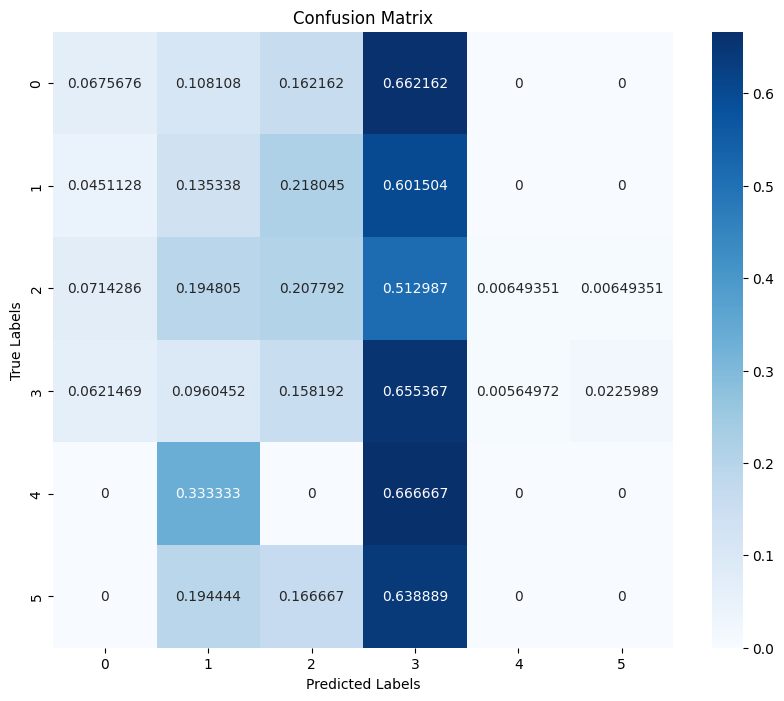

Epoch 11, Validation Loss: 3.4827, Accuracy: 0.2964, F1 Score: 0.2515
Val F1 Score Per Class  [0.09345794 0.1682243  0.24521073 0.44106464 0.         0.        ]


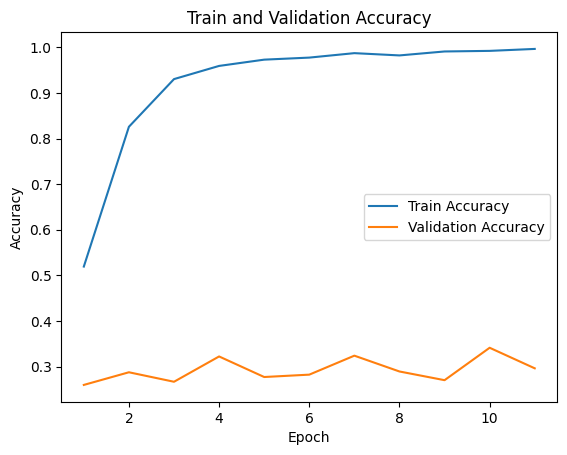

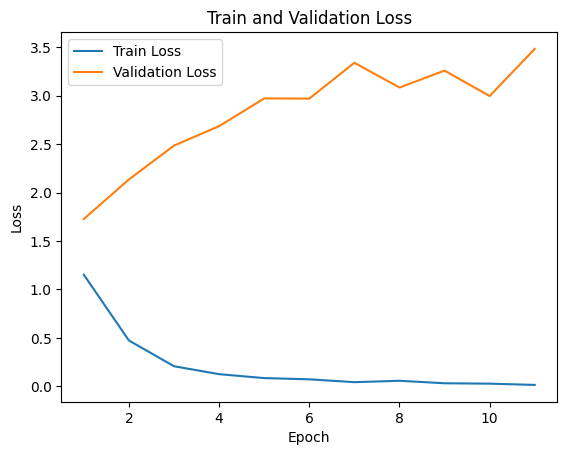

Epoch 12, Train Loss: 0.0183, Accuracy: 0.9942, F1 Score: 0.9942
Train F1 Score Per Class  [0.99637681 0.98858859 0.99214502 0.98910162 1.         0.99909937]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.42it/s, loss=3.07]

[tensor([-2.7347, -1.3265, -1.3782,  4.6701, -5.1839, -3.4510], device='cuda:0'), tensor([ 1.7671, -2.3761, -0.7599,  2.0489, -2.7781, -2.7852], device='cuda:0'), tensor([-3.8370,  0.6278, -0.7742,  1.7664, -3.9923, -4.2751], device='cuda:0'), tensor([-2.9012, -1.6650,  0.3264,  0.3773, -4.9425, -2.7383], device='cuda:0'), tensor([-2.3450, -2.2462,  3.1558,  2.9206, -4.2718, -4.0695], device='cuda:0'), tensor([-1.5227,  1.9168,  0.2198, -1.0333, -5.1543, -4.7053], device='cuda:0'), tensor([-4.1784,  1.2925, -0.8266,  2.0827, -3.0278, -1.6861], device='cuda:0'), tensor([-2.3097, -1.3015, -0.2138,  5.4200, -4.0302, -4.7681], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=4.65]

[tensor([-3.4541, -0.1313, -1.5074,  5.4493, -3.3318, -2.8653], device='cuda:0'), tensor([-2.9228, -1.5496, -0.4255,  2.6794, -4.6826, -4.1137], device='cuda:0'), tensor([-0.2868, -2.9207, -1.3446,  4.0194, -2.9232, -2.5027], device='cuda:0'), tensor([-3.2035, -0.9685, -2.4294,  1.1825, -1.5516, -2.1726], device='cuda:0'), tensor([-1.9561,  0.9202, -2.1446,  5.9494, -4.2146, -3.3160], device='cuda:0'), tensor([-3.1217,  2.6667, -2.1979,  2.4323, -3.4678, -3.7441], device='cuda:0'), tensor([-3.2895,  0.0712, -0.5999,  4.6234, -4.6988, -2.3665], device='cuda:0'), tensor([-0.5547, -2.1504, -2.8420,  4.9461, -3.8722, -1.8712], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.39it/s, loss=2.8]

[tensor([-2.8878,  4.2976, -2.4046,  1.7271, -3.3240, -4.2153], device='cuda:0'), tensor([-3.1886, -0.5356,  0.2369,  0.9797, -2.8461, -3.9881], device='cuda:0'), tensor([-2.6131,  4.3371, -0.4688, -2.2776, -3.0377, -3.4408], device='cuda:0'), tensor([-2.7967,  3.6288,  0.0894, -0.6903, -4.5928, -5.0340], device='cuda:0'), tensor([ 1.4734,  1.4159, -2.4106,  0.1730, -4.5547, -3.2353], device='cuda:0'), tensor([-2.6649,  2.7368,  2.8408, -2.2415, -4.1869, -4.0206], device='cuda:0'), tensor([-3.3710,  0.2794, -1.7265,  1.3149, -4.5360, -3.4875], device='cuda:0'), tensor([-3.2696,  1.5052, -0.5618,  2.1672, -3.6878, -4.4673], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.37it/s, loss=2.13]

[tensor([ 1.5963,  1.2933, -2.4252,  0.5665, -3.1713, -3.9421], device='cuda:0'), tensor([-2.7319, -0.8578, -1.4827,  6.4518, -2.7109, -3.5398], device='cuda:0'), tensor([-2.8234, -0.0921, -0.2803,  2.6400, -4.0674, -4.1949], device='cuda:0'), tensor([-2.6331,  3.9087, -2.1875,  0.2779, -3.4990, -2.1147], device='cuda:0'), tensor([-3.2242,  0.4512,  6.0523, -1.9870, -4.3118, -2.7218], device='cuda:0'), tensor([-2.6060, -1.0919, -1.1169,  1.2399, -4.4383, -4.4602], device='cuda:0'), tensor([-2.3074, -3.1385,  0.9259,  3.4285, -3.8433, -2.1293], device='cuda:0'), tensor([-0.3945, -1.3604,  2.4348,  0.6273, -4.3744, -3.6724], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=4.38]

[tensor([-2.9427,  4.4420, -1.2864, -0.1812, -4.3530, -3.4749], device='cuda:0'), tensor([-2.8265, -2.6268,  0.2151,  0.4789, -3.9011, -1.4861], device='cuda:0'), tensor([-3.2073, -1.4771,  0.1236,  0.3814, -4.4042, -2.8692], device='cuda:0'), tensor([-2.4097, -0.9914,  6.3324, -1.9967, -3.8570, -3.5541], device='cuda:0'), tensor([-3.7678, -1.6347,  2.5000,  1.6855, -4.1035, -1.9223], device='cuda:0'), tensor([-2.8500, -0.3476, -0.2149,  5.2071, -3.9908, -3.2148], device='cuda:0'), tensor([-3.4056, -1.1608, -0.0557,  2.2644, -4.8622, -3.5918], device='cuda:0'), tensor([-3.9206,  2.6941, -1.0453,  3.5299, -4.4707, -4.7454], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.37it/s, loss=4.6]

[tensor([-2.9900,  1.1137, -2.1601,  3.9535, -4.0424, -4.0559], device='cuda:0'), tensor([-1.8854, -0.3822, -2.3913,  2.0602, -3.5563, -2.1953], device='cuda:0'), tensor([-3.8209,  3.6132, -0.3578,  0.7205, -3.5361, -3.5120], device='cuda:0'), tensor([-2.2793,  0.0766, -1.3355,  3.6046, -5.0303, -4.5337], device='cuda:0'), tensor([-2.9446,  0.7824, -1.2132,  3.0856, -4.1978, -2.6977], device='cuda:0'), tensor([-3.7376, -0.0402,  4.1121, -0.5906, -4.2378, -4.3478], device='cuda:0'), tensor([-3.3349,  6.2380, -0.6242, -1.4451, -3.3372, -3.5607], device='cuda:0'), tensor([-3.1249,  4.1182, -1.5710,  0.1454, -3.1998, -3.2267], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.38it/s, loss=2.19]

[tensor([-3.7803, -1.2090,  0.2166,  3.1641, -4.7237, -4.2436], device='cuda:0'), tensor([-3.1142, -1.4000,  6.2470, -0.5935, -4.0875, -3.5554], device='cuda:0'), tensor([-1.0817, -2.1292, -0.8573,  4.5248, -3.5774, -1.6225], device='cuda:0'), tensor([-1.3529, -0.6042, -0.8216,  2.9524, -4.6910, -2.7239], device='cuda:0'), tensor([-3.5922,  0.8287,  0.8537,  3.5039, -4.4227, -4.1535], device='cuda:0'), tensor([-3.1651,  0.5756, -1.8876,  4.1529, -3.8603, -2.1873], device='cuda:0'), tensor([-3.1231,  0.0190, -1.7523,  3.5393, -3.8207, -3.5846], device='cuda:0'), tensor([-1.8108, -1.3157,  7.0250, -1.9587, -2.5087, -2.1608], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.37it/s, loss=3.71]

[tensor([-2.6787,  4.7942, -1.3905,  0.3105, -2.2572, -3.5271], device='cuda:0'), tensor([-2.4743, -0.5676, -2.0031,  0.8387, -3.1247, -2.5954], device='cuda:0'), tensor([ 5.4797, -0.8841, -2.4383, -0.9248, -3.2007, -2.1478], device='cuda:0'), tensor([-3.0834,  1.1224, -0.2517,  4.3186, -4.7769, -4.5626], device='cuda:0'), tensor([-2.7586,  4.1646, -1.4859,  0.5538, -3.9377, -2.9251], device='cuda:0'), tensor([-3.0991, -2.3223,  2.4300,  1.6686, -4.0387, -3.2775], device='cuda:0'), tensor([-1.5709, -2.3364, -0.2945,  4.9273, -4.4634, -3.2128], device='cuda:0'), tensor([-3.6486, -0.4089, -1.7123,  4.7782, -3.8522, -3.3286], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:27,  2.37it/s, loss=3.25]

[tensor([-2.9523,  5.8716, -1.3160,  0.0955, -3.9948, -3.5717], device='cuda:0'), tensor([-2.8822, -1.0486, -0.7956,  5.5367, -4.3153, -2.9506], device='cuda:0'), tensor([-0.5693, -2.5477, -0.8312,  5.6730, -4.7365, -3.2642], device='cuda:0'), tensor([-3.2501, -0.1095, -1.6141,  6.2225, -4.1819, -3.4320], device='cuda:0'), tensor([-2.6913, -1.3561, -0.6786,  5.2042, -4.3127, -3.2151], device='cuda:0'), tensor([-2.9686,  2.1573, -2.2544,  1.1475, -4.2550, -4.3449], device='cuda:0'), tensor([-4.3437,  1.3893,  0.6655,  0.5970, -4.3820, -4.1901], device='cuda:0'), tensor([-3.7676,  0.5361, -0.8599,  4.9946, -4.5589, -3.6221], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.37it/s, loss=4.7]

[tensor([-2.9721,  0.1952, -1.9429,  2.9057, -4.4338, -4.9613], device='cuda:0'), tensor([-2.9861, -0.9422, -1.5735,  2.8761, -3.5522, -3.1011], device='cuda:0'), tensor([-2.9750,  2.5895,  0.0241, -0.4871, -4.1563, -4.8079], device='cuda:0'), tensor([-3.1748,  3.7218, -0.1960,  0.5020, -4.5239, -4.6307], device='cuda:0'), tensor([-2.5064,  5.4161,  0.5789, -1.7745, -3.6378, -4.3246], device='cuda:0'), tensor([-3.6740,  0.7045, -0.8534,  1.8251, -4.4367, -3.9178], device='cuda:0'), tensor([ 0.5118,  1.2372, -1.3320,  2.2716, -4.5823, -4.6638], device='cuda:0'), tensor([-2.7981, -0.0722, -2.4598,  3.4705, -3.8693, -3.7345], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.36it/s, loss=3.11]

[tensor([-2.1071,  4.5776, -1.3904,  0.0585, -3.5401, -4.3375], device='cuda:0'), tensor([-2.9711,  0.0185, -1.3230,  2.8184, -3.9822, -2.7016], device='cuda:0'), tensor([-4.1952,  2.4179, -1.1709, -0.0921, -4.0456, -3.9708], device='cuda:0'), tensor([-2.8667, -1.4996,  0.9147,  4.6745, -4.2235, -3.2629], device='cuda:0'), tensor([-2.9802, -1.0779,  1.3037,  4.2135, -4.5766, -3.6387], device='cuda:0'), tensor([-3.2201, -1.0789, -1.5532,  6.6221, -3.5634, -2.7061], device='cuda:0'), tensor([-2.5624,  3.8215, -1.0863,  0.2553, -4.7794, -4.9338], device='cuda:0'), tensor([-0.0963,  0.4503, -0.4656,  0.9895, -4.9728, -3.3774], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.35it/s, loss=3.59]

[tensor([-2.0477, -1.0373, -1.0188, -0.4451, -5.4787, -4.9828], device='cuda:0'), tensor([-3.2402,  1.3566, -0.6816,  0.5558, -5.1256, -4.4614], device='cuda:0'), tensor([-2.3994, -1.6616, -1.7375,  6.5087, -3.4277, -2.8296], device='cuda:0'), tensor([-1.3354, -1.3513, -1.7288,  3.2254, -5.0639, -1.9587], device='cuda:0'), tensor([-1.7433,  3.2005, -1.9377,  0.1349, -4.6752, -4.6384], device='cuda:0'), tensor([-2.8129,  3.0436, -2.3330,  0.1112, -3.8364, -4.1523], device='cuda:0'), tensor([-3.2778, -1.1522,  1.5822, -0.8492, -3.9224, -2.4484], device='cuda:0'), tensor([-2.4663, -1.7273, -0.3783,  2.5104, -4.3359, -2.6901], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.36it/s, loss=2.37]

[tensor([-2.3992, -1.1528, -1.9161,  4.4525, -2.7953, -1.5886], device='cuda:0'), tensor([-3.0140,  1.1731, -1.3635,  4.2480, -4.6602, -4.4150], device='cuda:0'), tensor([-2.6413,  4.9724, -3.2497,  1.1935, -3.2633, -3.0741], device='cuda:0'), tensor([-3.2261, -0.8067,  5.2188, -0.5266, -3.9652, -3.6095], device='cuda:0'), tensor([-3.4441, -0.0961, -0.6524,  4.5069, -4.6329, -3.7932], device='cuda:0'), tensor([ 0.6098, -1.7625, -2.7002,  1.9562, -4.6913, -3.9215], device='cuda:0'), tensor([-3.9615,  0.7814, -1.4536,  2.1467, -4.0909, -3.3199], device='cuda:0'), tensor([-1.8379,  4.1582, -0.8620, -0.4829, -4.4661, -4.2553], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.37it/s, loss=2.09]

[tensor([-2.0480, -0.1768,  6.3823, -2.5852, -2.7314, -2.6991], device='cuda:0'), tensor([-2.0624,  0.1656, -1.8194,  0.5353, -4.6036, -4.5304], device='cuda:0'), tensor([-1.8692, -0.5628, -1.3346,  4.2328, -4.9749, -4.4261], device='cuda:0'), tensor([-2.7583, -1.2665, -0.8219,  1.2855, -4.8793, -4.5685], device='cuda:0'), tensor([-2.1547,  4.3346, -1.7848,  0.0413, -3.9925, -4.3794], device='cuda:0'), tensor([-2.9301,  2.3007, -0.3908,  2.9039, -4.0908, -3.7114], device='cuda:0'), tensor([-2.9939,  3.0040, -1.9159,  2.4155, -4.5280, -3.9452], device='cuda:0'), tensor([-2.4769,  0.0713, -0.9983,  0.1402, -4.3764, -3.9351], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.37it/s, loss=2.12]

[tensor([-3.2669, -0.9839, -0.7891, -0.2847, -4.6784, -4.7263], device='cuda:0'), tensor([-3.6525, -1.6064,  2.6382, -0.2673, -4.1623, -2.5652], device='cuda:0'), tensor([-2.5062, -2.6949, -1.0465,  4.8738, -2.9420, -2.7794], device='cuda:0'), tensor([-1.9368,  1.6108, -1.4551, -2.0191, -4.0492, -4.4356], device='cuda:0'), tensor([-2.8611, -1.0103,  5.5995, -0.9688, -3.9882, -2.5896], device='cuda:0'), tensor([-1.7984, -1.7275, -0.8488,  5.3289, -4.9534, -3.7640], device='cuda:0'), tensor([-2.7690,  0.0956, -2.8888,  4.2516, -2.9729, -2.6275], device='cuda:0'), tensor([-3.2676, -0.5337, -1.1284,  5.6787, -4.2793, -3.4042], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=3.1]

[tensor([-0.1090,  0.2020, -0.9663,  3.4274, -4.0972, -4.3958], device='cuda:0'), tensor([-4.4674, -0.5950, -0.7801,  2.9495, -4.6952, -3.4596], device='cuda:0'), tensor([-3.5307, -1.8286, -0.0483, -0.9302, -4.1752,  3.6573], device='cuda:0'), tensor([-3.3830, -0.7557,  0.1955,  4.8268, -4.7804, -3.4662], device='cuda:0'), tensor([ 1.3149,  0.7429, -0.0427,  0.6826, -5.0379, -4.3763], device='cuda:0'), tensor([-1.3740,  0.4266, -1.9920,  2.7004, -4.2562, -3.7125], device='cuda:0'), tensor([-3.1803,  0.2509, -1.1189, -0.7043, -3.5508, -3.5518], device='cuda:0'), tensor([ 2.2591, -0.8616, -3.1129, -0.4473, -3.0666, -0.3013], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=4.11]

[tensor([-2.5848,  5.8161, -1.4000, -0.3792, -2.9097, -3.5551], device='cuda:0'), tensor([-2.7206,  0.2570, -1.0797,  5.6428, -4.5452, -4.3313], device='cuda:0'), tensor([-4.0280,  0.9881, -0.1556,  1.5733, -4.4654, -0.4943], device='cuda:0'), tensor([-3.5468,  2.5496,  1.0129,  0.8570, -4.0124, -3.9735], device='cuda:0'), tensor([ 4.8682, -1.1824, -1.2025,  0.4086, -3.5904, -4.1367], device='cuda:0'), tensor([-2.2795,  5.8815, -1.3372,  0.0466, -3.8862, -4.6905], device='cuda:0'), tensor([-2.6177, -1.6614,  5.9221,  0.1693, -4.1997, -2.9802], device='cuda:0'), tensor([-2.5757, -1.4433, -0.2321,  0.9914, -4.2051, -3.2830], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.37it/s, loss=2.08]

[tensor([-2.2392,  2.1072, -2.3141,  1.9429, -3.2083, -3.6619], device='cuda:0'), tensor([-2.7156, -0.3012, -0.1062,  3.4070, -3.2343, -3.9583], device='cuda:0'), tensor([-3.3377,  1.6765, -0.7941,  2.1553, -3.8485, -3.9863], device='cuda:0'), tensor([-2.9910, -1.8938, -1.7342,  6.3533, -2.6978, -2.8261], device='cuda:0'), tensor([-3.1709,  3.3304, -2.1218,  0.9185, -3.2943, -2.3866], device='cuda:0'), tensor([ 0.5015,  1.9072, -1.9118, -0.8797, -5.6173, -4.0422], device='cuda:0'), tensor([-2.7574, -0.5485, -2.0369,  4.0929, -4.5029, -2.9003], device='cuda:0'), tensor([-2.4127,  0.5520,  0.8647, -1.1411, -4.8801, -3.8768], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:22,  2.38it/s, loss=3.09]

[tensor([-3.4481, -0.7065, -0.8560,  3.6757, -4.0500, -3.2956], device='cuda:0'), tensor([-2.4375,  0.7942,  0.4281,  0.3656, -3.9498, -4.0976], device='cuda:0'), tensor([-0.3541, -0.6169,  2.5969, -1.6286, -3.3310, -2.4689], device='cuda:0'), tensor([-3.4689,  2.1361, -0.7431,  3.0631, -2.6171, -4.1971], device='cuda:0'), tensor([-3.1582,  5.8308, -0.7981, -0.3359, -3.0261, -3.0773], device='cuda:0'), tensor([-2.2530,  1.5246, -2.2642,  3.7337, -4.0061, -3.6896], device='cuda:0'), tensor([-2.4304, -0.8070, -1.2366,  5.9453, -4.4733, -3.6510], device='cuda:0'), tensor([-2.0709,  0.6630, -1.5223,  1.4003, -4.6439, -4.9611], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.38it/s, loss=2.26]

[tensor([-3.9457,  4.1228, -0.8068, -0.1000, -3.4754, -2.8918], device='cuda:0'), tensor([-3.0376, -1.3117, -1.4235,  1.9591, -4.2854, -3.4648], device='cuda:0'), tensor([-3.4961,  0.4920, -0.2123,  1.6746, -4.4074, -3.9322], device='cuda:0'), tensor([-3.4926,  2.0468,  4.3428, -1.2568, -4.5359, -3.3525], device='cuda:0'), tensor([-4.6111,  2.7100, -1.4310,  1.6551, -4.0943, -5.2917], device='cuda:0'), tensor([-3.2117,  1.1341,  2.0210, -0.1391, -4.3659, -3.2680], device='cuda:0'), tensor([-3.1780,  1.6023, -1.5251,  2.1214, -3.3361, -3.1562], device='cuda:0'), tensor([-2.0074,  6.0277, -1.5889, -0.3266, -2.8553, -3.8449], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=5.72]

[tensor([-2.0348, -1.1188,  6.2656, -2.1063, -3.1813, -2.2395], device='cuda:0'), tensor([-1.7418,  5.5345, -1.6483,  0.1309, -4.3649, -4.1172], device='cuda:0'), tensor([-3.3656, -0.7088, -1.5551,  5.6965, -3.8053, -4.9995], device='cuda:0'), tensor([-2.9764,  1.5575, -2.3751,  1.8563, -4.1341, -3.6356], device='cuda:0'), tensor([-2.8339,  5.0086, -1.5388, -1.3382, -3.2558, -2.2857], device='cuda:0'), tensor([-2.9697, -2.1693, -1.8848,  2.2208, -4.1658, -3.3634], device='cuda:0'), tensor([-0.2088,  2.5481,  0.0178, -1.8862, -4.1215, -3.5240], device='cuda:0'), tensor([-1.6178, -1.1711, -1.5713,  5.5170, -3.2790, -4.5552], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.37it/s, loss=2.44]

[tensor([-0.6032, -1.9056,  1.6322,  0.5212, -4.1918, -3.9109], device='cuda:0'), tensor([-2.5021, -1.8970,  1.8149,  1.4013, -4.7858, -4.0085], device='cuda:0'), tensor([-2.6285,  6.1376,  0.4877, -0.8266, -4.6742, -4.2639], device='cuda:0'), tensor([-2.4069,  0.4800, -1.4581,  3.9890, -3.3892, -3.6389], device='cuda:0'), tensor([-2.8305, -0.3422, -1.6587,  1.6157, -4.4915, -4.4960], device='cuda:0'), tensor([-0.4774,  0.2691, -0.4588,  1.0613, -5.0147, -4.3835], device='cuda:0'), tensor([-2.8405,  0.9290, -0.6833,  4.2857, -4.9422, -3.5173], device='cuda:0'), tensor([-2.3455,  0.0488,  4.8781, -1.9482, -5.0791, -4.8515], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.38it/s, loss=3.76]

[tensor([-2.7713, -0.3908, -2.7370,  3.5564, -3.0260, -3.5304], device='cuda:0'), tensor([-1.7867,  0.4632, -0.5394, -1.9734, -3.9289, -4.4958], device='cuda:0'), tensor([-2.8441,  0.1018, -1.3748,  5.0387, -4.6424, -3.9662], device='cuda:0'), tensor([-2.6074,  5.4570, -1.1698, -0.1531, -3.0135, -3.3330], device='cuda:0'), tensor([-3.8952,  3.0031, -1.5846,  1.2458, -3.9507, -4.0309], device='cuda:0'), tensor([-3.5173,  5.3293, -0.6612, -0.0968, -3.7006, -3.8697], device='cuda:0'), tensor([-2.7440, -2.4214, -0.2727,  3.3422, -4.0431, -2.1329], device='cuda:0'), tensor([-3.5624,  5.9350, -1.2868, -0.6901, -4.1329, -2.3063], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.37it/s, loss=2.84]

[tensor([-2.8691, -1.8225,  4.2631,  2.3263, -4.3363, -4.8573], device='cuda:0'), tensor([-3.0557,  0.6222, -1.2972,  3.8623, -3.4954, -3.7600], device='cuda:0'), tensor([-3.8743,  4.3671, -2.1933,  2.1771, -5.0032, -3.6696], device='cuda:0'), tensor([-1.6576, -3.0500, -1.8331,  2.5584, -5.2422, -2.3206], device='cuda:0'), tensor([ 0.3810, -2.2754, -2.2702,  1.9107, -3.6031, -2.8813], device='cuda:0'), tensor([-3.6791, -0.0954, -0.3902,  1.3433, -4.6568, -4.0755], device='cuda:0'), tensor([-1.6837,  0.7964, -1.6719, -0.7487, -3.9489, -2.3491], device='cuda:0'), tensor([-2.7284, -0.9459, -1.8671,  4.4472, -4.3785, -4.5782], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=1.98]

[tensor([-3.6095, -0.7199,  4.5604, -1.0413, -4.4399, -3.6445], device='cuda:0'), tensor([-2.3967,  3.1141, -0.2090, -0.0765, -3.4555, -4.6334], device='cuda:0'), tensor([-4.0344,  0.1166,  0.5930,  1.8398, -4.2469, -3.6696], device='cuda:0'), tensor([-3.3844,  1.5526, -0.9538,  4.3941, -4.0247, -3.6230], device='cuda:0'), tensor([-1.7920,  3.3725, -2.1981,  0.0915, -3.8324, -3.8058], device='cuda:0'), tensor([-3.6169,  0.8997, -0.7456,  1.0462, -2.9909, -3.7260], device='cuda:0'), tensor([-2.5642,  2.5462, -2.9677,  2.9829, -3.6354, -3.7854], device='cuda:0'), tensor([ 1.4836, -1.8021, -1.8037,  1.2152, -3.5402, -3.0984], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.46]

[tensor([-3.0797, -0.1041, -1.0010,  3.9193, -4.3381, -3.6717], device='cuda:0'), tensor([-4.2245,  0.6170, -1.2419,  5.3030, -4.5980, -3.1027], device='cuda:0'), tensor([-3.9382, -0.2108,  4.1630, -0.3069, -3.4584, -3.8934], device='cuda:0'), tensor([ 0.7756, -2.3794, -1.0074,  1.4904, -4.6967, -2.7687], device='cuda:0'), tensor([-2.8567,  2.5456, -1.2866,  3.8449, -5.1552, -3.8229], device='cuda:0'), tensor([-2.2230, -0.8371,  2.1239,  2.0885, -4.5397, -3.5493], device='cuda:0'), tensor([-2.0158,  3.9804, -1.7252,  0.4362, -2.6925, -4.5510], device='cuda:0'), tensor([-3.2676,  2.9761, -1.0605, -0.7724, -4.6567, -3.0713], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=3.83]

[tensor([-3.5562, -1.2143, -0.0598,  5.4868, -4.2099, -3.4476], device='cuda:0'), tensor([-3.3859, -0.2682, -0.9460,  3.1280, -3.8998, -4.0614], device='cuda:0'), tensor([-1.1641,  0.6880, -2.2690,  1.8480, -3.5438, -3.6416], device='cuda:0'), tensor([-3.2691, -1.3760,  4.2563,  0.1681, -4.5951, -2.9352], device='cuda:0'), tensor([-2.6157,  3.6855, -1.0747,  1.0890, -4.0291, -3.6229], device='cuda:0'), tensor([-3.4819, -0.6431, -0.7452,  3.5223, -4.7523, -4.0758], device='cuda:0'), tensor([-3.2592, -1.8885,  0.6785,  4.9486, -5.1185, -3.5149], device='cuda:0'), tensor([-2.7796,  2.7906, -2.3780,  3.2539, -4.7603, -3.4429], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.37it/s, loss=3.78]

[tensor([-0.6394, -1.3860, -1.3259,  5.9919, -4.0241, -3.7579], device='cuda:0'), tensor([-3.4270,  0.0628, -1.4946,  4.1468, -3.7445, -3.3676], device='cuda:0'), tensor([-1.7949,  4.2292,  0.5461, -1.3823, -4.2181, -3.5452], device='cuda:0'), tensor([-3.9811,  0.5863,  3.7045,  0.1139, -4.1582, -4.2295], device='cuda:0'), tensor([-3.0082, -0.3332, -1.7319,  6.1934, -3.9636, -3.2723], device='cuda:0'), tensor([-3.1831,  4.4987,  1.1243,  0.8452, -4.4646, -4.8592], device='cuda:0'), tensor([-3.4018,  0.3912,  0.6603,  2.0168, -4.7537, -4.1926], device='cuda:0'), tensor([-3.4688,  0.5996,  0.0144,  1.4448, -4.8875, -3.9590], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=3.98]

[tensor([-3.8841,  0.0265, -1.2867,  5.6114, -3.5108, -2.6320], device='cuda:0'), tensor([-3.4776,  0.3122, -1.6305,  0.9510, -3.7799, -2.6633], device='cuda:0'), tensor([-3.7956, -1.8453, -0.0467,  1.7339, -4.0903, -2.8612], device='cuda:0'), tensor([-3.5023,  3.5637, -0.9302,  0.8549, -3.2410, -3.7778], device='cuda:0'), tensor([-0.3186,  3.9636, -1.0130, -1.4516, -4.9650, -3.7970], device='cuda:0'), tensor([-4.1251, -0.8054,  1.6052,  0.9179, -4.4413, -2.7593], device='cuda:0'), tensor([-4.0656,  0.4236, -1.4819,  3.1333, -2.9991, -3.5139], device='cuda:0'), tensor([-3.1802, -0.1752, -1.2045,  5.5444, -4.6623, -3.8364], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.36it/s, loss=5.23]

[tensor([-3.3416,  5.3235, -1.0996,  0.3899, -3.8383, -3.7387], device='cuda:0'), tensor([-3.8237, -0.4033, -1.0995,  4.6625, -3.5332, -3.9804], device='cuda:0'), tensor([-1.7779,  3.8219, -2.4847, -0.5692, -3.6764, -3.0527], device='cuda:0'), tensor([-2.8185, -1.4647, -1.2052,  6.5819, -4.0490, -3.0756], device='cuda:0'), tensor([-2.7134,  1.7665, -2.0597, -0.4231, -5.1105, -2.7659], device='cuda:0'), tensor([-3.0554, -1.1692,  2.9100, -0.0948, -3.7432, -3.8011], device='cuda:0'), tensor([-2.8441, -2.3960,  3.0027,  1.3039, -5.2897, -5.0644], device='cuda:0'), tensor([-0.7331, -1.3453, -0.4204, -1.8756, -2.9622,  7.3537], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=3.54]

[tensor([-3.0866,  1.8785, -2.8809,  3.2350, -3.3389, -3.0907], device='cuda:0'), tensor([-2.7491, -1.0715, -2.1059,  6.1204, -4.1849, -2.7505], device='cuda:0'), tensor([-4.1812,  3.6073, -1.1692,  0.1012, -4.5152, -1.1202], device='cuda:0'), tensor([-1.6197,  5.1523, -1.9601,  0.0334, -4.1469, -4.0627], device='cuda:0'), tensor([-2.9628,  5.5899, -0.6828, -0.3413, -3.2695, -4.0111], device='cuda:0'), tensor([ 0.9683, -0.6005, -1.6500, -1.1559, -2.7311, -1.3404], device='cuda:0'), tensor([-2.3095, -2.4515,  0.7915,  3.7402, -4.0470, -4.3074], device='cuda:0'), tensor([-3.0328, -0.5539,  0.8722,  4.7005, -4.5743, -4.3633], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.36it/s, loss=4.45]

[tensor([-2.4352,  0.0282, -2.7642,  1.8942, -3.3735, -2.9866], device='cuda:0'), tensor([-3.2353,  0.5372, -1.9817,  5.7886, -3.9942, -3.4788], device='cuda:0'), tensor([-1.6782,  6.2993, -1.5172, -0.6773, -2.2283, -3.9537], device='cuda:0'), tensor([-3.0748,  3.0446, -2.3366, -0.5593,  1.4278, -1.5405], device='cuda:0'), tensor([-0.4415, -0.4873,  0.7792, -1.3187, -3.0999, -3.9189], device='cuda:0'), tensor([-3.2105, -1.2648, -0.5602,  4.0328, -4.6563, -2.5737], device='cuda:0'), tensor([-1.8138,  0.1033, -1.8794,  1.6505, -4.2882, -4.5621], device='cuda:0'), tensor([ 0.4257, -0.6445, -1.8526,  1.8664, -5.3872, -4.4505], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.36it/s, loss=4.25]

[tensor([-4.2964, -1.0341, -1.1538,  2.8649, -3.4949, -3.4566], device='cuda:0'), tensor([-3.2032,  2.9051, -1.6879,  3.3442, -4.1577, -3.4262], device='cuda:0'), tensor([-2.4306, -0.6621,  1.5545, -0.2445, -5.3178, -2.7980], device='cuda:0'), tensor([-2.3295,  3.4360,  2.1060, -2.5761, -4.1231, -4.1487], device='cuda:0'), tensor([-3.2758, -1.3050,  5.7435, -1.4941, -3.9850, -3.3673], device='cuda:0'), tensor([-2.7725, -1.9854, -1.2515,  5.6696, -4.0352, -2.8992], device='cuda:0'), tensor([-2.6313,  2.8024,  0.2236, -0.8341, -4.9534, -4.6850], device='cuda:0'), tensor([-3.9276,  0.8092, -1.9619,  3.6889, -3.5018, -3.2787], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=2.82]

[tensor([ 4.1927,  1.6792, -2.9627, -0.1650, -3.4073, -3.8308], device='cuda:0'), tensor([-2.9330,  1.6321, -0.6181,  0.8017, -4.8577, -4.7130], device='cuda:0'), tensor([-3.1391,  3.1085, -1.7590,  0.9835, -0.9369, -3.5300], device='cuda:0'), tensor([-3.3443, -2.1930, -0.7112,  5.5268, -4.0532, -2.5230], device='cuda:0'), tensor([-3.6441,  1.2950, -1.6960,  4.1495, -3.7158, -3.0127], device='cuda:0'), tensor([-3.6805,  0.2640,  0.1249,  2.2116, -4.4698, -3.5781], device='cuda:0'), tensor([-2.5630, -1.1418, -1.6329,  4.8646, -3.6164, -3.6981], device='cuda:0'), tensor([-3.3250,  0.1477,  3.3926, -1.1058, -4.8870, -4.6726], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.35it/s, loss=2.89]

[tensor([-3.7190,  1.1555, -0.1250, -0.8135, -5.3536, -3.5033], device='cuda:0'), tensor([-2.4327,  5.3342, -2.0954,  0.5031, -3.4495, -3.5493], device='cuda:0'), tensor([-3.1853, -1.8131,  1.3419,  0.0984, -4.3861, -3.5690], device='cuda:0'), tensor([-2.0081, -0.9817,  6.4020, -1.0003, -3.6931, -3.4470], device='cuda:0'), tensor([-3.4802,  3.7205, -0.4430,  0.8592, -4.5675, -3.3997], device='cuda:0'), tensor([-1.9218, -0.7010, -1.7198,  4.0887, -4.0265, -2.2003], device='cuda:0'), tensor([-3.4107, -0.9050,  0.9910,  1.8005, -4.3974, -3.8634], device='cuda:0'), tensor([-2.8843,  0.1483, -0.1539,  3.9799, -3.9480, -3.9214], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.36it/s, loss=2.83]

[tensor([-2.9023,  1.9098,  0.1634, -1.3831, -3.5235, -3.6597], device='cuda:0'), tensor([-2.5516, -1.0933,  5.0984, -1.5583, -3.5133, -3.8702], device='cuda:0'), tensor([-2.1602,  0.1654, -1.3545,  1.6841, -3.9077, -1.8319], device='cuda:0'), tensor([-2.8622,  6.6232, -2.0988,  0.0419, -3.0874, -3.4628], device='cuda:0'), tensor([-3.5243, -1.2549, -0.8513,  2.4797, -4.7179, -3.9792], device='cuda:0'), tensor([-2.8851, -1.5335, -1.6955,  5.4122, -4.1465, -3.7391], device='cuda:0'), tensor([-2.4224, -1.4403, -1.1260,  5.4037, -4.3132, -4.2855], device='cuda:0'), tensor([-2.7705,  0.5063, -1.7429,  3.2296, -3.8586, -4.3615], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.34it/s, loss=4.2]

[tensor([-1.6437, -1.2710, -2.0859,  2.5504, -3.1175, -3.4325], device='cuda:0'), tensor([-3.9364,  0.9877, -0.0454,  4.0227, -4.7370, -4.2728], device='cuda:0'), tensor([-2.5830, -0.0438, -2.1062,  3.1342, -4.0472, -3.8270], device='cuda:0'), tensor([-3.4632,  5.4399, -2.1242,  0.9034, -3.9861, -2.4537], device='cuda:0'), tensor([-2.5379,  3.7663,  0.4906, -1.3714, -3.9171, -3.1270], device='cuda:0'), tensor([-3.1421,  5.3837, -0.4379, -0.3023, -3.3985, -3.9243], device='cuda:0'), tensor([-1.7282,  1.7858, -1.0865,  1.6304, -3.8519, -4.5030], device='cuda:0'), tensor([-3.3792,  1.4855, -0.6660,  3.5943, -4.1022, -4.2856], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.35it/s, loss=2.88]

[tensor([-1.5304, -0.9853,  1.4265, -0.2193, -4.1398, -3.1480], device='cuda:0'), tensor([-2.6473,  0.4381, -0.4206,  0.5257, -5.0884, -1.9688], device='cuda:0'), tensor([-2.2227,  0.8076, -1.9356,  4.1502, -4.7298, -3.8528], device='cuda:0'), tensor([-3.6620,  1.5598, -2.4823,  1.0641, -2.9442, -2.9757], device='cuda:0'), tensor([-3.6557,  3.3534,  0.8419, -1.1630, -4.3342, -5.1150], device='cuda:0'), tensor([-1.6388,  5.4186, -2.4667,  0.3191, -2.9698, -3.3090], device='cuda:0'), tensor([-2.5607,  2.5600, -1.1052, -2.5612, -3.3442, -3.9558], device='cuda:0'), tensor([-3.5525, -1.1361,  3.1527,  2.3201, -4.4254, -4.4665], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.35it/s, loss=2.96]

[tensor([-1.7573,  4.1618, -0.5650,  0.2136, -4.8272, -5.2720], device='cuda:0'), tensor([-3.3326,  0.9312, -0.6640,  3.5815, -3.5022, -4.5601], device='cuda:0'), tensor([-3.1743, -1.3877, -1.1289,  2.0735, -4.0074, -2.4561], device='cuda:0'), tensor([-2.9139, -1.9594, -0.7828,  3.7673, -4.8220, -3.8697], device='cuda:0'), tensor([-3.1168, -1.2939, -1.8207,  2.5596, -4.2238, -4.0291], device='cuda:0'), tensor([-3.8942,  0.2314,  4.5986, -0.6513, -4.5752, -3.7341], device='cuda:0'), tensor([-1.7612,  0.9481, -0.4891,  0.7201, -4.4191, -3.9416], device='cuda:0'), tensor([-4.4521,  2.0467, -0.8617,  3.3340, -5.0519, -2.2347], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.37it/s, loss=3.25]

[tensor([ 1.5228, -1.0303, -0.6532,  2.7794, -4.5374, -3.1787], device='cuda:0'), tensor([-2.5693, -1.0324,  1.3101,  0.3125, -3.9947, -3.2314], device='cuda:0'), tensor([-3.2811, -0.6047, -0.6694,  3.9116, -4.6697, -2.7624], device='cuda:0'), tensor([ 1.0078, -0.3471, -3.0496,  3.3888, -3.8258, -3.9021], device='cuda:0'), tensor([-3.8451,  4.7849, -1.4409, -0.0649, -3.3285, -2.6680], device='cuda:0'), tensor([-0.8359, -0.2923, -2.4620,  1.2788, -3.2613, -3.6909], device='cuda:0'), tensor([-4.0837,  0.5098,  0.2497,  3.4455, -3.9319, -3.7594], device='cuda:0'), tensor([-1.5663, -0.0348, -2.2702,  4.3892, -4.2396, -1.2140], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.36it/s, loss=1.8]

[tensor([-4.1372, -0.3869,  0.5698,  3.3723, -4.7188, -4.0147], device='cuda:0'), tensor([-2.8213,  2.5644,  0.4997,  2.1311, -3.2494, -4.4017], device='cuda:0'), tensor([-3.5015,  1.7109, -1.7382,  3.8800, -3.9904, -3.4813], device='cuda:0'), tensor([-3.7728,  3.9915, -2.0612,  1.9017, -3.9072, -4.2845], device='cuda:0'), tensor([-3.0640,  2.1496, -1.7982,  1.5851, -3.8283, -4.0342], device='cuda:0'), tensor([-3.3030,  0.9911, -1.8505,  0.8909, -4.1033, -3.6511], device='cuda:0'), tensor([-3.1283, -0.8982, -1.7022,  2.2416, -4.1324, -3.8871], device='cuda:0'), tensor([-2.1438,  1.3215, -1.8911,  2.2191, -4.3583, -4.4315], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.37it/s, loss=3.83]

[tensor([-2.9332, -1.3315, -0.4921,  5.9335, -4.0035, -3.6500], device='cuda:0'), tensor([ 3.5069, -1.6642, -0.7786,  1.5886, -3.4466, -3.1614], device='cuda:0'), tensor([-3.1474, -0.8929, -1.4745,  4.9854, -4.1289, -3.4662], device='cuda:0'), tensor([-1.7452,  1.2395, -2.6716,  3.6812, -3.5419, -2.6072], device='cuda:0'), tensor([-2.7367,  1.0042, -1.0906,  2.9095, -3.6615, -3.6126], device='cuda:0'), tensor([-2.0176, -2.3978, -1.7059,  5.6585, -3.9069, -3.7719], device='cuda:0'), tensor([-3.8760,  1.4304,  0.4160,  2.3441, -4.3092, -2.5637], device='cuda:0'), tensor([-0.9555,  3.1947, -1.0484,  0.8800, -4.0038, -4.8719], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.37it/s, loss=2.25]

[tensor([-3.1560, -0.3106, -1.3452,  6.3774, -3.9119, -3.1732], device='cuda:0'), tensor([-3.7289, -0.5442,  0.6320, -0.2999, -4.4797, -4.3407], device='cuda:0'), tensor([-0.8307,  1.0792, -1.8335,  0.8847, -4.8239, -4.0665], device='cuda:0'), tensor([-2.7225,  4.6217, -2.1290,  1.2602, -4.8977, -2.6968], device='cuda:0'), tensor([-2.7071,  2.7286, -1.3232,  2.8337, -4.6815, -4.4747], device='cuda:0'), tensor([-3.4562,  3.0910,  2.0027, -1.1541, -3.3753, -3.8398], device='cuda:0'), tensor([-3.4975, -0.4288,  3.6470,  1.3607, -4.7852, -3.5720], device='cuda:0'), tensor([-4.0875, -0.7482, -0.7528,  1.3473, -4.8722, -3.6231], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.36it/s, loss=3.42]

[tensor([-2.7434,  0.6430, -1.7859,  4.5271, -2.6974, -4.0888], device='cuda:0'), tensor([-2.3810,  0.0536,  1.1549,  2.5475, -5.0638, -3.6780], device='cuda:0'), tensor([-2.5323,  3.5944, -1.9250,  1.1956, -4.5920, -2.9672], device='cuda:0'), tensor([-1.7872, -1.4465, -1.7583, -0.7942, -1.9694,  7.5126], device='cuda:0'), tensor([-3.0495,  3.7868, -1.9559,  3.3670, -3.3502, -4.1003], device='cuda:0'), tensor([-3.2449,  2.4031, -2.5590,  2.2493, -3.5316, -3.3031], device='cuda:0'), tensor([-2.3876,  0.8036,  1.7218, -0.0600, -4.9731, -5.4833], device='cuda:0'), tensor([-2.7996,  1.4420, -1.6682,  3.8821, -4.0976, -3.9436], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.37it/s, loss=4.38]

[tensor([-2.2863,  2.7983, -0.6016, -1.3035, -4.4409, -1.8405], device='cuda:0'), tensor([-2.6223,  6.4144, -1.1997, -0.7751, -3.2954, -3.2873], device='cuda:0'), tensor([-2.1960,  2.5792, -1.2669,  0.5960, -4.9019, -4.7078], device='cuda:0'), tensor([-2.1758,  6.6519, -1.8523, -0.4921, -3.4699, -3.3393], device='cuda:0'), tensor([-2.3896, -1.5605, -1.8302,  6.5044, -4.1022, -2.6227], device='cuda:0'), tensor([-0.9804,  0.1109, -1.8846,  2.2711, -4.1639, -3.4640], device='cuda:0'), tensor([-1.1887,  0.9649, -2.3957, -1.8487,  2.7630, -3.1012], device='cuda:0'), tensor([-3.9271,  2.0663,  0.1501,  0.6938, -4.4431, -3.4070], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.35it/s, loss=5.07]

[tensor([-2.7942, -0.4216, -0.7798,  5.9319, -4.5343, -4.0936], device='cuda:0'), tensor([-2.8268, -0.9464, -0.8490,  1.0228, -5.2184, -4.0299], device='cuda:0'), tensor([-2.8438,  1.0030, -2.1179,  1.8395, -4.7386, -3.3358], device='cuda:0'), tensor([-2.6325, -0.6737,  0.4850,  0.9009, -5.1314, -4.5758], device='cuda:0'), tensor([-3.4739,  4.3865, -0.1801,  0.0255, -4.7125, -4.3841], device='cuda:0'), tensor([-2.7382, -0.8869, -2.1807,  2.6465, -5.1593, -4.0839], device='cuda:0'), tensor([-1.8346, -2.0844, -2.0234,  6.6879, -3.7334, -2.7541], device='cuda:0'), tensor([-2.3799,  3.5691, -2.7827,  1.9844, -3.9503, -2.8183], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:11,  2.36it/s, loss=2.55]

[tensor([-2.3019, -1.7126,  0.8574, -1.5321, -3.6788,  0.0118], device='cuda:0'), tensor([-1.9678, -1.4056,  2.1187,  2.0107, -4.2634, -3.6899], device='cuda:0'), tensor([-2.5537,  2.1341,  2.0733, -1.3525, -4.3799, -4.4096], device='cuda:0'), tensor([-2.4067, -0.4648,  6.4700, -1.3898, -3.8015, -3.1279], device='cuda:0'), tensor([-3.7052,  1.0429, -1.0007,  1.5009, -4.8408, -3.3990], device='cuda:0'), tensor([-3.7194, -0.6598,  1.1846,  1.7668, -4.5596, -1.9295], device='cuda:0'), tensor([-3.0805, -0.7718,  0.1266, -0.6732, -4.2604, -2.3739], device='cuda:0'), tensor([-2.9863,  5.6926, -1.6409,  0.5266, -4.0653, -3.9099], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.35it/s, loss=3.23]

[tensor([-3.1045, -1.9887,  1.2984,  3.4282, -4.5399, -3.4898], device='cuda:0'), tensor([-3.4386,  0.0589,  1.8528,  1.0738, -4.8865, -2.6101], device='cuda:0'), tensor([-1.6804, -1.1310, -1.7370, -1.5824, -4.4339, -0.7791], device='cuda:0'), tensor([-2.1466,  3.5424, -1.5758, -0.6431, -4.5421, -5.3720], device='cuda:0'), tensor([-1.9880, -1.5869, -1.7008,  4.7673, -4.7794, -3.4330], device='cuda:0'), tensor([-4.1018, -1.4297,  1.6167,  0.1962, -4.3816, -3.5340], device='cuda:0'), tensor([-3.6404, -0.0423, -1.3702,  5.8098, -4.6929, -3.5466], device='cuda:0'), tensor([ 5.5977, -1.2496, -1.6315,  0.1336, -3.2059, -3.4121], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.36it/s, loss=3.44]

[tensor([-2.6568,  2.4484,  4.3624, -2.1291, -4.3991, -4.1846], device='cuda:0'), tensor([-3.3501,  4.3117,  0.0290,  1.2760, -4.0039, -4.4725], device='cuda:0'), tensor([-3.7092, -1.4847, -1.4125,  2.2517, -3.9593, -1.7831], device='cuda:0'), tensor([-3.1448,  4.9192, -1.8379,  0.3214, -3.7685, -3.1587], device='cuda:0'), tensor([ 0.2149,  2.1477, -2.0448, -2.0042, -4.3528, -3.7597], device='cuda:0'), tensor([-2.4818,  0.0647, -0.4279,  3.3345, -4.0529, -3.2955], device='cuda:0'), tensor([-3.2202,  0.3346,  0.5798,  2.4511, -4.2807, -4.7551], device='cuda:0'), tensor([-2.1449, -0.5601, -1.6662,  4.0602, -3.2236, -3.1357], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.37it/s, loss=1.7]

[tensor([-1.8444, -0.8013,  1.9890, -1.3574, -4.7626, -4.5782], device='cuda:0'), tensor([-3.0760,  2.8387, -1.1632,  1.6014, -4.5727, -2.5395], device='cuda:0'), tensor([-0.6049,  2.4260, -1.9116,  0.1408, -5.2346, -3.9166], device='cuda:0'), tensor([-3.9118,  0.0753, -0.0930,  4.3012, -3.9413, -3.7693], device='cuda:0'), tensor([-1.8525,  5.2459, -0.7244,  0.0353, -4.4132, -4.1751], device='cuda:0'), tensor([-2.4649, -0.5738, -0.4725,  4.8620, -4.7814, -3.2589], device='cuda:0'), tensor([-4.0126,  1.7846, -0.5591,  0.8865, -3.6182, -4.1873], device='cuda:0'), tensor([-2.9923,  5.1533, -1.7263,  0.5763, -4.0100, -3.6750], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=3.26]

[tensor([-3.6961, -0.9946, -1.7982,  1.7342, -3.8164, -2.5983], device='cuda:0'), tensor([-2.9072, -1.5753,  0.6281,  2.2199, -4.6356, -4.0613], device='cuda:0'), tensor([-2.7966,  3.7130, -0.8622, -0.3655, -4.6915, -4.9553], device='cuda:0'), tensor([-3.1996,  3.2479, -2.1150,  2.1198, -4.1350, -4.6973], device='cuda:0'), tensor([-2.3705, -2.3796,  1.5119,  5.1706, -4.2024, -3.8401], device='cuda:0'), tensor([-3.4050, -0.7258,  0.4801,  5.3802, -4.5304, -3.8439], device='cuda:0'), tensor([-3.4943, -0.3764,  0.5228,  4.7758, -4.3446, -4.0871], device='cuda:0'), tensor([-3.3828, -1.9000, -1.4654,  5.9257, -3.9001, -2.8513], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=3.46]

[tensor([-3.5697,  4.0209, -2.0764,  1.2338, -3.1805, -2.6844], device='cuda:0'), tensor([-2.4518,  3.5047, -1.2248,  0.7770, -4.7767, -4.7082], device='cuda:0'), tensor([-3.2155,  2.0260, -2.1588,  2.1349, -3.3005, -3.5902], device='cuda:0'), tensor([-2.4970, -0.3925, -2.1463,  3.1743, -3.6983, -4.1553], device='cuda:0'), tensor([-3.1844, -0.4053,  0.6712,  2.1278, -4.6685, -4.7673], device='cuda:0'), tensor([-3.8764,  0.0360, -0.5297,  2.5850, -4.2956, -3.6800], device='cuda:0'), tensor([-3.9160,  4.6748, -1.4016,  0.1025, -3.9108, -3.8639], device='cuda:0'), tensor([-3.0238,  2.8883, -1.7285,  0.7783, -4.2059, -3.7094], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.39]

[tensor([-0.2271, -0.5647, -1.1482,  2.7192, -3.8443, -3.1307], device='cuda:0'), tensor([-3.0570, -0.1835,  1.9372,  3.1365, -5.1483, -4.7910], device='cuda:0'), tensor([-4.7523, -2.8925,  0.8357,  1.2417, -4.1022, -2.6437], device='cuda:0'), tensor([-3.7495,  4.1393, -1.7521,  0.4710, -4.3520, -3.8017], device='cuda:0'), tensor([-2.8008, -1.3009, -0.3397,  3.4694, -4.7954, -4.4642], device='cuda:0'), tensor([-3.3891,  0.4604, -1.9271,  4.8960, -4.4039, -3.6387], device='cuda:0'), tensor([-2.0100,  1.1942, -1.6613,  0.5692, -3.0223, -1.9447], device='cuda:0'), tensor([-2.1807, -2.4005, -0.8089,  5.7570, -3.4684, -3.0385], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=1.86]

[tensor([-3.3935,  5.4112, -1.1741,  0.7336, -4.3933, -2.8161], device='cuda:0'), tensor([-3.8945, -0.1721, -0.5548,  3.6027, -4.5506, -4.3542], device='cuda:0'), tensor([-1.9373, -0.3834,  0.0351,  3.2553, -3.5456, -4.3155], device='cuda:0'), tensor([-2.6910, -0.9659, -1.4595,  6.6569, -4.0492, -2.8542], device='cuda:0'), tensor([-4.1598, -1.3950, -0.9610,  1.7594, -5.0186, -3.2508], device='cuda:0'), tensor([-4.0180, -0.0884,  2.1875, -0.1534, -4.4140, -3.8051], device='cuda:0'), tensor([-2.8254,  0.4806, -2.0860,  1.9158, -4.4189, -4.0987], device='cuda:0'), tensor([-3.1205, -1.9258, -1.4622,  6.4711, -3.8738, -2.4084], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=4.55]

[tensor([ 4.9600, -1.7502, -2.6439,  1.7821, -4.0780, -3.7563], device='cuda:0'), tensor([-2.5879, -1.4959,  4.3649, -1.9069, -4.5377, -2.2405], device='cuda:0'), tensor([-3.2744e+00,  1.9327e+00,  3.6289e-03,  1.3257e+00, -4.8136e+00,
        -3.9764e+00], device='cuda:0'), tensor([-3.5153,  1.9007,  3.0199,  0.9016, -4.9695, -4.0422], device='cuda:0'), tensor([-3.0096,  2.5702, -2.1091,  1.6545, -4.3287, -3.4802], device='cuda:0'), tensor([-2.7446,  2.1852,  0.1289,  1.6804, -5.0737, -5.1278], device='cuda:0'), tensor([-3.4180,  2.0952, -0.9311,  0.4661, -4.2051, -4.9773], device='cuda:0'), tensor([-3.1614,  6.3904, -0.9413, -0.5949, -3.4385, -3.3835], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.37it/s, loss=5.65]

[tensor([-2.2541,  0.4357, -2.2625,  4.3743, -4.6587, -3.8737], device='cuda:0'), tensor([-3.7136,  0.3428, -0.8989,  2.3869, -3.9092, -3.8022], device='cuda:0'), tensor([-3.8593, -1.3897, -0.5683,  4.7192, -5.3273, -2.5402], device='cuda:0'), tensor([-2.9184,  0.6424, -0.8859,  4.2484, -4.4505, -4.4467], device='cuda:0'), tensor([-2.6597, -2.7364,  4.6791, -0.4098, -3.1109, -3.2760], device='cuda:0'), tensor([-2.8742, -1.1966, -0.8343,  4.3796, -4.8932, -3.2427], device='cuda:0'), tensor([-0.7235, -1.2325, -0.2767,  3.3238, -4.4485, -5.0562], device='cuda:0'), tensor([-2.1339, -1.8764, -1.0434,  6.5955, -4.2248, -2.9969], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.37it/s, loss=3.4]

[tensor([-3.3295, -0.9106, -0.3211,  6.1004, -3.9823, -3.6135], device='cuda:0'), tensor([-0.5757, -2.1968, -0.8928,  0.0964, -4.3991, -3.7384], device='cuda:0'), tensor([-4.3065,  2.7839,  0.6339,  0.0475, -4.4521, -3.8573], device='cuda:0'), tensor([-2.7052,  1.6609, -1.2619,  3.6191, -4.9646, -4.1470], device='cuda:0'), tensor([-0.7061, -1.6029,  0.2843,  1.5559, -4.8812, -3.3774], device='cuda:0'), tensor([-3.7019,  2.0100, -1.1659,  1.0773, -4.2446, -4.0574], device='cuda:0'), tensor([-2.0897, -0.5745, -0.9218,  5.3479, -4.1232, -4.0998], device='cuda:0'), tensor([-2.9054,  0.0898, -1.5013,  1.1259, -4.4479, -4.4857], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=3.72]

[tensor([-2.4142, -2.8540,  1.6943,  1.4517, -4.1110, -3.8582], device='cuda:0'), tensor([-3.5071, -1.5223, -1.5938,  5.8896, -4.4042, -2.3008], device='cuda:0'), tensor([-0.6827, -1.5659,  4.4046, -0.8886, -3.5633, -3.5075], device='cuda:0'), tensor([-2.4777,  3.6351, -1.7600,  1.3826, -4.2832, -4.6519], device='cuda:0'), tensor([-2.7980, -1.8452,  5.5350, -0.1718, -3.0444, -3.4139], device='cuda:0'), tensor([-1.3399, -2.7314,  2.0609,  1.0537, -4.4240, -2.7010], device='cuda:0'), tensor([-3.1763,  4.3839, -1.2888, -0.5272, -3.5265, -4.3856], device='cuda:0'), tensor([-1.6706,  0.5001,  1.1112, -0.7463, -4.1197, -5.0432], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.37it/s, loss=3.17]

[tensor([-2.5741,  2.8619, -1.0547,  0.1198, -4.2418, -4.4801], device='cuda:0'), tensor([-3.8545,  0.1883, -0.8210,  5.6626, -4.0916, -2.7861], device='cuda:0'), tensor([-3.5376, -0.0796, -0.3679,  2.7421, -5.1041, -2.6747], device='cuda:0'), tensor([-3.8393,  3.4874, -0.4951,  1.3635, -4.3029, -4.5881], device='cuda:0'), tensor([-3.3810,  0.5652, -1.5766,  5.3925, -3.5423, -3.3206], device='cuda:0'), tensor([-3.3202,  2.6687, -0.1427, -0.3281, -4.2965, -4.6336], device='cuda:0'), tensor([-3.4060,  1.7974, -1.7517,  1.4305, -4.3635, -3.7504], device='cuda:0'), tensor([ 3.3332,  2.9997, -1.4369, -1.0174, -2.8228, -4.5783], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=4.08]

[tensor([-0.8556,  1.8470, -1.4778,  3.0535, -5.0668, -4.7856], device='cuda:0'), tensor([-4.3363,  0.3773, -1.0409,  1.6886, -4.2840, -3.7001], device='cuda:0'), tensor([-4.3451,  2.0217, -0.6871,  1.9289, -4.2274, -3.5339], device='cuda:0'), tensor([-3.8700,  0.8659, -1.4496,  1.0411, -4.3557, -3.1990], device='cuda:0'), tensor([-3.2309,  1.7597, -1.4451,  3.2885, -4.6968, -4.1111], device='cuda:0'), tensor([-4.4777, -0.4441, -0.6593,  3.4247, -4.1110, -4.7671], device='cuda:0'), tensor([-3.0828,  1.6105, -2.3501,  4.0482, -4.5274, -3.0815], device='cuda:0'), tensor([-3.5187, -0.6886,  0.1028,  2.2094, -5.1677, -3.6641], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.38it/s, loss=2.58]

[tensor([-3.2168,  0.9867, -1.6222,  0.1801, -4.1911, -3.5090], device='cuda:0'), tensor([-3.0397, -0.4694,  0.1319,  3.1940, -3.0764, -3.9349], device='cuda:0'), tensor([-2.3556, -0.8892,  3.6206,  0.6250, -5.1368, -4.3827], device='cuda:0'), tensor([-3.4266,  4.8999, -2.3175,  0.9652, -4.4425, -2.5434], device='cuda:0'), tensor([-3.5453, -1.5105,  2.0184,  0.1460, -5.3846, -3.1432], device='cuda:0'), tensor([ 0.2151, -1.3280, -2.2610,  2.5597, -3.6284, -3.1254], device='cuda:0'), tensor([-2.2542,  0.4251,  3.5976, -1.2816, -4.7804, -3.7133], device='cuda:0'), tensor([-3.5805, -1.1254, -0.5002,  2.4921, -4.8169, -4.5226], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=2.86]

[tensor([-0.4182, -0.2746,  3.3622, -0.9943, -3.7314, -4.2805], device='cuda:0'), tensor([-3.4286, -1.3755,  0.1961,  4.3173, -4.5710, -3.9737], device='cuda:0'), tensor([-3.9604,  0.2360, -1.4758,  3.7832, -4.4292, -3.6796], device='cuda:0'), tensor([-3.9437,  1.3155, -0.0872,  2.8631, -4.7936, -3.4342], device='cuda:0'), tensor([-3.0614,  4.6468, -2.9552,  2.3554, -4.1190, -2.1006], device='cuda:0'), tensor([-1.4717,  2.8138, -2.0169,  1.4506, -3.7924, -3.4084], device='cuda:0'), tensor([-2.3201,  0.8101,  5.4857, -2.4656, -3.9398, -3.2301], device='cuda:0'), tensor([-2.7722,  0.7817,  0.6309, -2.0862, -4.4290, -4.6684], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=1.95]

[tensor([-2.8398, -0.0153,  4.7562, -1.6316, -4.6869, -2.5199], device='cuda:0'), tensor([-4.8620,  5.2286, -0.3143,  0.4743, -4.1830, -2.8270], device='cuda:0'), tensor([-2.0998, -1.8508, -0.2271,  3.8311, -4.4452, -4.6163], device='cuda:0'), tensor([-2.2007, -2.1112,  1.0574,  4.9599, -4.9829, -3.8292], device='cuda:0'), tensor([-2.4778,  4.0280, -2.0075,  1.6088, -4.8571, -3.6112], device='cuda:0'), tensor([-3.5206,  0.5201, -0.5123,  3.0142, -5.0115, -1.0874], device='cuda:0'), tensor([-3.3386, -0.4363, -1.6372,  6.0433, -2.7509, -2.6579], device='cuda:0'), tensor([-3.1552,  2.7609, -0.4415,  2.2854, -3.8477, -5.0895], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.38it/s, loss=3.53]

[tensor([-2.5031, -1.6475, -0.2896,  5.6207, -3.8712, -3.1566], device='cuda:0'), tensor([-3.4518, -0.3658, -1.1850,  2.1444, -5.0256, -4.5557], device='cuda:0'), tensor([-2.3555,  0.9601, -2.0586,  4.4026, -4.3914, -3.3107], device='cuda:0'), tensor([-3.9174,  2.6973, -0.1641,  1.7392, -4.9879, -4.5520], device='cuda:0'), tensor([-2.7573, -0.1298, -0.7744,  6.0916, -5.0221, -3.7008], device='cuda:0'), tensor([-2.9105,  5.5145, -2.8529,  0.7992, -2.8438, -3.6161], device='cuda:0'), tensor([-1.5077, -1.9159,  5.0683, -0.4321, -4.0985, -2.7721], device='cuda:0'), tensor([-3.6287, -1.6634, -1.0451,  5.4227, -3.1448, -2.0108], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.43]

[tensor([-2.9102, -0.7003, -0.1791,  5.1013, -4.5261, -4.2862], device='cuda:0'), tensor([-4.0386,  1.2968, -1.1619,  2.2211, -3.5555, -3.5154], device='cuda:0'), tensor([-2.4587, -0.9250,  2.5628,  0.1015, -4.8142, -4.7981], device='cuda:0'), tensor([-3.1589,  3.9830, -0.6487,  1.1647, -4.5889, -3.6279], device='cuda:0'), tensor([-3.0309,  2.3492, -2.2830,  1.8246, -3.8504, -2.9473], device='cuda:0'), tensor([-2.0986,  2.5805, -2.3844,  2.5603, -3.4687, -3.8085], device='cuda:0'), tensor([-3.2684, -0.2078, -2.1658,  1.5612, -4.6523, -3.9530], device='cuda:0'), tensor([-3.8079, -1.2257, -0.1909,  4.6759, -4.2652, -3.6604], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.35it/s, loss=5.5]

[tensor([-3.6420, -1.9918,  0.5983,  4.7254, -4.7958, -1.6509], device='cuda:0'), tensor([-3.7663, -0.5741,  5.3417, -1.0734, -3.8974, -2.7335], device='cuda:0'), tensor([-3.1329,  1.8897, -0.8451, -0.5013, -4.3022, -4.4236], device='cuda:0'), tensor([-3.2465, -0.7185, -1.2920,  6.2236, -3.7246, -2.6849], device='cuda:0'), tensor([-2.9541,  6.3282, -0.5539, -1.0651, -3.7754, -3.1827], device='cuda:0'), tensor([-1.6512, -2.2546, -2.2961,  5.5873, -4.7698, -2.9334], device='cuda:0'), tensor([-3.0771,  4.0610, -1.8036,  1.2528, -3.3542, -3.9250], device='cuda:0'), tensor([-0.6846, -1.4034, -2.4386,  5.9187, -4.2271, -2.8288], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.35it/s, loss=3.71]

[tensor([-3.3076,  1.5715,  0.5520,  1.8296, -5.2749, -4.4598], device='cuda:0'), tensor([-4.0647,  2.5615, -1.0195,  3.2527, -4.4882, -3.7834], device='cuda:0'), tensor([-2.8747,  4.3294,  0.3013, -1.6811, -4.3221, -2.1531], device='cuda:0'), tensor([-2.6994,  6.3219, -1.1887, -0.0260, -4.1611, -3.3685], device='cuda:0'), tensor([-2.8931, -0.1610,  1.3882,  2.4979, -3.8818, -4.8247], device='cuda:0'), tensor([-3.2142,  1.9571,  0.9706,  1.0947, -5.1161, -4.8995], device='cuda:0'), tensor([-2.8295, -2.4323,  3.2444,  3.0511, -3.7998, -2.9883], device='cuda:0'), tensor([-3.9697,  2.3218,  4.0025, -1.2856, -4.7960, -2.9408], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.35it/s, loss=2.89]

[tensor([-3.8514,  0.4626,  0.8230,  1.8009, -3.7820, -3.9588], device='cuda:0'), tensor([-1.9524, -1.8719, -1.3027,  4.9423, -3.4732, -3.4524], device='cuda:0'), tensor([-1.7333, -1.7399, -1.1568,  2.3801, -4.8019, -3.5808], device='cuda:0'), tensor([-3.8584,  1.1068,  1.4330, -0.3418, -3.9772, -2.9051], device='cuda:0'), tensor([-3.1626,  4.1176, -2.6888,  0.3190, -3.4642, -1.3066], device='cuda:0'), tensor([-2.9016,  0.3316, -2.1220,  5.4549, -4.1227, -3.0357], device='cuda:0'), tensor([ 1.1223, -2.8961, -0.4392,  1.2232, -4.9480, -4.9604], device='cuda:0'), tensor([-2.8967,  0.0055,  0.5566,  2.9474, -4.5524, -3.7614], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.36it/s, loss=2.68]

[tensor([-3.9208,  1.2222, -1.0286,  3.7724, -4.0561, -3.4070], device='cuda:0'), tensor([-2.1457,  2.5425, -1.2828,  0.1070, -3.8946, -4.0208], device='cuda:0'), tensor([-2.8633,  4.9206, -1.1327, -1.3154, -4.1284, -3.1795], device='cuda:0'), tensor([-0.1905, -0.3134, -1.7747,  3.1068, -3.8643, -3.6806], device='cuda:0'), tensor([-0.3258,  1.4178, -0.2482, -2.1756, -4.0869, -3.5138], device='cuda:0'), tensor([-1.3288,  1.7589, -0.7100,  0.1837, -4.5013, -2.9344], device='cuda:0'), tensor([-4.1730,  0.2892, -0.9985,  3.7171, -4.3856, -3.7976], device='cuda:0'), tensor([-4.0189, -1.4080, -0.1210,  3.9309, -3.1913, -4.2916], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.36it/s, loss=3.56]

[tensor([-3.5462,  1.4839, -1.7345,  3.2685, -3.9877, -5.0204], device='cuda:0'), tensor([-0.4043,  1.4268, -2.1362,  2.3491, -4.3734, -4.8607], device='cuda:0'), tensor([-3.3981,  0.6228,  4.4563, -1.0990, -4.6749, -3.4953], device='cuda:0'), tensor([-2.8260,  5.2551, -1.4484,  0.1567, -2.7929, -4.2019], device='cuda:0'), tensor([-3.4511,  2.0669, -0.7162,  2.7799, -2.8847, -4.3797], device='cuda:0'), tensor([-0.8934, -0.8856, -0.5424,  1.8296, -4.7985, -4.5531], device='cuda:0'), tensor([-2.9115,  5.2489, -0.9146, -0.7925, -4.0310, -4.3978], device='cuda:0'), tensor([-2.0702,  2.1241, -0.8094, -1.2025, -4.2242, -4.1540], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.36it/s, loss=2.93]

[tensor([-2.2722,  0.2393,  1.1356,  1.5763, -4.7563, -3.7788], device='cuda:0'), tensor([-4.2169,  5.8506, -0.4894, -0.6418, -2.8646, -3.4352], device='cuda:0'), tensor([-3.3250, -0.9507, -1.1735,  3.3500, -4.1393, -2.6237], device='cuda:0'), tensor([-1.4487,  2.1241,  1.7011, -0.1889, -3.9686, -4.7325], device='cuda:0'), tensor([-2.3377,  1.7896, -0.5017, -0.1209, -5.4062, -4.0178], device='cuda:0'), tensor([-4.5270,  0.4961,  2.4026,  0.0164, -4.5215, -4.0319], device='cuda:0'), tensor([-3.1944, -0.5998,  0.1816,  3.2868, -4.1629, -2.1401], device='cuda:0'), tensor([-3.0457,  3.2009, -1.9469,  1.9793, -4.9940, -2.9899], device='cuda:0')]


[tensor([-1.5191, -1.0182, -1.9020,  3.3397, -5.1220, -2.8744], device='cuda:0'), tensor([-3.5400,  1.4121, -0.7381,  4.4800, -4.9612, -3.9871], device='cuda:0'), tensor([-3.6957,  1.5046, -0.6684,  2.6320, -4.9100, -3.3978], device='cuda:0'), tensor([-3.4834, -0.5316, -0.4792,  2.3028, -4.3887, -3.9165], device='cuda:0'), tensor([-1.2133, -2.9693, -1.0487,  4.8068, -3.9170, -2.3738], device='cuda:0'), tensor([-3.0485, -1.2314,  1.2908, -0.2211, -4.2788, -3.9512], device='cuda:0'), tensor([-0.6703,  0.3115, -2.4485,  4.1750, -4.1475, -4.4668], device='cuda:0'), tensor([-2.6421,  0.7539,  0.7601,  2.3888, -3.6602, -3.9487], device='cuda:0')]
[tensor([-2.7813,  0.0048,  0.2806, -1.5604, -4.7419, -4.6894], device='cuda:0')]


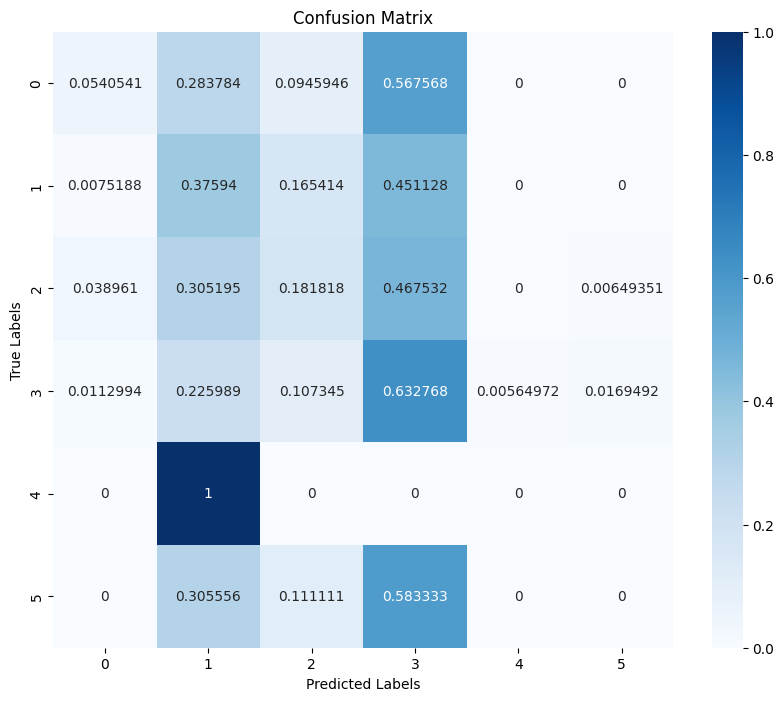

Epoch 12, Validation Loss: 3.2241, Accuracy: 0.3362, F1 Score: 0.2932
Val F1 Score Per Class  [0.09195402 0.32786885 0.23931624 0.46280992 0.         0.        ]


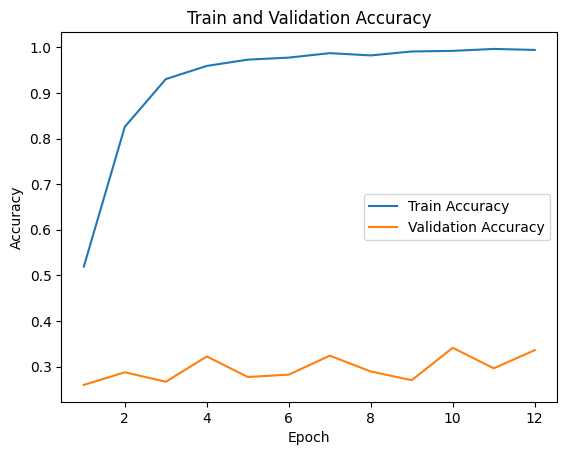

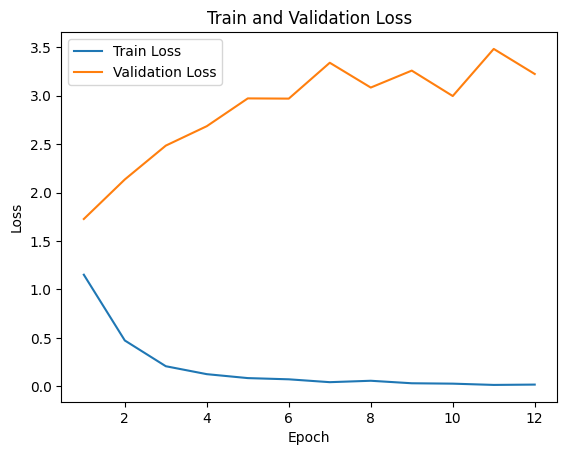

Epoch 13, Train Loss: 0.0096, Accuracy: 0.9974, F1 Score: 0.9974
Train F1 Score Per Class  [0.99637243 0.99581089 0.997882   0.99528857 1.         0.99909829]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.43it/s, loss=3.89]

[tensor([ 0.4321, -2.2056, -1.8170,  2.3269, -5.8748, -3.3685], device='cuda:0'), tensor([-0.1078, -2.9621, -1.1380,  5.5830, -3.5052, -2.9628], device='cuda:0'), tensor([-3.5131, -1.6782, -1.1411,  5.5057, -4.7366, -3.8002], device='cuda:0'), tensor([-1.4933, -2.2217,  4.2883, -2.0019, -5.8374, -2.1368], device='cuda:0'), tensor([ 0.0875, -4.1793,  4.4456,  0.5825, -3.3891, -2.5851], device='cuda:0'), tensor([-1.1788, -1.2502,  1.4973, -1.4201, -5.0132, -4.3593], device='cuda:0'), tensor([-4.1330,  2.0438, -0.2912,  1.5298, -3.2620, -1.8608], device='cuda:0'), tensor([-0.6367, -2.3324, -0.4701,  5.3348, -4.6820, -4.5646], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.40it/s, loss=4.53]

[tensor([-2.8648,  0.9745, -1.9759,  3.2713, -3.3771, -3.2281], device='cuda:0'), tensor([-2.2776, -2.8094, -0.3127,  4.2022, -4.9997, -3.7428], device='cuda:0'), tensor([-0.4541, -3.7179, -1.3091,  3.8702, -3.0334, -2.5788], device='cuda:0'), tensor([-2.9970, -2.4347, -1.4512,  3.4497, -2.2348, -2.7412], device='cuda:0'), tensor([-1.5606,  0.0791, -2.3953,  6.3158, -4.1509, -3.0353], device='cuda:0'), tensor([-2.5141,  1.4041, -2.8647,  1.0438, -4.1159, -3.7688], device='cuda:0'), tensor([-2.6756, -1.8334, -1.4371,  6.2715, -4.2727, -2.3376], device='cuda:0'), tensor([-0.3850, -2.7716, -3.2270,  4.4877, -3.4566, -1.8110], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.35it/s, loss=2.07]

[tensor([-2.2696, -1.5444, -2.2454,  3.8081, -4.3041, -3.9197], device='cuda:0'), tensor([-3.3786, -1.8875,  3.5284,  1.2244, -2.0211, -4.0249], device='cuda:0'), tensor([-2.1639,  4.0512, -0.2845, -2.9904, -2.6558, -2.8226], device='cuda:0'), tensor([-2.5514, -0.1846,  1.1126, -1.7154, -4.1114, -3.6360], device='cuda:0'), tensor([ 3.4257, -0.5577, -2.9537,  0.3018, -4.0357, -2.2858], device='cuda:0'), tensor([-1.4394, -0.8497,  6.9444, -2.3546, -3.8886, -2.8812], device='cuda:0'), tensor([-2.5213, -2.1750, -2.0365,  2.5363, -4.3373, -2.1216], device='cuda:0'), tensor([-0.5543, -1.9434,  1.3452,  3.1319, -4.4694, -4.4271], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.37it/s, loss=4.2]

[tensor([ 5.8563, -1.5289, -1.8827, -0.3295, -2.3741, -2.7379], device='cuda:0'), tensor([-1.6851, -2.9117, -1.4915,  6.4424, -2.7162, -2.9267], device='cuda:0'), tensor([-2.4288, -2.0666,  6.3442, -0.5917, -3.8586, -3.1184], device='cuda:0'), tensor([-1.7237,  2.2173, -2.5005,  1.1582, -4.4771, -1.9828], device='cuda:0'), tensor([-0.9416, -1.6283,  7.1354, -2.3555, -3.4182, -1.8688], device='cuda:0'), tensor([-1.3022, -2.6016, -1.4447,  0.6409, -4.6470, -2.9649], device='cuda:0'), tensor([-1.9850, -3.8380,  1.2493,  3.2403, -3.7717, -1.8928], device='cuda:0'), tensor([-0.1666, -2.6508, -0.9660,  5.2607, -3.8853, -3.7450], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.37it/s, loss=4.52]

[tensor([-3.3104,  2.3219, -0.3420, -2.4237, -4.8441, -3.3292], device='cuda:0'), tensor([-1.8798, -2.9001,  0.3171,  0.1907, -3.7365, -1.4708], device='cuda:0'), tensor([-3.1899, -1.6167, -0.2992,  0.2442, -5.2025, -3.5665], device='cuda:0'), tensor([-1.6120, -1.8589,  7.3748, -1.9739, -3.1922, -2.6007], device='cuda:0'), tensor([-3.1861, -2.0348,  3.3234, -0.9531, -4.0561, -1.1888], device='cuda:0'), tensor([-2.6110, -0.7334, -0.2457,  4.3572, -4.4368, -3.1353], device='cuda:0'), tensor([-3.0384, -1.9339,  0.0928,  2.2679, -5.4651, -3.2536], device='cuda:0'), tensor([-3.4637,  0.4475,  2.4968, -0.7594, -4.6973, -4.5562], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.38it/s, loss=5.11]

[tensor([-2.1260, -0.4651, -2.7823,  4.3192, -4.1581, -3.6233], device='cuda:0'), tensor([-1.5503, -1.3011, -2.7027,  2.3838, -3.8145, -1.8765], device='cuda:0'), tensor([-3.4270,  3.1258, -0.7213,  0.1642, -4.3843, -2.1700], device='cuda:0'), tensor([-2.2534, -1.9735, -0.0888,  0.8687, -5.2038, -3.8653], device='cuda:0'), tensor([-0.8818, -0.9057,  0.0325,  2.2114, -5.2691, -2.6338], device='cuda:0'), tensor([-3.6254, -1.5307,  4.8963, -1.4871, -3.9561, -3.8556], device='cuda:0'), tensor([-3.1378,  6.5981, -1.1688, -1.9542, -3.2742, -2.3832], device='cuda:0'), tensor([-2.6993,  4.2079, -1.4616, -0.5543, -3.6771, -2.7367], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.38it/s, loss=2.2]

[tensor([-2.4853, -2.7646,  5.0876, -0.8324, -5.0022, -4.0169], device='cuda:0'), tensor([-1.8860, -1.9696,  7.3222, -1.3594, -3.4270, -2.5523], device='cuda:0'), tensor([-0.4229, -2.9156, -1.2796,  5.3843, -3.7640, -1.4413], device='cuda:0'), tensor([-0.6657, -1.6774, -1.2330,  1.3278, -4.9500, -2.4486], device='cuda:0'), tensor([-2.8215,  0.2672,  2.9935,  1.4053, -4.6670, -4.4748], device='cuda:0'), tensor([-2.9043, -1.1329, -2.0802,  5.4966, -3.5793, -1.4957], device='cuda:0'), tensor([-2.9486, -0.2255, -2.6462,  3.1321, -3.8756, -2.7694], device='cuda:0'), tensor([-1.2157, -1.9402,  7.3104, -1.8316, -2.7030, -2.1614], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.38it/s, loss=3.98]

[tensor([-2.2737,  1.4182, -1.8215,  2.0087, -3.0407, -3.3856], device='cuda:0'), tensor([-2.5950, -0.9253, -2.2611,  0.4144, -3.0642, -1.6152], device='cuda:0'), tensor([ 4.4347, -1.8082, -2.4355, -0.9068, -3.8770, -1.7473], device='cuda:0'), tensor([-1.7946, -1.1266, -0.9403,  5.7661, -5.1417, -4.1698], device='cuda:0'), tensor([-3.7258,  0.0378, -1.6679,  2.5018, -4.3284, -2.6839], device='cuda:0'), tensor([-1.6887, -3.0200, -1.9324,  6.2398, -3.4900, -2.4169], device='cuda:0'), tensor([-0.5950, -3.9326,  1.2787,  1.9728, -4.3093, -2.4708], device='cuda:0'), tensor([-3.3600, -1.0299, -2.2162,  6.0592, -3.8370, -2.9549], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=3.14]

[tensor([-3.2974,  3.4833, -1.0821,  0.5842, -5.4878, -3.4032], device='cuda:0'), tensor([-2.4458, -2.0409, -0.9656,  5.6951, -4.5318, -2.9050], device='cuda:0'), tensor([ 3.0857, -3.5863, -1.5563,  4.3505, -4.4191, -2.5769], device='cuda:0'), tensor([-2.4021, -1.6611, -2.1393,  6.7124, -4.1606, -2.9570], device='cuda:0'), tensor([-1.9668, -2.4275, -0.1427,  1.7973, -4.9981, -3.4755], device='cuda:0'), tensor([-1.8893, -1.3505, -1.8782,  3.4686, -4.8225, -3.3067], device='cuda:0'), tensor([-3.9161, -2.3898,  2.8588,  0.3940, -4.5724, -3.5497], device='cuda:0'), tensor([-3.0807, -2.4500,  2.2180,  0.1923, -5.2736, -2.5545], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=4.76]

[tensor([-2.1526, -1.6310, -1.6271,  1.5373, -4.9112, -4.9153], device='cuda:0'), tensor([-1.9476, -2.8587, -1.4936,  6.5783, -3.3822, -2.5124], device='cuda:0'), tensor([-2.7281, -0.2063,  1.9281, -0.3760, -4.3048, -4.5362], device='cuda:0'), tensor([-2.9624, -0.6349,  4.5430, -1.9364, -3.7266, -3.8465], device='cuda:0'), tensor([-2.4310,  2.8912,  3.7614, -2.6766, -4.0057, -3.9153], device='cuda:0'), tensor([-3.6287, -0.0613, -1.4066,  0.1274, -4.4531, -3.6215], device='cuda:0'), tensor([ 1.2851,  0.3811, -1.2739,  1.4660, -5.0230, -4.8911], device='cuda:0'), tensor([-2.8506, -1.3699, -1.4341,  2.7658, -4.3157, -3.8933], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=2.89]

[tensor([-2.9054,  2.9713, -1.3878,  0.3415, -3.9771, -3.8699], device='cuda:0'), tensor([-2.6775, -2.2394, -1.4126,  3.3873, -3.5327, -2.9787], device='cuda:0'), tensor([-3.8740,  0.4392, -1.4453,  1.4484, -4.7496, -3.4459], device='cuda:0'), tensor([-2.5691, -2.4426,  2.0411,  2.1061, -3.9863, -2.9158], device='cuda:0'), tensor([-2.4393, -2.0525,  4.3320,  0.7098, -4.9190, -3.2517], device='cuda:0'), tensor([-2.3268, -1.9081, -1.9373,  6.9792, -3.6402, -2.2929], device='cuda:0'), tensor([-2.3523,  0.1961,  0.2351, -1.8419, -5.4419, -3.5018], device='cuda:0'), tensor([ 0.3021, -2.6905, -0.6704,  3.9021, -5.1140, -2.5791], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.38it/s, loss=2.66]

[tensor([-2.0134, -1.6760, -1.1494, -0.8851, -4.9276, -4.5299], device='cuda:0'), tensor([-1.6068, -1.3382,  5.5656, -1.2621, -4.4097, -3.8895], device='cuda:0'), tensor([-1.8237, -2.9911, -0.9866,  6.0860, -4.0592, -2.9776], device='cuda:0'), tensor([-2.1212, -1.4751, -1.9049,  5.3447, -5.1577, -2.3644], device='cuda:0'), tensor([-0.9110,  0.1693, -1.9812, -0.3407, -4.5952, -4.1030], device='cuda:0'), tensor([-2.7411,  0.1283, -0.9745, -0.6355, -4.4126, -3.7520], device='cuda:0'), tensor([-2.4492, -2.2594,  4.9968, -0.6025, -3.8375, -2.1831], device='cuda:0'), tensor([ 0.8513, -2.0855,  0.6200,  0.0202, -5.2082, -2.8323], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.38it/s, loss=3.01]

[tensor([-2.4735, -1.8321, -2.0745,  4.3231, -2.7956, -1.2276], device='cuda:0'), tensor([-1.8443, -1.9559, -0.7640,  4.9568, -4.7122, -4.0388], device='cuda:0'), tensor([-1.5200,  0.7097, -4.1823,  3.3087, -4.0089, -2.2221], device='cuda:0'), tensor([-2.6999, -1.8100,  6.7901, -0.9285, -3.8396, -2.8783], device='cuda:0'), tensor([-2.2172, -2.3259, -1.2047,  5.7099, -4.5667, -2.7687], device='cuda:0'), tensor([ 0.9990, -2.6760, -2.7926,  2.3595, -4.1851, -4.0743], device='cuda:0'), tensor([-3.3098, -1.2856, -1.8992, -0.0693, -4.1680, -2.6888], device='cuda:0'), tensor([-2.7174,  1.5568, -1.0239,  1.8563, -4.7635, -4.4817], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=2.17]

[tensor([-1.7755, -0.4741,  6.8299, -2.6511, -2.2751, -2.4662], device='cuda:0'), tensor([-1.8307, -1.7508, -2.2358,  1.1205, -4.8845, -4.4597], device='cuda:0'), tensor([ 0.4212, -1.6579, -1.4953,  2.5306, -5.2993, -4.5733], device='cuda:0'), tensor([-0.7494, -2.8382,  0.5222, -0.5224, -4.3289, -3.6963], device='cuda:0'), tensor([-2.6680,  0.1638, -1.3103,  1.2539, -4.4702, -4.4707], device='cuda:0'), tensor([-2.4284, -0.8154, -0.3195,  4.0643, -3.9207, -3.4909], device='cuda:0'), tensor([-2.8038,  0.0526, -0.9931, -0.9420, -4.8184, -4.0168], device='cuda:0'), tensor([-1.4022, -1.7894, -1.8944,  3.3652, -4.5243, -4.2207], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.38it/s, loss=2.73]

[tensor([-2.7873, -1.9127, -1.2251, -0.1418, -4.3718, -4.4926], device='cuda:0'), tensor([-3.4007, -2.7083, -1.3626,  2.9243, -4.0834, -2.3553], device='cuda:0'), tensor([-2.2042, -3.9412, -0.1588,  2.2077, -2.6189, -2.2211], device='cuda:0'), tensor([-1.1442,  0.4297,  2.6218, -2.6977, -4.2458, -3.5911], device='cuda:0'), tensor([-2.6487, -2.2023,  5.3678, -0.1147, -4.2163, -3.2080], device='cuda:0'), tensor([ 1.1075, -3.9819,  0.2805,  4.1872, -5.0232, -3.5793], device='cuda:0'), tensor([-2.5823,  0.0971, -3.3113,  4.2075, -3.2605, -1.9092], device='cuda:0'), tensor([-3.2573, -0.7997, -0.2775,  4.4151, -4.8387, -3.7472], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.38it/s, loss=3.75]

[tensor([ 0.6749, -0.9385, -1.2011,  3.7236, -4.4113, -4.6271], device='cuda:0'), tensor([-4.5488, -1.0383, -1.4345,  3.3226, -4.9120, -3.2688], device='cuda:0'), tensor([-3.4205, -1.9053,  0.4216, -0.7942, -4.1408,  3.3457], device='cuda:0'), tensor([-2.7199, -2.2347,  1.1684,  3.6629, -5.1061, -3.2037], device='cuda:0'), tensor([ 5.7982, -1.2367,  0.1255, -0.8814, -4.1318, -3.2429], device='cuda:0'), tensor([-0.6330, -1.1712, -1.9792,  2.4088, -4.7048, -3.5501], device='cuda:0'), tensor([-2.7762, -1.8198, -1.4348, -1.0477, -3.6931, -2.8885], device='cuda:0'), tensor([ 4.2761, -1.3883, -3.3910, -0.7218, -3.2006, -0.7494], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=3.69]

[tensor([-2.2961,  3.4770, -0.9851, -1.0198, -3.3002, -3.5854], device='cuda:0'), tensor([-1.1402, -1.4576, -1.6326,  5.9643, -4.8461, -4.3840], device='cuda:0'), tensor([-4.1266, -1.0521, -0.3880,  2.2996, -4.2303, -0.8257], device='cuda:0'), tensor([-2.2323, -0.9766,  4.4336, -1.7768, -3.8949, -3.0362], device='cuda:0'), tensor([ 6.4309, -2.4327, -0.1474,  0.0608, -3.8931, -3.3255], device='cuda:0'), tensor([-1.5210, -0.0546, -1.4090,  1.1020, -5.3025, -5.4539], device='cuda:0'), tensor([-1.5858, -3.3158,  6.1689,  0.4608, -4.0353, -2.6333], device='cuda:0'), tensor([-2.2576, -2.2056, -0.2244,  2.7966, -4.5433, -3.1965], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.38it/s, loss=2.14]

[tensor([-1.0852,  0.2969, -2.7229,  1.8550, -3.6406, -3.2179], device='cuda:0'), tensor([-2.6432, -2.4465,  0.7222,  2.2669, -3.0109, -3.3229], device='cuda:0'), tensor([-3.1928,  1.0285, -1.4364,  2.5727, -4.4742, -3.6657], device='cuda:0'), tensor([-2.1878, -2.7946, -1.2799,  6.7794, -2.9189, -2.2144], device='cuda:0'), tensor([-2.9723,  1.0217, -2.6966,  1.2875, -3.9914, -1.6672], device='cuda:0'), tensor([ 2.2006, -2.3035, -1.4028, -0.2027, -5.8692, -2.8911], device='cuda:0'), tensor([-1.6975, -1.5337, -0.8167,  0.9274, -4.5898, -3.1672], device='cuda:0'), tensor([-1.8377, -2.2610,  0.9874, -1.1702, -5.4517, -3.2236], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.38it/s, loss=3.75]

[tensor([-3.5794, -2.3626,  1.7805,  1.5596, -3.7758, -3.4501], device='cuda:0'), tensor([-2.5153, -1.5397,  4.9453, -0.2118, -3.3985, -3.3054], device='cuda:0'), tensor([-0.8806, -2.8294,  3.1645, -1.8277, -3.0728, -1.6742], device='cuda:0'), tensor([-3.1003,  1.1221, -0.1440,  2.4970, -2.2428, -4.3705], device='cuda:0'), tensor([-4.2421,  3.3197, -0.0707,  0.6726, -3.9804, -2.4820], device='cuda:0'), tensor([-1.0998, -1.8386, -2.6801,  4.0915, -4.2218, -3.3621], device='cuda:0'), tensor([-1.5822, -2.6153, -1.3892,  6.7473, -3.9697, -2.3242], device='cuda:0'), tensor([-1.2647, -1.1216, -2.2430,  3.4878, -4.5800, -4.1111], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.35it/s, loss=2.14]

[tensor([-4.5670,  0.1061, -1.0107, -0.1021, -4.4850, -2.0916], device='cuda:0'), tensor([-1.6897, -2.3558,  1.7601,  1.9800, -5.6051, -3.7905], device='cuda:0'), tensor([-2.4376, -1.9150,  0.5037,  0.3035, -4.7200, -3.7129], device='cuda:0'), tensor([-3.1144, -0.1790,  2.4718, -0.4892, -5.6609, -4.0403], device='cuda:0'), tensor([-3.9624, -1.7696, -2.0497,  2.3234, -3.6324, -4.3515], device='cuda:0'), tensor([-3.5256, -1.7141,  1.4470,  2.0288, -4.4449, -3.0791], device='cuda:0'), tensor([-1.8919,  0.6178, -0.7278,  1.5243, -3.7865, -3.4841], device='cuda:0'), tensor([-2.6390e+00,  5.6041e+00, -1.6927e+00, -3.3529e-03, -2.8930e+00,
        -3.2872e+00], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:22,  2.35it/s, loss=6.14]

[tensor([-1.7626, -2.1113,  6.9106, -2.1082, -3.2958, -1.8456], device='cuda:0'), tensor([-1.7466,  2.3496, -0.5939, -0.3071, -4.8221, -4.0371], device='cuda:0'), tensor([-2.7022, -1.3953, -2.5761,  6.3356, -4.0334, -4.2678], device='cuda:0'), tensor([-2.0856,  0.0071, -3.1148,  5.2905, -4.4094, -2.8494], device='cuda:0'), tensor([-3.2956,  4.5242, -2.1095, -1.3247, -3.2225, -1.2032], device='cuda:0'), tensor([-1.8237, -3.4235, -1.0359,  0.5160, -4.3571, -2.8674], device='cuda:0'), tensor([-1.7072,  6.0774, -1.3803, -2.0428, -3.4241, -2.3981], device='cuda:0'), tensor([-0.4834, -2.2910, -0.1106,  2.2432, -4.7461, -4.4677], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.35it/s, loss=3.47]

[tensor([ 0.1101, -2.4908,  3.3435, -1.1209, -4.4240, -3.4259], device='cuda:0'), tensor([-1.7019, -2.9256,  4.7538, -1.1966, -3.7544, -3.8620], device='cuda:0'), tensor([-2.2170, -0.0890,  6.7312, -1.6209, -4.6830, -3.5253], device='cuda:0'), tensor([-2.4284, -1.9479,  0.6660,  2.2453, -4.1516, -3.2625], device='cuda:0'), tensor([-2.4803, -0.9413, -2.1825,  2.2419, -4.5240, -3.9053], device='cuda:0'), tensor([ 1.9466, -2.4905,  1.4669, -0.7262, -4.3759, -3.5909], device='cuda:0'), tensor([-1.2400, -2.1986,  3.0584,  1.5465, -5.8758, -3.6682], device='cuda:0'), tensor([-1.3720, -1.8255,  6.9891, -1.8021, -3.7952, -2.9939], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.35it/s, loss=3.24]

[tensor([-1.8203, -3.0492, -2.3926,  0.7798, -3.2303, -3.4582], device='cuda:0'), tensor([-1.3116, -0.5659,  3.5852, -2.2615, -4.7558, -4.3613], device='cuda:0'), tensor([-2.0031, -1.3120, -1.8873,  6.5894, -4.3967, -3.2877], device='cuda:0'), tensor([-2.0464,  5.4604, -1.0998, -1.1256, -3.1384, -2.3476], device='cuda:0'), tensor([-2.2296, -2.0343, -1.8515, -0.3044, -5.4027, -3.5413], device='cuda:0'), tensor([-4.1877,  3.0948,  0.4245,  1.3717, -4.6388, -4.0375], device='cuda:0'), tensor([-1.8033, -3.2857,  0.2987,  1.3434, -4.3921, -1.8042], device='cuda:0'), tensor([-3.8397,  4.3866, -1.5545, -0.5418, -4.6483, -1.4538], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.36it/s, loss=4.11]

[tensor([-2.1764, -2.3134,  6.1291,  0.5032, -3.9834, -3.8321], device='cuda:0'), tensor([-2.6800, -1.4474,  0.2312,  2.9925, -4.8865, -3.5446], device='cuda:0'), tensor([-3.7605,  0.7716, -2.3455,  1.3885, -6.0368, -3.5318], device='cuda:0'), tensor([-1.2403, -4.5905, -1.0940,  2.3061, -4.4663, -0.6985], device='cuda:0'), tensor([ 0.1564, -3.0194, -2.4028,  5.6930, -3.9313, -2.7475], device='cuda:0'), tensor([-2.3519, -2.0122, -0.8386,  3.7215, -5.0821, -3.3358], device='cuda:0'), tensor([-1.2562, -0.8300, -2.8891, -0.6476, -3.5773,  1.3511], device='cuda:0'), tensor([-1.6689, -2.9053,  0.0544,  2.7550, -5.0388, -4.1979], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.36it/s, loss=3.26]

[tensor([-2.7562, -1.8218,  6.5642, -1.3591, -3.7841, -2.9194], device='cuda:0'), tensor([-2.2359, -1.8946,  3.6576, -0.3499, -3.3511, -3.5811], device='cuda:0'), tensor([-3.6271, -1.2679, -0.4480,  1.8682, -4.3158, -3.4371], device='cuda:0'), tensor([-3.0063,  1.0569, -1.2558,  1.9827, -4.3410, -3.7847], device='cuda:0'), tensor([-2.9309,  2.5089, -2.0991, -0.2870, -3.7937, -2.7678], device='cuda:0'), tensor([-2.9433, -3.0334,  2.2636, -0.6521, -3.3228, -3.4081], device='cuda:0'), tensor([-1.0136, -1.5712, -3.5288,  4.6334, -4.0450, -2.9724], device='cuda:0'), tensor([ 0.6350, -1.5836, -2.0498,  1.2272, -3.5422, -3.2565], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.35it/s, loss=1.86]

[tensor([-1.7564, -2.0531, -0.9141,  5.8435, -4.7366, -3.3190], device='cuda:0'), tensor([-2.7762, -2.9747, -0.2921,  2.8550, -5.5363, -2.7595], device='cuda:0'), tensor([-3.0853, -2.0515,  5.3457, -0.7377, -3.4901, -3.0977], device='cuda:0'), tensor([ 5.9852, -2.6432, -1.0638, -0.1939, -3.5027, -2.0004], device='cuda:0'), tensor([-2.8523,  2.4888, -1.6088,  3.6524, -5.1339, -3.7088], device='cuda:0'), tensor([ 0.3990, -2.5235,  4.1915,  0.4764, -4.2334, -3.0316], device='cuda:0'), tensor([-1.3163,  1.1450, -1.7571,  1.7428, -3.7374, -4.5445], device='cuda:0'), tensor([-3.1945, -0.0459, -0.3649, -2.0642, -4.7659, -2.2049], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.36it/s, loss=3.04]

[tensor([-3.4312, -1.5316,  0.2266,  4.0877, -4.6870, -3.4830], device='cuda:0'), tensor([-2.8440, -0.4585, -1.4832,  1.1372, -4.1669, -3.8465], device='cuda:0'), tensor([-1.6233, -1.3453, -2.3017,  3.2517, -3.9373, -3.7410], device='cuda:0'), tensor([-2.8214, -2.3991,  5.5558, -0.1074, -4.6733, -2.7775], device='cuda:0'), tensor([-2.9190,  1.8658, -0.1957, -0.1832, -4.1974, -2.6832], device='cuda:0'), tensor([-0.4264, -2.4051, -0.3636,  0.5628, -4.7260, -3.3313], device='cuda:0'), tensor([-2.4088, -3.4512,  4.5528, -0.5271, -4.2035, -2.5815], device='cuda:0'), tensor([-1.4945, -0.5705, -2.4452,  4.4584, -5.2700, -3.2922], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:19,  2.36it/s, loss=3.64]

[tensor([ 0.2729, -2.5301, -1.6979,  5.7826, -4.1411, -3.4914], device='cuda:0'), tensor([-2.3431, -1.5581, -2.5089,  6.3371, -3.6043, -3.1235], device='cuda:0'), tensor([-1.4349,  1.4465,  0.6847, -2.1836, -4.5754, -3.4552], device='cuda:0'), tensor([-3.4038, -1.9432,  1.3675,  2.3299, -4.0507, -3.7983], device='cuda:0'), tensor([-2.3261, -2.5237, -1.7043,  5.5291, -4.1790, -3.1417], device='cuda:0'), tensor([-3.4463,  2.1884,  1.5826,  2.7344, -5.4175, -4.7250], device='cuda:0'), tensor([-2.9540, -1.8512,  1.5493,  2.1556, -5.1098, -4.0476], device='cuda:0'), tensor([-3.2099,  1.2212,  1.7592, -1.5212, -4.7166, -4.5089], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.35it/s, loss=3.95]

[tensor([-3.5832,  0.4379, -0.9448,  5.4087, -4.1517, -2.9348], device='cuda:0'), tensor([-4.0222, -0.9677, -1.0440,  1.3499, -4.3121, -1.6611], device='cuda:0'), tensor([-3.8806, -2.5105,  3.2735, -0.0421, -4.5052, -2.9606], device='cuda:0'), tensor([-3.6247,  3.0401, -1.3767,  1.4363, -3.7016, -4.1129], device='cuda:0'), tensor([ 0.6306,  0.1609,  2.3840, -1.9456, -5.6089, -3.9564], device='cuda:0'), tensor([-3.7048, -1.3877,  2.1599,  0.0361, -5.0238, -2.3001], device='cuda:0'), tensor([-4.0128, -1.4640, -0.5874,  3.3645, -3.6067, -3.0566], device='cuda:0'), tensor([-2.8534, -0.9474, -1.3634,  5.8334, -4.6067, -3.3585], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.35it/s, loss=4.46]

[tensor([-4.1820,  4.0467, -0.9072,  0.6145, -4.4022, -2.9567], device='cuda:0'), tensor([-3.4091, -1.7167, -1.1548,  5.7504, -3.7238, -3.5635], device='cuda:0'), tensor([-2.3342, -0.2320, -2.3479, -1.4959, -4.0099, -2.2980], device='cuda:0'), tensor([-2.0013, -2.3522, -1.2739,  6.7010, -4.4412, -2.9340], device='cuda:0'), tensor([-3.4726, -0.4210, -1.8369, -2.1268, -5.4933, -2.9151], device='cuda:0'), tensor([-1.7409, -2.4632,  5.9515, -1.5086, -3.2318, -2.3732], device='cuda:0'), tensor([-0.9846, -3.4549,  0.9352,  1.1385, -5.5483, -4.8173], device='cuda:0'), tensor([-1.1994, -1.8846, -0.0354, -1.6460, -2.8162,  7.5166], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.36it/s, loss=3.07]

[tensor([-2.2388, -1.1146, -3.2518,  4.8345, -3.9061, -2.3863], device='cuda:0'), tensor([-2.0977, -1.9906, -2.4858,  6.6454, -4.1485, -2.3478], device='cuda:0'), tensor([-4.4480,  0.0835,  0.8799,  0.2940, -4.8587, -1.5916], device='cuda:0'), tensor([-2.6290,  4.9121, -2.0282, -0.6564, -4.4542, -2.9092], device='cuda:0'), tensor([-3.6740,  1.8537,  1.6176, -2.1161, -3.6655, -3.0038], device='cuda:0'), tensor([ 6.9291, -1.1609, -1.5979, -1.5488, -2.4389, -1.0712], device='cuda:0'), tensor([-1.9645, -3.2197,  0.0478,  4.6939, -4.0644, -3.6041], device='cuda:0'), tensor([-2.2250, -1.4410,  2.8153,  2.0043, -4.8489, -4.3156], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.35it/s, loss=4.91]

[tensor([-2.2098, -0.8944, -2.5738,  0.5597, -3.4703, -2.4642], device='cuda:0'), tensor([-2.0747, -1.6190, -2.1758,  6.9277, -3.6139, -2.6320], device='cuda:0'), tensor([-1.8782,  6.5861, -2.0900, -0.8721, -2.3551, -2.9851], device='cuda:0'), tensor([-3.3737,  1.9273, -2.1220, -1.0129,  2.8178, -1.0935], device='cuda:0'), tensor([-2.2360, -1.2138,  1.8690,  0.1896, -2.9838, -3.6062], device='cuda:0'), tensor([-2.0459, -2.4556, -0.3996,  0.3563, -4.9440, -3.7543], device='cuda:0'), tensor([ 2.8660, -2.3685, -1.1993,  0.2979, -4.8187, -3.4917], device='cuda:0'), tensor([ 6.7898, -2.0255, -0.9120, -0.2595, -3.6936, -3.4174], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:17,  2.32it/s, loss=4.89]

[tensor([-3.4707, -2.5792, -0.8144,  5.0092, -3.3412, -2.1405], device='cuda:0'), tensor([-3.2645,  3.1824, -1.9388,  2.8596, -4.0529, -2.7592], device='cuda:0'), tensor([-1.9351, -3.1368, -0.1198,  4.6059, -5.1396, -2.8720], device='cuda:0'), tensor([-2.5869, -0.0170,  4.9873, -2.8919, -3.8676, -3.6590], device='cuda:0'), tensor([-2.7017, -2.0510,  6.7038, -1.2076, -3.6658, -2.9955], device='cuda:0'), tensor([-2.9136, -3.0205,  0.9818,  3.0715, -4.2092, -2.9492], device='cuda:0'), tensor([-2.9628,  1.2148, -0.2157, -0.7647, -5.0351, -3.3584], device='cuda:0'), tensor([-3.0459, -0.2170, -2.2113,  3.8094, -3.7204, -3.1989], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.34it/s, loss=3.97]

[tensor([ 6.9239, -0.5292, -2.5576, -0.9181, -2.9048, -2.7335], device='cuda:0'), tensor([-2.8177e+00, -1.9767e+00, -4.7667e-03,  3.1503e+00, -5.5953e+00,
        -4.4270e+00], device='cuda:0'), tensor([-2.9327,  1.4022, -2.1467,  0.9978, -0.4616, -3.1342], device='cuda:0'), tensor([-2.9882, -3.6420, -0.3945,  2.9621, -4.4307, -2.1754], device='cuda:0'), tensor([-3.3067,  0.0319, -1.5321,  2.5868, -3.8800, -3.5890], device='cuda:0'), tensor([-3.5061,  0.1785,  0.2582, -0.0092, -4.7415, -2.7124], device='cuda:0'), tensor([-1.4225, -3.0565, -1.4036,  5.6804, -3.8188, -3.5819], device='cuda:0'), tensor([-1.7585, -1.3799,  6.7821, -2.0315, -3.8606, -3.0206], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.33it/s, loss=3.09]

[tensor([-3.0338, -1.2825,  4.1898, -1.6915, -5.0883, -3.3357], device='cuda:0'), tensor([-1.4584,  0.7654, -0.9505, -0.4522, -4.2198, -3.3694], device='cuda:0'), tensor([-1.5104, -3.3250,  4.0831, -1.4364, -3.9488, -2.4978], device='cuda:0'), tensor([-1.7943, -1.4985,  6.9329, -1.3018, -3.4654, -3.0745], device='cuda:0'), tensor([-3.5499,  2.5185, -0.7159,  1.7230, -4.6338, -2.8516], device='cuda:0'), tensor([-1.5735, -2.6904, -1.0744,  2.6976, -3.9739, -1.0197], device='cuda:0'), tensor([-2.0427, -2.2745,  6.7778, -0.8117, -3.4812, -2.7989], device='cuda:0'), tensor([-1.8247, -0.5462, -1.1224,  4.9077, -4.1582, -3.9505], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.34it/s, loss=4.24]

[tensor([-2.6175, -0.7682,  6.5276, -2.0830, -3.1193, -2.5758], device='cuda:0'), tensor([-1.9913, -1.5163,  6.6565, -1.5709, -3.0345, -3.0970], device='cuda:0'), tensor([-1.2889, -2.2556, -1.7598,  1.7093, -4.3057, -1.2927], device='cuda:0'), tensor([-2.7683,  5.8033, -2.8622,  0.5544, -3.9125, -3.1169], device='cuda:0'), tensor([-2.9508, -2.7620,  0.2830,  0.0197, -4.3844, -2.7853], device='cuda:0'), tensor([-1.5174, -3.1237, -0.7377,  4.5398, -4.3271, -3.8921], device='cuda:0'), tensor([-1.8701, -2.4206, -1.6401,  5.7519, -4.4971, -4.0976], device='cuda:0'), tensor([-2.2986, -0.8592, -1.7457,  4.8285, -4.2703, -3.9943], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.35it/s, loss=5.39]

[tensor([-0.6799, -2.9021, -2.0183,  3.2962, -3.8279, -2.4101], device='cuda:0'), tensor([-2.7627, -1.3232,  5.7390, -0.7677, -4.8544, -3.6311], device='cuda:0'), tensor([-1.9569, -1.8196, -2.3584,  4.3445, -4.0006, -3.3179], device='cuda:0'), tensor([-3.9452,  4.5394, -1.9743, -0.5140, -3.7270,  1.1039], device='cuda:0'), tensor([-2.7393,  0.8084,  5.0082, -2.0146, -4.2018, -2.3644], device='cuda:0'), tensor([-3.1641,  5.3256, -0.9784, -0.2859, -3.7304, -3.3522], device='cuda:0'), tensor([-1.2474,  1.1130, -1.7570,  2.4261, -4.0661, -4.3930], device='cuda:0'), tensor([-2.9005,  0.4518, -0.8932,  3.7230, -4.4475, -4.3737], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.35it/s, loss=3.42]

[tensor([-2.2168, -1.3323,  2.9625, -0.5586, -3.9100, -2.3283], device='cuda:0'), tensor([-2.4996,  0.1138, -1.0277,  1.2324, -4.9758, -1.0817], device='cuda:0'), tensor([-2.2577, -2.0680, -0.7790,  4.0804, -4.8701, -3.7461], device='cuda:0'), tensor([-3.3748,  0.6854, -3.0335,  1.2668, -3.0351, -2.6413], device='cuda:0'), tensor([-2.3955, -0.8950,  4.1103, -1.6715, -4.5205, -4.6115], device='cuda:0'), tensor([-1.4902,  5.1981, -2.3408, -0.1709, -2.8708, -2.7481], device='cuda:0'), tensor([-2.9589,  0.3029,  1.1186, -2.6151, -4.0023, -3.7754], device='cuda:0'), tensor([-2.6771, -2.7426,  5.3913,  0.7087, -4.8490, -3.5504], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.36it/s, loss=4.62]

[tensor([-1.1294, -1.0122,  3.8811, -0.5835, -4.6977, -4.7706], device='cuda:0'), tensor([-2.3680, -0.9720, -0.9683,  5.3326, -4.2341, -4.1542], device='cuda:0'), tensor([ 0.6315, -2.3906, -0.8779,  1.6035, -4.4632, -2.8246], device='cuda:0'), tensor([-1.7638, -3.2820, -0.1581,  0.3364, -4.7145, -3.0676], device='cuda:0'), tensor([-2.2293, -2.4354, -1.8729,  6.5710, -4.5362, -3.5954], device='cuda:0'), tensor([-2.7272, -1.3721,  6.7992, -1.4298, -3.3364, -2.4645], device='cuda:0'), tensor([ 3.1744, -2.3440,  1.5124, -1.0312, -4.2025, -3.4359], device='cuda:0'), tensor([-3.8888,  1.0453, -0.8067,  0.2752, -6.0914, -0.0258], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:14,  2.35it/s, loss=4]

[tensor([ 3.0019, -2.7074, -0.3368,  1.4711, -4.5030, -3.2547], device='cuda:0'), tensor([-1.0025, -1.7895,  4.4203, -1.7257, -3.0708, -2.7947], device='cuda:0'), tensor([-2.7532, -1.5981, -1.4746,  6.2180, -4.5089, -2.2794], device='cuda:0'), tensor([ 3.2969, -2.0283, -2.9872,  3.1217, -3.5373, -3.3533], device='cuda:0'), tensor([-4.1281,  1.8106, -1.3213,  1.5578, -4.4255, -1.2971], device='cuda:0'), tensor([ 3.1284, -2.0511, -2.3649,  2.7187, -3.1004, -3.9499], device='cuda:0'), tensor([-2.9316, -1.4169, -1.5448,  5.7601, -3.6378, -3.3655], device='cuda:0'), tensor([ 0.3255, -1.5329, -2.6406,  3.8230, -4.2711, -0.4304], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.36it/s, loss=2.52]

[tensor([-2.6133, -1.9678,  6.4543, -0.5437, -4.2204, -2.9654], device='cuda:0'), tensor([-2.9193,  1.0102,  1.4911,  1.9124, -2.7064, -4.4226], device='cuda:0'), tensor([-2.5206, -1.4414, -1.5934,  4.6912, -4.1884, -2.9401], device='cuda:0'), tensor([-3.8979,  1.9098, -1.6383,  1.3394, -4.8867, -4.2303], device='cuda:0'), tensor([-3.0955,  0.8434, -1.9929,  1.6957, -4.4835, -3.7443], device='cuda:0'), tensor([-3.3303, -2.2903,  3.5980,  1.8368, -4.8864, -3.7538], device='cuda:0'), tensor([-2.1809, -2.0823, -1.8081,  0.4336, -4.7164, -4.5963], device='cuda:0'), tensor([ 0.0607, -1.1467, -2.1181,  2.8783, -4.9085, -4.7188], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.35it/s, loss=3.77]

[tensor([-1.8301, -2.6945, -0.8309,  5.7933, -4.0482, -3.2161], device='cuda:0'), tensor([ 6.0393, -1.9102, -0.7783,  0.0600, -3.3384, -2.8934], device='cuda:0'), tensor([-1.5345, -2.5165, -1.5808,  4.9938, -4.2933, -3.2290], device='cuda:0'), tensor([-0.6292, -0.1174, -3.0796,  1.6858, -4.0359, -2.5974], device='cuda:0'), tensor([-3.4120, -0.8973, -0.9793,  2.4984, -3.3512, -3.2252], device='cuda:0'), tensor([-1.3598, -3.0417, -1.5936,  6.2189, -3.8688, -3.4211], device='cuda:0'), tensor([-3.2685, -1.6061,  0.0754,  5.0142, -4.5037, -2.3255], device='cuda:0'), tensor([-0.6319, -1.2164,  2.5409, -0.8479, -4.8383, -4.5970], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.34it/s, loss=1.29]

[tensor([-2.5211, -0.8478, -2.1163,  6.6250, -3.9691, -2.8167], device='cuda:0'), tensor([-3.2584, -1.0618, -0.3747,  0.6506, -4.3461, -3.9696], device='cuda:0'), tensor([ 1.0377, -1.9023, -1.9813,  2.2376, -5.3910, -4.0247], device='cuda:0'), tensor([-2.8486,  0.7817, -2.2589,  3.2889, -5.7054, -2.4140], device='cuda:0'), tensor([-2.3227,  0.2885, -1.9833,  2.5302, -5.0077, -3.4068], device='cuda:0'), tensor([-3.1923,  0.1376,  5.7436, -1.0590, -3.5344, -3.5027], device='cuda:0'), tensor([-2.5606, -2.1308,  1.8147,  1.6255, -4.7992, -3.3966], device='cuda:0'), tensor([-3.4077, -1.0839,  3.9087, -1.1322, -4.6286, -2.9394], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.34it/s, loss=4.62]

[tensor([-2.3054,  0.0696, -2.0373,  5.1195, -3.1018, -4.0959], device='cuda:0'), tensor([-2.3948e-03, -2.5377e+00,  1.7800e+00,  1.4537e+00, -5.8059e+00,
        -3.7184e+00], device='cuda:0'), tensor([-2.0099,  2.7316, -2.3780,  1.1838, -4.8764, -2.4805], device='cuda:0'), tensor([-2.0876, -1.7307, -1.4749, -0.9807, -1.7291,  7.9141], device='cuda:0'), tensor([-2.0906, -0.1142, -2.3085,  5.9549, -3.8852, -3.5175], device='cuda:0'), tensor([-2.4998, -0.3733, -2.5847,  2.4717, -4.1929, -3.5156], device='cuda:0'), tensor([-1.5694, -2.6230,  5.0672, -0.8174, -4.9220, -3.7334], device='cuda:0'), tensor([-2.2623,  0.5287, -1.9180,  2.2910, -3.9901, -3.8805], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:19<00:11,  2.35it/s, loss=4.78]

[tensor([-1.9817,  1.4844,  0.7181, -1.8688, -5.1832, -1.8899], device='cuda:0'), tensor([-3.0363,  6.3330, -1.0250, -1.2142, -3.1301, -2.7370], device='cuda:0'), tensor([-1.8039,  2.1345, -1.6569,  0.1312, -5.1795, -4.6631], device='cuda:0'), tensor([-2.0539,  6.7867, -2.1327, -0.9148, -3.7585, -3.0970], device='cuda:0'), tensor([-1.4548, -3.2251, -1.6924,  6.1724, -4.1974, -1.5522], device='cuda:0'), tensor([ 0.7422, -1.5791, -1.7377,  3.2347, -4.3700, -2.5336], device='cuda:0'), tensor([ 0.3263, -0.3489, -2.1827, -1.6267,  3.6036, -2.7375], device='cuda:0'), tensor([-4.3847, -0.7023,  3.8250, -0.1814, -4.3669, -2.9209], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.35it/s, loss=3.6]

[tensor([-2.4038, -0.9594, -1.0541,  4.3522, -5.0514, -4.1542], device='cuda:0'), tensor([-1.7602, -2.0638, -0.4072,  0.9749, -5.9586, -4.1308], device='cuda:0'), tensor([-1.8779, -1.0044, -1.6979,  1.7093, -5.6467, -2.7700], device='cuda:0'), tensor([-2.0463, -3.1512,  0.6004,  0.3514, -4.9707, -4.1591], device='cuda:0'), tensor([-4.0106,  1.9226,  0.4701, -0.7392, -4.4903, -3.8924], device='cuda:0'), tensor([-1.9898, -2.3450, -1.0268, -0.9067, -4.5630, -2.9820], device='cuda:0'), tensor([-1.5602, -2.6275, -1.8371,  6.6667, -3.6174, -2.5374], device='cuda:0'), tensor([ 0.3461,  0.7326, -2.4759,  1.0853, -5.1050, -2.7679], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.36it/s, loss=3.33]

[tensor([-3.3720, -2.4588,  3.5514, -1.1099, -3.1788, -1.4016], device='cuda:0'), tensor([-0.4570, -2.5817,  4.3403, -0.1288, -4.1359, -3.4606], device='cuda:0'), tensor([-1.8923, -0.4536,  3.8683, -2.0955, -4.0972, -3.4857], device='cuda:0'), tensor([-1.7861, -1.7084,  6.6362, -1.5365, -3.9177, -2.5169], device='cuda:0'), tensor([-3.6505, -1.3058,  1.3153,  0.1113, -4.4422, -3.2608], device='cuda:0'), tensor([-3.4146, -2.3720,  0.4250,  2.3171, -4.6756, -0.4982], device='cuda:0'), tensor([-4.3081, -0.6123,  0.6026, -0.2095, -3.8882, -2.3235], device='cuda:0'), tensor([-2.3581,  2.3387, -2.0707,  0.6464, -5.8523, -3.5794], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.36it/s, loss=2.98]

[tensor([-2.0771, -3.3006,  1.4113,  1.9534, -4.1883, -3.1993], device='cuda:0'), tensor([-3.3071, -0.7340,  0.8141,  1.4683, -5.1849, -0.9494], device='cuda:0'), tensor([-0.6530, -2.6893, -1.1019, -1.1886, -5.0086, -1.6309], device='cuda:0'), tensor([-2.2878, -0.2505, -0.2558, -2.3046, -5.1075, -5.0342], device='cuda:0'), tensor([ 0.9507, -2.8414, -2.4006,  3.7866, -4.7605, -2.5268], device='cuda:0'), tensor([-3.0742, -2.2532,  1.5697,  2.3590, -4.8007, -3.6857], device='cuda:0'), tensor([-3.3281, -0.2359, -1.4839,  5.4339, -5.2883, -3.4351], device='cuda:0'), tensor([ 2.2426, -2.4500, -1.7038,  3.4468, -4.3030, -3.9009], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.36it/s, loss=2.51]

[tensor([-1.4303, -0.4639,  6.3243, -2.0110, -4.5502, -3.5664], device='cuda:0'), tensor([-3.1549,  3.1693, -0.6826,  1.5721, -4.4835, -4.1617], device='cuda:0'), tensor([-3.5529, -1.4848,  1.0380,  1.2150, -5.1508, -2.1970], device='cuda:0'), tensor([-1.9780, -0.5937,  0.5290, -0.0893, -4.0919, -2.6450], device='cuda:0'), tensor([-0.5604,  0.1573,  0.1827, -2.5999, -4.0993, -2.8585], device='cuda:0'), tensor([-2.2354, -1.8025,  0.3399,  2.6641, -4.4839, -2.9430], device='cuda:0'), tensor([-2.7261, -1.8678,  2.1295,  0.7828, -4.3515, -3.9639], device='cuda:0'), tensor([-1.3310, -2.2301, -2.1611,  4.7364, -3.4033, -2.5587], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.36it/s, loss=3.25]

[tensor([-1.8060, -1.1853, -0.6714, -1.1100, -5.3560, -4.1689], device='cuda:0'), tensor([-2.9807,  2.2610,  0.2671, -0.5989, -4.7543, -2.0879], device='cuda:0'), tensor([ 2.4315, -1.0393, -1.5647,  1.6881, -5.3444, -3.6480], device='cuda:0'), tensor([-3.5870, -2.0044,  3.5256,  0.5335, -4.4154, -3.1734], device='cuda:0'), tensor([-1.9224, -0.3162, -0.1373,  1.3202, -5.5305, -3.6737], device='cuda:0'), tensor([-1.9486, -2.4581, -0.7463,  5.7648, -4.6341, -2.9894], device='cuda:0'), tensor([-3.5268, -1.0297, -1.4417,  1.4207, -4.0107, -2.7576], device='cuda:0'), tensor([-1.5749, -2.3986, -0.9205,  5.1159, -4.9112, -3.1993], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=1.91]

[tensor([-2.3636, -1.4136, -1.4572, -0.3602, -3.7085, -2.7252], device='cuda:0'), tensor([-1.9571, -2.7495,  0.9866,  5.2749, -4.9669, -4.1247], device='cuda:0'), tensor([-2.8506,  0.9040, -0.7941,  1.0598, -4.7872, -4.7522], device='cuda:0'), tensor([-2.7247,  1.1919, -2.0248, -0.5325, -5.4064, -4.6268], device='cuda:0'), tensor([-0.7416, -3.3772,  0.6683,  5.2054, -4.1095, -3.6872], device='cuda:0'), tensor([-3.2045, -2.0123,  1.0664,  5.3249, -5.0934, -3.8685], device='cuda:0'), tensor([-3.2786, -1.3145,  0.5381,  2.5180, -4.5687, -3.9992], device='cuda:0'), tensor([-2.2820, -3.7169, -0.3542,  5.5674, -3.6655, -2.5288], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:22<00:08,  2.37it/s, loss=3.04]

[tensor([-3.4777,  1.8984, -2.2165,  2.1609, -3.3644, -1.3066], device='cuda:0'), tensor([-1.5862,  0.6692, -1.5609,  2.5292, -5.4817, -4.6185], device='cuda:0'), tensor([-3.0130, -0.2526, -2.5567,  1.9470, -3.5320, -3.1997], device='cuda:0'), tensor([-1.1346, -1.6577, -2.3350,  5.3752, -4.4967, -3.5886], device='cuda:0'), tensor([-2.8955, -2.1235,  2.5014,  0.2761, -4.8938, -4.6612], device='cuda:0'), tensor([-2.6119,  0.1466, -0.8871,  1.3590, -5.1615, -3.3252], device='cuda:0'), tensor([-3.1604,  6.4190, -1.6969, -0.3542, -3.6228, -2.8838], device='cuda:0'), tensor([-2.8162, -0.1427, -2.3299,  0.8542, -4.5036, -3.3103], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.47]

[tensor([ 2.4439, -2.0291, -1.0621,  0.9597, -4.2862, -2.1558], device='cuda:0'), tensor([-1.4574, -2.2777,  2.0779,  3.4608, -5.6912, -4.7933], device='cuda:0'), tensor([-3.6067, -4.0639,  1.0709,  0.3771, -4.1359, -3.0007], device='cuda:0'), tensor([-4.0658,  0.5426, -1.6593,  0.9525, -5.0775, -3.5030], device='cuda:0'), tensor([-1.2436, -3.1163, -1.1883,  4.3074, -5.6525, -4.0951], device='cuda:0'), tensor([-2.5706,  0.3959, -2.2881,  2.4207, -4.9713, -4.0922], device='cuda:0'), tensor([-1.0716,  1.6377, -1.1177, -0.5749, -3.5004, -1.1535], device='cuda:0'), tensor([-1.3028, -3.3363, -0.9381,  5.8291, -3.4867, -2.9628], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=1.76]

[tensor([-3.4808,  4.0320, -1.3578,  0.7758, -4.5838, -2.2619], device='cuda:0'), tensor([-3.3144, -0.4562,  1.4390, -0.1147, -5.2515, -4.5210], device='cuda:0'), tensor([ 2.6014, -1.4689,  0.0309, -0.0626, -4.3576, -4.2140], device='cuda:0'), tensor([-1.4421, -2.5046, -1.6036,  6.5577, -4.3689, -2.3333], device='cuda:0'), tensor([-3.3632, -3.0601, -0.5213,  0.9785, -4.8893, -2.6842], device='cuda:0'), tensor([-3.6430, -1.3642,  2.5659, -0.8833, -4.7084, -3.3686], device='cuda:0'), tensor([-2.0365, -1.4818, -2.7260,  6.3558, -4.8236, -3.1903], device='cuda:0'), tensor([-1.9478, -2.3111, -1.8010,  6.9874, -3.7418, -2.3331], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.36it/s, loss=2.99]

[tensor([ 3.8276, -3.0078, -1.3870,  2.3035, -4.1683, -3.4264], device='cuda:0'), tensor([-1.8530, -0.8200,  5.5032, -2.2673, -4.5480, -1.8058], device='cuda:0'), tensor([-2.8200, -1.2757,  2.1985, -0.4923, -4.0177, -4.1161], device='cuda:0'), tensor([-2.2154, -1.6155,  6.7739, -0.9497, -3.9702, -2.9204], device='cuda:0'), tensor([-1.1704,  0.1817, -2.6753,  0.8981, -4.6686, -1.5879], device='cuda:0'), tensor([-1.5615, -1.5304,  3.3373,  0.3204, -5.3849, -4.5287], device='cuda:0'), tensor([-3.5386,  0.3189, -0.5007, -0.4660, -4.6912, -4.2550], device='cuda:0'), tensor([-3.9095,  4.0873,  1.3534, -1.1773, -4.8698, -3.5028], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.37it/s, loss=6.02]

[tensor([-0.9117, -2.9542, -1.7630,  5.4651, -4.5899, -2.7158], device='cuda:0'), tensor([-3.2018, -0.9906, -1.5722,  4.3514, -4.3719, -3.6582], device='cuda:0'), tensor([-3.0831, -3.2493,  0.0793,  5.0030, -5.3069, -1.5613], device='cuda:0'), tensor([-1.5511, -1.8612, -0.6633,  4.4191, -5.3270, -4.5526], device='cuda:0'), tensor([-1.6956, -2.5167,  6.2677, -1.6421, -2.5354, -2.6038], device='cuda:0'), tensor([-3.1027, -2.6297,  0.3335,  4.2136, -5.3156, -3.1895], device='cuda:0'), tensor([ 1.8674, -3.2775,  2.8818,  2.1565, -4.6908, -4.5981], device='cuda:0'), tensor([-1.4001, -3.3862, -0.8249,  6.1287, -4.3356, -2.8573], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.37it/s, loss=3.58]

[tensor([-2.4623, -2.1366,  0.1714,  6.0185, -4.3077, -4.0296], device='cuda:0'), tensor([-0.0265, -3.5427,  0.1547, -0.2623, -4.3476, -3.6459], device='cuda:0'), tensor([-4.2279,  0.1584,  3.0945, -1.2438, -4.2363, -2.6394], device='cuda:0'), tensor([-1.0480, -0.0287, -1.2503,  3.5446, -5.9209, -4.3751], device='cuda:0'), tensor([-0.4479, -3.7266,  0.7752,  0.3422, -3.7543, -2.1160], device='cuda:0'), tensor([-3.8788, -0.9365, -0.3024,  0.2254, -4.7871, -4.1048], device='cuda:0'), tensor([-2.0636, -2.1669, -0.6309,  6.3498, -4.2771, -3.7956], device='cuda:0'), tensor([-2.8663, -1.4107,  4.5593, -0.6999, -4.8842, -3.8078], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=3.34]

[tensor([-1.3535, -3.2085,  2.5382,  0.5595, -4.8855, -3.8429], device='cuda:0'), tensor([-1.6584, -3.0506, -1.1418,  5.5422, -4.7560, -2.8903], device='cuda:0'), tensor([-0.1950, -2.1535,  2.2163,  0.7695, -4.4974, -3.9599], device='cuda:0'), tensor([-2.9615,  3.2018, -2.1058,  2.0678, -5.1023, -4.0515], device='cuda:0'), tensor([-1.7923, -1.8738,  7.2107, -1.3466, -2.9163, -2.5679], device='cuda:0'), tensor([-0.9402, -3.1327,  3.3975,  0.3566, -4.3443, -2.4016], device='cuda:0'), tensor([-3.0619, -0.3319, -1.6700, -1.0020, -5.2079, -3.6977], device='cuda:0'), tensor([-1.6144, -0.1095,  1.3142,  0.4297, -4.9433, -5.2033], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.36it/s, loss=3.65]

[tensor([-2.2698, -0.3132, -1.4686,  0.4817, -4.6265, -4.2741], device='cuda:0'), tensor([-3.7540,  0.0230, -1.3296,  5.6511, -4.5578, -2.7209], device='cuda:0'), tensor([-1.8857, -2.8301, -0.6746,  5.7342, -5.1480, -2.2382], device='cuda:0'), tensor([-3.3162, -0.8838,  5.0568, -0.1584, -5.1912, -4.0770], device='cuda:0'), tensor([-2.1956, -2.4645, -0.8763,  4.8994, -4.6472, -3.4632], device='cuda:0'), tensor([-3.1743,  0.3160,  0.1761, -1.4662, -4.9173, -4.4049], device='cuda:0'), tensor([-2.4154, -1.0391, -2.3175,  6.6824, -4.1149, -2.7537], device='cuda:0'), tensor([ 4.7027,  0.0662, -1.1242, -1.3522, -3.4146, -3.9222], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=4.42]

[tensor([-0.0750, -1.1598, -1.1196,  3.3384, -4.8864, -4.3203], device='cuda:0'), tensor([-3.8606, -1.7623, -0.7585,  2.5790, -4.8367, -3.6409], device='cuda:0'), tensor([-3.7501, -1.6172,  0.4721,  3.3883, -4.6340, -3.7199], device='cuda:0'), tensor([-3.8320, -0.5718, -1.8048,  0.6289, -4.1318, -1.6740], device='cuda:0'), tensor([-2.3088, -2.2980,  0.6802,  4.1892, -4.9772, -4.0422], device='cuda:0'), tensor([-4.4212, -1.6270,  3.6590,  2.0210, -4.7113, -4.2212], device='cuda:0'), tensor([-2.7081, -0.2669, -2.8414,  5.1036, -4.5630, -2.2205], device='cuda:0'), tensor([-2.2908, -2.4899,  0.3197, -0.6672, -5.3007, -3.4291], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.37it/s, loss=4.48]

[tensor([-2.4032,  0.6494, -2.3961,  0.1170, -4.2976, -3.2836], device='cuda:0'), tensor([-2.3805, -2.0440, -0.3368,  5.3423, -3.4517, -3.7771], device='cuda:0'), tensor([-1.5643, -1.8436,  4.9199, -0.3556, -4.9215, -4.2199], device='cuda:0'), tensor([-3.7661,  1.3389, -2.2874,  1.8169, -5.0787,  0.4339], device='cuda:0'), tensor([-0.5848, -3.1380,  5.3873, -0.4400, -4.3466, -3.1870], device='cuda:0'), tensor([-1.4901, -2.1636, -2.4734,  1.3058, -3.6264, -1.4432], device='cuda:0'), tensor([-1.7198, -1.2252,  7.0456, -2.3649, -3.9833, -2.4299], device='cuda:0'), tensor([-2.9640, -1.4971, -0.6094,  3.6527, -5.1375, -4.6034], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.35it/s, loss=3.61]

[tensor([-0.3104, -2.9410,  2.3415,  1.3369, -3.9490, -3.8155], device='cuda:0'), tensor([-2.8577, -2.3070, -0.1285,  1.1140, -4.5864, -3.5559], device='cuda:0'), tensor([-3.8622, -1.7916, -0.5125,  1.3273, -4.4312, -2.9429], device='cuda:0'), tensor([-3.2095, -1.4847, -1.6543,  4.3124, -5.2270, -2.8492], device='cuda:0'), tensor([-2.7259,  0.8690, -3.3465,  4.4570, -4.1869, -1.5211], device='cuda:0'), tensor([ 0.6420, -1.0925, -1.6373,  1.4130, -4.2603, -2.7896], device='cuda:0'), tensor([-2.1140, -0.5165,  6.7649, -2.8030, -3.4642, -2.8907], device='cuda:0'), tensor([-2.4625, -0.7300,  5.9774, -2.3646, -4.3454, -3.9834], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.36it/s, loss=1.56]

[tensor([-3.4029, -0.8835,  5.5218, -1.0146, -4.6670, -2.2542], device='cuda:0'), tensor([-5.2354,  0.0554,  0.8936, -0.8573, -4.7843, -2.0909], device='cuda:0'), tensor([-1.2117, -3.2701, -1.2724,  5.4965, -3.8170, -3.2730], device='cuda:0'), tensor([-2.2259, -2.3543, -0.4807,  6.4555, -4.5677, -3.1347], device='cuda:0'), tensor([-2.0612,  1.5188, -2.3656,  1.8012, -5.5799, -3.1835], device='cuda:0'), tensor([-2.8972, -1.6517, -0.7222,  4.5172, -5.5476, -1.0746], device='cuda:0'), tensor([-3.1320, -0.7682, -2.4395,  5.6735, -2.6071, -2.5802], device='cuda:0'), tensor([-1.9734, -0.3669, -1.4407,  5.7517, -4.5114, -4.8377], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:27<00:03,  2.35it/s, loss=4.05]

[tensor([-1.6518, -2.5764, -0.9746,  6.0607, -3.8438, -3.1993], device='cuda:0'), tensor([-2.8307, -2.3164, -1.8116,  0.3415, -4.6051, -3.6969], device='cuda:0'), tensor([-2.1523, -1.4108, -1.7054,  3.8357, -4.8571, -2.7798], device='cuda:0'), tensor([-3.0735,  0.7926,  1.5044, -1.2825, -5.6993, -4.7724], device='cuda:0'), tensor([-1.7087, -0.9995, -1.6705,  5.5803, -5.3317, -3.6717], device='cuda:0'), tensor([-3.3225,  2.0372, -3.4221,  2.0413, -3.5615, -3.0637], device='cuda:0'), tensor([-2.2298, -2.6310,  5.4201, -0.1980, -3.6350, -1.9854], device='cuda:0'), tensor([-3.4435, -3.2360,  1.3817,  2.0615, -3.2713, -1.8464], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.35it/s, loss=1.2]

[tensor([-1.8183, -3.2129,  1.0794,  2.1445, -5.3105, -3.7737], device='cuda:0'), tensor([-3.2658, -0.7222, -1.8175,  2.8581, -3.5537, -3.2008], device='cuda:0'), tensor([-1.7637, -1.3448,  5.2793, -1.1749, -4.1452, -4.5131], device='cuda:0'), tensor([-2.4137,  1.0124, -1.0437,  0.9017, -5.4244, -3.4421], device='cuda:0'), tensor([-2.1409,  1.6126, -2.9080,  0.0460, -3.7159, -0.9036], device='cuda:0'), tensor([-2.1898,  1.1769, -2.2906,  2.8659, -3.1017, -3.6416], device='cuda:0'), tensor([-3.2877, -1.3476, -2.7605,  2.7604, -4.8327, -3.8670], device='cuda:0'), tensor([-2.1848, -2.2039, -0.8032,  6.3964, -4.0890, -3.3153], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.36it/s, loss=3.79]

[tensor([-2.8607, -3.0271,  3.3969, -0.4601, -4.5662, -0.6110], device='cuda:0'), tensor([-2.7923, -1.6793,  6.6597, -1.4077, -3.5511, -2.2399], device='cuda:0'), tensor([-3.4512,  2.4333, -1.7206,  1.3766, -4.2198, -3.9412], device='cuda:0'), tensor([-2.3345, -2.6189, -1.1488,  6.5144, -3.5448, -1.9710], device='cuda:0'), tensor([-2.6202,  0.3758,  5.2633, -1.8769, -4.6984, -3.1830], device='cuda:0'), tensor([-0.9107, -3.5749, -1.7621,  2.4506, -4.2206, -2.8586], device='cuda:0'), tensor([-2.3956,  3.0217, -1.2778,  2.0500, -3.7226, -3.8404], device='cuda:0'), tensor([-0.2326, -3.7408, -0.6700,  3.1715, -5.3431, -2.9590], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.36it/s, loss=3.63]

[tensor([-2.5687, -1.3648,  5.3543, -1.2679, -5.2596, -3.9891], device='cuda:0'), tensor([-3.8785, -0.6511, -0.7836,  3.8787, -4.8027, -3.1926], device='cuda:0'), tensor([-2.6070,  2.1847,  0.2225, -1.8403, -5.1439, -1.7314], device='cuda:0'), tensor([-0.2545,  0.2836, -0.8587,  1.1630, -6.1152, -3.6483], device='cuda:0'), tensor([-2.5282, -1.6676,  4.6000,  1.4422, -4.2033, -4.7424], device='cuda:0'), tensor([-2.5304, -0.1547,  0.7838,  0.9957, -5.2340, -4.8823], device='cuda:0'), tensor([-0.9431, -3.2521,  4.2600,  0.7305, -3.5261, -2.2161], device='cuda:0'), tensor([-2.8793, -0.4442,  6.8712, -2.2677, -3.6993, -1.9423], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=3.86]

[tensor([-3.4337, -1.3597, -0.2089,  3.9224, -3.5829, -4.0423], device='cuda:0'), tensor([-1.1796, -2.6032, -1.2453,  3.5933, -4.0477, -3.5613], device='cuda:0'), tensor([-1.5433, -2.5860,  2.2129, -0.9327, -3.7661, -3.3428], device='cuda:0'), tensor([-3.8312, -1.8425,  0.6366,  0.7289, -4.7754, -1.6702], device='cuda:0'), tensor([-3.4205, -0.5358, -2.6392,  3.3238, -4.2015, -0.7293], device='cuda:0'), tensor([-2.4959, -0.7895, -1.5329,  4.9145, -5.0966, -2.6641], device='cuda:0'), tensor([ 2.3774, -3.5907,  0.5966,  1.2629, -4.6016, -3.9085], device='cuda:0'), tensor([-2.1647, -1.4424,  5.5049, -0.7785, -4.4190, -3.1035], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.37it/s, loss=3.49]

[tensor([-3.3923, -0.5000, -2.0750,  5.5432, -4.1236, -2.8111], device='cuda:0'), tensor([-2.1471, -2.0925, -1.4870,  0.1972, -4.9925, -3.8632], device='cuda:0'), tensor([-2.2506,  0.5344,  0.1501, -1.7782, -5.6032, -3.2772], device='cuda:0'), tensor([ 1.3952, -2.3171, -2.1583,  4.4114, -3.8804, -3.8771], device='cuda:0'), tensor([-0.7748,  0.9987, -1.7152, -2.3992, -4.7777, -2.9037], device='cuda:0'), tensor([ 2.1177, -1.0288,  1.8580, -1.1936, -4.8140, -2.7100], device='cuda:0'), tensor([-2.4010, -3.2079, -0.3379,  3.0122, -4.9059, -2.9787], device='cuda:0'), tensor([-2.9723, -3.0827, -0.6188,  3.9385, -3.2479, -3.8547], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.35it/s, loss=4.57]

[tensor([-2.9112, -0.8415, -1.3987,  5.5581, -4.2115, -4.6955], device='cuda:0'), tensor([-0.3734, -1.2253,  1.4298, -1.6716, -4.4002, -3.6828], device='cuda:0'), tensor([-2.3152, -1.0458,  6.9661, -1.0777, -4.0528, -3.3105], device='cuda:0'), tensor([-3.4182,  0.3192, -1.9354,  1.5376, -4.2898, -4.4717], device='cuda:0'), tensor([-3.3759,  2.1798, -0.5713,  1.1702, -2.8191, -4.7033], device='cuda:0'), tensor([-1.0476, -2.8969, -0.4843,  2.6150, -4.7635, -3.3975], device='cuda:0'), tensor([-1.7693,  0.1689,  5.0600, -2.3765, -4.9366, -4.1935], device='cuda:0'), tensor([-2.5824,  0.0943, -1.5770,  2.1573, -4.5889, -4.1020], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:30<00:00,  2.36it/s, loss=4.37]

[tensor([-0.8442, -0.9044,  2.2051, -0.1791, -4.8318, -3.8214], device='cuda:0'), tensor([-4.4791,  4.1345, -0.8083, -1.2448, -2.9089, -2.7502], device='cuda:0'), tensor([-2.7272, -1.8817, -1.9789,  4.1305, -3.9102, -0.6317], device='cuda:0'), tensor([-1.1428, -1.5809,  6.5554, -1.5263, -3.4129, -3.1625], device='cuda:0'), tensor([-0.1594, -0.9202,  1.8911, -1.9050, -5.9149, -3.2886], device='cuda:0'), tensor([-4.2601, -0.9906,  2.0405, -2.0413, -4.5528, -3.0773], device='cuda:0'), tensor([-2.7072, -1.7858,  0.4916,  2.3530, -4.3882, -2.0036], device='cuda:0'), tensor([-3.6186, -0.7446, -0.9051,  2.5422, -5.4214, -1.6100], device='cuda:0')]


[tensor([-1.3650, -2.0053, -2.0165,  2.5227, -4.7062, -2.8650], device='cuda:0'), tensor([-3.5394, -0.1020,  0.5159,  4.3979, -5.1553, -3.9951], device='cuda:0'), tensor([-3.3692, -0.7308,  0.8311,  0.7044, -4.9882, -3.5537], device='cuda:0'), tensor([-1.7092, -2.6150,  0.5241,  1.7552, -4.3720, -3.0216], device='cuda:0'), tensor([-0.5715, -3.9145, -0.9887,  4.3742, -4.0682, -2.2429], device='cuda:0'), tensor([-3.1211, -2.6062,  2.2491, -0.4634, -4.2877, -3.8577], device='cuda:0'), tensor([ 0.6369, -1.7530, -2.7013,  4.1422, -3.7847, -3.4819], device='cuda:0'), tensor([-2.3684, -2.0537,  0.7415,  2.9824, -3.5991, -3.9995], device='cuda:0')]
[tensor([-2.3970, -1.1403,  0.1791, -1.8507, -4.8401, -4.1702], device='cuda:0')]


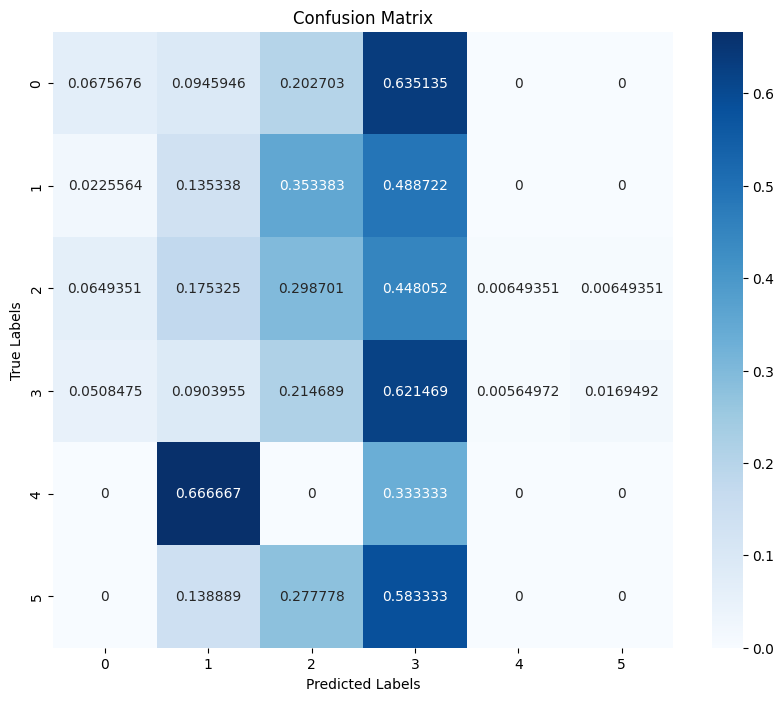

Epoch 13, Validation Loss: 3.4479, Accuracy: 0.3102, F1 Score: 0.2695
Val F1 Score Per Class  [0.0990099  0.17307692 0.29677419 0.44897959 0.         0.        ]


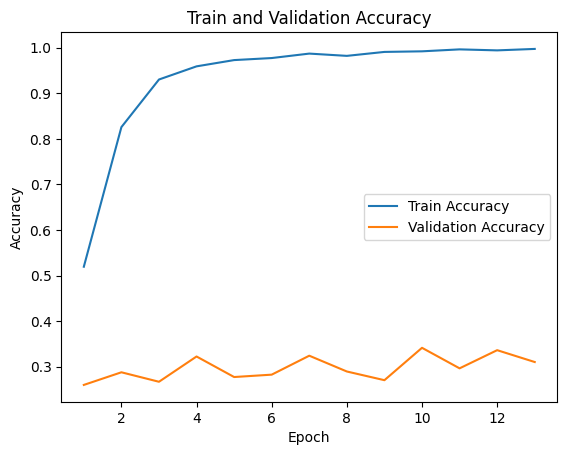

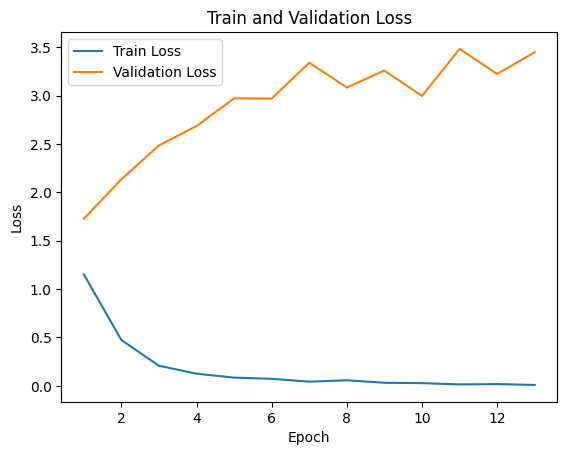

Epoch 14, Train Loss: 0.0019, Accuracy: 0.9995, F1 Score: 0.9995
Train F1 Score Per Class  [1.         0.99850165 0.99848622 1.         1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.45it/s, loss=3.84]

[tensor([-0.4659, -1.1865, -1.7812,  1.3339, -6.1699, -3.3975], device='cuda:0'), tensor([-0.0748, -2.5837, -1.2691,  4.6440, -3.0676, -3.1272], device='cuda:0'), tensor([-4.2328,  0.5821, -1.0932,  2.7071, -4.7971, -4.6716], device='cuda:0'), tensor([-1.8508, -2.2943,  6.0138, -2.0835, -5.1030, -2.3201], device='cuda:0'), tensor([-0.1328, -4.3061,  4.0639,  0.9055, -3.5914, -3.1437], device='cuda:0'), tensor([-0.8006, -1.2441,  1.4710, -1.4887, -4.9176, -4.5211], device='cuda:0'), tensor([-4.3291,  2.5547, -0.0304,  0.7467, -3.2696, -1.9297], device='cuda:0'), tensor([-0.5287, -2.3442, -0.7204,  5.6264, -4.8096, -4.6919], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.44it/s, loss=4.4]

[tensor([-3.0754,  1.9026, -2.1560,  2.4060, -3.2033, -3.1860], device='cuda:0'), tensor([-2.8179, -2.5518,  0.1745,  1.8744, -4.5940, -3.9364], device='cuda:0'), tensor([-0.8077, -3.7189, -1.6627,  3.6426, -2.9650, -2.6978], device='cuda:0'), tensor([-3.3317, -2.2911, -1.7840,  4.1685, -2.3210, -2.7011], device='cuda:0'), tensor([-1.6798,  0.1286, -2.5442,  6.4842, -4.1087, -3.0759], device='cuda:0'), tensor([-2.5695,  2.4756, -3.0986,  0.9759, -3.9193, -3.8417], device='cuda:0'), tensor([-3.1970, -0.9494, -1.5856,  5.3895, -4.6425, -2.3828], device='cuda:0'), tensor([-0.6343, -2.2353, -3.8685,  4.5411, -3.5194, -2.6140], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.39it/s, loss=2.1]

[tensor([-2.3681, -0.9874, -2.1293,  1.8907, -4.1268, -4.2347], device='cuda:0'), tensor([-3.6010, -1.7062,  1.8764,  1.4809, -2.6450, -4.1904], device='cuda:0'), tensor([-1.9973,  4.9175, -0.6059, -3.2875, -2.5152, -2.8489], device='cuda:0'), tensor([-2.2066, -0.4240,  0.9568, -2.1682, -4.1527, -3.7516], device='cuda:0'), tensor([ 2.8431,  0.4783, -3.3425, -0.0747, -3.9139, -2.5045], device='cuda:0'), tensor([-1.3925, -0.9550,  7.0419, -2.6363, -3.8814, -3.0300], device='cuda:0'), tensor([-2.5713, -1.6665, -2.2792,  1.5127, -4.2839, -1.9939], device='cuda:0'), tensor([-1.2688, -1.2578,  2.0535,  1.9794, -4.5874, -4.7912], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.39it/s, loss=4.28]

[tensor([ 5.4360, -0.4735, -2.0924, -1.5415, -2.1091, -2.6724], device='cuda:0'), tensor([-2.0821, -2.7843, -1.3484,  6.5859, -2.7466, -3.2725], device='cuda:0'), tensor([-3.0647, -1.8773,  6.3726, -0.5008, -4.1123, -3.1796], device='cuda:0'), tensor([-1.6858,  3.3580, -2.5846,  0.4649, -4.4332, -2.3454], device='cuda:0'), tensor([-1.0246, -1.4040,  7.3534, -2.5780, -3.4497, -1.8798], device='cuda:0'), tensor([-1.3581, -2.2892, -1.8103, -0.3878, -4.9260, -3.1911], device='cuda:0'), tensor([-2.7430, -3.7034,  1.0539,  3.7176, -3.7937, -1.9495], device='cuda:0'), tensor([-0.4962, -1.8811, -1.4160,  4.5590, -3.9253, -4.6009], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=5.64]

[tensor([-3.3558,  3.4183, -0.5242, -2.8594, -4.9661, -3.2825], device='cuda:0'), tensor([-2.2310, -2.9525, -0.1632,  0.5844, -3.7907, -1.4995], device='cuda:0'), tensor([-3.6068,  0.0792,  0.5442, -0.7738, -4.7912, -3.7710], device='cuda:0'), tensor([-1.6738, -1.6282,  7.5968, -2.1313, -3.1329, -2.5777], device='cuda:0'), tensor([-3.2973, -1.8990,  3.5488, -0.8647, -4.4918, -2.1874], device='cuda:0'), tensor([-2.9724e+00, -7.3819e-01,  2.9373e-03,  4.6176e+00, -4.5611e+00,
        -3.2757e+00], device='cuda:0'), tensor([-3.2336, -1.4516,  3.2149, -1.1916, -5.1653, -3.5990], device='cuda:0'), tensor([-3.5413,  0.4730,  5.0770, -1.7370, -4.0952, -4.4855], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.40it/s, loss=5.04]

[tensor([-2.6507,  0.2209, -2.9192,  3.0045, -4.2466, -3.9872], device='cuda:0'), tensor([-1.5949, -0.8876, -3.1002,  2.0758, -3.8892, -2.0818], device='cuda:0'), tensor([-3.5983,  3.6133, -0.4212, -0.7616, -4.5049, -2.0968], device='cuda:0'), tensor([-2.0552, -1.1352, -0.2044,  0.1182, -5.3113, -4.1846], device='cuda:0'), tensor([-1.0559, -0.3512,  0.1446,  1.1851, -5.3100, -2.9187], device='cuda:0'), tensor([-3.4262, -0.6415,  6.7751, -2.2663, -3.6541, -3.4992], device='cuda:0'), tensor([-2.8766,  6.7832, -1.0882, -2.5907, -3.1289, -2.3159], device='cuda:0'), tensor([-2.3872,  5.3582, -1.5617, -1.3222, -3.5650, -2.7218], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.41it/s, loss=1.92]

[tensor([-2.1594, -2.3060,  5.9631, -1.9649, -4.5090, -3.4870], device='cuda:0'), tensor([-1.9534, -1.7307,  7.4886, -1.7963, -3.5138, -2.5743], device='cuda:0'), tensor([-0.0323, -2.7918, -1.3317,  5.0776, -3.8816, -1.7366], device='cuda:0'), tensor([-0.8154, -1.4578, -1.4736,  1.1932, -4.8321, -2.4982], device='cuda:0'), tensor([-3.0770,  1.9567,  1.6398,  1.3822, -5.2353, -4.4305], device='cuda:0'), tensor([-3.0333, -1.1370, -2.1115,  4.4560, -3.6652, -1.3730], device='cuda:0'), tensor([-3.4068,  0.7247, -2.9062,  1.1984, -3.7730, -2.5920], device='cuda:0'), tensor([-1.1671, -1.9290,  7.4907, -2.1122, -2.6049, -2.1419], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.40it/s, loss=3.92]

[tensor([-2.2784,  3.0189, -1.8177, -0.0443, -2.0583, -3.4505], device='cuda:0'), tensor([-2.6289, -0.5707, -2.4362, -0.3465, -2.9724, -1.6575], device='cuda:0'), tensor([ 5.3963, -1.3771, -2.8424, -1.2795, -3.3534, -1.7600], device='cuda:0'), tensor([-1.9244, -1.2373, -0.9352,  5.6350, -5.4625, -4.2600], device='cuda:0'), tensor([-3.7412,  4.4930, -1.9050,  0.2622, -3.8773, -2.9584], device='cuda:0'), tensor([-2.0666, -3.1345, -1.9919,  6.0438, -3.6395, -2.5977], device='cuda:0'), tensor([-1.4273, -3.5037,  1.2899,  0.5505, -4.4036, -2.9266], device='cuda:0'), tensor([-3.6444, -0.8019, -2.4682,  5.8021, -3.9371, -3.0627], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=3.87]

[tensor([-2.8590,  6.1810, -1.1833, -1.0237, -4.5167, -2.9709], device='cuda:0'), tensor([-2.6943, -1.9275, -1.0258,  5.6535, -4.6722, -3.0847], device='cuda:0'), tensor([ 4.1955, -3.5480, -1.6760,  3.2688, -4.2760, -2.7798], device='cuda:0'), tensor([-2.7433, -1.7532, -2.3370,  6.6722, -4.2850, -3.2163], device='cuda:0'), tensor([-2.8208, -1.9278,  0.2895,  0.8932, -5.0926, -3.6995], device='cuda:0'), tensor([-2.1843, -0.9056, -2.4303,  1.5266, -4.7295, -3.7442], device='cuda:0'), tensor([-4.4272, -0.4757,  3.7351, -1.0456, -4.4870, -3.6100], device='cuda:0'), tensor([-3.9931, -1.9186,  3.6663, -0.2103, -5.0669, -3.0695], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=4.63]

[tensor([-2.0040, -1.4851, -2.1769,  2.2038, -4.9243, -5.0444], device='cuda:0'), tensor([-2.3142, -2.3101, -1.6941,  6.7238, -3.3645, -2.8112], device='cuda:0'), tensor([-2.8005,  0.5403,  1.5966, -1.3016, -4.3893, -4.4616], device='cuda:0'), tensor([-3.2168, -0.2384,  3.2253, -2.4193, -3.4878, -3.9213], device='cuda:0'), tensor([-2.1845,  3.9098,  2.1753, -2.9875, -4.0641, -4.0345], device='cuda:0'), tensor([-3.5442, -0.1025, -1.6982,  0.0205, -4.5147, -3.7213], device='cuda:0'), tensor([ 1.4898,  0.2428, -1.4377,  1.0473, -5.0551, -4.9792], device='cuda:0'), tensor([-3.0013, -0.8037, -1.8996,  2.1446, -4.4336, -4.0450], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.39it/s, loss=3.16]

[tensor([-2.4648,  5.1174, -1.8529, -0.5657, -3.2332, -3.7080], device='cuda:0'), tensor([-3.0478, -1.8716, -1.7304,  3.4908, -3.6703, -2.9453], device='cuda:0'), tensor([-4.2275,  2.1296, -1.5438, -0.0862, -4.8492, -3.4279], device='cuda:0'), tensor([-2.7031, -2.4125,  2.2172,  1.5562, -4.0945, -3.0927], device='cuda:0'), tensor([-2.6011, -1.7758,  4.8692,  0.4979, -5.0898, -3.3813], device='cuda:0'), tensor([-2.4705, -1.9751, -2.1177,  7.1699, -3.6361, -2.2705], device='cuda:0'), tensor([-1.8339, -0.2437,  0.5687, -1.7856, -5.3847, -3.9253], device='cuda:0'), tensor([ 1.6577, -2.0913, -0.7977,  1.9651, -4.9770, -2.9506], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.40it/s, loss=2.94]

[tensor([-1.7392,  0.9978, -1.5043, -1.7408, -4.4688, -4.7839], device='cuda:0'), tensor([-1.8236, -1.1537,  6.1481, -1.6775, -4.3620, -3.8651], device='cuda:0'), tensor([-2.2214, -2.3054, -1.2948,  5.7563, -4.4915, -3.3005], device='cuda:0'), tensor([-2.1789, -1.6064, -1.9859,  5.3409, -5.3163, -2.5961], device='cuda:0'), tensor([-1.1071,  1.8851, -1.9471, -1.1841, -4.8508, -4.3409], device='cuda:0'), tensor([-2.4785,  0.2646, -2.0444, -1.2485, -4.2364, -3.9850], device='cuda:0'), tensor([-2.9335, -1.2326,  5.0331, -1.1529, -3.9294, -2.8025], device='cuda:0'), tensor([-0.5585, -1.5208,  0.0514, -0.3993, -5.2986, -3.2969], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=3.38]

[tensor([-2.8389, -1.7737, -2.2616,  3.8297, -2.8208, -1.2065], device='cuda:0'), tensor([-2.2631, -1.1788, -1.0016,  4.1319, -4.7601, -4.1908], device='cuda:0'), tensor([-1.7998,  3.8189, -4.4359,  0.5344, -3.8279, -2.5755], device='cuda:0'), tensor([-2.7363, -1.8329,  6.8349, -0.9614, -3.9980, -3.0827], device='cuda:0'), tensor([-2.7209, -2.1461, -1.3272,  4.7539, -5.0301, -3.3873], device='cuda:0'), tensor([ 0.3738, -2.4758, -2.5844, -0.3259, -4.0400, -4.4173], device='cuda:0'), tensor([-3.4417,  3.3448, -1.7020, -1.1409, -4.1946, -3.4948], device='cuda:0'), tensor([-2.2992,  5.9310, -2.0213, -0.3461, -3.8529, -3.3575], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.40it/s, loss=2.37]

[tensor([-1.7203, -0.1742,  6.6385, -3.0988, -2.3486, -2.8030], device='cuda:0'), tensor([-1.6512, -0.7304, -1.8980, -0.5253, -4.8179, -5.1214], device='cuda:0'), tensor([ 0.4480, -1.2455, -1.4540,  1.0375, -5.3591, -4.8233], device='cuda:0'), tensor([-1.8081, -2.0201,  4.0762, -1.0994, -4.6374, -4.0510], device='cuda:0'), tensor([-2.3639,  5.7778, -1.8854, -0.7994, -3.9166, -4.1556], device='cuda:0'), tensor([-2.7510,  0.1597, -0.1467,  2.8509, -4.0672, -3.6517], device='cuda:0'), tensor([-2.2073, -0.1461, -0.2856, -0.9075, -4.7103, -4.2118], device='cuda:0'), tensor([-1.4648, -1.5716, -2.0049,  1.3254, -4.6567, -4.2169], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.40it/s, loss=2.48]

[tensor([-3.0055, -1.7483, -1.3599, -0.6126, -4.5329, -4.8626], device='cuda:0'), tensor([-3.6717, -2.4861, -1.5445,  2.7151, -4.3663, -2.3555], device='cuda:0'), tensor([-1.1664, -3.3821, -1.1488,  1.1480, -1.0890, -2.9752], device='cuda:0'), tensor([-1.1454,  1.0603,  1.4215, -2.9306, -4.4114, -3.6255], device='cuda:0'), tensor([-2.3887, -1.4455,  6.0793, -1.7075, -3.7061, -3.1083], device='cuda:0'), tensor([ 0.1066, -3.9871, -0.4364,  4.9918, -5.0470, -3.7071], device='cuda:0'), tensor([-2.7976,  0.1455, -3.4728,  3.7245, -3.1780, -2.1357], device='cuda:0'), tensor([-3.7511, -0.2224, -0.5109,  3.4597, -4.8294, -4.0802], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.40it/s, loss=3.37]

[tensor([ 0.5790, -0.9328, -1.3007,  3.6418, -4.5844, -4.8658], device='cuda:0'), tensor([-4.5451, -0.5066, -1.9830,  1.3866, -4.8467, -3.6076], device='cuda:0'), tensor([-3.9058, -0.8973,  0.4109, -1.1045, -4.7780,  1.2993], device='cuda:0'), tensor([-3.5692, -1.4323,  2.5194,  2.7662, -5.4088, -3.2890], device='cuda:0'), tensor([ 6.5590, -1.3733,  0.0663, -1.1322, -3.8165, -3.1129], device='cuda:0'), tensor([-0.8955,  1.1810, -2.1321,  0.5475, -4.6008, -3.9531], device='cuda:0'), tensor([-2.7432, -0.4660, -1.1619, -2.0046, -4.2386, -3.5989], device='cuda:0'), tensor([ 4.5874, -1.2606, -3.6986, -0.9932, -3.0540, -0.8932], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.40it/s, loss=3.71]

[tensor([-2.2937,  3.3402, -0.4800, -1.5982, -3.4972, -3.5688], device='cuda:0'), tensor([-1.2280, -1.3826, -1.6021,  4.9080, -5.5108, -5.0560], device='cuda:0'), tensor([-4.1155,  1.9052, -1.4052,  1.2325, -4.4427,  0.2785], device='cuda:0'), tensor([-2.5742, -0.4138,  3.3706, -1.9659, -4.0918, -3.2328], device='cuda:0'), tensor([ 7.3856, -2.0553, -0.4633, -0.6743, -3.3952, -3.0799], device='cuda:0'), tensor([-1.3335,  3.0749, -1.1498, -0.7139, -5.0071, -5.4530], device='cuda:0'), tensor([-1.6402, -3.0562,  6.6198, -0.3856, -3.8072, -2.5764], device='cuda:0'), tensor([-2.4949, -2.2080, -0.2487,  2.3335, -4.3895, -3.3400], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.39it/s, loss=2.73]

[tensor([-1.9279,  2.5486, -2.3637, -0.0258, -3.3501, -3.2325], device='cuda:0'), tensor([-2.9123, -2.2112,  0.6417,  1.9462, -2.9467, -3.3989], device='cuda:0'), tensor([-3.3664,  1.8122, -1.3500,  0.5301, -4.4070, -3.8917], device='cuda:0'), tensor([-2.4654, -2.7213, -1.3527,  6.9473, -2.9095, -2.3365], device='cuda:0'), tensor([-3.1678,  2.3584, -2.7239,  0.0363, -3.9098, -1.7088], device='cuda:0'), tensor([ 4.7221, -2.1365, -1.5897, -0.5224, -5.6654, -3.1753], device='cuda:0'), tensor([-1.3711, -1.5270, -0.9262,  0.8648, -4.6190, -3.4767], device='cuda:0'), tensor([-1.3860, -2.0668,  3.6706, -2.0745, -5.0462, -3.0567], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=3.21]

[tensor([-4.2343, -1.6329, -1.1462,  1.6531, -3.8961, -3.2574], device='cuda:0'), tensor([-2.6211, -0.5853,  2.3394, -0.1507, -3.7865, -3.7028], device='cuda:0'), tensor([-1.1753, -3.0401,  3.0465, -2.0282, -3.2035, -1.4888], device='cuda:0'), tensor([-3.1247,  0.7833, -0.1165,  2.2946, -2.4093, -4.5787], device='cuda:0'), tensor([-4.0081,  4.7254,  0.3808, -0.9742, -3.4859, -2.4535], device='cuda:0'), tensor([-1.9450,  1.3299, -2.7362, -0.1865, -4.0362, -3.5363], device='cuda:0'), tensor([-1.8108, -2.4806, -1.5116,  6.9343, -4.0011, -2.4820], device='cuda:0'), tensor([-0.9687, -0.7518, -2.4859,  1.1216, -4.1728, -4.5201], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.40it/s, loss=1.92]

[tensor([-4.6361,  1.8080, -1.1128, -0.7707, -4.3082, -2.1888], device='cuda:0'), tensor([-2.1319, -2.2689,  1.3636,  0.6579, -5.8158, -3.8236], device='cuda:0'), tensor([-2.6803, -1.9446,  1.0280, -0.1320, -4.8450, -4.1706], device='cuda:0'), tensor([-2.9856,  0.9852,  2.5701, -1.9330, -4.8190, -3.5446], device='cuda:0'), tensor([-4.0745, -0.1170, -2.1752,  0.8972, -4.4752, -5.1325], device='cuda:0'), tensor([-3.9523, -0.5523,  1.8322,  0.2215, -4.7378, -3.1435], device='cuda:0'), tensor([-1.7968,  1.5613, -0.4560,  0.5637, -3.8431, -3.5119], device='cuda:0'), tensor([-2.4577,  6.2560, -1.8279, -0.7589, -2.6550, -3.1371], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.39it/s, loss=6.63]

[tensor([-1.7143, -2.0999,  7.1754, -2.3834, -3.1935, -1.9367], device='cuda:0'), tensor([-1.8422,  4.3922, -0.6623, -0.9335, -4.6626, -3.7418], device='cuda:0'), tensor([-3.2436, -0.3952, -3.1606,  5.0128, -4.0279, -4.9364], device='cuda:0'), tensor([-2.5915,  0.7499, -3.4654,  4.5837, -4.7547, -3.1086], device='cuda:0'), tensor([-2.5219,  6.2842, -2.1563, -2.1310, -2.6217, -1.4667], device='cuda:0'), tensor([-1.8771, -3.3615, -1.1813,  0.0841, -4.2895, -2.9117], device='cuda:0'), tensor([-1.6205,  6.4332, -1.3614, -2.3908, -3.4359, -2.2923], device='cuda:0'), tensor([-0.1902, -1.9350, -0.1250,  2.8525, -5.0668, -4.9522], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.40it/s, loss=3.34]

[tensor([-0.0972, -2.3562,  2.4498, -1.2791, -4.4015, -3.8302], device='cuda:0'), tensor([-1.5963, -2.1676,  5.5685, -2.2931, -3.2768, -3.8419], device='cuda:0'), tensor([-2.0926,  0.0728,  6.7766, -1.9788, -4.7172, -3.4872], device='cuda:0'), tensor([-2.4702, -1.2537,  0.3181,  2.3733, -4.0714, -3.7650], device='cuda:0'), tensor([-2.5808, -0.8788, -2.1872,  0.9419, -4.5665, -3.9572], device='cuda:0'), tensor([ 2.0179, -2.2617,  0.7467, -1.0535, -4.6246, -3.9252], device='cuda:0'), tensor([-1.6131, -2.0648,  2.9976,  1.7225, -6.2290, -3.6682], device='cuda:0'), tensor([-1.2269, -2.2934,  6.7849, -1.7071, -4.1252, -3.2925], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.40it/s, loss=3.34]

[tensor([-2.0794, -2.7946, -2.6145, -1.5283, -3.1866, -3.7217], device='cuda:0'), tensor([-0.7485, -0.3117,  2.9757, -2.9347, -4.5426, -4.2925], device='cuda:0'), tensor([-2.3897, -0.9937, -2.1596,  5.5448, -4.7154, -3.6820], device='cuda:0'), tensor([-2.2758,  5.9093, -0.9359, -1.5680, -3.0985, -2.4410], device='cuda:0'), tensor([-2.5730, -2.0787, -1.3211, -0.8633, -5.6649, -3.8742], device='cuda:0'), tensor([-4.0216,  4.6969,  0.7514, -0.5949, -4.1852, -3.7970], device='cuda:0'), tensor([-2.1818, -3.0344,  0.2118,  1.6335, -4.4217, -2.0508], device='cuda:0'), tensor([-3.8358,  4.5660, -1.5589, -1.1398, -4.7911, -1.1818], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=4.07]

[tensor([-2.2718, -2.1317,  6.8434, -0.0942, -3.8038, -3.7473], device='cuda:0'), tensor([-2.6595, -1.3787, -0.0990,  2.3458, -4.8957, -3.6686], device='cuda:0'), tensor([-4.0383,  2.5885, -2.6710,  0.7410, -5.5583, -3.6140], device='cuda:0'), tensor([-1.0299, -3.8988, -0.8004,  0.5713, -4.4486, -1.6645], device='cuda:0'), tensor([-0.2719, -2.6168, -2.9288,  5.7698, -3.9139, -2.9007], device='cuda:0'), tensor([-2.6063, -1.9182, -1.3040,  1.3977, -4.7683, -3.4234], device='cuda:0'), tensor([-1.3396,  1.8312, -2.9185, -1.6652, -2.6353, -0.1834], device='cuda:0'), tensor([-2.0449, -2.8462,  1.0049, -0.4106, -5.3894, -4.1696], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.40it/s, loss=3.64]

[tensor([-3.0230, -1.3446,  6.6732, -1.9570, -3.6213, -2.9574], device='cuda:0'), tensor([-2.4026, -1.2201,  4.6009, -1.8375, -3.1499, -3.4683], device='cuda:0'), tensor([-4.0190, -0.6588, -0.5720,  0.6558, -4.3178, -3.5062], device='cuda:0'), tensor([-3.3720,  1.7255, -1.3711,  1.3230, -4.0662, -3.8620], device='cuda:0'), tensor([-2.8937,  5.0800, -2.6830, -1.0793, -3.3699, -2.5383], device='cuda:0'), tensor([-3.3553, -2.3142,  1.3915, -0.0595, -2.9999, -3.0588], device='cuda:0'), tensor([-1.1146, -1.3341, -3.8495,  3.5894, -4.2600, -3.2255], device='cuda:0'), tensor([ 1.5192, -0.2917, -2.6514, -0.9264, -2.9492, -3.5057], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=1.88]

[tensor([-1.9784, -2.1232, -1.1951,  6.1694, -4.6582, -3.2401], device='cuda:0'), tensor([-3.6916, -2.9713, -0.1528,  1.8412, -5.0983, -3.0677], device='cuda:0'), tensor([-3.3273, -1.7328,  5.5066, -1.0355, -3.4679, -3.3814], device='cuda:0'), tensor([ 6.1905, -1.9113, -1.6053, -0.4968, -3.3536, -2.3356], device='cuda:0'), tensor([-2.8896,  2.7116, -1.5842,  3.4670, -5.3688, -3.7068], device='cuda:0'), tensor([ 0.7559, -2.3910,  3.2081,  0.3753, -4.3156, -3.4242], device='cuda:0'), tensor([-0.8579,  2.7721, -1.9330,  0.2018, -3.5397, -4.5722], device='cuda:0'), tensor([-3.1196, -0.0306, -0.5042, -2.1250, -5.0070, -2.3476], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=3.08]

[tensor([-3.5997, -1.3647,  0.3000,  2.9191, -4.8157, -3.6399], device='cuda:0'), tensor([-3.0138, -0.3200, -1.7065,  0.8299, -4.1005, -3.9298], device='cuda:0'), tensor([-2.0308, -0.9225, -2.4133,  2.2359, -4.1992, -3.8644], device='cuda:0'), tensor([-2.9682, -1.5363,  6.8018, -1.1162, -3.9824, -2.4749], device='cuda:0'), tensor([-2.8174,  5.0704, -1.1010, -1.2702, -3.7164, -2.9853], device='cuda:0'), tensor([-1.3287, -0.4383, -0.4823, -0.2944, -5.0200, -4.1857], device='cuda:0'), tensor([-2.7854, -3.3162,  3.3503, -0.5640, -4.2388, -2.6273], device='cuda:0'), tensor([-1.5174,  0.7997, -2.7832,  3.1384, -5.5538, -3.6278], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=3.79]

[tensor([-0.0580, -2.1295, -2.0041,  5.5894, -4.2687, -3.7775], device='cuda:0'), tensor([-2.5196, -1.2353, -2.7970,  5.8705, -3.5826, -3.3287], device='cuda:0'), tensor([-1.6826,  1.3517,  0.4531, -2.7247, -4.4235, -3.1952], device='cuda:0'), tensor([-3.3191, -1.9228,  2.6056,  1.9423, -4.3319, -3.9867], device='cuda:0'), tensor([-2.7714, -2.4182, -1.5593,  4.5160, -4.3125, -3.4969], device='cuda:0'), tensor([-3.7162,  4.0496,  1.5020,  0.8239, -5.2944, -4.5999], device='cuda:0'), tensor([-3.2315, -1.5426,  3.6089, -0.2296, -5.0547, -3.9349], device='cuda:0'), tensor([-3.4298,  3.3106,  1.7330, -2.1947, -4.4976, -4.5240], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.39it/s, loss=4.12]

[tensor([-3.6781,  0.1370, -1.3117,  5.2575, -3.9815, -2.6377], device='cuda:0'), tensor([-3.7281,  1.3705, -1.1137, -0.7691, -3.9130, -1.8929], device='cuda:0'), tensor([-4.1913, -2.8063,  3.4419,  0.4162, -4.4876, -2.9618], device='cuda:0'), tensor([-3.0168,  4.5713, -1.5220, -0.3003, -3.4526, -3.8895], device='cuda:0'), tensor([ 1.5552,  1.0567,  1.4243, -2.1736, -6.0375, -3.9691], device='cuda:0'), tensor([-3.7282e+00,  2.9706e-03,  2.6237e+00, -1.7933e+00, -4.1770e+00,
        -2.2862e+00], device='cuda:0'), tensor([-4.1335, -0.8509, -0.6804,  3.0042, -3.4144, -3.0556], device='cuda:0'), tensor([-3.1587, -0.7787, -1.2352,  5.6882, -4.8137, -3.6625], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.40it/s, loss=4.85]

[tensor([-4.3218,  4.6225, -1.0450,  0.1938, -4.4553, -2.9912], device='cuda:0'), tensor([-3.5961, -1.5817, -1.3195,  5.6756, -3.7944, -3.8538], device='cuda:0'), tensor([-1.6596,  0.3530, -2.4932, -2.4310, -3.3137, -2.4254], device='cuda:0'), tensor([-2.0929, -2.3466, -1.6413,  7.0201, -4.2921, -2.9320], device='cuda:0'), tensor([-3.4875,  0.3992, -2.3997, -2.4139, -5.6969, -2.8510], device='cuda:0'), tensor([-1.5321, -2.5406,  5.3715, -1.4734, -3.5001, -2.2017], device='cuda:0'), tensor([-1.8050, -3.4163,  0.8435,  2.2177, -5.5735, -4.8100], device='cuda:0'), tensor([-0.9473, -1.8356, -0.2951, -1.8632, -2.8166,  7.7977], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.40it/s, loss=3.21]

[tensor([-2.9067,  0.4265, -3.4783,  3.9380, -3.7466, -2.7609], device='cuda:0'), tensor([-2.3468, -1.8477, -2.5381,  6.8076, -4.1596, -2.4818], device='cuda:0'), tensor([-4.2451,  2.0150, -0.2642, -0.7547, -4.6594, -1.3023], device='cuda:0'), tensor([-1.9921,  6.3690, -2.3352, -1.1690, -3.8065, -3.0227], device='cuda:0'), tensor([-3.5687,  3.2809,  0.9502, -2.3826, -3.8907, -2.9168], device='cuda:0'), tensor([ 7.4196, -1.0497, -1.6933, -1.8382, -2.3353, -1.2177], device='cuda:0'), tensor([-2.2198, -3.0343,  0.7401,  4.5824, -4.3101, -4.0234], device='cuda:0'), tensor([-2.2710, -1.3297,  3.1420,  2.0322, -5.0879, -4.5350], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.40it/s, loss=5.98]

[tensor([-2.5328, -0.5986, -3.3960, -0.3218, -3.2642, -2.5950], device='cuda:0'), tensor([-2.3174, -1.3680, -2.3959,  7.0597, -3.7067, -2.8278], device='cuda:0'), tensor([-1.7579,  6.9038, -1.9909, -1.4984, -2.3198, -2.8310], device='cuda:0'), tensor([-3.4215,  3.1876, -2.1999, -1.4914,  2.1826, -1.2091], device='cuda:0'), tensor([-2.1899,  3.2500, -1.4431, -0.6748, -2.3860, -3.4754], device='cuda:0'), tensor([-2.2065, -2.3188, -0.7685,  0.6065, -5.0045, -3.6215], device='cuda:0'), tensor([ 5.0950, -2.3871, -1.5754,  0.1878, -4.5059, -3.1803], device='cuda:0'), tensor([ 6.8312, -1.9353, -1.2257, -0.4289, -3.7213, -3.4738], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.40it/s, loss=5]

[tensor([-4.3922, -2.2792, -0.6243,  4.5699, -3.4714, -2.0398], device='cuda:0'), tensor([-3.3804,  4.3198, -1.8889,  1.7760, -4.1728, -2.6852], device='cuda:0'), tensor([-2.0481, -3.1754, -1.0649,  5.6053, -5.0047, -2.9136], device='cuda:0'), tensor([-2.3374,  0.2925,  3.9236, -3.2444, -3.9672, -3.7893], device='cuda:0'), tensor([-2.5355, -1.5586,  7.1011, -1.9643, -3.1285, -2.7092], device='cuda:0'), tensor([-3.3995, -2.8524,  0.5249,  3.3175, -4.1842, -2.9130], device='cuda:0'), tensor([-2.0213,  1.2475,  0.2896, -1.4536, -5.6876, -3.6403], device='cuda:0'), tensor([-3.3318,  0.3551, -2.3007,  3.3398, -3.8149, -3.3292], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.40it/s, loss=4.33]

[tensor([ 6.3923, -0.1100, -2.8093, -1.3917, -2.8679, -2.8339], device='cuda:0'), tensor([-2.3866, -2.3053, -0.1290,  2.4632, -5.7805, -4.6216], device='cuda:0'), tensor([-3.0714,  1.8025, -2.1198,  0.7336, -0.7134, -3.2528], device='cuda:0'), tensor([-3.4055, -3.5414, -1.0499,  4.5328, -4.4251, -1.9531], device='cuda:0'), tensor([-3.6788,  2.2889, -1.9718,  2.0281, -4.0419, -3.5554], device='cuda:0'), tensor([-3.2881,  0.2601,  0.1022, -0.0638, -5.1429, -2.9990], device='cuda:0'), tensor([-1.4255, -2.5980, -1.9821,  5.6994, -3.7691, -3.6939], device='cuda:0'), tensor([-1.7506, -1.5032,  7.0275, -2.2588, -3.8479, -3.0652], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.41it/s, loss=3.41]

[tensor([-2.9864, -1.0038,  1.4596, -1.6538, -5.7852, -3.5345], device='cuda:0'), tensor([-2.2855,  4.6149, -1.0626, -1.8206, -3.9994, -3.3553], device='cuda:0'), tensor([-2.1552, -3.1575,  4.2987, -1.4216, -4.2507, -2.7751], device='cuda:0'), tensor([-1.9991, -1.5023,  6.9822, -1.3323, -3.6155, -3.2747], device='cuda:0'), tensor([-3.5523,  3.3710, -1.1165,  0.9581, -4.5213, -2.6683], device='cuda:0'), tensor([-2.0098, -2.3524, -1.3634,  2.5144, -3.9696, -1.2496], device='cuda:0'), tensor([-2.5097, -2.1998,  6.9446, -0.8633, -3.4755, -2.8188], device='cuda:0'), tensor([-2.1582,  0.1806, -1.0704,  3.5383, -4.2277, -4.1912], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.40it/s, loss=4.11]

[tensor([-2.5952, -0.3718,  5.0230, -2.9879, -3.3261, -2.8869], device='cuda:0'), tensor([-2.0202, -1.2456,  6.3081, -1.9296, -2.7016, -3.6122], device='cuda:0'), tensor([-2.1735, -1.9185, -1.9741,  1.6320, -4.6544, -1.4575], device='cuda:0'), tensor([-2.4916,  6.7717, -2.5356, -0.7917, -3.7374, -2.8272], device='cuda:0'), tensor([-2.7628, -2.3154, -0.9154,  0.2725, -4.7477, -3.0274], device='cuda:0'), tensor([-1.9177, -3.0133, -1.2787,  6.1387, -4.3181, -3.6500], device='cuda:0'), tensor([-2.2591, -2.4491, -1.8171,  5.3383, -4.6734, -4.3793], device='cuda:0'), tensor([-2.3720, -0.3244, -1.7710,  4.1309, -4.2244, -3.9949], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.39it/s, loss=5.8]

[tensor([-1.0773, -2.5587, -2.1784,  3.9635, -3.7851, -2.8265], device='cuda:0'), tensor([-2.8544, -1.1036,  6.4966, -1.0559, -4.2658, -3.4682], device='cuda:0'), tensor([-2.1488, -1.6072, -2.6582,  2.8036, -4.1002, -3.3123], device='cuda:0'), tensor([-3.4281,  6.1288, -1.8579, -1.6860, -3.0268,  0.2083], device='cuda:0'), tensor([-2.3495,  1.4675,  4.5233, -2.6587, -4.1207, -2.6170], device='cuda:0'), tensor([-2.8981,  6.3788, -1.2404, -1.1081, -3.2505, -3.0034], device='cuda:0'), tensor([-1.8118,  3.0872, -2.3452,  1.2381, -3.9907, -4.3767], device='cuda:0'), tensor([-3.2507,  0.8143, -1.0042,  2.7919, -4.4169, -4.3854], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.39it/s, loss=3.75]

[tensor([-1.6862, -0.6492,  0.9410, -1.2167, -4.1830, -2.0514], device='cuda:0'), tensor([-2.8387,  1.2283, -1.3520,  1.0301, -5.2320, -1.5759], device='cuda:0'), tensor([-2.0171, -1.6128, -1.4040,  3.8980, -4.9785, -3.7036], device='cuda:0'), tensor([-3.4648,  1.1627, -3.3059,  0.4142, -3.2296, -2.8693], device='cuda:0'), tensor([-3.1034,  0.1358,  3.9791, -2.0590, -4.4500, -5.0910], device='cuda:0'), tensor([-1.4361,  5.6837, -2.2907, -0.7672, -2.8212, -2.7954], device='cuda:0'), tensor([-2.7302,  0.4903,  1.1399, -2.9334, -3.9948, -3.6633], device='cuda:0'), tensor([-2.6738, -2.8093,  5.6024,  0.8849, -4.6917, -3.6373], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.39it/s, loss=4.54]

[tensor([-1.0570, -1.2841,  3.8988, -0.9417, -4.7289, -4.5885], device='cuda:0'), tensor([-2.6835, -0.3938, -1.0051,  4.7666, -4.1488, -4.5483], device='cuda:0'), tensor([-0.1243, -2.0643, -1.7723,  1.8670, -4.3403, -2.6466], device='cuda:0'), tensor([-2.1626, -3.1813, -0.0708, -0.9185, -4.2896, -2.9621], device='cuda:0'), tensor([-2.7131, -2.3528, -1.5686,  4.8742, -5.1728, -4.2666], device='cuda:0'), tensor([-3.0014, -1.1694,  6.8533, -1.6264, -3.4767, -2.8299], device='cuda:0'), tensor([ 1.8260, -2.3247,  1.2913, -1.0451, -4.6399, -3.6966], device='cuda:0'), tensor([-3.9792,  2.3667, -1.3364,  0.0365, -6.1332, -0.3091], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=4.08]

[tensor([ 2.8141, -2.8181, -0.7329,  1.3027, -4.6525, -3.3627], device='cuda:0'), tensor([-0.9338, -1.6632,  4.4006, -2.1510, -3.1557, -3.0082], device='cuda:0'), tensor([-2.8397, -1.3256, -1.5708,  6.1629, -4.6670, -2.5941], device='cuda:0'), tensor([ 4.1384, -1.7472, -3.2915,  2.1587, -3.4774, -3.4538], device='cuda:0'), tensor([-4.1688,  2.0278, -1.5039,  0.6849, -4.3171, -1.2930], device='cuda:0'), tensor([ 2.4066, -0.4806, -2.5464,  1.1322, -2.7368, -4.3656], device='cuda:0'), tensor([-3.2212, -0.8569, -1.7829,  5.6314, -3.4969, -3.5515], device='cuda:0'), tensor([ 0.1479, -0.9854, -2.8970,  3.1152, -4.5632, -0.4658], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.40it/s, loss=2.38]

[tensor([-2.8299, -1.8168,  6.8240, -0.7029, -4.0623, -3.0277], device='cuda:0'), tensor([-3.1489,  0.3794,  1.5103,  2.2292, -2.7802, -4.3664], device='cuda:0'), tensor([-2.7227, -1.2882, -1.7437,  3.3785, -4.2497, -3.1349], device='cuda:0'), tensor([-4.1923,  1.9897, -1.4063,  0.2476, -4.6212, -3.9737], device='cuda:0'), tensor([-2.9966,  1.9988, -1.5566,  0.5651, -4.8412, -4.0296], device='cuda:0'), tensor([-3.4684, -2.5145,  2.6311,  2.5886, -5.1554, -4.1500], device='cuda:0'), tensor([-2.6205, -1.6876, -1.9051, -0.2163, -4.6243, -4.7415], device='cuda:0'), tensor([ 0.2762, -0.4529, -2.0302,  1.1189, -4.8418, -5.4872], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=3.75]

[tensor([-2.2531, -2.5791, -0.7858,  5.2329, -4.2403, -3.6058], device='cuda:0'), tensor([ 6.7182, -1.8863, -0.7547, -0.5078, -3.2412, -2.5977], device='cuda:0'), tensor([-2.1905, -2.4621, -1.9328,  5.4968, -4.2957, -3.2855], device='cuda:0'), tensor([-0.5983,  0.2325, -3.3293,  0.8352, -4.0997, -2.5820], device='cuda:0'), tensor([-3.6307,  0.5604, -1.4238,  1.2555, -2.9604, -3.0720], device='cuda:0'), tensor([-1.5784, -2.9643, -2.1414,  5.1623, -4.5187, -4.1858], device='cuda:0'), tensor([-3.5979, -1.1270, -0.0244,  3.4963, -4.6835, -2.1232], device='cuda:0'), tensor([-0.0293, -0.8840,  1.7946, -1.2556, -4.6154, -4.7315], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.38it/s, loss=2.33]

[tensor([-2.7627, -0.8428, -2.2887,  6.4033, -4.1338, -2.9787], device='cuda:0'), tensor([-3.5337, -0.2896, -0.4349, -1.3997, -4.5168, -4.2653], device='cuda:0'), tensor([ 0.8805, -1.3978, -1.8602,  0.3336, -5.7112, -4.2258], device='cuda:0'), tensor([-2.6078,  3.6648, -2.5776,  1.2662, -5.4495, -2.4671], device='cuda:0'), tensor([-2.6773,  3.2650, -2.2552, -0.9102, -5.2979, -3.6901], device='cuda:0'), tensor([-3.3745,  1.6799,  4.7366, -1.8205, -3.4109, -3.5966], device='cuda:0'), tensor([-2.7985, -1.6592,  2.6404,  0.7641, -4.6116, -3.4186], device='cuda:0'), tensor([-3.3180, -0.9776,  3.9359, -1.6780, -4.6947, -3.0905], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.39it/s, loss=4.43]

[tensor([-2.4807,  0.1809, -2.0870,  4.8698, -3.1126, -4.3341], device='cuda:0'), tensor([-0.0938, -2.4159,  2.1718,  0.8632, -5.7616, -3.8522], device='cuda:0'), tensor([-1.9076,  4.1098, -2.6111,  0.0960, -4.7294, -2.5334], device='cuda:0'), tensor([-1.9349, -1.5690, -1.7623, -1.0785, -1.6209,  8.1619], device='cuda:0'), tensor([-2.4586,  0.7266, -2.5557,  5.6166, -3.9837, -3.6527], device='cuda:0'), tensor([-2.5254,  0.1499, -3.0263,  2.2416, -4.1044, -3.2254], device='cuda:0'), tensor([-1.4491, -2.7338,  4.3761, -1.2720, -5.2741, -3.9179], device='cuda:0'), tensor([-2.6564,  2.0254, -2.2758,  2.1094, -3.8803, -3.8088], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.39it/s, loss=5.73]

[tensor([-2.0086,  1.2184,  1.0103, -2.3070, -5.3464, -1.5762], device='cuda:0'), tensor([-2.7562,  6.7801, -1.1661, -1.7972, -2.8726, -2.6233], device='cuda:0'), tensor([-1.6729,  5.4582, -1.7732, -1.0935, -4.5212, -4.4005], device='cuda:0'), tensor([-1.8265,  7.1222, -2.0765, -1.6200, -3.4992, -2.9329], device='cuda:0'), tensor([-1.8257, -2.9014, -2.1062,  6.5327, -4.4775, -1.9937], device='cuda:0'), tensor([ 0.1490,  0.5548, -2.0887,  1.0978, -4.1598, -2.6544], device='cuda:0'), tensor([ 0.2709,  0.3239, -2.5066, -2.2484,  5.8577, -2.4244], device='cuda:0'), tensor([-4.6501, -0.6183,  3.9782, -0.6680, -4.2913, -3.0464], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=3.98]

[tensor([-2.6417, -0.8852, -0.6611,  3.1996, -4.9675, -4.3336], device='cuda:0'), tensor([-1.6636, -1.8406, -0.7694, -1.1142, -5.7279, -3.7221], device='cuda:0'), tensor([-3.0549,  3.3066, -2.1147, -0.9880, -5.4561, -2.9763], device='cuda:0'), tensor([-2.7711, -2.8291, -1.0709,  2.0906, -5.4241, -4.7446], device='cuda:0'), tensor([-3.9426,  3.2884,  0.4826, -1.2192, -4.4428, -3.6945], device='cuda:0'), tensor([-2.3866, -2.2907, -1.2093, -0.7784, -4.5047, -3.1668], device='cuda:0'), tensor([-1.6147, -2.2807, -2.2481,  6.9564, -3.5304, -2.7115], device='cuda:0'), tensor([-0.5683,  2.9385, -2.5766,  0.4950, -4.9487, -2.9894], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.37it/s, loss=3.25]

[tensor([-2.9300, -1.8498,  0.8670, -1.5195, -3.1310, -1.3119], device='cuda:0'), tensor([-0.9553, -2.3307,  4.4492, -0.3113, -4.3202, -3.6558], device='cuda:0'), tensor([-1.6108, -0.5153,  4.5134, -2.6903, -3.7065, -3.4660], device='cuda:0'), tensor([-1.7635, -1.4877,  6.7869, -2.2312, -3.9328, -2.5302], device='cuda:0'), tensor([-3.8244, -0.5631,  0.7412,  0.0441, -4.0972, -3.5754], device='cuda:0'), tensor([-3.8757, -1.5457,  0.5761,  1.2637, -4.6282, -0.3205], device='cuda:0'), tensor([-3.5975,  0.7781, -0.4012, -1.1913, -3.6056, -2.5478], device='cuda:0'), tensor([-2.4922,  4.9510, -1.8855, -1.0604, -5.4839, -3.5936], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=2.95]

[tensor([-2.6768, -3.2929,  0.6269,  2.3750, -4.4337, -3.6347], device='cuda:0'), tensor([-2.9564,  1.1129, -0.1474,  0.3620, -5.4542, -1.3861], device='cuda:0'), tensor([-0.6434, -2.6562, -1.3238, -1.4427, -5.0540, -1.7885], device='cuda:0'), tensor([-1.9722,  0.8148, -0.7585, -2.8158, -5.0700, -5.3580], device='cuda:0'), tensor([ 1.1170, -2.4469, -2.7932,  3.6269, -4.9563, -2.8081], device='cuda:0'), tensor([-3.3176, -1.9563,  1.8096,  2.0909, -4.5888, -3.5357], device='cuda:0'), tensor([-3.6450, -0.3374, -1.5008,  5.6140, -5.3984, -3.7052], device='cuda:0'), tensor([ 3.4985, -1.9923, -1.7775,  2.0596, -4.3028, -4.1335], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.38it/s, loss=3.42]

[tensor([-1.2943, -0.4690,  6.6554, -2.1543, -4.5203, -3.5622], device='cuda:0'), tensor([-2.9210,  4.9669,  0.1918, -1.0857, -3.9475, -3.9335], device='cuda:0'), tensor([-3.8129, -1.4099,  1.2634,  1.3491, -5.1713, -2.2248], device='cuda:0'), tensor([-2.0003,  0.3760,  0.2333,  0.2653, -4.2036, -2.9003], device='cuda:0'), tensor([-0.1008,  0.4271, -1.1541, -2.7054, -4.2449, -2.7280], device='cuda:0'), tensor([-2.4602, -1.2482,  0.5648,  1.9548, -4.2207, -3.1777], device='cuda:0'), tensor([-2.6025, -1.5087,  2.2891,  0.3574, -4.2802, -4.5722], device='cuda:0'), tensor([-1.5345, -1.9490, -2.3780,  4.5030, -3.4035, -3.0701], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.38it/s, loss=3.11]

[tensor([-1.7448, -1.5479, -0.6585, -1.0741, -5.2662, -4.6152], device='cuda:0'), tensor([-2.8866,  3.4046, -0.3339, -0.9646, -4.2873, -2.4523], device='cuda:0'), tensor([ 3.9483, -1.3063, -1.7807,  1.1042, -5.4286, -3.4173], device='cuda:0'), tensor([-4.3042, -2.1032,  1.0999,  1.7715, -4.4230, -3.1885], device='cuda:0'), tensor([-1.7573, -0.2285, -0.6846,  0.4323, -5.6715, -3.8727], device='cuda:0'), tensor([-2.3026, -2.2964, -0.8151,  6.2617, -4.5375, -2.9816], device='cuda:0'), tensor([-3.9541, -0.3408, -1.5019,  1.7110, -3.9399, -2.8887], device='cuda:0'), tensor([-1.1930, -2.5692, -1.2851,  5.0392, -5.0274, -3.4162], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.38it/s, loss=2.85]

[tensor([-2.6400, -1.2791, -1.9643, -0.4885, -3.6835, -2.7972], device='cuda:0'), tensor([-2.6676, -2.8807,  1.0341,  5.0890, -5.0630, -4.1854], device='cuda:0'), tensor([-2.6402,  4.1549, -1.0029, -1.4639, -4.9473, -4.4930], device='cuda:0'), tensor([-3.2125,  3.5668, -1.2592, -0.7768, -5.2541, -4.6256], device='cuda:0'), tensor([-1.1663, -3.3411,  0.8955,  5.2709, -4.1392, -3.9408], device='cuda:0'), tensor([-3.5527, -1.8396,  1.4232,  5.1794, -5.1507, -4.0514], device='cuda:0'), tensor([-3.4466, -1.3564,  0.3556,  2.6566, -4.4971, -4.1023], device='cuda:0'), tensor([-2.7660, -3.0690, -0.7672,  6.1070, -3.7564, -3.2219], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=3.38]

[tensor([-3.5854,  3.7079, -2.1491,  0.8296, -3.2386, -1.4680], device='cuda:0'), tensor([-1.8946,  1.5813, -1.5585,  1.1992, -5.7078, -4.6963], device='cuda:0'), tensor([-3.2258,  2.1981, -2.2443, -0.4334, -3.3792, -3.7783], device='cuda:0'), tensor([-1.1857, -1.2138, -2.4466,  4.8188, -4.8503, -4.0529], device='cuda:0'), tensor([-3.1913, -1.2625,  4.1092, -0.8945, -4.8164, -4.7574], device='cuda:0'), tensor([-3.4825,  1.5385, -0.9658, -0.3597, -5.1556, -2.9524], device='cuda:0'), tensor([-2.9842,  7.0169, -1.7271, -0.8524, -3.3341, -2.6940], device='cuda:0'), tensor([-2.9179,  0.1622, -2.3487, -0.4434, -4.5275, -3.4111], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.39it/s, loss=1.3]

[tensor([ 1.6436, -1.3486, -1.3183,  0.7147, -4.2934, -2.8231], device='cuda:0'), tensor([-1.3001, -2.3898,  2.4662,  2.9274, -5.8434, -5.0970], device='cuda:0'), tensor([-3.4248, -3.9969,  0.9563, -1.0829, -4.2003, -2.8208], device='cuda:0'), tensor([-4.1860,  0.8542, -1.0207,  0.9046, -5.2104, -3.6526], device='cuda:0'), tensor([-1.3604, -2.9716, -1.5317,  2.4492, -5.6554, -4.4376], device='cuda:0'), tensor([-3.1599,  0.8166, -2.0776,  2.4353, -5.2903, -4.3263], device='cuda:0'), tensor([-1.2620,  1.9003, -0.9352, -0.8589, -3.6364, -1.3727], device='cuda:0'), tensor([-1.4236, -3.4893, -1.0450,  6.0168, -3.5480, -3.0301], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.39it/s, loss=2.18]

[tensor([-3.1866,  5.8597, -1.3963, -0.4299, -4.3752, -2.0282], device='cuda:0'), tensor([-3.7606, -0.3917,  1.6169, -0.9662, -5.0072, -4.2279], device='cuda:0'), tensor([ 1.0293, -1.5381, -0.2723, -0.3606, -4.3540, -4.0844], device='cuda:0'), tensor([-2.1514, -1.7618, -1.7078,  6.1100, -4.5799, -3.0005], device='cuda:0'), tensor([-3.8777, -2.2843, -0.7030,  1.1965, -5.0253, -2.6945], device='cuda:0'), tensor([-3.9021, -0.8531,  2.4469, -1.2861, -4.6730, -3.5962], device='cuda:0'), tensor([-2.4515, -0.8670, -2.8594,  4.7285, -5.5250, -3.9990], device='cuda:0'), tensor([-2.2140, -2.3620, -1.8021,  7.1499, -3.8485, -2.3801], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:22<00:07,  2.38it/s, loss=3.44]

[tensor([ 4.8980, -2.5206, -1.9024,  0.5819, -4.2000, -3.5402], device='cuda:0'), tensor([-1.2862, -0.6848,  4.4186, -2.5833, -4.7961, -1.9141], device='cuda:0'), tensor([-3.0091, -0.6520,  1.2240, -0.2065, -4.3024, -4.1514], device='cuda:0'), tensor([-2.1353, -1.6371,  7.0420, -1.0798, -3.8647, -2.8670], device='cuda:0'), tensor([-1.4789,  0.6328, -2.8019, -0.1220, -4.6135, -1.5237], device='cuda:0'), tensor([-1.7879, -0.8701,  4.5631, -0.5111, -5.1733, -4.7954], device='cuda:0'), tensor([-3.2692,  0.5301, -0.4872, -1.3753, -4.5112, -4.0607], device='cuda:0'), tensor([-3.6695,  5.4750,  0.3001, -1.7115, -4.7047, -3.2831], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.39it/s, loss=6.23]

[tensor([-1.3299, -2.6256, -1.9038,  5.3379, -4.8519, -2.9306], device='cuda:0'), tensor([-3.4070, -0.5119, -1.7042,  1.7674, -4.0465, -4.0461], device='cuda:0'), tensor([-3.1955, -3.0000, -0.4196,  5.5533, -5.4637, -1.9764], device='cuda:0'), tensor([-2.7005, -0.9404, -0.3230,  2.7379, -5.4119, -5.1102], device='cuda:0'), tensor([-2.1044, -2.4844,  6.3660, -1.6819, -2.9464, -2.8378], device='cuda:0'), tensor([-3.2332, -2.7377, -0.5732,  3.6476, -5.4364, -3.3265], device='cuda:0'), tensor([ 0.9630, -2.8328,  5.1235, -0.4363, -4.5869, -4.4174], device='cuda:0'), tensor([-1.5686, -3.4799, -0.9281,  5.9193, -4.7230, -3.0867], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.39it/s, loss=3.06]

[tensor([-3.6625, -0.8315,  1.2288,  2.9319, -4.9803, -4.5463], device='cuda:0'), tensor([-0.5689, -3.3987,  1.4728, -0.8204, -4.4309, -4.0678], device='cuda:0'), tensor([-4.1661,  0.6573,  3.2978, -2.0360, -3.9680, -2.6195], device='cuda:0'), tensor([-2.3035,  2.0062, -0.7985, -0.3800, -5.7502, -4.3006], device='cuda:0'), tensor([-1.1040, -3.7184,  1.2732,  0.3981, -4.1051, -2.0951], device='cuda:0'), tensor([-3.9001,  0.4027, -0.1739, -1.4203, -4.5733, -4.2274], device='cuda:0'), tensor([-2.7160, -1.4655, -0.0751,  5.2133, -4.5772, -4.5722], device='cuda:0'), tensor([-2.8782, -1.2035,  2.8261, -1.1620, -5.1268, -4.0620], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.39it/s, loss=4.12]

[tensor([-1.1796, -3.2113,  3.0399, -0.8943, -5.0717, -3.9461], device='cuda:0'), tensor([-1.6862, -2.7914, -1.1416,  4.5760, -5.2299, -3.4860], device='cuda:0'), tensor([ 0.5413, -1.6900,  1.3577,  0.2003, -4.3027, -3.9289], device='cuda:0'), tensor([-2.9148,  4.4358, -2.1740,  0.2219, -4.4460, -4.0358], device='cuda:0'), tensor([-1.9898, -1.6205,  7.5272, -1.8169, -2.7677, -2.4354], device='cuda:0'), tensor([-1.3917, -3.5252,  4.0904,  0.6429, -4.4541, -2.6391], device='cuda:0'), tensor([-3.2062,  0.4048, -1.7266, -1.2865, -5.3994, -3.9902], device='cuda:0'), tensor([-0.8392, -0.5218,  1.8246, -0.4574, -4.9069, -4.9690], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.39it/s, loss=3.36]

[tensor([-2.2874, -0.3526, -1.2905, -0.6689, -4.7505, -4.3967], device='cuda:0'), tensor([-4.4128,  0.8408, -1.4046,  4.8490, -4.5582, -2.6640], device='cuda:0'), tensor([-2.5534, -1.9370, -0.7398,  4.9427, -5.7092, -2.5408], device='cuda:0'), tensor([-2.8882, -0.2640,  5.5336, -1.7919, -4.7317, -4.0696], device='cuda:0'), tensor([-3.0538, -1.8610, -0.6418,  3.0751, -4.4820, -3.7994], device='cuda:0'), tensor([-3.0028,  1.6432, -0.1660, -1.8789, -5.0239, -4.6026], device='cuda:0'), tensor([-2.7475,  0.7581, -2.5660,  3.5962, -4.8491, -3.4298], device='cuda:0'), tensor([ 5.7343, -0.1449, -1.0623, -1.8268, -3.2437, -3.7640], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.38it/s, loss=3.64]

[tensor([-0.4625,  0.3499, -1.9932,  2.1462, -5.0492, -4.6759], device='cuda:0'), tensor([-4.3521, -0.5876, -0.4528,  0.7099, -4.6746, -3.6630], device='cuda:0'), tensor([-4.5498, -0.2192,  0.3205,  2.7606, -4.6899, -3.9970], device='cuda:0'), tensor([-4.0500, -0.2354, -2.2440, -0.8756, -4.0856, -2.0389], device='cuda:0'), tensor([-3.0241, -1.7358, -0.7673,  4.9839, -4.7379, -4.1336], device='cuda:0'), tensor([-4.7979, -0.7539,  2.0871, -0.1312, -4.5494, -4.0985], device='cuda:0'), tensor([-2.8511,  0.6929, -3.0177,  3.6702, -4.9413, -2.4019], device='cuda:0'), tensor([-2.4455, -2.0526,  1.4259, -1.5963, -5.4223, -3.6423], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.38it/s, loss=3.72]

[tensor([-2.6758,  1.6178, -2.5874, -0.4741, -4.1998, -3.4815], device='cuda:0'), tensor([-2.9633, -1.3778,  0.1168,  4.6401, -3.1997, -4.0682], device='cuda:0'), tensor([-1.5392, -1.7327,  6.1727, -0.8996, -4.5734, -3.9769], device='cuda:0'), tensor([-3.8164,  2.6893, -2.4078,  0.4759, -4.9000,  0.2129], device='cuda:0'), tensor([-0.1786, -2.9926,  5.4926, -1.0382, -4.4410, -3.3615], device='cuda:0'), tensor([-0.7171, -2.2911, -2.7117,  1.0055, -3.5549, -1.3460], device='cuda:0'), tensor([-1.5725, -1.4534,  7.1516, -2.6258, -3.9226, -2.3485], device='cuda:0'), tensor([-3.7196,  0.2135,  0.4100,  1.0143, -5.0832, -4.9023], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.38it/s, loss=2.96]

[tensor([ 0.2337, -2.8197,  1.7514,  1.0432, -4.1834, -4.1439], device='cuda:0'), tensor([-3.0907, -1.9661,  0.1057,  1.2242, -4.7654, -3.5797], device='cuda:0'), tensor([-4.6212, -1.7435, -0.2709, -0.2199, -4.4391, -2.9766], device='cuda:0'), tensor([-3.7872, -0.2054, -1.4494,  3.3591, -5.8638, -3.4969], device='cuda:0'), tensor([-2.9575,  3.5808, -3.2258,  2.0903, -4.2531, -1.5974], device='cuda:0'), tensor([ 0.2185,  0.3856, -2.3051,  0.5721, -4.0373, -3.5565], device='cuda:0'), tensor([-1.9472, -0.5678,  7.0636, -2.9484, -3.4659, -2.7678], device='cuda:0'), tensor([-2.4287, -0.3445,  6.5314, -2.7703, -4.0567, -3.6832], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.38it/s, loss=1.65]

[tensor([-3.6668,  0.3612,  3.4564, -1.0920, -4.9734, -3.0902], device='cuda:0'), tensor([-5.6452,  0.3542,  1.2621, -1.4105, -4.7582, -1.7577], device='cuda:0'), tensor([-1.1359, -2.9721, -1.4590,  5.0738, -3.9103, -3.9367], device='cuda:0'), tensor([-2.1999, -2.3968, -0.2909,  6.1799, -4.7630, -3.3655], device='cuda:0'), tensor([-2.2449,  2.8737, -2.5355,  0.4660, -5.3160, -3.1577], device='cuda:0'), tensor([-3.0663, -1.4420, -0.7529,  3.4588, -5.7282, -1.0130], device='cuda:0'), tensor([-3.2553, -0.7512, -2.5451,  5.5081, -2.6084, -2.8227], device='cuda:0'), tensor([-2.1954, -0.1604, -1.5939,  5.6112, -4.6163, -5.1550], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.37it/s, loss=3.82]

[tensor([-1.9199, -2.6109, -0.9872,  6.0548, -3.8394, -3.3503], device='cuda:0'), tensor([-3.2752, -2.6582, -1.8487, -0.2000, -4.3831, -3.4888], device='cuda:0'), tensor([-2.9391, -0.0671, -1.9108,  3.5222, -4.7650, -2.9547], device='cuda:0'), tensor([-3.2649,  0.8877,  1.9887, -1.5577, -5.8484, -4.9257], device='cuda:0'), tensor([-1.9577, -0.7695, -1.8018,  4.1604, -5.6755, -3.9250], device='cuda:0'), tensor([-3.4317,  3.0381, -3.5815,  1.4386, -3.5018, -3.1690], device='cuda:0'), tensor([-2.3716, -2.9287,  5.4644, -0.0563, -3.7786, -1.8618], device='cuda:0'), tensor([-3.6469, -2.8291,  0.8710,  2.3804, -3.5970, -2.2050], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=2.13]

[tensor([-1.8843, -2.9814,  0.9378,  2.6674, -5.6719, -4.0378], device='cuda:0'), tensor([-3.5466, -0.2464, -2.0527,  1.8096, -3.5808, -3.4737], device='cuda:0'), tensor([-1.1613, -1.0313,  3.0050, -2.0514, -4.3465, -5.0116], device='cuda:0'), tensor([-2.7515,  5.0631, -1.2644, -1.2884, -5.1222, -3.0199], device='cuda:0'), tensor([-1.8147,  4.4219, -2.5603, -1.8839, -3.0568, -1.2942], device='cuda:0'), tensor([-2.0456,  3.0630, -2.4020,  0.7229, -2.7187, -3.6020], device='cuda:0'), tensor([-3.5590, -1.1072, -3.0400,  1.7682, -4.8254, -3.8399], device='cuda:0'), tensor([-2.4644, -2.1102, -1.2200,  6.1518, -4.2006, -3.1456], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.37it/s, loss=4.26]

[tensor([-3.4394, -2.5810,  3.5013, -0.3112, -4.5505, -0.5793], device='cuda:0'), tensor([-2.7789, -1.4373,  7.1485, -1.8846, -3.3822, -2.3109], device='cuda:0'), tensor([-3.1699,  4.3548, -1.9530, -0.2310, -4.0623, -3.8524], device='cuda:0'), tensor([-3.2436, -1.8124, -1.2428,  5.9125, -4.0109, -2.2122], device='cuda:0'), tensor([-2.8394,  1.0142,  5.0752, -2.2656, -4.6397, -3.0560], device='cuda:0'), tensor([-1.2319, -3.5324, -1.9001,  2.4204, -4.2964, -2.9302], device='cuda:0'), tensor([-2.5097,  4.2471, -1.9038,  0.6485, -3.8207, -3.6923], device='cuda:0'), tensor([ 0.2021, -3.2947, -1.8508,  4.3767, -5.1502, -2.9274], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.37it/s, loss=3.63]

[tensor([-2.4435, -1.0855,  6.3144, -1.3363, -4.7549, -3.5920], device='cuda:0'), tensor([-4.1363,  0.6220, -0.9436,  1.7896, -4.9652, -3.3478], device='cuda:0'), tensor([-2.0194,  3.3937, -0.3374, -2.4914, -4.8791, -1.6428], device='cuda:0'), tensor([-0.1533,  0.5123, -0.4610,  0.4875, -6.3022, -3.9641], device='cuda:0'), tensor([-3.1015, -0.7430,  5.5616, -0.8819, -3.7322, -4.5009], device='cuda:0'), tensor([-2.8167,  0.0642,  1.0606, -0.3251, -5.4098, -4.9467], device='cuda:0'), tensor([-1.3102, -3.2172,  4.6159,  0.7324, -3.7140, -2.4730], device='cuda:0'), tensor([-3.2414,  0.4163,  6.3040, -2.4865, -4.1011, -2.3211], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=3.8]

[tensor([-3.7039, -0.3951,  0.3922,  2.4132, -3.9717, -4.0253], device='cuda:0'), tensor([-1.2624, -2.2294, -1.4969,  3.1027, -4.0388, -3.6728], device='cuda:0'), tensor([-1.4247, -2.6228,  2.1319, -1.0765, -3.9476, -3.6125], device='cuda:0'), tensor([-4.0940, -1.6917,  0.9601, -0.7901, -4.6795, -1.5960], device='cuda:0'), tensor([-3.7069,  0.2094, -2.6859,  2.7152, -4.3668, -0.6719], device='cuda:0'), tensor([-2.8800, -0.2725, -1.6612,  5.0537, -5.1744, -3.1791], device='cuda:0'), tensor([ 3.1178, -3.0900,  0.1558,  0.5588, -4.4051, -3.8597], device='cuda:0'), tensor([-2.4249, -0.7321,  6.2083, -1.3741, -4.0974, -3.0599], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.37it/s, loss=3.45]

[tensor([-3.7251,  1.3667, -2.3108,  3.6508, -4.1207, -3.1727], device='cuda:0'), tensor([-2.1241, -1.8833, -1.8055, -0.3679, -5.1883, -4.0827], device='cuda:0'), tensor([-2.2402,  1.9056,  0.6073, -2.5238, -5.4801, -3.6539], device='cuda:0'), tensor([ 1.4944, -2.2667, -2.4197,  4.0879, -4.0086, -3.7807], device='cuda:0'), tensor([-0.4169,  0.9567, -1.8888, -2.5351, -4.9186, -2.7310], device='cuda:0'), tensor([ 3.6698, -0.0886,  0.0374, -2.0814, -4.2702, -2.7282], device='cuda:0'), tensor([-3.1440, -3.1122, -0.4741,  1.4336, -4.8945, -3.0913], device='cuda:0'), tensor([-3.3267, -3.0970, -0.7405,  3.5049, -3.2887, -4.0278], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=5.28]

[tensor([-3.1232,  3.6916, -1.7850,  0.0411, -3.9031, -4.7787], device='cuda:0'), tensor([-1.3344, -1.0623,  0.6007, -1.4885, -4.2881, -3.9255], device='cuda:0'), tensor([-2.4650, -0.9430,  7.0831, -1.4022, -3.8298, -3.1213], device='cuda:0'), tensor([-3.6361,  3.0080, -2.0427, -0.5761, -3.5908, -4.0625], device='cuda:0'), tensor([-3.3576,  3.9902, -0.6939, -0.1454, -2.6050, -4.7396], device='cuda:0'), tensor([-1.3324, -2.3915, -0.3319,  1.4211, -4.8833, -3.9319], device='cuda:0'), tensor([-1.6269,  0.1754,  5.4213, -2.6587, -4.7629, -4.2109], device='cuda:0'), tensor([-2.6539,  2.2862, -1.9672, -0.2411, -4.0819, -4.0674], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=3.81]

[tensor([-1.4348, -0.7288,  2.5351, -0.4552, -5.0162, -4.0435], device='cuda:0'), tensor([-4.3914,  5.5162, -0.5906, -2.0152, -2.8627, -2.6113], device='cuda:0'), tensor([-3.2584, -1.7212, -2.2241,  3.0551, -4.1168, -0.5568], device='cuda:0'), tensor([-1.2367, -1.3686,  5.8618, -1.5462, -3.4869, -3.6799], device='cuda:0'), tensor([ 0.3975, -0.7887,  1.3954, -2.0761, -5.9141, -3.6136], device='cuda:0'), tensor([-4.4830,  0.7584,  2.8100, -2.7413, -3.8557, -2.7457], device='cuda:0'), tensor([-3.0527, -1.4943,  0.6606,  1.2470, -4.2703, -2.0331], device='cuda:0'), tensor([-3.7231,  0.4775, -0.9015,  1.3788, -5.8770, -1.8507], device='cuda:0')]


[tensor([-2.3843,  0.2829, -2.5614,  0.7227, -4.4502, -2.9112], device='cuda:0'), tensor([-3.6418, -0.2487,  0.8058,  4.4073, -5.0727, -4.1653], device='cuda:0'), tensor([-3.3392,  2.5717, -0.8229,  0.1387, -4.7668, -3.6490], device='cuda:0'), tensor([-2.2057, -2.2434, -0.1433,  2.4085, -4.6804, -2.8071], device='cuda:0'), tensor([-0.7425, -4.0634, -1.2894,  3.9825, -4.1294, -2.2263], device='cuda:0'), tensor([-3.1441, -2.4101,  2.5754, -0.8788, -4.3730, -3.8595], device='cuda:0'), tensor([ 0.8069, -1.5194, -3.0729,  3.6537, -4.1442, -3.7565], device='cuda:0'), tensor([-2.4717, -1.7977,  0.8865,  2.5932, -3.9828, -4.1488], device='cuda:0')]
[tensor([-2.2106, -0.4124,  1.5899, -2.2709, -4.4744, -4.5573], device='cuda:0')]


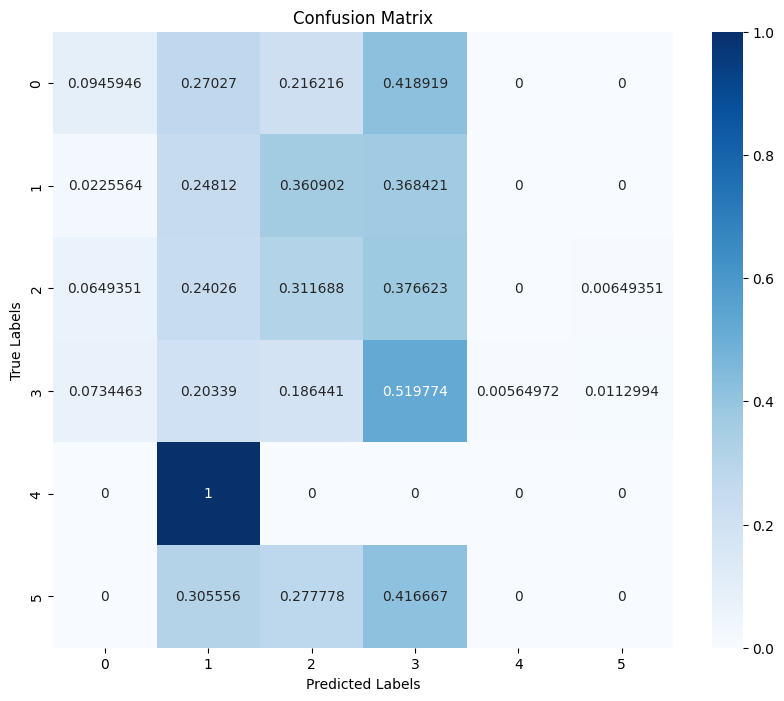

Epoch 14, Validation Loss: 3.5801, Accuracy: 0.3120, F1 Score: 0.2892
Val F1 Score Per Class  [0.13084112 0.24175824 0.31067961 0.43601896 0.         0.        ]


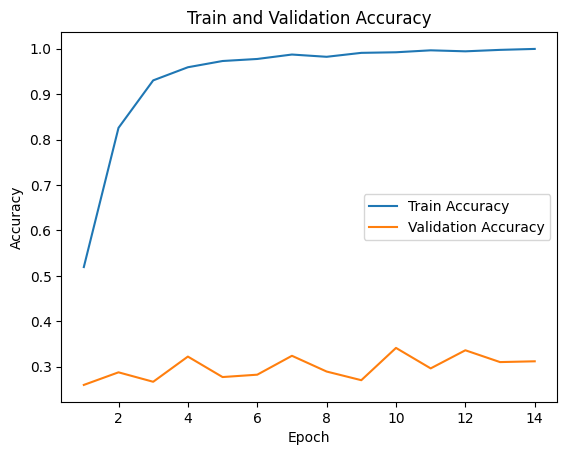

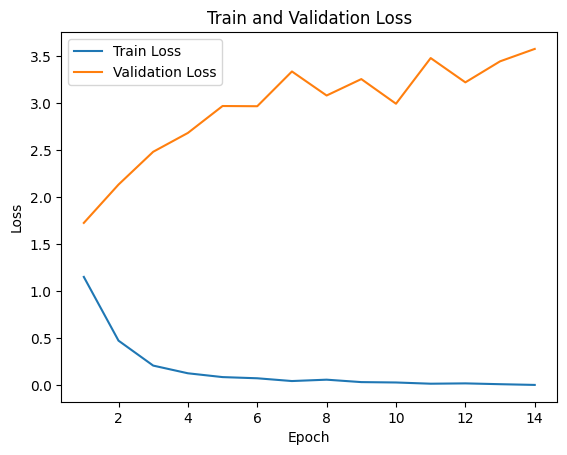

Epoch 15, Train Loss: 0.0062, Accuracy: 0.9986, F1 Score: 0.9986
Train F1 Score Per Class  [0.99969798 0.99820036 0.9972752  0.99647059 1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:30,  2.33it/s, loss=3.82]

[tensor([ 1.7601, -0.8284, -1.6719,  0.6509, -6.7810, -3.9299], device='cuda:0'), tensor([-1.2967, -2.5913, -0.6468,  5.0599, -3.3165, -3.4207], device='cuda:0'), tensor([-1.9327, -1.8616, -1.4969,  6.7129, -4.1679, -4.0284], device='cuda:0'), tensor([-0.7236, -2.7874,  4.4618, -2.0090, -5.8318, -3.4560], device='cuda:0'), tensor([-0.5273, -4.0586,  4.7980,  0.4080, -3.5607, -3.4501], device='cuda:0'), tensor([ 1.1935, -2.2083,  1.0418, -0.7072, -5.8856, -4.9054], device='cuda:0'), tensor([-3.9974,  0.1191,  1.1485,  0.4145, -4.1855, -3.0765], device='cuda:0'), tensor([-0.8260, -2.2961, -0.2147,  5.5119, -5.0712, -4.9248], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:30,  2.36it/s, loss=4.48]

[tensor([-2.7796,  0.0731, -1.6525,  4.0932, -3.6103, -3.9653], device='cuda:0'), tensor([-2.4334, -3.0128,  0.2715,  3.6926, -5.1388, -4.2915], device='cuda:0'), tensor([ 1.3716, -3.5563, -0.9762,  1.4207, -3.1888, -2.6738], device='cuda:0'), tensor([-3.7072, -2.3127, -1.3868,  3.1342, -2.5817, -2.8049], device='cuda:0'), tensor([-1.7537, -0.0428, -2.3628,  6.5032, -4.3148, -3.1466], device='cuda:0'), tensor([-2.9975,  1.4799, -2.4642, -0.6168, -5.0079, -4.1270], device='cuda:0'), tensor([-3.7491e+00, -1.0076e-03, -2.0866e+00,  4.5772e+00, -4.5475e+00,
        -2.6733e+00], device='cuda:0'), tensor([-0.7564, -2.1580, -3.3212,  4.7763, -4.3993, -2.1483], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.34it/s, loss=2.68]

[tensor([-2.6826, -0.7678, -2.6692,  3.6412, -4.4629, -4.0006], device='cuda:0'), tensor([-3.5760, -1.6313,  2.6415,  2.6740, -3.8104, -4.5658], device='cuda:0'), tensor([-1.9117,  5.9125, -1.1875, -2.5589, -3.1060, -2.7697], device='cuda:0'), tensor([-2.1431, -0.2234, -0.9355, -1.9801, -3.8652, -3.8502], device='cuda:0'), tensor([ 3.2594, -1.2504, -2.9139,  0.4020, -4.3888, -2.3889], device='cuda:0'), tensor([-1.2624, -1.2306,  4.7326, -1.7481, -5.0863, -4.3354], device='cuda:0'), tensor([-1.2348, -1.5518, -2.0801,  2.3285, -4.8745, -2.2215], device='cuda:0'), tensor([-1.8600, -1.5245,  2.4425,  3.0785, -4.8185, -4.6364], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.36it/s, loss=3.8]

[tensor([ 5.3782, -1.2768, -1.7625, -0.7059, -2.7984, -3.1327], device='cuda:0'), tensor([-2.3534, -2.6884, -1.4052,  6.6699, -3.0826, -3.4599], device='cuda:0'), tensor([-3.1199e+00, -1.2685e-03,  1.0326e+00,  2.0902e+00, -5.0277e+00,
        -4.6279e+00], device='cuda:0'), tensor([-1.3278,  4.2743, -2.3798, -0.2812, -4.0878, -2.5732], device='cuda:0'), tensor([-0.9762, -2.9177,  6.9483, -2.0765, -4.0328, -2.3392], device='cuda:0'), tensor([ 0.1108, -2.2189, -1.8042,  2.9765, -6.5762, -4.6183], device='cuda:0'), tensor([-2.4186, -3.9806,  1.5174,  3.5138, -3.8482, -2.0029], device='cuda:0'), tensor([-0.2645, -2.4557, -0.0098,  3.3597, -4.5545, -4.2758], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.36it/s, loss=4.16]

[tensor([-2.9297,  0.7858, -0.1642, -2.5725, -5.2007, -3.1344], device='cuda:0'), tensor([-2.4509, -3.5157, -0.3168,  0.5051, -3.8410, -1.4985], device='cuda:0'), tensor([-1.7104, -0.2549, -1.3575, -0.5051, -4.7659, -3.5457], device='cuda:0'), tensor([-2.0330, -1.5566,  7.2685, -2.0986, -3.7492, -3.4495], device='cuda:0'), tensor([-3.2060, -2.4448,  3.9352, -1.0644, -3.7363, -1.4253], device='cuda:0'), tensor([-3.0187, -1.1822,  2.2103,  3.1484, -4.9353, -3.9135], device='cuda:0'), tensor([-3.3022, -0.6690,  1.7074, -0.2587, -5.7002, -3.6816], device='cuda:0'), tensor([-3.7191,  3.5719, -1.6719,  1.5695, -5.0893, -5.2183], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.36it/s, loss=4.27]

[tensor([-0.0549, -1.1740, -3.4290,  3.2998, -4.4296, -3.9280], device='cuda:0'), tensor([-1.8040, -0.3108, -1.6534,  0.7792, -3.9218, -2.2904], device='cuda:0'), tensor([-3.2604e+00,  1.7302e+00,  7.1241e-01,  2.3679e-03, -5.2950e+00,
        -2.8809e+00], device='cuda:0'), tensor([-1.4609, -1.8956, -0.1368, -1.0795, -5.6184, -4.1472], device='cuda:0'), tensor([ 2.1138,  0.3472, -0.0432,  0.1214, -5.2404, -3.7646], device='cuda:0'), tensor([-3.7836, -0.7425,  6.1409, -1.2988, -4.5277, -3.9265], device='cuda:0'), tensor([-2.7294,  6.6299, -0.8185, -2.2803, -3.7279, -3.0510], device='cuda:0'), tensor([-2.2811,  5.9700, -1.9369, -0.9570, -3.7072, -2.9275], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.37it/s, loss=2.08]

[tensor([-1.6153, -2.9736,  3.5635, -1.4579, -5.1374, -4.4354], device='cuda:0'), tensor([-2.2209, -2.4734,  7.2247, -1.1994, -4.2303, -3.1987], device='cuda:0'), tensor([-0.5138, -3.0160, -0.5639,  4.7410, -4.2169, -1.8623], device='cuda:0'), tensor([-1.4881, -2.2233, -0.0144, -0.4157, -5.3436, -3.0911], device='cuda:0'), tensor([-0.8418, -0.8943,  5.4458, -0.1821, -4.9918, -4.7043], device='cuda:0'), tensor([-2.6337, -2.1775, -1.8588,  5.7596, -3.9226, -1.3497], device='cuda:0'), tensor([-3.7419, -0.6712, -2.1812, -0.0114, -4.0499, -2.9613], device='cuda:0'), tensor([-1.2240, -2.0641,  7.5569, -2.0742, -2.8055, -2.1938], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.38it/s, loss=3.61]

[tensor([-2.2207,  3.0810, -1.3914,  0.3602, -2.7957, -3.8125], device='cuda:0'), tensor([-2.8377, -1.4318, -2.3807, -0.2076, -2.9301, -1.3773], device='cuda:0'), tensor([ 4.0462, -2.3071, -2.3596, -1.3097, -4.7219, -1.6970], device='cuda:0'), tensor([-2.8423, -0.4756, -1.3471,  6.5003, -4.9721, -3.5233], device='cuda:0'), tensor([-2.9478, -0.3914, -2.2268,  0.4969, -4.6822, -2.3498], device='cuda:0'), tensor([-1.9583, -3.5796, -1.3609,  5.6845, -3.9984, -2.7173], device='cuda:0'), tensor([-1.0610, -3.4957,  2.6867,  1.1176, -5.2629, -4.0412], device='cuda:0'), tensor([-3.7915, -1.1054, -1.8736,  6.0113, -4.3687, -3.2908], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=2.91]

[tensor([-2.7429,  6.3119, -1.6260, -0.2613, -4.3905, -3.0981], device='cuda:0'), tensor([-2.9773, -2.9090,  0.1903,  5.7904, -4.7910, -3.1082], device='cuda:0'), tensor([ 1.7833, -3.4215, -1.7194,  5.4634, -4.7331, -2.9268], device='cuda:0'), tensor([-3.3441, -1.3831, -2.1912,  3.2386, -4.8262, -3.4516], device='cuda:0'), tensor([-2.1133, -2.2314,  0.0802,  2.5521, -5.4139, -4.4104], device='cuda:0'), tensor([-1.9357,  1.2733, -2.2091,  1.4465, -5.3932, -4.6605], device='cuda:0'), tensor([-4.1152, -2.0256,  2.6413, -0.0459, -4.5017, -3.3724], device='cuda:0'), tensor([-2.9863, -2.5156,  1.0625,  2.3650, -5.5584, -3.0246], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=4.54]

[tensor([-2.3869, -0.5467, -2.3627,  3.3380, -5.0241, -4.8284], device='cuda:0'), tensor([-2.3147, -2.4513, -1.3724,  6.9132, -3.8395, -2.6929], device='cuda:0'), tensor([-2.3306,  0.6539, -0.4878, -0.7954, -5.1428, -5.1589], device='cuda:0'), tensor([-2.6603, -0.9696,  2.5854, -1.0858, -4.5818, -5.0609], device='cuda:0'), tensor([-2.3977,  3.8095,  0.9765, -2.3497, -4.2819, -4.2619], device='cuda:0'), tensor([-3.2832,  0.0100, -1.1689,  0.0315, -4.9211, -3.7922], device='cuda:0'), tensor([ 2.0500, -0.6811, -0.6560,  1.4796, -5.2177, -5.2632], device='cuda:0'), tensor([-2.4388, -1.5975, -0.8760,  1.9149, -5.3050, -4.8082], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=3.15]

[tensor([-2.3667,  3.4000, -1.6855,  0.6681, -4.2171, -4.4913], device='cuda:0'), tensor([-3.2631, -0.8252, -0.4238,  1.1921, -4.6870, -2.9412], device='cuda:0'), tensor([-3.8464,  1.6583, -1.7626,  1.9082, -5.0540, -4.2098], device='cuda:0'), tensor([-2.9417, -3.0516,  4.9056,  0.2795, -3.9189, -2.9816], device='cuda:0'), tensor([-2.4462, -2.1038,  5.9455,  0.5731, -4.7275, -3.3034], device='cuda:0'), tensor([-3.2584, -1.8262, -1.5838,  6.9268, -4.5399, -2.6624], device='cuda:0'), tensor([-1.9343,  3.4181, -2.1822, -0.5421, -5.2210, -4.9427], device='cuda:0'), tensor([-2.8550, -2.4523,  1.5152,  2.0547, -5.0760, -3.1358], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=3.42]

[tensor([-1.4098, -2.0247, -1.1239, -0.5028, -5.6461, -5.3944], device='cuda:0'), tensor([-1.7157, -3.1843, -0.2875,  1.1526, -5.6003, -3.7630], device='cuda:0'), tensor([-2.2704, -3.2337, -1.0182,  6.4520, -4.0570, -2.8246], device='cuda:0'), tensor([-2.3569, -1.6445, -2.2171,  3.4137, -5.3556, -3.0228], device='cuda:0'), tensor([-1.3994,  2.2724, -2.3202, -0.8852, -5.4558, -4.2573], device='cuda:0'), tensor([-1.3029, -0.8545, -2.6095,  0.7978, -4.8531, -4.4096], device='cuda:0'), tensor([-2.9110, -3.3784,  2.7137, -0.7819, -3.8704, -0.0741], device='cuda:0'), tensor([ 0.3194, -2.6648,  0.1930,  2.0926, -5.6702, -3.7598], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.38it/s, loss=4.07]

[tensor([-2.7294, -1.9063, -1.9349,  5.2722, -2.9584, -1.7610], device='cuda:0'), tensor([-1.7676, -2.7575, -0.2519,  5.5359, -5.5001, -3.9672], device='cuda:0'), tensor([-2.4598, -0.2726, -4.2670,  3.5349, -4.1636, -1.3891], device='cuda:0'), tensor([-3.1876, -2.4638,  4.4075,  2.5190, -4.4150, -4.3704], device='cuda:0'), tensor([-2.5784, -1.7135, -1.3601,  5.0787, -4.9645, -3.4057], device='cuda:0'), tensor([ 1.4901, -2.5045, -2.5082,  1.4254, -3.9094, -4.4674], device='cuda:0'), tensor([-3.6288,  2.2695, -1.8564, -0.7209, -4.8787, -4.1562], device='cuda:0'), tensor([-2.8071,  3.4807, -1.4813,  0.8801, -5.0182, -4.9299], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.92]

[tensor([-1.7321, -1.2688,  7.0693, -2.2094, -2.9113, -2.7488], device='cuda:0'), tensor([-1.5578,  0.5368, -2.4959, -0.6496, -4.5816, -5.1769], device='cuda:0'), tensor([ 1.9922, -1.7169, -0.8702,  0.0902, -4.9719, -4.4946], device='cuda:0'), tensor([-1.2065, -2.1644,  0.1289, -0.3512, -5.3263, -4.3467], device='cuda:0'), tensor([-2.2881,  2.4557, -1.9764, -0.4030, -4.9069, -4.7897], device='cuda:0'), tensor([-2.4191, -1.1895,  0.3749,  3.3515, -4.4182, -3.9975], device='cuda:0'), tensor([-1.9649, -0.9400, -1.5108, -0.1027, -5.2877, -5.5070], device='cuda:0'), tensor([-1.1940, -1.3501, -1.5364,  0.8485, -4.9472, -4.3735], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=2.9]

[tensor([-2.3828, -2.1230, -1.8279,  1.8721, -4.3613, -4.7306], device='cuda:0'), tensor([-4.1205, -1.2684, -2.0661,  4.5961, -4.7875, -3.2456], device='cuda:0'), tensor([-2.2461, -4.3368,  0.8232,  0.9775, -3.0475, -2.1648], device='cuda:0'), tensor([-1.1768, -0.9179, -0.2733, -2.3421, -5.0029, -3.7453], device='cuda:0'), tensor([-2.5425, -1.7371,  6.2442, -1.7458, -3.8362, -3.6119], device='cuda:0'), tensor([ 0.7158, -3.8693,  0.4986,  4.5918, -5.2679, -3.6425], device='cuda:0'), tensor([-2.5536, -0.3672, -2.3214,  4.0944, -3.7807, -2.6575], device='cuda:0'), tensor([-3.5151,  0.5744, -0.0988,  0.4509, -4.7643, -4.3905], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=4.68]

[tensor([ 0.9510, -0.8763, -0.8654,  4.1823, -4.8386, -5.1996], device='cuda:0'), tensor([-3.9736, -1.5157, -1.6276,  6.2854, -4.8413, -3.4937], device='cuda:0'), tensor([-3.7565, -1.4851, -0.1147, -0.9659, -5.3566,  2.8251], device='cuda:0'), tensor([-2.6636, -2.7477,  0.5245,  5.2872, -5.3533, -3.8981], device='cuda:0'), tensor([ 7.3707, -1.7947, -0.7645, -0.9378, -3.4902, -2.9332], device='cuda:0'), tensor([ 0.2544,  1.4378, -1.7822,  1.1484, -4.8451, -4.6529], device='cuda:0'), tensor([-2.3267, -1.6371, -2.0392, -0.7164, -3.8258, -3.3267], device='cuda:0'), tensor([ 6.0744, -1.6347, -3.2142, -0.9990, -2.9991, -0.9524], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.38it/s, loss=4.44]

[tensor([-2.4378,  5.0524, -0.0609, -1.3166, -4.2173, -3.9936], device='cuda:0'), tensor([-1.2587, -0.8572, -1.5925,  4.3721, -5.6481, -5.1538], device='cuda:0'), tensor([-3.7105,  0.1597, -0.6966,  0.8924, -5.5260,  0.6308], device='cuda:0'), tensor([-2.6362, -1.5828,  5.7366, -1.0966, -4.2463, -3.6521], device='cuda:0'), tensor([ 7.7003, -2.4051, -0.7805, -0.7187, -3.1544, -3.0465], device='cuda:0'), tensor([-0.3514,  4.6305, -2.3130, -0.6866, -4.2940, -4.3796], device='cuda:0'), tensor([-1.7146, -3.0801,  7.0356, -0.5369, -3.9757, -2.9764], device='cuda:0'), tensor([-2.0041, -2.7758,  1.0077,  1.3080, -5.2735, -3.9831], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.39it/s, loss=3.37]

[tensor([-1.9451, -0.0889, -2.5483,  2.4185, -3.2225, -3.2506], device='cuda:0'), tensor([-2.8609, -1.7124,  3.9642, -0.1073, -3.4282, -3.6671], device='cuda:0'), tensor([-3.5183,  2.1679, -0.3793, -0.3104, -4.7022, -3.8372], device='cuda:0'), tensor([-2.4789, -2.8334, -1.5652,  6.7284, -3.1032, -2.6770], device='cuda:0'), tensor([-3.0304,  0.8341, -2.6050,  0.9927, -4.3495, -1.8314], device='cuda:0'), tensor([ 6.7975, -2.0505, -1.6249, -0.7762, -4.7185, -2.9381], device='cuda:0'), tensor([-1.5243, -2.3457, -1.5839,  2.4121, -4.6766, -3.9581], device='cuda:0'), tensor([-1.3401, -3.2820,  5.1980, -2.1514, -5.2638, -2.9194], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.38it/s, loss=3.09]

[tensor([-4.0322, -2.3094,  0.4540,  3.2197, -5.0647, -3.9580], device='cuda:0'), tensor([-3.1449, -2.2087,  4.3361,  1.0452, -3.8752, -3.8736], device='cuda:0'), tensor([-0.4757, -3.4243,  3.9233, -1.5994, -3.5021, -1.8081], device='cuda:0'), tensor([-2.6698,  0.7405,  1.6773,  0.8515, -2.5275, -4.9744], device='cuda:0'), tensor([-4.3423,  2.0219,  0.1246, -0.0352, -4.4766, -2.9319], device='cuda:0'), tensor([-2.7461,  0.5026, -2.7642,  0.9806, -4.5248, -3.6748], device='cuda:0'), tensor([-1.7069, -2.1095, -0.8945,  6.8259, -4.6045, -3.2052], device='cuda:0'), tensor([-0.0243, -1.0248, -2.8765,  2.4169, -4.0436, -4.1857], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=1.99]

[tensor([-4.1926,  2.1754,  0.0196, -0.8337, -4.4482, -2.8713], device='cuda:0'), tensor([-0.6953, -2.9778, -1.2443,  4.8939, -5.3535, -3.7227], device='cuda:0'), tensor([-2.6657, -1.3875,  2.9287, -1.6551, -5.0166, -4.6649], device='cuda:0'), tensor([-2.9820,  2.8663,  1.6651, -2.5060, -4.3598, -3.6336], device='cuda:0'), tensor([-4.0524,  1.8337, -2.7357,  0.6226, -4.3127, -4.6251], device='cuda:0'), tensor([-3.4868, -1.4354, -0.7122,  0.1106, -4.6924, -3.0383], device='cuda:0'), tensor([-2.2233,  0.6718,  1.6837, -0.1888, -4.2192, -3.9687], device='cuda:0'), tensor([-1.3113,  4.9147, -2.3539, -0.3988, -3.5146, -3.7346], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:22,  2.34it/s, loss=6.95]

[tensor([-1.6843, -2.2860,  7.3811, -2.1379, -3.2357, -1.8096], device='cuda:0'), tensor([-1.1487,  3.9376, -2.1771, -0.4703, -4.7585, -3.8635], device='cuda:0'), tensor([-2.9575, -0.9830, -2.5733,  5.7934, -4.6993, -4.8150], device='cuda:0'), tensor([-2.7391, -0.3553, -3.0150,  5.5453, -4.9496, -3.6609], device='cuda:0'), tensor([-2.7654,  6.2718, -2.5100, -1.7615, -3.1225, -1.6417], device='cuda:0'), tensor([-1.7462, -3.8357, -2.0476,  1.2549, -4.5842, -3.2931], device='cuda:0'), tensor([-0.7679,  6.3584, -1.8645, -1.8725, -4.6278, -2.4865], device='cuda:0'), tensor([ 2.1384, -2.3762, -1.8318,  2.7164, -4.6037, -5.2506], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.35it/s, loss=2.52]

[tensor([ 1.1291, -2.3016,  1.0536, -1.6131, -4.6781, -4.5663], device='cuda:0'), tensor([-1.5279, -3.0299,  4.9445, -0.9810, -4.9236, -3.7432], device='cuda:0'), tensor([ 0.4856, -0.3677,  2.5462, -0.9739, -6.9785, -5.1141], device='cuda:0'), tensor([-2.2118, -1.9137, -0.2583,  4.2573, -4.5789, -4.0752], device='cuda:0'), tensor([-3.4196,  0.4367, -2.5286,  0.0707, -4.4406, -3.9664], device='cuda:0'), tensor([ 0.7444, -3.0339,  0.9799, -0.7144, -4.8041, -3.7658], device='cuda:0'), tensor([-1.4989, -2.6199,  0.1900,  4.1265, -6.4895, -3.0416], device='cuda:0'), tensor([-0.7915, -2.9778,  5.2108, -0.6252, -5.0633, -3.9636], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.36it/s, loss=3.77]

[tensor([-1.8319, -2.9210, -2.7392, -0.6612, -3.0823, -2.9791], device='cuda:0'), tensor([-0.1772,  0.4013, -0.4914, -2.3268, -4.3527, -4.6864], device='cuda:0'), tensor([-2.5861, -1.0277, -1.9329,  5.9307, -4.8471, -3.7458], device='cuda:0'), tensor([-2.0013,  5.3814, -0.2370, -2.2428, -3.2368, -2.9121], device='cuda:0'), tensor([-2.3274, -0.1483, -2.6253,  0.9941, -4.6430, -3.3977], device='cuda:0'), tensor([-3.7261,  4.7592, -0.7049, -0.3976, -4.3504, -3.7797], device='cuda:0'), tensor([-1.6287, -3.6364,  2.6715,  0.1411, -4.5508, -3.1001], device='cuda:0'), tensor([-3.0832,  4.4097, -1.7000, -0.7320, -5.0668, -1.9646], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.36it/s, loss=4.4]

[tensor([-0.9619, -3.3531,  0.7719,  5.4128, -4.5028, -4.9085], device='cuda:0'), tensor([-2.3208, -1.2922,  0.1994,  3.2106, -5.3022, -4.6309], device='cuda:0'), tensor([-3.4225,  1.0681, -2.6907,  1.1038, -5.4042, -3.4199], device='cuda:0'), tensor([-0.4710, -5.2428, -1.1355,  1.8444, -4.1313, -0.0976], device='cuda:0'), tensor([-0.3983, -3.0725, -2.4066,  5.4428, -4.0300, -3.1979], device='cuda:0'), tensor([-2.3571, -1.6817, -1.6851,  1.3229, -4.7033, -3.3840], device='cuda:0'), tensor([ 0.6002, -0.7218, -2.5961, -1.4540, -3.7277, -1.3804], device='cuda:0'), tensor([-1.2514, -3.2191, -1.4612,  6.2162, -4.1371, -3.5333], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=3.01]

[tensor([-2.8597, -2.2225,  6.6599, -0.5407, -4.5923, -3.5484], device='cuda:0'), tensor([-1.3248, -1.6719,  6.8184, -1.8742, -2.8367, -3.0324], device='cuda:0'), tensor([-3.3271, -1.7155,  0.3248,  1.4851, -4.6198, -4.0037], device='cuda:0'), tensor([-3.2729,  2.8531, -1.2604,  1.1090, -5.0368, -4.2125], device='cuda:0'), tensor([-1.6248, -0.1955, -2.3759, -1.2510, -4.6211, -3.4717], device='cuda:0'), tensor([-3.3578, -3.2605,  1.8854,  0.6260, -3.8808, -3.2136], device='cuda:0'), tensor([-1.3604, -0.4350, -3.7616,  2.5834, -3.9071, -3.2559], device='cuda:0'), tensor([ 2.8092, -1.6833, -1.9318,  0.0137, -3.4170, -3.8611], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.36it/s, loss=2.14]

[tensor([-2.4365, -1.8965, -0.9058,  5.6902, -5.2717, -3.7190], device='cuda:0'), tensor([-1.9763, -2.7595,  0.0304,  1.2967, -5.4571, -3.8300], device='cuda:0'), tensor([-3.2639, -2.6572,  3.7931,  0.1223, -4.2033, -3.5046], device='cuda:0'), tensor([ 7.1182, -2.0759, -1.1040, -1.2658, -3.3446, -2.2348], device='cuda:0'), tensor([-3.1567,  2.2354, -1.8811,  4.3843, -5.3999, -4.0067], device='cuda:0'), tensor([-0.4550, -2.3012,  4.2241,  0.3910, -4.3632, -3.5545], device='cuda:0'), tensor([-0.8981,  0.5682, -1.8323,  2.6702, -4.3006, -4.6583], device='cuda:0'), tensor([-2.3129, -1.7245, -0.2740, -0.8463, -6.4804, -3.0695], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.36it/s, loss=2.18]

[tensor([-3.3938, -1.8059,  2.4057,  3.6039, -5.2862, -4.1382], device='cuda:0'), tensor([-3.6492, -1.0691, -0.5044,  0.3303, -4.6073, -4.6774], device='cuda:0'), tensor([-1.7527, -1.6768, -0.4095,  1.9371, -4.4238, -4.9055], device='cuda:0'), tensor([-1.9293, -2.9409,  0.5586,  3.9097, -5.5771, -3.2386], device='cuda:0'), tensor([-2.4388,  4.1767, -1.3321,  0.3280, -4.1982, -3.8324], device='cuda:0'), tensor([ 0.4882, -2.2865,  0.9879, -0.4523, -5.4352, -4.0481], device='cuda:0'), tensor([-2.3874, -3.3835,  3.7229,  0.6912, -5.1069, -2.7943], device='cuda:0'), tensor([-2.1506,  0.2364, -3.6077,  4.1930, -4.6344, -3.1320], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.37it/s, loss=3.34]

[tensor([-0.1673, -2.8426, -1.0584,  3.8423, -4.7953, -4.0636], device='cuda:0'), tensor([-3.0456, -1.0358, -1.4142,  4.5139, -4.4657, -3.7042], device='cuda:0'), tensor([-1.8361,  4.7307, -1.1794, -2.5153, -4.0070, -3.3311], device='cuda:0'), tensor([-3.0200, -1.7724, -0.9473,  4.3523, -4.1347, -4.1713], device='cuda:0'), tensor([-2.3456, -2.1645, -1.3493,  5.9207, -4.4950, -3.2760], device='cuda:0'), tensor([-3.6229,  0.4883,  0.3785,  3.2808, -5.4030, -4.9966], device='cuda:0'), tensor([-3.6122, -1.8888,  2.9590,  1.5499, -5.3924, -4.1409], device='cuda:0'), tensor([-2.3159,  3.9000, -0.8023, -1.5541, -4.7461, -4.4232], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.37it/s, loss=4.08]

[tensor([-3.3265, -0.3821, -1.3631,  6.1900, -4.3488, -2.9356], device='cuda:0'), tensor([-4.0303, -0.7313,  0.3936, -0.0405, -4.4460, -2.2480], device='cuda:0'), tensor([-3.8945, -3.3198,  3.1934,  1.1360, -4.7460, -3.4579], device='cuda:0'), tensor([-3.1914,  4.5325, -1.7833,  0.7310, -4.3700, -4.5233], device='cuda:0'), tensor([ 1.5377,  0.9120, -1.1848, -1.1138, -5.4224, -3.7685], device='cuda:0'), tensor([-3.4828, -1.6566,  2.8317, -0.4799, -5.0149, -2.7121], device='cuda:0'), tensor([-3.1940, -1.8515,  0.1665,  3.7564, -4.1624, -3.7115], device='cuda:0'), tensor([-3.2564, -1.2230, -1.0242,  6.0136, -4.8895, -3.8218], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=3.88]

[tensor([-3.9891,  4.2717, -0.9342,  0.0702, -4.4960, -3.5818], device='cuda:0'), tensor([-3.7102, -2.4577, -0.1911,  2.8551, -4.1282, -4.2166], device='cuda:0'), tensor([-1.7251, -0.9675, -2.2902, -1.4413, -3.8741, -3.0792], device='cuda:0'), tensor([-2.0022, -1.9815, -1.6750,  6.7074, -4.2975, -3.7518], device='cuda:0'), tensor([-2.0052, -0.5341, -2.7057, -1.2614, -5.1587, -2.7772], device='cuda:0'), tensor([-1.4938, -2.4620,  4.2431, -1.2640, -3.6586, -2.4920], device='cuda:0'), tensor([-2.6636, -3.6069,  2.4682,  2.8963, -5.8549, -5.0512], device='cuda:0'), tensor([-0.8859, -1.9234, -0.2160, -1.8793, -2.9070,  8.0833], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.38it/s, loss=3.72]

[tensor([-2.6116,  0.8106, -3.5566,  2.8182, -4.0564, -3.1518], device='cuda:0'), tensor([-2.4731, -2.2085, -1.6467,  6.8564, -4.6646, -3.0824], device='cuda:0'), tensor([-3.6546,  0.8702, -0.4084,  0.9905, -5.4273, -1.7777], device='cuda:0'), tensor([-1.6394,  4.9373, -3.1691, -0.6489, -4.6921, -3.0032], device='cuda:0'), tensor([-2.6849,  0.9079,  2.2289, -1.1346, -4.6778, -3.4597], device='cuda:0'), tensor([ 7.8876, -0.8395, -1.7244, -1.9640, -2.2832, -1.6167], device='cuda:0'), tensor([-1.6697, -3.0591, -0.7079,  6.2809, -3.6599, -3.7921], device='cuda:0'), tensor([-2.4840, -1.2555,  6.0053, -0.4797, -4.6840, -4.0117], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=4.96]

[tensor([-2.5437, -1.7810, -2.5843,  0.1885, -4.0671, -2.6535], device='cuda:0'), tensor([-2.5185, -1.7024, -1.9852,  6.9725, -4.0807, -3.0210], device='cuda:0'), tensor([-1.7844,  7.0618, -2.3478, -1.2653, -2.3117, -2.7939], device='cuda:0'), tensor([-3.2742,  1.2787, -1.3717, -1.4002,  5.3782, -1.8568], device='cuda:0'), tensor([-1.8043, -0.4321,  1.6687, -1.4340, -3.0970, -3.8431], device='cuda:0'), tensor([-1.8625, -2.8100, -0.0483,  3.0892, -5.0730, -3.6200], device='cuda:0'), tensor([ 3.7195, -2.8947, -1.3167, -0.4390, -4.8610, -2.4617], device='cuda:0'), tensor([ 1.7204, -1.3965, -2.7537,  0.4405, -4.8599, -3.8266], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=6.01]

[tensor([-3.3122, -2.4427, -0.7474,  4.7129, -3.7612, -1.9529], device='cuda:0'), tensor([-3.3980,  3.1226, -1.9496,  3.3145, -4.4087, -3.1326], device='cuda:0'), tensor([-1.9070, -2.9502, -1.5689,  5.9885, -5.1664, -3.0892], device='cuda:0'), tensor([-1.8820,  6.4529, -0.9200, -2.0985, -3.5657, -3.5244], device='cuda:0'), tensor([-3.2174, -2.0091,  7.1169, -1.3432, -3.2165, -3.0346], device='cuda:0'), tensor([-1.1389, -3.5654, -0.8829,  4.2482, -4.4423, -2.9396], device='cuda:0'), tensor([-2.0240,  3.6667, -2.9464, -1.6704, -4.7045, -3.6429], device='cuda:0'), tensor([-2.9456,  0.2339, -1.0441,  2.8241, -4.1317, -4.0309], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.36it/s, loss=3.82]

[tensor([ 7.4682, -0.3733, -2.6746, -1.4085, -2.5661, -2.4972], device='cuda:0'), tensor([-2.1079, -0.5483, -1.1856,  0.6922, -5.9328, -4.8792], device='cuda:0'), tensor([-3.0593, -0.2792, -1.2525,  1.6377, -1.0099, -3.7380], device='cuda:0'), tensor([-3.0407, -3.4000, -1.5801,  5.5435, -3.7976, -1.4566], device='cuda:0'), tensor([-2.5772,  0.1006, -1.7271,  2.6184, -4.4429, -4.2660], device='cuda:0'), tensor([-3.1988, -0.1512, -0.5943,  0.9175, -5.0449, -3.0765], device='cuda:0'), tensor([-1.3971, -2.7832, -1.8241,  5.5510, -4.6609, -3.5658], device='cuda:0'), tensor([-1.7804, -1.9306,  6.0135, -1.8863, -4.6269, -3.6855], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.36it/s, loss=3.47]

[tensor([-2.5789, -1.9484,  1.7537, -0.6118, -6.1116, -3.5490], device='cuda:0'), tensor([-1.0336,  1.6182,  0.1243, -1.4112, -4.7496, -4.6790], device='cuda:0'), tensor([-1.8190, -3.5242,  2.4553, -0.2869, -4.6065, -3.8346], device='cuda:0'), tensor([-1.7945, -1.6046,  7.4385, -1.5279, -3.3573, -2.9159], device='cuda:0'), tensor([-3.2873,  1.9154, -1.4216,  1.4348, -5.1769, -3.0753], device='cuda:0'), tensor([-1.9011, -3.3295, -0.0357,  2.8964, -4.2501, -1.0604], device='cuda:0'), tensor([-2.5256, -2.6327,  0.7531,  4.3656, -5.9121, -4.0430], device='cuda:0'), tensor([-2.0936, -0.3712,  1.6877,  2.2276, -4.8661, -4.5931], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=4.01]

[tensor([-2.7737, -0.8085,  4.6038, -2.1961, -3.7992, -3.2592], device='cuda:0'), tensor([-2.2082, -1.3351,  6.7669, -1.7470, -3.1496, -3.4744], device='cuda:0'), tensor([-2.4642, -2.9045, -0.9213,  2.0128, -4.9500, -2.5743], device='cuda:0'), tensor([-2.5622,  5.9346, -2.9494,  0.2403, -4.2080, -3.1697], device='cuda:0'), tensor([-2.0875, -2.9658,  0.0862,  2.8184, -5.0183, -3.4168], device='cuda:0'), tensor([-1.3428, -3.6127, -0.7745,  5.1315, -4.7778, -3.7184], device='cuda:0'), tensor([-1.9658, -1.9677, -2.0199,  7.0432, -3.9915, -3.2802], device='cuda:0'), tensor([-1.9161, -0.4612, -1.9163,  3.7268, -4.6700, -4.4601], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=4.67]

[tensor([-0.2765, -2.5624, -2.2891,  4.1227, -4.0123, -3.1882], device='cuda:0'), tensor([-2.0571, -2.4211, -0.9743,  5.0870, -4.8962, -3.8800], device='cuda:0'), tensor([-1.8782, -1.7234, -2.9854,  3.8243, -3.7578, -3.4933], device='cuda:0'), tensor([-3.4508,  5.1195, -2.3323, -0.1969, -4.2745, -0.7534], device='cuda:0'), tensor([-2.0900,  0.8107,  4.0407, -2.4687, -4.4573, -2.7264], device='cuda:0'), tensor([-3.0870,  5.9858, -1.5623, -1.3598, -3.3960, -3.1379], device='cuda:0'), tensor([-1.4727,  2.3737, -1.1294,  0.8578, -4.8532, -4.6358], device='cuda:0'), tensor([-3.6942,  1.0038, -0.3406,  2.4957, -4.4638, -4.8321], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:16<00:14,  2.37it/s, loss=4.06]

[tensor([-1.4253, -1.7435,  2.7291, -0.4726, -4.2620, -2.7086], device='cuda:0'), tensor([-3.0752, -0.6362, -1.4141,  2.1149, -5.7233, -2.0781], device='cuda:0'), tensor([-0.2628, -2.8775, -0.8632,  4.4581, -5.5507, -4.3192], device='cuda:0'), tensor([-3.4730,  2.6488, -2.6829, -0.2530, -3.7645, -3.9406], device='cuda:0'), tensor([-2.9198, -1.2924,  4.1028, -1.7419, -4.8702, -4.7821], device='cuda:0'), tensor([-1.8868,  6.2113, -2.5445, -0.6212, -3.3357, -3.1724], device='cuda:0'), tensor([-1.3795,  0.9164,  1.0299, -2.8305, -4.4997, -4.2780], device='cuda:0'), tensor([-2.4944, -2.7791,  4.9955, -0.0221, -5.3042, -4.3874], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.38it/s, loss=3.67]

[tensor([-0.4961, -1.6670,  1.8739,  0.1665, -4.9933, -5.1818], device='cuda:0'), tensor([-2.9480, -0.3405,  0.0403,  3.5463, -4.5119, -5.0281], device='cuda:0'), tensor([-0.1120, -2.1240, -1.3004,  1.6403, -4.3340, -3.1606], device='cuda:0'), tensor([-0.8595, -3.1668, -0.3258,  1.3689, -5.7439, -4.0824], device='cuda:0'), tensor([-2.8236, -2.0438, -2.0998,  3.9469, -5.0294, -4.3530], device='cuda:0'), tensor([-2.6978, -1.4152,  6.7708, -1.4671, -4.1943, -2.9995], device='cuda:0'), tensor([ 3.4082, -2.2241,  0.0702, -1.0990, -4.3704, -4.4075], device='cuda:0'), tensor([-3.8395,  1.5890, -0.7578,  0.3347, -6.2073, -1.7710], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=4.19]

[tensor([ 2.1227, -1.6705, -1.0100,  1.1137, -4.4790, -4.1009], device='cuda:0'), tensor([-1.1150, -2.1042,  5.4839, -2.2216, -3.0371, -2.6049], device='cuda:0'), tensor([-2.7019, -2.0084, -1.7225,  4.7557, -5.6591, -2.5073], device='cuda:0'), tensor([ 3.2805, -1.6701, -3.6523,  1.9387, -3.2840, -3.5567], device='cuda:0'), tensor([-3.8080,  0.6934, -1.1146,  1.1369, -5.1134, -1.3781], device='cuda:0'), tensor([ 3.0689, -0.2285, -2.1159,  0.5615, -2.8653, -3.4761], device='cuda:0'), tensor([-3.3412, -0.5687, -0.9042,  5.7372, -4.2518, -4.0653], device='cuda:0'), tensor([-0.1289, -2.0150, -2.3240,  4.2502, -4.8045, -0.4652], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=2.84]

[tensor([-2.4907, -2.4779, -0.2281,  4.8679, -4.7126, -3.9209], device='cuda:0'), tensor([-2.7136, -0.5713,  2.4107,  1.5989, -3.0883, -5.2606], device='cuda:0'), tensor([-1.7620, -2.0109, -1.6028,  4.0633, -4.5666, -3.0525], device='cuda:0'), tensor([-3.8478,  0.7592, -1.8769,  3.5919, -4.9918, -3.7567], device='cuda:0'), tensor([-3.0260,  1.0504, -0.2488,  0.7806, -5.4823, -4.9308], device='cuda:0'), tensor([-2.3941, -2.7968, -0.8520,  6.0529, -4.4365, -3.3814], device='cuda:0'), tensor([-3.3079, -1.6716, -1.3415, -0.4520, -4.8911, -4.2610], device='cuda:0'), tensor([ 0.5221, -1.3601, -1.8524,  2.2872, -4.8449, -4.9282], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=3.24]

[tensor([-2.3480, -3.0373,  0.4020,  5.5246, -4.5306, -3.7889], device='cuda:0'), tensor([ 5.3397, -2.1348,  1.0289, -0.7233, -4.1506, -3.0619], device='cuda:0'), tensor([ 0.0689, -2.4912, -1.5824,  3.1676, -5.6527, -4.3832], device='cuda:0'), tensor([ 1.1375,  0.0387, -2.5292, -1.0176, -3.8159, -3.3176], device='cuda:0'), tensor([-3.3366, -2.4231,  3.4673,  2.1190, -3.9758, -3.2426], device='cuda:0'), tensor([-1.8121, -3.1984, -1.9036,  6.4718, -3.7801, -3.7166], device='cuda:0'), tensor([-3.2980, -2.4110,  0.9910,  4.5342, -4.4616, -2.9431], device='cuda:0'), tensor([ 2.2722, -1.8710,  0.1190,  0.6910, -4.8080, -5.2299], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.39it/s, loss=1.92]

[tensor([-2.9067, -0.9902, -1.6805,  5.6434, -4.6267, -3.5794], device='cuda:0'), tensor([-2.7767, -1.2508, -0.8263, -0.0756, -4.8630, -4.0218], device='cuda:0'), tensor([-0.1032, -0.4569, -1.9435,  0.2937, -6.0365, -4.3318], device='cuda:0'), tensor([-2.7522,  2.5109, -2.6187,  2.4401, -5.8482, -2.0013], device='cuda:0'), tensor([-2.5806,  1.7797, -3.2083,  1.4799, -4.8740, -3.0751], device='cuda:0'), tensor([-3.5493,  3.5409,  3.2077, -2.5602, -3.3553, -3.6325], device='cuda:0'), tensor([-2.9341, -2.0822,  1.2444,  4.2186, -5.1974, -3.7130], device='cuda:0'), tensor([-3.5896, -0.6038, -0.6004, -0.9595, -4.9367, -3.4026], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.38it/s, loss=4.22]

[tensor([-2.4521,  0.1428, -1.6188,  4.6958, -3.0581, -4.5153], device='cuda:0'), tensor([-1.7659, -2.0317,  3.3811,  1.6296, -5.5621, -4.3647], device='cuda:0'), tensor([-0.7780,  4.2798, -2.4418, -0.8875, -4.8292, -3.0193], device='cuda:0'), tensor([-1.9734, -1.6732, -1.4705, -1.2167, -1.8890,  8.3020], device='cuda:0'), tensor([-2.6094,  0.5822, -2.0343,  4.9623, -4.4327, -4.1715], device='cuda:0'), tensor([-1.8698, -0.5892, -2.5006,  2.7197, -4.9044, -3.3965], device='cuda:0'), tensor([-0.6372, -2.9916, -0.5470,  1.2320, -5.7948, -5.1645], device='cuda:0'), tensor([-2.0752, -1.8380, -1.8540,  6.7624, -3.6687, -3.7668], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.38it/s, loss=5.08]

[tensor([-0.2636,  2.3458,  0.7192, -1.8167, -5.2778, -1.8924], device='cuda:0'), tensor([-2.4161,  6.8952, -1.8436, -1.2193, -3.3656, -2.7483], device='cuda:0'), tensor([-1.6968,  6.0421, -2.0871, -1.0085, -4.6862, -4.2676], device='cuda:0'), tensor([-1.9779,  7.2688, -2.6108, -0.8324, -3.4066, -2.8254], device='cuda:0'), tensor([-1.3403, -3.1250, -1.9877,  6.3974, -5.2281, -2.2637], device='cuda:0'), tensor([ 0.4759, -1.1054, -1.4719,  2.0953, -4.8992, -3.2856], device='cuda:0'), tensor([ 1.0386, -0.4329, -2.3203, -2.0180,  1.6347, -2.9126], device='cuda:0'), tensor([-3.6771, -0.2411,  4.5488, -1.7608, -4.1201, -3.6184], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=3.76]

[tensor([-1.8408, -1.4937,  0.5645,  1.4648, -5.1953, -4.2121], device='cuda:0'), tensor([-1.2547, -2.2543, -1.5827, -0.3964, -6.0840, -3.9323], device='cuda:0'), tensor([-1.7365, -1.8263, -1.7363,  3.0047, -5.9992, -3.0164], device='cuda:0'), tensor([-2.8087, -3.1135,  2.4250,  0.8997, -5.1290, -4.5337], device='cuda:0'), tensor([-2.9681, -1.1675,  0.5657,  1.0808, -5.7653, -5.1333], device='cuda:0'), tensor([-2.0408, -2.1061, -1.2525, -1.5128, -5.0400, -4.1701], device='cuda:0'), tensor([-1.5283, -3.2273, -1.3410,  6.5175, -4.6089, -2.7681], device='cuda:0'), tensor([-0.8195,  0.8752, -1.4229,  0.2758, -5.3994, -3.8384], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=3.03]

[tensor([-3.9690, -1.8593,  0.6816, -0.3970, -3.4488, -1.6219], device='cuda:0'), tensor([-0.3936, -2.6783,  2.8353,  0.6351, -4.4882, -3.8862], device='cuda:0'), tensor([-1.4178,  0.1189,  3.0393, -2.5413, -4.4810, -4.1112], device='cuda:0'), tensor([-1.7756, -1.8442,  4.0868, -0.9666, -5.8922, -3.9702], device='cuda:0'), tensor([-3.3962, -1.5458,  0.7834,  1.1840, -4.7312, -3.4614], device='cuda:0'), tensor([-2.4964, -2.3770,  1.0426,  2.2963, -5.0597, -0.8197], device='cuda:0'), tensor([-3.5706, -1.7462, -0.7850, -0.3382, -4.2547, -2.8276], device='cuda:0'), tensor([-2.1588,  5.0366, -2.8068, -0.0584, -4.4623, -2.8692], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.37it/s, loss=2.39]

[tensor([-1.6683, -3.5037, -0.9415,  4.2274, -4.7650, -4.0398], device='cuda:0'), tensor([-3.6115,  0.4366, -0.4038,  0.5798, -5.2003, -1.2954], device='cuda:0'), tensor([ 0.7207, -2.6769, -1.9295, -1.5937, -3.9576, -1.6106], device='cuda:0'), tensor([-1.4946,  3.4857, -1.2726, -1.8135, -5.2259, -5.3620], device='cuda:0'), tensor([ 0.6261, -2.6895, -2.5766,  3.0777, -5.3815, -3.0091], device='cuda:0'), tensor([-3.3536, -2.3597,  1.5648,  0.9383, -4.5432, -3.5032], device='cuda:0'), tensor([-3.6881,  0.8124,  1.4164,  0.2007, -5.7121, -4.4711], device='cuda:0'), tensor([ 5.0031, -2.3965, -1.4910,  1.8550, -4.2199, -4.1755], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.38it/s, loss=3.96]

[tensor([-1.2647, -1.7951,  5.6885, -1.2107, -5.5966, -4.4814], device='cuda:0'), tensor([-2.9784,  5.5268, -0.0881, -1.3701, -3.8231, -3.8876], device='cuda:0'), tensor([-3.4015, -0.6557,  1.7124,  0.6902, -5.5058, -3.1063], device='cuda:0'), tensor([-0.1590, -2.0210, -0.6048,  3.7374, -5.3130, -3.3847], device='cuda:0'), tensor([ 1.1394, -0.7597, -1.8508, -1.9740, -4.7826, -3.3923], device='cuda:0'), tensor([-1.7312, -1.9296,  0.2566,  0.7854, -4.6171, -3.1597], device='cuda:0'), tensor([-2.2938, -1.8602,  0.7359, -0.1825, -4.3512, -4.5637], device='cuda:0'), tensor([-0.2049, -2.5505, -1.9757,  4.9055, -3.5222, -2.4866], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.39it/s, loss=3.02]

[tensor([-1.4990, -1.7002, -0.3127, -1.2626, -5.2637, -3.8179], device='cuda:0'), tensor([-2.0873,  2.4729, -0.5234, -1.1261, -4.7503, -2.7916], device='cuda:0'), tensor([ 2.0524,  0.2890, -2.5900,  1.9531, -5.6249, -3.5885], device='cuda:0'), tensor([-3.2597, -1.8806, -1.1447,  5.9477, -3.8190, -3.8075], device='cuda:0'), tensor([-1.5952,  5.2391, -1.8297, -0.6971, -4.9312, -4.0386], device='cuda:0'), tensor([-2.0695, -2.4482, -0.6732,  5.5260, -5.0951, -3.4432], device='cuda:0'), tensor([-3.4672, -0.7378, -0.3774, -0.1402, -4.6416, -3.5950], device='cuda:0'), tensor([-0.3002, -3.8588, -0.8118,  5.6918, -5.0048, -3.7584], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.38it/s, loss=2.49]

[tensor([-2.7703, -1.3701, -1.4051,  0.6672, -3.8393, -3.2178], device='cuda:0'), tensor([-2.5314, -2.4159,  0.1386,  5.8547, -5.1297, -4.0401], device='cuda:0'), tensor([-0.9123,  2.3692, -2.6120, -0.2077, -5.1032, -5.1683], device='cuda:0'), tensor([-2.8397,  3.4439, -2.9937,  1.5019, -5.6900, -4.5131], device='cuda:0'), tensor([-1.0394, -3.5632,  2.6611,  4.2082, -4.5212, -4.2620], device='cuda:0'), tensor([-3.5890, -2.4192,  2.5659,  4.0474, -4.9352, -4.0897], device='cuda:0'), tensor([-3.5389, -0.8709,  0.3283,  1.4204, -4.5790, -4.3198], device='cuda:0'), tensor([-3.1635, -3.9239, -0.6093,  4.0205, -4.1730, -4.1438], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=3.03]

[tensor([-3.7256,  2.1771, -2.6868,  1.5769, -4.0246, -1.5389], device='cuda:0'), tensor([-1.2200, -0.2207, -1.3517,  0.9155, -5.7531, -5.0152], device='cuda:0'), tensor([-2.6288,  0.8578, -2.5317,  0.1825, -3.5868, -3.9038], device='cuda:0'), tensor([-1.4159, -1.7078, -1.6886,  2.8423, -4.3242, -4.5003], device='cuda:0'), tensor([-2.8474, -1.6758,  5.5179, -1.0127, -4.5925, -4.8964], device='cuda:0'), tensor([-3.2991,  0.2868, -0.7654,  0.3310, -5.5105, -3.2621], device='cuda:0'), tensor([-2.6616,  7.1724, -2.1879, -0.7848, -3.3215, -2.9151], device='cuda:0'), tensor([-2.1484,  0.1931, -2.8617,  0.7144, -4.8048, -3.4903], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.06]

[tensor([ 1.3710, -2.6126, -0.8209,  1.6560, -5.0891, -3.6087], device='cuda:0'), tensor([ 0.6970, -2.1867,  0.9216,  1.7058, -5.7077, -4.7207], device='cuda:0'), tensor([-2.9320, -3.5138,  0.7176, -0.4341, -4.8524, -2.4486], device='cuda:0'), tensor([-4.2293,  0.3401, -1.5467, -0.9683, -5.4830, -3.8048], device='cuda:0'), tensor([-1.5380, -2.8677, -1.6355,  1.0809, -5.9519, -4.2668], device='cuda:0'), tensor([-2.5774, -1.4761, -1.2360,  1.5089, -5.3053, -4.4505], device='cuda:0'), tensor([-2.1523,  1.3032,  0.0608, -0.7949, -4.2587, -2.6023], device='cuda:0'), tensor([-0.9298, -3.9405,  0.2442,  3.1888, -4.6609, -3.8197], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.36it/s, loss=1.91]

[tensor([-3.4136,  5.8885, -1.4613, -0.3371, -4.6600, -2.7554], device='cuda:0'), tensor([-3.6721, -0.5821,  1.5398,  1.1652, -5.4057, -4.6959], device='cuda:0'), tensor([ 2.9243, -1.4820,  0.6896, -0.7780, -5.2577, -4.9330], device='cuda:0'), tensor([-1.3158, -1.6563, -1.1111,  5.3956, -5.4760, -3.8544], device='cuda:0'), tensor([-1.9476, -3.4194,  0.3822,  1.1081, -5.7364, -3.8359], device='cuda:0'), tensor([-3.3977, -1.4947,  3.5722, -0.9575, -4.8491, -3.8841], device='cuda:0'), tensor([-2.1431, -1.0236, -2.8495,  3.8487, -5.3734, -4.3216], device='cuda:0'), tensor([-2.6680, -1.6635, -1.5045,  7.1895, -4.3151, -3.0572], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=2.72]

[tensor([ 5.8680, -2.6324, -1.4321,  0.8681, -4.3956, -3.7430], device='cuda:0'), tensor([ 0.5374, -1.5466,  0.3654, -1.4406, -5.7336, -3.6710], device='cuda:0'), tensor([-2.8717, -0.2977,  2.1054, -0.4012, -4.4062, -4.0608], device='cuda:0'), tensor([-2.5804, -1.8252,  7.0013, -0.5523, -4.3164, -2.6464], device='cuda:0'), tensor([-1.1292,  0.4855, -3.2964,  0.1748, -4.0573, -1.1714], device='cuda:0'), tensor([-1.6686, -0.8305,  3.3652, -0.8358, -5.8010, -5.1594], device='cuda:0'), tensor([-3.0418,  1.9104, -1.8059,  0.1999, -4.8542, -4.8893], device='cuda:0'), tensor([-3.5525,  3.9663, -1.8834, -1.3107, -5.1408, -3.4535], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=6]

[tensor([-0.9968, -3.2551, -1.2531,  5.7005, -4.7713, -2.5880], device='cuda:0'), tensor([-3.7154, -0.7597, -1.1651,  2.0361, -4.5379, -4.5247], device='cuda:0'), tensor([-2.0823, -2.9999, -0.5983,  5.0439, -6.1120, -2.4473], device='cuda:0'), tensor([-2.2380, -1.0529, -0.9859,  3.8487, -5.5284, -4.8656], device='cuda:0'), tensor([-1.6457, -2.5414,  5.8182, -1.6665, -2.9509, -3.0247], device='cuda:0'), tensor([-3.0890, -3.5758,  0.0557,  4.2228, -6.4935, -2.9987], device='cuda:0'), tensor([ 1.2355, -2.7476,  2.9576,  1.0392, -4.9878, -5.3697], device='cuda:0'), tensor([-1.8137, -3.4250, -1.2116,  6.4877, -4.5296, -2.9601], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.37it/s, loss=3.97]

[tensor([-2.6406, -1.9749,  1.1994,  3.9176, -5.6946, -5.0066], device='cuda:0'), tensor([-0.0579, -3.1246, -0.2624,  0.4335, -4.9694, -4.4368], device='cuda:0'), tensor([-3.7137, -0.6575,  5.4837, -0.7884, -4.6335, -3.9149], device='cuda:0'), tensor([-1.8486,  0.0713, -1.0102,  1.4249, -5.8022, -4.6452], device='cuda:0'), tensor([ 0.1209, -3.3260, -1.9926,  0.1964, -4.2066, -2.2776], device='cuda:0'), tensor([-3.8769, -1.7488,  1.6498,  0.7205, -5.4444, -4.4778], device='cuda:0'), tensor([-2.6379, -1.0972, -1.4723,  6.0634, -4.1707, -4.4797], device='cuda:0'), tensor([-2.3201, -1.9166, -0.6304,  1.2088, -5.3795, -4.7744], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=3.45]

[tensor([-1.2116, -3.5243,  1.9973,  0.1295, -5.1222, -4.4003], device='cuda:0'), tensor([-2.0268, -3.0839, -1.6875,  6.2398, -4.5365, -2.1401], device='cuda:0'), tensor([ 1.9293, -1.8126, -0.3108,  0.2802, -4.6445, -3.2804], device='cuda:0'), tensor([-2.7956,  3.1066, -1.7641,  2.2820, -5.5711, -4.6935], device='cuda:0'), tensor([-1.8404, -1.8138,  7.3786, -1.4522, -3.1630, -2.8482], device='cuda:0'), tensor([ 0.7479, -3.2296,  1.1197,  1.4003, -4.6564, -3.4880], device='cuda:0'), tensor([-3.3682, -0.1864, -0.7456, -0.7702, -5.1793, -4.7321], device='cuda:0'), tensor([-1.1555, -1.2235,  0.8943,  0.6228, -5.0986, -5.4527], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.38it/s, loss=4.01]

[tensor([-1.1654, -0.2966, -1.7671,  0.2927, -5.7534, -5.2131], device='cuda:0'), tensor([-4.5180,  1.0284,  0.4037,  3.2897, -4.7069, -3.2513], device='cuda:0'), tensor([-2.5349, -2.5027, -0.4654,  5.7602, -5.8315, -2.8594], device='cuda:0'), tensor([-2.6782, -2.1584,  0.2129,  4.2770, -4.9772, -4.4314], device='cuda:0'), tensor([-1.7900, -1.9597, -1.3624,  3.3110, -4.9487, -3.8920], device='cuda:0'), tensor([-2.6986,  0.2205, -1.3839, -0.3898, -5.0519, -4.9571], device='cuda:0'), tensor([-2.5941,  2.0144, -3.2308,  1.7182, -4.6645, -3.1768], device='cuda:0'), tensor([ 7.6915, -0.7443, -1.2012, -1.6143, -2.9629, -3.2081], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.39it/s, loss=5.22]

[tensor([ 1.3996, -1.1228, -2.6911,  2.5416, -4.5819, -3.6257], device='cuda:0'), tensor([-4.6393, -1.8670, -0.8248,  3.1694, -5.2290, -3.9790], device='cuda:0'), tensor([-3.5764, -2.0570,  1.7159,  2.6235, -5.4093, -3.6503], device='cuda:0'), tensor([-4.3699, -0.2208, -1.6486,  0.0983, -4.6732, -1.2687], device='cuda:0'), tensor([-2.4883, -2.0817, -0.8089,  5.5563, -5.7413, -4.4169], device='cuda:0'), tensor([-3.9664, -2.0343, -1.3502,  4.8279, -3.9867, -3.6188], device='cuda:0'), tensor([-2.4705, -0.1422, -2.3677,  5.4477, -5.1661, -2.8652], device='cuda:0'), tensor([-3.0609, -2.2243, -0.6688,  3.4457, -5.6847, -3.4337], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.39it/s, loss=4.34]

[tensor([-2.6367,  1.8441, -1.9817, -0.7232, -4.6288, -3.7034], device='cuda:0'), tensor([-2.9510, -1.3628, -0.4240,  4.9495, -3.2511, -4.0530], device='cuda:0'), tensor([-1.4425, -2.5575,  4.7665,  0.1343, -5.1646, -4.1992], device='cuda:0'), tensor([-3.4691, -0.5968, -2.6198,  3.4937, -4.8805,  0.4203], device='cuda:0'), tensor([-0.3255, -3.6097,  4.2928,  1.0088, -5.1089, -3.6284], device='cuda:0'), tensor([ 1.2748, -2.5638, -2.0383,  0.6800, -3.8588, -1.5728], device='cuda:0'), tensor([-0.6887, -2.9877,  4.1400, -1.0792, -5.4859, -3.4475], device='cuda:0'), tensor([-2.9307, -1.7573, -1.8745,  4.8382, -5.2734, -5.0398], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.39it/s, loss=3.27]

[tensor([ 1.6731, -2.7200,  1.1922,  0.5229, -4.5793, -4.6993], device='cuda:0'), tensor([-2.6383, -1.2018, -0.4515,  3.3799, -5.8209, -4.2271], device='cuda:0'), tensor([-4.6339,  1.6783, -1.1465, -0.6017, -4.8579, -3.5556], device='cuda:0'), tensor([-3.7904, -0.3727, -1.7842,  3.5193, -5.5912, -3.5635], device='cuda:0'), tensor([-3.2020,  1.9218, -3.2306,  3.2082, -4.4359, -2.2931], device='cuda:0'), tensor([-1.0348, -1.7866, -2.0891,  1.2043, -4.2320, -2.7706], device='cuda:0'), tensor([-1.8641, -0.4626,  7.0052, -2.8379, -4.0081, -3.1873], device='cuda:0'), tensor([-1.8237, -2.1001,  5.2342, -1.3198, -4.7501, -4.5854], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.39it/s, loss=1.83]

[tensor([-3.6374, -1.2875,  4.7046, -0.7231, -5.5740, -1.8511], device='cuda:0'), tensor([-4.5656,  2.2097, -0.3784,  1.6122, -5.1428, -3.7252], device='cuda:0'), tensor([-1.2607, -3.3236, -0.9609,  6.0063, -4.3805, -3.6198], device='cuda:0'), tensor([-2.9198, -2.1389,  0.5833,  4.3943, -5.3696, -4.0762], device='cuda:0'), tensor([-1.5593,  2.4108, -2.8239,  1.7993, -5.5567, -3.5228], device='cuda:0'), tensor([-3.0839, -2.3424, -0.1552,  4.7394, -5.7676, -1.2545], device='cuda:0'), tensor([-3.1623, -1.3706, -1.9603,  6.4860, -3.1539, -2.6116], device='cuda:0'), tensor([-2.0513,  0.3671, -0.8293,  4.9858, -5.1983, -5.7938], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.38it/s, loss=3.91]

[tensor([-2.1437, -2.6406,  0.2927,  2.2866, -4.5007, -3.8108], device='cuda:0'), tensor([-2.2321, -2.8266, -1.5588,  3.4127, -5.2280, -4.1226], device='cuda:0'), tensor([-1.5002,  0.2759, -1.3829,  1.1617, -4.7808, -4.3322], device='cuda:0'), tensor([-3.3902,  0.1746,  1.4061, -1.4561, -6.1395, -5.0640], device='cuda:0'), tensor([-1.8839, -0.2733, -0.8861,  2.1522, -5.4291, -4.2527], device='cuda:0'), tensor([-2.1727,  0.8529, -2.8664,  3.1216, -3.7474, -3.7368], device='cuda:0'), tensor([-2.2936, -2.3938,  6.5228, -0.4616, -3.3708, -2.3095], device='cuda:0'), tensor([-3.1881, -3.2297,  0.4366,  4.9723, -3.8443, -2.4333], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=1.62]

[tensor([-1.5782, -2.0811, -1.4745,  4.6895, -5.1403, -3.6880], device='cuda:0'), tensor([-3.7037, -0.8648, -0.6814,  0.3638, -4.0014, -4.4647], device='cuda:0'), tensor([-1.5044, -1.3011,  6.2197, -1.6224, -4.1047, -4.9407], device='cuda:0'), tensor([-1.3935,  0.3783, -0.5959,  0.0726, -5.6859, -3.9390], device='cuda:0'), tensor([-1.9656,  2.6696, -2.8100, -1.0703, -3.5607, -1.5358], device='cuda:0'), tensor([ 0.1926,  3.6471, -2.8473, -0.1287, -3.1516, -4.1271], device='cuda:0'), tensor([-3.1339, -1.5028, -2.8684,  1.8554, -5.1175, -3.9946], device='cuda:0'), tensor([-2.4071, -2.1021, -0.7634,  6.2991, -4.4552, -3.4440], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.39it/s, loss=4.16]

[tensor([-2.7423, -3.2056,  3.2701, -0.3758, -4.8870, -1.5722], device='cuda:0'), tensor([-3.1033, -1.7599,  7.2653, -1.3593, -3.5503, -2.4122], device='cuda:0'), tensor([-3.4205,  0.5960, -2.4795,  1.3853, -4.3939, -4.0286], device='cuda:0'), tensor([-2.7693, -2.6164, -0.5178,  6.7142, -4.1777, -2.6967], device='cuda:0'), tensor([-3.1709, -0.7250,  2.5225, -1.5372, -5.7339, -3.8762], device='cuda:0'), tensor([-1.2696, -3.4173, -0.0473,  1.1183, -5.1705, -3.5576], device='cuda:0'), tensor([-1.7311,  2.7901, -2.0878,  1.0398, -3.6836, -4.1552], device='cuda:0'), tensor([-1.0612, -3.6559, -1.7952,  4.0808, -5.6039, -2.1592], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.39it/s, loss=3.94]

[tensor([-3.5233, -1.5313,  5.7993, -0.1781, -5.3537, -3.8565], device='cuda:0'), tensor([-4.2003,  2.1543, -1.6845,  2.1010, -4.5925, -3.2887], device='cuda:0'), tensor([-2.4379,  3.7484, -1.4349, -1.1097, -5.2596, -2.1415], device='cuda:0'), tensor([ 1.1803, -1.6162, -1.6503,  2.4838, -5.1759, -3.9159], device='cuda:0'), tensor([-1.5514, -0.7218,  4.3890, -1.1061, -4.3583, -5.3399], device='cuda:0'), tensor([-2.6545,  1.1639,  0.1294, -1.8232, -5.2618, -5.2200], device='cuda:0'), tensor([-1.4400, -2.8612,  4.9553,  0.3243, -3.8734, -3.5158], device='cuda:0'), tensor([-4.0136,  1.2502,  5.5450, -2.0626, -4.5975, -2.4353], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.39it/s, loss=4.04]

[tensor([-3.1060, -1.0353,  0.3419,  3.9108, -4.0496, -4.3597], device='cuda:0'), tensor([-0.2221, -1.2192, -0.7431,  0.0556, -3.4607, -4.9626], device='cuda:0'), tensor([-1.7823e+00, -3.0939e+00,  2.2459e+00, -2.9271e-03, -4.3306e+00,
        -3.5135e+00], device='cuda:0'), tensor([-3.3898, -2.3241, -2.0238,  0.6998, -4.9740, -2.4321], device='cuda:0'), tensor([-3.3700, -1.7016, -1.9754,  5.5379, -4.7346, -0.6316], device='cuda:0'), tensor([-2.1237, -1.9536, -1.3825,  6.3477, -4.9268, -3.2731], device='cuda:0'), tensor([ 5.5593, -3.4398,  0.3279,  0.2214, -4.1770, -3.8797], device='cuda:0'), tensor([-1.9221, -1.6486,  2.7624,  0.6150, -5.6661, -4.6424], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.39it/s, loss=3.33]

[tensor([-3.7075,  1.9233, -1.6166,  2.5396, -4.2527, -3.7188], device='cuda:0'), tensor([-1.1303, -1.9067, -2.0545, -0.3411, -5.1576, -4.2669], device='cuda:0'), tensor([-2.5784,  1.1646, -0.5120, -1.6806, -5.7184, -3.1603], device='cuda:0'), tensor([ 4.8970, -2.6797, -1.5432,  1.2978, -3.7460, -3.6275], device='cuda:0'), tensor([-0.4710,  1.4692, -2.0138, -3.1046, -4.6355, -2.7303], device='cuda:0'), tensor([ 4.2490, -1.7229, -0.7427, -1.6153, -4.5040, -2.9169], device='cuda:0'), tensor([-2.7836, -2.5078, -0.4506,  5.7051, -5.1590, -2.7047], device='cuda:0'), tensor([-4.1534, -2.9585,  0.5159,  2.2609, -3.5908, -4.4834], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.39it/s, loss=4.55]

[tensor([-2.1426, -0.6930, -2.3403,  5.9977, -3.9458, -4.5822], device='cuda:0'), tensor([-0.9444, -1.5663,  2.1724, -1.0966, -5.0407, -4.0450], device='cuda:0'), tensor([-2.2805, -1.0141,  6.7010, -1.3491, -4.4061, -3.5402], device='cuda:0'), tensor([-2.8473,  0.5310, -2.8897,  4.5455, -4.1333, -4.3963], device='cuda:0'), tensor([-3.5603,  0.9421, -1.5970,  0.9393, -2.0010, -4.4292], device='cuda:0'), tensor([-1.3962, -2.9125,  4.1345,  0.6088, -4.8119, -4.2634], device='cuda:0'), tensor([-1.5476, -0.7431,  1.8624, -1.8342, -5.0382, -5.4288], device='cuda:0'), tensor([-2.4248,  1.2333, -1.8670,  0.8277, -5.5656, -4.2544], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=3.52]

[tensor([-0.6236, -1.2057,  4.5761, -2.2216, -4.1358, -3.7047], device='cuda:0'), tensor([-4.7276,  0.9811, -0.4050, -0.4134, -3.8678, -3.9224], device='cuda:0'), tensor([-3.2496, -1.2225, -2.4555,  4.8836, -4.3335, -0.3171], device='cuda:0'), tensor([ 0.9404, -1.9602,  3.0691,  0.4549, -4.4447, -4.5131], device='cuda:0'), tensor([ 1.4954, -0.3935, -0.5716, -2.0057, -5.1793, -3.9610], device='cuda:0'), tensor([-4.1759,  0.5085, -0.6586, -1.3174, -5.4797, -3.9692], device='cuda:0'), tensor([-3.2926, -2.3849,  1.5321,  1.8308, -4.5429, -2.1338], device='cuda:0'), tensor([-2.8064, -2.6149, -0.0402,  2.4365, -6.2962, -3.2774], device='cuda:0')]


[tensor([-2.2381, -1.5660, -1.9143,  1.4444, -5.5029, -3.7318], device='cuda:0'), tensor([-3.8664, -0.7145,  2.3496,  0.9944, -5.3424, -4.7518], device='cuda:0'), tensor([-2.4897, -1.7952,  0.6496,  1.0443, -5.4987, -4.0794], device='cuda:0'), tensor([-3.7749, -0.7196,  1.0872,  0.8781, -4.7714, -3.2428], device='cuda:0'), tensor([-0.5639, -4.4385, -0.5062,  3.2490, -4.0808, -2.5859], device='cuda:0'), tensor([-3.0871, -2.3747,  1.8226, -1.1876, -4.0085, -3.3743], device='cuda:0'), tensor([ 2.0037, -1.3435, -2.5961,  2.3371, -4.5490, -4.4687], device='cuda:0'), tensor([-2.2043, -1.8169,  0.0269,  4.5257, -4.1750, -4.7908], device='cuda:0')]
[tensor([-2.4950, -1.1767, -0.4681, -1.5575, -4.8520, -4.4485], device='cuda:0')]


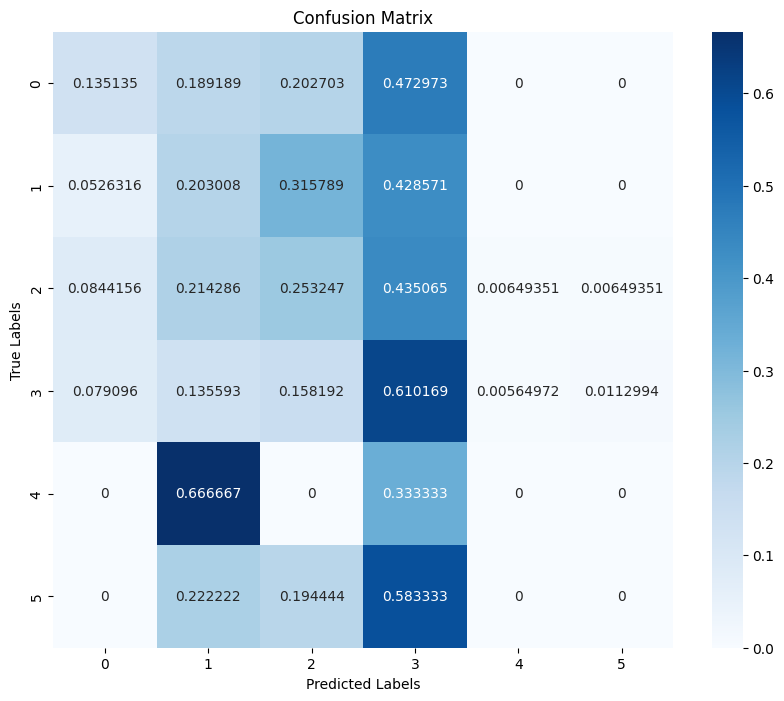

Epoch 15, Validation Loss: 3.5008, Accuracy: 0.3189, F1 Score: 0.2886
Val F1 Score Per Class  [0.16949153 0.22406639 0.27368421 0.46351931 0.         0.        ]


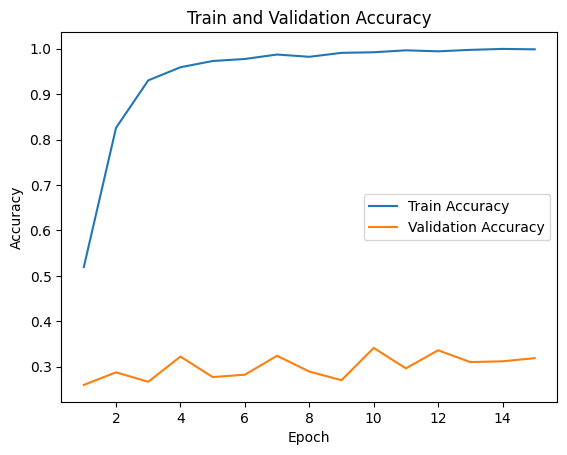

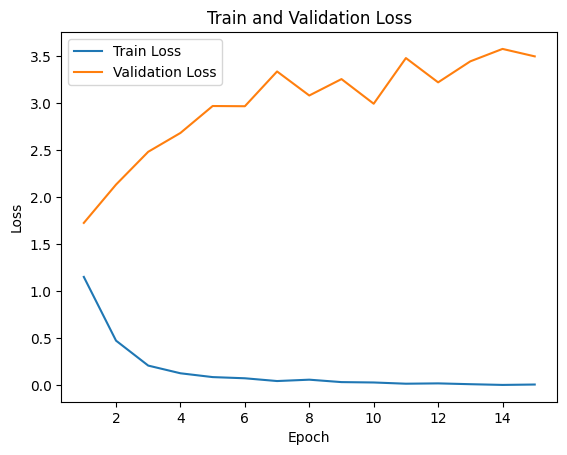

Epoch 16, Train Loss: 0.0015, Accuracy: 0.9996, F1 Score: 0.9996
Train F1 Score Per Class  [1.         0.99940048 0.99939467 0.99882214 1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.43it/s, loss=3.78]

[tensor([ 1.0320,  0.5529, -1.7975,  0.0436, -6.9627, -4.3966], device='cuda:0'), tensor([-1.2626, -2.6019, -0.8177,  5.5461, -3.4425, -3.3770], device='cuda:0'), tensor([-2.1799, -1.8714, -1.1582,  6.5609, -4.3126, -4.3072], device='cuda:0'), tensor([-1.3523, -2.5727,  4.4982, -1.4311, -5.9484, -3.4896], device='cuda:0'), tensor([-0.4615, -4.1347,  4.8939,  0.2961, -3.7284, -3.5271], device='cuda:0'), tensor([ 0.1417, -1.9738,  0.5609, -0.7394, -6.2430, -4.8049], device='cuda:0'), tensor([-4.2114,  0.5249,  0.6483,  0.4775, -4.0608, -3.0101], device='cuda:0'), tensor([-1.1457, -2.3259, -0.1938,  5.6598, -5.0969, -4.9561], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.41it/s, loss=4.24]

[tensor([-3.1807,  0.5797, -1.5848,  3.6309, -3.7312, -4.1095], device='cuda:0'), tensor([-2.9192, -3.0929,  0.4273,  3.8489, -5.1574, -4.0539], device='cuda:0'), tensor([ 0.8263, -3.4942, -1.1054,  1.2887, -3.4961, -2.8907], device='cuda:0'), tensor([-3.8369, -2.1121, -1.8939,  2.0843, -2.5524, -2.8408], device='cuda:0'), tensor([-1.9086, -0.1101, -2.3225,  6.6461, -4.4068, -3.2110], device='cuda:0'), tensor([-3.4083,  1.2118, -2.7631, -1.1319, -5.2711, -4.1442], device='cuda:0'), tensor([-3.8421, -0.2742, -2.0435,  4.9590, -4.5416, -2.5791], device='cuda:0'), tensor([-0.7695, -2.1951, -3.1075,  4.3429, -4.4848, -1.3557], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=2.62]

[tensor([-2.9262, -0.8463, -2.5680,  4.0702, -4.6065, -3.9641], device='cuda:0'), tensor([-3.7127, -1.7280,  3.4530,  3.2519, -3.6748, -4.7220], device='cuda:0'), tensor([-1.9390,  6.1819, -1.4011, -2.5458, -3.1577, -2.7683], device='cuda:0'), tensor([-2.4278,  0.1863, -0.6737, -1.9534, -4.0679, -3.9327], device='cuda:0'), tensor([ 2.9962, -0.9698, -3.1540,  0.7676, -4.5113, -2.4737], device='cuda:0'), tensor([-1.5803, -1.3964,  5.6581, -1.8007, -5.0090, -4.1238], device='cuda:0'), tensor([-1.1875, -1.7617, -2.4221,  1.3902, -4.8328, -2.2261], device='cuda:0'), tensor([-2.0568, -2.0111,  2.9594,  3.0037, -5.1105, -4.5434], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.40it/s, loss=3.82]

[tensor([ 4.8928, -1.1864, -2.3281, -0.8591, -3.0949, -2.7128], device='cuda:0'), tensor([-2.6371, -2.5400, -1.3074,  6.8746, -3.1121, -3.5596], device='cuda:0'), tensor([-3.4490,  0.0211,  0.4527,  2.7294, -5.3021, -4.5982], device='cuda:0'), tensor([-1.7635,  4.6772, -2.3536, -0.2262, -4.2162, -2.6650], device='cuda:0'), tensor([-1.1295, -2.8407,  7.3702, -2.0880, -3.9033, -2.1746], device='cuda:0'), tensor([-1.1181, -2.5610, -1.7045,  2.2340, -6.1002, -4.0912], device='cuda:0'), tensor([-2.6809, -4.1366,  2.0684,  3.0756, -3.7443, -1.4599], device='cuda:0'), tensor([-0.2735, -2.3891, -0.4700,  3.1915, -4.7651, -4.5259], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=4.44]

[tensor([-3.3675,  0.6353,  0.0064, -2.4817, -5.2579, -3.1564], device='cuda:0'), tensor([-2.3617, -3.4520,  0.7364, -0.3022, -4.2167, -1.5448], device='cuda:0'), tensor([-2.1283, -0.5723,  0.2831, -0.1410, -5.5766, -4.2503], device='cuda:0'), tensor([-2.1949, -1.6275,  7.4433, -2.0400, -3.7529, -3.3309], device='cuda:0'), tensor([-3.1707, -2.5710,  4.0430, -1.1982, -3.7995, -1.3629], device='cuda:0'), tensor([-3.1863, -1.1966,  2.1748,  2.9015, -5.0396, -3.9056], device='cuda:0'), tensor([-3.5236, -0.9142,  2.2051,  0.1936, -5.9414, -3.7658], device='cuda:0'), tensor([-3.9936,  3.8788, -1.4270,  1.6922, -5.1705, -5.2105], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.40it/s, loss=4.36]

[tensor([-1.4193, -0.8204, -3.0986,  3.6814, -4.9518, -4.4359], device='cuda:0'), tensor([-1.6050, -0.3514, -2.1217,  0.9105, -4.0097, -2.1051], device='cuda:0'), tensor([-3.7537,  1.6551,  0.4774,  0.3853, -5.5961, -2.8777], device='cuda:0'), tensor([-1.9198, -1.7228, -0.0142, -1.1420, -5.8929, -4.2243], device='cuda:0'), tensor([ 0.9271,  0.7598,  0.4059, -0.2732, -5.4157, -3.8298], device='cuda:0'), tensor([-3.5617, -0.9745,  6.8065, -1.3313, -4.3541, -3.5838], device='cuda:0'), tensor([-2.9543,  6.3267, -1.0795, -2.6923, -3.8761, -2.8333], device='cuda:0'), tensor([-2.1775,  5.5671, -2.0417, -1.0833, -3.7958, -2.8649], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=2.33]

[tensor([-2.1068, -3.0789,  4.5108, -1.5415, -4.9918, -4.0847], device='cuda:0'), tensor([-2.4165, -2.6270,  7.3575, -0.9966, -4.2192, -3.0581], device='cuda:0'), tensor([-0.9080, -2.9186, -0.8544,  5.1739, -4.2168, -1.5935], device='cuda:0'), tensor([-1.4620, -2.2685, -0.4672, -0.3931, -5.2803, -3.0082], device='cuda:0'), tensor([-0.5296, -1.3745,  6.1254, -0.6650, -4.8597, -4.5124], device='cuda:0'), tensor([-2.8391, -1.8915, -2.1212,  5.8434, -3.9124, -1.2826], device='cuda:0'), tensor([-3.9888, -0.2316, -2.3385, -0.1018, -4.1062, -2.8306], device='cuda:0'), tensor([-1.3966, -2.0549,  7.6747, -2.0617, -2.8279, -2.1736], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.40it/s, loss=3.79]

[tensor([-2.8882,  3.4060, -1.8001,  0.5702, -3.1184, -3.5698], device='cuda:0'), tensor([-2.6073,  0.2977, -2.3463, -0.9968, -2.9296, -1.2018], device='cuda:0'), tensor([ 3.8078, -2.2036, -2.7562, -1.5393, -4.5281, -1.3451], device='cuda:0'), tensor([-2.9080, -0.4295, -1.3544,  6.4937, -5.1148, -3.7133], device='cuda:0'), tensor([-3.1701, -0.3413, -2.3042,  0.1830, -4.8209, -2.2340], device='cuda:0'), tensor([-2.1342, -3.7659, -1.3310,  5.8925, -4.0583, -2.7633], device='cuda:0'), tensor([-1.3172, -3.5689,  3.6204,  0.5488, -5.5297, -4.0339], device='cuda:0'), tensor([-3.8830, -1.0897, -1.9760,  6.0797, -4.4618, -3.3228], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.40it/s, loss=3.23]

[tensor([-3.5144,  5.9473, -1.2837, -0.1279, -4.7639, -3.1160], device='cuda:0'), tensor([-3.2463, -3.1241,  0.4650,  5.8467, -4.9138, -3.1690], device='cuda:0'), tensor([ 1.2013, -3.5725, -1.5780,  5.5667, -4.8252, -2.8803], device='cuda:0'), tensor([-3.5357, -1.0384, -2.2425,  3.0163, -4.6552, -3.5355], device='cuda:0'), tensor([-2.2914, -2.2687,  0.1028,  3.2781, -5.3749, -4.1692], device='cuda:0'), tensor([-2.7590,  1.8228, -2.4684,  1.5720, -5.3150, -4.5427], device='cuda:0'), tensor([-4.2144, -1.9499,  2.9586, -0.1938, -4.5173, -3.3911], device='cuda:0'), tensor([-3.2960, -2.6867,  0.5706,  4.1535, -5.9038, -2.9761], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.40it/s, loss=4.85]

[tensor([-2.6100, -0.6963, -2.4027,  3.6708, -5.3484, -4.7247], device='cuda:0'), tensor([-2.5393, -2.4145, -1.3583,  6.9588, -3.9467, -2.7823], device='cuda:0'), tensor([-2.6365,  0.5192, -0.7377, -1.1415, -5.3894, -5.1367], device='cuda:0'), tensor([-2.9934, -1.0978,  2.2717, -1.0549, -4.8817, -4.8029], device='cuda:0'), tensor([-2.6010,  4.6168,  0.3791, -2.5405, -4.3072, -4.1024], device='cuda:0'), tensor([-3.7904, -0.3721, -1.1893,  0.3857, -4.9608, -3.7309], device='cuda:0'), tensor([ 2.1302, -1.0897, -0.4129,  1.2624, -5.4190, -5.3094], device='cuda:0'), tensor([-2.5564, -1.4503, -1.5066,  2.7663, -5.6002, -4.7900], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.40it/s, loss=3.31]

[tensor([-2.4615,  3.8505, -1.8789,  0.6722, -4.0398, -4.3541], device='cuda:0'), tensor([-3.3454, -1.2210, -0.5173,  1.7729, -5.0421, -3.2573], device='cuda:0'), tensor([-4.1813,  1.1205, -1.5794,  1.9858, -5.4696, -4.3436], device='cuda:0'), tensor([-2.9131, -2.8687,  6.1752, -0.2863, -3.7774, -2.9100], device='cuda:0'), tensor([-2.9633, -2.3991,  5.5236,  1.3658, -4.9485, -3.2625], device='cuda:0'), tensor([-3.4016, -1.8932, -1.5285,  7.0326, -4.5476, -2.6922], device='cuda:0'), tensor([-2.2467,  2.0177, -2.0578, -0.4489, -5.3991, -5.2097], device='cuda:0'), tensor([-3.1061, -2.4846,  1.1121,  2.8347, -5.2895, -3.3670], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=3.17]

[tensor([-1.7823, -1.6938, -1.4511, -0.8147, -5.3962, -5.0959], device='cuda:0'), tensor([-1.9180, -3.0171,  0.2404,  0.6553, -5.6642, -3.8505], device='cuda:0'), tensor([-2.6609, -3.2986, -1.0312,  6.6012, -3.9459, -2.4351], device='cuda:0'), tensor([-2.5870, -1.7476, -1.9162,  3.9992, -5.5952, -3.0411], device='cuda:0'), tensor([-1.5632,  2.1289, -2.2853, -0.9584, -5.5974, -4.4435], device='cuda:0'), tensor([-1.8533, -0.4480, -2.5863,  0.2736, -4.9192, -4.0058], device='cuda:0'), tensor([-3.4174, -3.1675,  2.1537, -0.2571, -4.0232, -0.7821], device='cuda:0'), tensor([-0.4420, -2.5650,  0.3591,  2.0518, -5.7660, -3.7684], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.40it/s, loss=3.75]

[tensor([-3.1359, -1.3861, -2.2028,  3.9099, -3.1029, -1.5460], device='cuda:0'), tensor([-2.2831, -2.6487, -0.3272,  5.3119, -5.6120, -4.0929], device='cuda:0'), tensor([-2.5063,  0.5014, -4.4258,  3.1275, -4.2766, -1.1778], device='cuda:0'), tensor([-3.2232, -2.4372,  6.0888,  1.0447, -4.1374, -3.9606], device='cuda:0'), tensor([-3.0202, -1.5972, -1.1915,  5.0688, -5.1474, -3.6514], device='cuda:0'), tensor([ 0.3738, -2.8187, -2.7561,  2.1693, -4.2964, -4.6761], device='cuda:0'), tensor([-3.8442,  2.1743, -2.0468, -0.7484, -4.7867, -3.9326], device='cuda:0'), tensor([-2.9140,  4.2719, -1.6667,  0.5630, -4.9394, -4.8056], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.9]

[tensor([-1.8315, -0.9701,  6.9697, -2.3865, -2.9738, -2.9501], device='cuda:0'), tensor([-1.5484, -0.1890, -2.7193, -0.6819, -4.5589, -4.8415], device='cuda:0'), tensor([ 1.1164, -1.8296, -0.9652,  0.1829, -5.3291, -4.5823], device='cuda:0'), tensor([-1.6955, -2.1753,  0.2514, -0.0874, -5.3856, -4.4574], device='cuda:0'), tensor([-2.6629,  3.3442, -1.8234, -0.6060, -5.2696, -4.6494], device='cuda:0'), tensor([-2.7255, -0.8768,  0.1578,  3.0321, -4.5061, -4.1332], device='cuda:0'), tensor([-2.0936, -1.2424, -1.7863,  0.6870, -5.2155, -5.6334], device='cuda:0'), tensor([-1.4419, -1.4784, -1.6356,  0.8314, -4.9828, -4.3491], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=2.88]

[tensor([-2.7162, -2.1126, -1.3436,  1.4379, -4.2582, -4.5732], device='cuda:0'), tensor([-4.4575, -0.9659, -2.0684,  4.8466, -4.7545, -3.2492], device='cuda:0'), tensor([-2.0651, -4.2721,  0.3694,  0.9965, -3.0953, -2.2877], device='cuda:0'), tensor([-1.1626, -1.1824, -0.2812, -2.5819, -5.2403, -3.6385], device='cuda:0'), tensor([-2.8011, -1.6558,  5.8786, -1.6864, -4.4099, -4.0939], device='cuda:0'), tensor([ 0.2756, -3.9642,  0.2295,  4.6086, -5.3515, -3.6050], device='cuda:0'), tensor([-2.6643, -0.4181, -2.3796,  4.1211, -3.6907, -2.7156], device='cuda:0'), tensor([-3.7040,  0.4118, -0.3409,  0.4489, -4.9032, -4.4839], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.38it/s, loss=4.96]

[tensor([ 0.2530, -0.9217, -0.8808,  4.6528, -4.8821, -5.2263], device='cuda:0'), tensor([-4.0401, -1.6338, -1.5634,  6.5516, -4.7884, -3.3309], device='cuda:0'), tensor([-3.8101, -1.5345, -0.3005, -1.1103, -4.9762,  4.9622], device='cuda:0'), tensor([-2.8095, -2.5129,  0.1776,  5.9458, -5.0666, -3.8990], device='cuda:0'), tensor([ 7.3923, -1.8365, -0.7076, -0.9528, -3.7040, -3.3175], device='cuda:0'), tensor([-0.7855,  0.9045, -1.8755,  1.4801, -5.2071, -4.4594], device='cuda:0'), tensor([-2.1563, -1.9930, -1.1436, -1.0160, -4.4527, -3.4535], device='cuda:0'), tensor([ 4.9485, -1.7604, -3.4567, -0.7251, -3.4600, -0.4680], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=4.67]

[tensor([-2.6510,  4.7844,  0.5183, -1.5373, -4.3434, -4.1278], device='cuda:0'), tensor([-1.5066, -1.1557, -1.3710,  4.5165, -5.7824, -5.1968], device='cuda:0'), tensor([-3.8683,  1.0631, -0.9670,  1.2199, -5.8352,  0.1371], device='cuda:0'), tensor([-2.9136, -1.9773,  6.0842, -1.0121, -4.3384, -3.5966], device='cuda:0'), tensor([ 7.8067, -2.5429, -0.8085, -0.6539, -3.2345, -3.1039], device='cuda:0'), tensor([-0.8388,  5.0400, -2.3555, -0.8027, -4.4963, -4.5841], device='cuda:0'), tensor([-1.9636, -2.9736,  7.3327, -0.5829, -3.8443, -2.7163], device='cuda:0'), tensor([-2.3476, -2.7819,  0.8700,  1.8359, -5.2125, -3.9068], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.39it/s, loss=3.51]

[tensor([-2.4059, -0.6926, -2.5887,  2.9543, -3.5004, -3.2418], device='cuda:0'), tensor([-3.1286, -1.9513,  3.5234,  0.3155, -3.5862, -3.7456], device='cuda:0'), tensor([-3.5810,  2.2124, -0.5550, -0.3396, -4.8130, -3.9553], device='cuda:0'), tensor([-2.8144, -2.9744, -1.4433,  6.7644, -3.1133, -2.7922], device='cuda:0'), tensor([-3.7078,  0.3775, -2.6184,  0.9789, -4.4961, -1.1685], device='cuda:0'), tensor([ 7.1641, -1.8593, -1.7215, -0.9863, -4.7157, -2.9988], device='cuda:0'), tensor([-1.8474, -2.3743, -1.5295,  2.6034, -4.8130, -3.9944], device='cuda:0'), tensor([-1.9456, -3.1942,  5.1016, -1.8468, -5.6315, -3.0712], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.38it/s, loss=3.6]

[tensor([-4.3478, -1.8861, -0.6513,  2.8835, -4.9958, -4.4291], device='cuda:0'), tensor([-3.0437, -2.2763,  5.3950,  0.1274, -3.8075, -3.8780], device='cuda:0'), tensor([-0.5642, -3.3069,  4.5403, -1.6572, -3.6943, -0.8776], device='cuda:0'), tensor([-2.7770,  1.4152,  0.8770,  0.9381, -2.3612, -5.0560], device='cuda:0'), tensor([-4.4948,  3.1180, -0.0089, -0.3961, -4.3226, -2.6866], device='cuda:0'), tensor([-2.6850,  0.8639, -2.9850,  1.2513, -4.3325, -3.5481], device='cuda:0'), tensor([-2.0033, -2.1144, -0.9613,  6.9952, -4.5154, -3.1590], device='cuda:0'), tensor([-0.6937, -1.3030, -2.9007,  3.6892, -4.4865, -4.1914], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.38it/s, loss=2.35]

[tensor([-4.2725,  2.8455, -0.3784, -0.8839, -4.6924, -2.7337], device='cuda:0'), tensor([-1.1170, -3.0787, -0.9185,  5.1387, -5.5173, -3.9502], device='cuda:0'), tensor([-2.7999, -1.5794,  5.8877, -1.8080, -4.9107, -3.7483], device='cuda:0'), tensor([-3.1655,  2.7610,  1.6425, -2.6438, -4.5530, -3.4725], device='cuda:0'), tensor([-4.3394,  1.1647, -2.6599,  0.2415, -4.7901, -4.8772], device='cuda:0'), tensor([-3.9255, -1.7095,  0.2476,  0.0801, -4.7480, -3.0474], device='cuda:0'), tensor([-2.2340,  0.5974,  1.1234, -0.2143, -4.2829, -3.9591], device='cuda:0'), tensor([-1.5170,  5.1645, -2.5348, -0.6683, -3.5371, -3.6023], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=7.37]

[tensor([-1.8826, -2.2579,  7.5040, -2.1446, -3.3065, -1.8651], device='cuda:0'), tensor([-1.2392,  4.6143, -2.2229, -0.5303, -4.7784, -3.8187], device='cuda:0'), tensor([-3.2331, -0.8830, -2.5800,  6.0491, -4.7779, -4.6947], device='cuda:0'), tensor([-2.8949, -0.4050, -3.1445,  5.7814, -4.8241, -3.6806], device='cuda:0'), tensor([-2.8805,  6.3374, -2.5241, -1.8936, -3.2816, -1.5941], device='cuda:0'), tensor([-1.9788, -3.9931, -2.0128,  2.0764, -4.9200, -3.2530], device='cuda:0'), tensor([-0.9974,  6.6314, -1.8448, -2.0256, -4.6595, -2.4623], device='cuda:0'), tensor([ 2.4334, -2.5614, -1.9327,  3.1574, -4.6329, -5.5371], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.39it/s, loss=2.89]

[tensor([-0.2981, -2.4574,  1.9501, -1.9077, -4.0646, -3.9132], device='cuda:0'), tensor([-2.1046, -3.0216,  4.5911, -0.9877, -5.1619, -3.9809], device='cuda:0'), tensor([-0.2206, -0.4879,  3.8352, -0.9241, -6.9242, -5.0380], device='cuda:0'), tensor([-2.6987, -2.0292, -0.3213,  4.6474, -4.6749, -3.8150], device='cuda:0'), tensor([-3.5021,  0.1123, -2.6117,  0.1089, -4.6517, -4.0416], device='cuda:0'), tensor([ 1.3858, -3.1804,  0.6291, -0.9582, -5.2301, -4.1083], device='cuda:0'), tensor([-2.0056, -2.6772,  0.1248,  4.8458, -6.4347, -3.0278], device='cuda:0'), tensor([-1.4515, -3.1419,  5.3516, -0.6645, -5.1580, -4.0032], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.38it/s, loss=3.9]

[tensor([-1.8476, -3.0449, -2.7292, -0.7993, -3.1072, -2.8798], device='cuda:0'), tensor([-0.3854, -0.1536,  0.1361, -2.3332, -4.5397, -4.8746], device='cuda:0'), tensor([-2.5583, -1.0555, -2.0014,  6.2736, -4.8711, -3.6791], device='cuda:0'), tensor([-1.8157,  5.8766, -0.7606, -2.5388, -3.2641, -2.6072], device='cuda:0'), tensor([-2.7552, -0.4480, -2.8647,  0.4327, -4.7552, -3.4592], device='cuda:0'), tensor([-3.6037,  5.4589, -0.9120, -0.5860, -4.2930, -3.5662], device='cuda:0'), tensor([-1.6983, -3.8154,  2.0738,  0.2313, -4.6600, -2.9623], device='cuda:0'), tensor([-3.3449,  4.1764, -1.7195, -0.7749, -5.2593, -1.8055], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.38it/s, loss=4.39]

[tensor([-1.2843, -3.4477,  0.5901,  5.4449, -4.5550, -4.7985], device='cuda:0'), tensor([-2.6457, -1.4455,  0.2333,  2.8069, -5.4991, -4.6102], device='cuda:0'), tensor([-3.5509,  1.1225, -2.7241,  2.5192, -5.9764, -3.8683], device='cuda:0'), tensor([-1.0962, -5.3876, -1.0027,  1.5073, -4.1244,  0.4701], device='cuda:0'), tensor([-1.0752, -3.2678, -2.1452,  5.7620, -3.9383, -2.8868], device='cuda:0'), tensor([-2.7445, -1.5610, -1.8636,  1.4240, -4.8040, -3.3750], device='cuda:0'), tensor([-1.0893, -0.6535, -2.7972, -1.5171, -3.9745, -0.6697], device='cuda:0'), tensor([-1.3901, -3.1802, -1.4591,  6.1293, -4.3068, -3.6777], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=3.25]

[tensor([-3.0970, -2.3311,  6.7385, -0.6444, -4.5443, -3.4386], device='cuda:0'), tensor([-1.8595, -1.8367,  7.2504, -1.8518, -2.8733, -2.6353], device='cuda:0'), tensor([-3.5877, -1.7005,  0.6187,  1.4028, -4.9673, -4.0675], device='cuda:0'), tensor([-3.5983,  2.7560, -1.1265,  0.8634, -5.1003, -4.2557], device='cuda:0'), tensor([-2.2752,  0.3847, -2.7812, -1.4103, -4.6427, -3.3919], device='cuda:0'), tensor([-3.6031, -3.2281,  2.7559, -0.0669, -3.9797, -3.1931], device='cuda:0'), tensor([-1.5661, -0.3734, -3.8540,  2.5389, -4.0637, -3.3715], device='cuda:0'), tensor([ 0.8508, -1.3075, -2.2554,  0.3527, -3.3084, -3.4508], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=1.89]

[tensor([-2.6748, -1.7217, -1.0079,  5.6178, -5.3820, -3.7106], device='cuda:0'), tensor([-3.1032, -2.7230, -0.7390,  3.5298, -5.7250, -3.5873], device='cuda:0'), tensor([-3.3958, -2.5102,  2.8882,  0.0967, -4.3419, -3.5087], device='cuda:0'), tensor([ 6.4362, -2.1059, -1.2424, -0.8702, -3.6079, -1.8210], device='cuda:0'), tensor([-3.4085,  2.5932, -1.7706,  4.2642, -5.6737, -4.1717], device='cuda:0'), tensor([-0.8407, -2.2850,  4.0334,  0.7423, -4.6695, -3.5004], device='cuda:0'), tensor([-1.0279,  0.5925, -1.7082,  2.1489, -4.4607, -4.8953], device='cuda:0'), tensor([-2.7849, -1.3265, -0.5436, -1.3258, -6.4919, -2.5625], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.38it/s, loss=2.7]

[tensor([-3.6506, -1.7780,  2.0228,  4.2458, -5.4257, -4.2271], device='cuda:0'), tensor([-3.9269, -1.0742, -0.7698,  0.7267, -4.7407, -4.5835], device='cuda:0'), tensor([-1.8883, -1.9781, -0.9868,  3.1594, -4.2669, -4.5628], device='cuda:0'), tensor([-2.3307, -3.1038,  2.2994,  3.4930, -5.6585, -3.3234], device='cuda:0'), tensor([-2.6295,  4.1331, -0.8408, -0.2238, -4.4855, -3.6228], device='cuda:0'), tensor([-0.9729, -2.3984,  2.3776, -0.8635, -5.8931, -3.5078], device='cuda:0'), tensor([-2.8355, -3.2766,  4.2803,  0.4555, -5.0321, -2.8087], device='cuda:0'), tensor([-2.5611, -0.6577, -3.1123,  5.0699, -5.0071, -3.4294], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.38it/s, loss=3.51]

[tensor([-0.6841, -2.7771, -1.1859,  4.9364, -4.8430, -4.0369], device='cuda:0'), tensor([-3.2841, -0.9558, -1.4308,  4.0593, -4.5559, -3.7742], device='cuda:0'), tensor([-1.8662,  3.4233, -1.2170, -2.8366, -4.1112, -3.2526], device='cuda:0'), tensor([-3.2079, -2.1470, -0.1695,  3.5623, -4.3251, -4.1829], device='cuda:0'), tensor([-2.6310, -2.3214, -1.3104,  6.1510, -4.4255, -3.2442], device='cuda:0'), tensor([-3.7784,  0.1892, -0.0445,  3.4567, -5.4399, -4.9453], device='cuda:0'), tensor([-3.8095, -1.9125,  2.2958,  1.7310, -5.4186, -4.1791], device='cuda:0'), tensor([-2.8737,  3.3234, -1.0338, -1.6799, -4.7849, -4.3900], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.39it/s, loss=4.16]

[tensor([-3.6384, -0.4570, -1.1160,  6.0444, -4.5268, -3.0544], device='cuda:0'), tensor([-4.1811, -0.7154, -0.1664,  0.1581, -4.3951, -1.5386], device='cuda:0'), tensor([-4.3223, -3.4185,  3.8389,  0.7394, -4.7005, -3.1717], device='cuda:0'), tensor([-3.3058,  4.1921, -1.6192,  0.4983, -4.4509, -4.3920], device='cuda:0'), tensor([ 1.4859,  1.0505, -1.2686, -1.2969, -5.7076, -3.8186], device='cuda:0'), tensor([-3.9748, -1.8608,  0.5594,  0.0644, -5.0194, -3.1001], device='cuda:0'), tensor([-3.4974, -2.2397,  0.0113,  4.1226, -4.1303, -3.4819], device='cuda:0'), tensor([-3.4115, -1.3496, -1.0261,  6.2707, -4.9077, -3.9169], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.39it/s, loss=4.08]

[tensor([-4.2938,  4.1785, -0.8860,  0.0849, -4.7629, -3.4405], device='cuda:0'), tensor([-4.0509, -2.4407, -0.0662,  3.2807, -4.3743, -4.2346], device='cuda:0'), tensor([-2.0975, -1.0691, -2.3641, -1.3911, -4.1688, -2.7377], device='cuda:0'), tensor([-2.3123, -1.9373, -1.6305,  6.8379, -4.5855, -3.8080], device='cuda:0'), tensor([-2.3195, -0.4644, -2.5046, -1.7184, -5.4931, -2.7337], device='cuda:0'), tensor([-1.6773, -2.6331,  4.5410, -1.3455, -3.7652, -2.3402], device='cuda:0'), tensor([-3.4035, -3.6668,  3.1478,  2.4195, -5.9401, -4.7510], device='cuda:0'), tensor([-0.8696, -1.8495, -0.2506, -1.9411, -3.0354,  8.2746], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.39it/s, loss=3.69]

[tensor([-2.9965, -0.2213, -3.3749,  4.1722, -4.0760, -2.5276], device='cuda:0'), tensor([-2.7372, -2.3508, -1.4066,  6.7466, -4.8572, -3.0385], device='cuda:0'), tensor([-3.9187,  1.9465, -0.6682,  0.6407, -5.5024, -2.1487], device='cuda:0'), tensor([-1.7791,  5.2385, -3.2590, -0.9441, -4.8272, -2.8783], device='cuda:0'), tensor([-2.8526,  1.9716,  0.9228, -0.6268, -4.9425, -3.5719], device='cuda:0'), tensor([ 7.9553, -0.7767, -1.8166, -2.0701, -2.3423, -1.5414], device='cuda:0'), tensor([-2.0968, -3.0301, -0.4514,  6.2601, -3.9035, -3.8571], device='cuda:0'), tensor([-2.7661, -1.4608,  6.2325, -0.5996, -4.7506, -3.8974], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=5.19]

[tensor([-2.6485, -1.1592, -3.0362,  0.0629, -4.0386, -2.6695], device='cuda:0'), tensor([-2.6444, -1.9303, -1.8578,  7.0923, -4.1218, -2.9785], device='cuda:0'), tensor([-1.9316,  7.2009, -2.4208, -1.2975, -2.4405, -2.7404], device='cuda:0'), tensor([-3.3026,  1.7913, -1.6164, -1.4151,  4.6002, -1.9373], device='cuda:0'), tensor([-1.8541, -0.0233,  1.0189, -1.3424, -3.3308, -4.1587], device='cuda:0'), tensor([-2.0115, -3.0553, -0.1677,  4.0421, -5.0311, -3.3296], device='cuda:0'), tensor([ 3.8843, -2.9117, -1.3873, -0.4923, -4.9539, -2.6842], device='cuda:0'), tensor([ 1.5511, -1.0573, -2.7846,  0.4264, -5.2538, -3.6359], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.38it/s, loss=6.16]

[tensor([-3.7503, -2.6269, -0.5601,  5.0101, -3.8549, -1.8949], device='cuda:0'), tensor([-3.5442,  3.7110, -2.0210,  2.7955, -4.4122, -3.1547], device='cuda:0'), tensor([-2.2014, -3.0986, -1.1879,  6.0256, -5.3524, -3.2422], device='cuda:0'), tensor([-2.0484,  6.5193, -0.6261, -2.3058, -3.7430, -3.6120], device='cuda:0'), tensor([-3.3546, -2.0078,  7.2482, -1.4198, -3.1875, -3.0276], device='cuda:0'), tensor([-1.8687, -3.5357, -0.7680,  4.5890, -4.3741, -2.7484], device='cuda:0'), tensor([-1.7724,  3.5823, -2.4722, -1.7286, -5.1302, -3.7658], device='cuda:0'), tensor([-3.4268,  0.3455, -1.2781,  3.4100, -4.1839, -3.9083], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.39it/s, loss=3.86]

[tensor([ 7.6499, -0.4040, -2.6981, -1.5377, -2.5969, -2.4674], device='cuda:0'), tensor([-2.4196, -0.6741, -0.8566,  0.6850, -6.3111, -5.0246], device='cuda:0'), tensor([-3.3117,  0.4916, -1.5488,  1.0928, -0.7075, -3.9384], device='cuda:0'), tensor([-3.5737, -3.5603, -1.1129,  5.3012, -3.9785, -1.7825], device='cuda:0'), tensor([-2.9318,  1.0764, -1.7153,  2.8506, -4.4963, -4.5498], device='cuda:0'), tensor([-3.5535,  0.2183, -0.7769,  1.9559, -5.2715, -3.2544], device='cuda:0'), tensor([-1.8427, -3.1274, -1.4781,  5.8513, -4.5575, -3.4602], device='cuda:0'), tensor([-1.9153, -1.8632,  6.8156, -1.9635, -4.3303, -3.3231], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=3.59]

[tensor([-2.4325, -1.9336,  2.0219, -0.4649, -6.3707, -3.6032], device='cuda:0'), tensor([-1.3024,  1.1390,  0.6110, -1.7465, -4.5792, -4.4723], device='cuda:0'), tensor([-2.0798, -3.6074,  3.0202, -1.1673, -4.5680, -3.4758], device='cuda:0'), tensor([-2.0682, -1.6585,  7.6169, -1.6076, -3.2545, -2.6673], device='cuda:0'), tensor([-3.5041,  1.4987, -1.4055,  1.7204, -5.3640, -3.0683], device='cuda:0'), tensor([-2.0703, -3.4077, -0.3175,  1.9126, -4.5677, -0.9836], device='cuda:0'), tensor([-3.0117, -2.4273,  0.0272,  4.4895, -5.9820, -4.1518], device='cuda:0'), tensor([-2.3799, -0.5397,  1.7101,  2.1944, -5.2379, -4.7811], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=3.9]

[tensor([-3.1220, -0.7204,  4.1441, -2.0579, -4.0210, -3.1178], device='cuda:0'), tensor([-2.3046, -1.3642,  6.7780, -1.8212, -3.2726, -3.5341], device='cuda:0'), tensor([-2.5677, -2.8716, -0.3711,  1.0306, -4.9626, -2.3156], device='cuda:0'), tensor([-2.6651e+00,  6.1348e+00, -2.9345e+00,  1.8014e-04, -4.1948e+00,
        -3.1274e+00], device='cuda:0'), tensor([-2.6785, -2.9025, -0.7024,  2.2257, -5.1692, -3.3871], device='cuda:0'), tensor([-1.8643, -3.8015, -0.7119,  5.2966, -4.8149, -3.5556], device='cuda:0'), tensor([-2.0095, -2.0691, -1.9206,  7.2338, -3.8999, -3.1859], device='cuda:0'), tensor([-2.0992, -0.3870, -1.9779,  3.6085, -4.8160, -4.4510], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=5.01]

[tensor([ 0.3753, -2.7321, -2.1918,  3.5088, -4.1381, -2.9819], device='cuda:0'), tensor([-2.4911, -2.4123, -0.6076,  5.4586, -5.0337, -3.8093], device='cuda:0'), tensor([-2.5512, -2.1119, -2.8185,  4.5671, -3.9738, -3.4251], device='cuda:0'), tensor([-3.5089,  5.5553, -2.3374, -0.7857, -3.9205, -0.6329], device='cuda:0'), tensor([-2.5124,  1.1131,  4.6527, -2.5057, -4.6438, -2.6265], device='cuda:0'), tensor([-3.2098,  6.3186, -1.6871, -1.3786, -3.4012, -3.1587], device='cuda:0'), tensor([-1.9942,  2.6050, -0.9603,  1.1106, -4.9156, -4.5677], device='cuda:0'), tensor([-3.9575,  1.2998, -0.5221,  2.3230, -4.3809, -4.8929], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.37it/s, loss=3.91]

[tensor([-1.7508, -1.6589,  2.8315, -0.7238, -4.3829, -2.8061], device='cuda:0'), tensor([-3.3931, -0.3202, -1.5253,  2.3633, -6.0424, -1.8753], device='cuda:0'), tensor([-0.4142, -2.7183, -0.9244,  4.7000, -5.7067, -4.2084], device='cuda:0'), tensor([-3.7279,  2.1244, -2.7186, -0.3295, -4.0610, -4.2091], device='cuda:0'), tensor([-2.9751, -1.5201,  2.1364, -1.4978, -5.1900, -5.5402], device='cuda:0'), tensor([-2.0996,  6.4370, -2.5658, -0.6433, -3.3106, -3.0239], device='cuda:0'), tensor([-1.9948,  0.7344,  0.8901, -2.8555, -4.5004, -4.0929], device='cuda:0'), tensor([-2.7493, -2.8471,  5.6044,  0.0570, -5.2154, -4.2111], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.39it/s, loss=4.07]

[tensor([-1.4555, -1.8915,  2.6556, -0.1549, -5.2772, -5.1672], device='cuda:0'), tensor([-3.2470, -0.9206,  0.1068,  4.4737, -4.6097, -5.2009], device='cuda:0'), tensor([ 0.4459, -2.3491, -1.2074,  1.4007, -4.3965, -3.1414], device='cuda:0'), tensor([-1.0196, -3.3070, -0.3623,  2.0785, -5.7680, -4.1167], device='cuda:0'), tensor([-3.4695, -2.2519, -1.6891,  3.4745, -5.3520, -4.2905], device='cuda:0'), tensor([-2.9894, -1.7126,  6.8038, -1.3277, -4.2867, -2.9299], device='cuda:0'), tensor([ 3.9239, -2.4318,  0.1279, -1.0649, -4.3045, -4.1651], device='cuda:0'), tensor([-4.3022,  1.8213, -0.8116,  0.0956, -6.2686, -1.5567], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=4.02]

[tensor([ 1.0224, -1.9603, -0.0671,  1.6688, -4.8216, -4.2185], device='cuda:0'), tensor([-1.2514, -2.1656,  5.6901, -2.1791, -3.0827, -2.6733], device='cuda:0'), tensor([-2.8272, -2.0579, -1.4345,  4.9970, -5.9285, -2.4344], device='cuda:0'), tensor([ 1.9437, -2.1003, -3.4674,  2.8657, -3.6349, -3.3113], device='cuda:0'), tensor([-4.2478,  0.8790, -1.1622,  0.4581, -5.0392, -1.4995], device='cuda:0'), tensor([ 2.0665, -0.2436, -2.1433,  1.2302, -3.3291, -3.5578], device='cuda:0'), tensor([-3.5629, -0.6713, -1.1327,  5.5909, -4.3009, -4.1200], device='cuda:0'), tensor([-0.2588, -1.9730, -2.3265,  4.1981, -4.9078, -0.0416], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=3.01]

[tensor([-2.8338, -2.6099, -0.1669,  4.6699, -4.7693, -3.8604], device='cuda:0'), tensor([-2.8595,  0.3453,  1.8620,  1.2938, -3.2983, -5.3795], device='cuda:0'), tensor([-2.1198, -2.1100, -1.4997,  3.8916, -4.5980, -3.1598], device='cuda:0'), tensor([-3.9935,  0.6289, -1.9094,  4.7343, -5.0276, -3.7179], device='cuda:0'), tensor([-3.2311,  1.0820, -0.3016,  0.8544, -5.5307, -4.9235], device='cuda:0'), tensor([-2.5573, -2.7911, -0.8513,  6.3794, -4.4003, -3.5272], device='cuda:0'), tensor([-3.3721, -1.4953, -1.0890, -0.6237, -4.9770, -4.3886], device='cuda:0'), tensor([-0.4029, -1.3012, -1.5224,  2.2679, -4.8468, -4.8976], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=2.9]

[tensor([-2.6093, -3.1227,  0.5868,  5.5450, -4.5684, -3.7037], device='cuda:0'), tensor([ 5.0629, -2.1245,  1.2106, -0.9336, -4.3549, -3.1517], device='cuda:0'), tensor([-1.2439, -2.5874, -1.8599,  3.8144, -5.7012, -4.2700], device='cuda:0'), tensor([ 2.1831,  0.1661, -2.5390, -1.2293, -3.5683, -3.2952], device='cuda:0'), tensor([-3.5351, -2.2906,  1.7490,  2.9069, -4.0133, -3.3900], device='cuda:0'), tensor([-2.0478, -3.4111, -1.8485,  6.2697, -4.0579, -3.7890], device='cuda:0'), tensor([-3.4747, -2.7145,  1.6047,  2.9407, -4.4689, -2.6706], device='cuda:0'), tensor([ 1.7127, -1.9672,  0.2934,  0.8620, -4.8819, -5.4176], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.38it/s, loss=1.92]

[tensor([-3.0945, -0.9344, -1.7482,  6.0884, -4.6869, -3.5792], device='cuda:0'), tensor([-3.0884, -1.2726, -0.8466,  0.3015, -5.0962, -4.1242], device='cuda:0'), tensor([-1.2733,  0.1705, -1.7392, -0.6297, -6.4800, -4.5178], device='cuda:0'), tensor([-3.0875,  2.8015, -2.4703,  2.3862, -6.1335, -2.3330], device='cuda:0'), tensor([-2.7801,  1.1105, -3.0971,  1.4541, -5.2066, -3.3450], device='cuda:0'), tensor([-3.8242,  2.4934,  4.1286, -2.5044, -3.5122, -3.6241], device='cuda:0'), tensor([-3.0348, -1.5271,  1.3745,  3.9147, -5.3317, -4.0769], device='cuda:0'), tensor([-4.1362, -0.3241, -0.9041, -1.0029, -4.8761, -3.4996], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.37it/s, loss=4.12]

[tensor([-2.6047,  0.0514, -1.7162,  4.8417, -3.0882, -4.5923], device='cuda:0'), tensor([-1.9650, -2.2848,  3.5466,  1.0107, -5.7292, -4.3273], device='cuda:0'), tensor([-0.8470,  5.4880, -2.5502, -1.1770, -4.8284, -3.0321], device='cuda:0'), tensor([-1.8712, -1.4569, -1.7494, -1.2510, -1.8839,  8.5888], device='cuda:0'), tensor([-3.2551,  1.2004, -1.8980,  4.5256, -4.6496, -4.3490], device='cuda:0'), tensor([-1.9158, -0.6837, -2.8457,  2.8022, -4.8944, -3.3404], device='cuda:0'), tensor([-1.3831, -2.9352, -0.6316,  0.8355, -5.8736, -5.3756], device='cuda:0'), tensor([-2.5037, -2.0551, -1.2231,  6.6446, -4.1959, -3.9675], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.37it/s, loss=5.48]

[tensor([-1.1063,  2.1470,  1.2617, -2.0027, -5.5227, -2.1898], device='cuda:0'), tensor([-2.5430,  7.0587, -1.8570, -1.3642, -3.3457, -2.6000], device='cuda:0'), tensor([-1.7843,  6.7262, -2.1553, -1.2291, -4.4552, -3.8527], device='cuda:0'), tensor([-2.0770,  7.3709, -2.7402, -0.8394, -3.6015, -2.8210], device='cuda:0'), tensor([-1.6104, -2.9818, -2.1924,  6.8477, -4.9141, -2.3526], device='cuda:0'), tensor([ 0.1672, -1.4896, -1.6035,  2.2297, -5.3058, -3.0379], device='cuda:0'), tensor([ 0.7281, -0.3139, -2.3224, -2.3391,  1.8773, -2.8191], device='cuda:0'), tensor([-3.8364, -0.6497,  5.6064, -1.6257, -4.4255, -3.5516], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.37it/s, loss=4.39]

[tensor([-2.3731, -1.6822,  1.2789,  1.3159, -5.4337, -4.3021], device='cuda:0'), tensor([-1.6786, -2.5897, -1.1275, -0.1266, -6.4208, -3.8424], device='cuda:0'), tensor([-1.9458, -1.2899, -0.5178,  1.6925, -6.6067, -2.9618], device='cuda:0'), tensor([-2.3613, -2.6368,  6.7559, -0.9197, -4.1138, -3.3703], device='cuda:0'), tensor([-3.2465, -1.2974,  0.6346,  1.3325, -5.7817, -5.1235], device='cuda:0'), tensor([-2.3315, -2.2158, -1.1899, -1.2512, -5.2088, -4.3923], device='cuda:0'), tensor([-1.6662, -3.1733, -1.6294,  6.7326, -4.5725, -2.7829], device='cuda:0'), tensor([-1.7015,  2.4735, -2.0676,  0.5853, -5.4034, -3.5831], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=3.23]

[tensor([-4.0611, -1.8411,  1.1818, -0.7876, -3.8598, -2.0768], device='cuda:0'), tensor([-0.5147, -2.6630,  3.8741,  0.3290, -4.7228, -4.0149], device='cuda:0'), tensor([-1.6668,  0.2653,  3.5752, -2.6764, -4.5297, -4.2528], device='cuda:0'), tensor([-2.0718, -1.7293,  5.0281, -1.1212, -5.8380, -3.9344], device='cuda:0'), tensor([-3.5320, -1.0853, -0.2329,  1.1322, -4.8760, -3.3580], device='cuda:0'), tensor([-2.8649, -2.2720,  1.1117,  2.2391, -5.0807, -0.9602], device='cuda:0'), tensor([-3.5199, -1.7992, -1.0442, -0.6314, -4.3406, -2.9280], device='cuda:0'), tensor([-2.3108,  5.0014, -2.7303, -0.1469, -4.7131, -2.9818], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.37it/s, loss=2.53]

[tensor([-2.0190, -3.6290, -0.6321,  3.4068, -4.7483, -4.2136], device='cuda:0'), tensor([-3.8106,  0.8184, -0.5244,  0.9928, -5.2700, -1.3449], device='cuda:0'), tensor([ 0.2344, -2.7217, -1.9548, -1.5901, -4.2037, -1.3585], device='cuda:0'), tensor([-1.7084,  4.0042, -1.4101, -1.9115, -5.3806, -5.3847], device='cuda:0'), tensor([ 0.5169, -2.8644, -2.5357,  4.0558, -5.5601, -2.8386], device='cuda:0'), tensor([-3.6163, -2.2194,  2.2454,  0.2592, -4.7380, -3.5763], device='cuda:0'), tensor([-3.9544,  0.7035,  1.0668,  0.1332, -5.8086, -4.6098], device='cuda:0'), tensor([ 3.5237, -2.7566, -1.6244,  2.6968, -4.4186, -4.0369], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=3.9]

[tensor([-1.4763, -1.6112,  6.5685, -1.7862, -5.2646, -4.1162], device='cuda:0'), tensor([-3.3672,  5.4323,  0.6661, -1.3158, -4.0898, -3.9147], device='cuda:0'), tensor([-3.6783, -1.0277,  2.8599,  0.5504, -5.4250, -3.0413], device='cuda:0'), tensor([-0.6394, -2.6442, -0.0483,  4.1360, -5.0257, -3.4574], device='cuda:0'), tensor([ 1.0869, -0.8261, -2.0243, -1.6949, -5.0354, -3.5778], device='cuda:0'), tensor([-2.2903, -1.8741,  0.7651,  0.1344, -4.8067, -2.9576], device='cuda:0'), tensor([-2.7954, -2.0899,  0.4754,  1.1043, -4.4738, -4.6146], device='cuda:0'), tensor([-0.9005, -2.2747, -2.1709,  4.7005, -3.3743, -2.2540], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.38it/s, loss=2.74]

[tensor([-1.7889, -1.6379,  0.0117, -1.3497, -5.2002, -3.8568], device='cuda:0'), tensor([-2.6786,  3.1449, -1.0788, -1.3129, -4.7810, -2.7585], device='cuda:0'), tensor([ 2.4383, -0.5420, -2.5004,  2.0903, -5.8633, -3.3593], device='cuda:0'), tensor([-3.3212, -1.9852, -1.1258,  6.3144, -3.8956, -3.7734], device='cuda:0'), tensor([-2.0015,  5.7956, -1.7682, -0.8398, -4.9677, -3.9678], device='cuda:0'), tensor([-1.8133, -2.8916, -0.3889,  4.2421, -5.2288, -3.4537], device='cuda:0'), tensor([-3.6737, -1.1861,  0.3334,  0.0814, -4.9319, -3.9030], device='cuda:0'), tensor([-1.3104, -3.7620, -0.6509,  5.0720, -5.3739, -3.7907], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.37it/s, loss=2.5]

[tensor([-2.7158, -1.5209, -1.6102,  0.4808, -4.0535, -3.3029], device='cuda:0'), tensor([-2.9359, -2.7560,  2.3029,  3.9450, -5.1071, -3.8676], device='cuda:0'), tensor([-1.4304,  2.2788, -2.7230,  0.0539, -5.0005, -4.8260], device='cuda:0'), tensor([-2.7983,  2.6593, -3.0784,  0.8987, -5.7998, -4.5083], device='cuda:0'), tensor([-1.4467, -3.7185,  2.7108,  4.2176, -4.5211, -4.1561], device='cuda:0'), tensor([-3.7803, -2.4579,  2.1897,  4.2413, -5.1323, -4.1724], device='cuda:0'), tensor([-3.6350, -1.1805,  0.4684,  1.0447, -4.6211, -4.3096], device='cuda:0'), tensor([-3.3713, -3.7421, -0.8357,  5.2058, -4.3739, -4.0853], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=2.97]

[tensor([-3.9861,  2.0233, -2.5209,  1.2972, -3.8533, -0.9487], device='cuda:0'), tensor([-1.1580,  0.7160, -1.3076,  0.3379, -6.1467, -5.0902], device='cuda:0'), tensor([-3.5685,  1.4313, -2.2248, -0.1439, -3.7613, -4.0905], device='cuda:0'), tensor([-1.7603, -1.6602, -1.6493,  2.9437, -4.6239, -4.6143], device='cuda:0'), tensor([-3.1588, -1.9249,  5.3086, -0.8482, -4.6893, -4.9984], device='cuda:0'), tensor([-3.4037, -0.3968, -1.2905,  1.0345, -5.6664, -3.3270], device='cuda:0'), tensor([-2.6623,  7.3662, -2.2323, -0.8854, -3.4221, -2.8557], device='cuda:0'), tensor([-2.4832,  0.1380, -2.5048, -0.1065, -5.0735, -3.5859], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.38it/s, loss=0.995]

[tensor([ 0.3274, -2.5264, -0.8778,  1.7833, -5.3531, -3.4173], device='cuda:0'), tensor([-0.1885, -2.3067,  1.8022,  1.9203, -5.8377, -4.8650], device='cuda:0'), tensor([-3.0361, -3.6220,  1.0547, -0.9583, -5.2284, -2.3156], device='cuda:0'), tensor([-4.3676,  0.3380, -1.3865, -0.8547, -5.5527, -3.7643], device='cuda:0'), tensor([-1.7144, -3.0526, -1.4958,  1.4860, -5.8249, -4.1151], device='cuda:0'), tensor([-3.0430, -1.5740, -1.2673,  1.4813, -5.2433, -4.4954], device='cuda:0'), tensor([-2.3160,  2.5211, -0.0852, -1.0572, -4.6648, -2.9491], device='cuda:0'), tensor([-1.2908, -4.0444,  0.3031,  2.6967, -4.6205, -3.7887], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.34it/s, loss=2.16]

[tensor([-3.6068,  6.1923, -1.3105, -0.5598, -4.6568, -2.4938], device='cuda:0'), tensor([-3.8600, -0.6328,  1.2801,  1.3030, -5.4383, -4.7021], device='cuda:0'), tensor([ 2.9600, -1.2681,  0.0882, -0.7859, -5.4321, -4.9227], device='cuda:0'), tensor([-2.1267, -1.4909, -1.4037,  5.8046, -5.3361, -3.6041], device='cuda:0'), tensor([-2.9942, -2.7329, -0.6918,  2.3584, -5.7170, -3.7465], device='cuda:0'), tensor([-3.7280, -1.3855,  3.5417, -0.9889, -5.1128, -4.1520], device='cuda:0'), tensor([-2.7486, -1.0774, -2.3731,  3.4609, -5.4876, -4.1036], device='cuda:0'), tensor([-2.9354, -1.6989, -1.5456,  7.2204, -4.3731, -3.0496], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.37it/s, loss=2.86]

[tensor([ 5.0346, -2.8088, -1.4454,  0.7558, -4.9003, -4.0280], device='cuda:0'), tensor([-0.0709, -0.9528,  0.7336, -1.6789, -5.5363, -3.4135], device='cuda:0'), tensor([-2.8148, -0.7012,  0.8237,  0.2613, -4.8891, -4.1167], device='cuda:0'), tensor([-2.6385, -1.8684,  7.2534, -0.7925, -4.2351, -2.6547], device='cuda:0'), tensor([-1.3497,  0.4453, -3.2981,  0.0372, -4.1545, -1.1551], device='cuda:0'), tensor([-2.0725, -1.4330,  4.0923, -0.8020, -5.9016, -5.0932], device='cuda:0'), tensor([-3.0851,  1.7080, -1.9467, -0.0318, -4.9923, -4.9416], device='cuda:0'), tensor([-4.0021,  3.9981, -1.5186, -1.1191, -5.5141, -3.4703], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.35it/s, loss=6.19]

[tensor([-1.0790, -3.4627, -1.2054,  5.8260, -5.0054, -2.5558], device='cuda:0'), tensor([-3.9393, -0.6886, -1.0829,  1.6485, -4.6820, -4.5050], device='cuda:0'), tensor([-2.3031, -3.2988, -0.7122,  5.0059, -6.1738, -2.4934], device='cuda:0'), tensor([-2.3975, -1.4681, -1.5725,  4.5311, -5.4461, -4.7770], device='cuda:0'), tensor([-1.5665, -2.6566,  5.8882, -1.4725, -2.9681, -2.9478], device='cuda:0'), tensor([-3.2920, -3.6180,  0.3239,  3.8400, -6.5164, -3.4279], device='cuda:0'), tensor([ 0.1686, -2.9640,  4.3269,  1.3161, -5.4188, -5.3728], device='cuda:0'), tensor([-2.1777, -3.6526, -1.0054,  6.2669, -4.7253, -2.9540], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.37it/s, loss=4.43]

[tensor([-2.9104, -2.0672,  1.3958,  4.0124, -5.6069, -4.8955], device='cuda:0'), tensor([ 0.1833, -3.3945, -0.6131,  2.3637, -5.0782, -4.1889], device='cuda:0'), tensor([-3.8102, -0.7924,  6.1255, -0.8136, -4.4640, -3.5339], device='cuda:0'), tensor([-2.1788, -0.2600, -1.4565,  0.8677, -5.8964, -4.6010], device='cuda:0'), tensor([ 0.5036, -3.7086, -1.4720,  0.0554, -4.4243, -2.4659], device='cuda:0'), tensor([-4.1721, -0.9249,  1.9262,  0.6617, -5.5783, -4.4937], device='cuda:0'), tensor([-2.9760, -1.3385, -1.3860,  6.4505, -4.4277, -4.3507], device='cuda:0'), tensor([-2.3483, -1.9116, -0.8773,  1.8741, -5.5197, -4.8263], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.37it/s, loss=3.76]

[tensor([-1.3513, -3.5079,  2.6001, -0.0915, -4.9105, -4.4047], device='cuda:0'), tensor([-2.3434, -3.4809, -1.5112,  6.5268, -4.4370, -2.2643], device='cuda:0'), tensor([ 1.8817, -1.9043, -0.2200,  0.0938, -4.6208, -3.4977], device='cuda:0'), tensor([-3.1295,  3.4824, -1.8164,  1.8918, -5.7873, -4.6188], device='cuda:0'), tensor([-2.0851, -1.8255,  7.5348, -1.4844, -3.1913, -2.7562], device='cuda:0'), tensor([-0.2648, -3.4143,  2.9823,  0.1705, -4.2616, -2.9661], device='cuda:0'), tensor([-3.5850,  0.2320, -0.7727, -1.0277, -5.2476, -4.8708], device='cuda:0'), tensor([-1.9499, -1.4744,  0.9435,  1.0015, -5.7026, -5.2909], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.38it/s, loss=4.26]

[tensor([-1.7152, -0.6723, -1.6294,  1.2556, -5.9800, -5.2477], device='cuda:0'), tensor([-4.6079,  0.8406,  0.2735,  3.4048, -4.8205, -3.2751], device='cuda:0'), tensor([-2.7656, -2.4395, -0.4448,  5.7978, -5.9611, -2.7861], device='cuda:0'), tensor([-2.8468, -2.1957,  0.4696,  3.7785, -5.1813, -4.4425], device='cuda:0'), tensor([-1.9603, -2.3603, -1.3210,  4.8886, -5.0840, -3.7491], device='cuda:0'), tensor([-3.0661, -0.2527, -1.2172, -0.6615, -5.0732, -4.8848], device='cuda:0'), tensor([-2.9176,  1.1471, -3.1844,  2.3001, -4.8867, -3.1782], device='cuda:0'), tensor([ 7.6835, -0.7704, -1.2552, -1.6716, -3.0942, -3.2653], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.38it/s, loss=5.5]

[tensor([ 0.5919, -1.0420, -2.5955,  2.8623, -4.8492, -3.7959], device='cuda:0'), tensor([-4.8806, -1.6377, -0.7265,  3.4987, -5.5425, -3.9578], device='cuda:0'), tensor([-3.6957, -2.0081,  1.5879,  2.3209, -5.5446, -3.9778], device='cuda:0'), tensor([-4.4583,  0.0719, -2.0030, -0.0077, -4.8086, -1.4794], device='cuda:0'), tensor([-2.8530, -1.8930, -1.2068,  5.6301, -5.6848, -4.4904], device='cuda:0'), tensor([-4.1027, -2.2191, -1.0297,  5.5371, -4.1542, -3.6469], device='cuda:0'), tensor([-2.6032, -0.3714, -2.3643,  5.4710, -5.1906, -2.8652], device='cuda:0'), tensor([-3.4805, -2.4108, -0.6259,  3.8375, -5.2837, -3.1769], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.37it/s, loss=4.54]

[tensor([-2.9218,  2.1691, -2.0304, -0.8356, -4.7058, -3.7576], device='cuda:0'), tensor([-3.3174, -1.6010, -0.5475,  5.3139, -3.3273, -3.8065], device='cuda:0'), tensor([-1.7550, -2.6106,  4.7714,  0.1812, -5.0761, -4.2209], device='cuda:0'), tensor([-3.8483, -0.5657, -2.6476,  3.8173, -5.0179,  0.3634], device='cuda:0'), tensor([-0.8960, -3.3296,  6.1883,  0.1029, -4.6838, -3.4243], device='cuda:0'), tensor([ 0.5746, -2.5690, -2.3322,  0.5226, -3.9648, -1.5665], device='cuda:0'), tensor([-1.7003, -3.3415,  3.6887, -0.6089, -5.2685, -3.2322], device='cuda:0'), tensor([-3.6998, -1.9643, -1.4114,  5.1423, -5.4120, -4.8840], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.38it/s, loss=3.51]

[tensor([ 0.5647, -2.4141,  1.6410,  0.2931, -4.7479, -4.7727], device='cuda:0'), tensor([-2.7586, -1.2034, -0.4701,  3.2950, -6.0222, -4.2553], device='cuda:0'), tensor([-4.8103,  0.8498, -0.8947, -0.7258, -5.0691, -3.5505], device='cuda:0'), tensor([-4.1518, -0.3194, -1.8057,  3.7970, -5.4458, -3.3815], device='cuda:0'), tensor([-3.3160,  1.8120, -3.1907,  3.2485, -4.5783, -2.3152], device='cuda:0'), tensor([-1.9674,  1.0850, -2.4160,  1.7943, -4.2123, -2.7350], device='cuda:0'), tensor([-2.0071, -0.6741,  7.2141, -2.8652, -3.9614, -3.0870], device='cuda:0'), tensor([-1.9736, -2.1953,  6.1135, -1.3818, -4.6990, -4.3584], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=1.86]

[tensor([-3.6901, -1.0414,  5.0609, -0.7860, -5.6055, -2.1074], device='cuda:0'), tensor([-4.9142,  1.6288, -0.9140,  1.7708, -5.1808, -3.4629], device='cuda:0'), tensor([-1.8025, -3.3219, -1.0380,  6.2929, -4.3555, -3.5092], device='cuda:0'), tensor([-3.0126, -2.4965,  0.8279,  4.4805, -5.1613, -3.7773], device='cuda:0'), tensor([-2.2680,  2.7279, -3.0285,  2.2512, -5.4498, -3.0067], device='cuda:0'), tensor([-3.5160, -2.3271,  0.2057,  4.4777, -5.8466, -1.2603], device='cuda:0'), tensor([-3.3303, -1.5204, -1.8617,  6.6444, -3.1927, -2.6617], device='cuda:0'), tensor([-2.4497,  0.2001, -0.8282,  4.3739, -5.2112, -5.9464], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.35it/s, loss=4.21]

[tensor([-2.3782, -2.8415,  0.9087,  2.3237, -4.6055, -4.0720], device='cuda:0'), tensor([-2.3708, -2.8498, -1.4020,  4.7910, -5.1994, -4.0847], device='cuda:0'), tensor([-2.2507,  0.5626, -1.4643,  2.2001, -5.2839, -4.3564], device='cuda:0'), tensor([-3.6030,  0.0312,  1.5781, -1.6038, -6.3716, -5.0964], device='cuda:0'), tensor([-2.2258, -0.5515, -0.8597,  2.4770, -5.5198, -4.1978], device='cuda:0'), tensor([-2.8849,  1.0312, -2.9071,  4.3457, -4.0010, -3.4372], device='cuda:0'), tensor([-2.5566, -2.6731,  6.3904,  0.0165, -3.6608, -2.2978], device='cuda:0'), tensor([-3.5668, -3.2233,  0.7020,  4.8482, -3.9034, -2.7468], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.57]

[tensor([-1.3811, -2.3027, -1.1914,  5.0027, -5.2697, -3.9573], device='cuda:0'), tensor([-3.8925, -0.6982, -1.1021,  0.3895, -4.1018, -4.3454], device='cuda:0'), tensor([-2.0460, -1.1284,  4.9469, -1.3167, -4.6108, -5.4252], device='cuda:0'), tensor([-2.2636, -0.0392, -0.1331,  0.4054, -6.0388, -3.9150], device='cuda:0'), tensor([-2.4783,  2.8432, -2.9003, -0.9416, -3.5589, -1.1919], device='cuda:0'), tensor([-0.4178,  3.5296, -2.8781, -0.1272, -3.2518, -3.9927], device='cuda:0'), tensor([-3.5537, -1.5618, -2.8897,  1.6172, -5.2049, -4.0638], device='cuda:0'), tensor([-2.5175, -2.2206, -0.6291,  6.5503, -4.8150, -3.4014], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.36it/s, loss=4.34]

[tensor([-3.4758, -3.1079,  2.1925,  0.5809, -5.4215, -1.5992], device='cuda:0'), tensor([-3.2646, -1.9247,  7.3377, -1.2766, -3.5955, -2.3870], device='cuda:0'), tensor([-3.7128,  0.4760, -2.4004,  1.6552, -4.6548, -4.0912], device='cuda:0'), tensor([-2.9953, -3.0541,  0.2588,  5.9984, -4.5276, -3.0456], device='cuda:0'), tensor([-3.5589, -0.8225,  2.4036, -1.2720, -5.9066, -3.9513], device='cuda:0'), tensor([-1.7836, -3.3327, -0.4913,  0.3808, -5.1592, -3.3893], device='cuda:0'), tensor([-1.8989,  3.4522, -2.1372,  1.0779, -3.7584, -4.2204], device='cuda:0'), tensor([-0.9873, -3.2950, -2.3899,  5.7336, -4.8550, -1.8571], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=4.16]

[tensor([-3.6856, -1.3857,  6.1404, -0.6687, -5.3572, -3.7879], device='cuda:0'), tensor([-4.6495,  1.8277, -1.3313,  2.6854, -4.9658, -3.1502], device='cuda:0'), tensor([-2.6180,  3.8930, -1.4345, -1.2459, -5.5685, -2.1530], device='cuda:0'), tensor([ 0.9489, -1.7134, -1.4228,  2.3799, -5.6242, -4.3978], device='cuda:0'), tensor([-2.2590, -0.9665,  4.6519, -0.0572, -4.1492, -5.3405], device='cuda:0'), tensor([-2.9723,  1.5225,  0.0669, -1.7702, -5.4222, -5.2615], device='cuda:0'), tensor([-1.3909, -3.0090,  4.8708, -0.0521, -3.7550, -3.4432], device='cuda:0'), tensor([-4.0589,  1.0825,  5.9910, -2.0331, -4.6059, -2.3355], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.36it/s, loss=3.69]

[tensor([-3.5558, -0.5689,  0.2900,  3.6684, -4.2481, -4.4324], device='cuda:0'), tensor([-1.2262, -2.0848, -0.4571,  1.1806, -4.2546, -4.5638], device='cuda:0'), tensor([-2.0243, -3.1498,  2.0091, -0.2312, -4.4289, -3.4166], device='cuda:0'), tensor([-4.0553, -2.1643, -0.9709,  0.5986, -4.8886, -2.4271], device='cuda:0'), tensor([-3.7671, -1.3635, -1.8959,  5.2590, -5.0670, -0.5580], device='cuda:0'), tensor([-2.3646, -1.6634, -1.4755,  6.5542, -4.9612, -3.2428], device='cuda:0'), tensor([ 4.7769, -3.6831,  0.4632,  0.4083, -4.5292, -4.1448], device='cuda:0'), tensor([-2.2300, -1.3173,  1.7111,  1.7264, -5.9667, -4.8583], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.36it/s, loss=3.54]

[tensor([-3.7998,  2.3220, -2.0162,  2.5225, -4.5508, -3.6376], device='cuda:0'), tensor([-1.4253, -2.0070, -1.9763, -0.0948, -5.4073, -4.3435], device='cuda:0'), tensor([-2.5766,  1.9089, -1.7004, -1.5550, -5.4454, -3.1336], device='cuda:0'), tensor([ 5.6760, -2.6420, -1.5133,  1.0854, -3.6235, -3.3592], device='cuda:0'), tensor([-0.1963,  1.8219, -2.0610, -3.1299, -4.9053, -2.7269], device='cuda:0'), tensor([ 3.9122, -1.2853, -1.5712, -1.8887, -4.3520, -2.7145], device='cuda:0'), tensor([-3.0206, -2.6219, -0.8795,  6.2365, -5.1258, -2.4927], device='cuda:0'), tensor([-4.3065, -3.2807,  1.0503,  3.1344, -3.5907, -4.3893], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=4.69]

[tensor([-2.4589, -1.0975, -1.9311,  6.3643, -4.0628, -4.5638], device='cuda:0'), tensor([-1.3790, -1.2968,  0.9425, -0.0897, -5.5610, -4.6713], device='cuda:0'), tensor([-2.8082, -0.9199,  6.7592, -1.3773, -4.4688, -3.5178], device='cuda:0'), tensor([-3.0796,  0.6036, -2.8726,  4.4375, -4.3947, -4.5153], device='cuda:0'), tensor([-4.0409,  0.6997, -0.9926,  0.4495, -2.4297, -4.5997], device='cuda:0'), tensor([-2.4521, -3.0528,  4.2475,  1.5597, -4.8291, -3.9590], device='cuda:0'), tensor([-1.9568, -0.8963,  3.0296, -1.8898, -5.4817, -5.2467], device='cuda:0'), tensor([-2.8874,  1.7397, -1.8118,  0.2472, -5.4851, -4.4564], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.37it/s, loss=3.49]

[tensor([-0.8340, -1.5454,  5.3061, -2.1400, -4.4398, -3.6859], device='cuda:0'), tensor([-4.8961,  0.5455,  0.4541, -0.8343, -3.8748, -3.7708], device='cuda:0'), tensor([-3.3817, -0.8874, -2.6078,  4.5412, -4.3873, -0.4472], device='cuda:0'), tensor([ 1.1159, -2.3406,  4.1889, -0.0883, -4.1768, -4.2117], device='cuda:0'), tensor([ 0.5659, -0.4425, -0.1347, -2.2575, -5.1339, -3.7734], device='cuda:0'), tensor([-4.5479,  0.4305, -0.0975, -1.5608, -5.4312, -3.6741], device='cuda:0'), tensor([-3.6137, -2.5863,  2.4616,  1.1917, -4.5179, -1.9671], device='cuda:0'), tensor([-3.1749, -2.6238,  1.4694,  1.1378, -6.5191, -3.3087], device='cuda:0')]


[tensor([-2.1330, -1.4721, -1.6400,  2.1894, -6.0148, -3.5241], device='cuda:0'), tensor([-3.9310, -1.3462,  2.0481,  1.5010, -5.2664, -4.6803], device='cuda:0'), tensor([-2.5849, -1.6237, -0.7129,  1.9532, -5.1906, -3.7478], device='cuda:0'), tensor([-4.4008, -1.3835,  2.9417, -0.3032, -4.3570, -3.1940], device='cuda:0'), tensor([-0.6871, -4.5172, -0.1735,  3.5005, -4.0795, -2.4714], device='cuda:0'), tensor([-3.4309, -2.3747,  1.6956, -0.8123, -4.2559, -3.5631], device='cuda:0'), tensor([ 1.6876, -1.2153, -2.6816,  2.3130, -4.5630, -4.5294], device='cuda:0'), tensor([-2.4478, -1.8647,  0.6811,  4.2783, -4.3367, -4.9472], device='cuda:0')]
[tensor([-2.7093, -1.1663, -0.3289, -1.6475, -4.8745, -4.6278], device='cuda:0')]


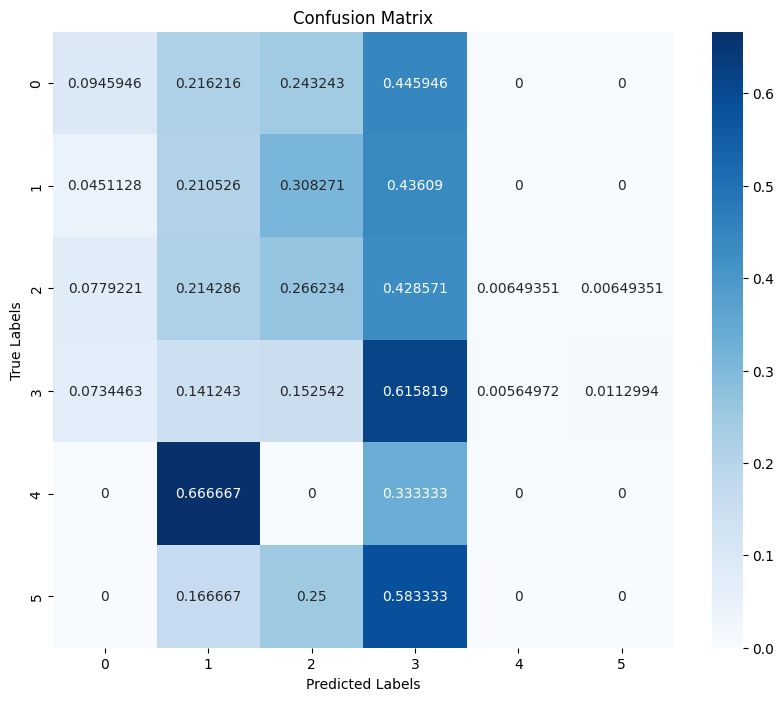

Epoch 16, Validation Loss: 3.6155, Accuracy: 0.3206, F1 Score: 0.2884
Val F1 Score Per Class  [0.125      0.23045267 0.28275862 0.4688172  0.         0.        ]


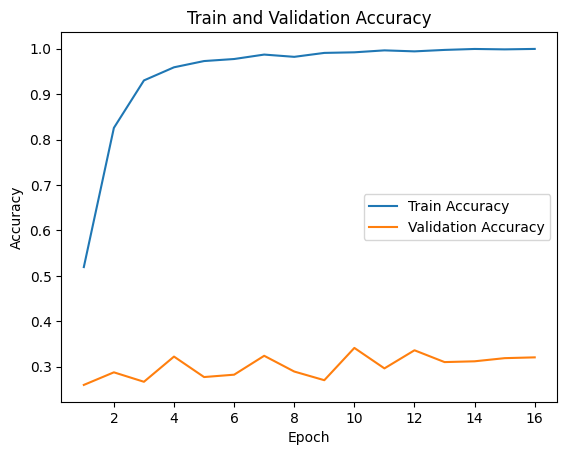

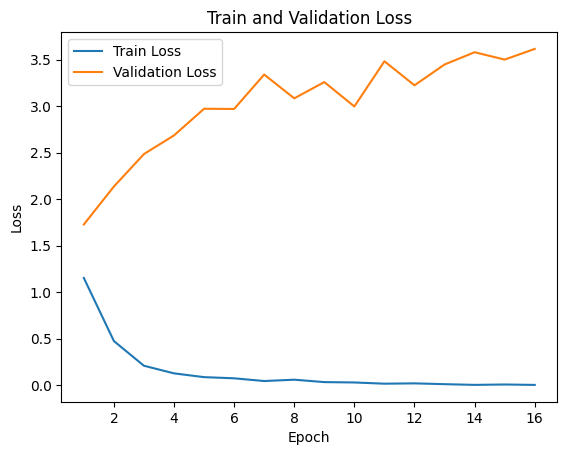

Epoch 17, Train Loss: 0.0009, Accuracy: 0.9999, F1 Score: 0.9999
Train F1 Score Per Class  [1.         1.         0.99969724 0.99970562 1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.40it/s, loss=4.04]

[tensor([ 2.1551e-04, -1.0291e+00, -1.6577e+00,  1.9138e-02, -7.4174e+00,
        -4.4737e+00], device='cuda:0'), tensor([ 0.1299, -3.2309, -0.1221,  3.3166, -3.6379, -3.7147], device='cuda:0'), tensor([-2.4087, -1.6465, -0.6852,  5.3134, -4.8955, -4.8084], device='cuda:0'), tensor([-1.2878, -2.0586,  5.7524, -1.9938, -4.9617, -3.0527], device='cuda:0'), tensor([-0.4501, -3.5834,  6.3334, -0.7028, -3.4502, -3.2250], device='cuda:0'), tensor([ 0.2178, -1.4318,  1.1742, -1.4611, -6.1085, -5.1952], device='cuda:0'), tensor([-4.0497,  0.4808,  1.0347, -0.3763, -4.2686, -3.0791], device='cuda:0'), tensor([-0.7553, -2.6428,  0.0797,  5.4464, -5.0988, -5.1624], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=4.33]

[tensor([-3.3554,  0.3182, -1.6217,  4.5939, -3.5455, -3.8841], device='cuda:0'), tensor([-3.1403, -2.8738,  0.8265,  2.5921, -5.1942, -4.3563], device='cuda:0'), tensor([ 1.2657, -3.5935, -1.0105,  1.0177, -3.6197, -3.2143], device='cuda:0'), tensor([-3.7953, -2.0829, -1.6049,  2.1914, -2.8029, -3.1074], device='cuda:0'), tensor([-2.0789, -0.2846, -2.2694,  6.7743, -4.4329, -3.2674], device='cuda:0'), tensor([-3.4751,  1.3162, -2.7671, -1.4020, -5.5955, -4.2506], device='cuda:0'), tensor([-4.0362, -0.3210, -1.6995,  4.7101, -4.9743, -2.7712], device='cuda:0'), tensor([-0.8299, -2.6504, -3.0529,  3.7842, -4.5774, -1.6313], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=2.45]

[tensor([-3.1137,  0.2513, -2.5136,  4.0159, -4.6326, -4.2568], device='cuda:0'), tensor([-3.9397, -1.3622,  3.4030,  2.7324, -3.1903, -5.1126], device='cuda:0'), tensor([-1.9389,  5.8789, -1.4333, -2.7375, -3.2639, -2.7721], device='cuda:0'), tensor([-2.4657,  0.1781, -0.8086, -1.9000, -4.3108, -4.1822], device='cuda:0'), tensor([ 3.0528, -0.7687, -3.2379,  0.6527, -4.5389, -2.5994], device='cuda:0'), tensor([-1.6944, -1.3705,  5.8787, -1.9532, -4.9683, -4.0543], device='cuda:0'), tensor([-1.5651, -1.2116, -2.2807,  0.6942, -5.2936, -2.4351], device='cuda:0'), tensor([-1.8873, -2.1927,  3.4694,  2.4497, -5.0277, -4.6167], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.38it/s, loss=3.69]

[tensor([ 4.3548, -0.4921, -2.4355, -1.2959, -2.9116, -2.8443], device='cuda:0'), tensor([-3.0409, -2.4756, -0.8190,  6.0790, -3.3611, -4.2210], device='cuda:0'), tensor([-3.6389,  0.4733,  0.7664,  1.3493, -5.3292, -5.0340], device='cuda:0'), tensor([-1.7219,  5.2338, -2.4428, -0.5430, -4.2587, -2.7100], device='cuda:0'), tensor([-1.2678, -2.5292,  7.5635, -2.2269, -3.9998, -2.1939], device='cuda:0'), tensor([-1.1719, -2.5921, -1.4838,  0.4257, -6.2401, -4.4648], device='cuda:0'), tensor([-2.6364, -4.1861,  3.1156,  1.7955, -3.8161, -1.5735], device='cuda:0'), tensor([ 0.6706, -2.1272, -0.1647,  1.7047, -4.4875, -4.3015], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.38it/s, loss=4.98]

[tensor([-3.3426,  1.3095,  0.0276, -2.9811, -5.5536, -3.1142], device='cuda:0'), tensor([-2.3874, -3.2326,  1.0208, -0.7603, -4.3621, -1.5708], device='cuda:0'), tensor([-2.4478, -0.3014, -0.1778, -0.2800, -5.6750, -4.2390], device='cuda:0'), tensor([-2.3111, -1.6376,  7.6213, -2.1507, -3.5858, -3.2438], device='cuda:0'), tensor([-3.1778, -2.1463,  5.1354, -1.5608, -3.5433, -1.8412], device='cuda:0'), tensor([-3.4447, -1.2679,  2.1467,  3.5650, -5.0016, -3.9036], device='cuda:0'), tensor([-3.3527, -1.1147,  3.2858, -0.1543, -6.1647, -3.9000], device='cuda:0'), tensor([-4.2976,  4.5413, -1.3204,  0.6535, -5.2312, -5.0416], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.39it/s, loss=4.23]

[tensor([-1.8281,  0.6914, -3.2584,  2.8557, -4.9830, -4.7996], device='cuda:0'), tensor([-1.8092, -0.3333, -2.1424,  0.5846, -4.0531, -2.1392], device='cuda:0'), tensor([-3.8061,  2.0932, -0.0734,  0.3999, -5.6668, -3.1538], device='cuda:0'), tensor([-2.0757, -1.6521, -0.2169, -1.0972, -6.0857, -4.3109], device='cuda:0'), tensor([ 0.7442,  0.7988,  0.2732, -0.1508, -5.4742, -3.8102], device='cuda:0'), tensor([-3.9619, -0.6189,  6.4656, -1.2360, -4.6634, -4.1424], device='cuda:0'), tensor([-3.0869,  6.2612, -0.8719, -2.9471, -3.8389, -2.9773], device='cuda:0'), tensor([-2.1855,  6.1526, -2.1794, -1.3286, -3.8153, -2.7883], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=2.6]

[tensor([-2.0738, -2.6800,  6.2191, -1.9064, -4.4351, -3.5352], device='cuda:0'), tensor([-2.4808, -2.4746,  7.6079, -1.2800, -4.2424, -3.1297], device='cuda:0'), tensor([-1.0497, -2.9368, -0.8818,  5.1873, -4.3029, -1.7192], device='cuda:0'), tensor([-1.6920, -1.9495,  1.3587, -0.8372, -5.2893, -3.0464], device='cuda:0'), tensor([-0.9664, -1.1076,  6.4041, -1.3941, -5.1096, -4.5397], device='cuda:0'), tensor([-3.0306, -1.4567, -2.1204,  6.0303, -4.0419, -1.7167], device='cuda:0'), tensor([-3.8989, -0.2055, -2.3683,  0.5952, -4.0848, -3.0679], device='cuda:0'), tensor([-1.4857, -1.9875,  7.7750, -2.1778, -2.8908, -2.2635], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=3.98]

[tensor([-2.9370,  3.7083, -2.0163,  0.3878, -3.1681, -3.4348], device='cuda:0'), tensor([-2.5274,  0.8649, -2.3512, -1.2221, -3.0269, -1.1887], device='cuda:0'), tensor([ 4.3716, -2.0957, -2.4593, -1.7572, -4.4991, -1.3320], device='cuda:0'), tensor([-3.2061, -0.4883, -1.2311,  6.4286, -5.2518, -3.8414], device='cuda:0'), tensor([-3.3473, -0.3098, -2.3063, -0.1205, -4.8690, -2.0782], device='cuda:0'), tensor([-2.2420, -3.8322, -1.1416,  5.8200, -4.1322, -2.9241], device='cuda:0'), tensor([-1.1443, -2.3539,  6.6605, -1.0999, -4.8097, -4.0796], device='cuda:0'), tensor([-4.1254, -1.0167, -1.9398,  5.6397, -4.6036, -3.4286], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=3.6]

[tensor([-3.5219,  6.2582, -1.2107, -0.6008, -4.8499, -3.0916], device='cuda:0'), tensor([-3.3516, -3.1498,  0.6638,  5.6457, -5.0299, -3.4181], device='cuda:0'), tensor([ 0.9011, -3.5506, -1.4687,  5.6852, -5.0675, -3.0474], device='cuda:0'), tensor([-3.3918, -1.6075, -2.1132,  5.4756, -5.0195, -3.5585], device='cuda:0'), tensor([-2.6079, -2.3794,  0.8789,  2.3625, -5.4570, -4.2238], device='cuda:0'), tensor([-3.1421,  1.7630, -2.4292,  1.5207, -5.7724, -4.9413], device='cuda:0'), tensor([-3.9882, -1.9464,  4.3489, -0.7682, -4.4459, -3.2874], device='cuda:0'), tensor([-3.5203, -1.9729,  0.6396,  2.5210, -5.8253, -3.3522], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=4.81]

[tensor([-2.7187, -0.4758, -2.4379,  3.7991, -5.4625, -4.7456], device='cuda:0'), tensor([-3.3093, -2.0952, -0.5592,  6.4314, -4.2543, -3.4744], device='cuda:0'), tensor([-2.5913,  1.0052, -0.5046, -1.5455, -5.4307, -5.3468], device='cuda:0'), tensor([-3.5959, -0.5301,  3.2265, -1.9999, -4.4730, -4.5912], device='cuda:0'), tensor([-2.6076,  4.4232,  0.6328, -2.6804, -4.5582, -4.2935], device='cuda:0'), tensor([-4.0567, -0.1415, -1.3108,  1.4236, -5.1416, -3.9660], device='cuda:0'), tensor([ 1.6461, -0.8569, -0.3517,  0.8674, -5.4590, -5.2635], device='cuda:0'), tensor([-2.7073, -0.9819, -2.2138,  2.1363, -5.9421, -4.9127], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.40it/s, loss=3.57]

[tensor([-2.4662,  4.6895, -2.2140,  0.2725, -3.9490, -4.2175], device='cuda:0'), tensor([-3.4244, -0.5900, -0.7504,  1.6943, -5.0714, -3.6011], device='cuda:0'), tensor([-4.1417,  2.8193, -1.8973,  1.4506, -5.4066, -4.2928], device='cuda:0'), tensor([-3.0041, -2.3140,  6.7360, -0.7273, -3.6450, -2.9300], device='cuda:0'), tensor([-2.9583, -2.1207,  6.3732,  0.5991, -4.8800, -3.2476], device='cuda:0'), tensor([-3.6165, -1.8398, -1.5511,  7.0621, -4.5658, -2.9233], device='cuda:0'), tensor([-2.3689,  2.6367, -1.8361, -1.0876, -5.4537, -5.3151], device='cuda:0'), tensor([-3.2602, -2.3463,  1.9369,  2.7447, -5.6259, -3.5124], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=3]

[tensor([-2.0065, -1.6621, -1.4504, -1.2358, -5.7491, -4.8769], device='cuda:0'), tensor([-1.6499, -2.8877,  0.5371,  0.1353, -5.4677, -4.4053], device='cuda:0'), tensor([-2.9111, -3.0858, -1.2960,  6.5892, -4.0064, -2.8486], device='cuda:0'), tensor([-3.1079, -1.7387, -1.2464,  3.5542, -5.8416, -3.2349], device='cuda:0'), tensor([-1.6635,  2.4089, -2.3772, -0.9281, -5.5989, -4.4817], device='cuda:0'), tensor([-1.2693, -0.7297, -2.5072, -0.0251, -4.9767, -4.1913], device='cuda:0'), tensor([-4.4840, -2.4642,  3.2576, -1.0566, -4.3246, -1.5791], device='cuda:0'), tensor([-0.7781, -2.6845,  1.3132,  0.6972, -5.9147, -3.8610], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=3.49]

[tensor([-3.3288, -1.3139, -2.2295,  3.3626, -3.2873, -1.4708], device='cuda:0'), tensor([-2.2626, -2.4627, -0.3056,  3.8201, -5.7443, -4.4809], device='cuda:0'), tensor([-2.5537,  2.3688, -4.6796,  1.8290, -4.2444, -1.6228], device='cuda:0'), tensor([-3.1827, -2.3326,  6.7626,  0.4456, -3.9972, -3.8620], device='cuda:0'), tensor([-3.2240, -1.4787, -0.9709,  4.2630, -5.3447, -4.0297], device='cuda:0'), tensor([ 0.4457, -2.8604, -2.2991,  1.4836, -4.4313, -4.8246], device='cuda:0'), tensor([-4.0805,  3.5285, -2.2192, -0.7946, -4.7864, -4.0187], device='cuda:0'), tensor([-2.9513,  5.0084, -1.5199,  0.0535, -5.0219, -4.6903], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=2.14]

[tensor([-1.9941, -0.6615,  7.2062, -2.6727, -2.9259, -2.7000], device='cuda:0'), tensor([-1.6220, -0.0645, -2.7051, -0.9350, -4.5842, -4.8524], device='cuda:0'), tensor([ 1.7111, -1.9952, -0.6169,  0.1681, -5.2551, -4.6227], device='cuda:0'), tensor([-1.8976, -2.0087,  0.8343, -0.4260, -5.5154, -4.4244], device='cuda:0'), tensor([-2.8813,  3.6552, -1.9484, -0.6521, -5.4160, -4.7521], device='cuda:0'), tensor([-2.8612, -0.0839,  1.5055,  1.6731, -4.7349, -4.1729], device='cuda:0'), tensor([-2.0987, -0.3891, -1.9435, -0.0365, -5.3786, -5.9391], device='cuda:0'), tensor([-1.7852, -1.2890, -1.6546,  0.5676, -5.1521, -4.1111], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=3.18]

[tensor([-2.7868, -2.0414, -1.3966,  1.0313, -4.2261, -4.8757], device='cuda:0'), tensor([-4.7680, -1.1472, -1.8133,  3.6494, -4.6933, -3.2809], device='cuda:0'), tensor([-2.5859, -4.1390,  2.9320, -0.9327, -3.1299, -2.1953], device='cuda:0'), tensor([-1.4055, -0.6412, -0.4418, -2.8485, -5.3903, -3.5412], device='cuda:0'), tensor([-2.8350, -1.5822,  6.6425, -1.9934, -4.0365, -3.4575], device='cuda:0'), tensor([ 1.3567, -3.3036,  1.9597,  2.7195, -5.8357, -4.1105], device='cuda:0'), tensor([-2.8958, -0.3305, -2.4330,  4.2047, -3.6924, -2.9159], device='cuda:0'), tensor([-3.6364, -0.7442,  0.1449,  1.5690, -5.5143, -4.1388], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=4.71]

[tensor([-4.6914e-03, -1.2927e+00, -3.0518e-01,  4.3325e+00, -5.0896e+00,
        -5.3657e+00], device='cuda:0'), tensor([-3.9849, -1.6135, -1.6858,  6.5602, -4.7796, -3.8740], device='cuda:0'), tensor([-4.3160, -0.9893, -0.2575, -1.5671, -4.9504,  3.9913], device='cuda:0'), tensor([-3.3440, -2.2317,  1.3803,  5.0221, -5.3159, -4.1224], device='cuda:0'), tensor([ 7.2714, -1.9278, -0.6248, -1.1246, -3.8916, -3.3748], device='cuda:0'), tensor([-1.4637,  2.0605, -1.7934,  0.9142, -5.3176, -4.3774], device='cuda:0'), tensor([-2.1406, -1.9994, -1.2795, -0.9364, -4.6824, -3.6761], device='cuda:0'), tensor([ 5.3754, -1.7552, -3.5053, -0.7672, -3.3780, -0.5228], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.38it/s, loss=4.93]

[tensor([-2.4443,  6.1547, -1.1036, -1.6416, -4.1502, -3.7889], device='cuda:0'), tensor([-1.8964, -1.1337, -1.1794,  4.4226, -5.9047, -5.4656], device='cuda:0'), tensor([-4.1683,  1.3734, -1.3246,  0.3695, -5.9002, -0.9507], device='cuda:0'), tensor([-2.8309, -1.3445,  4.8034, -1.6215, -4.6638, -4.5200], device='cuda:0'), tensor([ 7.8443, -2.5990, -0.7433, -0.6579, -3.3926, -3.2768], device='cuda:0'), tensor([-0.7481,  5.7804, -2.1486, -1.2777, -4.3394, -4.5599], device='cuda:0'), tensor([-1.9959, -2.7781,  7.5710, -0.8237, -3.8084, -2.8048], device='cuda:0'), tensor([-2.5369, -2.3280, -0.0084,  3.2683, -5.1973, -3.8823], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.39it/s, loss=3.78]

[tensor([-2.9134,  0.2345, -2.5232,  2.3824, -3.5838, -3.4362], device='cuda:0'), tensor([-3.4745, -1.6209,  3.9244, -0.2036, -3.4996, -3.8919], device='cuda:0'), tensor([-3.4609,  0.6074, -0.6523,  0.0791, -5.0905, -4.2688], device='cuda:0'), tensor([-3.1172, -3.2791, -0.8053,  6.1963, -3.4855, -3.3196], device='cuda:0'), tensor([-3.8961,  0.7422, -2.7436,  0.2968, -4.6406, -1.4373], device='cuda:0'), tensor([ 7.6599, -1.3634, -1.8288, -1.0925, -4.4665, -2.8580], device='cuda:0'), tensor([-1.7474, -2.1604, -2.0209,  2.9788, -4.7579, -3.9905], device='cuda:0'), tensor([-2.1001, -2.9516,  6.0734, -2.4270, -5.5104, -3.0437], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=3.97]

[tensor([-4.8219, -0.6978, -0.4154,  1.9294, -5.0158, -4.5076], device='cuda:0'), tensor([-3.1640, -2.2235,  5.7026, -0.1974, -3.6904, -4.1338], device='cuda:0'), tensor([-0.4467, -3.2010,  4.2261, -1.9957, -4.0103, -0.5885], device='cuda:0'), tensor([-3.0013,  1.3285,  0.9542,  1.0538, -2.4874, -5.0556], device='cuda:0'), tensor([-4.1716,  5.0412, -0.3062, -1.3439, -3.8008, -2.6523], device='cuda:0'), tensor([-2.7329,  1.9380, -2.9946,  0.7963, -4.3418, -3.5065], device='cuda:0'), tensor([-2.3424, -2.2206, -0.6776,  6.9315, -4.6436, -3.3659], device='cuda:0'), tensor([-0.4887, -1.0872, -3.0148,  2.7994, -4.5489, -4.3614], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=2.77]

[tensor([-4.1702,  4.1206, -0.5086, -1.0641, -4.8677, -2.6709], device='cuda:0'), tensor([-1.0097, -2.7701, -0.2260,  4.1479, -5.9402, -4.4249], device='cuda:0'), tensor([-2.8878, -1.0793,  6.4423, -2.2775, -4.6070, -3.5854], device='cuda:0'), tensor([-3.1932,  1.8140,  2.5849, -2.5167, -5.0006, -3.5095], device='cuda:0'), tensor([-4.3762,  2.4145, -2.7580,  0.0668, -5.0186, -5.0394], device='cuda:0'), tensor([-3.9491, -1.9790,  0.7445,  0.0139, -4.7064, -3.0697], device='cuda:0'), tensor([-2.3627,  0.4869,  1.5355, -0.5242, -4.3938, -4.0703], device='cuda:0'), tensor([-1.5140,  5.8967, -2.5787, -0.9103, -3.2910, -3.5248], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=7.31]

[tensor([-1.8543, -2.2160,  7.6117, -2.2718, -3.3733, -1.9317], device='cuda:0'), tensor([-1.3311,  5.3528, -2.1465, -0.8747, -4.9006, -3.8152], device='cuda:0'), tensor([-3.5007, -0.5138, -2.5441,  5.3702, -4.9094, -5.0717], device='cuda:0'), tensor([-3.1955,  0.0867, -3.2708,  5.3332, -4.9828, -3.9170], device='cuda:0'), tensor([-2.7794,  6.5688, -2.5227, -2.0977, -3.2061, -1.6129], device='cuda:0'), tensor([-1.9423, -3.2381, -2.3292,  0.9539, -5.0503, -3.9837], device='cuda:0'), tensor([-1.1325,  6.7632, -1.9444, -2.0493, -4.6596, -2.4897], device='cuda:0'), tensor([ 2.5532, -2.3600, -1.7073,  2.4753, -4.6338, -5.7084], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.39it/s, loss=3.33]

[tensor([-0.8183, -2.0790,  3.7469, -2.3574, -3.7673, -3.6946], device='cuda:0'), tensor([-2.0742, -2.6961,  6.1422, -1.3837, -4.6763, -4.0063], device='cuda:0'), tensor([-0.4014,  0.0141,  2.9500, -1.0029, -7.3340, -5.2153], device='cuda:0'), tensor([-2.7504, -1.8872, -0.7431,  4.0655, -4.6470, -4.2181], device='cuda:0'), tensor([-3.4481, -0.5088, -2.6021,  0.2326, -4.6234, -4.0406], device='cuda:0'), tensor([ 1.1654, -2.4273,  1.9148, -1.4758, -4.8591, -3.8961], device='cuda:0'), tensor([-2.1486, -1.8695,  1.3562,  3.4830, -7.2120, -3.6557], device='cuda:0'), tensor([-1.5686, -2.7565,  6.6038, -1.0980, -4.8159, -3.8683], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=4.3]

[tensor([-2.3044, -2.1785, -2.9721, -0.8490, -3.3893, -3.5804], device='cuda:0'), tensor([-0.5641, -0.1684,  0.2312, -2.6653, -4.6712, -4.7722], device='cuda:0'), tensor([-2.8886, -1.0065, -1.8808,  6.3058, -5.1586, -3.8866], device='cuda:0'), tensor([-2.1173,  6.2889, -0.9554, -2.2020, -3.2347, -2.5689], device='cuda:0'), tensor([-2.8670, -0.3221, -2.3466, -0.7903, -5.1533, -3.7653], device='cuda:0'), tensor([-3.3871,  5.9719, -0.9180, -1.1899, -4.2829, -3.4797], device='cuda:0'), tensor([-1.8799, -3.4949,  3.3999, -0.2162, -4.7250, -3.1797], device='cuda:0'), tensor([-3.1896,  5.7141, -1.8664, -1.1657, -5.2507, -1.8342], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=3.89]

[tensor([-1.8609, -3.4524,  2.1168,  3.9793, -4.6537, -5.3237], device='cuda:0'), tensor([-2.7600, -1.0555,  2.6550,  1.3244, -5.2402, -4.8079], device='cuda:0'), tensor([-3.7916,  1.5330, -2.4591,  1.0348, -6.0979, -4.1009], device='cuda:0'), tensor([-1.7717, -5.2834, -1.5557,  1.9101, -4.3565,  0.2520], device='cuda:0'), tensor([-0.4187, -3.5893, -2.1525,  4.9643, -4.0631, -2.9739], device='cuda:0'), tensor([-2.7464, -1.1915, -2.0565,  1.0050, -4.9222, -3.3217], device='cuda:0'), tensor([-0.8897, -0.3348, -2.8744, -1.8143, -3.9969, -0.2899], device='cuda:0'), tensor([-1.1467, -3.1734, -1.0953,  4.8620, -4.8766, -4.5303], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=3.6]

[tensor([-2.9213, -2.0611,  7.3654, -1.1396, -4.2995, -3.4425], device='cuda:0'), tensor([-2.0873, -1.4010,  7.2282, -2.0108, -2.9825, -2.8058], device='cuda:0'), tensor([-3.7688, -1.4590,  1.4283,  0.0884, -4.7403, -3.9383], device='cuda:0'), tensor([-3.7255,  2.0577, -1.3028,  0.7779, -5.1662, -4.3914], device='cuda:0'), tensor([-2.8049,  1.7346, -2.6825, -1.1134, -4.8036, -3.5286], device='cuda:0'), tensor([-3.3389, -2.5922,  2.6191, -1.0865, -4.0420, -3.6236], device='cuda:0'), tensor([-1.8304, -0.1184, -3.8231,  2.6585, -4.0610, -3.3859], device='cuda:0'), tensor([-0.5188, -0.5658, -2.0868, -0.7775, -3.8769, -4.1366], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=2.17]

[tensor([-2.8194, -1.7870, -0.9662,  5.5520, -5.5498, -3.7781], device='cuda:0'), tensor([-3.2279, -1.6962, -1.1493,  1.8858, -5.5287, -3.9721], device='cuda:0'), tensor([-3.4328, -2.0489,  5.9915, -1.2360, -3.8716, -3.1289], device='cuda:0'), tensor([ 6.7360, -1.8157, -1.1435, -0.9863, -3.8135, -1.9770], device='cuda:0'), tensor([-3.5062,  2.1357, -1.7024,  4.7803, -5.8336, -4.2680], device='cuda:0'), tensor([-1.0460, -2.2866,  5.1075, -0.0881, -4.4440, -3.4105], device='cuda:0'), tensor([-1.4005,  0.4830, -1.7104,  1.6473, -4.7179, -4.9333], device='cuda:0'), tensor([-3.3619, -0.8197, -0.7120, -1.7753, -5.9640, -2.4762], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=3.14]

[tensor([-3.7998, -1.1135,  3.1641,  1.8445, -5.6216, -4.6260], device='cuda:0'), tensor([-4.0954, -0.9752, -0.7348,  0.7699, -4.7056, -4.7248], device='cuda:0'), tensor([-1.5996, -2.0651, -1.3173,  2.7029, -4.5013, -4.2574], device='cuda:0'), tensor([-2.4989, -2.7998,  2.2291,  3.0349, -6.0593, -3.6363], device='cuda:0'), tensor([-2.7579,  4.0845, -1.7889, -0.2484, -4.5651, -3.6905], device='cuda:0'), tensor([-1.3436, -1.7264,  3.6143, -1.5306, -5.6401, -3.6405], device='cuda:0'), tensor([-2.7660, -3.3908,  4.5674, -0.5625, -4.6463, -3.0625], device='cuda:0'), tensor([-2.7356, -0.2259, -3.2713,  4.7696, -5.2853, -3.6077], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=3.1]

[tensor([-0.0718, -2.7390, -0.9778,  4.6364, -5.0050, -4.4160], device='cuda:0'), tensor([-3.3310, -0.9976, -1.5025,  3.2405, -4.4589, -3.8320], device='cuda:0'), tensor([-1.9251,  2.1764, -0.7325, -3.0077, -4.3167, -3.1690], device='cuda:0'), tensor([-3.0898, -2.2619, -0.1601,  3.4345, -4.4789, -4.3120], device='cuda:0'), tensor([-2.8024, -2.1177, -1.2461,  5.1316, -4.7117, -3.5503], device='cuda:0'), tensor([-4.0762, -0.0630,  0.3181,  3.8548, -5.5403, -5.0259], device='cuda:0'), tensor([-3.9263, -1.9307,  3.5562,  0.8585, -5.3747, -4.1879], device='cuda:0'), tensor([-3.2339,  1.3036, -0.1119, -1.5668, -4.9427, -4.5594], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=4.22]

[tensor([-3.6883, -0.6725, -1.3708,  6.4559, -4.3699, -3.0568], device='cuda:0'), tensor([-4.3435, -0.4572, -0.6862, -0.3275, -4.5303, -1.9674], device='cuda:0'), tensor([-4.6206, -2.8401,  4.8817, -0.6760, -4.7004, -3.3284], device='cuda:0'), tensor([-3.1044,  4.9818, -2.0763, -0.1295, -4.3313, -4.3992], device='cuda:0'), tensor([ 1.0933,  1.6465, -1.1424, -1.5034, -5.7254, -3.8478], device='cuda:0'), tensor([-3.9200, -1.3835,  0.4219, -0.9880, -4.4865, -2.6012], device='cuda:0'), tensor([-3.6324, -1.3696,  0.3371,  1.6054, -4.1493, -3.8602], device='cuda:0'), tensor([-3.6471, -1.3471, -0.9585,  6.2462, -5.0800, -4.0020], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=4.35]

[tensor([-4.4216e+00,  4.9453e+00, -8.7736e-01,  4.2430e-03, -4.5837e+00,
        -3.4652e+00], device='cuda:0'), tensor([-3.8646, -2.9941,  0.3626,  3.7590, -3.9008, -3.7963], device='cuda:0'), tensor([-2.1286, -0.1732, -2.6941, -1.6764, -3.9728, -2.5276], device='cuda:0'), tensor([-2.0477, -2.2283, -1.6377,  7.0545, -4.2671, -3.6193], device='cuda:0'), tensor([-2.6430, -0.5499, -2.7586, -2.2720, -5.6615, -2.8392], device='cuda:0'), tensor([-1.8086, -2.5104,  5.0553, -1.4025, -3.7381, -2.3698], device='cuda:0'), tensor([-3.5759, -3.5520,  3.1536,  1.9112, -6.0223, -4.9251], device='cuda:0'), tensor([-0.9624, -1.7282, -0.1934, -2.0926, -3.1044,  8.3777], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.39it/s, loss=4.14]

[tensor([-2.7198,  3.6055, -3.7227,  1.2725, -4.3754, -3.1475], device='cuda:0'), tensor([-2.9702, -2.1112, -1.5439,  6.5154, -5.1050, -3.3496], device='cuda:0'), tensor([-4.3364,  3.8466, -0.9339,  0.1643, -5.1108, -2.8272], device='cuda:0'), tensor([-1.6456,  5.6697, -2.9410, -1.3362, -4.9700, -2.4371], device='cuda:0'), tensor([-2.9207,  2.4590,  0.5844, -1.6874, -5.4171, -3.4083], device='cuda:0'), tensor([ 8.0547, -0.9911, -1.6978, -2.0689, -2.4235, -1.4631], device='cuda:0'), tensor([-2.1075, -3.3822, -0.2079,  5.5355, -4.1909, -4.3106], device='cuda:0'), tensor([-2.7427, -1.4490,  5.8207, -0.3875, -4.8745, -4.2435], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.39it/s, loss=4.9]

[tensor([-3.1449, -1.1362, -2.9484, -0.6045, -3.8330, -2.7158], device='cuda:0'), tensor([-2.7557, -1.7130, -1.9979,  7.0992, -4.0762, -3.1477], device='cuda:0'), tensor([-1.9253,  7.3345, -2.4336, -1.4765, -2.4854, -2.7779], device='cuda:0'), tensor([-3.6278,  2.4808, -2.0517, -0.8933,  3.3123, -2.0985], device='cuda:0'), tensor([-2.1284,  0.0985,  1.3978, -1.8660, -3.2689, -4.1237], device='cuda:0'), tensor([-2.0393, -3.2813,  0.2437,  3.0379, -4.8684, -3.6285], device='cuda:0'), tensor([ 2.2620, -3.0676, -1.2909, -0.7259, -5.0008, -2.8825], device='cuda:0'), tensor([ 2.0806e+00, -3.4830e-01, -2.0493e+00, -8.0040e-04, -5.5018e+00,
        -4.0125e+00], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.39it/s, loss=6.46]

[tensor([-4.1382, -2.2533, -0.7265,  4.9634, -4.0216, -2.1872], device='cuda:0'), tensor([-3.5751,  4.1191, -1.8967,  2.2176, -4.4968, -3.1756], device='cuda:0'), tensor([-2.3622, -3.0661, -1.2668,  6.0532, -5.5608, -3.4642], device='cuda:0'), tensor([-2.0664,  6.4829, -0.4703, -2.4789, -3.9744, -3.8883], device='cuda:0'), tensor([-3.2001, -1.9824,  7.5240, -1.7469, -3.0139, -2.9386], device='cuda:0'), tensor([-1.1221, -3.2700, -0.2693, -0.0215, -4.9880, -3.9461], device='cuda:0'), tensor([-2.0419,  4.0589, -2.5667, -1.9594, -5.2176, -3.7693], device='cuda:0'), tensor([-3.5532, -0.4382, -1.4480,  4.2079, -4.1868, -3.7937], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.39it/s, loss=3.96]

[tensor([ 7.9341, -0.6540, -2.6257, -1.6478, -2.4927, -2.4194], device='cuda:0'), tensor([-2.4210,  0.6513, -0.6528, -0.1907, -6.5640, -5.3664], device='cuda:0'), tensor([-3.3581,  0.4176, -1.6735,  0.8202, -0.6900, -3.9169], device='cuda:0'), tensor([-3.9158, -2.7823, -0.8123,  5.4668, -4.6541, -2.5494], device='cuda:0'), tensor([-3.3027,  3.6791, -1.6138,  2.3040, -4.3959, -4.6563], device='cuda:0'), tensor([-3.9987,  1.4549, -0.5442,  1.3670, -5.3035, -3.5735], device='cuda:0'), tensor([-2.5080, -2.7347, -1.1619,  5.1905, -4.6101, -3.8794], device='cuda:0'), tensor([-2.0482, -1.2970,  7.3630, -2.2660, -4.0270, -3.0028], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=3.59]

[tensor([-2.3099, -0.9821,  1.4514, -0.9711, -6.2623, -4.2345], device='cuda:0'), tensor([-1.7222,  2.3182,  1.1117, -2.0247, -5.0592, -4.4246], device='cuda:0'), tensor([-2.1812, -2.9903,  4.0392, -1.3874, -4.7785, -3.6905], device='cuda:0'), tensor([-2.1269, -1.5757,  7.7145, -1.7312, -3.2459, -2.7085], device='cuda:0'), tensor([-3.7323,  3.3669, -1.4707,  0.9744, -5.2384, -3.7293], device='cuda:0'), tensor([-2.0191, -3.0507, -0.4260,  1.6708, -4.6408, -1.4190], device='cuda:0'), tensor([-2.8532, -2.3383,  1.4410,  4.2101, -6.0232, -4.2787], device='cuda:0'), tensor([-2.9704,  0.1082,  1.3730,  1.9218, -5.3218, -4.7597], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.39it/s, loss=3.91]

[tensor([-2.6628, -0.3869,  3.9962, -2.4209, -3.7824, -3.0873], device='cuda:0'), tensor([-2.2877, -1.2196,  6.9823, -2.3059, -2.8385, -3.3560], device='cuda:0'), tensor([-2.8119, -2.4673, -0.6015,  0.7251, -4.9997, -2.4459], device='cuda:0'), tensor([-2.6158,  6.4361, -3.0000, -0.2339, -4.1591, -3.1078], device='cuda:0'), tensor([-2.6120, -2.9468,  0.7811,  0.9032, -5.1853, -3.8057], device='cuda:0'), tensor([-2.2851, -3.2925, -0.2767,  5.1713, -4.9914, -4.0448], device='cuda:0'), tensor([-2.1416, -2.0275, -2.0005,  7.2060, -4.1558, -3.4928], device='cuda:0'), tensor([-2.2319, -0.4280, -2.0512,  3.6243, -4.9110, -4.4598], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=4.87]

[tensor([ 1.1622, -2.1135, -2.2095,  1.8383, -4.5968, -3.2253], device='cuda:0'), tensor([-2.9877, -1.6208, -0.3869,  1.3773, -5.7953, -4.5062], device='cuda:0'), tensor([-2.7386, -2.0067, -2.7940,  4.9558, -4.0336, -3.5108], device='cuda:0'), tensor([-3.3567,  6.4631, -2.4941, -1.1268, -3.7499, -1.0021], device='cuda:0'), tensor([-2.3941,  1.3084,  4.9287, -2.9740, -4.3137, -2.7351], device='cuda:0'), tensor([-3.4035,  5.7836, -1.5996, -0.8654, -4.0616, -3.5384], device='cuda:0'), tensor([-2.0543,  2.3721, -0.5920,  0.7322, -5.1421, -4.7271], device='cuda:0'), tensor([-4.1784,  1.1516, -0.4638,  2.7318, -4.5953, -5.0052], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.39it/s, loss=3.54]

[tensor([-2.1322, -2.0019,  4.3034, -0.9625, -3.8854, -2.3151], device='cuda:0'), tensor([-3.4468, -0.2828, -1.0978,  1.2170, -6.3587, -1.7972], device='cuda:0'), tensor([-0.5571, -1.7699, -0.3544,  2.5779, -6.3305, -5.1947], device='cuda:0'), tensor([-3.7300,  1.7252, -2.8473, -0.4873, -3.7441, -4.4246], device='cuda:0'), tensor([-2.9389, -1.3598,  3.6984, -1.7944, -4.9723, -5.2705], device='cuda:0'), tensor([-2.1742,  6.7939, -2.5156, -0.8515, -3.1035, -2.7773], device='cuda:0'), tensor([-2.1911,  1.1144,  0.2428, -2.9569, -4.5537, -4.1990], device='cuda:0'), tensor([-2.8228, -2.9683,  5.5188,  0.4400, -5.1448, -4.0366], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.39it/s, loss=4.03]

[tensor([-1.5358, -1.2854,  2.7511, -1.0523, -5.3645, -5.0364], device='cuda:0'), tensor([-3.0151, -1.3443,  0.3069,  4.5648, -4.7288, -5.3051], device='cuda:0'), tensor([ 1.5400, -1.8975, -0.2070,  0.5295, -5.0394, -3.8101], device='cuda:0'), tensor([-1.7855, -3.3471, -0.0693,  0.3375, -5.9366, -4.1598], device='cuda:0'), tensor([-3.5998, -2.2188, -1.4991,  0.5872, -5.0813, -4.8286], device='cuda:0'), tensor([-2.8121, -1.4422,  7.0974, -1.6141, -4.2805, -3.0455], device='cuda:0'), tensor([ 3.3514, -2.3300,  1.2009, -1.4898, -4.4167, -4.2968], device='cuda:0'), tensor([-4.5536,  1.7964, -1.3514, -0.5498, -5.9777, -1.7238], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.39it/s, loss=4.06]

[tensor([ 1.0044, -1.9971,  0.5923,  1.0786, -5.0212, -4.3353], device='cuda:0'), tensor([-1.2428, -2.1479,  6.1606, -2.2313, -3.2462, -2.6524], device='cuda:0'), tensor([-2.9875, -2.1723, -0.7315,  5.1178, -6.0271, -2.6630], device='cuda:0'), tensor([ 2.5799, -2.0755, -3.1924,  2.6750, -3.8191, -3.3904], device='cuda:0'), tensor([-4.5603,  3.0694, -1.3534, -0.1786, -4.8360, -2.0797], device='cuda:0'), tensor([ 2.0979, -0.6709, -2.4164,  1.4115, -3.2286, -3.9931], device='cuda:0'), tensor([-3.8008, -0.8321, -0.9806,  4.6266, -4.7140, -4.2935], device='cuda:0'), tensor([-0.4116, -2.1226, -2.0621,  4.1590, -5.0059, -0.1180], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=2.21]

[tensor([-3.0978, -2.3235, -0.3225,  3.1339, -5.0509, -4.1616], device='cuda:0'), tensor([-3.0599, -0.1109,  1.9466,  1.5218, -3.5347, -5.4875], device='cuda:0'), tensor([-1.6724, -1.8300, -1.4437,  2.7535, -4.9750, -3.5744], device='cuda:0'), tensor([-4.1242,  3.3477, -2.3062,  1.2624, -4.8058, -3.9354], device='cuda:0'), tensor([-3.3874,  1.5916, -0.0904,  0.1717, -5.7372, -4.8669], device='cuda:0'), tensor([-2.8959, -2.2348, -0.9483,  6.0550, -4.5573, -4.0570], device='cuda:0'), tensor([-3.5814, -1.3486, -1.3703, -0.7128, -4.9871, -4.5012], device='cuda:0'), tensor([-0.7471, -0.9360, -1.6727,  1.6277, -4.9128, -5.2001], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=2.77]

[tensor([-3.2263, -3.0804,  1.0837,  5.0551, -4.6743, -4.1192], device='cuda:0'), tensor([ 6.2277, -2.1773,  0.4012, -1.1075, -4.1069, -2.8387], device='cuda:0'), tensor([-0.9920, -2.5292, -1.8681,  3.6069, -5.8854, -4.5944], device='cuda:0'), tensor([ 1.2995,  0.1131, -2.7434, -1.0043, -3.7264, -3.3189], device='cuda:0'), tensor([-3.7043, -1.7858,  1.1948,  2.5312, -4.1369, -3.7444], device='cuda:0'), tensor([-2.1301, -3.3804, -1.7176,  6.3058, -4.0947, -3.9813], device='cuda:0'), tensor([-3.5749, -2.3920,  2.3538,  2.0601, -4.7547, -2.7395], device='cuda:0'), tensor([ 1.1782, -1.7850,  0.2096,  0.4329, -5.1027, -5.5983], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.39it/s, loss=2]

[tensor([-2.9611, -1.2675, -1.9258,  6.9401, -4.3304, -3.3359], device='cuda:0'), tensor([-3.0736, -1.9667, -0.1706, -0.0581, -4.9478, -4.0410], device='cuda:0'), tensor([-0.4227, -0.8259, -1.2296, -0.6902, -6.6062, -4.5613], device='cuda:0'), tensor([-3.3010,  3.1530, -2.4491,  2.3199, -6.2939, -2.5308], device='cuda:0'), tensor([-2.8284,  2.7469, -3.1026,  0.5897, -4.9545, -3.0912], device='cuda:0'), tensor([-3.8650,  2.4422,  4.4455, -2.6554, -3.4840, -3.6557], device='cuda:0'), tensor([-3.2957, -1.6104,  3.0576,  2.2612, -5.2631, -4.0630], device='cuda:0'), tensor([-4.3664, -1.0302, -1.0552, -1.3252, -5.1165, -3.3165], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.38it/s, loss=3.71]

[tensor([-2.6433, -0.3114, -1.6182,  5.2422, -3.2009, -4.5584], device='cuda:0'), tensor([-2.2138, -2.0783,  5.9016, -0.3342, -5.0762, -4.3257], device='cuda:0'), tensor([-1.4121,  5.2004, -2.3818, -0.7327, -5.1072, -3.1231], device='cuda:0'), tensor([-1.9306, -1.3441, -1.7824, -1.3017, -1.9909,  8.7637], device='cuda:0'), tensor([-3.1548,  1.6864, -1.9492,  2.1771, -4.9300, -4.4337], device='cuda:0'), tensor([-1.9346,  1.8899, -3.0482,  1.2764, -5.1769, -3.5958], device='cuda:0'), tensor([-1.8276, -2.9456,  1.2313, -0.5486, -5.0999, -4.7745], device='cuda:0'), tensor([-3.1851, -2.0506, -1.2943,  6.5212, -4.2255, -4.2028], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.39it/s, loss=5.39]

[tensor([-0.9988,  2.9864,  0.8945, -2.4522, -5.3837, -2.4360], device='cuda:0'), tensor([-2.6482,  7.1471, -1.7149, -1.6161, -3.4581, -2.5519], device='cuda:0'), tensor([-1.9044,  7.1969, -2.1086, -1.4595, -4.0877, -3.5131], device='cuda:0'), tensor([-2.1856,  7.3867, -2.8737, -0.6973, -3.8823, -3.0051], device='cuda:0'), tensor([-1.6742, -2.9637, -2.8569,  6.1362, -5.7240, -2.5946], device='cuda:0'), tensor([-0.4852, -1.1858, -1.4731,  1.9831, -5.6607, -3.0665], device='cuda:0'), tensor([ 0.4407, -0.0387, -2.2333, -2.7545,  2.7212, -2.9168], device='cuda:0'), tensor([-3.9488, -0.0721,  3.2327, -1.9697, -4.4262, -3.6729], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=4.16]

[tensor([-2.3880, -1.0083, -0.1219,  2.2786, -5.4494, -4.4979], device='cuda:0'), tensor([-1.8838, -2.1795, -1.2587, -0.9610, -6.2869, -4.0515], device='cuda:0'), tensor([-2.8212,  1.8681, -0.9181,  0.0876, -6.6356, -3.2871], device='cuda:0'), tensor([-2.3157, -2.4408,  7.0300, -1.3668, -3.9704, -3.3458], device='cuda:0'), tensor([-3.4902, -0.8149,  0.5960,  0.2861, -5.7938, -5.1691], device='cuda:0'), tensor([-2.3814, -2.0327, -1.4748, -1.7985, -5.5339, -4.8904], device='cuda:0'), tensor([-2.1637, -3.6423, -0.6442,  5.0948, -4.8966, -3.1120], device='cuda:0'), tensor([-2.1124,  5.4244, -2.3021, -0.3688, -5.0331, -3.4920], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.39it/s, loss=4.37]

[tensor([-4.9380, -1.8367,  4.5457, -1.1832, -4.2008, -2.8504], device='cuda:0'), tensor([-0.3956, -2.2329,  4.9663, -0.5643, -4.4409, -3.8489], device='cuda:0'), tensor([-1.7875,  1.4043,  2.7173, -2.8755, -4.9628, -4.9468], device='cuda:0'), tensor([-1.9719, -1.3322,  5.7183, -1.3124, -5.5682, -4.0801], device='cuda:0'), tensor([-4.1243, -0.9484,  1.8378, -0.0790, -4.8078, -3.8442], device='cuda:0'), tensor([-2.8849, -1.5315,  1.9028,  0.5513, -4.9624, -0.5713], device='cuda:0'), tensor([-3.6920, -1.7863, -0.9325, -1.1502, -4.8168, -3.2008], device='cuda:0'), tensor([-2.4100,  5.5000, -2.6842, -0.7042, -4.8648, -3.1045], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.37it/s, loss=2.33]

[tensor([-1.4091, -2.9583,  1.3922, -0.1712, -4.3660, -4.0783], device='cuda:0'), tensor([-3.8228,  0.9991, -0.3235,  0.1616, -5.4037, -1.1851], device='cuda:0'), tensor([ 0.0707, -2.4987, -1.9873, -1.4719, -4.2789, -1.4429], device='cuda:0'), tensor([-1.7321,  4.0359, -1.4538, -1.8819, -5.3329, -5.4096], device='cuda:0'), tensor([-0.4175, -2.7264, -2.3843,  4.1718, -5.6477, -3.0583], device='cuda:0'), tensor([-3.6563, -2.3231,  2.2301,  0.4025, -4.7840, -3.6330], device='cuda:0'), tensor([-4.2946,  0.2385,  0.3846,  0.5485, -5.9941, -4.5270], device='cuda:0'), tensor([ 3.9887, -2.6219, -1.7678,  2.1532, -4.5240, -4.2162], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.37it/s, loss=4.08]

[tensor([-1.6847, -1.2251,  7.0930, -2.2156, -4.8398, -3.9543], device='cuda:0'), tensor([-3.2620,  5.4413,  0.3835, -1.3370, -4.3762, -4.0483], device='cuda:0'), tensor([-3.5320, -0.3545,  1.0523,  0.0298, -5.5634, -2.7844], device='cuda:0'), tensor([-0.1289, -2.2633, -0.4958,  4.0804, -5.2102, -3.7001], device='cuda:0'), tensor([ 0.3170, -0.5083, -2.1441, -2.0339, -5.1595, -3.5306], device='cuda:0'), tensor([-2.5163, -1.3268,  0.7609, -0.0873, -4.7858, -2.9055], device='cuda:0'), tensor([-2.9153, -1.8887,  0.9552,  0.4341, -4.6077, -4.5524], device='cuda:0'), tensor([-0.9914, -2.1736, -2.1665,  4.7456, -3.4952, -2.3407], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.38it/s, loss=2.46]

[tensor([-1.8884, -1.1700, -0.6885, -1.2668, -5.8669, -4.1236], device='cuda:0'), tensor([-3.0833,  4.2787, -1.1409, -1.2230, -4.7646, -2.8161], device='cuda:0'), tensor([ 2.7333, -0.6473, -2.4994,  1.2593, -5.9113, -3.6730], device='cuda:0'), tensor([-3.7773, -1.8114, -0.2898,  4.4803, -4.3153, -4.3950], device='cuda:0'), tensor([-1.9087,  5.6494, -1.7274, -1.0381, -5.1655, -4.1461], device='cuda:0'), tensor([-2.1876, -2.7049, -0.1485,  2.6381, -5.3512, -3.5603], device='cuda:0'), tensor([-4.2702, -0.5081,  0.8368,  0.1995, -5.0716, -4.2083], device='cuda:0'), tensor([-1.5166, -3.2809, -0.5632,  3.8253, -6.1080, -4.3814], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.38it/s, loss=3.45]

[tensor([-2.7169, -1.9284, -1.4977,  0.5553, -4.4041, -3.7042], device='cuda:0'), tensor([-3.1846, -2.7511,  4.3479,  3.1224, -5.1556, -3.9395], device='cuda:0'), tensor([-1.4922,  2.8086, -2.6527, -0.6212, -5.1427, -4.7030], device='cuda:0'), tensor([-2.9743,  5.6134, -3.0602,  0.2619, -5.2733, -4.2535], device='cuda:0'), tensor([-1.7152, -3.6247,  3.6213,  3.5162, -4.6557, -4.3966], device='cuda:0'), tensor([-3.6725, -2.3535,  3.9998,  1.9024, -5.0545, -4.2225], device='cuda:0'), tensor([-3.6290, -1.4774,  0.1999,  2.6354, -4.8761, -4.4888], device='cuda:0'), tensor([-3.4598, -3.9576, -0.4256,  3.4993, -4.4117, -4.2065], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=3.64]

[tensor([-3.8339,  2.8861, -2.4508,  0.8522, -3.7522, -1.1828], device='cuda:0'), tensor([-1.5397,  2.4536, -1.5025, -0.3813, -5.9534, -4.8136], device='cuda:0'), tensor([-3.6877,  2.3458, -2.3713,  0.0576, -3.7936, -4.2720], device='cuda:0'), tensor([-2.1204, -0.3613, -1.8313,  2.0606, -4.5563, -4.6393], device='cuda:0'), tensor([-2.9256, -2.0566,  6.3991, -1.2532, -4.4891, -4.7380], device='cuda:0'), tensor([-3.7123, -0.2754, -1.4834,  1.0780, -5.9478, -3.4763], device='cuda:0'), tensor([-2.7236,  7.4860, -2.2343, -0.9282, -3.5182, -2.9647], device='cuda:0'), tensor([-2.6904,  1.6914, -2.2738, -0.8916, -5.3902, -3.9432], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.37it/s, loss=1.06]

[tensor([ 0.1673, -1.8196, -0.7401,  1.3988, -5.8944, -3.4513], device='cuda:0'), tensor([-0.3885, -2.1483,  2.6498,  1.3717, -5.9894, -5.0580], device='cuda:0'), tensor([-3.2882, -3.5426,  1.1660, -1.8950, -5.3402, -2.4414], device='cuda:0'), tensor([-4.5260,  0.2713, -1.7568, -0.9598, -5.7392, -4.0768], device='cuda:0'), tensor([-1.7612, -3.1461, -1.5602,  1.9358, -5.8759, -4.0986], device='cuda:0'), tensor([-3.1487, -0.4653, -1.3092,  0.8953, -5.4078, -4.4990], device='cuda:0'), tensor([-2.3145,  2.4432, -0.2901, -1.2294, -4.7907, -2.8108], device='cuda:0'), tensor([-1.7397, -3.9540, -0.0889,  3.8647, -5.0647, -3.9859], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=2.55]

[tensor([-3.3416,  6.7501, -1.3606, -1.1294, -4.6071, -2.4047], device='cuda:0'), tensor([-4.2635, -0.3715,  1.5990,  0.7773, -5.8208, -4.9214], device='cuda:0'), tensor([ 3.9923, -1.1000,  0.2636, -1.4651, -4.9469, -4.5509], device='cuda:0'), tensor([-2.7175, -1.0407, -1.1585,  5.4750, -5.5742, -3.8940], device='cuda:0'), tensor([-3.3789, -2.4403, -0.4148,  2.5601, -6.1930, -4.1562], device='cuda:0'), tensor([-3.4085, -0.7502,  5.5184, -2.1314, -4.7951, -4.0243], device='cuda:0'), tensor([-2.9626, -0.7885, -2.2911,  2.1837, -5.2218, -3.9851], device='cuda:0'), tensor([-3.1187, -1.4987, -1.6060,  7.1759, -4.5218, -3.2504], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=3.21]

[tensor([ 4.6868, -2.5521, -0.9158,  0.4237, -5.5432, -4.6960], device='cuda:0'), tensor([-0.6874, -1.0182,  0.3984, -0.9817, -5.6409, -3.4824], device='cuda:0'), tensor([-3.1589,  1.2871,  0.3826,  0.0064, -4.6017, -4.2629], device='cuda:0'), tensor([-2.7933, -1.4595,  7.3033, -1.2340, -4.2518, -2.9422], device='cuda:0'), tensor([-1.5071,  0.9631, -3.3721,  0.3057, -4.2558, -1.3925], device='cuda:0'), tensor([-2.3904, -1.0439,  5.5415, -1.2280, -5.4966, -5.0228], device='cuda:0'), tensor([-3.0271,  2.4255, -1.9455, -0.5662, -4.8918, -5.0042], device='cuda:0'), tensor([-4.0171,  4.2266, -1.6872, -1.3953, -5.7068, -3.7279], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=6.68]

[tensor([-1.3067, -3.1506, -1.3029,  5.5369, -5.5158, -3.2574], device='cuda:0'), tensor([-3.8439, -1.5565, -1.2652,  5.0995, -4.9334, -4.4092], device='cuda:0'), tensor([-3.1486, -3.1223,  0.2632,  4.6674, -6.3779, -3.4404], device='cuda:0'), tensor([-2.8776, -1.1995, -1.1501,  3.1688, -5.4991, -4.7592], device='cuda:0'), tensor([-1.6881, -2.3692,  6.2778, -1.7647, -2.9786, -3.0122], device='cuda:0'), tensor([-3.6322, -3.4999,  0.7997,  4.2458, -6.2375, -3.5921], device='cuda:0'), tensor([-0.2981, -2.7208,  5.1389,  0.2645, -5.4750, -5.4055], device='cuda:0'), tensor([-2.4558, -3.5831, -0.6579,  5.0262, -5.1927, -3.4389], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.38it/s, loss=4.14]

[tensor([-3.2757, -2.0605,  3.0840,  3.5489, -5.7257, -4.9168], device='cuda:0'), tensor([-0.2707, -3.2111, -0.0091,  1.5883, -5.2457, -4.4976], device='cuda:0'), tensor([-3.7316, -0.4886,  6.6230, -1.3893, -4.3831, -3.3937], device='cuda:0'), tensor([-2.6469,  1.0890, -1.4908,  0.2920, -6.0865, -4.5232], device='cuda:0'), tensor([ 0.6176, -3.1045, -1.6622,  0.2446, -4.7963, -3.1205], device='cuda:0'), tensor([-4.3472, -0.4741,  1.2941,  0.7466, -5.6586, -4.7076], device='cuda:0'), tensor([-3.1914, -1.1876, -1.3298,  6.2598, -4.5162, -4.6104], device='cuda:0'), tensor([-2.7843, -1.7575, -0.5364,  1.4060, -5.5105, -4.8859], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.38it/s, loss=4.1]

[tensor([-1.5935, -3.4657,  2.8937,  0.1547, -5.0007, -4.3859], device='cuda:0'), tensor([-2.5804, -3.5204, -1.2431,  6.2099, -4.7041, -2.7777], device='cuda:0'), tensor([ 1.8803, -2.1277,  0.4044, -0.4036, -4.5121, -3.6283], device='cuda:0'), tensor([-3.1652,  4.3751, -2.1558,  1.1204, -5.2864, -4.5265], device='cuda:0'), tensor([-2.1377, -1.8445,  7.7410, -1.6353, -3.2012, -2.6783], device='cuda:0'), tensor([-0.6133, -3.2315,  3.7175, -0.5001, -4.3070, -2.6799], device='cuda:0'), tensor([-3.5850, -0.3358, -0.7280, -1.2920, -5.3041, -4.7538], device='cuda:0'), tensor([-2.1442, -1.4380,  0.8018,  0.6503, -5.7220, -5.2749], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.38it/s, loss=3.84]

[tensor([-2.0439,  0.2386, -1.6994,  0.2241, -5.9601, -5.1244], device='cuda:0'), tensor([-4.7460,  0.6540,  0.5406,  3.6252, -4.9531, -3.4841], device='cuda:0'), tensor([-2.9856, -2.5977, -0.1732,  5.0234, -6.4166, -2.6450], device='cuda:0'), tensor([-2.8025, -1.6569,  2.1775,  1.3027, -5.0892, -4.8608], device='cuda:0'), tensor([-2.1126, -1.9832, -1.5156,  3.8050, -5.1517, -4.1113], device='cuda:0'), tensor([-3.4682,  0.4778, -1.0821, -1.2164, -5.3330, -5.2320], device='cuda:0'), tensor([-2.9977,  2.0940, -3.0579,  1.8621, -4.9567, -3.3549], device='cuda:0'), tensor([ 7.4613, -0.6699, -1.3546, -1.8773, -3.3366, -3.5389], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.38it/s, loss=4.18]

[tensor([ 0.4361, -0.7487, -2.5654,  2.1253, -5.0477, -4.1774], device='cuda:0'), tensor([-5.1762, -1.2684,  0.4180,  0.9410, -5.3373, -4.1817], device='cuda:0'), tensor([-3.4559, -1.4459,  2.4351,  1.1314, -5.7047, -4.3500], device='cuda:0'), tensor([-4.5886,  0.3252, -2.0041, -0.5010, -4.8987, -1.5075], device='cuda:0'), tensor([-3.1069,  0.8388, -1.7827,  1.7823, -6.4023, -5.4794], device='cuda:0'), tensor([-4.1039, -1.9768, -1.7059,  5.1444, -4.3364, -4.0551], device='cuda:0'), tensor([-2.8952, -0.1534, -2.3884,  4.7434, -5.5088, -2.9405], device='cuda:0'), tensor([-3.6027, -2.4365, -0.0850,  2.2538, -5.3572, -3.4144], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.38it/s, loss=4.48]

[tensor([-2.9544,  0.5401, -2.1359, -0.3530, -4.9137, -3.9135], device='cuda:0'), tensor([-3.5682, -1.4870, -0.3614,  5.2077, -3.4079, -3.9882], device='cuda:0'), tensor([-1.8418, -2.5441,  5.0251, -0.0943, -5.2108, -4.3400], device='cuda:0'), tensor([-3.8632,  0.2906, -3.1436,  2.6302, -5.6007, -0.3648], device='cuda:0'), tensor([-0.9178, -3.0854,  6.7141, -0.6037, -4.5208, -3.4146], device='cuda:0'), tensor([ 0.3081, -2.3341, -2.3548,  0.1319, -3.9120, -1.3384], device='cuda:0'), tensor([-1.5234, -2.5118,  5.6474, -1.3785, -5.5514, -3.5849], device='cuda:0'), tensor([-3.9070, -1.6895, -1.3657,  4.3048, -5.6812, -5.1645], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.38it/s, loss=3.74]

[tensor([ 0.7048, -1.8200,  0.4815, -0.2951, -4.8594, -4.8507], device='cuda:0'), tensor([-2.5743, -1.7071,  0.4205,  4.4702, -6.0613, -4.3993], device='cuda:0'), tensor([-4.7603,  2.3246, -0.7975, -1.0990, -5.2407, -3.8000], device='cuda:0'), tensor([-4.2050, -0.1959, -1.4538,  3.3072, -5.3663, -3.3081], device='cuda:0'), tensor([-3.3664,  3.6740, -3.3429,  2.0662, -4.6436, -2.4428], device='cuda:0'), tensor([-2.2066,  2.7745, -2.2352,  0.5770, -3.9350, -3.1001], device='cuda:0'), tensor([-2.2590, -0.3030,  6.8982, -3.1827, -4.0166, -3.2453], device='cuda:0'), tensor([-2.3974, -2.0047,  6.4610, -1.6330, -4.5146, -4.3257], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=2.2]

[tensor([-3.7653, -0.8254,  5.5628, -1.1569, -5.5481, -2.1993], device='cuda:0'), tensor([-5.0057,  3.2578, -1.0734,  0.8976, -5.2680, -3.5972], device='cuda:0'), tensor([-2.1265, -3.4673, -1.2004,  5.4283, -4.3094, -3.8326], device='cuda:0'), tensor([-3.3110, -2.6896,  2.1497,  3.9557, -5.1698, -3.8839], device='cuda:0'), tensor([-2.5704,  3.1679, -2.9394,  1.4664, -5.6962, -3.1996], device='cuda:0'), tensor([-3.8141, -2.2805,  0.4826,  3.9945, -6.1190, -1.3060], device='cuda:0'), tensor([-3.5394, -1.4459, -1.8664,  6.8112, -3.2035, -2.6922], device='cuda:0'), tensor([-2.4160, -0.2128, -1.0437,  5.6573, -5.2568, -5.7520], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.37it/s, loss=3.29]

[tensor([-2.8954, -2.5873,  1.4636,  1.8759, -4.6790, -4.0574], device='cuda:0'), tensor([-2.6490, -2.4587, -1.5758,  3.4190, -5.6928, -4.4149], device='cuda:0'), tensor([-2.6955,  1.8165, -1.2265,  0.7424, -5.6579, -4.9160], device='cuda:0'), tensor([-3.8590, -0.2900,  0.9339, -1.4080, -6.4782, -4.9977], device='cuda:0'), tensor([-2.3416, -0.5096, -1.3781,  3.2033, -5.6667, -4.0544], device='cuda:0'), tensor([-2.7467,  2.0574, -3.1219,  3.2228, -4.0497, -3.9687], device='cuda:0'), tensor([-2.5194, -2.6781,  6.5819, -0.1581, -3.7186, -2.3550], device='cuda:0'), tensor([-3.7084, -3.2737,  3.1257,  1.5830, -3.3194, -3.2766], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=1.81]

[tensor([-1.9564, -2.1562, -1.1962,  5.4359, -5.3267, -3.9800], device='cuda:0'), tensor([-4.0093, -0.4324, -1.2283,  0.4661, -4.1511, -4.4493], device='cuda:0'), tensor([-2.6017, -0.6260,  4.9512, -1.6006, -4.5663, -5.3471], device='cuda:0'), tensor([-2.2844e+00,  6.9654e-01, -1.3884e-01, -5.4638e-03, -5.7374e+00,
        -3.7388e+00], device='cuda:0'), tensor([-2.5588,  3.7887, -3.0007, -1.1990, -3.8109, -1.5617], device='cuda:0'), tensor([ 0.2980,  3.4843, -2.7707, -0.5022, -3.5206, -4.2383], device='cuda:0'), tensor([-3.6295, -1.7592, -2.3261,  2.4236, -5.5725, -4.2540], device='cuda:0'), tensor([-2.6457, -2.2287, -0.7410,  6.6986, -4.6465, -3.4142], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.38it/s, loss=4.2]

[tensor([-3.7486, -2.8920,  2.7623,  0.4143, -5.8841, -1.9126], device='cuda:0'), tensor([-3.2220, -1.8896,  7.5103, -1.4903, -3.5562, -2.4313], device='cuda:0'), tensor([-3.8860,  0.0759, -2.2095,  2.3481, -4.8857, -4.3103], device='cuda:0'), tensor([-3.4112, -2.6764,  1.5589,  3.8517, -4.7895, -3.5980], device='cuda:0'), tensor([-3.3581, -0.2243,  3.2301, -1.8360, -6.0592, -4.0290], device='cuda:0'), tensor([-1.9587, -3.1662, -0.4504, -0.2321, -5.4955, -3.8645], device='cuda:0'), tensor([-1.6403,  4.2896, -2.0276, -0.3941, -3.5651, -3.8392], device='cuda:0'), tensor([-1.4756, -3.5873, -2.0886,  3.2374, -5.6324, -1.9356], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=4.32]

[tensor([-3.7624, -1.0870,  6.3883, -1.0273, -5.2554, -3.9893], device='cuda:0'), tensor([-4.7836,  1.7957, -1.2485,  2.3103, -5.0232, -3.4270], device='cuda:0'), tensor([-2.8529,  3.0160, -1.1812, -1.1502, -5.7755, -2.2180], device='cuda:0'), tensor([ 0.5253, -1.3469, -0.6300,  1.1031, -5.8275, -4.6569], device='cuda:0'), tensor([-2.4968, -0.7615,  5.2139, -0.8766, -4.0014, -5.2699], device='cuda:0'), tensor([-3.1033,  1.0515,  0.0230, -1.2539, -5.7374, -5.4390], device='cuda:0'), tensor([-0.6054, -2.6104,  5.4316, -1.0371, -3.5483, -3.4206], device='cuda:0'), tensor([-3.8758,  0.7596,  6.5308, -2.2498, -4.2745, -2.4864], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=3.9]

[tensor([-3.6045, -0.0982,  0.9101,  2.7365, -4.4930, -4.5984], device='cuda:0'), tensor([-2.1788, -2.3708, -0.5198,  4.1414, -5.0656, -4.0940], device='cuda:0'), tensor([-2.1868, -3.0456,  2.8385, -0.7434, -4.3816, -3.5878], device='cuda:0'), tensor([-4.0860, -1.1347, -1.4363,  0.4644, -5.2644, -2.5363], device='cuda:0'), tensor([-3.9902, -0.4951, -1.9529,  4.6996, -5.2827, -0.8333], device='cuda:0'), tensor([-2.3057, -0.9844, -1.3258,  4.9764, -5.4768, -4.3217], device='cuda:0'), tensor([ 3.6199, -3.7258,  2.5122, -0.4098, -4.7670, -4.2873], device='cuda:0'), tensor([-2.4705, -1.3319,  2.3273,  0.7803, -5.9774, -4.9428], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.37it/s, loss=3.55]

[tensor([-3.5043,  4.4327, -2.2613,  1.7376, -4.5349, -3.6982], device='cuda:0'), tensor([-1.6617e+00, -1.8266e+00, -1.9204e+00,  4.8025e-03, -5.5065e+00,
        -4.3380e+00], device='cuda:0'), tensor([-2.7267,  2.2687, -1.6230, -2.1186, -5.7389, -3.1376], device='cuda:0'), tensor([ 5.8983, -2.5064, -1.2760,  0.4544, -3.6593, -3.3016], device='cuda:0'), tensor([-0.3521,  0.6312, -1.6939, -3.0814, -4.9490, -2.8512], device='cuda:0'), tensor([ 3.5739, -0.9385, -1.4663, -2.0353, -4.5626, -3.1272], device='cuda:0'), tensor([-3.3508, -2.4597, -0.6395,  5.4562, -5.3936, -3.0350], device='cuda:0'), tensor([-4.4755, -2.9227,  0.6782,  2.4027, -3.7255, -4.5936], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=4.99]

[tensor([-2.9239, -0.1082, -1.9785,  5.4242, -4.4961, -5.1115], device='cuda:0'), tensor([-1.5456, -0.5391, -0.6958,  0.6470, -5.6001, -5.0376], device='cuda:0'), tensor([-2.5880, -0.9919,  7.2805, -1.9507, -3.9222, -3.3587], device='cuda:0'), tensor([-3.0321,  0.6132, -3.0312,  3.5546, -4.6815, -4.7059], device='cuda:0'), tensor([-4.0609,  1.6875, -1.0293,  0.0288, -2.2984, -4.9377], device='cuda:0'), tensor([-2.5311, -2.9462,  5.1565,  0.9099, -4.7957, -4.1481], device='cuda:0'), tensor([-2.6174, -0.6233,  4.9093, -2.2370, -5.1021, -4.9750], device='cuda:0'), tensor([-3.0077,  1.1949, -1.4155, -0.6832, -5.0609, -4.2970], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=3.58]

[tensor([-1.5148, -1.4930,  6.4462, -2.1277, -4.2586, -3.4940], device='cuda:0'), tensor([-4.9541,  1.7996,  0.3990, -1.4783, -3.7726, -3.6325], device='cuda:0'), tensor([-3.5641, -0.5952, -2.6048,  4.6160, -4.4319, -0.8956], device='cuda:0'), tensor([ 0.5749, -1.6367,  5.2024, -1.2154, -3.8871, -4.2439], device='cuda:0'), tensor([ 0.0947, -0.2003,  0.0871, -2.6378, -5.2413, -3.9566], device='cuda:0'), tensor([-4.4866,  1.0068,  1.6274, -2.2523, -5.4411, -3.9533], device='cuda:0'), tensor([-3.9259, -2.4882,  2.8545,  0.9694, -4.5717, -2.1526], device='cuda:0'), tensor([-3.4974, -1.7060,  0.9968,  0.3185, -6.6223, -3.3342], device='cuda:0')]


[tensor([-2.5163, -0.6851, -1.7641,  1.3399, -5.7911, -3.5406], device='cuda:0'), tensor([-4.2303, -1.1291,  2.6563, -0.2855, -5.4308, -4.8340], device='cuda:0'), tensor([-2.4115, -1.7447, -0.5919,  0.9426, -5.1769, -3.9967], device='cuda:0'), tensor([-4.4124, -0.5834,  4.9480, -1.0995, -4.2726, -3.2133], device='cuda:0'), tensor([-1.0217, -4.1015,  1.4059,  1.2064, -4.5028, -2.9367], device='cuda:0'), tensor([-3.5852, -2.4635,  1.6507, -0.7913, -4.3300, -3.5217], device='cuda:0'), tensor([ 1.8512, -1.1990, -2.7265,  2.2662, -4.7421, -4.5400], device='cuda:0'), tensor([-2.8506, -1.8464,  1.3428,  2.8205, -4.4598, -5.0804], device='cuda:0')]
[tensor([-2.8102, -1.2147,  1.4123, -1.7902, -5.1942, -4.6398], device='cuda:0')]


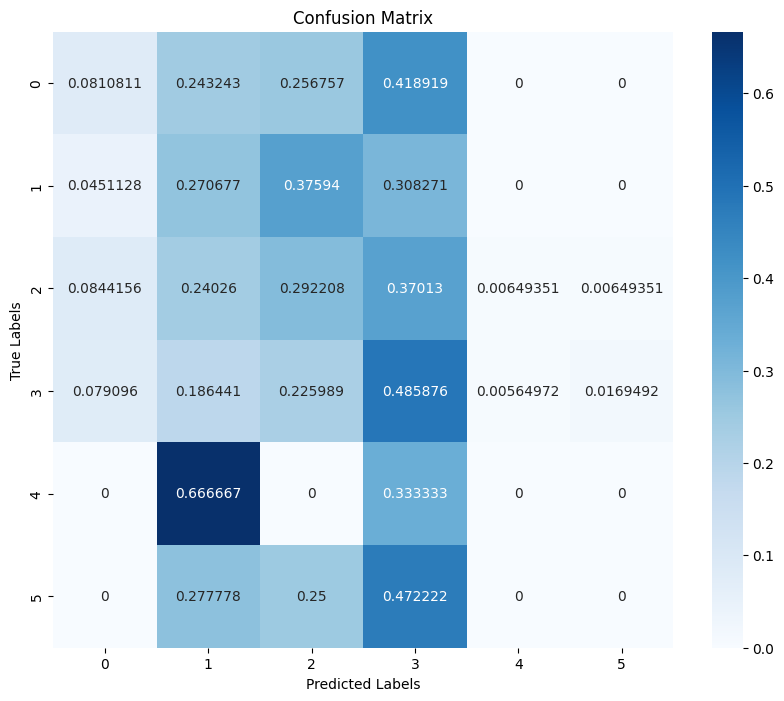

Epoch 17, Validation Loss: 3.6769, Accuracy: 0.2998, F1 Score: 0.2798
Val F1 Score Per Class  [0.10619469 0.26765799 0.28391167 0.4195122  0.         0.        ]


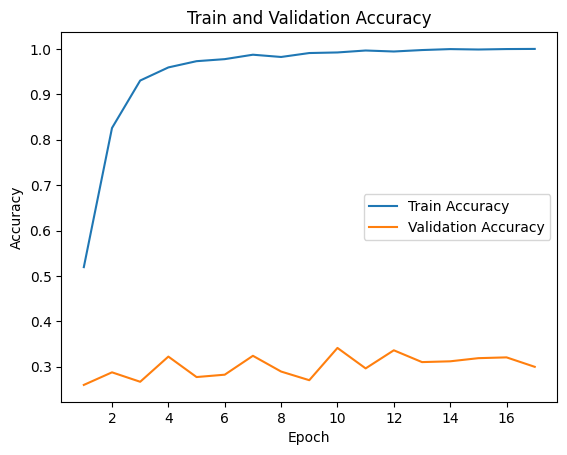

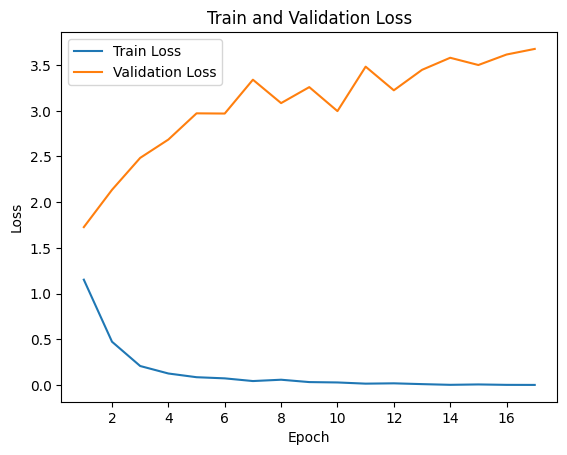

Epoch 18, Train Loss: 0.0008, Accuracy: 0.9996, F1 Score: 0.9996
Train F1 Score Per Class  [1.         0.99910045 0.99969743 0.99882214 1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.42it/s, loss=3.92]

[tensor([-0.3667, -0.5557, -2.2138,  0.0340, -7.2372, -4.5359], device='cuda:0'), tensor([ 1.3662, -2.9615, -0.5589,  3.0613, -3.3730, -3.7033], device='cuda:0'), tensor([-2.3563, -1.5768, -1.2533,  6.1321, -4.7579, -4.7753], device='cuda:0'), tensor([-1.1731, -1.9968,  5.1690, -1.8328, -5.2424, -3.4052], device='cuda:0'), tensor([-0.5779, -3.8471,  5.7789, -0.2758, -3.6411, -3.5626], device='cuda:0'), tensor([ 0.3876, -1.1403, -0.5061, -1.1080, -6.5587, -5.3168], device='cuda:0'), tensor([-4.2689,  0.9780,  0.7947, -0.2918, -4.3953, -3.1225], device='cuda:0'), tensor([-0.6833, -2.4769, -0.2559,  5.4976, -4.9408, -5.2450], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.43it/s, loss=5.1]

[tensor([-3.3086, -1.0039, -1.6783,  6.4975, -3.6411, -3.6557], device='cuda:0'), tensor([-3.3387, -2.8590, -0.5155,  4.5048, -5.4975, -4.5129], device='cuda:0'), tensor([ 1.2288, -3.3528, -1.1786,  0.6532, -3.5103, -3.1929], device='cuda:0'), tensor([-3.8261, -1.9879, -1.8227,  1.8118, -2.6216, -2.9578], device='cuda:0'), tensor([-2.1684, -0.1620, -2.4012,  6.8026, -4.4888, -3.3576], device='cuda:0'), tensor([-3.3989,  2.3059, -3.0664, -1.0010, -5.8001, -4.3826], device='cuda:0'), tensor([-4.1491, -0.4721, -1.7167,  4.9334, -4.8739, -2.8893], device='cuda:0'), tensor([-0.8071, -2.7363, -3.0640,  3.8489, -4.4676, -1.3855], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.38it/s, loss=2.62]

[tensor([-3.2818,  0.5418, -2.7312,  3.3081, -4.5900, -4.2880], device='cuda:0'), tensor([-3.9116, -1.5324,  2.8082,  3.3818, -3.2467, -5.1261], device='cuda:0'), tensor([-2.0216,  5.6525, -1.4978, -2.8354, -3.2321, -2.7969], device='cuda:0'), tensor([-2.7010,  0.7820, -1.2469, -1.6637, -4.9420, -4.6928], device='cuda:0'), tensor([ 3.3441, -0.7881, -3.4051,  0.5901, -4.5383, -2.5642], device='cuda:0'), tensor([-1.7171, -1.4578,  5.3452, -1.7820, -5.2170, -4.2698], device='cuda:0'), tensor([-1.4446, -1.0250, -2.7325,  0.5243, -5.3766, -2.4382], device='cuda:0'), tensor([-2.0513, -1.9625,  1.6939,  3.4996, -5.2398, -4.9741], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.38it/s, loss=3.79]

[tensor([ 4.0863, -0.3776, -2.8128, -1.0768, -2.9511, -2.9379], device='cuda:0'), tensor([-3.0123, -2.2864, -1.1790,  6.6096, -3.2840, -3.9936], device='cuda:0'), tensor([-3.6790,  0.3480,  0.1598,  2.4783, -5.4897, -5.0327], device='cuda:0'), tensor([-1.6379,  5.6319, -2.5822, -0.5735, -4.2136, -2.7664], device='cuda:0'), tensor([-1.3772, -2.5157,  7.5421, -2.2152, -4.2113, -2.2671], device='cuda:0'), tensor([-1.2768, -2.3540, -1.9209,  0.9310, -6.5873, -4.8036], device='cuda:0'), tensor([-2.7797, -4.1489,  2.4251,  2.4112, -3.8955, -1.7809], device='cuda:0'), tensor([ 1.2918, -2.2369, -0.7309,  2.0405, -4.5718, -4.4591], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.38it/s, loss=4.66]

[tensor([-3.5846,  1.6277, -0.5647, -2.7175, -5.6886, -3.1904], device='cuda:0'), tensor([-2.5576, -3.2162,  0.1488, -0.5279, -4.3781, -1.5990], device='cuda:0'), tensor([-2.4331, -0.3545, -0.1317,  0.0720, -6.0717, -4.4255], device='cuda:0'), tensor([-2.5361, -1.6395,  7.4988, -2.1169, -3.9518, -3.5698], device='cuda:0'), tensor([-3.2881, -2.3010,  4.4247, -1.4063, -3.8067, -1.8194], device='cuda:0'), tensor([-3.5014, -1.3807,  1.5264,  4.0672, -5.0890, -3.9533], device='cuda:0'), tensor([-3.7082, -0.8092,  1.5731,  0.2750, -6.2014, -4.0258], device='cuda:0'), tensor([-4.2615,  5.2841, -1.6717,  0.9186, -5.2712, -4.9761], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.37it/s, loss=4.17]

[tensor([-1.7323,  0.9935, -3.5899,  3.0079, -4.8650, -4.8091], device='cuda:0'), tensor([-1.6322, -0.5936, -2.3358,  0.7080, -4.1576, -2.0515], device='cuda:0'), tensor([-3.7490,  3.3968, -0.5769,  0.4434, -5.7472, -3.1793], device='cuda:0'), tensor([-1.6334, -0.8023, -0.7707, -1.1820, -5.9810, -4.7206], device='cuda:0'), tensor([ 0.9792,  1.2719, -0.7270,  0.1266, -5.4084, -3.7024], device='cuda:0'), tensor([-4.1897, -0.2988,  5.8461, -1.1115, -5.0281, -4.5490], device='cuda:0'), tensor([-2.8876,  6.8692, -1.1969, -2.8831, -3.8559, -2.8264], device='cuda:0'), tensor([-1.7207,  5.8747, -2.4765, -1.4594, -3.7642, -2.7505], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.38it/s, loss=2.5]

[tensor([-2.1016, -2.8982,  5.7327, -1.7426, -4.9764, -3.8463], device='cuda:0'), tensor([-2.5818, -2.6114,  7.5618, -1.1380, -4.3988, -3.2333], device='cuda:0'), tensor([-1.1799, -2.8787, -1.1069,  5.4109, -4.3057, -1.8320], device='cuda:0'), tensor([-1.6056, -1.9687,  0.4357, -0.5397, -5.6301, -3.1321], device='cuda:0'), tensor([-1.3245, -0.9097,  5.9829, -1.1369, -5.3694, -4.7903], device='cuda:0'), tensor([-2.9776, -1.4031, -2.3819,  6.2121, -3.9868, -1.8134], device='cuda:0'), tensor([-3.8156, -0.2273, -2.5640,  0.3873, -4.3655, -3.1229], device='cuda:0'), tensor([-1.4974, -1.9612,  7.8248, -2.2425, -2.9457, -2.3292], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.37it/s, loss=4.03]

[tensor([-3.0577,  4.4642, -2.2933,  0.1782, -3.1748, -3.4844], device='cuda:0'), tensor([-2.5928,  1.0075, -2.5385, -1.2989, -3.0420, -1.1593], device='cuda:0'), tensor([ 4.0431, -2.0897, -2.6580, -1.7030, -4.6101, -1.3998], device='cuda:0'), tensor([-3.2197, -0.5666, -1.5008,  6.6316, -5.1998, -3.7106], device='cuda:0'), tensor([-3.3312, -0.3337, -2.4352, -0.1110, -4.9148, -2.0901], device='cuda:0'), tensor([-2.2473, -3.7028, -1.4632,  6.1031, -4.1362, -2.9814], device='cuda:0'), tensor([-1.2793, -2.3051,  6.0264, -0.9905, -5.2888, -4.4121], device='cuda:0'), tensor([-4.1673, -0.9043, -2.2123,  5.7858, -4.6874, -3.4359], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.38it/s, loss=3.7]

[tensor([-3.3201,  6.4893, -1.5497, -0.6135, -4.9022, -3.1053], device='cuda:0'), tensor([-3.3565, -3.0711,  0.0142,  6.2475, -5.0326, -3.2767], device='cuda:0'), tensor([ 0.7341, -3.4610, -1.7384,  5.7312, -4.9693, -3.1564], device='cuda:0'), tensor([-3.5384, -1.6554, -2.4801,  4.9497, -5.0455, -3.7011], device='cuda:0'), tensor([-2.6341, -2.3797,  0.2606,  2.4715, -5.6074, -4.3853], device='cuda:0'), tensor([-3.1389,  2.8983, -2.6132,  0.9554, -5.5432, -4.9509], device='cuda:0'), tensor([-4.4816, -1.3441,  2.6282, -0.0280, -4.8483, -3.6998], device='cuda:0'), tensor([-3.6569, -2.0498, -0.0312,  4.2562, -6.0061, -3.5280], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.38it/s, loss=5.25]

[tensor([-2.7823, -0.4042, -2.6147,  4.2825, -5.4599, -4.6753], device='cuda:0'), tensor([-3.1141, -1.8426, -1.4931,  6.8945, -3.9635, -3.4004], device='cuda:0'), tensor([-3.1489,  1.8944, -1.2774, -1.0188, -5.4757, -5.3305], device='cuda:0'), tensor([-3.4748, -0.0737,  1.1405, -2.1192, -4.8151, -4.8922], device='cuda:0'), tensor([-2.5354,  5.2528, -0.6085, -2.4832, -4.4526, -4.3960], device='cuda:0'), tensor([-4.2208, -0.4442, -1.6260,  2.0329, -5.3412, -4.0944], device='cuda:0'), tensor([ 1.7833, -0.9323, -0.7769,  1.1914, -5.6327, -5.3009], device='cuda:0'), tensor([-2.5011, -0.9734, -2.7457,  2.5233, -5.9933, -5.0948], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:26,  2.38it/s, loss=3.45]

[tensor([-2.4617,  5.0295, -2.3826,  0.2372, -4.1629, -4.2644], device='cuda:0'), tensor([-3.3221,  0.5919, -0.9530,  1.8515, -5.1317, -3.7430], device='cuda:0'), tensor([-4.2098,  2.7417, -2.1055,  1.4316, -5.4193, -4.2561], device='cuda:0'), tensor([-3.2984, -2.4003,  6.2341, -0.3566, -3.9694, -3.2689], device='cuda:0'), tensor([-3.1818, -2.3174,  5.3266,  1.1953, -5.2598, -3.5267], device='cuda:0'), tensor([-3.5750, -1.8897, -1.8207,  7.2832, -4.5383, -2.8403], device='cuda:0'), tensor([-2.3371,  3.3853, -2.6354, -0.3486, -5.4529, -5.3354], device='cuda:0'), tensor([-2.9909, -2.0453, -0.0198,  4.4107, -5.7908, -3.5137], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=3.36]

[tensor([-2.0182, -1.2352, -1.5200, -1.2460, -5.7991, -4.7000], device='cuda:0'), tensor([-1.7254, -2.9052, -0.4205,  0.7595, -5.8370, -4.3606], device='cuda:0'), tensor([-2.8304, -3.1013, -1.5180,  6.8493, -3.9134, -2.6561], device='cuda:0'), tensor([-3.1843, -1.5195, -1.9377,  4.2787, -5.9457, -3.2395], device='cuda:0'), tensor([-1.6645,  3.7554, -2.5711, -0.9850, -5.6198, -4.5298], device='cuda:0'), tensor([-1.3768, -0.2083, -2.7662, -0.0469, -4.9085, -4.1077], device='cuda:0'), tensor([-4.6981, -2.2405,  2.7338, -0.7906, -4.4733, -1.5010], device='cuda:0'), tensor([-0.0923, -2.5065,  1.0454,  0.5417, -5.9874, -4.0054], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=3.57]

[tensor([-3.4100, -1.2422, -2.4400,  3.1335, -3.3328, -1.3626], device='cuda:0'), tensor([-2.4414, -2.0286, -0.8944,  4.1377, -5.5947, -4.4356], device='cuda:0'), tensor([-2.5807,  1.8430, -4.8661,  2.3110, -4.2673, -1.5168], device='cuda:0'), tensor([-3.0582, -2.6303,  6.3257, -0.2413, -4.2311, -4.1291], device='cuda:0'), tensor([-3.2488, -0.9711, -1.4823,  5.1438, -5.3680, -4.1396], device='cuda:0'), tensor([ 0.1595, -2.4255, -2.8108,  1.5535, -4.4576, -5.0993], device='cuda:0'), tensor([-3.9710,  3.5981, -2.3721, -0.8635, -4.6108, -3.9989], device='cuda:0'), tensor([-3.0280,  5.6864, -1.7473, -0.0468, -4.8749, -4.3988], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.94]

[tensor([-2.3139,  0.2586,  6.7253, -2.9623, -3.1778, -3.2433], device='cuda:0'), tensor([-1.6007,  0.8022, -2.9189, -0.8748, -5.2042, -5.5507], device='cuda:0'), tensor([ 1.1487, -1.7071, -0.6803,  0.1483, -5.3139, -4.8111], device='cuda:0'), tensor([-2.0619, -2.0377,  0.3774,  0.1159, -5.8433, -4.7203], device='cuda:0'), tensor([-2.9225,  4.4060, -2.1080, -0.6362, -5.4146, -4.6874], device='cuda:0'), tensor([-2.8974,  0.0391,  0.5678,  2.0890, -4.7579, -4.2247], device='cuda:0'), tensor([-1.8175, -0.0389, -2.5310,  1.1534, -5.6271, -6.0474], device='cuda:0'), tensor([-1.7727, -0.7455, -2.0737,  2.1587, -5.1209, -5.1230], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=2.86]

[tensor([-2.8760, -2.2378, -1.7584,  1.7807, -4.4958, -4.7860], device='cuda:0'), tensor([-4.7516, -1.0868, -2.0750,  4.1505, -4.8084, -3.2698], device='cuda:0'), tensor([-2.4949, -3.7427,  1.0380,  0.6142, -3.1001, -2.7449], device='cuda:0'), tensor([-1.1211, -0.3388, -1.0599, -2.9042, -5.4320, -3.5230], device='cuda:0'), tensor([-3.0131, -1.3733,  6.1784, -1.7490, -4.6261, -3.9271], device='cuda:0'), tensor([ 1.1631, -3.1330,  0.5870,  3.5180, -5.7064, -4.0257], device='cuda:0'), tensor([-2.9163, -0.3655, -2.5717,  4.3508, -3.7226, -2.7795], device='cuda:0'), tensor([-4.0741, -0.3749,  0.1265,  1.2264, -5.1880, -4.2888], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=5.1]

[tensor([ 0.0264, -1.0112, -0.7771,  4.5022, -5.1104, -5.3856], device='cuda:0'), tensor([-4.0545, -1.7383, -1.9069,  6.5899, -4.8445, -3.8914], device='cuda:0'), tensor([-3.8233, -0.9079, -0.4056, -1.4342, -4.4496,  5.8632], device='cuda:0'), tensor([-3.3770, -2.2170,  0.6254,  5.6644, -5.3551, -4.2105], device='cuda:0'), tensor([ 7.5144, -1.9656, -0.7751, -1.0617, -3.9202, -3.3297], device='cuda:0'), tensor([-1.3541,  2.3306, -2.1219,  0.9874, -5.3768, -4.4211], device='cuda:0'), tensor([-2.3347, -1.8974, -1.6821, -1.0233, -4.6452, -3.5343], device='cuda:0'), tensor([ 5.1441, -1.7152, -3.6376, -0.7907, -3.5643, -0.6477], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.38it/s, loss=4.78]

[tensor([-2.6141,  6.4909, -1.2974, -1.7274, -4.2061, -3.7700], device='cuda:0'), tensor([-1.9490, -1.2537, -1.4486,  5.0119, -5.9555, -5.4750], device='cuda:0'), tensor([-3.9792,  1.4274, -1.5804,  0.1343, -5.8662, -0.4692], device='cuda:0'), tensor([-3.0245, -0.9529,  2.8887, -1.3393, -4.9490, -4.7606], device='cuda:0'), tensor([ 8.0213, -2.4705, -1.1269, -0.5919, -3.4560, -3.3050], device='cuda:0'), tensor([-0.9114,  6.1474, -2.3996, -1.1452, -4.3695, -4.4510], device='cuda:0'), tensor([-2.1276, -3.0643,  7.3726, -0.4490, -4.0633, -2.9851], device='cuda:0'), tensor([-2.3661, -2.2834, -0.4811,  3.1344, -5.1838, -3.7233], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:22,  2.39it/s, loss=3.4]

[tensor([-2.9756,  0.3001, -2.7379,  2.4812, -3.5780, -3.4497], device='cuda:0'), tensor([-3.5397, -1.5257,  3.8611, -0.3314, -3.3614, -4.1023], device='cuda:0'), tensor([-3.4714,  1.9857, -1.0357, -0.9544, -5.0226, -4.2124], device='cuda:0'), tensor([-3.1978, -3.0471, -1.3410,  6.7867, -3.3705, -3.2762], device='cuda:0'), tensor([-3.8523,  0.5800, -2.9252,  0.0602, -4.7154, -1.4997], device='cuda:0'), tensor([ 8.1079, -1.0352, -1.9407, -1.2777, -4.1437, -2.6766], device='cuda:0'), tensor([-2.0130, -1.5404, -2.3597,  2.0612, -4.9529, -4.1224], device='cuda:0'), tensor([-2.3402, -3.1311,  3.8308, -1.6069, -6.1823, -3.7824], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=3.99]

[tensor([-4.9696,  0.2198, -1.2402,  1.5400, -4.8311, -4.5163], device='cuda:0'), tensor([-3.1744, -2.2495,  4.9745, -0.0591, -3.9397, -4.3952], device='cuda:0'), tensor([-0.4773, -3.2430,  3.5694, -1.9251, -4.1557, -0.9080], device='cuda:0'), tensor([-3.0333,  1.4301,  0.5803,  1.1913, -2.2063, -5.1175], device='cuda:0'), tensor([-4.1485,  5.6018, -0.6351, -1.3567, -3.6918, -2.5209], device='cuda:0'), tensor([-2.6448,  2.6005, -3.2286,  0.7674, -4.2581, -3.5787], device='cuda:0'), tensor([-2.2844, -2.1535, -0.9508,  7.0388, -4.6980, -3.4427], device='cuda:0'), tensor([-0.4038, -1.0702, -3.2200,  3.0994, -4.5219, -4.4091], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.39it/s, loss=2.56]

[tensor([-4.3851,  3.7792, -0.5849, -1.2859, -5.1217, -2.7135], device='cuda:0'), tensor([-1.4337, -2.7891, -1.1383,  5.8954, -5.6789, -4.1937], device='cuda:0'), tensor([-3.1918, -0.9382,  5.8704, -2.1511, -4.9970, -3.9660], device='cuda:0'), tensor([-3.2335,  2.3329,  1.5940, -2.3372, -5.1244, -3.6327], device='cuda:0'), tensor([-4.4555,  2.3430, -2.9330,  0.2223, -5.0371, -4.9763], device='cuda:0'), tensor([-4.0030, -1.8585, -0.1327,  0.2420, -4.8085, -3.1472], device='cuda:0'), tensor([-2.5723,  0.7324,  0.8322,  0.0218, -4.6623, -4.0757], device='cuda:0'), tensor([-1.5034,  6.3383, -2.5046, -1.1071, -3.3413, -3.5329], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.39it/s, loss=7.21]

[tensor([-1.9429, -2.2488,  7.6210, -2.1865, -3.6418, -2.0771], device='cuda:0'), tensor([-1.4044,  5.8345, -2.4331, -0.8444, -4.7512, -3.6799], device='cuda:0'), tensor([-3.6355,  2.1242, -3.1224,  3.8080, -4.7422, -5.1320], device='cuda:0'), tensor([-3.1751,  0.3997, -3.4634,  5.2672, -4.9688, -3.8290], device='cuda:0'), tensor([-2.7942,  6.6563, -2.5768, -2.0729, -3.3398, -1.6170], device='cuda:0'), tensor([-1.7425, -3.2034, -2.4216,  1.0848, -5.0004, -3.9696], device='cuda:0'), tensor([-1.1122,  6.9215, -2.1041, -2.1473, -4.7622, -2.4317], device='cuda:0'), tensor([ 2.3644, -1.7755, -2.2137,  2.1035, -4.5659, -5.8655], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.39it/s, loss=2.8]

[tensor([-0.7265, -2.0755,  3.3210, -2.3772, -3.9872, -3.9399], device='cuda:0'), tensor([-2.2185, -2.8283,  4.8376, -1.2710, -5.2526, -4.5590], device='cuda:0'), tensor([-0.4152,  0.6718,  1.4818, -0.3673, -7.4725, -5.6451], device='cuda:0'), tensor([-2.7458, -1.4789, -0.9057,  3.7663, -4.7090, -4.3958], device='cuda:0'), tensor([-3.5509, -0.2714, -2.6516,  0.1183, -4.6073, -4.0979], device='cuda:0'), tensor([ 1.3818, -2.2792,  1.4016, -1.5590, -4.8683, -4.0491], device='cuda:0'), tensor([-2.1962, -1.9956,  0.3669,  4.3137, -7.3931, -3.4649], device='cuda:0'), tensor([-1.7195, -3.0309,  5.9764, -0.9377, -5.2763, -4.2353], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.38it/s, loss=4.36]

[tensor([-2.4602, -2.1662, -3.1643, -0.4754, -3.2727, -3.7150], device='cuda:0'), tensor([-0.6122,  0.3250, -0.2173, -2.5718, -4.8067, -4.9447], device='cuda:0'), tensor([-2.8829, -0.8099, -2.1731,  6.1026, -5.0580, -3.9176], device='cuda:0'), tensor([-2.0189,  6.2845, -0.9487, -2.4068, -3.4379, -2.4530], device='cuda:0'), tensor([-3.2140,  0.2425, -2.7551,  0.0248, -5.3690, -3.8309], device='cuda:0'), tensor([-3.3605,  6.3624, -1.1764, -1.1852, -4.1918, -3.3295], device='cuda:0'), tensor([-2.0552, -3.5626,  2.8919,  0.6735, -4.9726, -3.2088], device='cuda:0'), tensor([-3.2544,  5.5893, -2.1177, -1.0501, -5.2887, -1.7878], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=3.99]

[tensor([-1.9337, -3.3587,  0.7626,  5.2347, -4.7361, -5.1762], device='cuda:0'), tensor([-2.7587, -0.9095,  1.5660,  2.1529, -5.5676, -5.2356], device='cuda:0'), tensor([-3.7752,  1.5567, -2.7722,  1.1508, -5.9099, -3.8941], device='cuda:0'), tensor([-1.8906, -5.1420, -1.9809,  2.4584, -4.1577,  0.2689], device='cuda:0'), tensor([-0.7135, -3.5728, -2.2658,  5.1897, -4.0939, -2.8791], device='cuda:0'), tensor([-2.8536, -0.7348, -2.3496,  0.9094, -4.9189, -3.3283], device='cuda:0'), tensor([-1.0443, -0.5012, -3.1795, -1.6446, -4.2722, -0.2106], device='cuda:0'), tensor([-1.3911, -2.9463, -1.6243,  5.6469, -4.6317, -4.4735], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.38it/s, loss=3.59]

[tensor([-3.2953, -1.9518,  7.0409, -0.7821, -4.7501, -3.7015], device='cuda:0'), tensor([-2.1875, -1.3268,  7.1079, -1.8227, -3.3130, -3.1193], device='cuda:0'), tensor([-4.0860, -1.4726,  0.4530,  0.7143, -4.9242, -4.2646], device='cuda:0'), tensor([-3.8473,  3.0131, -1.9070,  1.0815, -5.0490, -4.2291], device='cuda:0'), tensor([-2.8493,  2.2203, -2.9742, -1.3382, -4.9879, -3.4050], device='cuda:0'), tensor([-3.3909, -2.5016,  1.4052, -0.6720, -4.1702, -3.8111], device='cuda:0'), tensor([-1.8124, -0.3010, -4.0563,  2.7375, -4.2598, -3.4924], device='cuda:0'), tensor([-0.6025, -0.4289, -2.3427, -0.6105, -3.9214, -4.3660], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=2.21]

[tensor([-2.8426, -1.8729, -0.9764,  5.8111, -5.5508, -3.7294], device='cuda:0'), tensor([-3.5085, -1.5858, -1.5568,  2.8654, -5.8124, -3.6561], device='cuda:0'), tensor([-3.6430, -2.3245,  4.7666, -0.6378, -4.1726, -3.3698], device='cuda:0'), tensor([ 6.7074, -1.7538, -1.3909, -1.0841, -3.7252, -1.9474], device='cuda:0'), tensor([-3.3762,  2.0144, -1.7742,  4.9652, -5.8657, -4.3478], device='cuda:0'), tensor([-0.9268, -2.2688,  4.5922, -0.0872, -4.6071, -3.5416], device='cuda:0'), tensor([-1.5802,  1.1818, -2.0927,  1.5550, -4.5696, -5.0279], device='cuda:0'), tensor([-3.6797, -0.3655, -1.1270, -1.4223, -6.2722, -2.7117], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=2.73]

[tensor([-3.8874, -1.1368,  2.0344,  3.0892, -5.9363, -4.7137], device='cuda:0'), tensor([-3.7941, -0.7976, -1.2145,  1.5491, -4.8708, -4.7178], device='cuda:0'), tensor([-1.5699, -1.9817, -1.5355,  3.2521, -4.6607, -4.3811], device='cuda:0'), tensor([-2.5840, -3.1192,  1.3097,  4.1351, -5.9809, -3.4928], device='cuda:0'), tensor([-2.6655,  5.7752, -2.1040, -0.3845, -4.2967, -3.5644], device='cuda:0'), tensor([-1.0478, -1.5743,  2.0602, -1.2395, -5.8168, -4.2269], device='cuda:0'), tensor([-3.0626, -3.3633,  3.4012,  0.1619, -5.2326, -3.4183], device='cuda:0'), tensor([-2.7412, -0.3401, -3.3855,  5.2158, -5.2419, -3.6212], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=3.38]

[tensor([-0.4389, -2.5998, -1.3763,  5.1478, -5.0160, -4.3289], device='cuda:0'), tensor([-3.3401, -0.2249, -1.8517,  2.7410, -4.6392, -3.9925], device='cuda:0'), tensor([-1.9047,  3.5371, -1.1717, -2.9185, -4.2858, -3.2945], device='cuda:0'), tensor([-3.1330, -2.3448, -0.3557,  3.9378, -4.6132, -4.3802], device='cuda:0'), tensor([-2.8849, -2.0641, -1.5686,  6.0066, -4.6622, -3.4423], device='cuda:0'), tensor([-4.1059,  0.1643, -0.1302,  3.8246, -5.6417, -5.0313], device='cuda:0'), tensor([-4.0057, -1.8193,  2.3299,  0.7910, -5.6405, -4.3070], device='cuda:0'), tensor([-3.1588,  1.5515, -0.6845, -1.4203, -5.0676, -4.6468], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=4.62]

[tensor([-3.4073, -1.3688, -1.2836,  6.8859, -4.2232, -2.9879], device='cuda:0'), tensor([-4.0323, -0.5407, -1.1428, -0.5229, -4.6182, -2.2210], device='cuda:0'), tensor([-4.8764, -3.0972,  3.9370, -0.2045, -4.9136, -3.4461], device='cuda:0'), tensor([-3.0482,  5.3847, -2.2405, -0.2973, -4.3283, -4.2909], device='cuda:0'), tensor([ 0.7835,  2.6547, -1.9728, -1.3452, -5.8104, -3.6183], device='cuda:0'), tensor([-4.2152, -1.3317, -0.1748, -0.8290, -4.9919, -2.7304], device='cuda:0'), tensor([-3.7477, -1.2937, -0.9192,  3.4923, -3.9200, -3.7800], device='cuda:0'), tensor([-3.7578, -1.3581, -1.2063,  6.2385, -5.1972, -3.9752], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=4.66]

[tensor([-4.3092,  5.2696, -1.3568, -0.2111, -4.6245, -3.3018], device='cuda:0'), tensor([-3.9434, -2.3678, -0.3098,  4.6148, -4.1153, -4.1842], device='cuda:0'), tensor([-1.4242,  1.1862, -2.9047, -1.4028, -3.8650, -2.3625], device='cuda:0'), tensor([-2.0755, -2.0466, -1.9443,  6.9679, -4.3080, -3.8734], device='cuda:0'), tensor([-2.9807, -0.9588, -2.8958, -1.9440, -5.4850, -3.0410], device='cuda:0'), tensor([-2.0958, -3.1067,  3.2282, -0.2822, -4.1852, -2.5088], device='cuda:0'), tensor([-3.5991, -3.5279,  2.1353,  2.2741, -5.9684, -5.0709], device='cuda:0'), tensor([-0.9317, -1.6562, -0.3276, -2.0792, -3.1048,  8.5873], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=4.42]

[tensor([-2.7663,  3.7081, -3.9653,  1.4042, -4.3634, -3.0651], device='cuda:0'), tensor([-2.9576, -2.0454, -1.9332,  6.7869, -4.9483, -3.2085], device='cuda:0'), tensor([-4.3070,  5.1280, -1.3153, -0.4356, -5.1693, -2.3732], device='cuda:0'), tensor([-1.6493,  5.9928, -3.0027, -1.4646, -4.8909, -2.4141], device='cuda:0'), tensor([-2.6758,  3.3340, -0.0943, -1.5313, -5.3758, -3.6352], device='cuda:0'), tensor([ 8.1592, -1.0091, -1.8471, -2.1033, -2.4182, -1.4278], device='cuda:0'), tensor([-2.2301, -3.2380, -0.5188,  6.1590, -4.1760, -4.1837], device='cuda:0'), tensor([-2.9347, -1.3453,  4.9159,  0.3774, -5.1198, -4.5640], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=5.28]

[tensor([-2.9771, -1.0456, -3.2250, -0.5937, -3.9896, -2.6913], device='cuda:0'), tensor([-2.7248, -1.6617, -2.2297,  7.2154, -4.0448, -3.1583], device='cuda:0'), tensor([-1.9546,  7.4217, -2.4797, -1.5147, -2.4683, -2.8153], device='cuda:0'), tensor([-3.6568,  3.5907, -2.4177, -0.7728,  1.8400, -2.0089], device='cuda:0'), tensor([-1.8810,  0.1020,  0.9243, -1.3394, -3.4523, -4.4418], device='cuda:0'), tensor([-2.0410, -3.2762, -0.1809,  3.7455, -5.0071, -3.7958], device='cuda:0'), tensor([ 3.6720, -3.1886, -1.4706, -0.5477, -4.7095, -2.8550], device='cuda:0'), tensor([ 1.9180, -0.6067, -2.4985, -0.2508, -5.4747, -3.7868], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.36it/s, loss=6.62]

[tensor([-4.1915, -2.0808, -0.9264,  5.3702, -4.0693, -2.1032], device='cuda:0'), tensor([-3.5712,  4.5748, -2.0624,  1.8249, -4.5796, -3.0513], device='cuda:0'), tensor([-2.3866, -2.9666, -1.5449,  6.4582, -5.5961, -3.4875], device='cuda:0'), tensor([-2.0341,  6.6074, -0.5688, -2.5253, -4.1156, -4.0494], device='cuda:0'), tensor([-3.4650, -2.0090,  7.4455, -1.7003, -3.0942, -3.0935], device='cuda:0'), tensor([-1.6477, -3.1258, -0.8857,  1.2387, -4.7393, -3.6450], device='cuda:0'), tensor([-2.1724,  4.3275, -2.9560, -1.7180, -5.1949, -3.7622], device='cuda:0'), tensor([-3.4907, -0.1625, -1.9990,  3.6354, -4.2038, -3.8135], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.36it/s, loss=4.03]

[tensor([ 7.8533, -0.6335, -2.7639, -1.6504, -2.5397, -2.5418], device='cuda:0'), tensor([-2.3758,  1.1726, -1.2241,  0.0558, -6.5036, -5.4523], device='cuda:0'), tensor([-3.5086,  0.6475, -1.8864,  0.7770, -0.7405, -3.9034], device='cuda:0'), tensor([-3.8537, -2.9540, -0.7428,  5.8828, -4.6542, -2.6225], device='cuda:0'), tensor([-3.2749,  3.4817, -2.0895,  2.4359, -4.3916, -4.5263], device='cuda:0'), tensor([-3.8312,  2.3756, -1.0599,  1.3106, -5.4093, -3.5575], device='cuda:0'), tensor([-2.2553, -2.6109, -1.7052,  5.9571, -4.6515, -3.9319], device='cuda:0'), tensor([-2.1333, -1.2315,  7.1877, -2.2608, -4.3029, -3.3210], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:16,  2.37it/s, loss=4.19]

[tensor([-1.9991, -0.5794,  1.0398, -0.6986, -6.5708, -4.3305], device='cuda:0'), tensor([-1.7720,  4.0489,  0.1242, -1.8335, -5.1342, -4.3977], device='cuda:0'), tensor([-2.2985, -3.2425,  3.2908, -1.1751, -5.0966, -3.9228], device='cuda:0'), tensor([-2.2022, -1.5256,  7.7241, -1.7434, -3.3385, -2.8103], device='cuda:0'), tensor([-3.2351,  6.1180, -1.9827,  0.1931, -4.6652, -3.1672], device='cuda:0'), tensor([-1.9843, -3.1070, -0.7438,  2.1785, -4.7943, -1.6735], device='cuda:0'), tensor([-3.0803, -2.2521,  0.4132,  5.4833, -5.9870, -4.2381], device='cuda:0'), tensor([-3.0625,  0.1841,  1.2087,  2.1491, -5.3490, -4.8930], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=3.52]

[tensor([-2.7917, -0.1656,  1.1199, -2.3120, -3.8793, -3.0638], device='cuda:0'), tensor([-2.4653, -1.2008,  6.8647, -2.2435, -3.0705, -3.5854], device='cuda:0'), tensor([-2.8375, -2.5091, -1.1063,  0.9991, -5.1271, -2.3808], device='cuda:0'), tensor([-2.7196,  6.7699, -3.0664, -0.2861, -4.1308, -3.0426], device='cuda:0'), tensor([-2.7916, -2.5905, -0.8816,  2.0216, -5.5562, -3.8449], device='cuda:0'), tensor([-2.1374, -3.3509, -0.8770,  5.7941, -4.6940, -3.8175], device='cuda:0'), tensor([-2.2111, -2.0667, -2.1571,  7.2092, -4.2582, -3.5730], device='cuda:0'), tensor([-2.4087,  0.2236, -2.5119,  2.7223, -4.7954, -4.6352], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=4.99]

[tensor([ 0.9315, -2.3000, -2.5192,  2.7627, -4.4127, -3.4496], device='cuda:0'), tensor([-3.0181, -1.8689, -1.0581,  3.2840, -5.7444, -4.4356], device='cuda:0'), tensor([-2.6485, -1.9889, -2.9632,  4.7229, -4.0971, -3.6237], device='cuda:0'), tensor([-3.4258,  6.5314, -2.6326, -1.0687, -3.6980, -1.1382], device='cuda:0'), tensor([-2.4738,  1.9971,  3.8457, -2.8402, -4.8135, -2.9030], device='cuda:0'), tensor([-3.0586,  6.8541, -1.9376, -1.3612, -3.5972, -3.1753], device='cuda:0'), tensor([-2.1568,  2.5171, -0.8375,  0.8029, -5.1255, -4.7721], device='cuda:0'), tensor([-4.2214,  1.4666, -0.6795,  2.5101, -4.6720, -4.9309], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.38it/s, loss=3.32]

[tensor([-2.0046, -1.9399,  3.1569, -0.8731, -4.1804, -2.3331], device='cuda:0'), tensor([-3.3704, -0.1002, -1.4746,  1.2938, -6.4070, -1.5196], device='cuda:0'), tensor([-0.3168, -1.5796, -1.1711,  3.0307, -6.2149, -5.0849], device='cuda:0'), tensor([-3.5411,  1.5891, -3.1242, -0.6882, -3.7497, -4.4288], device='cuda:0'), tensor([-3.1504, -1.1093,  0.6656, -1.2283, -5.3389, -5.8407], device='cuda:0'), tensor([-2.1550,  6.9541, -2.6209, -0.9188, -3.0389, -2.6732], device='cuda:0'), tensor([-2.2078,  2.3392, -0.6603, -2.9015, -4.7854, -4.3614], device='cuda:0'), tensor([-2.8754, -3.0911,  5.5419,  0.6402, -5.2999, -4.2560], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.39it/s, loss=3.91]

[tensor([-1.4444, -1.1597,  1.1320, -0.4442, -5.5655, -5.0121], device='cuda:0'), tensor([-2.9278, -0.9507, -0.3138,  5.0642, -4.4620, -5.4077], device='cuda:0'), tensor([ 1.1076, -1.7001, -0.7759,  0.3209, -4.9332, -3.8049], device='cuda:0'), tensor([-1.5888, -3.2808, -0.4465,  1.8714, -6.1742, -4.4923], device='cuda:0'), tensor([-3.5112, -2.0801, -2.0756,  0.7910, -4.9109, -4.5169], device='cuda:0'), tensor([-3.1442, -1.2676,  6.8094, -1.5071, -4.7536, -3.4631], device='cuda:0'), tensor([ 3.4741, -2.2722,  0.7449, -1.4714, -4.4651, -4.3946], device='cuda:0'), tensor([-4.6003,  2.6458, -1.5506, -0.4039, -6.2946, -1.6508], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=4.07]

[tensor([ 0.9552, -2.0399,  0.2440,  1.1015, -4.9766, -4.4171], device='cuda:0'), tensor([-1.3018, -2.1482,  6.0985, -2.1130, -3.3627, -2.8240], device='cuda:0'), tensor([-3.1715, -1.7455, -1.8323,  4.9329, -5.8556, -2.5161], device='cuda:0'), tensor([ 2.7442, -2.1035, -3.3567,  2.7211, -3.8340, -3.4318], device='cuda:0'), tensor([-4.5986,  3.6660, -1.9588, -0.3713, -4.7900, -2.1591], device='cuda:0'), tensor([ 1.9902, -0.6904, -2.8249,  1.9181, -3.1800, -4.2384], device='cuda:0'), tensor([-3.8787, -0.6732, -1.1728,  4.3748, -4.5092, -4.3974], device='cuda:0'), tensor([-0.4984, -1.9159, -2.4635,  4.1617, -5.0273,  0.0999], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=2.49]

[tensor([-3.2003, -2.4298, -0.8245,  4.7111, -4.8401, -4.1609], device='cuda:0'), tensor([-3.0785e+00, -4.7125e-03,  1.3667e+00,  1.7491e+00, -3.6402e+00,
        -5.5330e+00], device='cuda:0'), tensor([-1.7693, -1.9459, -1.8120,  2.9883, -4.9656, -3.5953], device='cuda:0'), tensor([-4.0939,  3.3527, -2.5506,  1.8351, -4.7914, -3.9453], device='cuda:0'), tensor([-3.4618,  1.8364, -0.6308,  0.3781, -5.6670, -4.9385], device='cuda:0'), tensor([-2.8295, -2.0136, -1.5861,  6.5037, -4.5781, -3.8802], device='cuda:0'), tensor([-3.5221, -1.4559, -1.6873,  0.2012, -5.2662, -5.0295], device='cuda:0'), tensor([-0.2893, -1.0695, -1.9124,  1.9833, -4.8785, -5.2368], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:12,  2.39it/s, loss=3.43]

[tensor([-2.9535, -2.9635, -0.1746,  5.5199, -4.5311, -4.0741], device='cuda:0'), tensor([ 6.8375, -2.0453,  0.1373, -1.0573, -3.9818, -2.7502], device='cuda:0'), tensor([-1.3587, -2.3578, -1.9831,  3.9791, -5.9554, -4.7627], device='cuda:0'), tensor([ 1.1675,  0.4281, -2.9569, -0.8712, -3.8688, -3.2625], device='cuda:0'), tensor([-3.4995, -1.4105,  0.3920,  2.5969, -4.4504, -4.0198], device='cuda:0'), tensor([-2.1962, -3.2257, -1.8894,  6.7642, -3.9271, -3.8166], device='cuda:0'), tensor([-3.6223, -2.5123,  1.2379,  3.0137, -4.9204, -2.7323], device='cuda:0'), tensor([ 1.8716, -1.6675, -0.1671,  0.6091, -5.2319, -5.7299], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.39it/s, loss=2.31]

[tensor([-3.0430, -1.0905, -2.3288,  6.4658, -4.5509, -3.4850], device='cuda:0'), tensor([-2.8163, -1.3294, -0.8287, -0.1069, -5.1930, -4.2648], device='cuda:0'), tensor([-0.6771, -0.6660, -1.6423, -0.0300, -6.5297, -4.4876], device='cuda:0'), tensor([-3.3383,  3.2683, -2.6282,  2.3657, -6.1434, -2.6124], device='cuda:0'), tensor([-2.6710,  3.4118, -3.3683,  0.1666, -4.7422, -2.9503], device='cuda:0'), tensor([-3.9760,  2.5036,  4.0550, -2.5631, -3.6920, -3.8898], device='cuda:0'), tensor([-3.1971, -1.6558,  2.0672,  3.1302, -5.4635, -4.2145], device='cuda:0'), tensor([-4.2221, -0.7053, -2.0025, -0.8625, -4.9107, -3.3286], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.39it/s, loss=3.75]

[tensor([-2.6681, -0.1666, -1.7469,  4.9410, -3.3049, -4.6651], device='cuda:0'), tensor([-2.3573, -2.1375,  4.5323,  0.4291, -5.7874, -4.6417], device='cuda:0'), tensor([-1.2671,  5.6148, -2.6620, -0.8733, -5.1546, -2.9372], device='cuda:0'), tensor([-1.8826, -1.3444, -1.8273, -1.3002, -2.0375,  8.9613], device='cuda:0'), tensor([-3.3322,  1.8669, -2.2673,  2.7796, -5.0029, -4.3942], device='cuda:0'), tensor([-2.0053,  1.7054, -3.2282,  1.5384, -4.9733, -3.6536], device='cuda:0'), tensor([-1.9167, -2.6858,  0.3513, -0.4827, -5.3961, -5.3445], device='cuda:0'), tensor([-3.0803, -1.9392, -1.5573,  6.8559, -4.1259, -4.1910], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.39it/s, loss=5.28]

[tensor([-1.0271,  3.4363,  0.1276, -2.2960, -5.3379, -2.3013], device='cuda:0'), tensor([-2.6128,  7.2543, -1.8097, -1.6863, -3.4741, -2.5320], device='cuda:0'), tensor([-1.8439,  7.4634, -2.1714, -1.5810, -3.8168, -3.3065], device='cuda:0'), tensor([-2.2653,  7.4198, -2.9715, -0.7107, -3.9914, -3.0419], device='cuda:0'), tensor([-1.7650, -2.8257, -3.0554,  6.1844, -5.7159, -2.8253], device='cuda:0'), tensor([ 0.4232, -1.0108, -2.2297,  2.1984, -5.7097, -3.2833], device='cuda:0'), tensor([ 0.6320, -0.0315, -2.6056, -2.6579,  2.7278, -2.9754], device='cuda:0'), tensor([-4.3330,  0.1821,  1.7761, -1.5558, -5.0383, -4.0496], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.38it/s, loss=4.5]

[tensor([-2.4433, -1.2348, -0.6128,  2.4689, -5.6628, -4.5189], device='cuda:0'), tensor([-1.7923, -2.3915, -1.4639, -0.3286, -6.6248, -4.4041], device='cuda:0'), tensor([-2.8078,  1.9840, -1.4155, -0.0623, -6.6240, -3.4849], device='cuda:0'), tensor([-2.5472, -2.6554,  6.7618, -1.0827, -4.2801, -3.7293], device='cuda:0'), tensor([-3.5818, -0.5494, -0.1244,  0.2112, -5.5790, -4.9615], device='cuda:0'), tensor([-2.4458, -2.1454, -1.8352, -1.6131, -5.5679, -4.8128], device='cuda:0'), tensor([-2.1862, -3.2110, -1.4425,  6.7629, -4.5920, -3.0128], device='cuda:0'), tensor([-1.9568,  5.7566, -2.6365, -0.5638, -4.9774, -3.3603], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=3.87]

[tensor([-5.0582, -2.0083,  3.1214, -1.0077, -4.4661, -2.4560], device='cuda:0'), tensor([-0.1542, -2.2744,  4.4903, -0.4531, -4.5741, -4.1953], device='cuda:0'), tensor([-1.3146,  2.9913,  0.0675, -3.0469, -4.9420, -4.7379], device='cuda:0'), tensor([-2.1621, -1.3259,  3.8433, -1.2065, -6.5253, -4.7618], device='cuda:0'), tensor([-4.1851,  0.3330,  1.0550, -0.5480, -4.8994, -4.1488], device='cuda:0'), tensor([-2.8085, -1.8360,  1.2539,  1.2436, -5.0848, -0.5276], device='cuda:0'), tensor([-3.6169, -1.7554, -1.3228, -1.1757, -4.7656, -3.2768], device='cuda:0'), tensor([-2.4627,  5.7171, -2.8144, -0.2577, -4.9184, -3.1094], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.38it/s, loss=2.15]

[tensor([-1.6213, -3.1702,  0.4772,  0.9221, -4.9935, -4.5483], device='cuda:0'), tensor([-3.7343,  1.2991, -0.6536,  0.3135, -5.6079, -1.2941], device='cuda:0'), tensor([ 0.1643, -2.5393, -2.1591, -1.5368, -4.3911, -1.5025], device='cuda:0'), tensor([-1.6117,  5.1984, -1.6700, -1.9054, -4.9907, -5.0482], device='cuda:0'), tensor([-0.2123, -2.6427, -2.7568,  4.0757, -5.6576, -3.0850], device='cuda:0'), tensor([-3.6823, -2.3867,  1.6304,  0.8825, -4.7817, -3.6799], device='cuda:0'), tensor([-4.3815,  0.2194,  1.0988, -0.5406, -6.0899, -4.7712], device='cuda:0'), tensor([ 4.1060, -2.7413, -1.9804,  2.2796, -4.4399, -4.1703], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.38it/s, loss=4.16]

[tensor([-1.8889, -0.5218,  6.6964, -2.2283, -5.4068, -4.3586], device='cuda:0'), tensor([-3.2202,  6.1642, -0.1207, -1.4020, -4.0861, -3.8497], device='cuda:0'), tensor([-3.5674, -0.2028,  0.2359,  0.0848, -5.7059, -2.7551], device='cuda:0'), tensor([-0.0189, -2.3100, -1.0096,  4.1577, -5.3153, -3.6626], device='cuda:0'), tensor([ 1.5199, -0.3352, -2.3828, -2.0530, -5.5863, -3.9815], device='cuda:0'), tensor([-2.5507, -0.9810,  0.0121,  0.4235, -4.8024, -3.0640], device='cuda:0'), tensor([-2.9585, -2.0300,  0.0084,  1.3872, -4.9728, -4.7849], device='cuda:0'), tensor([-1.2434, -2.1609, -2.3425,  4.8841, -3.5800, -2.4196], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.39it/s, loss=2.87]

[tensor([-1.9493, -0.9943, -1.2509, -1.1645, -5.8962, -4.2959], device='cuda:0'), tensor([-3.0777,  4.8287, -1.5646, -1.1758, -4.7837, -2.9234], device='cuda:0'), tensor([ 2.0507,  0.1172, -3.0254,  2.0553, -5.9925, -3.7242], device='cuda:0'), tensor([-3.7006, -1.8617, -0.7763,  5.4323, -4.1923, -4.3817], device='cuda:0'), tensor([-1.9277,  6.1083, -1.8419, -1.1306, -5.1893, -4.0915], device='cuda:0'), tensor([-2.5317, -2.7834, -0.5488,  3.9736, -5.4058, -3.4456], device='cuda:0'), tensor([-3.9347, -1.0192, -0.2490,  0.6579, -5.1615, -4.3031], device='cuda:0'), tensor([-1.5262, -3.3736, -1.1062,  5.3567, -5.9243, -4.3004], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.38it/s, loss=3.6]

[tensor([-2.6922, -2.3054, -1.7514,  2.0183, -4.9807, -3.9464], device='cuda:0'), tensor([-3.3383, -2.8583,  2.0555,  5.0157, -5.3182, -4.1277], device='cuda:0'), tensor([-1.8896,  4.3075, -2.7143, -0.7743, -4.9878, -4.6947], device='cuda:0'), tensor([-2.9385,  5.3860, -3.3044,  0.3751, -4.9415, -3.9555], device='cuda:0'), tensor([-1.9230, -3.6123,  2.3322,  4.5556, -4.7871, -4.4852], device='cuda:0'), tensor([-4.0935, -2.3238,  2.9511,  3.3551, -5.4002, -4.3351], device='cuda:0'), tensor([-3.5074, -1.9100, -0.1267,  2.2781, -4.9915, -4.8353], device='cuda:0'), tensor([-3.5854, -3.5302, -0.9369,  4.8545, -4.5250, -4.4081], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=3.77]

[tensor([-3.8205,  3.2568, -2.5344,  0.7093, -3.7936, -1.3153], device='cuda:0'), tensor([-1.5732,  3.6308, -1.6324, -0.3956, -5.8264, -4.7492], device='cuda:0'), tensor([-3.6350,  2.2126, -2.5410,  0.2942, -3.9250, -4.3849], device='cuda:0'), tensor([-2.1933,  0.3090, -2.3225,  2.1358, -4.4587, -4.6060], device='cuda:0'), tensor([-3.3038, -2.2069,  5.1647, -0.7910, -4.9256, -5.3913], device='cuda:0'), tensor([-3.6855, -0.4499, -1.7762,  1.6489, -5.8923, -3.7606], device='cuda:0'), tensor([-2.7723,  7.5472, -2.2719, -0.9979, -3.5660, -2.9661], device='cuda:0'), tensor([-2.7454,  2.3399, -2.3819, -0.9175, -5.4419, -3.9890], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.39it/s, loss=1.08]

[tensor([ 0.3024, -1.9365, -1.1924,  1.8902, -5.8376, -3.4567], device='cuda:0'), tensor([-0.7072, -2.1686,  1.8502,  1.8999, -5.9151, -5.2425], device='cuda:0'), tensor([-3.7035, -3.4736,  0.4508, -1.5818, -5.3734, -2.5682], device='cuda:0'), tensor([-4.4280,  0.5863, -2.1181, -0.3398, -5.3017, -3.8176], device='cuda:0'), tensor([-1.7587, -3.0446, -1.6913,  2.2659, -5.8275, -4.2565], device='cuda:0'), tensor([-3.3221, -0.2172, -1.8991,  1.4724, -5.6107, -4.4338], device='cuda:0'), tensor([-2.2554,  2.8754, -0.7888, -1.3149, -4.8351, -2.5734], device='cuda:0'), tensor([-1.8675, -3.9697, -0.2731,  4.4447, -4.8098, -3.7417], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.38it/s, loss=2.47]

[tensor([-3.3486,  6.8628, -1.5389, -1.1879, -4.6445, -2.2646], device='cuda:0'), tensor([-4.2890,  0.0837,  0.6440,  0.9249, -5.9415, -4.8504], device='cuda:0'), tensor([ 4.1539, -0.9914, -0.0299, -1.3639, -5.0471, -4.6031], device='cuda:0'), tensor([-2.7272, -0.8295, -1.6289,  5.7510, -5.5912, -3.9077], device='cuda:0'), tensor([-3.4367, -1.9403, -0.9148,  2.1003, -6.4271, -4.2775], device='cuda:0'), tensor([-3.8747, -0.4608,  4.1768, -1.8331, -5.1138, -4.2986], device='cuda:0'), tensor([-2.8793, -0.6910, -2.4812,  1.8592, -5.1603, -4.0602], device='cuda:0'), tensor([-3.1419, -1.3530, -1.8412,  7.2971, -4.4526, -3.2860], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.38it/s, loss=3.26]

[tensor([ 5.2895, -2.2740, -1.4656,  0.0469, -5.3658, -4.6545], device='cuda:0'), tensor([-0.5809, -1.3561,  0.4013, -0.4464, -5.9739, -3.5571], device='cuda:0'), tensor([-3.1140,  0.8112,  0.1420, -0.2825, -4.8091, -4.3187], device='cuda:0'), tensor([-3.0954, -1.4434,  7.0707, -0.6719, -4.6470, -3.3431], device='cuda:0'), tensor([-1.4802,  0.9247, -3.7197,  0.6615, -4.4792, -1.2038], device='cuda:0'), tensor([-2.4205, -0.6767,  3.7070, -0.6327, -6.2116, -5.5792], device='cuda:0'), tensor([-3.1846,  4.0879, -2.0803, -0.7292, -4.9638, -5.1988], device='cuda:0'), tensor([-3.9876,  4.9353, -2.1840, -0.8436, -5.2997, -3.6513], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=6.39]

[tensor([-1.4159, -2.8058, -1.7408,  5.0864, -5.6774, -3.4576], device='cuda:0'), tensor([-3.9161, -1.2795, -1.5010,  3.4061, -4.8692, -4.3118], device='cuda:0'), tensor([-2.9288, -2.9532, -0.6463,  5.7654, -6.1540, -3.3078], device='cuda:0'), tensor([-2.9406, -0.9447, -1.4125,  3.1417, -5.6689, -5.0391], device='cuda:0'), tensor([-1.5740, -2.4247,  6.1588, -1.5750, -3.0608, -3.1237], device='cuda:0'), tensor([-3.5576, -3.4267, -0.2441,  5.2459, -6.3147, -3.2747], device='cuda:0'), tensor([-0.0286, -2.8887,  3.2493,  1.2775, -5.8270, -6.0253], device='cuda:0'), tensor([-2.5150, -3.3639, -1.0115,  5.7827, -5.2068, -3.5329], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.38it/s, loss=4.28]

[tensor([-3.5823, -2.0149,  1.4085,  4.1873, -5.7780, -5.0615], device='cuda:0'), tensor([ 0.4849, -3.1072, -1.1498,  2.1090, -5.4531, -4.5968], device='cuda:0'), tensor([-4.0834, -0.4860,  5.8768, -1.2245, -4.8845, -3.8379], device='cuda:0'), tensor([-2.6521,  1.4851, -1.8079,  0.2477, -6.2183, -4.6538], device='cuda:0'), tensor([-0.0810, -3.0045, -1.8671,  0.6162, -5.1281, -3.1416], device='cuda:0'), tensor([-4.1257,  0.8398, -0.7486, -0.0774, -5.0902, -4.6231], device='cuda:0'), tensor([-3.1118, -1.1988, -1.5594,  6.5583, -4.4879, -4.4625], device='cuda:0'), tensor([-2.6790, -1.4000, -1.1713,  1.5325, -5.6015, -4.9466], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.38it/s, loss=3.95]

[tensor([-1.7292, -3.6749,  2.3528,  0.2795, -5.1199, -4.4806], device='cuda:0'), tensor([-2.3462, -3.1707, -1.6451,  6.9221, -4.5242, -2.5475], device='cuda:0'), tensor([ 2.4489, -1.9020, -0.1505, -0.2731, -4.4583, -3.4896], device='cuda:0'), tensor([-3.2147,  4.3952, -2.3814,  1.4298, -5.5595, -4.3542], device='cuda:0'), tensor([-2.2179, -1.9240,  7.7695, -1.5803, -3.3017, -2.7582], device='cuda:0'), tensor([-0.6166, -3.2441,  3.4117, -0.3728, -4.4841, -2.8139], device='cuda:0'), tensor([-3.7200,  0.2165, -1.0656, -1.4199, -5.4016, -4.8851], device='cuda:0'), tensor([-2.1978, -0.3583, -0.3758,  1.1092, -6.2607, -5.7882], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.39it/s, loss=4.25]

[tensor([-2.0960,  1.1497, -1.9274,  0.1241, -5.8308, -5.3451], device='cuda:0'), tensor([-4.6774,  0.7602, -0.0735,  3.8864, -5.2244, -3.4289], device='cuda:0'), tensor([-3.0452, -2.3338, -0.5811,  5.5575, -6.4639, -2.7580], device='cuda:0'), tensor([-2.9432, -1.7341,  0.5362,  3.3601, -5.6296, -4.8915], device='cuda:0'), tensor([-2.3062, -2.0237, -2.1616,  4.4511, -5.0466, -3.9609], device='cuda:0'), tensor([-3.2408,  2.0905, -1.5362, -1.1658, -5.7065, -5.4719], device='cuda:0'), tensor([-3.0905,  2.4526, -3.2171,  2.2411, -4.8549, -3.5650], device='cuda:0'), tensor([ 7.6065, -0.4589, -1.4351, -1.9405, -3.3393, -3.5161], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.38it/s, loss=4.72]

[tensor([ 0.3572, -0.4776, -2.6839,  2.0787, -5.2149, -4.3904], device='cuda:0'), tensor([-5.2955, -0.8299, -0.2549,  1.8076, -5.6715, -4.2797], device='cuda:0'), tensor([-3.9175, -1.5624,  1.2181,  1.7871, -5.7615, -4.3630], device='cuda:0'), tensor([-4.4413,  0.5443, -2.1501, -0.6016, -4.9544, -1.4636], device='cuda:0'), tensor([-3.0228,  0.9854, -2.2304,  2.6843, -6.2454, -5.5575], device='cuda:0'), tensor([-4.1486, -1.7504, -1.9433,  5.2569, -4.1902, -4.0232], device='cuda:0'), tensor([-2.9340, -0.2586, -2.5974,  4.8183, -5.4920, -2.8260], device='cuda:0'), tensor([-3.8517, -2.2607, -0.8919,  4.2112, -5.5067, -3.2920], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.39it/s, loss=4.17]

[tensor([-3.1997,  1.3751, -2.2332, -0.8818, -4.9759, -3.7302], device='cuda:0'), tensor([-3.7098, -1.2283, -0.7692,  5.1265, -3.2191, -4.3640], device='cuda:0'), tensor([-1.9670, -2.6016,  4.6894,  0.1326, -5.3955, -4.5417], device='cuda:0'), tensor([-3.7481, -0.3141, -3.1973,  3.3269, -5.6944,  0.1069], device='cuda:0'), tensor([-0.8835, -3.2045,  5.4840,  0.7091, -5.1994, -3.8947], device='cuda:0'), tensor([ 0.0714, -2.3078, -2.5969,  0.0649, -3.8374, -1.2719], device='cuda:0'), tensor([-1.7979, -2.3637,  4.3304, -1.0880, -5.8600, -3.9067], device='cuda:0'), tensor([-3.7090, -1.5954, -1.8949,  4.1287, -5.7780, -5.3803], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.39it/s, loss=3.59]

[tensor([ 0.6238, -1.5044, -0.2006, -0.1628, -4.8758, -4.8561], device='cuda:0'), tensor([-2.6818, -1.3910, -0.1051,  3.3916, -6.1580, -4.5844], device='cuda:0'), tensor([-4.8260,  2.6491, -1.1532, -0.8248, -5.2194, -3.7242], device='cuda:0'), tensor([-4.0921, -0.3111, -1.7637,  3.1582, -5.3976, -3.3101], device='cuda:0'), tensor([-3.4195,  3.2148, -3.5550,  2.0835, -4.6815, -2.4837], device='cuda:0'), tensor([-2.4090,  2.9664, -2.5379,  0.4341, -3.9852, -3.1469], device='cuda:0'), tensor([-2.3297, -0.1677,  6.7810, -3.2168, -4.2690, -3.4861], device='cuda:0'), tensor([-2.5940, -1.9687,  5.8129, -1.5585, -4.8307, -4.6791], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.38it/s, loss=2.28]

[tensor([-3.9799, -0.5678,  5.0085, -1.0934, -5.8925, -2.4589], device='cuda:0'), tensor([-5.0640,  3.5122, -1.2406,  0.7746, -5.3199, -3.5334], device='cuda:0'), tensor([-2.1491, -3.3018, -1.4671,  6.3314, -4.3553, -3.7725], device='cuda:0'), tensor([-3.3354, -2.5158,  1.6623,  4.1333, -5.1898, -4.0597], device='cuda:0'), tensor([-2.6449,  4.0881, -3.1387,  0.8671, -5.6582, -2.8466], device='cuda:0'), tensor([-3.9662, -2.0406, -0.0203,  3.6709, -6.3017, -1.2602], device='cuda:0'), tensor([-3.2989, -1.7089, -2.0012,  7.1627, -3.1051, -2.6363], device='cuda:0'), tensor([-2.4813,  0.7145, -1.3797,  4.6520, -5.2805, -6.1490], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.37it/s, loss=3.69]

[tensor([-2.6630, -2.8418,  0.2616,  3.1147, -4.7041, -3.9704], device='cuda:0'), tensor([-2.6544, -2.2651, -1.9075,  4.4940, -5.8507, -4.5585], device='cuda:0'), tensor([-2.3605,  2.2975, -1.5013,  0.4929, -5.5837, -4.9183], device='cuda:0'), tensor([-3.7041,  1.0787,  0.7478, -1.8916, -6.7642, -5.3882], device='cuda:0'), tensor([-2.3164, -0.7747, -1.8622,  3.9838, -5.7987, -3.9909], device='cuda:0'), tensor([-2.5883,  2.5065, -3.5607,  2.8444, -3.7830, -4.0819], device='cuda:0'), tensor([-2.6868, -2.9264,  6.3702,  0.1536, -3.8968, -2.3163], device='cuda:0'), tensor([-3.8209, -3.2957,  1.9510,  2.5810, -3.4160, -3.2489], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=2.04]

[tensor([-1.7557, -2.1232, -1.9448,  5.4764, -5.1390, -3.9375], device='cuda:0'), tensor([-4.1098, -1.1290, -1.4400,  0.3931, -4.0728, -4.6088], device='cuda:0'), tensor([-2.8424, -0.4483,  3.7310, -1.6326, -4.9612, -5.5721], device='cuda:0'), tensor([-2.2407,  1.4028, -0.9807, -0.0892, -6.0918, -3.5728], device='cuda:0'), tensor([-2.3141,  3.8765, -3.0247, -1.2769, -3.8613, -1.1411], device='cuda:0'), tensor([-0.2582,  4.7755, -2.9279, -0.5959, -3.1327, -3.9871], device='cuda:0'), tensor([-3.6891, -1.6716, -2.9183,  1.4039, -5.4208, -4.2215], device='cuda:0'), tensor([-2.7985, -2.0835, -0.9540,  6.7574, -4.5345, -3.5981], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.38it/s, loss=4.8]

[tensor([-3.8900, -2.6354,  2.1422,  0.6046, -6.0363, -1.9128], device='cuda:0'), tensor([-3.3809, -1.9862,  7.4580, -1.3840, -3.7007, -2.5350], device='cuda:0'), tensor([-4.0218,  0.0274, -2.3176,  3.3751, -5.0623, -4.4186], device='cuda:0'), tensor([-3.4176, -2.6363,  0.6444,  5.7152, -4.7988, -3.5810], device='cuda:0'), tensor([-3.3084,  2.2453, -0.1093, -1.7861, -5.6108, -3.8759], device='cuda:0'), tensor([-2.1877, -3.0968, -1.0652,  0.1544, -5.3711, -3.9386], device='cuda:0'), tensor([-1.8638,  4.6807, -2.1934,  0.0599, -3.7527, -3.9266], device='cuda:0'), tensor([-1.1495, -3.5928, -2.5267,  4.5245, -5.5728, -1.9852], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.38it/s, loss=4.2]

[tensor([-4.2157, -0.9330,  4.6925, -0.8813, -6.0431, -4.6029], device='cuda:0'), tensor([-4.9809,  2.7040, -1.8407,  2.5953, -5.0006, -3.2147], device='cuda:0'), tensor([-2.5138,  4.7803, -1.5009, -1.7139, -5.6850, -2.0841], device='cuda:0'), tensor([ 0.3314, -1.2552, -1.3223,  2.0551, -5.8699, -4.4378], device='cuda:0'), tensor([-2.4232, -0.2498,  2.8413,  0.2823, -4.6486, -5.7539], device='cuda:0'), tensor([-3.0213,  1.9377, -0.7074, -1.0083, -5.9205, -5.6309], device='cuda:0'), tensor([-0.9355, -2.6498,  5.2294, -0.7744, -3.6985, -3.5261], device='cuda:0'), tensor([-4.2845,  1.3023,  5.8131, -2.0093, -4.7471, -2.6531], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.37it/s, loss=3.55]

[tensor([-3.7222, -0.0353,  0.5319,  3.0832, -4.4691, -4.6029], device='cuda:0'), tensor([-2.3390, -1.8853, -1.2515,  2.7326, -4.5606, -4.4744], device='cuda:0'), tensor([-2.2229, -3.1741,  1.1076, -0.2918, -4.2573, -3.6538], device='cuda:0'), tensor([-4.0181, -0.8993, -1.8946,  1.0897, -5.3048, -2.4517], device='cuda:0'), tensor([-4.0659,  0.2786, -2.1668,  4.6100, -5.2477, -0.9363], device='cuda:0'), tensor([-2.3602, -0.4566, -1.7190,  5.4864, -5.3671, -4.2005], device='cuda:0'), tensor([ 5.0820, -3.4695,  0.8421, -0.0587, -4.5461, -4.4890], device='cuda:0'), tensor([-2.6155, -1.1753,  1.9658,  1.3819, -6.2049, -5.1693], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.38it/s, loss=3.71]

[tensor([-3.5257,  3.9095, -2.5232,  2.4069, -4.7061, -3.9529], device='cuda:0'), tensor([-1.4400, -1.7413, -2.2750, -0.0242, -5.5066, -4.3843], device='cuda:0'), tensor([-2.6036,  1.6522, -2.0707, -2.4159, -5.5895, -2.9249], device='cuda:0'), tensor([ 6.3174, -2.4016, -1.6367,  0.3572, -3.5841, -3.1446], device='cuda:0'), tensor([ 0.0148,  0.8290, -2.0391, -3.1726, -5.0955, -2.8387], device='cuda:0'), tensor([ 4.3225, -0.3262, -1.7540, -2.0504, -4.6144, -3.1384], device='cuda:0'), tensor([-3.3929, -2.0346, -1.2979,  6.3313, -5.1966, -3.0487], device='cuda:0'), tensor([-4.5059, -2.8384, -0.0183,  3.1025, -3.6291, -4.5201], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=4.36]

[tensor([-3.0034, -0.0376, -2.3102,  5.5241, -4.4004, -4.9641], device='cuda:0'), tensor([-1.5274,  0.9542, -1.2972,  0.6023, -5.1949, -4.8416], device='cuda:0'), tensor([-2.9791, -0.9429,  6.8271, -1.5983, -4.4590, -3.6244], device='cuda:0'), tensor([-3.0153,  0.5562, -3.2182,  3.4146, -4.6440, -4.7190], device='cuda:0'), tensor([-4.5299,  0.6281, -0.8663,  0.9840, -2.8878, -4.8663], device='cuda:0'), tensor([-2.7962, -3.0465,  2.8797,  2.3577, -5.3155, -4.3889], device='cuda:0'), tensor([-2.9110, -0.5302,  3.3133, -2.1895, -5.3232, -5.4107], device='cuda:0'), tensor([-3.1054,  2.5379, -1.7592, -0.7607, -5.2212, -4.7006], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=3.28]

[tensor([-1.5232, -1.3169,  5.7647, -2.0941, -4.6198, -3.8071], device='cuda:0'), tensor([-4.9727,  2.0637, -0.0847, -1.5843, -3.9509, -3.7168], device='cuda:0'), tensor([-3.7179, -0.7170, -2.8609,  4.2364, -4.3674, -0.4860], device='cuda:0'), tensor([ 0.9355, -1.4388,  4.9000, -1.1613, -4.0837, -4.4315], device='cuda:0'), tensor([ 0.3279,  0.5413, -0.6703, -2.5965, -5.3567, -4.3281], device='cuda:0'), tensor([-4.3032,  2.3274, -0.3566, -2.4906, -5.7696, -4.0714], device='cuda:0'), tensor([-3.9770, -2.2751,  1.9229,  1.7333, -4.7817, -2.1523], device='cuda:0'), tensor([-3.6381, -0.6620,  0.0219,  1.0139, -7.1792, -3.3412], device='cuda:0')]


[tensor([-2.4755, -0.7259, -1.9228,  1.3498, -5.8649, -3.6598], device='cuda:0'), tensor([-4.3318, -0.8980,  1.4262,  0.0595, -5.5807, -4.8830], device='cuda:0'), tensor([-2.3034, -1.6677, -1.0063,  0.5514, -5.4228, -4.0718], device='cuda:0'), tensor([-4.6847, -0.0215,  3.9557, -0.8840, -4.3000, -3.4807], device='cuda:0'), tensor([-0.9844, -4.2356,  0.4110,  2.1376, -4.4886, -2.9129], device='cuda:0'), tensor([-3.6131, -2.2935,  1.3735, -1.1467, -4.3431, -3.6656], device='cuda:0'), tensor([ 1.4661, -0.6815, -3.1592,  2.0599, -4.6762, -4.4062], device='cuda:0'), tensor([-2.7438, -1.5218,  0.4752,  4.0498, -4.5425, -5.2996], device='cuda:0')]
[tensor([-2.6873, -0.8503, -0.3615, -1.8941, -5.1500, -4.8769], device='cuda:0')]


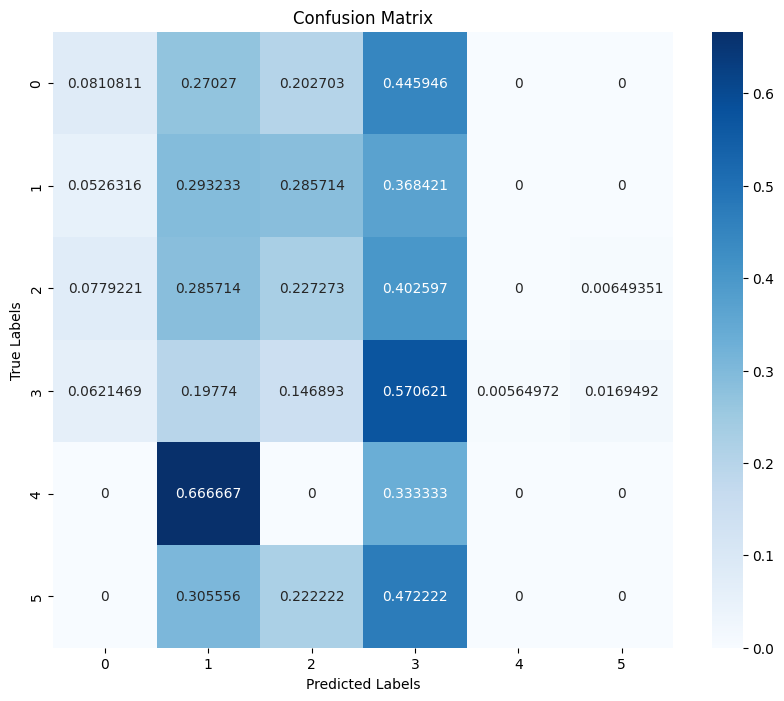

Epoch 18, Validation Loss: 3.7309, Accuracy: 0.3137, F1 Score: 0.2858
Val F1 Score Per Class  [0.10909091 0.27464789 0.25362319 0.45909091 0.         0.        ]


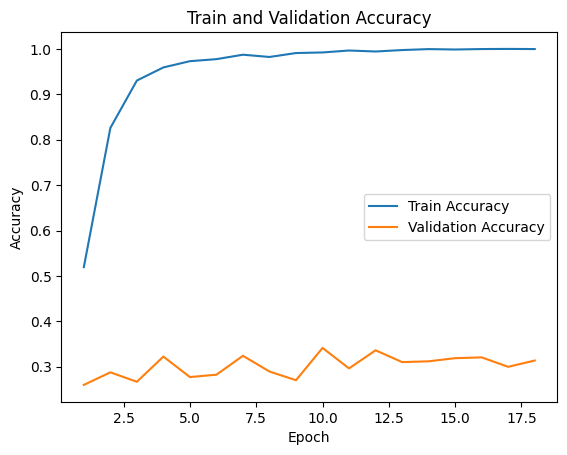

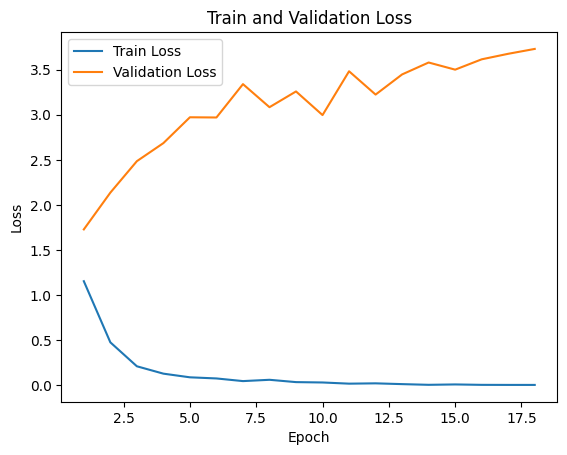

Epoch 19, Train Loss: 0.0005, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1. 1.]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.43it/s, loss=3.94]

[tensor([-0.3583, -0.6577, -2.2396,  0.0599, -7.3898, -4.5768], device='cuda:0'), tensor([ 1.0570, -3.0829, -0.6136,  3.4234, -3.4413, -3.6757], device='cuda:0'), tensor([-2.3819, -1.7005, -1.2825,  6.3208, -4.7336, -4.7494], device='cuda:0'), tensor([-1.2041, -2.0908,  5.2813, -1.7752, -5.3139, -3.4039], device='cuda:0'), tensor([-0.6407, -3.9434,  5.7266, -0.1864, -3.6932, -3.6217], device='cuda:0'), tensor([ 0.1965, -1.3064, -0.7788, -1.0390, -6.6634, -5.3861], device='cuda:0'), tensor([-4.3387,  0.9292,  0.6937, -0.2201, -4.4490, -3.1556], device='cuda:0'), tensor([-0.7053, -2.5052, -0.3662,  5.5755, -4.9321, -5.2469], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.42it/s, loss=5.16]

[tensor([-3.3444, -1.1360, -1.7277,  6.6455, -3.6315, -3.6462], device='cuda:0'), tensor([-3.3619, -2.9524, -0.5698,  4.7658, -5.4920, -4.4829], device='cuda:0'), tensor([ 1.0809, -3.3873, -1.2183,  0.7595, -3.5375, -3.1806], device='cuda:0'), tensor([-3.8389, -2.0293, -1.9204,  1.8690, -2.6124, -2.9346], device='cuda:0'), tensor([-2.2102, -0.2020, -2.4362,  6.8507, -4.4988, -3.3802], device='cuda:0'), tensor([-3.4403,  2.1942, -3.0870, -0.9452, -5.8922, -4.4352], device='cuda:0'), tensor([-4.1903, -0.6045, -1.7026,  5.1369, -4.8716, -2.9388], device='cuda:0'), tensor([-0.9061, -2.7966, -3.1149,  4.0839, -4.4719, -1.3329], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.37it/s, loss=2.65]

[tensor([-3.2967,  0.1920, -2.7437,  3.6991, -4.6815, -4.2716], device='cuda:0'), tensor([-3.9355, -1.5883,  2.6749,  3.5963, -3.2732, -5.1563], device='cuda:0'), tensor([-2.0518,  5.5025, -1.4576, -2.9042, -3.2572, -2.8296], device='cuda:0'), tensor([-2.7583,  0.7289, -1.2785, -1.6062, -5.0194, -4.7436], device='cuda:0'), tensor([ 3.2546, -0.8835, -3.4455,  0.6756, -4.6100, -2.5560], device='cuda:0'), tensor([-1.7592, -1.5795,  5.3955, -1.7135, -5.2546, -4.2716], device='cuda:0'), tensor([-1.5082, -1.1395, -2.7312,  0.5889, -5.3991, -2.3772], device='cuda:0'), tensor([-2.1189, -2.0153,  1.5021,  3.7480, -5.2886, -5.0148], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:29,  2.37it/s, loss=3.86]

[tensor([ 4.2469, -0.5481, -2.8088, -1.0477, -3.0000, -2.9656], device='cuda:0'), tensor([-2.9888, -2.3718, -1.2774,  6.7631, -3.2333, -3.8963], device='cuda:0'), tensor([-3.6981, -0.0204,  0.0734,  2.8219, -5.5324, -5.0501], device='cuda:0'), tensor([-1.6796,  5.6091, -2.5918, -0.5631, -4.2899, -2.8025], device='cuda:0'), tensor([-1.4162, -2.5757,  7.5959, -2.1914, -4.2138, -2.2477], device='cuda:0'), tensor([-1.3410, -2.4579, -1.9166,  1.2489, -6.5731, -4.7609], device='cuda:0'), tensor([-2.8384, -4.1884,  2.3363,  2.5182, -3.9219, -1.7758], device='cuda:0'), tensor([ 1.2889, -2.3401, -0.8161,  2.2538, -4.6370, -4.5005], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=4.69]

[tensor([-3.6462,  1.5005, -0.5711, -2.7367, -5.7425, -3.2246], device='cuda:0'), tensor([-2.5951, -3.2817,  0.0963, -0.5062, -4.4139, -1.6117], device='cuda:0'), tensor([-2.5049, -0.4602, -0.1615,  0.2559, -6.1710, -4.4869], device='cuda:0'), tensor([-2.4920, -1.7009,  7.5890, -2.0999, -3.9427, -3.5747], device='cuda:0'), tensor([-3.3095, -2.3937,  4.3947, -1.3523, -3.8792, -1.8272], device='cuda:0'), tensor([-3.5611, -1.4677,  1.5131,  4.1691, -5.1312, -3.9853], device='cuda:0'), tensor([-3.7508, -1.0392,  1.5147,  0.3753, -6.2894, -3.9838], device='cuda:0'), tensor([-4.3371,  5.1061, -1.6628,  1.0744, -5.3671, -5.0700], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:28,  2.38it/s, loss=4.24]

[tensor([-1.8035,  0.7128, -3.6004,  3.2304, -4.8921, -4.7796], device='cuda:0'), tensor([-1.6624, -0.6675, -2.3890,  0.7731, -4.2313, -2.0586], device='cuda:0'), tensor([-3.8553,  3.2849, -0.5256,  0.4577, -5.8326, -3.1926], device='cuda:0'), tensor([-1.7772, -0.8414, -0.7777, -1.1791, -6.1073, -4.6966], device='cuda:0'), tensor([ 0.9690,  1.0939, -0.7141,  0.2343, -5.5146, -3.7516], device='cuda:0'), tensor([-4.2334, -0.5755,  5.7687, -1.0667, -5.0716, -4.5724], device='cuda:0'), tensor([-2.9226,  6.8581, -1.2029, -2.9113, -3.9340, -2.8619], device='cuda:0'), tensor([-1.7996,  5.8477, -2.4674, -1.4518, -3.8712, -2.8134], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.38it/s, loss=2.51]

[tensor([-2.1866, -3.0095,  5.8170, -1.6543, -5.0312, -3.8547], device='cuda:0'), tensor([-2.6096, -2.6821,  7.5825, -1.0941, -4.4163, -3.2413], device='cuda:0'), tensor([-1.1983, -2.9544, -1.1476,  5.5024, -4.3275, -1.8288], device='cuda:0'), tensor([-1.6398, -2.0198,  0.3408, -0.4839, -5.7122, -3.1677], device='cuda:0'), tensor([-1.3507, -0.9768,  5.9580, -1.0678, -5.4347, -4.8521], device='cuda:0'), tensor([-2.9705, -1.4981, -2.4055,  6.3249, -3.9963, -1.8099], device='cuda:0'), tensor([-3.7893, -0.4127, -2.5744,  0.4981, -4.4141, -3.1527], device='cuda:0'), tensor([-1.5244, -2.0176,  7.8655, -2.2206, -2.9695, -2.3275], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.38it/s, loss=4.06]

[tensor([-3.1117,  4.2667, -2.3101,  0.3751, -3.2782, -3.5329], device='cuda:0'), tensor([-2.6252,  0.8528, -2.5593, -1.3203, -3.0734, -1.1623], device='cuda:0'), tensor([ 3.9867, -2.1729, -2.7054, -1.6916, -4.6445, -1.3682], device='cuda:0'), tensor([-3.2776, -0.6451, -1.4859,  6.6938, -5.2416, -3.7355], device='cuda:0'), tensor([-3.4648e+00, -5.5016e-01, -2.4765e+00, -3.1357e-03, -4.8984e+00,
        -2.1755e+00], device='cuda:0'), tensor([-2.2687, -3.7496, -1.5006,  6.2164, -4.1206, -2.9557], device='cuda:0'), tensor([-1.3310, -2.4004,  5.9676, -0.9311, -5.3912, -4.4735], device='cuda:0'), tensor([-4.2065, -0.9778, -2.2363,  5.8965, -4.6875, -3.4476], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.39it/s, loss=3.68]

[tensor([-3.4320,  6.3850, -1.5423, -0.5477, -5.0639, -3.1917], device='cuda:0'), tensor([-3.3990, -3.1243, -0.0339,  6.3107, -5.0361, -3.2784], device='cuda:0'), tensor([ 0.6379, -3.5093, -1.7638,  5.8803, -4.9502, -3.1271], device='cuda:0'), tensor([-3.6018, -1.7534, -2.4930,  4.9886, -5.0922, -3.7368], device='cuda:0'), tensor([-2.6747, -2.4376,  0.1341,  2.6946, -5.6602, -4.4272], device='cuda:0'), tensor([-3.2062,  2.7810, -2.6351,  0.9388, -5.6095, -4.9893], device='cuda:0'), tensor([-4.5144, -1.5506,  2.2772,  0.1236, -4.8763, -3.7318], device='cuda:0'), tensor([-3.6758, -2.1790, -0.1422,  4.4560, -6.0105, -3.5540], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.39it/s, loss=5.39]

[tensor([-2.8028, -0.5526, -2.6436,  4.6770, -5.5057, -4.6972], device='cuda:0'), tensor([-3.1171, -1.9089, -1.5366,  6.9825, -3.9638, -3.3819], device='cuda:0'), tensor([-3.2024,  1.6215, -1.3115, -0.9580, -5.5915, -5.4098], device='cuda:0'), tensor([-3.5846, -0.2526,  1.2303, -2.0599, -4.8666, -4.9209], device='cuda:0'), tensor([-2.5735,  5.2703, -0.6200, -2.4692, -4.5360, -4.4522], device='cuda:0'), tensor([-4.2835, -0.5761, -1.6577,  2.1582, -5.3947, -4.1249], device='cuda:0'), tensor([ 1.7488, -1.0709, -0.8088,  1.2709, -5.6900, -5.3436], device='cuda:0'), tensor([-2.5958, -1.0447, -2.8365,  2.7641, -5.9615, -5.0759], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.39it/s, loss=3.43]

[tensor([-2.5403,  4.8599, -2.3982,  0.3716, -4.2590, -4.3280], device='cuda:0'), tensor([-3.4362,  0.4259, -0.9638,  1.9225, -5.1774, -3.7281], device='cuda:0'), tensor([-4.3694,  2.1765, -2.0386,  1.6481, -5.5717, -4.3822], device='cuda:0'), tensor([-3.3621, -2.5206,  6.1659, -0.3062, -4.0173, -3.3001], device='cuda:0'), tensor([-3.2163, -2.4194,  5.3207,  1.2076, -5.2719, -3.5427], device='cuda:0'), tensor([-3.5847, -1.9454, -1.8460,  7.3348, -4.5125, -2.8035], device='cuda:0'), tensor([-2.4165,  3.0610, -2.6578, -0.1777, -5.5552, -5.4387], device='cuda:0'), tensor([-3.0581, -2.1451, -0.0759,  4.6031, -5.8274, -3.5189], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.38it/s, loss=3.36]

[tensor([-2.0365, -1.4296, -1.5348, -1.2184, -5.8026, -4.7087], device='cuda:0'), tensor([-1.8557, -2.9887, -0.4476,  0.8539, -5.9194, -4.2905], device='cuda:0'), tensor([-2.8490, -3.1465, -1.5340,  6.9147, -3.8855, -2.6267], device='cuda:0'), tensor([-3.2421, -1.5846, -1.9451,  4.3516, -5.9928, -3.2745], device='cuda:0'), tensor([-1.6908,  3.5553, -2.5710, -1.0086, -5.7032, -4.5991], device='cuda:0'), tensor([-1.3917, -0.3076, -2.8445,  0.0823, -5.0306, -4.1869], device='cuda:0'), tensor([-4.7053, -2.3771,  2.4445, -0.5955, -4.4623, -1.4662], device='cuda:0'), tensor([-0.1237, -2.5942,  1.0333,  0.6845, -6.0629, -4.0193], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.39it/s, loss=3.64]

[tensor([-3.4429, -1.3257, -2.4614,  3.2307, -3.3383, -1.3889], device='cuda:0'), tensor([-2.5007, -2.0609, -0.9612,  4.4264, -5.6460, -4.4200], device='cuda:0'), tensor([-2.6199,  1.3114, -4.8888,  2.5579, -4.3508, -1.5193], device='cuda:0'), tensor([-3.1091, -2.7219,  6.2289, -0.0382, -4.3009, -4.1837], device='cuda:0'), tensor([-3.3003, -1.1734, -1.5616,  5.4182, -5.3461, -4.1016], device='cuda:0'), tensor([ 0.0181, -2.5118, -2.8291,  1.7585, -4.4775, -5.1674], device='cuda:0'), tensor([-4.0084,  3.2538, -2.3844, -0.8683, -4.6531, -4.0595], device='cuda:0'), tensor([-3.0700,  5.4806, -1.7398,  0.1096, -5.0153, -4.5760], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.94]

[tensor([-2.3355,  0.1167,  6.8292, -2.9108, -3.2218, -3.2654], device='cuda:0'), tensor([-1.6183,  0.6331, -2.9101, -0.9439, -5.2304, -5.5764], device='cuda:0'), tensor([ 1.0216, -1.7924, -0.7236,  0.1785, -5.3879, -4.8749], device='cuda:0'), tensor([-2.1255, -2.1423,  0.2753,  0.3487, -5.9039, -4.7536], device='cuda:0'), tensor([-3.0190,  4.2064, -2.1082, -0.5924, -5.5111, -4.7941], device='cuda:0'), tensor([-2.9888, -0.2187,  0.4710,  2.2838, -4.7752, -4.2810], device='cuda:0'), tensor([-1.8781, -0.2584, -2.5939,  1.3301, -5.6547, -6.1007], device='cuda:0'), tensor([-1.8238, -0.8208, -2.0982,  2.3313, -5.1526, -5.1793], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=2.9]

[tensor([-2.9310, -2.3519, -1.7582,  1.9519, -4.5436, -4.7555], device='cuda:0'), tensor([-4.7664, -1.2286, -2.1064,  4.3775, -4.8203, -3.2677], device='cuda:0'), tensor([-2.5797, -3.7713,  0.8897,  0.8133, -3.1778, -2.7530], device='cuda:0'), tensor([-1.1664, -0.3830, -1.0862, -2.9153, -5.5296, -3.5442], device='cuda:0'), tensor([-3.0455, -1.5580,  6.1983, -1.6872, -4.7032, -3.9652], device='cuda:0'), tensor([ 0.8990, -3.2637,  0.5010,  3.7356, -5.7704, -4.0403], device='cuda:0'), tensor([-2.9296, -0.4862, -2.5920,  4.4586, -3.7134, -2.7696], device='cuda:0'), tensor([-4.1324, -0.4368,  0.1481,  1.2303, -5.2390, -4.3173], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:24,  2.37it/s, loss=5.21]

[tensor([-0.0104, -1.0582, -0.8536,  4.6161, -5.1338, -5.4156], device='cuda:0'), tensor([-4.0367, -1.7977, -1.9155,  6.8042, -4.8067, -3.8368], device='cuda:0'), tensor([-3.8652, -1.0017, -0.4236, -1.3888, -4.5185,  6.0013], device='cuda:0'), tensor([-3.3781, -2.3291,  0.4779,  5.8481, -5.3207, -4.2042], device='cuda:0'), tensor([ 7.5949, -2.0307, -0.7925, -1.0508, -3.9360, -3.3343], device='cuda:0'), tensor([-1.4177,  2.0484, -2.1443,  1.1286, -5.4757, -4.4992], device='cuda:0'), tensor([-2.3758, -2.0109, -1.6567, -0.9309, -4.6958, -3.4979], device='cuda:0'), tensor([ 5.2519, -1.7559, -3.6535, -0.7895, -3.5982, -0.6319], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.37it/s, loss=4.75]

[tensor([-2.6405,  6.4743, -1.3017, -1.7326, -4.2743, -3.8157], device='cuda:0'), tensor([-1.9991, -1.4247, -1.4568,  5.1485, -5.9695, -5.4700], device='cuda:0'), tensor([-4.0754,  1.2635, -1.6114,  0.2722, -5.9506, -0.3745], device='cuda:0'), tensor([-3.0990, -1.0564,  2.8010, -1.2458, -5.0011, -4.7767], device='cuda:0'), tensor([ 8.0985, -2.5037, -1.1671, -0.5775, -3.4673, -3.2974], device='cuda:0'), tensor([-0.8731,  5.9570, -2.4543, -1.0940, -4.5304, -4.5926], device='cuda:0'), tensor([-2.1514, -3.1965,  7.3149, -0.3293, -4.1299, -3.0353], device='cuda:0'), tensor([-2.4762, -2.4033, -0.4443,  3.3828, -5.1782, -3.7836], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.38it/s, loss=3.4]

[tensor([-3.0044,  0.1376, -2.7736,  2.6750, -3.5817, -3.4795], device='cuda:0'), tensor([-3.5974, -1.6253,  3.7156, -0.2465, -3.3772, -4.1693], device='cuda:0'), tensor([-3.5237,  1.8715, -1.0681, -0.9548, -5.0868, -4.2449], device='cuda:0'), tensor([-3.1913, -3.0763, -1.4430,  6.9179, -3.3095, -3.2156], device='cuda:0'), tensor([-3.8997,  0.4149, -2.9643,  0.1529, -4.7839, -1.5124], device='cuda:0'), tensor([ 8.1688, -1.1002, -1.9593, -1.2432, -4.2236, -2.6753], device='cuda:0'), tensor([-2.1169, -1.6986, -2.4070,  2.3382, -4.9764, -4.1279], device='cuda:0'), tensor([-2.3587, -3.2477,  3.6480, -1.4788, -6.2394, -3.7855], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.38it/s, loss=3.91]

[tensor([-4.9786, -0.0081, -1.2667,  1.7065, -4.9212, -4.5866], device='cuda:0'), tensor([-3.2318, -2.3342,  4.9432,  0.0291, -4.0323, -4.4505], device='cuda:0'), tensor([-0.5190, -3.3090,  3.6314, -1.9036, -4.1709, -0.9338], device='cuda:0'), tensor([-3.0472,  1.3711,  0.5077,  1.2632, -2.1755, -5.1597], device='cuda:0'), tensor([-4.3586,  5.3115, -0.5680, -1.3015, -3.8611, -2.5986], device='cuda:0'), tensor([-2.7377,  2.2002, -3.2703,  0.9679, -4.3183, -3.6650], device='cuda:0'), tensor([-2.2971, -2.2307, -1.0017,  7.1145, -4.6748, -3.4053], device='cuda:0'), tensor([-0.4848, -1.1465, -3.2495,  3.2170, -4.5727, -4.4116], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.37it/s, loss=2.55]

[tensor([-4.4360,  3.6298, -0.5750, -1.2932, -5.1973, -2.7392], device='cuda:0'), tensor([-1.4930, -2.8732, -1.1790,  6.0006, -5.6535, -4.1812], device='cuda:0'), tensor([-3.2668, -1.0272,  5.7846, -2.0924, -5.0946, -4.0546], device='cuda:0'), tensor([-3.3055,  2.0952,  1.7759, -2.3068, -5.2546, -3.6987], device='cuda:0'), tensor([-4.5354,  1.8742, -2.9726,  0.4980, -5.0771, -5.0152], device='cuda:0'), tensor([-4.0521, -1.9407, -0.2623,  0.3180, -4.8392, -3.1898], device='cuda:0'), tensor([-2.5699,  0.6636,  0.6926,  0.2096, -4.7236, -4.1026], device='cuda:0'), tensor([-1.5617,  6.3071, -2.5500, -1.0994, -3.4212, -3.5766], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=7.33]

[tensor([-1.9574, -2.2903,  7.6613, -2.1807, -3.6856, -2.0893], device='cuda:0'), tensor([-1.4295,  5.7485, -2.4226, -0.8778, -4.8403, -3.7527], device='cuda:0'), tensor([-3.6576,  1.6019, -3.0787,  4.1787, -4.8242, -5.1435], device='cuda:0'), tensor([-3.2262,  0.1652, -3.4649,  5.5195, -4.9934, -3.7925], device='cuda:0'), tensor([-2.8344,  6.6635, -2.5973, -2.0873, -3.4146, -1.6218], device='cuda:0'), tensor([-1.7836, -3.3398, -2.4134,  1.2803, -4.9584, -3.9159], device='cuda:0'), tensor([-1.1392,  6.9067, -2.1002, -2.1898, -4.8708, -2.4473], device='cuda:0'), tensor([ 2.1512, -1.9265, -2.2689,  2.4201, -4.5984, -5.8712], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.37it/s, loss=2.85]

[tensor([-0.7512, -2.1311,  3.2590, -2.3654, -4.0495, -3.9912], device='cuda:0'), tensor([-2.3039, -2.9215,  4.6168, -1.1872, -5.3338, -4.6043], device='cuda:0'), tensor([-0.4629,  0.3342,  1.6672, -0.2562, -7.6435, -5.6607], device='cuda:0'), tensor([-2.8211, -1.6515, -0.9347,  4.0728, -4.7260, -4.3297], device='cuda:0'), tensor([-3.6403, -0.2864, -2.6407,  0.0150, -4.6550, -4.1348], device='cuda:0'), tensor([ 1.3397, -2.4099,  1.3352, -1.5365, -4.9333, -4.0886], device='cuda:0'), tensor([-2.2423, -2.0923,  0.3388,  4.5377, -7.3678, -3.4464], device='cuda:0'), tensor([-1.7503, -3.1113,  6.0124, -0.9188, -5.2939, -4.2376], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:21,  2.38it/s, loss=4.31]

[tensor([-2.5010, -2.2859, -3.1533, -0.3880, -3.2311, -3.6319], device='cuda:0'), tensor([-0.7433, -0.0752,  0.0455, -2.6032, -4.8928, -5.0042], device='cuda:0'), tensor([-2.9335, -0.9204, -2.1677,  6.3007, -5.0197, -3.9093], device='cuda:0'), tensor([-2.0379,  6.3370, -0.9909, -2.4126, -3.4930, -2.4851], device='cuda:0'), tensor([-3.2298,  0.0795, -2.7973,  0.0979, -5.4260, -3.8523], device='cuda:0'), tensor([-3.4339,  6.2549, -1.1935, -1.1488, -4.3407, -3.4521], device='cuda:0'), tensor([-2.1091, -3.6412,  2.8059,  0.7092, -4.9959, -3.1870], device='cuda:0'), tensor([-3.3351,  5.4294, -2.1508, -1.0325, -5.3889, -1.7946], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.38it/s, loss=4.09]

[tensor([-1.9658, -3.4387,  0.6757,  5.3773, -4.7330, -5.1231], device='cuda:0'), tensor([-2.7990, -1.0184,  1.4654,  2.4057, -5.6552, -5.2772], device='cuda:0'), tensor([-3.8263,  1.3382, -2.7879,  1.3999, -5.9655, -3.9263], device='cuda:0'), tensor([-1.8860, -5.1728, -2.0122,  2.5360, -4.1442,  0.2732], device='cuda:0'), tensor([-0.7908, -3.6065, -2.2713,  5.3079, -4.1191, -2.8808], device='cuda:0'), tensor([-2.8976, -0.8799, -2.3573,  0.9846, -5.0154, -3.3956], device='cuda:0'), tensor([-1.1552, -0.7083, -3.2177, -1.6152, -4.3110, -0.1136], device='cuda:0'), tensor([-1.4936, -2.9733, -1.6612,  5.8862, -4.5877, -4.3892], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.37it/s, loss=3.54]

[tensor([-3.3032, -2.0771,  7.0144, -0.7024, -4.7637, -3.6949], device='cuda:0'), tensor([-2.2167, -1.4387,  7.1636, -1.7829, -3.3403, -3.1369], device='cuda:0'), tensor([-4.1590, -1.6217,  0.2157,  1.0465, -5.0439, -4.2930], device='cuda:0'), tensor([-3.9232,  2.7667, -1.9075,  1.1876, -5.0766, -4.2764], device='cuda:0'), tensor([-2.8976,  2.0229, -3.0249, -1.3240, -5.0225, -3.4612], device='cuda:0'), tensor([-3.4424, -2.6844,  1.5844, -0.5266, -4.2485, -3.8398], device='cuda:0'), tensor([-1.8438, -0.4567, -4.0915,  2.9038, -4.3159, -3.5375], device='cuda:0'), tensor([-0.5573, -0.5600, -2.4103, -0.5567, -3.9524, -4.3822], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.38it/s, loss=2.18]

[tensor([-2.8569, -1.9433, -1.0229,  6.0600, -5.4978, -3.6952], device='cuda:0'), tensor([-3.5579, -1.7042, -1.6509,  3.1802, -5.8747, -3.5938], device='cuda:0'), tensor([-3.6805, -2.4148,  4.6249, -0.5591, -4.2305, -3.4050], device='cuda:0'), tensor([ 6.6871, -1.8881, -1.4002, -1.0390, -3.7947, -1.9065], device='cuda:0'), tensor([-3.4696,  2.0621, -1.8201,  4.9392, -5.9232, -4.4028], device='cuda:0'), tensor([-0.9742, -2.3405,  4.6142,  0.0358, -4.6837, -3.5843], device='cuda:0'), tensor([-1.5813,  1.0226, -2.0891,  1.5283, -4.5692, -5.0822], device='cuda:0'), tensor([-3.7379, -0.4204, -1.1497, -1.4338, -6.3643, -2.7505], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.37it/s, loss=2.75]

[tensor([-3.9076, -1.4099,  1.9932,  3.6412, -5.9655, -4.6277], device='cuda:0'), tensor([-3.8343, -0.9118, -1.2514,  1.6755, -4.8750, -4.7123], device='cuda:0'), tensor([-1.6602, -2.0635, -1.5769,  3.5289, -4.6550, -4.4053], device='cuda:0'), tensor([-2.6700, -3.2365,  1.2752,  4.2450, -5.9287, -3.4924], device='cuda:0'), tensor([-2.7100,  5.7074, -2.1320, -0.3465, -4.3902, -3.6090], device='cuda:0'), tensor([-1.1658, -1.6816,  2.0315, -1.1898, -5.8787, -4.2182], device='cuda:0'), tensor([-3.1390, -3.4051,  3.2896,  0.2810, -5.2303, -3.3858], device='cuda:0'), tensor([-2.7547, -0.4854, -3.3897,  5.4186, -5.2252, -3.6187], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.37it/s, loss=3.44]

[tensor([-0.5550, -2.6465, -1.4220,  5.2940, -5.0525, -4.3323], device='cuda:0'), tensor([-3.4098, -0.4406, -1.8648,  3.0013, -4.6541, -3.9759], device='cuda:0'), tensor([-1.9231,  3.2971, -1.1550, -2.9445, -4.3530, -3.3214], device='cuda:0'), tensor([-3.1515, -2.4887, -0.3861,  4.1552, -4.6260, -4.3678], device='cuda:0'), tensor([-2.9077, -2.1544, -1.5607,  6.2016, -4.6474, -3.4348], device='cuda:0'), tensor([-4.1596,  0.0253, -0.2148,  4.0642, -5.6900, -5.0763], device='cuda:0'), tensor([-4.0296, -1.9421,  2.1586,  0.9152, -5.6196, -4.3318], device='cuda:0'), tensor([-3.2134,  1.3338, -0.7910, -1.4121, -5.1730, -4.6302], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.36it/s, loss=4.66]

[tensor([-3.4380, -1.4430, -1.3066,  6.9406, -4.2294, -2.9966], device='cuda:0'), tensor([-4.1359, -0.6928, -1.1727, -0.4324, -4.6693, -2.2257], device='cuda:0'), tensor([-4.9386, -3.1780,  3.9796, -0.0599, -4.9972, -3.4855], device='cuda:0'), tensor([-3.1368,  5.0449, -2.2372, -0.1640, -4.4250, -4.3867], device='cuda:0'), tensor([ 0.8750,  2.5587, -2.0475, -1.3144, -5.8914, -3.6421], device='cuda:0'), tensor([-4.2607, -1.4522, -0.1608, -0.7760, -5.0611, -2.7701], device='cuda:0'), tensor([-3.8127, -1.5037, -1.0278,  3.9051, -3.9173, -3.7344], device='cuda:0'), tensor([-3.7725, -1.4334, -1.2234,  6.3640, -5.2002, -3.9954], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:18,  2.37it/s, loss=4.67]

[tensor([-4.3705,  5.2072, -1.3961, -0.1975, -4.7031, -3.3254], device='cuda:0'), tensor([-3.9992, -2.4193, -0.3913,  4.7014, -4.1175, -4.1689], device='cuda:0'), tensor([-1.5568,  1.0401, -2.9176, -1.3044, -3.9467, -2.3972], device='cuda:0'), tensor([-2.1210, -2.0932, -1.9721,  7.0313, -4.3111, -3.8665], device='cuda:0'), tensor([-3.0236, -1.0452, -2.9058, -1.8934, -5.5217, -3.0480], device='cuda:0'), tensor([-2.1360, -3.2075,  3.1985, -0.1804, -4.2087, -2.5081], device='cuda:0'), tensor([-3.6899, -3.5801,  2.0651,  2.3898, -6.0229, -5.0973], device='cuda:0'), tensor([-0.9180, -1.6856, -0.3408, -2.0741, -3.1239,  8.7034], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=4.39]

[tensor([-2.8229,  3.3701, -3.9409,  1.5569, -4.4045, -3.0882], device='cuda:0'), tensor([-2.9573, -2.1654, -1.9519,  6.9265, -4.9079, -3.1701], device='cuda:0'), tensor([-4.4044,  4.9937, -1.3035, -0.3941, -5.2809, -2.3682], device='cuda:0'), tensor([-1.6918,  5.8927, -3.0895, -1.4370, -5.0176, -2.4343], device='cuda:0'), tensor([-2.7624,  3.1171, -0.0384, -1.4567, -5.4515, -3.6438], device='cuda:0'), tensor([ 8.2600, -1.0375, -1.8670, -2.1056, -2.4341, -1.4151], device='cuda:0'), tensor([-2.2748, -3.2667, -0.5374,  6.3196, -4.1501, -4.1469], device='cuda:0'), tensor([-3.0151, -1.4412,  4.6774,  0.5123, -5.2055, -4.6167], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.38it/s, loss=5.35]

[tensor([-3.0466, -1.1018, -3.2643, -0.5310, -4.0351, -2.7268], device='cuda:0'), tensor([-2.7584, -1.7497, -2.2214,  7.2677, -4.0302, -3.1405], device='cuda:0'), tensor([-1.9617,  7.4570, -2.4813, -1.5635, -2.5013, -2.8314], device='cuda:0'), tensor([-3.6619,  3.5707, -2.4387, -0.7880,  1.9442, -2.0026], device='cuda:0'), tensor([-1.8685,  0.0921,  0.7783, -1.2080, -3.5139, -4.5157], device='cuda:0'), tensor([-2.1079, -3.3650, -0.2896,  3.9251, -5.0464, -3.8003], device='cuda:0'), tensor([ 3.8999, -3.1650, -1.5796, -0.4413, -4.7705, -2.8871], device='cuda:0'), tensor([ 1.9167, -0.7015, -2.5695, -0.1845, -5.5218, -3.7931], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.38it/s, loss=6.65]

[tensor([-4.2129, -2.1625, -0.9588,  5.5388, -4.0377, -2.1016], device='cuda:0'), tensor([-3.6312,  4.5392, -2.0903,  1.8920, -4.6450, -3.0965], device='cuda:0'), tensor([-2.4242, -3.0398, -1.5522,  6.5334, -5.5876, -3.4847], device='cuda:0'), tensor([-2.0668,  6.5479, -0.5148, -2.5629, -4.1963, -4.1121], device='cuda:0'), tensor([-3.5367, -2.0687,  7.4661, -1.6687, -3.1519, -3.1279], device='cuda:0'), tensor([-1.7710, -3.1715, -0.9694,  1.6641, -4.6698, -3.5445], device='cuda:0'), tensor([-2.2502,  4.0546, -3.0274, -1.6909, -5.2915, -3.8025], device='cuda:0'), tensor([-3.5308, -0.2912, -2.0564,  3.8111, -4.2105, -3.8073], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=4.04]

[tensor([ 7.9756, -0.6764, -2.7666, -1.6713, -2.5490, -2.5140], device='cuda:0'), tensor([-2.4423,  0.7970, -1.3242,  0.2493, -6.5993, -5.4885], device='cuda:0'), tensor([-3.5608,  0.5897, -1.9286,  0.8470, -0.7687, -3.9368], device='cuda:0'), tensor([-3.8798, -3.0037, -0.8359,  5.9806, -4.6306, -2.5655], device='cuda:0'), tensor([-3.3605,  2.9248, -2.1445,  2.6662, -4.4680, -4.6461], device='cuda:0'), tensor([-3.8866,  2.3757, -1.1793,  1.4587, -5.4990, -3.6149], device='cuda:0'), tensor([-2.2810, -2.6977, -1.7375,  6.0775, -4.6511, -3.9278], device='cuda:0'), tensor([-2.1550, -1.3645,  7.2459, -2.2313, -4.3412, -3.3180], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.38it/s, loss=4.24]

[tensor([-2.0169, -0.7246,  1.0082, -0.6628, -6.6567, -4.3162], device='cuda:0'), tensor([-1.7937,  3.8579,  0.2069, -1.8555, -5.2243, -4.4751], device='cuda:0'), tensor([-2.3132, -3.3530,  3.2030, -1.1431, -5.1282, -3.9497], device='cuda:0'), tensor([-2.2397, -1.5645,  7.7591, -1.7277, -3.3792, -2.8332], device='cuda:0'), tensor([-3.2965,  6.0948, -2.0009,  0.2341, -4.7286, -3.1961], device='cuda:0'), tensor([-2.0593, -3.1625, -0.7543,  2.2416, -4.8338, -1.6425], device='cuda:0'), tensor([-3.1194, -2.3590,  0.2273,  5.6810, -5.9529, -4.1747], device='cuda:0'), tensor([-3.1204,  0.0170,  1.1626,  2.3241, -5.4134, -4.9502], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.36it/s, loss=3.58]

[tensor([-2.8635, -0.2793,  1.0594, -2.2236, -3.9775, -3.1223], device='cuda:0'), tensor([-2.4889, -1.2665,  6.9388, -2.2167, -3.1063, -3.6118], device='cuda:0'), tensor([-2.8635, -2.6330, -1.1230,  1.1435, -5.1616, -2.4156], device='cuda:0'), tensor([-2.7640,  6.7509, -3.1002, -0.2737, -4.2164, -3.0813], device='cuda:0'), tensor([-2.8862, -2.6254, -0.9506,  2.2344, -5.6384, -3.8150], device='cuda:0'), tensor([-2.1708, -3.4186, -0.9514,  5.9583, -4.6507, -3.7514], device='cuda:0'), tensor([-2.2437, -2.1333, -2.1494,  7.2914, -4.2100, -3.5304], device='cuda:0'), tensor([-2.4538,  0.0766, -2.5340,  2.8003, -4.8594, -4.6704], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.38it/s, loss=5.02]

[tensor([ 0.6854, -2.4312, -2.5549,  3.0583, -4.4069, -3.4429], device='cuda:0'), tensor([-3.0369, -2.0006, -1.0636,  3.5688, -5.7172, -4.4319], device='cuda:0'), tensor([-2.6903, -2.0460, -2.9555,  4.9231, -4.1105, -3.6404], device='cuda:0'), tensor([-3.5296,  6.4190, -2.6749, -1.0253, -3.8482, -1.0705], device='cuda:0'), tensor([-2.4942,  2.0289,  3.5926, -2.7964, -4.9460, -2.9393], device='cuda:0'), tensor([-3.0824,  6.9103, -1.9639, -1.3923, -3.6363, -3.1728], device='cuda:0'), tensor([-2.1528,  2.4357, -0.8680,  0.8654, -5.1889, -4.8299], device='cuda:0'), tensor([-4.2892,  1.3502, -0.6983,  2.5787, -4.7229, -4.9736], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.37it/s, loss=3.31]

[tensor([-2.0508, -2.0070,  3.2543, -0.8024, -4.2350, -2.3591], device='cuda:0'), tensor([-3.4115, -0.1573, -1.5338,  1.4193, -6.4744, -1.5330], device='cuda:0'), tensor([-0.4559, -1.6777, -1.2733,  3.3743, -6.2336, -5.0607], device='cuda:0'), tensor([-3.5940,  1.5204, -3.1721, -0.6907, -3.7981, -4.4568], device='cuda:0'), tensor([-3.1848, -1.1861,  0.3809, -1.1666, -5.3952, -5.8787], device='cuda:0'), tensor([-2.1742,  6.9791, -2.6504, -0.9299, -3.0992, -2.7120], device='cuda:0'), tensor([-2.2557,  2.0481, -0.6373, -2.8610, -4.8915, -4.4367], device='cuda:0'), tensor([-2.9464, -3.1654,  5.3798,  0.8178, -5.3888, -4.3369], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=4.03]

[tensor([-1.4647, -1.4080,  1.5112, -0.3019, -5.6476, -5.1719], device='cuda:0'), tensor([-2.9423, -0.9942, -0.4152,  5.2171, -4.4864, -5.4410], device='cuda:0'), tensor([ 1.0934, -1.7995, -0.8252,  0.3912, -4.9682, -3.8323], device='cuda:0'), tensor([-1.6382, -3.3105, -0.5035,  2.0279, -6.2286, -4.5383], device='cuda:0'), tensor([-3.6850, -2.1591, -2.1203,  1.2821, -5.0662, -4.4639], device='cuda:0'), tensor([-3.2198, -1.3622,  6.8013, -1.4525, -4.8204, -3.4971], device='cuda:0'), tensor([ 3.4953, -2.3361,  0.7278, -1.4466, -4.5519, -4.4256], device='cuda:0'), tensor([-4.6735,  2.4505, -1.5469, -0.3449, -6.3932, -1.6474], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.37it/s, loss=4.11]

[tensor([ 0.9050, -2.1362,  0.2022,  1.1846, -5.0390, -4.4456], device='cuda:0'), tensor([-1.3377, -2.1861,  6.1569, -2.0921, -3.3825, -2.8300], device='cuda:0'), tensor([-3.2113, -1.8689, -1.9295,  5.1746, -5.8715, -2.4836], device='cuda:0'), tensor([ 2.7114, -2.1585, -3.3714,  2.7091, -3.8437, -3.4637], device='cuda:0'), tensor([-4.6675,  3.2495, -1.9635, -0.2698, -4.9338, -2.1820], device='cuda:0'), tensor([ 1.9866, -0.8210, -2.8278,  2.0302, -3.2986, -4.2467], device='cuda:0'), tensor([-3.9474, -0.8113, -1.2504,  4.7082, -4.4986, -4.4056], device='cuda:0'), tensor([-0.5825, -2.0133, -2.5043,  4.3334, -5.0253,  0.1118], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.35it/s, loss=2.57]

[tensor([-3.2386, -2.5119, -0.8490,  4.8914, -4.8654, -4.1453], device='cuda:0'), tensor([-3.1250, -0.0471,  1.2548,  1.8490, -3.6877, -5.5846], device='cuda:0'), tensor([-1.7823, -2.0644, -1.7972,  3.3091, -4.9696, -3.5957], device='cuda:0'), tensor([-4.1379,  2.9334, -2.5507,  2.3454, -4.8743, -3.9492], device='cuda:0'), tensor([-3.5244,  1.7213, -0.7813,  0.4990, -5.7027, -4.9685], device='cuda:0'), tensor([-2.8918, -2.1039, -1.6125,  6.6263, -4.5535, -3.8567], device='cuda:0'), tensor([-3.5762, -1.5408, -1.6902,  0.2377, -5.3348, -5.0666], device='cuda:0'), tensor([-0.4079, -1.1963, -1.9157,  2.2254, -4.9322, -5.1981], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.36it/s, loss=3.52]

[tensor([-2.9461, -3.0161, -0.2894,  5.7472, -4.5019, -4.0579], device='cuda:0'), tensor([ 6.9056, -2.0859,  0.1255, -1.0690, -4.0117, -2.7560], device='cuda:0'), tensor([-1.4542, -2.4654, -2.0148,  4.0681, -5.9959, -4.7652], device='cuda:0'), tensor([ 1.1241,  0.3632, -2.9897, -0.8545, -3.8968, -3.2708], device='cuda:0'), tensor([-3.5412, -1.5051,  0.3072,  2.8312, -4.4666, -4.0504], device='cuda:0'), tensor([-2.2109, -3.2463, -1.9203,  6.8587, -3.9089, -3.7931], device='cuda:0'), tensor([-3.6822, -2.6874,  1.1361,  3.3157, -4.9190, -2.7520], device='cuda:0'), tensor([ 1.7455, -1.7953, -0.0995,  0.6863, -5.2890, -5.7689], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:18<00:12,  2.36it/s, loss=2.17]

[tensor([-3.0720, -1.1562, -2.3431,  6.5699, -4.5712, -3.5089], device='cuda:0'), tensor([-2.8613, -1.4220, -0.8212,  0.0359, -5.2602, -4.2724], device='cuda:0'), tensor([-0.6768, -0.7734, -1.6581,  0.0275, -6.6087, -4.5524], device='cuda:0'), tensor([-3.4141,  3.0784, -2.6315,  2.4719, -6.2468, -2.6214], device='cuda:0'), tensor([-2.7750,  2.9307, -3.3814,  0.5149, -4.9065, -3.0793], device='cuda:0'), tensor([-4.0391,  2.1771,  4.4431, -2.5284, -3.7822, -3.9688], device='cuda:0'), tensor([-3.2524, -1.7729,  2.0216,  3.1622, -5.4765, -4.2291], device='cuda:0'), tensor([-4.3128, -0.8525, -2.0094, -0.7959, -4.9619, -3.3012], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.37it/s, loss=3.9]

[tensor([-2.7180, -0.2530, -1.7767,  5.0564, -3.3305, -4.7090], device='cuda:0'), tensor([-2.3991, -2.1990,  4.5152,  0.4735, -5.8271, -4.6797], device='cuda:0'), tensor([-1.2547,  5.5852, -2.6888, -0.8774, -5.2260, -2.9562], device='cuda:0'), tensor([-1.8610, -1.3822, -1.8330, -1.3009, -2.0238,  9.0810], device='cuda:0'), tensor([-3.4184,  1.5305, -2.2929,  3.3773, -4.9816, -4.4306], device='cuda:0'), tensor([-2.0209,  1.3637, -3.2924,  1.7545, -4.9836, -3.6473], device='cuda:0'), tensor([-1.9613, -2.7762,  0.1564, -0.2790, -5.5822, -5.4962], device='cuda:0'), tensor([-3.0843, -2.0101, -1.5935,  6.9255, -4.1116, -4.1862], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.36it/s, loss=5.32]

[tensor([-1.1022,  3.3350,  0.1874, -2.2916, -5.4596, -2.3178], device='cuda:0'), tensor([-2.6542,  7.2897, -1.8045, -1.7162, -3.5312, -2.5673], device='cuda:0'), tensor([-1.8626,  7.4852, -2.1688, -1.6024, -3.9040, -3.3692], device='cuda:0'), tensor([-2.2972,  7.4208, -3.0121, -0.6721, -4.0842, -3.0847], device='cuda:0'), tensor([-1.8258, -2.8440, -3.0392,  6.3635, -5.6735, -2.7739], device='cuda:0'), tensor([ 0.3125, -1.1445, -2.2369,  2.3694, -5.7848, -3.3074], device='cuda:0'), tensor([ 0.6715, -0.0806, -2.6173, -2.6496,  2.6633, -2.9635], device='cuda:0'), tensor([-4.3854,  0.0309,  1.8973, -1.4867, -5.1302, -4.0974], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.37it/s, loss=4.53]

[tensor([-2.5068, -1.3875, -0.5742,  2.5262, -5.7030, -4.5538], device='cuda:0'), tensor([-1.8158, -2.5173, -1.4551, -0.1726, -6.7157, -4.4298], device='cuda:0'), tensor([-2.8683,  1.6125, -1.4521,  0.1188, -6.6846, -3.5020], device='cuda:0'), tensor([-2.5791, -2.7423,  6.7638, -1.0252, -4.3370, -3.7516], device='cuda:0'), tensor([-3.6754, -0.8044, -0.0388,  0.3085, -5.7240, -5.0382], device='cuda:0'), tensor([-2.4900, -2.2060, -1.8730, -1.5866, -5.6103, -4.8412], device='cuda:0'), tensor([-2.2042, -3.2023, -1.5320,  6.8897, -4.5637, -2.9901], device='cuda:0'), tensor([-1.9874,  5.6422, -2.6843, -0.4988, -5.0604, -3.3950], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.38it/s, loss=3.8]

[tensor([-5.0736, -2.0654,  2.9887, -0.9494, -4.4895, -2.4834], device='cuda:0'), tensor([-0.1670, -2.3508,  4.4485, -0.3940, -4.6716, -4.2433], device='cuda:0'), tensor([-1.3541,  2.8595,  0.1623, -3.0369, -5.0614, -4.8251], device='cuda:0'), tensor([-2.2606, -1.4082,  3.9827, -1.2133, -6.5974, -4.7577], device='cuda:0'), tensor([-4.2453,  0.2246,  0.9429, -0.4326, -4.9866, -4.1812], device='cuda:0'), tensor([-2.8071, -2.1209,  1.1168,  1.5726, -5.1950, -0.5313], device='cuda:0'), tensor([-3.6569, -1.8552, -1.3569, -1.1617, -4.7086, -3.2568], device='cuda:0'), tensor([-2.5134,  5.6083, -2.8594, -0.1564, -5.0358, -3.1441], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.37it/s, loss=2.14]

[tensor([-1.6513, -3.2777,  0.4243,  1.0713, -5.0449, -4.5959], device='cuda:0'), tensor([-3.8001,  1.0773, -0.6580,  0.4709, -5.7123, -1.2758], device='cuda:0'), tensor([ 0.1226, -2.6519, -2.1529, -1.5166, -4.4267, -1.5130], device='cuda:0'), tensor([-1.6071,  5.0600, -1.7151, -1.8685, -5.1579, -5.1783], device='cuda:0'), tensor([-0.3542, -2.7333, -2.7697,  4.2827, -5.6370, -3.0713], device='cuda:0'), tensor([-3.7388, -2.4744,  1.5508,  1.0360, -4.7854, -3.6793], device='cuda:0'), tensor([-4.4402,  0.1316,  1.1390, -0.5531, -6.1619, -4.8204], device='cuda:0'), tensor([ 3.8955, -2.8238, -2.0140,  2.4443, -4.4794, -4.1774], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.35it/s, loss=4.22]

[tensor([-1.9374, -0.6275,  6.7343, -2.1661, -5.4806, -4.3948], device='cuda:0'), tensor([-3.2715,  6.2208, -0.0850, -1.4625, -4.1036, -3.8661], device='cuda:0'), tensor([-3.6332, -0.3378,  0.2071,  0.1652, -5.7712, -2.7771], device='cuda:0'), tensor([-0.1408, -2.4013, -1.0412,  4.3674, -5.3333, -3.6616], device='cuda:0'), tensor([ 1.4367, -0.3799, -2.4186, -2.0281, -5.6684, -3.9998], device='cuda:0'), tensor([-2.5957, -1.1943,  0.0639,  0.4795, -4.8920, -3.0707], device='cuda:0'), tensor([-3.0160, -2.1247, -0.0677,  1.5551, -5.0100, -4.7921], device='cuda:0'), tensor([-1.2889, -2.2409, -2.3838,  5.0095, -3.5840, -2.4132], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:21<00:09,  2.37it/s, loss=2.95]

[tensor([-2.0007, -1.0829, -1.2582, -1.1384, -5.9831, -4.2902], device='cuda:0'), tensor([-3.1197,  4.7495, -1.6154, -1.1892, -4.8527, -2.9537], device='cuda:0'), tensor([ 2.0479, -0.0913, -3.0624,  2.3429, -6.0610, -3.7189], device='cuda:0'), tensor([-3.7255, -1.9428, -0.8667,  5.6264, -4.1890, -4.3795], device='cuda:0'), tensor([-1.9636,  5.9916, -1.8370, -1.1387, -5.3395, -4.1632], device='cuda:0'), tensor([-2.6095, -2.8666, -0.5666,  4.1476, -5.4345, -3.4610], device='cuda:0'), tensor([-3.8830, -1.2229, -0.3692,  0.8505, -5.1650, -4.2287], device='cuda:0'), tensor([-1.5639, -3.4839, -1.1372,  5.5760, -5.8259, -4.2630], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.36it/s, loss=3.6]

[tensor([-2.7234, -2.3585, -1.8129,  2.2197, -5.0129, -3.9687], device='cuda:0'), tensor([-3.3679, -2.9416,  1.9709,  5.1049, -5.3322, -4.1248], device='cuda:0'), tensor([-2.0268,  3.9659, -2.7385, -0.6600, -5.1048, -4.8017], device='cuda:0'), tensor([-3.0155,  5.2210, -3.3499,  0.4527, -5.0402, -4.0114], device='cuda:0'), tensor([-1.9724, -3.6629,  2.1065,  4.7931, -4.7989, -4.4778], device='cuda:0'), tensor([-4.1466, -2.4131,  2.8479,  3.5551, -5.4428, -4.3390], device='cuda:0'), tensor([-3.5521, -1.9600, -0.1669,  2.3688, -5.0366, -4.8769], device='cuda:0'), tensor([-3.6392, -3.5143, -1.0528,  5.1950, -4.5739, -4.4041], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.37it/s, loss=3.63]

[tensor([-3.9682,  2.9039, -2.5781,  0.9373, -3.9114, -1.2962], device='cuda:0'), tensor([-1.5989,  3.2164, -1.6474, -0.3211, -6.0017, -4.9089], device='cuda:0'), tensor([-3.6845,  1.9578, -2.5859,  0.4305, -3.9809, -4.4333], device='cuda:0'), tensor([-2.2250,  0.0107, -2.3463,  2.4563, -4.5437, -4.6953], device='cuda:0'), tensor([-3.3637, -2.2970,  5.0530, -0.7439, -4.9922, -5.4639], device='cuda:0'), tensor([-3.7381, -0.6044, -1.7518,  1.8897, -5.8863, -3.8604], device='cuda:0'), tensor([-2.7998,  7.5896, -2.2821, -1.0346, -3.6069, -2.9735], device='cuda:0'), tensor([-2.7671,  1.9895, -2.4197, -0.8468, -5.4737, -4.0260], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.35it/s, loss=1.08]

[tensor([ 0.1825, -2.0780, -1.2759,  2.0834, -5.8223, -3.4433], device='cuda:0'), tensor([-0.8252, -2.3296,  1.7691,  2.1058, -5.8727, -5.2673], device='cuda:0'), tensor([-3.7508, -3.5342,  0.4308, -1.4805, -5.3956, -2.5645], device='cuda:0'), tensor([-4.4962,  0.4369, -2.1177, -0.2816, -5.2660, -3.7960], device='cuda:0'), tensor([-1.7854, -3.1005, -1.6861,  2.4846, -5.8897, -4.2112], device='cuda:0'), tensor([-3.3737, -0.3319, -1.9390,  1.6958, -5.7065, -4.4733], device='cuda:0'), tensor([-2.2808,  2.8471, -0.8391, -1.2747, -4.8881, -2.5908], device='cuda:0'), tensor([-1.9162, -4.0419, -0.3063,  4.5951, -4.7661, -3.7162], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:08,  2.37it/s, loss=2.46]

[tensor([-3.4490,  6.8524, -1.5320, -1.1469, -4.7468, -2.3138], device='cuda:0'), tensor([-4.2662, -0.2182,  0.5595,  1.0111, -6.0344, -4.9064], device='cuda:0'), tensor([ 4.1527, -1.0365, -0.0660, -1.3311, -5.1414, -4.6720], device='cuda:0'), tensor([-2.7524, -0.9804, -1.6766,  6.0254, -5.5487, -3.8644], device='cuda:0'), tensor([-3.4814, -2.0604, -0.9620,  2.2033, -6.4041, -4.3038], device='cuda:0'), tensor([-3.9131, -0.6095,  4.2044, -1.7700, -5.1910, -4.3584], device='cuda:0'), tensor([-2.9601, -0.8051, -2.4943,  2.1006, -5.2889, -4.1321], device='cuda:0'), tensor([-3.1500, -1.4774, -1.8565,  7.3768, -4.4208, -3.2688], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.35it/s, loss=3.28]

[tensor([ 5.2526, -2.3552, -1.4966,  0.1039, -5.4179, -4.6770], device='cuda:0'), tensor([-0.6769, -1.5004,  0.5166, -0.3458, -6.0653, -3.5572], device='cuda:0'), tensor([-3.1559,  0.7330,  0.0706, -0.1827, -4.8711, -4.3792], device='cuda:0'), tensor([-3.1199, -1.5207,  7.1236, -0.6259, -4.6936, -3.3422], device='cuda:0'), tensor([-1.5795,  0.6636, -3.7411,  0.7292, -4.5768, -1.0963], device='cuda:0'), tensor([-2.4938, -0.9326,  3.6291, -0.4556, -6.3343, -5.5654], device='cuda:0'), tensor([-3.2296,  3.7227, -2.0787, -0.7128, -5.0678, -5.2947], device='cuda:0'), tensor([-4.1133,  4.8117, -2.2490, -0.6717, -5.3642, -3.6687], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.37it/s, loss=6.54]

[tensor([-1.5093, -2.8716, -1.7213,  5.3874, -5.6376, -3.4221], device='cuda:0'), tensor([-3.9944, -1.3399, -1.5310,  3.6038, -4.9372, -4.3613], device='cuda:0'), tensor([-2.9376, -2.9929, -0.6834,  5.9301, -6.1475, -3.3074], device='cuda:0'), tensor([-3.0117, -1.1586, -1.4077,  3.3875, -5.7401, -5.0450], device='cuda:0'), tensor([-1.6211, -2.4957,  6.1804, -1.5429, -3.1038, -3.1468], device='cuda:0'), tensor([-3.5880, -3.5049, -0.2488,  5.3603, -6.3186, -3.2975], device='cuda:0'), tensor([-0.1052, -3.0337,  3.2777,  1.4591, -5.8825, -6.0460], device='cuda:0'), tensor([-2.5536, -3.4160, -1.0631,  5.9918, -5.1829, -3.5092], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:24<00:06,  2.36it/s, loss=4.38]

[tensor([-3.6596, -2.1240,  1.4041,  4.3411, -5.7746, -5.0637], device='cuda:0'), tensor([ 0.4053, -3.2201, -1.2156,  2.3478, -5.5015, -4.5294], device='cuda:0'), tensor([-4.0879, -0.6265,  6.0738, -1.1751, -4.9421, -3.8587], device='cuda:0'), tensor([-2.7412,  1.2858, -1.8057,  0.3813, -6.2977, -4.6889], device='cuda:0'), tensor([-0.1961, -3.0934, -1.8917,  0.6720, -5.1443, -3.1162], device='cuda:0'), tensor([-4.1948,  0.5169, -0.8639,  0.0856, -5.1927, -4.6685], device='cuda:0'), tensor([-3.1173, -1.3340, -1.6008,  6.7015, -4.4691, -4.4035], device='cuda:0'), tensor([-2.7488, -1.4950, -1.2897,  1.6328, -5.6761, -4.9766], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.36it/s, loss=3.93]

[tensor([-1.7979, -3.7472,  2.4924,  0.3190, -5.1314, -4.4724], device='cuda:0'), tensor([-2.4154, -3.2030, -1.6867,  6.9851, -4.4956, -2.5066], device='cuda:0'), tensor([ 2.4804, -1.9707, -0.2267, -0.2029, -4.5387, -3.4830], device='cuda:0'), tensor([-3.3077,  4.1103, -2.4351,  1.7342, -5.7229, -4.4064], device='cuda:0'), tensor([-2.2575, -1.9895,  7.7981, -1.5411, -3.3419, -2.7966], device='cuda:0'), tensor([-0.6395, -3.3171,  3.4057, -0.3198, -4.5565, -2.8569], device='cuda:0'), tensor([-3.7791,  0.1554, -1.0882, -1.4225, -5.4876, -4.9224], device='cuda:0'), tensor([-2.3051, -0.5982, -0.3041,  1.1546, -6.3050, -5.8056], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.37it/s, loss=4.32]

[tensor([-2.1521,  0.7198, -1.9320,  0.3085, -5.9556, -5.4144], device='cuda:0'), tensor([-4.6966,  0.5430, -0.0834,  4.0659, -5.2760, -3.4911], device='cuda:0'), tensor([-3.0995, -2.4070, -0.6177,  5.7276, -6.4568, -2.7880], device='cuda:0'), tensor([-2.9773, -1.8386,  0.3061,  3.5881, -5.6195, -4.9280], device='cuda:0'), tensor([-2.3728, -2.1280, -2.1662,  4.7823, -5.0550, -3.9625], device='cuda:0'), tensor([-3.3653,  1.5242, -1.5176, -1.1286, -5.7407, -5.4982], device='cuda:0'), tensor([-3.1585,  2.1513, -3.2434,  2.5269, -4.9196, -3.6442], device='cuda:0'), tensor([ 7.7019, -0.5345, -1.4261, -1.9347, -3.3725, -3.5233], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.37it/s, loss=5.01]

[tensor([ 0.3141, -0.6120, -2.7299,  2.5373, -5.2506, -4.3980], device='cuda:0'), tensor([-5.3376, -1.0005, -0.3338,  1.9730, -5.7220, -4.3291], device='cuda:0'), tensor([-4.0275, -1.7525,  1.2046,  2.0098, -5.8079, -4.3619], device='cuda:0'), tensor([-4.5352,  0.3710, -2.1809, -0.5728, -5.0224, -1.4608], device='cuda:0'), tensor([-3.1379,  0.4992, -2.2074,  3.2462, -6.2466, -5.5284], device='cuda:0'), tensor([-4.1899, -1.8667, -1.9347,  5.5456, -4.1655, -3.9935], device='cuda:0'), tensor([-2.9944, -0.3897, -2.6119,  5.1590, -5.4619, -2.8278], device='cuda:0'), tensor([-3.8712, -2.3643, -0.9394,  4.4054, -5.5331, -3.2784], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.37it/s, loss=4.32]

[tensor([-3.2281,  1.2972, -2.2575, -0.9038, -5.0382, -3.7770], device='cuda:0'), tensor([-3.7084, -1.3206, -0.8478,  5.3468, -3.2773, -4.3293], device='cuda:0'), tensor([-1.9979, -2.6558,  4.7698,  0.1329, -5.3917, -4.5353], device='cuda:0'), tensor([-3.7995, -0.4474, -3.1956,  3.4768, -5.7119,  0.1986], device='cuda:0'), tensor([-0.9439, -3.2829,  5.3807,  0.8449, -5.2591, -3.9110], device='cuda:0'), tensor([ 0.0570, -2.3916, -2.6369,  0.1868, -3.8876, -1.2680], device='cuda:0'), tensor([-1.9276, -2.5205,  4.4784, -1.0906, -5.8438, -3.8861], device='cuda:0'), tensor([-3.7337, -1.7354, -1.9003,  4.3959, -5.8248, -5.4274], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:26<00:04,  2.37it/s, loss=3.69]

[tensor([ 4.6443e-01, -1.7541e+00, -4.5629e-03,  7.0714e-02, -4.9020e+00,
        -4.9409e+00], device='cuda:0'), tensor([-2.7395, -1.4539, -0.3002,  3.6456, -6.2329, -4.6219], device='cuda:0'), tensor([-4.9202,  2.4344, -1.1585, -0.8048, -5.2803, -3.7422], device='cuda:0'), tensor([-4.1278, -0.5676, -1.7984,  3.4322, -5.4717, -3.3679], device='cuda:0'), tensor([-3.4701,  2.9014, -3.6072,  2.3341, -4.7305, -2.4926], device='cuda:0'), tensor([-2.4709,  2.7757, -2.5980,  0.5795, -4.0702, -3.1610], device='cuda:0'), tensor([-2.3268, -0.3353,  6.9300, -3.1801, -4.2984, -3.4850], device='cuda:0'), tensor([-2.5841, -2.0305,  5.9919, -1.5325, -4.8952, -4.6781], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=2.27]

[tensor([-4.0617, -0.6709,  4.9567, -1.0092, -6.0048, -2.4427], device='cuda:0'), tensor([-5.1518,  3.3976, -1.2585,  0.7486, -5.3929, -3.5447], device='cuda:0'), tensor([-2.1884, -3.3581, -1.4885,  6.5194, -4.3285, -3.6847], device='cuda:0'), tensor([-3.3501, -2.6030,  1.5218,  4.2735, -5.2309, -4.0918], device='cuda:0'), tensor([-2.6840,  3.8688, -3.1826,  1.0268, -5.7237, -2.8813], device='cuda:0'), tensor([-4.0112, -2.1328, -0.0523,  3.7531, -6.3456, -1.2745], device='cuda:0'), tensor([-3.3100, -1.7957, -2.0044,  7.2232, -3.1085, -2.6398], device='cuda:0'), tensor([-2.5209,  0.6860, -1.4364,  4.7467, -5.3110, -6.1936], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.38it/s, loss=3.79]

[tensor([-2.7079, -2.9175,  0.2410,  3.1716, -4.7049, -3.9901], device='cuda:0'), tensor([-2.6927, -2.3360, -1.9257,  4.7280, -5.8631, -4.5787], device='cuda:0'), tensor([-2.4293,  2.1297, -1.5505,  0.6264, -5.6916, -4.9662], device='cuda:0'), tensor([-3.7653,  0.9713,  0.7330, -1.8894, -6.8414, -5.4394], device='cuda:0'), tensor([-2.3562, -0.8646, -1.8624,  4.1401, -5.8567, -4.0267], device='cuda:0'), tensor([-2.7036,  2.3164, -3.5836,  3.1418, -3.8670, -4.0937], device='cuda:0'), tensor([-2.7441, -2.9779,  6.3542,  0.2226, -3.9539, -2.3463], device='cuda:0'), tensor([-3.8995, -3.3297,  1.7759,  2.8182, -3.4902, -3.2836], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.37it/s, loss=2]

[tensor([-1.8125, -2.2058, -1.9471,  5.7869, -5.0882, -3.9086], device='cuda:0'), tensor([-4.1471, -1.2184, -1.5056,  0.4965, -4.1368, -4.6603], device='cuda:0'), tensor([-2.8858, -0.5566,  3.8121, -1.5570, -5.0386, -5.6676], device='cuda:0'), tensor([-2.3504,  0.9699, -0.9019,  0.1348, -6.2006, -3.6773], device='cuda:0'), tensor([-2.4088,  3.6063, -3.0564, -1.1880, -3.9073, -1.0960], device='cuda:0'), tensor([-0.2146,  4.6275, -2.9720, -0.5326, -3.2385, -4.0887], device='cuda:0'), tensor([-3.7280, -1.7238, -2.9635,  1.4170, -5.4935, -4.2756], device='cuda:0'), tensor([-2.8257, -2.1368, -1.0002,  6.8207, -4.5204, -3.6024], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.38it/s, loss=4.88]

[tensor([-3.9394, -2.7535,  2.0552,  0.7138, -6.0857, -1.8842], device='cuda:0'), tensor([-3.4087, -2.0400,  7.5093, -1.3605, -3.7182, -2.5394], device='cuda:0'), tensor([-4.1195, -0.1266, -2.3482,  3.6160, -5.1176, -4.4299], device='cuda:0'), tensor([-3.4641, -2.7086,  0.4751,  5.9312, -4.7759, -3.5439], device='cuda:0'), tensor([-3.4007,  1.9110, -0.0250, -1.7279, -5.8194, -3.9567], device='cuda:0'), tensor([-2.2347, -3.1693, -1.1491,  0.2760, -5.3274, -3.8998], device='cuda:0'), tensor([-1.9261,  4.5564, -2.2683,  0.2150, -3.8373, -4.0174], device='cuda:0'), tensor([-1.2206, -3.6000, -2.5645,  4.8550, -5.5095, -1.8804], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.37it/s, loss=4.19]

[tensor([-4.2891, -1.0155,  4.4622, -0.8412, -6.1749, -4.6894], device='cuda:0'), tensor([-5.0570,  2.3462, -1.7928,  2.7013, -5.0400, -3.2403], device='cuda:0'), tensor([-2.5484,  4.7096, -1.5065, -1.7258, -5.7738, -2.1143], device='cuda:0'), tensor([ 0.1911, -1.4731, -1.2762,  2.4282, -5.9203, -4.4462], device='cuda:0'), tensor([-2.4174, -0.4792,  3.0388,  0.5652, -4.7240, -5.8703], device='cuda:0'), tensor([-3.0520,  1.9388, -0.7178, -1.0319, -5.9968, -5.6928], device='cuda:0'), tensor([-0.9992, -2.7343,  5.2088, -0.7060, -3.7591, -3.5566], device='cuda:0'), tensor([-4.3374,  1.1694,  5.8901, -1.9875, -4.7930, -2.6572], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.36it/s, loss=3.59]

[tensor([-3.7874, -0.3458,  0.4357,  3.4044, -4.4538, -4.6695], device='cuda:0'), tensor([-2.3457, -1.9864, -1.2593,  2.8949, -4.6137, -4.4372], device='cuda:0'), tensor([-2.2594, -3.2360,  0.8440, -0.1740, -4.2985, -3.6406], device='cuda:0'), tensor([-4.1355, -1.2310, -1.7807,  1.1795, -5.2875, -2.4669], device='cuda:0'), tensor([-4.1062,  0.0541, -2.1903,  4.7899, -5.3000, -0.9366], device='cuda:0'), tensor([-2.3917, -0.5637, -1.7442,  5.6920, -5.3895, -4.2022], device='cuda:0'), tensor([ 4.9779, -3.5709,  0.8000,  0.1789, -4.6594, -4.5867], device='cuda:0'), tensor([-2.6732, -1.3410,  1.8723,  1.5490, -6.2487, -5.2197], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:29<00:01,  2.38it/s, loss=3.78]

[tensor([-3.6503,  3.4616, -2.5792,  2.8314, -4.8078, -4.0159], device='cuda:0'), tensor([-1.4897, -1.9127, -2.2514,  0.1231, -5.5807, -4.4395], device='cuda:0'), tensor([-2.6457,  1.4089, -2.1168, -2.3752, -5.6657, -3.0209], device='cuda:0'), tensor([ 6.3816, -2.4673, -1.6984,  0.4050, -3.6194, -3.1585], device='cuda:0'), tensor([-0.0214,  0.7107, -2.0444, -3.1273, -5.1779, -2.8712], device='cuda:0'), tensor([ 4.3555, -0.4738, -1.7336, -2.0555, -4.6402, -3.1615], device='cuda:0'), tensor([-3.4304, -2.1298, -1.3315,  6.4416, -5.1589, -3.0163], device='cuda:0'), tensor([-4.5440, -2.9523, -0.0782,  3.5181, -3.5851, -4.5044], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.37it/s, loss=4.47]

[tensor([-2.9691, -0.3038, -2.3327,  5.9302, -4.3433, -4.8893], device='cuda:0'), tensor([-1.5820,  0.8016, -1.3591,  0.8196, -5.2987, -4.9409], device='cuda:0'), tensor([-3.0414, -1.0339,  6.8811, -1.5216, -4.5348, -3.6524], device='cuda:0'), tensor([-3.0358,  0.2990, -3.2416,  3.9463, -4.6978, -4.8023], device='cuda:0'), tensor([-4.6051,  0.5069, -0.8799,  0.9258, -2.8610, -4.9109], device='cuda:0'), tensor([-2.8402, -3.1268,  2.6895,  2.6860, -5.3467, -4.4039], device='cuda:0'), tensor([-2.9367, -0.6591,  3.4904, -2.1596, -5.4084, -5.5030], device='cuda:0'), tensor([-3.1711,  2.2432, -1.8048, -0.6950, -5.3603, -4.7460], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=3.34]

[tensor([-1.5484, -1.4060,  5.7938, -2.0988, -4.6737, -3.8357], device='cuda:0'), tensor([-5.0624,  1.7917, -0.0843, -1.5385, -4.0310, -3.7720], device='cuda:0'), tensor([-3.7427, -0.7752, -2.9090,  4.4299, -4.3696, -0.5092], device='cuda:0'), tensor([ 0.9361, -1.5712,  4.9292, -1.0696, -4.1497, -4.4692], device='cuda:0'), tensor([ 0.4031,  0.3969, -0.6471, -2.5535, -5.4776, -4.3611], device='cuda:0'), tensor([-4.4298,  1.9517, -0.3037, -2.4513, -5.8927, -4.1164], device='cuda:0'), tensor([-4.0215, -2.4284,  1.8859,  1.8196, -4.8015, -2.1191], device='cuda:0'), tensor([-3.6860, -0.8353,  0.0899,  1.1739, -7.2361, -3.3610], device='cuda:0')]


[tensor([-2.5036, -0.9295, -1.9724,  1.5464, -5.9676, -3.6986], device='cuda:0'), tensor([-4.4344, -1.0336,  1.4770,  0.2345, -5.5951, -4.9241], device='cuda:0'), tensor([-2.3786, -1.7563, -1.0487,  0.8052, -5.3530, -4.1061], device='cuda:0'), tensor([-4.7298, -0.2930,  3.8181, -0.7661, -4.3466, -3.5424], device='cuda:0'), tensor([-1.0697, -4.3417,  0.2498,  2.5456, -4.4574, -2.8940], device='cuda:0'), tensor([-3.6317, -2.3232,  1.3463, -1.1351, -4.3517, -3.6877], device='cuda:0'), tensor([ 1.5166, -0.8092, -3.1547,  2.1976, -4.7516, -4.4734], device='cuda:0'), tensor([-2.7955, -1.5762,  0.4149,  4.1559, -4.5689, -5.3391], device='cuda:0')]
[tensor([-2.7642, -0.9135, -0.6189, -1.8566, -5.1591, -4.8593], device='cuda:0')]


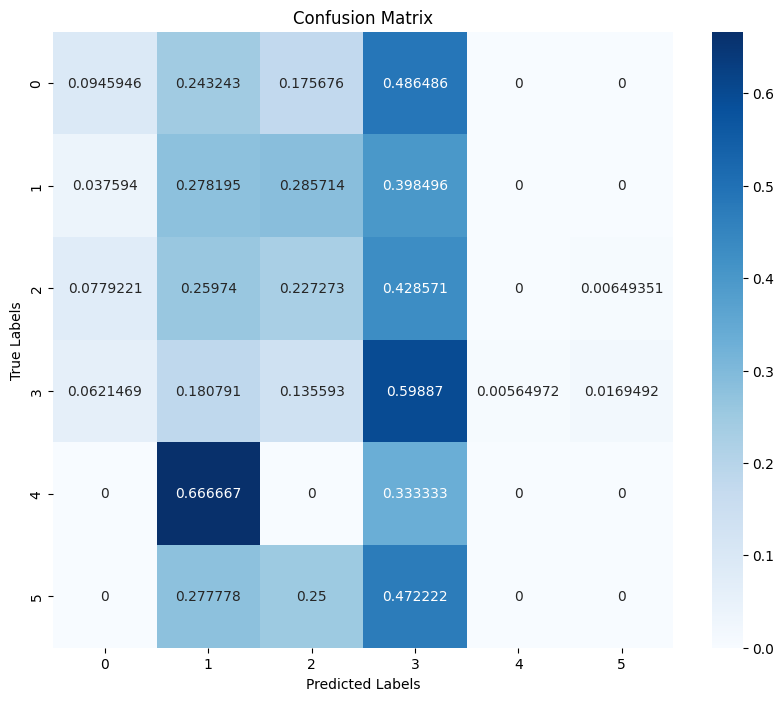

Epoch 19, Validation Loss: 3.7679, Accuracy: 0.3206, F1 Score: 0.2902
Val F1 Score Per Class  [0.12844037 0.27205882 0.25641026 0.46491228 0.         0.        ]


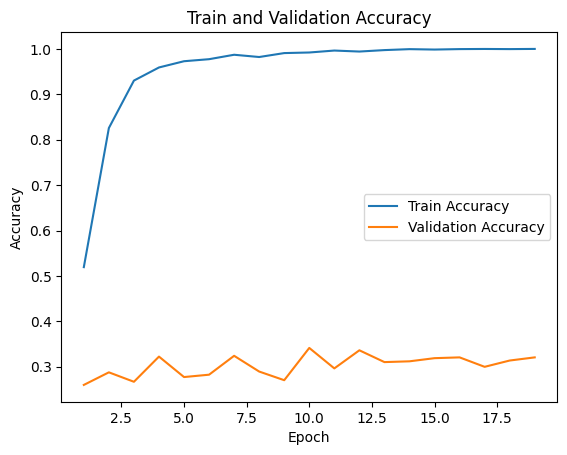

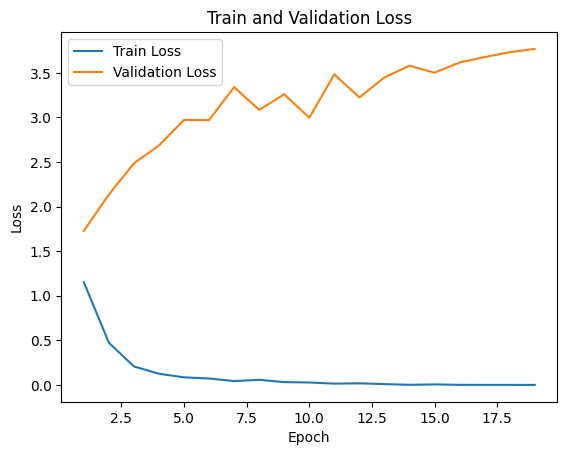

Epoch 20, Train Loss: 0.0003, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1. 1.]


Val:   1%|▏         | 1/73 [00:00<00:29,  2.45it/s, loss=3.95]

[tensor([-0.3593, -0.6826, -2.2426,  0.0555, -7.4297, -4.5847], device='cuda:0'), tensor([ 1.0118, -3.1108, -0.6297,  3.4799, -3.4561, -3.6705], device='cuda:0'), tensor([-2.4002, -1.7261, -1.2936,  6.3630, -4.7345, -4.7440], device='cuda:0'), tensor([-1.2163, -2.1107,  5.3014, -1.7701, -5.3399, -3.4036], device='cuda:0'), tensor([-0.6543, -3.9637,  5.7334, -0.1836, -3.7065, -3.6269], device='cuda:0'), tensor([ 0.1377, -1.3450, -0.7847, -1.0392, -6.6908, -5.3968], device='cuda:0'), tensor([-4.3602,  0.9218,  0.6819, -0.2081, -4.4646, -3.1594], device='cuda:0'), tensor([-0.7327, -2.5330, -0.3629,  5.6101, -4.9375, -5.2472], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:29,  2.43it/s, loss=5.18]

[tensor([-3.3572, -1.1647, -1.7464,  6.6784, -3.6348, -3.6379], device='cuda:0'), tensor([-3.3854, -2.9746, -0.5664,  4.7989, -5.4998, -4.4803], device='cuda:0'), tensor([ 1.0501, -3.4005, -1.2310,  0.7783, -3.5473, -3.1807], device='cuda:0'), tensor([-3.8544, -2.0642, -1.9244,  1.8852, -2.6203, -2.9327], device='cuda:0'), tensor([-2.2272, -0.2277, -2.4449,  6.8749, -4.5034, -3.3826], device='cuda:0'), tensor([-3.4520,  2.1678, -3.0974, -0.9398, -5.9181, -4.4502], device='cuda:0'), tensor([-4.2023, -0.6483, -1.7144,  5.2029, -4.8718, -2.9400], device='cuda:0'), tensor([-0.9297, -2.8117, -3.1301,  4.1209, -4.4828, -1.3276], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:29,  2.39it/s, loss=2.65]

[tensor([-3.3141,  0.1281, -2.7524,  3.7685, -4.7067, -4.2703], device='cuda:0'), tensor([-3.9546, -1.6185,  2.6620,  3.6241, -3.2837, -5.1632], device='cuda:0'), tensor([-2.0557,  5.5040, -1.4674, -2.9163, -3.2643, -2.8217], device='cuda:0'), tensor([-2.7666,  0.6779, -1.2761, -1.6199, -5.0253, -4.7422], device='cuda:0'), tensor([ 3.2327, -0.9025, -3.4589,  0.6925, -4.6317, -2.5528], device='cuda:0'), tensor([-1.7776, -1.6013,  5.4092, -1.7128, -5.2660, -4.2719], device='cuda:0'), tensor([-1.5176, -1.1733, -2.7399,  0.5844, -5.4046, -2.3506], device='cuda:0'), tensor([-2.1354, -2.0493,  1.4833,  3.7803, -5.3045, -5.0229], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:28,  2.39it/s, loss=3.88]

[tensor([ 4.2888, -0.5819, -2.8148, -1.0475, -3.0114, -2.9673], device='cuda:0'), tensor([-2.9969, -2.3916, -1.2919,  6.7933, -3.2309, -3.8861], device='cuda:0'), tensor([-3.7225, -0.0728,  0.0477,  2.8730, -5.5553, -5.0527], device='cuda:0'), tensor([-1.6927,  5.5949, -2.5977, -0.5620, -4.3170, -2.8091], device='cuda:0'), tensor([-1.4285, -2.5916,  7.6143, -2.1893, -4.2180, -2.2434], device='cuda:0'), tensor([-1.3595, -2.4799, -1.9264,  1.2928, -6.5955, -4.7650], device='cuda:0'), tensor([-2.8623, -4.2011,  2.3150,  2.5439, -3.9359, -1.7753], device='cuda:0'), tensor([ 1.2936, -2.3589, -0.8327,  2.2820, -4.6490, -4.5050], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=4.7]

[tensor([-3.6715,  1.4478, -0.5751, -2.7459, -5.7641, -3.2312], device='cuda:0'), tensor([-2.6096, -3.2998,  0.0803, -0.5024, -4.4241, -1.6147], device='cuda:0'), tensor([-2.5361, -0.4817, -0.1784,  0.2870, -6.2015, -4.4977], device='cuda:0'), tensor([-2.4983, -1.7155,  7.6094, -2.1001, -3.9522, -3.5799], device='cuda:0'), tensor([-3.3188, -2.4145,  4.3938, -1.3503, -3.8920, -1.8208], device='cuda:0'), tensor([-3.5836, -1.4924,  1.5093,  4.1971, -5.1489, -3.9945], device='cuda:0'), tensor([-3.7701, -1.0832,  1.4754,  0.3935, -6.3164, -3.9765], device='cuda:0'), tensor([-4.3646,  5.0807, -1.6700,  1.0991, -5.3968, -5.0910], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:27,  2.39it/s, loss=4.27]

[tensor([-1.8282,  0.6591, -3.6071,  3.2895, -4.9120, -4.7726], device='cuda:0'), tensor([-1.6714, -0.6927, -2.4039,  0.7846, -4.2430, -2.0568], device='cuda:0'), tensor([-3.8918,  3.2659, -0.5278,  0.4536, -5.8636, -3.1829], device='cuda:0'), tensor([-1.8091, -0.8694, -0.7993, -1.1798, -6.1408, -4.6887], device='cuda:0'), tensor([ 0.9886,  1.0688, -0.7228,  0.2453, -5.5364, -3.7507], device='cuda:0'), tensor([-4.2606, -0.6383,  5.7457, -1.0647, -5.0898, -4.5824], device='cuda:0'), tensor([-2.9313,  6.8719, -1.2073, -2.9203, -3.9488, -2.8660], device='cuda:0'), tensor([-1.8179,  5.8462, -2.4702, -1.4596, -3.9002, -2.8227], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:02<00:27,  2.40it/s, loss=2.51]

[tensor([-2.2111, -3.0412,  5.8009, -1.6515, -5.0399, -3.8471], device='cuda:0'), tensor([-2.6304, -2.6964,  7.5909, -1.0943, -4.4313, -3.2483], device='cuda:0'), tensor([-1.2165, -2.9688, -1.1644,  5.5308, -4.3362, -1.8262], device='cuda:0'), tensor([-1.6519, -2.0357,  0.3184, -0.4823, -5.7317, -3.1728], device='cuda:0'), tensor([-1.3623, -1.0039,  5.9833, -1.0690, -5.4442, -4.8618], device='cuda:0'), tensor([-2.9811, -1.5203, -2.4136,  6.3507, -4.0032, -1.8086], device='cuda:0'), tensor([-3.7994, -0.4556, -2.5801,  0.4944, -4.4284, -3.1539], device='cuda:0'), tensor([-1.5334, -2.0304,  7.8798, -2.2221, -2.9777, -2.3286], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:27,  2.39it/s, loss=4.08]

[tensor([-3.1307,  4.2253, -2.3126,  0.3984, -3.2994, -3.5471], device='cuda:0'), tensor([-2.6355,  0.8176, -2.5673, -1.3307, -3.0814, -1.1625], device='cuda:0'), tensor([ 3.9783, -2.1881, -2.7188, -1.6961, -4.6494, -1.3586], device='cuda:0'), tensor([-3.2939, -0.6832, -1.4937,  6.7315, -5.2448, -3.7267], device='cuda:0'), tensor([-3.5017, -0.6003, -2.4844,  0.0095, -4.9019, -2.1883], device='cuda:0'), tensor([-2.2824, -3.7620, -1.5129,  6.2463, -4.1224, -2.9520], device='cuda:0'), tensor([-1.3523, -2.4318,  5.9925, -0.9294, -5.3989, -4.4722], device='cuda:0'), tensor([-4.2249, -1.0019, -2.2435,  5.9257, -4.6934, -3.4518], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:03<00:26,  2.40it/s, loss=3.67]

[tensor([-3.4606,  6.3758, -1.5455, -0.5421, -5.1007, -3.2067], device='cuda:0'), tensor([-3.4161, -3.1357, -0.0445,  6.3316, -5.0414, -3.2823], device='cuda:0'), tensor([ 0.6023, -3.5218, -1.7720,  5.9229, -4.9483, -3.1193], device='cuda:0'), tensor([-3.6213, -1.7866, -2.4976,  5.0133, -5.1038, -3.7428], device='cuda:0'), tensor([-2.6947, -2.4517,  0.1108,  2.7369, -5.6794, -4.4384], device='cuda:0'), tensor([-3.2337,  2.7033, -2.6410,  0.9525, -5.6374, -4.9947], device='cuda:0'), tensor([-4.5388, -1.5948,  2.2258,  0.1452, -4.8953, -3.7407], device='cuda:0'), tensor([-3.6954, -2.2053, -0.1525,  4.4624, -6.0231, -3.5574], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:26,  2.40it/s, loss=5.43]

[tensor([-2.8162, -0.5911, -2.6502,  4.7570, -5.5180, -4.7013], device='cuda:0'), tensor([-3.1293, -1.9397, -1.5455,  7.0076, -3.9675, -3.3735], device='cuda:0'), tensor([-3.2210,  1.5562, -1.3121, -0.9516, -5.6226, -5.4329], device='cuda:0'), tensor([-3.6143, -0.2782,  1.2536, -2.0614, -4.8801, -4.9237], device='cuda:0'), tensor([-2.5865,  5.2888, -0.6191, -2.4785, -4.5549, -4.4598], device='cuda:0'), tensor([-4.3076, -0.6140, -1.6705,  2.1976, -5.4156, -4.1355], device='cuda:0'), tensor([ 1.7365, -1.1096, -0.8196,  1.2907, -5.7096, -5.3563], device='cuda:0'), tensor([-2.6247, -1.0789, -2.8438,  2.8091, -5.9675, -5.0865], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:04<00:25,  2.40it/s, loss=3.43]

[tensor([-2.5663,  4.8329, -2.4112,  0.3864, -4.2807, -4.3431], device='cuda:0'), tensor([-3.4679,  0.3818, -0.9689,  1.9400, -5.1977, -3.7255], device='cuda:0'), tensor([-4.4003,  2.0873, -2.0457,  1.6750, -5.6017, -4.3983], device='cuda:0'), tensor([-3.3862, -2.5495,  6.1544, -0.2936, -4.0344, -3.3091], device='cuda:0'), tensor([-3.2372, -2.4518,  5.3015,  1.2209, -5.2842, -3.5495], device='cuda:0'), tensor([-3.5953, -1.9659, -1.8548,  7.3530, -4.5081, -2.7903], device='cuda:0'), tensor([-2.4388,  2.9934, -2.6720, -0.1410, -5.5845, -5.4653], device='cuda:0'), tensor([-3.0748, -2.1687, -0.1078,  4.6628, -5.8381, -3.5187], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:25,  2.39it/s, loss=3.36]

[tensor([-2.0464, -1.4677, -1.5415, -1.2241, -5.8032, -4.7366], device='cuda:0'), tensor([-1.8945, -3.0048, -0.4598,  0.8630, -5.9462, -4.2738], device='cuda:0'), tensor([-2.8663, -3.1518, -1.5466,  6.9367, -3.8846, -2.6199], device='cuda:0'), tensor([-3.2642, -1.6166, -1.9532,  4.3711, -6.0066, -3.2786], device='cuda:0'), tensor([-1.7008,  3.5018, -2.5745, -1.0163, -5.7303, -4.6149], device='cuda:0'), tensor([-1.4136, -0.3444, -2.8482,  0.0954, -5.0628, -4.2079], device='cuda:0'), tensor([-4.7190, -2.4159,  2.3912, -0.5627, -4.4623, -1.4336], device='cuda:0'), tensor([-0.1548, -2.6181,  1.0332,  0.7135, -6.0874, -4.0239], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:25,  2.40it/s, loss=3.66]

[tensor([-3.4579, -1.3470, -2.4721,  3.2496, -3.3430, -1.3944], device='cuda:0'), tensor([-2.5273, -2.0824, -0.9671,  4.4887, -5.6724, -4.4308], device='cuda:0'), tensor([-2.6346,  1.2356, -4.9002,  2.5941, -4.3703, -1.5157], device='cuda:0'), tensor([-3.1334e+00, -2.7418e+00,  6.2093e+00,  1.8898e-03, -4.3200e+00,
        -4.2021e+00], device='cuda:0'), tensor([-3.3176, -1.2213, -1.5765,  5.4788, -5.3485, -4.0888], device='cuda:0'), tensor([-0.0228, -2.5483, -2.8444,  1.7932, -4.4904, -5.1815], device='cuda:0'), tensor([-4.0299,  3.1937, -2.3882, -0.8850, -4.6676, -4.0704], device='cuda:0'), tensor([-3.0826,  5.4584, -1.7483,  0.1313, -5.0460, -4.6018], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:05<00:24,  2.39it/s, loss=1.94]

[tensor([-2.3403,  0.0694,  6.8726, -2.9051, -3.2297, -3.2579], device='cuda:0'), tensor([-1.6232,  0.5741, -2.9176, -0.9591, -5.2453, -5.5855], device='cuda:0'), tensor([ 0.9788, -1.8281, -0.7430,  0.1826, -5.4091, -4.8868], device='cuda:0'), tensor([-2.1471, -2.1645,  0.2580,  0.3630, -5.9169, -4.7513], device='cuda:0'), tensor([-3.0391,  4.1988, -2.1246, -0.5977, -5.5270, -4.8090], device='cuda:0'), tensor([-3.0145, -0.2670,  0.4552,  2.3194, -4.7835, -4.2908], device='cuda:0'), tensor([-1.9057, -0.2969, -2.6081,  1.3698, -5.6711, -6.1168], device='cuda:0'), tensor([-1.8388, -0.8542, -2.1064,  2.3745, -5.1634, -5.1915], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:24,  2.39it/s, loss=2.92]

[tensor([-2.9523, -2.3785, -1.7627,  1.9885, -4.5604, -4.7487], device='cuda:0'), tensor([-4.7834, -1.2637, -2.1126,  4.4135, -4.8309, -3.2658], device='cuda:0'), tensor([-2.5943, -3.7916,  0.8748,  0.8153, -3.1972, -2.7491], device='cuda:0'), tensor([-1.1792, -0.4019, -1.0774, -2.9235, -5.5508, -3.5480], device='cuda:0'), tensor([-3.0631, -1.5954,  6.2039, -1.6780, -4.7320, -3.9811], device='cuda:0'), tensor([ 0.8482, -3.2916,  0.4906,  3.7828, -5.7919, -4.0493], device='cuda:0'), tensor([-2.9410, -0.5173, -2.5999,  4.4899, -3.7134, -2.7656], device='cuda:0'), tensor([-4.1514, -0.4649,  0.1549,  1.2339, -5.2611, -4.3288], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:06<00:23,  2.40it/s, loss=5.24]

[tensor([-0.0235, -1.0786, -0.8694,  4.6456, -5.1473, -5.4257], device='cuda:0'), tensor([-4.0393, -1.8176, -1.9242,  6.8439, -4.8021, -3.8302], device='cuda:0'), tensor([-3.8649, -1.0170, -0.4340, -1.3878, -4.5145,  6.0781], device='cuda:0'), tensor([-3.3931, -2.3480,  0.4464,  5.8823, -5.3247, -4.2076], device='cuda:0'), tensor([ 7.6285, -2.0447, -0.8003, -1.0578, -3.9387, -3.3330], device='cuda:0'), tensor([-1.4446,  1.9851, -2.1489,  1.1577, -5.5077, -4.5126], device='cuda:0'), tensor([-2.3968, -2.0319, -1.6651, -0.9266, -4.7079, -3.4924], device='cuda:0'), tensor([ 5.2774, -1.7654, -3.6653, -0.7913, -3.6071, -0.6214], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:23,  2.39it/s, loss=4.75]

[tensor([-2.6460,  6.4735, -1.3110, -1.7375, -4.2956, -3.8216], device='cuda:0'), tensor([-2.0159, -1.4633, -1.4664,  5.1832, -5.9821, -5.4702], device='cuda:0'), tensor([-4.1095,  1.2252, -1.6170,  0.2819, -5.9740, -0.3489], device='cuda:0'), tensor([-3.1212, -1.1102,  2.8357, -1.2371, -5.0111, -4.7840], device='cuda:0'), tensor([ 8.1326, -2.5156, -1.1762, -0.5830, -3.4659, -3.2942], device='cuda:0'), tensor([-0.8816,  5.9513, -2.4622, -1.0934, -4.5585, -4.6118], device='cuda:0'), tensor([-2.1673, -3.2162,  7.3188, -0.3197, -4.1439, -3.0407], device='cuda:0'), tensor([-2.5067, -2.4260, -0.4424,  3.4410, -5.1856, -3.7918], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:07<00:23,  2.39it/s, loss=3.41]

[tensor([-3.0242,  0.0941, -2.7853,  2.7174, -3.5887, -3.4886], device='cuda:0'), tensor([-3.6209, -1.6516,  3.6858, -0.2291, -3.3912, -4.1806], device='cuda:0'), tensor([-3.5414,  1.8217, -1.0756, -0.9565, -5.1059, -4.2579], device='cuda:0'), tensor([-3.2043, -3.0884, -1.4529,  6.9438, -3.3027, -3.2077], device='cuda:0'), tensor([-3.9226,  0.3794, -2.9764,  0.1675, -4.8044, -1.5113], device='cuda:0'), tensor([ 8.1991, -1.1139, -1.9667, -1.2449, -4.2380, -2.6701], device='cuda:0'), tensor([-2.1417, -1.7357, -2.4176,  2.3802, -4.9841, -4.1279], device='cuda:0'), tensor([-2.3710, -3.2795,  3.6154, -1.4613, -6.2559, -3.7847], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:07<00:22,  2.39it/s, loss=3.91]

[tensor([-4.9972, -0.0823, -1.2643,  1.7264, -4.9512, -4.5964], device='cuda:0'), tensor([-3.2517, -2.3495,  4.9579,  0.0272, -4.0548, -4.4592], device='cuda:0'), tensor([-0.5317, -3.3263,  3.6253, -1.9060, -4.1781, -0.9267], device='cuda:0'), tensor([-3.0586,  1.3433,  0.5066,  1.2770, -2.1835, -5.1784], device='cuda:0'), tensor([-4.3863,  5.3019, -0.5700, -1.3060, -3.8866, -2.6057], device='cuda:0'), tensor([-2.7574,  2.1162, -3.2833,  0.9912, -4.3354, -3.6789], device='cuda:0'), tensor([-2.3130, -2.2459, -1.0257,  7.1400, -4.6714, -3.3949], device='cuda:0'), tensor([-0.5072, -1.1763, -3.2613,  3.2658, -4.5909, -4.4041], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:08<00:22,  2.38it/s, loss=2.55]

[tensor([-4.4556,  3.6035, -0.5820, -1.3011, -5.2198, -2.7455], device='cuda:0'), tensor([-1.5197, -2.8913, -1.2022,  6.0396, -5.6534, -4.1783], device='cuda:0'), tensor([-3.2886, -1.0477,  5.7796, -2.0862, -5.1191, -4.0715], device='cuda:0'), tensor([-3.3272,  2.0627,  1.7827, -2.3074, -5.2838, -3.7123], device='cuda:0'), tensor([-4.5532,  1.8023, -2.9866,  0.5358, -5.0889, -5.0275], device='cuda:0'), tensor([-4.0707, -1.9649, -0.2897,  0.3350, -4.8584, -3.2008], device='cuda:0'), tensor([-2.5834,  0.6303,  0.7018,  0.2153, -4.7375, -4.1094], device='cuda:0'), tensor([-1.5802,  6.3135, -2.5585, -1.1055, -3.4417, -3.5852], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:08<00:21,  2.38it/s, loss=7.37]

[tensor([-1.9686, -2.3056,  7.6756, -2.1816, -3.6975, -2.0906], device='cuda:0'), tensor([-1.4356,  5.7588, -2.4346, -0.8950, -4.8584, -3.7561], device='cuda:0'), tensor([-3.6768,  1.4926, -3.0813,  4.2622, -4.8571, -5.1595], device='cuda:0'), tensor([-3.2477,  0.1203, -3.4703,  5.5651, -5.0037, -3.7851], device='cuda:0'), tensor([-2.8455,  6.6718, -2.6013, -2.0985, -3.4349, -1.6222], device='cuda:0'), tensor([-1.8008, -3.3708, -2.4167,  1.3106, -4.9636, -3.9073], device='cuda:0'), tensor([-1.1465,  6.9181, -2.1051, -2.2030, -4.8934, -2.4470], device='cuda:0'), tensor([ 2.1105, -1.9604, -2.2844,  2.4816, -4.6163, -5.8879], device='cuda:0')]


Val:  30%|███       | 22/73 [00:09<00:21,  2.39it/s, loss=2.87]

[tensor([-0.7601, -2.1488,  3.2500, -2.3715, -4.0683, -4.0027], device='cuda:0'), tensor([-2.3235, -2.9493,  4.6456, -1.1876, -5.3426, -4.6040], device='cuda:0'), tensor([-0.4891,  0.2818,  1.6870, -0.2365, -7.6868, -5.6678], device='cuda:0'), tensor([-2.8505, -1.6874, -0.9489,  4.1448, -4.7363, -4.3183], device='cuda:0'), tensor([-3.6629e+00, -3.3306e-01, -2.6461e+00,  5.9540e-04, -4.6630e+00,
        -4.1335e+00], device='cuda:0'), tensor([ 1.3239, -2.4419,  1.3299, -1.5362, -4.9538, -4.0950], device='cuda:0'), tensor([-2.2656, -2.1146,  0.3132,  4.5880, -7.3741, -3.4372], device='cuda:0'), tensor([-1.7659, -3.1311,  6.0301, -0.9191, -5.3035, -4.2404], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=4.31]

[tensor([-2.5150, -2.3247, -3.1501, -0.3861, -3.2360, -3.6177], device='cuda:0'), tensor([-0.7778, -0.1315,  0.0818, -2.6266, -4.9133, -5.0151], device='cuda:0'), tensor([-2.9511, -0.9526, -2.1783,  6.3496, -5.0132, -3.9011], device='cuda:0'), tensor([-2.0420,  6.3531, -0.9995, -2.4210, -3.5104, -2.4892], device='cuda:0'), tensor([-3.2477,  0.0486, -2.8086,  0.1081, -5.4435, -3.8596], device='cuda:0'), tensor([-3.4506,  6.2556, -1.1953, -1.1542, -4.3659, -3.4665], device='cuda:0'), tensor([-2.1269, -3.6578,  2.7795,  0.7119, -5.0064, -3.1860], device='cuda:0'), tensor([-3.3569,  5.4029, -2.1640, -1.0359, -5.4148, -1.7926], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:10<00:20,  2.39it/s, loss=4.12]

[tensor([-1.9904, -3.4556,  0.6609,  5.4035, -4.7403, -5.1217], device='cuda:0'), tensor([-2.8221, -1.0530,  1.4821,  2.4035, -5.6816, -5.2861], device='cuda:0'), tensor([-3.8519,  1.3289, -2.7997,  1.3923, -5.9897, -3.9366], device='cuda:0'), tensor([-1.8959, -5.1863, -2.0270,  2.5601, -4.1356,  0.3089], device='cuda:0'), tensor([-0.8185, -3.6166, -2.2774,  5.3395, -4.1262, -2.8780], device='cuda:0'), tensor([-2.9185, -0.9287, -2.3660,  1.0051, -5.0390, -3.4098], device='cuda:0'), tensor([-1.1842, -0.7477, -3.2313, -1.6151, -4.3239, -0.0891], device='cuda:0'), tensor([-1.5189, -2.9894, -1.6685,  5.9291, -4.5869, -4.3807], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:10<00:20,  2.39it/s, loss=3.54]

[tensor([-3.3166, -2.1005,  7.0216, -0.6975, -4.7796, -3.6978], device='cuda:0'), tensor([-2.2340, -1.4614,  7.1820, -1.7803, -3.3536, -3.1401], device='cuda:0'), tensor([-4.1819, -1.6469,  0.1851,  1.0696, -5.0691, -4.3004], device='cuda:0'), tensor([-3.9513,  2.6947, -1.9080,  1.2091, -5.0891, -4.2901], device='cuda:0'), tensor([-2.9201,  2.0126, -3.0353, -1.3216, -5.0359, -3.4740], device='cuda:0'), tensor([-3.4659, -2.7215,  1.6029, -0.5116, -4.2717, -3.8465], device='cuda:0'), tensor([-1.8604, -0.5056, -4.1015,  2.9478, -4.3353, -3.5455], device='cuda:0'), tensor([-0.5504, -0.5856, -2.4298, -0.5579, -3.9653, -4.3911], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:10<00:19,  2.39it/s, loss=2.18]

[tensor([-2.8713, -1.9639, -1.0351,  6.1093, -5.4877, -3.6876], device='cuda:0'), tensor([-3.5849, -1.7538, -1.6629,  3.1987, -5.8855, -3.5889], device='cuda:0'), tensor([-3.7010, -2.4378,  4.6294, -0.5534, -4.2461, -3.4125], device='cuda:0'), tensor([ 6.7079, -1.9078, -1.4082, -1.0418, -3.8011, -1.8904], device='cuda:0'), tensor([-3.4913,  2.0078, -1.8346,  4.9857, -5.9406, -4.4135], device='cuda:0'), tensor([-0.9919, -2.3570,  4.6292,  0.0492, -4.7039, -3.5930], device='cuda:0'), tensor([-1.5963,  0.9860, -2.0967,  1.5486, -4.5763, -5.0939], device='cuda:0'), tensor([-3.7559, -0.4468, -1.1592, -1.4442, -6.3935, -2.7563], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:11<00:19,  2.39it/s, loss=2.76]

[tensor([-3.9261, -1.4513,  1.9709,  3.7060, -5.9804, -4.6207], device='cuda:0'), tensor([-3.8524, -0.9463, -1.2619,  1.7014, -4.8808, -4.7142], device='cuda:0'), tensor([-1.6849, -2.0873, -1.5866,  3.5730, -4.6584, -4.4108], device='cuda:0'), tensor([-2.6970, -3.2621,  1.2521,  4.2802, -5.9292, -3.4817], device='cuda:0'), tensor([-2.7269,  5.7079, -2.1382, -0.3494, -4.4136, -3.6222], device='cuda:0'), tensor([-1.1936, -1.7040,  1.9970, -1.1779, -5.9026, -4.2207], device='cuda:0'), tensor([-3.1681, -3.4248,  3.2657,  0.2944, -5.2423, -3.3794], device='cuda:0'), tensor([-2.7691, -0.5173, -3.4025,  5.4613, -5.2276, -3.6176], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:11<00:18,  2.39it/s, loss=3.47]

[tensor([-0.5858, -2.6625, -1.4351,  5.3350, -5.0621, -4.3361], device='cuda:0'), tensor([-3.4337, -0.4913, -1.8767,  3.0692, -4.6563, -3.9698], device='cuda:0'), tensor([-1.9288,  3.2551, -1.1515, -2.9549, -4.3743, -3.3279], device='cuda:0'), tensor([-3.1795, -2.5136, -0.4092,  4.2190, -4.6317, -4.3691], device='cuda:0'), tensor([-2.9223, -2.1756, -1.5664,  6.2478, -4.6489, -3.4307], device='cuda:0'), tensor([-4.1832, -0.0189, -0.2328,  4.1429, -5.7081, -5.0904], device='cuda:0'), tensor([-4.0524, -1.9769,  2.1191,  0.9418, -5.6274, -4.3424], device='cuda:0'), tensor([-3.2375,  1.3033, -0.8071, -1.4263, -5.1705, -4.6347], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:12<00:18,  2.39it/s, loss=4.67]

[tensor([-3.4515, -1.4686, -1.3179,  6.9592, -4.2320, -2.9888], device='cuda:0'), tensor([-4.1630, -0.7325, -1.1961, -0.4224, -4.6847, -2.2084], device='cuda:0'), tensor([-4.9651, -3.1993,  3.9876, -0.0371, -5.0209, -3.4906], device='cuda:0'), tensor([-3.1603,  4.9983, -2.2442, -0.1455, -4.4526, -4.4037], device='cuda:0'), tensor([ 0.8801,  2.5619, -2.0638, -1.3199, -5.9192, -3.6432], device='cuda:0'), tensor([-4.2769, -1.4723, -0.1566, -0.7755, -5.0752, -2.7755], device='cuda:0'), tensor([-3.8405, -1.5386, -1.0389,  3.9553, -3.9260, -3.7310], device='cuda:0'), tensor([-3.7859, -1.4579, -1.2305,  6.3989, -5.2060, -3.9994], device='cuda:0')]


Val:  41%|████      | 30/73 [00:12<00:17,  2.39it/s, loss=4.69]

[tensor([-4.3927,  5.2103, -1.4062, -0.2018, -4.7247, -3.3334], device='cuda:0'), tensor([-4.0173, -2.4552, -0.4054,  4.7376, -4.1248, -4.1634], device='cuda:0'), tensor([-1.5773,  1.0143, -2.9258, -1.2835, -3.9663, -2.3992], device='cuda:0'), tensor([-2.1377, -2.1118, -1.9774,  7.0547, -4.3117, -3.8645], device='cuda:0'), tensor([-3.0408, -1.0746, -2.9160, -1.8860, -5.5277, -3.0475], device='cuda:0'), tensor([-2.1517, -3.2293,  3.1779, -0.1638, -4.2207, -2.5065], device='cuda:0'), tensor([-3.7248, -3.6013,  2.0839,  2.3990, -6.0435, -5.1080], device='cuda:0'), tensor([-0.9144, -1.6890, -0.3530, -2.0746, -3.1216,  8.7485], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:12<00:17,  2.39it/s, loss=4.39]

[tensor([-2.8423,  3.2893, -3.9447,  1.5931, -4.4216, -3.0909], device='cuda:0'), tensor([-2.9682, -2.1875, -1.9585,  6.9528, -4.9098, -3.1682], device='cuda:0'), tensor([-4.4373,  4.9841, -1.2993, -0.4007, -5.3155, -2.3542], device='cuda:0'), tensor([-1.7088,  5.8913, -3.1015, -1.4437, -5.0431, -2.4345], device='cuda:0'), tensor([-2.7919,  3.0959, -0.0315, -1.4436, -5.4599, -3.6444], device='cuda:0'), tensor([ 8.2982, -1.0439, -1.8754, -2.1112, -2.4327, -1.4084], device='cuda:0'), tensor([-2.2952, -3.2776, -0.5462,  6.3517, -4.1532, -4.1447], device='cuda:0'), tensor([-3.0310, -1.4895,  4.6985,  0.5054, -5.2155, -4.6195], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:13<00:17,  2.39it/s, loss=5.36]

[tensor([-3.0790, -1.1176, -3.2772, -0.5316, -4.0526, -2.7264], device='cuda:0'), tensor([-2.7748, -1.7681, -2.2269,  7.2858, -4.0339, -3.1399], device='cuda:0'), tensor([-1.9673,  7.4707, -2.4836, -1.5793, -2.5151, -2.8326], device='cuda:0'), tensor([-3.6702,  3.5585, -2.4407, -0.8005,  1.9709, -2.0013], device='cuda:0'), tensor([-1.8662,  0.0886,  0.7494, -1.1956, -3.5289, -4.5269], device='cuda:0'), tensor([-2.1324, -3.3849, -0.3095,  3.9500, -5.0613, -3.8062], device='cuda:0'), tensor([ 3.8766, -3.1996, -1.5808, -0.4433, -4.7823, -2.8799], device='cuda:0'), tensor([ 1.9127, -0.7195, -2.5853, -0.1757, -5.5393, -3.8002], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:13<00:16,  2.39it/s, loss=6.67]

[tensor([-4.2333, -2.1857, -0.9714,  5.5679, -4.0381, -2.0908], device='cuda:0'), tensor([-3.6528,  4.5176, -2.0989,  1.9142, -4.6654, -3.1100], device='cuda:0'), tensor([-2.4391, -3.0550, -1.5633,  6.5581, -5.5939, -3.4795], device='cuda:0'), tensor([-2.0750,  6.5451, -0.5111, -2.5782, -4.2182, -4.1243], device='cuda:0'), tensor([-3.5466, -2.0838,  7.4820, -1.6701, -3.1630, -3.1320], device='cuda:0'), tensor([-1.8089, -3.1846, -0.9869,  1.7303, -4.6633, -3.5297], device='cuda:0'), tensor([-2.2993,  4.0332, -3.0477, -1.6986, -5.3113, -3.8047], device='cuda:0'), tensor([-3.5528, -0.3289, -2.0651,  3.8521, -4.2176, -3.8074], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:14<00:16,  2.39it/s, loss=4.05]

[tensor([ 8.0191, -0.6851, -2.7680, -1.6813, -2.5460, -2.5024], device='cuda:0'), tensor([-2.4685,  0.7060, -1.3415,  0.2940, -6.6271, -5.5018], device='cuda:0'), tensor([-3.5805,  0.5718, -1.9341,  0.8527, -0.7732, -3.9467], device='cuda:0'), tensor([-3.8910, -3.0194, -0.8698,  6.0007, -4.6300, -2.5513], device='cuda:0'), tensor([-3.3854,  2.8577, -2.1545,  2.7028, -4.4893, -4.6658], device='cuda:0'), tensor([-3.9195,  2.3217, -1.1851,  1.4854, -5.5212, -3.6274], device='cuda:0'), tensor([-2.2967, -2.7204, -1.7462,  6.1133, -4.6548, -3.9263], device='cuda:0'), tensor([-2.1675, -1.3873,  7.2662, -2.2300, -4.3525, -3.3157], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:14<00:15,  2.39it/s, loss=4.25]

[tensor([-2.0401, -0.7782,  1.0080, -0.6573, -6.6824, -4.3149], device='cuda:0'), tensor([-1.7992,  3.8407,  0.2123, -1.8634, -5.2469, -4.4912], device='cuda:0'), tensor([-2.3268, -3.3791,  3.1846, -1.1429, -5.1494, -3.9610], device='cuda:0'), tensor([-2.2522, -1.5786,  7.7740, -1.7281, -3.3900, -2.8382], device='cuda:0'), tensor([-3.3162,  6.0827, -2.0025,  0.2337, -4.7535, -3.2033], device='cuda:0'), tensor([-2.0860, -3.1714, -0.7717,  2.2447, -4.8551, -1.6326], device='cuda:0'), tensor([-3.1409, -2.3864,  0.2003,  5.7183, -5.9548, -4.1676], device='cuda:0'), tensor([-3.1409, -0.0280,  1.1440,  2.3835, -5.4330, -4.9658], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:15<00:15,  2.39it/s, loss=3.6]

[tensor([-2.8795, -0.3262,  1.1102, -2.2066, -4.0062, -3.1384], device='cuda:0'), tensor([-2.4992, -1.2811,  6.9584, -2.2198, -3.1204, -3.6195], device='cuda:0'), tensor([-2.8780, -2.6544, -1.1391,  1.1667, -5.1711, -2.4182], device='cuda:0'), tensor([-2.7787,  6.7470, -3.1110, -0.2760, -4.2412, -3.0905], device='cuda:0'), tensor([-2.9131, -2.6479, -0.9467,  2.2358, -5.6453, -3.8051], device='cuda:0'), tensor([-2.1903, -3.4369, -0.9648,  6.0039, -4.6484, -3.7373], device='cuda:0'), tensor([-2.2586, -2.1540, -2.1534,  7.3166, -4.2022, -3.5146], device='cuda:0'), tensor([-2.4708,  0.0238, -2.5407,  2.8393, -4.8804, -4.6816], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:15<00:15,  2.39it/s, loss=5.05]

[tensor([ 0.6115, -2.4672, -2.5668,  3.1388, -4.4123, -3.4369], device='cuda:0'), tensor([-3.0560, -2.0437, -1.0613,  3.6051, -5.7222, -4.4294], device='cuda:0'), tensor([-2.7097, -2.0619, -2.9598,  4.9739, -4.1192, -3.6475], device='cuda:0'), tensor([-3.5493,  6.4150, -2.6814, -1.0350, -3.8727, -1.0462], device='cuda:0'), tensor([-2.5218,  1.9587,  3.6850, -2.7949, -4.9626, -2.9263], device='cuda:0'), tensor([-3.0904,  6.9247, -1.9704, -1.4031, -3.6487, -3.1769], device='cuda:0'), tensor([-2.1603,  2.4153, -0.8829,  0.8919, -5.2072, -4.8480], device='cuda:0'), tensor([-4.3146,  1.3072, -0.7008,  2.6021, -4.7464, -4.9947], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:15<00:14,  2.39it/s, loss=3.32]

[tensor([-2.0686, -2.0232,  3.3021, -0.8034, -4.2505, -2.3656], device='cuda:0'), tensor([-3.4237, -0.1712, -1.5484,  1.4260, -6.4993, -1.5156], device='cuda:0'), tensor([-0.5159, -1.7237, -1.2772,  3.4103, -6.2532, -5.0638], device='cuda:0'), tensor([-3.6105,  1.5058, -3.1822, -0.6988, -3.8156, -4.4647], device='cuda:0'), tensor([-3.2064, -1.2349,  0.3613, -1.1564, -5.4046, -5.8823], device='cuda:0'), tensor([-2.1825,  6.9929, -2.6558, -0.9413, -3.1136, -2.7180], device='cuda:0'), tensor([-2.2705,  2.0206, -0.6360, -2.8606, -4.9171, -4.4509], device='cuda:0'), tensor([-2.9617, -3.1878,  5.4260,  0.8132, -5.3934, -4.3197], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:16<00:14,  2.39it/s, loss=4.05]

[tensor([-1.4815, -1.4337,  1.5177, -0.2873, -5.6750, -5.1905], device='cuda:0'), tensor([-2.9618, -1.0302, -0.4257,  5.2510, -4.5007, -5.4493], device='cuda:0'), tensor([ 1.0897, -1.8275, -0.8307,  0.4013, -4.9829, -3.8391], device='cuda:0'), tensor([-1.6582, -3.3231, -0.5170,  2.0522, -6.2498, -4.5484], device='cuda:0'), tensor([-3.7241, -2.1779, -2.1349,  1.3657, -5.0978, -4.4559], device='cuda:0'), tensor([-3.2421, -1.3940,  6.8162, -1.4510, -4.8319, -3.4977], device='cuda:0'), tensor([ 3.5052, -2.3536,  0.7229, -1.4477, -4.5711, -4.4317], device='cuda:0'), tensor([-4.7040,  2.3715, -1.5556, -0.3483, -6.4150, -1.6175], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:16<00:13,  2.38it/s, loss=4.13]

[tensor([ 0.8879, -2.1606,  0.1809,  1.1941, -5.0500, -4.4534], device='cuda:0'), tensor([-1.3492, -2.2000,  6.1690, -2.0904, -3.3921, -2.8338], device='cuda:0'), tensor([-3.2315, -1.9020, -1.9539,  5.2483, -5.8763, -2.4730], device='cuda:0'), tensor([ 2.6721, -2.1818, -3.3791,  2.7417, -3.8518, -3.4619], device='cuda:0'), tensor([-4.6929,  3.1614, -1.9811, -0.2585, -4.9643, -2.1770], device='cuda:0'), tensor([ 1.9769, -0.8603, -2.8442,  2.0689, -3.3252, -4.2261], device='cuda:0'), tensor([-3.9675, -0.8472, -1.2650,  4.7822, -4.5061, -4.4080], device='cuda:0'), tensor([-0.6009, -2.0374, -2.5159,  4.3639, -5.0279,  0.1204], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:17<00:13,  2.39it/s, loss=2.59]

[tensor([-3.2557, -2.5387, -0.8520,  4.9304, -4.8745, -4.1438], device='cuda:0'), tensor([-3.1427, -0.0812,  1.2419,  1.8818, -3.6985, -5.6035], device='cuda:0'), tensor([-1.7950, -2.0918, -1.7995,  3.3542, -4.9798, -3.5941], device='cuda:0'), tensor([-4.1576,  2.8399, -2.5547,  2.4256, -4.8973, -3.9545], device='cuda:0'), tensor([-3.5417,  1.6845, -0.7851,  0.5055, -5.7209, -4.9820], device='cuda:0'), tensor([-2.9148, -2.1281, -1.6206,  6.6586, -4.5517, -3.8536], device='cuda:0'), tensor([-3.5918, -1.5774, -1.6957,  0.2574, -5.3567, -5.0751], device='cuda:0'), tensor([-0.4419, -1.2204, -1.9266,  2.2829, -4.9459, -5.1972], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:17<00:13,  2.38it/s, loss=3.56]

[tensor([-2.9537, -3.0292, -0.3158,  5.7971, -4.5052, -4.0540], device='cuda:0'), tensor([ 6.9489, -2.0968,  0.1066, -1.0738, -4.0105, -2.7503], device='cuda:0'), tensor([-1.4843, -2.5014, -2.0298,  4.0980, -6.0059, -4.7560], device='cuda:0'), tensor([ 1.1318,  0.3324, -2.9978, -0.8624, -3.9045, -3.2724], device='cuda:0'), tensor([-3.5690, -1.5254,  0.2898,  2.8682, -4.4755, -4.0508], device='cuda:0'), tensor([-2.2248, -3.2561, -1.9290,  6.8820, -3.9107, -3.7924], device='cuda:0'), tensor([-3.7110, -2.7206,  1.0918,  3.3955, -4.9265, -2.7613], device='cuda:0'), tensor([ 1.7107, -1.8269, -0.0929,  0.7076, -5.3095, -5.7828], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:17<00:12,  2.39it/s, loss=2.16]

[tensor([-3.0839, -1.1802, -2.3474,  6.6076, -4.5772, -3.5140], device='cuda:0'), tensor([-2.8920, -1.4772, -0.8153,  0.0743, -5.2803, -4.2672], device='cuda:0'), tensor([-0.6694, -0.7949, -1.6730,  0.0349, -6.6246, -4.5585], device='cuda:0'), tensor([-3.4343,  3.0186, -2.6415,  2.5049, -6.2785, -2.6175], device='cuda:0'), tensor([-2.8024,  2.8693, -3.3893,  0.5587, -4.9427, -3.0944], device='cuda:0'), tensor([-4.0609,  2.1443,  4.4748, -2.5275, -3.8056, -3.9844], device='cuda:0'), tensor([-3.2727, -1.7986,  2.0078,  3.1797, -5.4882, -4.2368], device='cuda:0'), tensor([-4.3389, -0.8885, -2.0234, -0.7860, -4.9777, -3.3020], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:18<00:12,  2.39it/s, loss=3.94]

[tensor([-2.7366, -0.2844, -1.7853,  5.0986, -3.3390, -4.7206], device='cuda:0'), tensor([-2.4155, -2.2165,  4.5209,  0.4738, -5.8457, -4.6910], device='cuda:0'), tensor([-1.2487,  5.5803, -2.6994, -0.8877, -5.2479, -2.9618], device='cuda:0'), tensor([-1.8588, -1.3862, -1.8377, -1.3042, -2.0194,  9.1214], device='cuda:0'), tensor([-3.4491,  1.4712, -2.3008,  3.4977, -4.9843, -4.4407], device='cuda:0'), tensor([-2.0369,  1.2983, -3.3039,  1.7842, -4.9944, -3.6463], device='cuda:0'), tensor([-1.9829, -2.8083,  0.1552, -0.2618, -5.5990, -5.4977], device='cuda:0'), tensor([-3.0929, -2.0248, -1.6032,  6.9477, -4.1101, -4.1872], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:18<00:11,  2.39it/s, loss=5.34]

[tensor([-1.1188,  3.3220,  0.1869, -2.2890, -5.4955, -2.3146], device='cuda:0'), tensor([-2.6667,  7.3026, -1.8035, -1.7290, -3.5480, -2.5735], device='cuda:0'), tensor([-1.8721,  7.4945, -2.1684, -1.6143, -3.9302, -3.3848], device='cuda:0'), tensor([-2.3060,  7.4317, -3.0210, -0.6774, -4.1052, -3.0907], device='cuda:0'), tensor([-1.8487, -2.8588, -3.0252,  6.4257, -5.6608, -2.7536], device='cuda:0'), tensor([ 0.2649, -1.1770, -2.2430,  2.4168, -5.8072, -3.3100], device='cuda:0'), tensor([ 0.6819, -0.0951, -2.6212, -2.6529,  2.6624, -2.9556], device='cuda:0'), tensor([-4.4074e+00, -2.9079e-03,  1.9315e+00, -1.4822e+00, -5.1537e+00,
        -4.1084e+00], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:19<00:11,  2.39it/s, loss=4.54]

[tensor([-2.5264, -1.4306, -0.5754,  2.5451, -5.7198, -4.5592], device='cuda:0'), tensor([-1.8273, -2.5513, -1.4590, -0.1536, -6.7436, -4.4289], device='cuda:0'), tensor([-2.8866,  1.5562, -1.4697,  0.1367, -6.7023, -3.5059], device='cuda:0'), tensor([-2.5954, -2.7629,  6.7707, -1.0175, -4.3583, -3.7616], device='cuda:0'), tensor([-3.7015, -0.8440, -0.0350,  0.3169, -5.7563, -5.0618], device='cuda:0'), tensor([-2.5056, -2.2220, -1.8739, -1.5840, -5.6314, -4.8531], device='cuda:0'), tensor([-2.2214, -3.2147, -1.5428,  6.9130, -4.5630, -2.9880], device='cuda:0'), tensor([-2.0009,  5.6258, -2.6977, -0.4904, -5.0850, -3.4028], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:19<00:10,  2.39it/s, loss=3.79]

[tensor([-5.0778, -2.0811,  2.9439, -0.9556, -4.4969, -2.4769], device='cuda:0'), tensor([-0.1764, -2.3698,  4.4548, -0.3912, -4.6943, -4.2531], device='cuda:0'), tensor([-1.3693,  2.8112,  0.1956, -3.0399, -5.0918, -4.8529], device='cuda:0'), tensor([-2.2968, -1.4333,  3.9988, -1.2129, -6.6197, -4.7572], device='cuda:0'), tensor([-4.2786,  0.1782,  0.9694, -0.4325, -5.0079, -4.1805], device='cuda:0'), tensor([-2.8191, -2.1556,  1.0876,  1.6042, -5.2150, -0.5099], device='cuda:0'), tensor([-3.6780, -1.8787, -1.3640, -1.1718, -4.7057, -3.2540], device='cuda:0'), tensor([-2.5312,  5.5930, -2.8713, -0.1419, -5.0689, -3.1501], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:20<00:10,  2.39it/s, loss=2.15]

[tensor([-1.6689, -3.3043,  0.4167,  1.0764, -5.0593, -4.6078], device='cuda:0'), tensor([-3.8257,  1.0445, -0.6654,  0.4895, -5.7389, -1.2610], device='cuda:0'), tensor([ 0.1111, -2.6691, -2.1607, -1.5143, -4.4277, -1.5113], device='cuda:0'), tensor([-1.6132,  5.0301, -1.7183, -1.8735, -5.1990, -5.2108], device='cuda:0'), tensor([-0.4007, -2.7599, -2.7788,  4.3496, -5.6335, -3.0697], device='cuda:0'), tensor([-3.7555, -2.4988,  1.5261,  1.0624, -4.7884, -3.6827], device='cuda:0'), tensor([-4.4630,  0.0969,  1.1302, -0.5435, -6.1883, -4.8348], device='cuda:0'), tensor([ 3.8488, -2.8419, -2.0300,  2.4740, -4.4883, -4.1822], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:20<00:10,  2.39it/s, loss=4.24]

[tensor([-1.9541, -0.6784,  6.7642, -2.1556, -5.4913, -4.3940], device='cuda:0'), tensor([-3.2994,  6.1997, -0.0577, -1.4723, -4.1380, -3.8829], device='cuda:0'), tensor([-3.6558, -0.3730,  0.2090,  0.1761, -5.7924, -2.7820], device='cuda:0'), tensor([-0.1662, -2.4215, -1.0508,  4.4062, -5.3460, -3.6644], device='cuda:0'), tensor([ 1.4135, -0.3922, -2.4250, -2.0307, -5.6869, -4.0013], device='cuda:0'), tensor([-2.6162, -1.2349,  0.0682,  0.5014, -4.9185, -3.0793], device='cuda:0'), tensor([-3.0472, -2.1483, -0.0905,  1.5971, -5.0227, -4.7961], device='cuda:0'), tensor([-1.3115, -2.2641, -2.3947,  5.0428, -3.5892, -2.4075], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:20<00:09,  2.39it/s, loss=2.96]

[tensor([-2.0239, -1.1052, -1.2612, -1.1286, -6.0084, -4.2943], device='cuda:0'), tensor([-3.1408,  4.7339, -1.6238, -1.1950, -4.8746, -2.9591], device='cuda:0'), tensor([ 2.0348, -0.1141, -3.0784,  2.3813, -6.0832, -3.7175], device='cuda:0'), tensor([-3.7440, -1.9653, -0.8835,  5.6695, -4.1971, -4.3826], device='cuda:0'), tensor([-1.9775,  5.9831, -1.8405, -1.1497, -5.3728, -4.1759], device='cuda:0'), tensor([-2.6340, -2.8872, -0.5747,  4.1904, -5.4487, -3.4654], device='cuda:0'), tensor([-3.8855, -1.2563, -0.3964,  0.8864, -5.1719, -4.2247], device='cuda:0'), tensor([-1.5888, -3.5042, -1.1558,  5.6333, -5.8125, -4.2538], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:21<00:09,  2.39it/s, loss=3.61]

[tensor([-2.7364, -2.3906, -1.8238,  2.2465, -5.0227, -3.9684], device='cuda:0'), tensor([-3.3840, -2.9577,  1.9362,  5.1379, -5.3436, -4.1315], device='cuda:0'), tensor([-2.0604,  3.9308, -2.7484, -0.6564, -5.1317, -4.8176], device='cuda:0'), tensor([-3.0456,  5.1604, -3.3652,  0.4506, -5.0609, -4.0201], device='cuda:0'), tensor([-1.9909, -3.6791,  2.0760,  4.8294, -4.8088, -4.4825], device='cuda:0'), tensor([-4.1699, -2.4362,  2.8296,  3.6003, -5.4598, -4.3431], device='cuda:0'), tensor([-3.5710, -1.9807, -0.1796,  2.4051, -5.0531, -4.8877], device='cuda:0'), tensor([-3.6550, -3.5296, -1.0652,  5.2378, -4.5841, -4.4035], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:21<00:08,  2.38it/s, loss=3.62]

[tensor([-3.9972,  2.8571, -2.5929,  0.9657, -3.9328, -1.2900], device='cuda:0'), tensor([-1.6187,  3.1626, -1.6538, -0.3133, -6.0405, -4.9340], device='cuda:0'), tensor([-3.7065,  1.9202, -2.5973,  0.4316, -3.9946, -4.4431], device='cuda:0'), tensor([-2.2436, -0.0497, -2.3545,  2.5217, -4.5703, -4.7168], device='cuda:0'), tensor([-3.3855, -2.3171,  5.0550, -0.7474, -5.0092, -5.4752], device='cuda:0'), tensor([-3.7632, -0.6369, -1.7559,  1.9136, -5.8932, -3.8733], device='cuda:0'), tensor([-2.8078,  7.6053, -2.2845, -1.0487, -3.6207, -2.9744], device='cuda:0'), tensor([-2.7814,  1.9099, -2.4309, -0.8414, -5.4857, -4.0324], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:22<00:08,  2.39it/s, loss=1.08]

[tensor([ 0.1373, -2.1025, -1.2939,  2.1152, -5.8290, -3.4347], device='cuda:0'), tensor([-0.8565, -2.3556,  1.7646,  2.1234, -5.8814, -5.2765], device='cuda:0'), tensor([-3.7677, -3.5329,  0.3900, -1.4680, -5.4000, -2.5595], device='cuda:0'), tensor([-4.5274,  0.3672, -2.1246, -0.2817, -5.2798, -3.7940], device='cuda:0'), tensor([-1.8011, -3.1159, -1.6936,  2.5182, -5.9065, -4.2004], device='cuda:0'), tensor([-3.3930, -0.3824, -1.9467,  1.7362, -5.7334, -4.4865], device='cuda:0'), tensor([-2.2953,  2.8179, -0.8477, -1.2764, -4.9043, -2.5848], device='cuda:0'), tensor([-1.9306, -4.0640, -0.3244,  4.6311, -4.7597, -3.7088], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:22<00:07,  2.39it/s, loss=2.46]

[tensor([-3.4690,  6.8561, -1.5348, -1.1499, -4.7723, -2.3200], device='cuda:0'), tensor([-4.2726, -0.2864,  0.5446,  1.0221, -6.0638, -4.9234], device='cuda:0'), tensor([ 4.1727, -1.0469, -0.0759, -1.3349, -5.1600, -4.6818], device='cuda:0'), tensor([-2.7684, -1.0238, -1.6883,  6.0796, -5.5476, -3.8559], device='cuda:0'), tensor([-3.5047, -2.1145, -0.9701,  2.1695, -6.4027, -4.3022], device='cuda:0'), tensor([-3.9338, -0.6375,  4.2144, -1.7654, -5.2136, -4.3723], device='cuda:0'), tensor([-2.9885, -0.8460, -2.5012,  2.1670, -5.3268, -4.1482], device='cuda:0'), tensor([-3.1610, -1.5077, -1.8635,  7.3988, -4.4204, -3.2621], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:23<00:07,  2.39it/s, loss=3.28]

[tensor([ 5.2529, -2.3811, -1.5058,  0.1122, -5.4331, -4.6805], device='cuda:0'), tensor([-0.6912, -1.5318,  0.5107, -0.3421, -6.0921, -3.5569], device='cuda:0'), tensor([-3.1785,  0.6958,  0.0603, -0.1672, -4.8918, -4.3917], device='cuda:0'), tensor([-3.1392, -1.5446,  7.1336, -0.6121, -4.7100, -3.3449], device='cuda:0'), tensor([-1.6124,  0.6036, -3.7509,  0.7339, -4.6014, -1.0629], device='cuda:0'), tensor([-2.5166, -0.9874,  3.6445, -0.4519, -6.3581, -5.5643], device='cuda:0'), tensor([-3.2526,  3.6697, -2.0797, -0.7180, -5.0993, -5.3151], device='cuda:0'), tensor([-4.1498,  4.7675, -2.2572, -0.6558, -5.3998, -3.6771], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:23<00:07,  2.38it/s, loss=6.57]

[tensor([-1.5341, -2.8880, -1.7263,  5.4599, -5.6356, -3.4095], device='cuda:0'), tensor([-4.0222, -1.3637, -1.5388,  3.6426, -4.9585, -4.3797], device='cuda:0'), tensor([-2.9569, -3.0029, -0.7027,  5.9651, -6.1569, -3.3061], device='cuda:0'), tensor([-3.0366, -1.1934, -1.4128,  3.4052, -5.7607, -5.0544], device='cuda:0'), tensor([-1.6373, -2.5122,  6.1988, -1.5437, -3.1183, -3.1528], device='cuda:0'), tensor([-3.6068, -3.5247, -0.2679,  5.3926, -6.3306, -3.2987], device='cuda:0'), tensor([-0.1231, -3.0622,  3.2847,  1.4881, -5.9027, -6.0576], device='cuda:0'), tensor([-2.5699, -3.4345, -1.0739,  6.0372, -5.1854, -3.5024], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:23<00:06,  2.38it/s, loss=4.39]

[tensor([-3.6842, -2.1558,  1.4017,  4.3626, -5.7836, -5.0673], device='cuda:0'), tensor([ 0.3677, -3.2505, -1.2271,  2.3746, -5.5109, -4.5177], device='cuda:0'), tensor([-4.1018, -0.6512,  6.1118, -1.1710, -4.9526, -3.8592], device='cuda:0'), tensor([-2.7672,  1.2180, -1.8055,  0.4042, -6.3282, -4.6986], device='cuda:0'), tensor([-0.2300, -3.1170, -1.9045,  0.6716, -5.1430, -3.1063], device='cuda:0'), tensor([-4.2273,  0.4321, -0.8788,  0.1305, -5.2351, -4.6830], device='cuda:0'), tensor([-3.1345, -1.3608, -1.6123,  6.7339, -4.4722, -4.3969], device='cuda:0'), tensor([-2.7750, -1.5338, -1.2907,  1.6535, -5.7032, -4.9976], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:24<00:06,  2.38it/s, loss=3.93]

[tensor([-1.8216, -3.7670,  2.5207,  0.3230, -5.1549, -4.4791], device='cuda:0'), tensor([-2.4400, -3.2159, -1.7027,  7.0044, -4.4928, -2.4976], device='cuda:0'), tensor([ 2.4753, -1.9931, -0.2323, -0.1872, -4.5575, -3.4864], device='cuda:0'), tensor([-3.3385,  4.0627, -2.4446,  1.7848, -5.7603, -4.4239], device='cuda:0'), tensor([-2.2704, -2.0031,  7.8115, -1.5420, -3.3528, -2.8018], device='cuda:0'), tensor([-0.6518, -3.3406,  3.4178, -0.3127, -4.5763, -2.8649], device='cuda:0'), tensor([-3.8008,  0.1036, -1.0953, -1.4315, -5.5085, -4.9274], device='cuda:0'), tensor([-2.3415, -0.6410, -0.3061,  1.1723, -6.3288, -5.8132], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:24<00:05,  2.38it/s, loss=4.33]

[tensor([-2.1696,  0.6346, -1.9347,  0.3319, -5.9934, -5.4257], device='cuda:0'), tensor([-4.7123,  0.4833, -0.0943,  4.1176, -5.2912, -3.5037], device='cuda:0'), tensor([-3.1132, -2.4217, -0.6386,  5.7714, -6.4647, -2.7939], device='cuda:0'), tensor([-3.0038, -1.8702,  0.2755,  3.6167, -5.6237, -4.9362], device='cuda:0'), tensor([-2.3900, -2.1531, -2.1764,  4.8426, -5.0659, -3.9574], device='cuda:0'), tensor([-3.3949,  1.4531, -1.5233, -1.1352, -5.7581, -5.5039], device='cuda:0'), tensor([-3.1790,  2.0367, -3.2565,  2.5786, -4.9399, -3.6480], device='cuda:0'), tensor([ 7.7434, -0.5462, -1.4323, -1.9390, -3.3747, -3.5188], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:25<00:05,  2.38it/s, loss=5.06]

[tensor([ 0.2850, -0.6324, -2.7436,  2.6174, -5.2693, -4.4033], device='cuda:0'), tensor([-5.3628, -1.0474, -0.3462,  1.9971, -5.7392, -4.3426], device='cuda:0'), tensor([-4.0566, -1.7900,  1.2233,  2.0406, -5.8224, -4.3639], device='cuda:0'), tensor([-4.5674,  0.3219, -2.1865, -0.5786, -5.0457, -1.4565], device='cuda:0'), tensor([-3.1741,  0.4201, -2.2038,  3.3370, -6.2535, -5.5253], device='cuda:0'), tensor([-4.2119, -1.8922, -1.9413,  5.6022, -4.1660, -3.9862], device='cuda:0'), tensor([-3.0148, -0.4215, -2.6175,  5.2224, -5.4643, -2.8309], device='cuda:0'), tensor([-3.8903, -2.3888, -0.9492,  4.4411, -5.5474, -3.2777], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:25<00:05,  2.38it/s, loss=4.36]

[tensor([-3.2400,  1.2610, -2.2653, -0.9137, -5.0586, -3.7927], device='cuda:0'), tensor([-3.7183, -1.3535, -0.8603,  5.3963, -3.2877, -4.3180], device='cuda:0'), tensor([-2.0171, -2.6754,  4.7689,  0.1395, -5.4008, -4.5364], device='cuda:0'), tensor([-3.8148, -0.4741, -3.2024,  3.5018, -5.7217,  0.2367], device='cuda:0'), tensor([-0.9602, -3.2958,  5.3887,  0.8487, -5.2723, -3.9167], device='cuda:0'), tensor([ 0.0229, -2.4137, -2.6452,  0.1899, -3.9039, -1.2479], device='cuda:0'), tensor([-1.9656, -2.5591,  4.5110, -1.0903, -5.8581, -3.8814], device='cuda:0'), tensor([-3.7538, -1.7641, -1.9117,  4.4660, -5.8330, -5.4297], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:25<00:04,  2.38it/s, loss=3.7]

[tensor([ 0.4228, -1.7861, -0.0100,  0.0838, -4.9159, -4.9473], device='cuda:0'), tensor([-2.7603, -1.4799, -0.3400,  3.6968, -6.2532, -4.6288], device='cuda:0'), tensor([-4.9516,  2.3455, -1.1691, -0.8059, -5.3051, -3.7495], device='cuda:0'), tensor([-4.1487, -0.5993, -1.8078,  3.4634, -5.4917, -3.3717], device='cuda:0'), tensor([-3.4923,  2.8393, -3.6242,  2.3728, -4.7474, -2.4910], device='cuda:0'), tensor([-2.4937,  2.7416, -2.6098,  0.5939, -4.0927, -3.1604], device='cuda:0'), tensor([-2.3391, -0.3686,  6.9522, -3.1842, -4.3068, -3.4850], device='cuda:0'), tensor([-2.5926, -2.0442,  6.0155, -1.5337, -4.9138, -4.6864], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:26<00:04,  2.37it/s, loss=2.27]

[tensor([-4.0891, -0.6976,  4.9631, -0.9999, -6.0286, -2.4294], device='cuda:0'), tensor([-5.1884,  3.3415, -1.2596,  0.7506, -5.4215, -3.5429], device='cuda:0'), tensor([-2.2026, -3.3763, -1.4968,  6.5488, -4.3268, -3.6775], device='cuda:0'), tensor([-3.3637, -2.6266,  1.4725,  4.3239, -5.2438, -4.0961], device='cuda:0'), tensor([-2.7005,  3.8381, -3.1945,  1.0251, -5.7454, -2.8798], device='cuda:0'), tensor([-4.0303, -2.1639, -0.0710,  3.7830, -6.3623, -1.2701], device='cuda:0'), tensor([-3.3197, -1.8181, -2.0111,  7.2433, -3.1125, -2.6371], device='cuda:0'), tensor([-2.5396,  0.6354, -1.4467,  4.8056, -5.3256, -6.2079], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:26<00:03,  2.38it/s, loss=3.81]

[tensor([-2.7256, -2.9361,  0.2331,  3.1642, -4.7125, -3.9956], device='cuda:0'), tensor([-2.7099, -2.3516, -1.9349,  4.7672, -5.8736, -4.5872], device='cuda:0'), tensor([-2.4589,  2.0833, -1.5573,  0.6437, -5.7217, -4.9810], device='cuda:0'), tensor([-3.7879,  0.8886,  0.7282, -1.8858, -6.8679, -5.4549], device='cuda:0'), tensor([-2.3698, -0.8944, -1.8723,  4.1898, -5.8738, -4.0278], device='cuda:0'), tensor([-2.7413,  2.2743, -3.5938,  3.2033, -3.8930, -4.0944], device='cuda:0'), tensor([-2.7616, -2.9932,  6.3630,  0.2269, -3.9705, -2.3477], device='cuda:0'), tensor([-3.9209, -3.3499,  1.7664,  2.8346, -3.5101, -3.2862], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:27<00:03,  2.38it/s, loss=2]

[tensor([-1.8436, -2.2268, -1.9573,  5.8591, -5.0775, -3.9030], device='cuda:0'), tensor([-4.1675, -1.2389, -1.5153,  0.5038, -4.1580, -4.6746], device='cuda:0'), tensor([-2.9016, -0.5857,  3.8375, -1.5603, -5.0567, -5.6875], device='cuda:0'), tensor([-2.3707,  0.9221, -0.8952,  0.1499, -6.2298, -3.6917], device='cuda:0'), tensor([-2.4349,  3.5746, -3.0691, -1.1822, -3.9219, -1.0787], device='cuda:0'), tensor([-0.2208,  4.6244, -2.9794, -0.5329, -3.2622, -4.1059], device='cuda:0'), tensor([-3.7451, -1.7454, -2.9787,  1.4438, -5.5234, -4.2982], device='cuda:0'), tensor([-2.8390, -2.1569, -1.0090,  6.8501, -4.5239, -3.5989], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:27<00:02,  2.39it/s, loss=4.88]

[tensor([-3.9660, -2.7743,  1.9932,  0.7226, -6.0962, -1.8601], device='cuda:0'), tensor([-3.4241, -2.0589,  7.5199, -1.3583, -3.7329, -2.5434], device='cuda:0'), tensor([-4.1477, -0.1640, -2.3629,  3.6399, -5.1296, -4.4317], device='cuda:0'), tensor([-3.4835, -2.7267,  0.4401,  5.9787, -4.7754, -3.5401], device='cuda:0'), tensor([-3.4289e+00,  1.8146e+00, -5.6706e-03, -1.7316e+00, -5.8678e+00,
        -3.9766e+00], device='cuda:0'), tensor([-2.2574, -3.1852, -1.1653,  0.2912, -5.3272, -3.8963], device='cuda:0'), tensor([-1.9460,  4.5478, -2.2767,  0.2207, -3.8559, -4.0328], device='cuda:0'), tensor([-1.2516, -3.6199, -2.5659,  4.9010, -5.5049, -1.8654], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:28<00:02,  2.39it/s, loss=4.19]

[tensor([-4.3132, -1.0453,  4.4786, -0.8351, -6.1966, -4.6960], device='cuda:0'), tensor([-5.0853,  2.2420, -1.7960,  2.7444, -5.0629, -3.2359], device='cuda:0'), tensor([-2.5579,  4.6660, -1.5050, -1.7388, -5.8067, -2.1167], device='cuda:0'), tensor([ 0.1534, -1.5147, -1.2802,  2.4966, -5.9393, -4.4487], device='cuda:0'), tensor([-2.4370, -0.5046,  3.0504,  0.6037, -4.7471, -5.8935], device='cuda:0'), tensor([-3.0727,  1.9001, -0.7212, -1.0421, -6.0245, -5.7083], device='cuda:0'), tensor([-1.0065, -2.7533,  5.2076, -0.7000, -3.7774, -3.5633], device='cuda:0'), tensor([-4.3534,  1.1362,  5.9127, -1.9865, -4.8100, -2.6531], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:28<00:02,  2.38it/s, loss=3.61]

[tensor([-3.8115, -0.3987,  0.4213,  3.4577, -4.4616, -4.6848], device='cuda:0'), tensor([-2.3605, -2.0303, -1.2608,  2.9211, -4.6177, -4.4161], device='cuda:0'), tensor([-2.2780, -3.2582,  0.8287, -0.1673, -4.3073, -3.6320], device='cuda:0'), tensor([-4.1727, -1.2880, -1.7747,  1.2203, -5.2906, -2.4691], device='cuda:0'), tensor([-4.1240e+00,  1.7090e-03, -2.2008e+00,  4.8231e+00, -5.3174e+00,
        -9.2543e-01], device='cuda:0'), tensor([-2.4115, -0.5932, -1.7440,  5.7200, -5.4056, -4.2060], device='cuda:0'), tensor([ 4.9785, -3.5969,  0.7970,  0.1984, -4.6763, -4.5928], device='cuda:0'), tensor([-2.6976, -1.3740,  1.8635,  1.5709, -6.2700, -5.2332], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:28<00:01,  2.39it/s, loss=3.8]

[tensor([-3.6742,  3.4192, -2.5929,  2.8825, -4.8328, -4.0273], device='cuda:0'), tensor([-1.4989, -1.9384, -2.2585,  0.1333, -5.6036, -4.4519], device='cuda:0'), tensor([-2.6641,  1.3774, -2.1280, -2.3713, -5.6891, -3.0337], device='cuda:0'), tensor([ 6.4109, -2.4800, -1.7133,  0.4090, -3.6231, -3.1582], device='cuda:0'), tensor([-0.0431,  0.7025, -2.0511, -3.1289, -5.1971, -2.8769], device='cuda:0'), tensor([ 4.3681, -0.4869, -1.7444, -2.0627, -4.6638, -3.1594], device='cuda:0'), tensor([-3.4481, -2.1616, -1.3429,  6.4724, -5.1573, -3.0057], device='cuda:0'), tensor([-4.5670, -2.9753, -0.0983,  3.5943, -3.5836, -4.5056], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:29<00:01,  2.38it/s, loss=4.49]

[tensor([-2.9795, -0.3463, -2.3411,  5.9903, -4.3411, -4.8834], device='cuda:0'), tensor([-1.6151,  0.8056, -1.3682,  0.8232, -5.3153, -4.9530], device='cuda:0'), tensor([-3.0554, -1.0586,  6.9146, -1.5147, -4.5426, -3.6508], device='cuda:0'), tensor([-3.0471,  0.2530, -3.2527,  4.0345, -4.7066, -4.8141], device='cuda:0'), tensor([-4.6323,  0.4526, -0.9115,  0.9432, -2.8684, -4.8989], device='cuda:0'), tensor([-2.8626, -3.1461,  2.6347,  2.7398, -5.3619, -4.4100], device='cuda:0'), tensor([-2.9540, -0.6812,  3.5247, -2.1593, -5.4359, -5.5232], device='cuda:0'), tensor([-3.1986,  2.2095, -1.8173, -0.6933, -5.3842, -4.7577], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:29<00:00,  2.38it/s, loss=3.36]

[tensor([-1.5566, -1.4256,  5.8035, -2.1036, -4.6905, -3.8440], device='cuda:0'), tensor([-5.0932,  1.7341, -0.1031, -1.5246, -4.0551, -3.7779], device='cuda:0'), tensor([-3.7619, -0.8074, -2.9205,  4.4320, -4.3733, -0.4733], device='cuda:0'), tensor([ 0.9212, -1.6012,  4.9669, -1.0675, -4.1655, -4.4763], device='cuda:0'), tensor([ 0.4189,  0.3581, -0.6501, -2.5527, -5.5126, -4.3676], device='cuda:0'), tensor([-4.4616,  1.9103, -0.3070, -2.4532, -5.9189, -4.1194], device='cuda:0'), tensor([-4.0423, -2.4554,  1.8700,  1.8437, -4.8145, -2.1140], device='cuda:0'), tensor([-3.7061, -0.8687,  0.0809,  1.2076, -7.2549, -3.3626], device='cuda:0')]


[tensor([-2.5144, -0.9715, -1.9922,  1.5638, -5.9948, -3.7004], device='cuda:0'), tensor([-4.4674, -1.0654,  1.5039,  0.2652, -5.6075, -4.9365], device='cuda:0'), tensor([-2.4106, -1.7762, -1.0632,  0.8388, -5.3469, -4.1094], device='cuda:0'), tensor([-4.7528, -0.3354,  3.7929, -0.7506, -4.3652, -3.5527], device='cuda:0'), tensor([-1.0926, -4.3667,  0.2222,  2.5992, -4.4578, -2.8920], device='cuda:0'), tensor([-3.6502, -2.3398,  1.3593, -1.1288, -4.3720, -3.7013], device='cuda:0'), tensor([ 1.5071, -0.8468, -3.1635,  2.2498, -4.7800, -4.4852], device='cuda:0'), tensor([-2.8143, -1.5977,  0.4001,  4.1876, -4.5815, -5.3507], device='cuda:0')]
[tensor([-2.7862, -0.9482, -0.6370, -1.8519, -5.1777, -4.8593], device='cuda:0')]


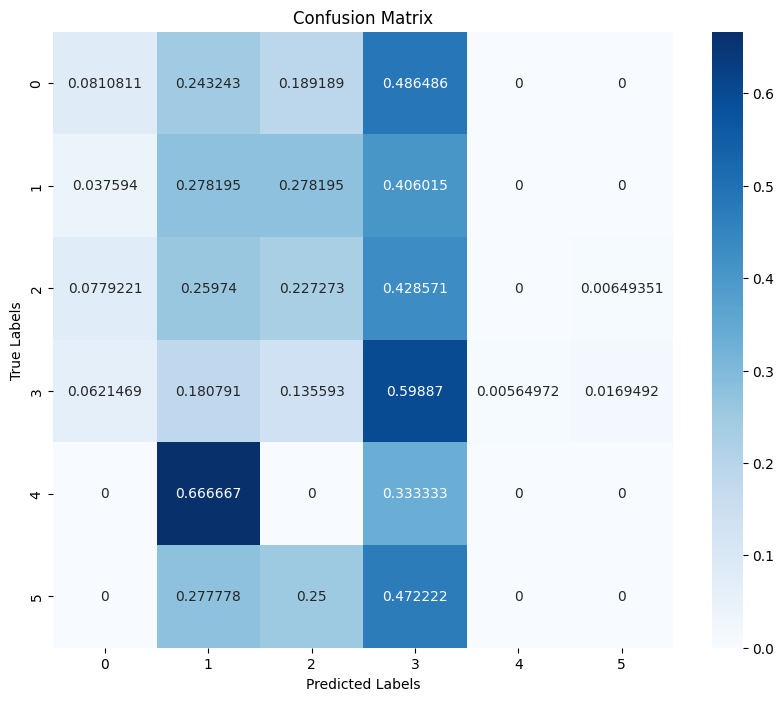

Epoch 20, Validation Loss: 3.7804, Accuracy: 0.3189, F1 Score: 0.2877
Val F1 Score Per Class  [0.11111111 0.27205882 0.25641026 0.46389497 0.         0.        ]


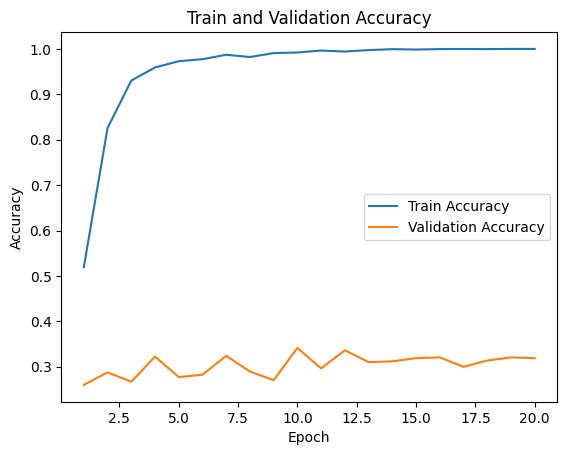

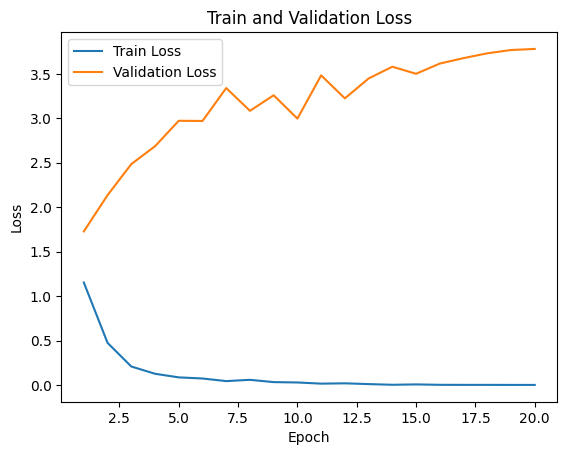

Test:   1%|▏         | 1/73 [00:00<00:33,  2.16it/s, loss=5.43]

[tensor([-1.8462,  1.6752, -2.5132,  0.6608, -3.1885, -3.0066], device='cuda:0'), tensor([-2.5360,  0.2047, -1.1652,  1.1100, -6.2829, -4.9142], device='cuda:0'), tensor([ 1.0650,  0.1467, -2.8051,  0.7919, -5.5938, -4.7091], device='cuda:0'), tensor([-4.1027,  1.5006, -0.7932,  2.9991, -4.4514, -4.5198], device='cuda:0'), tensor([-2.8110,  6.4130, -1.7299, -0.1937, -5.0074, -3.9580], device='cuda:0'), tensor([-0.2233, -2.9999,  1.3141,  1.2339, -5.6034, -3.0462], device='cuda:0'), tensor([ 1.3320, -2.8289,  0.4421,  1.0254, -5.2808, -3.3357], device='cuda:0'), tensor([-2.8057,  6.4203, -3.1786, -1.3399, -3.7043, -2.5434], device='cuda:0')]


Test:   3%|▎         | 2/73 [00:00<00:32,  2.18it/s, loss=5.96]

[tensor([-2.5545, -2.3367,  7.4114, -1.1006, -3.0351, -2.7868], device='cuda:0'), tensor([-3.2626,  3.4468, -2.2790, -0.1990, -5.2773, -3.7518], device='cuda:0'), tensor([-2.0544, -3.4043,  5.0301, -0.0550, -4.1701, -3.2259], device='cuda:0'), tensor([-2.3941, -2.6934,  7.6260, -1.3652, -3.3395, -2.6259], device='cuda:0'), tensor([-2.2668, -3.2737,  0.5163, -2.0255, -5.2552, -5.2210], device='cuda:0'), tensor([-2.2928, -1.1120,  6.2773, -1.7448, -5.2698, -3.5368], device='cuda:0'), tensor([-2.7925,  0.0338, -2.3077,  6.8456, -4.4946, -3.8050], device='cuda:0'), tensor([-3.8440,  4.5769, -1.8461,  0.6425, -5.4313, -3.6919], device='cuda:0')]


Test:   4%|▍         | 3/73 [00:01<00:32,  2.17it/s, loss=2.69]

[tensor([-2.7610, -0.2973, -1.2386,  2.9518, -4.5468, -5.0678], device='cuda:0'), tensor([-2.9268,  1.8367, -2.3515,  1.7452, -3.9470, -3.3703], device='cuda:0'), tensor([-2.6047, -3.1878,  3.3988,  2.1555, -4.7145, -3.2018], device='cuda:0'), tensor([-3.7649,  0.8002,  2.8504, -3.1221, -5.0190, -3.4254], device='cuda:0'), tensor([-2.8363, -3.4834,  4.1057,  2.4211, -5.2450, -4.1367], device='cuda:0'), tensor([-0.2644, -2.8879, -2.6565,  3.7899, -4.7405, -2.0696], device='cuda:0'), tensor([-4.5763,  0.5626,  1.6263,  0.7808, -6.2572, -4.0170], device='cuda:0'), tensor([ 1.0707, -1.0305, -3.1186,  1.3875, -5.5384, -0.9949], device='cuda:0')]


Test:   5%|▌         | 4/73 [00:01<00:31,  2.16it/s, loss=1.92]

[tensor([ 2.7106, -3.5201, -1.5437, -1.0973, -1.9011, -4.1154], device='cuda:0'), tensor([-4.7047, -1.4070, -1.2880,  1.8022, -6.3464, -3.1550], device='cuda:0'), tensor([-2.5735, -0.0142, -1.3475,  3.1615, -4.7165, -5.1621], device='cuda:0'), tensor([-1.9831, -3.0296,  3.7795,  0.6522, -5.1154, -4.0770], device='cuda:0'), tensor([-2.5367, -1.6352, -3.3313,  0.0754, -3.5256,  4.6098], device='cuda:0'), tensor([-2.1724,  2.4310, -0.3569, -3.1725, -5.7606, -2.1114], device='cuda:0'), tensor([-3.2082, -2.5828, -0.5402,  4.1659, -5.6535, -4.6078], device='cuda:0'), tensor([-3.1703, -1.8807,  5.2373,  1.1177, -4.9079, -4.3114], device='cuda:0')]


Test:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=4.45]

[tensor([-2.0209,  5.7304, -2.6224, -3.0019, -4.2168, -2.5469], device='cuda:0'), tensor([-3.5628,  2.0370, -0.4489,  2.7891, -6.8611, -4.8437], device='cuda:0'), tensor([-2.1677,  5.5770, -3.4430, -0.5641, -4.9018, -3.5923], device='cuda:0'), tensor([-3.7673, -2.2598, -1.9086,  6.8471, -4.6161, -3.0410], device='cuda:0'), tensor([-1.9117, -1.1529, -1.5839,  3.8252, -4.9724, -4.3637], device='cuda:0'), tensor([-3.1090, -1.7083,  6.8318, -2.0732, -4.3756, -4.0577], device='cuda:0'), tensor([-3.8220,  0.9960, -0.7892,  0.1990, -3.9450, -4.8223], device='cuda:0'), tensor([-3.0297,  4.0171, -1.5963, -1.0033, -4.5795, -3.6265], device='cuda:0')]


Test:   8%|▊         | 6/73 [00:02<00:30,  2.17it/s, loss=4.27]

[tensor([-1.4952, -2.7963,  7.4064, -1.2499, -3.5229, -3.5252], device='cuda:0'), tensor([-3.1905,  3.6528,  0.0830, -1.5569, -5.0104, -4.1368], device='cuda:0'), tensor([-2.4649,  0.0462, -0.8145,  3.3986, -6.7947, -3.1910], device='cuda:0'), tensor([-2.3237, -1.4861, -0.5024, -0.9842, -2.0251, -4.7773], device='cuda:0'), tensor([-3.5520, -2.0388, -0.8892,  4.2039, -4.4711, -2.7754], device='cuda:0'), tensor([-3.7312, -1.2237, -0.7096,  2.3213, -4.6248, -4.3403], device='cuda:0'), tensor([-0.5470,  0.0724, -1.4089,  2.9329, -3.1829, -3.8463], device='cuda:0'), tensor([-3.6765, -0.6155, -3.2071,  0.5435, -5.5355, -2.2107], device='cuda:0')]


Test:  10%|▉         | 7/73 [00:03<00:30,  2.16it/s, loss=4.56]

[tensor([-3.1033,  2.7047,  4.1553, -3.2203, -4.2043, -3.7167], device='cuda:0'), tensor([-1.8042,  4.7093, -2.3998, -1.5842, -3.1233, -1.5898], device='cuda:0'), tensor([-1.0869,  1.0474, -1.7580, -2.7268,  9.3381, -1.9275], device='cuda:0'), tensor([ 0.8210, -3.2663,  4.6869, -0.3999, -4.8748, -3.4551], device='cuda:0'), tensor([-4.0705,  3.6566, -2.3531,  0.0656, -2.2200, -3.8398], device='cuda:0'), tensor([-3.5823,  3.7603, -2.2062,  0.5850, -4.9101, -4.9634], device='cuda:0'), tensor([-1.4816,  2.4813, -4.3651, -1.0172, -4.2672, -2.2235], device='cuda:0'), tensor([-3.1421,  0.8017, -2.2088,  2.7665, -3.3030, -2.6990], device='cuda:0')]


Test:  11%|█         | 8/73 [00:03<00:30,  2.17it/s, loss=3.63]

[tensor([-2.4380, -2.0287,  7.6825, -1.3971, -3.6482, -2.8234], device='cuda:0'), tensor([-3.2964, -0.5883, -2.9195,  6.8890, -4.6226, -2.6049], device='cuda:0'), tensor([ 1.6349, -2.5089, -1.5318,  3.1151, -5.1960, -4.0615], device='cuda:0'), tensor([ 1.5499, -1.3325, -1.4518, -0.2225, -5.4686, -4.0060], device='cuda:0'), tensor([-3.0069,  0.2109,  5.8398, -2.7462, -4.2498, -2.9588], device='cuda:0'), tensor([-2.1132, -0.5742, -2.1183,  1.6668, -4.3662, -5.5767], device='cuda:0'), tensor([-3.0187, -2.2014,  5.6480, -0.9577, -4.0244, -2.7566], device='cuda:0'), tensor([-2.7961, -3.5443,  0.3454,  5.4034, -4.0273, -3.9545], device='cuda:0')]


Test:  12%|█▏        | 9/73 [00:04<00:29,  2.16it/s, loss=3.89]

[tensor([-3.3946, -1.1269, -2.4948,  3.2331, -5.8644, -1.8326], device='cuda:0'), tensor([-0.4073, -1.9026, -2.3993,  2.0487, -3.8795, -3.2468], device='cuda:0'), tensor([-2.7806,  2.0728,  0.5325, -1.8245, -4.2397, -4.3903], device='cuda:0'), tensor([-3.2458, -2.5187,  2.8148,  1.9753, -5.9260, -4.5318], device='cuda:0'), tensor([-1.9894, -2.1096, -2.2551,  7.0864, -5.0170, -3.4330], device='cuda:0'), tensor([-3.2177, -3.6004,  0.0158,  5.7169, -5.3186, -3.3757], device='cuda:0'), tensor([-2.7871, -1.9090, -2.4363, -1.2672, -5.8520, -2.9003], device='cuda:0'), tensor([-3.6265, -0.8614, -0.0288,  2.1680, -4.9611, -4.2902], device='cuda:0')]


Test:  14%|█▎        | 10/73 [00:04<00:29,  2.16it/s, loss=3.94]

[tensor([-3.9978, -3.6999, -0.6189,  5.1156, -6.0317, -3.2351], device='cuda:0'), tensor([-3.4991,  1.0629, -2.9507,  3.0551, -6.0514, -5.0227], device='cuda:0'), tensor([-2.1038,  1.7525, -3.1198,  2.1037, -5.6374, -5.2487], device='cuda:0'), tensor([-3.2033,  0.4400, -1.0631,  2.9876, -5.6696, -5.0235], device='cuda:0'), tensor([-3.4664, -1.5058,  5.8407, -1.8933, -4.8408, -3.6504], device='cuda:0'), tensor([-3.7617,  4.8634, -1.8290, -0.4982, -5.2332, -3.8418], device='cuda:0'), tensor([-2.7718, -3.2437,  0.8405,  5.9591, -5.5687, -3.9228], device='cuda:0'), tensor([ 4.3951, -3.2546, -1.5468, -0.0581, -4.0095, -2.1851], device='cuda:0')]


Test:  15%|█▌        | 11/73 [00:05<00:28,  2.15it/s, loss=4.65]

[tensor([-3.4990, -3.0402, -1.5144,  5.4645, -4.7852, -2.9217], device='cuda:0'), tensor([-3.2803, -2.4963,  1.0795,  2.6263, -5.1757, -4.1635], device='cuda:0'), tensor([-4.3990,  2.6479, -0.5681,  1.5450, -6.5480, -4.9987], device='cuda:0'), tensor([-2.3031,  1.8517, -3.5410, -1.0302, -2.6167, -2.4860], device='cuda:0'), tensor([-4.6996, -2.1657,  0.3089, -0.7728, -5.0657, -2.8555], device='cuda:0'), tensor([-2.5419, -2.1222, -1.8390,  7.1525, -4.4718, -3.1796], device='cuda:0'), tensor([-3.6118, -1.8542, -0.5977, -1.7930, -5.6174, -3.6227], device='cuda:0'), tensor([-3.9326, -0.1752,  2.5742, -2.2093, -4.4018, -4.6442], device='cuda:0')]


Test:  16%|█▋        | 12/73 [00:05<00:28,  2.14it/s, loss=2.76]

[tensor([-1.5225,  7.1253, -3.1884, -0.8018, -3.8369, -2.9010], device='cuda:0'), tensor([-3.6581,  3.9306, -2.6027, -0.8373, -4.9815, -2.8702], device='cuda:0'), tensor([-3.0008, -2.0502, -0.6267,  4.4722, -4.6089, -4.6664], device='cuda:0'), tensor([-2.1095, -0.1761, -2.5897, -2.4843, -5.2977, -1.1947], device='cuda:0'), tensor([ 4.1295, -2.8455, -1.0234,  1.1564, -5.0733, -4.8484], device='cuda:0'), tensor([-2.7280, -0.6622, -1.2082,  4.4673, -5.4064, -5.5183], device='cuda:0'), tensor([-2.4446, -3.4428,  3.4528, -0.3075, -4.1491, -3.4219], device='cuda:0'), tensor([-3.6160, -1.6592, -2.9792,  7.1608, -3.1812, -1.9192], device='cuda:0')]


Test:  18%|█▊        | 13/73 [00:06<00:27,  2.16it/s, loss=5.99]

[tensor([-3.5761, -0.5939, -2.2901,  6.7655, -3.8043, -3.1784], device='cuda:0'), tensor([-4.2635,  3.3849, -1.7559,  0.8987, -5.2979, -3.4837], device='cuda:0'), tensor([-3.2887, -1.2115,  3.3447, -0.2145, -5.8777, -4.3076], device='cuda:0'), tensor([-3.3271,  3.1114, -2.5919, -1.6639, -3.6988,  0.3704], device='cuda:0'), tensor([-2.0788,  2.5503, -1.9214,  0.2513, -4.8191, -3.1612], device='cuda:0'), tensor([-2.8244,  5.3609, -3.4173,  0.5587, -4.2645, -3.3715], device='cuda:0'), tensor([-3.2039, -2.0800,  3.1872, -0.9157, -4.1677, -4.3018], device='cuda:0'), tensor([-3.3585, -1.2480,  5.6274, -1.5747, -4.0190, -1.6426], device='cuda:0')]


Test:  19%|█▉        | 14/73 [00:06<00:28,  2.10it/s, loss=4.08]

[tensor([-3.5561, -0.6828, -2.4331,  1.4786, -5.2960, -2.8246], device='cuda:0'), tensor([-2.1102, -2.1587,  7.0420, -1.5652, -2.7371, -3.5909], device='cuda:0'), tensor([-2.9868,  5.0689, -1.6323, -0.7536, -4.9256, -4.0096], device='cuda:0'), tensor([-0.5531, -3.9953,  1.2170,  4.8677, -5.2268, -4.4059], device='cuda:0'), tensor([-3.1178, -2.9789,  5.1956, -0.7706, -5.2325, -4.1997], device='cuda:0'), tensor([-1.2721, -2.1748, -0.7379, -1.1621, -6.0299, -4.4890], device='cuda:0'), tensor([-4.4621, -2.4796, -0.8954,  2.2451, -4.3959, -1.1623], device='cuda:0'), tensor([-3.3383, -0.0814, -0.5174, -1.2057, -5.5628, -4.5077], device='cuda:0')]


Test:  21%|██        | 15/73 [00:07<00:27,  2.09it/s, loss=3.39]

[tensor([ 2.9746, -2.3117, -1.6048, -1.2652, -6.1053, -5.2791], device='cuda:0'), tensor([-3.9744, -1.6911, -3.3095,  5.1399, -3.8377, -2.0200], device='cuda:0'), tensor([-3.0100,  4.1541, -3.5303,  2.2912, -4.7769, -2.0751], device='cuda:0'), tensor([-3.3784, -0.1829,  5.2348, -2.3103, -3.9633, -3.8636], device='cuda:0'), tensor([-3.9153, -0.1275, -1.0713,  0.8719, -5.3309, -4.0491], device='cuda:0'), tensor([-1.8506, -3.4082, -2.9426,  2.1889, -4.0721,  1.0759], device='cuda:0'), tensor([-2.0017,  3.3662,  0.7123, -2.8299, -4.8523, -4.1243], device='cuda:0'), tensor([-3.4512, -1.3218, -1.2236,  0.0228, -5.2617, -5.1071], device='cuda:0')]


Test:  22%|██▏       | 16/73 [00:07<00:27,  2.09it/s, loss=4.85]

[tensor([-4.1083, -3.4170,  1.1009,  5.8690, -3.9476, -3.8796], device='cuda:0'), tensor([-2.2361, -0.4304,  7.0119, -2.4129, -3.9989, -3.5634], device='cuda:0'), tensor([-3.8566, -1.2398, -1.4679,  6.9263, -4.6911, -3.3912], device='cuda:0'), tensor([-3.3196, -4.4126, -0.8369,  0.4759, -4.4447, -0.8021], device='cuda:0'), tensor([-4.5895, -2.0716,  0.1061,  2.4976, -5.2683, -2.7467], device='cuda:0'), tensor([-2.2957, -3.0393,  3.3250, -0.6888, -4.5633, -4.5060], device='cuda:0'), tensor([-3.2203, -2.5986,  3.2514,  3.2710, -6.4804, -4.2030], device='cuda:0'), tensor([-3.1743,  6.9894, -2.5747, -0.2677, -3.4443, -3.2090], device='cuda:0')]


Test:  23%|██▎       | 17/73 [00:07<00:26,  2.11it/s, loss=4.62]

[tensor([-4.4801,  0.8777, -0.5369,  2.1158, -5.2445, -5.4196], device='cuda:0'), tensor([-4.2033, -0.8480,  2.2107,  0.3772, -5.2999, -3.8895], device='cuda:0'), tensor([-3.0604, -0.3838, -3.6758,  2.7200, -4.3386, -0.9703], device='cuda:0'), tensor([ 1.5168, -2.0216,  2.5024, -1.4941, -4.9543, -4.4666], device='cuda:0'), tensor([-2.7247, -0.9007,  5.4070,  0.2144, -4.7283, -5.2669], device='cuda:0'), tensor([-4.2255, -2.2588, -1.8596,  1.9045, -5.1770, -3.1978], device='cuda:0'), tensor([-3.0418, -2.9161, -1.6936, -0.1101, -4.2543,  0.0798], device='cuda:0'), tensor([-3.3642,  1.9954, -1.5873,  1.1562, -5.4908, -4.4368], device='cuda:0')]


Test:  25%|██▍       | 18/73 [00:08<00:26,  2.11it/s, loss=2.54]

[tensor([-1.1860,  3.9346, -1.8702,  0.8773, -4.0171, -4.9354], device='cuda:0'), tensor([-3.8028, -0.5582, -0.7143, -0.5605, -3.7058,  0.6876], device='cuda:0'), tensor([-2.8654, -2.8128,  4.1289,  2.4057, -4.6973, -3.9820], device='cuda:0'), tensor([-1.0406, -1.5230, -1.1287,  2.7334, -3.6052, -3.8971], device='cuda:0'), tensor([-3.0132, -1.0891, -2.1462,  7.4029, -3.6255, -3.5358], device='cuda:0'), tensor([-3.1755, -1.2564, -2.7029, -0.5902, -4.6830, -3.3938], device='cuda:0'), tensor([-1.7530,  0.2345, -2.8698,  3.0396, -4.4127, -4.1382], device='cuda:0'), tensor([-2.9461,  1.2188, -2.1917,  2.1603, -5.6669, -4.9480], device='cuda:0')]


Test:  26%|██▌       | 19/73 [00:08<00:25,  2.13it/s, loss=3.47]

[tensor([-1.1427,  4.9785, -3.0538, -0.3582, -5.0365, -2.7978], device='cuda:0'), tensor([-1.1915,  5.6963, -2.9639, -2.3039, -3.4740, -2.4420], device='cuda:0'), tensor([ 0.6162, -3.7830, -1.9150,  1.5852, -3.1531, -1.8480], device='cuda:0'), tensor([-1.4168, -1.3110, -2.6317,  1.5434, -6.5245, -4.8736], device='cuda:0'), tensor([-2.6403, -3.4964,  1.6902,  4.1012, -5.2378, -4.6875], device='cuda:0'), tensor([-2.5670, -0.7655, -2.3925,  3.7077, -4.9209, -3.5316], device='cuda:0'), tensor([-3.1557, -0.7520, -1.7886,  4.7308, -5.2932, -4.3517], device='cuda:0'), tensor([-3.4045, -2.7787, -1.2041,  4.8439, -5.4765, -2.5655], device='cuda:0')]


Test:  27%|██▋       | 20/73 [00:09<00:24,  2.13it/s, loss=3.42]

[tensor([-3.6651, -2.0095, -0.8083, -0.8263, -5.1673, -4.6454], device='cuda:0'), tensor([ 5.3758, -3.4272, -1.6348,  0.3037, -3.9567, -2.3722], device='cuda:0'), tensor([-2.9586, -2.0843, -1.6510,  6.9457, -4.3193, -2.6961], device='cuda:0'), tensor([-3.4174,  4.0114, -2.6366,  0.3644, -5.0009, -4.8456], device='cuda:0'), tensor([-4.1265, -0.4135, -1.0310,  1.9422, -4.9467, -4.2648], device='cuda:0'), tensor([-2.9481, -1.5242,  3.2047, -0.5822, -4.5556, -3.3129], device='cuda:0'), tensor([-2.7248,  0.5026, -2.0595,  2.7202, -4.9607, -4.9216], device='cuda:0'), tensor([-3.5363, -2.2235, -2.4909,  4.4445, -4.9070, -3.0070], device='cuda:0')]


Test:  29%|██▉       | 21/73 [00:09<00:24,  2.13it/s, loss=5.03]

[tensor([-2.8903, -2.0472, -1.4282,  6.8854, -4.4692, -4.0243], device='cuda:0'), tensor([-2.3846,  4.2191, -2.4798, -2.9180, -5.6154, -2.3201], device='cuda:0'), tensor([-2.7108, -2.7792,  1.8163,  1.3268, -6.4996, -3.6012], device='cuda:0'), tensor([-3.0987,  3.4033, -2.2726,  1.3399, -5.9299, -3.0921], device='cuda:0'), tensor([-3.0157,  1.4580, -1.4856,  2.4519, -4.2957, -4.9376], device='cuda:0'), tensor([-1.7932, -1.6322, -3.0267,  2.8622, -3.5140, -3.4014], device='cuda:0'), tensor([-3.9196, -0.8498,  4.6915, -1.1683, -3.6470, -4.0641], device='cuda:0'), tensor([-3.7856, -1.5969, -2.3387,  0.9446, -5.0438, -4.6120], device='cuda:0')]


Test:  30%|███       | 22/73 [00:10<00:23,  2.14it/s, loss=3.49]

[tensor([-2.6742, -3.9640,  1.0073,  0.2249, -4.1652, -3.5310], device='cuda:0'), tensor([-2.5517, -2.6626, -2.2617,  7.1736, -4.1648, -2.5155], device='cuda:0'), tensor([-3.3593,  0.0090, -1.4666,  0.1874, -4.5139, -4.9835], device='cuda:0'), tensor([-1.3823, -1.2102, -2.4673,  6.9351, -4.8386, -4.7788], device='cuda:0'), tensor([-3.1978, -2.6898,  1.2836, -0.0056, -4.7240, -3.0779], device='cuda:0'), tensor([-4.5666, -0.5196,  1.4266,  0.8276, -5.4161, -5.6635], device='cuda:0'), tensor([-2.7529,  7.2193, -1.3493, -1.7486, -3.5091, -2.9466], device='cuda:0'), tensor([-2.5794,  1.7204, -2.6278,  1.1025, -5.5360, -3.0746], device='cuda:0')]


Test:  32%|███▏      | 23/73 [00:10<00:23,  2.14it/s, loss=5.49]

[tensor([-2.9336,  2.9579,  0.5330, -3.2848, -4.3517, -3.3717], device='cuda:0'), tensor([-2.0146, -2.6032,  0.0896,  6.0189, -5.3138, -4.7032], device='cuda:0'), tensor([-2.5006, -1.5915,  6.9373, -0.9809, -3.5535, -3.8764], device='cuda:0'), tensor([-4.2672,  1.9025,  2.6682,  0.6737, -5.1639, -4.4092], device='cuda:0'), tensor([-1.9097, -2.6804,  6.9566, -0.9665, -4.1864, -3.6777], device='cuda:0'), tensor([-4.6831, -1.9122,  3.5349, -1.5712, -4.7548, -3.5576], device='cuda:0'), tensor([-2.0359e+00, -1.0680e-03,  3.4631e+00, -2.1192e+00, -5.4432e+00,
        -5.3891e+00], device='cuda:0'), tensor([-0.2359,  4.7596, -2.3888, -1.5267, -4.5423, -4.2975], device='cuda:0')]


Test:  33%|███▎      | 24/73 [00:11<00:22,  2.15it/s, loss=6.48]

[tensor([-3.5566, -2.5156,  0.1790,  5.7866, -5.8640, -4.0409], device='cuda:0'), tensor([-2.3362,  5.7734, -1.9932, -0.6918, -4.2145, -4.6164], device='cuda:0'), tensor([-2.7944,  6.7285, -2.0656, -1.6555, -3.8567, -2.3222], device='cuda:0'), tensor([-3.0495,  7.4729, -1.8724, -2.1877, -3.8812, -2.0698], device='cuda:0'), tensor([-4.4937e+00,  1.8118e-01,  1.8141e+00,  4.7610e-03, -5.3649e+00,
        -5.1536e+00], device='cuda:0'), tensor([-3.4218,  2.7466, -0.7443, -0.3540, -5.4638, -4.7749], device='cuda:0'), tensor([-2.5098,  5.1450, -2.5970, -1.5074, -3.0767, -1.8793], device='cuda:0'), tensor([-2.6465, -1.8608,  6.5946, -2.4861, -4.0497, -4.0969], device='cuda:0')]


Test:  34%|███▍      | 25/73 [00:11<00:22,  2.15it/s, loss=4.71]

[tensor([-2.2926, -0.2283, -2.4530,  2.5451, -3.7533, -3.9271], device='cuda:0'), tensor([-2.7809e+00, -9.1986e-01,  8.7241e-04, -1.6094e+00, -5.9287e+00,
        -4.7485e+00], device='cuda:0'), tensor([-2.0061, -0.2878,  1.1262, -1.8171, -4.7773, -4.2291], device='cuda:0'), tensor([-2.7402, -2.7213,  6.3702, -1.4120, -5.3042, -1.4872], device='cuda:0'), tensor([-4.1437, -1.4556,  4.7439, -1.6797, -4.6597, -3.7021], device='cuda:0'), tensor([-3.8690, -0.5351, -1.0595,  0.0503, -4.3208, -4.8138], device='cuda:0'), tensor([-3.6975, -3.3402,  1.4304,  5.7491, -4.9805, -3.8825], device='cuda:0'), tensor([-4.1955,  4.1389, -1.4641,  1.8244, -4.7689, -3.9499], device='cuda:0')]


Test:  36%|███▌      | 26/73 [00:12<00:21,  2.16it/s, loss=4.96]

[tensor([-3.1088, -1.5478, -1.9539,  4.0028, -3.2941, -3.6255], device='cuda:0'), tensor([-4.5788,  4.4929, -2.5103, -0.4607, -3.8743, -0.7721], device='cuda:0'), tensor([-2.9946, -0.3762, -1.6000, -0.9569, -5.2419, -4.3803], device='cuda:0'), tensor([-2.4380, -3.4575,  2.6712, -0.2908, -5.3728, -5.8872], device='cuda:0'), tensor([-2.8530,  5.2415, -3.0761,  1.2933, -4.3926, -2.0906], device='cuda:0'), tensor([ 5.0048, -0.4584,  0.2851, -2.6411, -3.6935, -4.0922], device='cuda:0'), tensor([-0.4994, -2.8876,  5.3406, -1.1229, -4.5558, -3.4421], device='cuda:0'), tensor([-3.1880, -1.1515,  7.1703, -0.7463, -4.5597, -3.7878], device='cuda:0')]


Test:  37%|███▋      | 27/73 [00:12<00:21,  2.16it/s, loss=2.8]

[tensor([-2.8400, -1.4505, -1.1643, -0.7988, -6.4886, -4.0760], device='cuda:0'), tensor([-4.8914, -1.6508, -0.8114,  3.4935, -3.7806, -5.0251], device='cuda:0'), tensor([ 1.1682, -1.6977,  0.4505, -1.2353, -4.4032, -4.8814], device='cuda:0'), tensor([ 1.6744, -0.6675,  0.9101, -1.0057, -6.2984, -4.0670], device='cuda:0'), tensor([-3.0948,  0.4344, -2.2769,  1.6967, -4.9588, -4.7802], device='cuda:0'), tensor([-0.8893,  0.5373, -3.7842,  3.0810, -5.7322, -3.4357], device='cuda:0'), tensor([-0.4691, -2.0584, -0.8986,  4.8655, -5.8996, -4.7840], device='cuda:0'), tensor([-0.5463, -2.7489,  4.1293,  0.7325, -5.6447, -5.0164], device='cuda:0')]


Test:  38%|███▊      | 28/73 [00:13<00:20,  2.15it/s, loss=4.16]

[tensor([-1.9233, -0.5554, -2.5397, -0.1743, -4.1992, -0.6550], device='cuda:0'), tensor([-2.8621, -3.0497, -0.2822,  6.4911, -4.4379, -3.9423], device='cuda:0'), tensor([-4.0098, -2.7674,  6.2636, -1.5536, -4.2322, -2.2568], device='cuda:0'), tensor([-0.5132, -1.7228, -3.8919,  0.0576, -5.8463, -0.7592], device='cuda:0'), tensor([-2.8352,  5.3966, -3.7001,  1.0997, -4.6562, -2.2140], device='cuda:0'), tensor([-3.0828, -0.1617,  5.7446, -1.0722, -4.6859, -3.2282], device='cuda:0'), tensor([-3.8010, -2.2567, -1.0025,  4.6385, -4.3867, -4.6403], device='cuda:0'), tensor([-2.1404, -2.3435, -0.6156,  3.8754, -5.0633, -4.4555], device='cuda:0')]


Test:  40%|███▉      | 29/73 [00:13<00:20,  2.13it/s, loss=4.24]

[tensor([-2.3859, -2.7589,  0.2683,  5.1442, -5.3539, -3.9030], device='cuda:0'), tensor([-3.1459,  0.0699, -3.8907,  2.2867, -4.5327, -3.3022], device='cuda:0'), tensor([-1.0310,  4.6005, -0.1964, -3.5351, -3.4301, -3.0329], device='cuda:0'), tensor([-2.9758,  0.0759, -2.7300,  6.8766, -3.3387, -3.6948], device='cuda:0'), tensor([-3.0119, -2.1677,  5.9245, -0.7573, -4.4694, -3.6079], device='cuda:0'), tensor([-2.5506, -2.8284, -1.0609,  6.5541, -4.0437, -3.8160], device='cuda:0'), tensor([-3.2242,  7.1934, -2.3989, -0.7367, -3.0746, -3.4425], device='cuda:0'), tensor([-2.2582, -0.4890, -1.4331, -1.2774, -5.7805, -4.6292], device='cuda:0')]


Test:  41%|████      | 30/73 [00:14<00:20,  2.13it/s, loss=4.71]

[tensor([-3.3134,  0.9190, -2.1385, -0.4772, -5.5424, -3.5264], device='cuda:0'), tensor([-4.1611,  1.7760, -1.7187, -1.5921, -3.4240, -3.3727], device='cuda:0'), tensor([-2.5921, -1.3905, -2.3705,  3.2016, -4.7983, -4.3362], device='cuda:0'), tensor([ 1.3540, -3.7191,  3.6182, -1.8115, -4.2963, -3.2541], device='cuda:0'), tensor([-4.4818,  0.7521, -0.6687,  2.1731, -3.8536, -2.9956], device='cuda:0'), tensor([-4.2170,  5.3648,  0.0147, -0.3144, -4.8775, -4.6394], device='cuda:0'), tensor([-2.7377, -1.8967,  4.3700,  1.3491, -5.7546, -4.4984], device='cuda:0'), tensor([-3.0122, -1.2825, -0.2684,  0.1893, -6.6981, -2.4071], device='cuda:0')]


Test:  42%|████▏     | 31/73 [00:14<00:19,  2.14it/s, loss=3.86]

[tensor([ 0.5106,  0.8595, -3.4715,  0.8178, -4.7739, -3.3671], device='cuda:0'), tensor([-0.3783, -1.6431, -3.7157,  2.2757, -6.1221, -3.6193], device='cuda:0'), tensor([-3.6304,  4.3687, -2.6228,  0.2706, -4.0655, -3.3014], device='cuda:0'), tensor([-2.0611, -0.9864,  6.8289, -2.0381, -4.2525, -2.7735], device='cuda:0'), tensor([-2.2953, -2.1636, -1.3822,  6.4496, -4.9877, -3.7631], device='cuda:0'), tensor([-2.8082, -2.2648, -1.5603,  7.3284, -4.0590, -3.4040], device='cuda:0'), tensor([-3.3372, -2.0165, -0.9450, -0.6706, -5.5493, -5.0075], device='cuda:0'), tensor([ 0.7586, -1.7430,  0.9063,  1.0374, -6.2756, -4.2552], device='cuda:0')]


Test:  44%|████▍     | 32/73 [00:14<00:19,  2.14it/s, loss=3.44]

[tensor([-2.0064, -2.3559, -0.5296,  2.0624, -5.1766, -4.3756], device='cuda:0'), tensor([-2.9612, -1.2314, -2.5389,  7.0282, -5.5095, -3.0108], device='cuda:0'), tensor([-0.6416, -2.6905, -1.7808,  5.2659, -4.7366, -3.9485], device='cuda:0'), tensor([-5.0676, -1.8572, -0.1649,  4.0141, -4.3368, -2.8764], device='cuda:0'), tensor([-2.8174,  2.0994,  1.2254, -3.3275, -4.5907, -2.4062], device='cuda:0'), tensor([-2.4979, -2.3125, -1.2683,  1.0171, -6.0769, -3.2389], device='cuda:0'), tensor([-2.5817, -1.4690,  2.5082, -0.0410, -6.7673, -5.8893], device='cuda:0'), tensor([-4.3015, -1.0347, -0.4289,  2.3699, -6.0833, -4.2581], device='cuda:0')]


Test:  45%|████▌     | 33/73 [00:15<00:18,  2.14it/s, loss=2.76]

[tensor([-0.1171, -0.3535, -0.1165, -0.7256, -5.1544, -4.9308], device='cuda:0'), tensor([-2.3277,  3.3329, -2.2776, -1.3657, -5.4261, -5.2562], device='cuda:0'), tensor([-3.0936, -3.0108, -0.2518,  0.7552, -6.0537, -4.7144], device='cuda:0'), tensor([-2.9398, -1.8307,  1.8793,  3.8192, -5.4373, -5.5316], device='cuda:0'), tensor([-2.3586, -2.8876, -0.2232,  2.1197, -4.2702, -2.5705], device='cuda:0'), tensor([-2.6733, -2.2315, -2.8571,  6.2135, -3.9959, -2.9838], device='cuda:0'), tensor([ 2.6886,  0.1682, -3.6708, -1.0792, -4.3589, -2.5274], device='cuda:0'), tensor([-2.9292,  1.7493, -1.1118,  1.4225, -6.3243, -5.0889], device='cuda:0')]


Test:  47%|████▋     | 34/73 [00:15<00:18,  2.15it/s, loss=3.68]

[tensor([-3.9701, -0.9567,  0.3528,  5.8135, -4.3994, -5.5479], device='cuda:0'), tensor([-2.9200,  0.8382, -1.5122, -0.8196, -6.2983, -4.7797], device='cuda:0'), tensor([-2.2785, -3.1806, -1.9653,  2.3631, -6.1682, -2.8204], device='cuda:0'), tensor([-1.7236, -0.0820, -3.1081,  4.0622, -4.7631, -3.8708], device='cuda:0'), tensor([-2.1141,  4.1741, -0.3821, -2.1744, -3.1586, -3.4791], device='cuda:0'), tensor([-3.3561,  3.2168, -2.8991,  0.8699, -2.3153, -4.0148], device='cuda:0'), tensor([-1.3685, -0.7092, -2.3265,  5.0133, -5.1014, -4.2257], device='cuda:0'), tensor([-2.3910, -0.4882, -2.0210, -2.7620, -5.7699, -5.2022], device='cuda:0')]


Test:  48%|████▊     | 35/73 [00:16<00:17,  2.14it/s, loss=3.95]

[tensor([ 2.6477, -3.2333, -0.5217,  2.2257, -5.4475, -4.2675], device='cuda:0'), tensor([-2.1614, -1.7404, -2.2555,  6.6155, -4.9715, -4.1162], device='cuda:0'), tensor([-2.9916, -3.4765,  1.9404,  2.0126, -5.7201, -3.7884], device='cuda:0'), tensor([-2.6598, -3.4032, -0.7644,  6.7992, -4.2582, -3.0300], device='cuda:0'), tensor([-4.1525, -3.0643,  1.2219,  5.5475, -4.7572, -3.5500], device='cuda:0'), tensor([-2.6806, -1.6638,  5.3845, -2.6287, -3.5780, -4.7837], device='cuda:0'), tensor([-4.5633,  1.6112, -1.9254, -1.3094, -3.7822, -3.4177], device='cuda:0'), tensor([-1.5892, -2.9866,  2.9743,  1.7686, -5.5670, -5.3584], device='cuda:0')]


Test:  49%|████▉     | 36/73 [00:16<00:17,  2.14it/s, loss=4.02]

[tensor([-0.9775, -2.8845,  7.1511, -1.7885, -4.3856, -3.2555], device='cuda:0'), tensor([-1.5203, -2.6001, -1.6990,  5.9489, -5.8475, -3.0221], device='cuda:0'), tensor([-0.8941, -2.8697, -0.7458,  3.6359, -5.0811, -3.8798], device='cuda:0'), tensor([-2.2273, -1.9010,  7.6259, -1.8501, -2.7944, -2.1791], device='cuda:0'), tensor([-4.6935, -0.4605,  1.2220,  0.4897, -4.9996, -4.1900], device='cuda:0'), tensor([ 7.1694, -0.4704, -3.5060, -0.9562, -3.1243, -2.4934], device='cuda:0'), tensor([-5.1500,  0.1851,  3.3245,  2.2981, -4.7240, -2.9767], device='cuda:0'), tensor([-2.7085, -1.5260,  0.9490,  1.3685, -5.3571, -5.1512], device='cuda:0')]


Test:  51%|█████     | 37/73 [00:17<00:16,  2.15it/s, loss=6.38]

[tensor([ 4.5983, -0.0645, -2.0968, -0.2533, -4.9507, -5.1364], device='cuda:0'), tensor([-4.4371,  0.0788,  3.4050, -0.9499, -5.6060, -4.0871], device='cuda:0'), tensor([-2.4034, -1.9407, -2.9193,  6.1694, -5.1177, -1.0758], device='cuda:0'), tensor([-1.7750, -3.2059, -2.1936,  0.4871, -4.0423, -3.2184], device='cuda:0'), tensor([-1.6720, -2.4517,  7.6791, -1.0081, -3.7863, -3.2926], device='cuda:0'), tensor([-2.4952,  7.4089, -2.4143, -1.1647, -4.0131, -3.2380], device='cuda:0'), tensor([-3.4893,  0.2016, -3.7499,  2.2279, -4.3698, -3.6433], device='cuda:0'), tensor([-1.7951, -3.1934, -1.0625,  5.7402, -5.4276, -3.8533], device='cuda:0')]


Test:  52%|█████▏    | 38/73 [00:17<00:16,  2.14it/s, loss=4.18]

[tensor([-2.7817, -3.3348,  2.5242, -0.6988, -5.0436, -4.0366], device='cuda:0'), tensor([-0.2666,  0.4477, -2.3871, -1.3595, -4.5467, -3.7005], device='cuda:0'), tensor([-2.3089, -2.5390, -1.4016,  0.1782, -6.1087, -2.1160], device='cuda:0'), tensor([-2.9554,  1.0480, -2.3300,  1.2563, -5.5203, -4.1583], device='cuda:0'), tensor([-1.2232, -3.0425, -2.0821,  0.7207, -5.1520,  4.5867], device='cuda:0'), tensor([-2.6433,  0.8678, -1.1921,  2.0414, -5.8043, -4.8172], device='cuda:0'), tensor([-2.0035,  6.9557, -2.7154, -0.8914, -3.9231, -2.8565], device='cuda:0'), tensor([-3.9964, -0.0456, -0.1063, -1.1151, -5.0183, -4.6393], device='cuda:0')]


Test:  53%|█████▎    | 39/73 [00:18<00:16,  2.10it/s, loss=1.81]

[tensor([-2.3386,  7.2250, -2.4890, -1.1897, -4.1398, -3.2672], device='cuda:0'), tensor([-3.5422, -1.4838, -3.5209,  5.5984, -4.2337, -2.8489], device='cuda:0'), tensor([-1.3642, -3.1338, -2.3308,  2.4883, -4.4739, -1.5569], device='cuda:0'), tensor([-3.5672, -1.1780, -2.7953, -0.0892, -4.5515, -3.6627], device='cuda:0'), tensor([-3.7003,  3.6003, -2.6394, -1.9600, -2.2997, -0.9597], device='cuda:0'), tensor([-3.4394, -2.0350, -1.6296,  6.7392, -4.5516, -3.4311], device='cuda:0'), tensor([-1.2377, -3.0338, -0.1480,  5.9578, -5.3643, -4.2849], device='cuda:0'), tensor([-3.5226, -0.3397, -2.9112,  4.0219, -5.9707, -1.9123], device='cuda:0')]


Test:  55%|█████▍    | 40/73 [00:18<00:15,  2.10it/s, loss=3.74]

[tensor([-3.4053,  5.1267, -0.7542, -1.6125, -4.8177, -3.9940], device='cuda:0'), tensor([-2.3600, -2.6622,  0.9399,  1.0605, -3.3643, -4.9063], device='cuda:0'), tensor([-4.1941, -2.4453, -1.1130,  1.9196, -5.8676, -3.9994], device='cuda:0'), tensor([-1.6048, -2.5743, -2.9905,  6.7628, -3.9425, -3.7301], device='cuda:0'), tensor([-3.7126, -1.3426,  6.1178, -0.9808, -4.4015, -3.8076], device='cuda:0'), tensor([-3.5412, -1.0673,  2.5596,  1.1278, -6.1618, -4.5119], device='cuda:0'), tensor([-3.0231, -2.7612, -2.3599,  4.8866, -5.4570, -4.1639], device='cuda:0'), tensor([-4.6547,  1.6886,  2.0137, -0.3027, -5.2655, -4.1102], device='cuda:0')]


Test:  56%|█████▌    | 41/73 [00:19<00:15,  2.12it/s, loss=3.89]

[tensor([-3.0894,  0.6203, -2.4253,  4.4563, -4.7359, -4.2541], device='cuda:0'), tensor([-1.8855, -3.9895, -0.2889, -1.2880, -5.8130, -3.3015], device='cuda:0'), tensor([-1.1936, -1.9241,  7.5233, -1.8461, -3.4487, -3.2335], device='cuda:0'), tensor([-3.2923, -2.2395,  7.0489, -1.2208, -4.1646, -2.9695], device='cuda:0'), tensor([-3.3478, -0.4991, -2.1399,  5.9670, -4.6352, -4.5841], device='cuda:0'), tensor([-3.1561, -2.8079, -1.0461,  4.3895, -5.0410, -2.2567], device='cuda:0'), tensor([-3.4159,  1.4467, -0.9604,  1.3078, -5.3480, -3.8661], device='cuda:0'), tensor([-3.2745,  0.0217, -0.0125,  0.8486, -6.8630, -5.3757], device='cuda:0')]


Test:  58%|█████▊    | 42/73 [00:19<00:14,  2.12it/s, loss=3.06]

[tensor([-3.2962,  2.4700, -2.9002,  0.0735, -4.9401, -3.4016], device='cuda:0'), tensor([-2.7865,  0.4179, -1.2832,  1.0601, -4.1037, -4.6184], device='cuda:0'), tensor([-2.1198,  0.3661, -0.0487, -0.4244, -5.8903, -6.2544], device='cuda:0'), tensor([-3.4111, -0.2413,  1.7524, -0.8776, -5.9419, -3.8097], device='cuda:0'), tensor([-1.0404, -3.7545, -1.6682,  2.8706, -4.2872,  0.5570], device='cuda:0'), tensor([-4.1681, -0.8773, -1.1257,  1.5526, -6.3308, -3.2810], device='cuda:0'), tensor([-3.0810,  1.8812, -3.1639,  1.3587, -4.2363, -4.6955], device='cuda:0'), tensor([-0.4715, -1.1929, -1.4299,  3.7363, -5.8872, -3.9620], device='cuda:0')]


Test:  59%|█████▉    | 43/73 [00:20<00:14,  2.14it/s, loss=2.44]

[tensor([-1.7977,  1.0186, -1.8871, -2.8911, -5.1487, -3.6566], device='cuda:0'), tensor([-1.8398, -2.3567, -1.3385,  5.6097, -5.2487, -4.0939], device='cuda:0'), tensor([-1.8000,  2.2894, -1.8418, -2.0054, -5.6939, -4.9988], device='cuda:0'), tensor([-2.6547,  3.4907, -1.7739,  1.2037, -5.3038, -4.3208], device='cuda:0'), tensor([-3.6155,  5.2967, -3.1373,  0.4376, -4.2207, -2.7474], device='cuda:0'), tensor([-1.2689, -3.2692, -2.7548,  3.3062, -6.3525, -4.6101], device='cuda:0'), tensor([-3.6808,  1.2660, -1.8379,  2.9693, -4.4965, -4.6668], device='cuda:0'), tensor([-2.5440, -0.8867, -1.6521,  4.1040, -6.0198, -3.8144], device='cuda:0')]


Test:  60%|██████    | 44/73 [00:20<00:13,  2.12it/s, loss=2.22]

[tensor([-2.2583, -0.9566,  0.3048,  1.4829, -6.7712, -4.3360], device='cuda:0'), tensor([-2.4188, -2.1641,  3.3879, -1.6335, -4.1733, -2.0785], device='cuda:0'), tensor([-3.7281, -0.3044, -2.5122, -0.0574, -4.8954, -4.6739], device='cuda:0'), tensor([-4.2234, -2.1990, -2.0828,  4.6982, -3.3069,  0.1588], device='cuda:0'), tensor([ 0.1798, -2.7023, -1.1177,  1.9121, -5.3437, -2.7933], device='cuda:0'), tensor([-0.9018,  1.4951, -2.3312, -2.2129, -3.7752, -4.0740], device='cuda:0'), tensor([ 0.1280, -2.3398, -0.7711,  1.9594, -5.9683, -4.1619], device='cuda:0'), tensor([-3.3598, -1.3080, -0.9055,  2.3635, -6.5761, -4.7999], device='cuda:0')]


Test:  62%|██████▏   | 45/73 [00:21<00:13,  2.14it/s, loss=3.48]

[tensor([-3.1188,  0.2576, -2.5321, -2.2876, -5.1358, -3.7622], device='cuda:0'), tensor([-3.9020, -0.7290,  0.8053,  0.8679, -5.1628, -4.2410], device='cuda:0'), tensor([-3.3574,  2.9734, -2.4077, -0.4547, -5.3112, -3.7025], device='cuda:0'), tensor([-3.3852, -3.6451, -2.2398,  5.2252, -4.6840, -2.8565], device='cuda:0'), tensor([-3.6666, -0.5108,  0.1825,  0.6635, -4.4009, -4.5391], device='cuda:0'), tensor([-2.5735, -2.1113,  6.3699, -1.9149, -4.2538, -3.9715], device='cuda:0'), tensor([-3.2219,  3.6940, -2.5603,  0.9657, -5.7111, -4.8405], device='cuda:0'), tensor([-2.6637, -2.4091,  6.6233, -1.0767, -4.3801, -3.8142], device='cuda:0')]


Test:  63%|██████▎   | 46/73 [00:21<00:12,  2.10it/s, loss=4.84]

[tensor([-4.5252, -3.4134, -1.7952,  2.8430, -5.3258, -2.8499], device='cuda:0'), tensor([-3.7321, -2.4455, -0.5936,  5.1329, -4.9413, -2.4084], device='cuda:0'), tensor([-0.4390, -2.5389,  0.2189, -0.7439, -5.8819, -4.3443], device='cuda:0'), tensor([-0.2870, -1.2322, -2.0951, -0.3594, -5.5339, -4.4739], device='cuda:0'), tensor([-0.9093, -2.5999,  2.1356,  0.4955, -5.5598, -4.6070], device='cuda:0'), tensor([-3.2961, -2.4250,  3.1004,  1.0565, -4.9058, -4.3728], device='cuda:0'), tensor([-3.2139, -1.1520, -3.3921,  4.4750, -4.7212, -3.8939], device='cuda:0'), tensor([-1.3297, -1.3395, -1.7218, -1.4543, -2.1731,  9.6714], device='cuda:0')]


Test:  64%|██████▍   | 47/73 [00:22<00:12,  2.10it/s, loss=2.17]

[tensor([-3.6586, -1.6657, -2.8713,  5.6762, -5.6226, -3.5476], device='cuda:0'), tensor([-2.9475, -2.5639, -0.6694,  2.0602, -5.0737, -4.0094], device='cuda:0'), tensor([ 4.4916, -2.7397, -1.0066,  0.7528, -4.4517, -5.2864], device='cuda:0'), tensor([-2.8825, -2.3132,  0.9510,  1.9751, -5.8707, -5.2399], device='cuda:0'), tensor([-3.0077, -3.1158,  0.9656,  1.7714, -4.1857, -3.6651], device='cuda:0'), tensor([-4.6749,  0.2035,  1.2325, -2.1010, -5.2684, -5.3067], device='cuda:0'), tensor([-2.8926, -0.8946,  3.1443, -2.2077, -4.6768, -1.3017], device='cuda:0'), tensor([-2.7833,  2.1160, -2.4592,  3.6886, -3.7442, -4.1774], device='cuda:0')]


Test:  66%|██████▌   | 48/73 [00:22<00:11,  2.10it/s, loss=1.67]

[tensor([ 1.1979, -0.1749, -3.8486, -0.3960, -3.7397, -2.3536], device='cuda:0'), tensor([-3.6134, -2.8424, -2.1279,  3.9412, -4.3410, -4.6911], device='cuda:0'), tensor([-3.9561,  4.9376, -2.9725, -1.1416, -4.3337, -2.7984], device='cuda:0'), tensor([-2.7135, -0.3288,  3.1274,  1.1377, -5.9523, -5.6123], device='cuda:0'), tensor([ 1.5204, -3.0920, -0.4563, -0.1036, -6.1633, -4.0101], device='cuda:0'), tensor([-3.4205,  4.3383,  1.3690, -0.8231, -4.8081, -4.8815], device='cuda:0'), tensor([-1.9880, -1.6140,  7.4046, -2.2025, -3.8304, -2.6670], device='cuda:0'), tensor([-2.7898, -1.7392, -0.9617,  1.2723, -6.6365, -4.3511], device='cuda:0')]


Test:  67%|██████▋   | 49/73 [00:22<00:11,  2.11it/s, loss=2.98]

[tensor([-2.5369, -1.6685,  0.1003, -0.3664, -4.8929, -3.7762], device='cuda:0'), tensor([-3.3469, -2.0521, -2.7358,  2.4685, -5.8897, -1.6304], device='cuda:0'), tensor([-3.0144, -3.8781, -1.0553,  5.8361, -2.3537, -2.5246], device='cuda:0'), tensor([-3.0604,  5.7819, -2.9813, -0.3025, -3.5139, -3.5011], device='cuda:0'), tensor([-4.4748, -0.4058, -0.9495,  0.5879, -5.2632, -3.9402], device='cuda:0'), tensor([-2.4423,  6.7696, -3.0905, -1.0342, -4.5256, -1.3528], device='cuda:0'), tensor([-3.2990,  5.1794, -1.1672, -1.3675, -5.2581, -3.9200], device='cuda:0'), tensor([-2.8327, -1.9547, -2.0056,  7.3618, -4.0462, -2.6641], device='cuda:0')]


Test:  68%|██████▊   | 50/73 [00:23<00:10,  2.12it/s, loss=4.16]

[tensor([-3.8198, -1.0028, -1.6585,  5.0475, -4.7480, -2.4333], device='cuda:0'), tensor([-2.0953, -1.6612, -1.1744, -1.0753, -4.8794, -3.9739], device='cuda:0'), tensor([ 6.3077, -2.8565,  0.2617, -1.0981, -4.2930, -2.5424], device='cuda:0'), tensor([ 0.2893,  1.6931, -0.4508, -1.2969, -4.4295, -4.6326], device='cuda:0'), tensor([-3.7883, -0.0096, -0.4486, -0.9962, -6.4589, -3.8845], device='cuda:0'), tensor([-4.4007, -0.2607,  0.2550,  4.8478, -5.6298, -4.8598], device='cuda:0'), tensor([-0.8534, -1.2453,  0.5198,  1.9758, -6.6271, -4.9760], device='cuda:0'), tensor([-1.5926,  0.0309,  1.2403, -3.3591, -4.4777, -4.1138], device='cuda:0')]


Test:  70%|██████▉   | 51/73 [00:23<00:10,  2.12it/s, loss=5.76]

[tensor([-2.8301, -0.6381, -2.7471,  5.1265, -4.7610, -3.8410], device='cuda:0'), tensor([-2.7412,  1.2931, -0.7644, -1.5160, -4.4956, -5.3023], device='cuda:0'), tensor([-3.6676,  5.8419, -0.7342, -0.8536, -4.1931, -4.0698], device='cuda:0'), tensor([-3.4240, -0.9241, -1.8406,  5.1240, -5.2757, -3.0773], device='cuda:0'), tensor([-3.6519, -3.5538,  1.2739,  3.8724, -4.0974, -1.5709], device='cuda:0'), tensor([-3.6614,  1.6827, -2.2683,  1.7939, -5.8935, -4.5594], device='cuda:0'), tensor([-1.4051, -0.0062,  4.7081, -2.8166, -3.9673, -3.7122], device='cuda:0'), tensor([-0.6408, -3.8327, -1.3074,  1.9844, -4.9083, -4.0807], device='cuda:0')]


Test:  71%|███████   | 52/73 [00:24<00:09,  2.13it/s, loss=4.54]

[tensor([-2.4929, -1.8581,  2.8219,  0.8334, -5.7170, -5.2526], device='cuda:0'), tensor([-3.1729, -2.8933, -2.9823,  4.4885, -4.4642,  0.7505], device='cuda:0'), tensor([-2.2941,  3.9436, -2.3706,  0.3017, -5.4145, -3.0522], device='cuda:0'), tensor([-3.9117,  4.7532, -1.2293,  1.2007, -5.4817, -5.1132], device='cuda:0'), tensor([-2.5785, -1.7544,  2.5931,  0.6346, -5.6160, -5.9839], device='cuda:0'), tensor([-0.9589, -0.9962, -4.2875,  2.6551, -5.8737, -5.4406], device='cuda:0'), tensor([-0.7627, -0.8863, -1.2418,  1.7788, -5.2429, -4.2836], device='cuda:0'), tensor([-3.3496, -2.1277,  0.1224,  5.5887, -4.2009, -4.9198], device='cuda:0')]


Test:  73%|███████▎  | 53/73 [00:24<00:09,  2.13it/s, loss=2.06]

[tensor([-2.0327, -0.0856, -1.2639,  0.6577, -5.5849, -4.3327], device='cuda:0'), tensor([-2.9884, -1.5489, -1.5866,  1.5378, -5.7421, -5.7593], device='cuda:0'), tensor([-2.1992,  1.0276, -2.6133,  5.7073, -4.6807, -4.6599], device='cuda:0'), tensor([-1.3329,  6.5126, -2.2729, -0.7807, -4.2891, -3.3206], device='cuda:0'), tensor([ 0.7580, -2.1646, -1.6209,  4.7187, -6.7514, -5.8666], device='cuda:0'), tensor([-2.8361,  4.1717, -0.0570, -1.2076, -3.9822, -4.3981], device='cuda:0'), tensor([-3.3668,  6.6455, -1.7739, -0.3079, -5.2206, -3.2697], device='cuda:0'), tensor([-2.6607, -1.6624,  3.8647,  0.7169, -5.5896, -4.3314], device='cuda:0')]


Test:  74%|███████▍  | 54/73 [00:25<00:08,  2.14it/s, loss=5]

[tensor([-2.4379,  3.4589, -2.3648, -1.4268,  1.6732, -2.6138], device='cuda:0'), tensor([-2.1116, -1.3295, -2.5864,  6.6430, -4.4653, -3.3227], device='cuda:0'), tensor([-1.4179,  5.8903, -2.5847, -0.6349, -4.8953, -2.5003], device='cuda:0'), tensor([-3.0216, -2.4073,  0.5603, -0.0208, -3.3602, -4.5508], device='cuda:0'), tensor([-3.9813,  1.6879, -2.1924,  2.9216, -5.1303, -2.2285], device='cuda:0'), tensor([ 1.5498, -0.0555, -3.2397, -0.2513, -5.3632, -4.3106], device='cuda:0'), tensor([-3.1639, -3.5399,  0.3878,  2.0117, -4.6587, -1.8713], device='cuda:0'), tensor([-3.2239, -0.9600, -0.1243,  0.6229, -6.1257, -5.2476], device='cuda:0')]


Test:  75%|███████▌  | 55/73 [00:25<00:08,  2.16it/s, loss=5.5]

[tensor([-1.2220, -2.7140,  3.5881, -1.4109, -6.3644, -5.0565], device='cuda:0'), tensor([-0.1200, -4.2701,  1.7912,  0.1421, -4.3577, -4.7084], device='cuda:0'), tensor([-3.6395,  7.2920, -1.0212, -1.5106, -3.6436, -3.3493], device='cuda:0'), tensor([-2.5206, -2.4612, -2.0048,  2.3392, -6.0492, -3.8897], device='cuda:0'), tensor([-4.0384, -0.4353, -1.4444, -1.1763, -5.1473, -3.3902], device='cuda:0'), tensor([-2.0871, -1.9596, -0.9405, -1.1578, -1.7981,  9.5087], device='cuda:0'), tensor([-3.6003,  1.4878,  1.1849,  1.5618, -6.2196, -2.6022], device='cuda:0'), tensor([-2.6883, -0.5317, -2.4568,  5.9186, -4.6067, -3.6075], device='cuda:0')]


Test:  77%|███████▋  | 56/73 [00:26<00:07,  2.16it/s, loss=2.03]

[tensor([-3.3515, -2.3796,  6.1956,  0.1041, -3.2760, -3.0674], device='cuda:0'), tensor([ 1.8065, -1.2567, -2.5271, -0.2720, -3.6752, -4.2430], device='cuda:0'), tensor([-2.5350, -2.1520, -1.9536,  6.8883, -3.6022, -2.9234], device='cuda:0'), tensor([-2.7776, -1.6835, -2.1752,  7.4231, -3.8574, -2.5747], device='cuda:0'), tensor([ 0.1503, -2.7407, -0.3592, -1.1586, -4.0286, -3.1302], device='cuda:0'), tensor([-0.8143,  0.1007,  0.3616, -1.7021, -5.6188, -4.8238], device='cuda:0'), tensor([-2.6783, -1.4438, -3.4087,  0.0192, -4.1590, -3.0445], device='cuda:0'), tensor([-3.1483, -0.3292, -1.7278, -1.4052, -6.2324, -4.9967], device='cuda:0')]


Test:  78%|███████▊  | 57/73 [00:26<00:07,  2.14it/s, loss=4.18]

[tensor([ 7.9581, -1.8422, -1.9331, -1.3750, -3.3652, -1.7430], device='cuda:0'), tensor([-2.6573,  4.0455, -2.3470, -1.5059, -3.5365, -3.9512], device='cuda:0'), tensor([-2.5426,  6.9618, -2.2502, -0.9006, -4.2620, -4.1926], device='cuda:0'), tensor([-3.6171, -1.8438, -1.3470,  1.5322, -4.5401, -3.8504], device='cuda:0'), tensor([-5.3178,  0.9078,  2.1726,  2.1936, -6.0939, -4.1720], device='cuda:0'), tensor([ 8.7315, -2.2992, -1.2288, -1.3925, -2.9026, -1.9817], device='cuda:0'), tensor([-4.4619, -1.9623, -1.5449,  5.7164, -2.4564, -3.2513], device='cuda:0'), tensor([-3.2592,  0.2945, -1.5520,  2.5413, -6.1168, -3.2416], device='cuda:0')]


Test:  79%|███████▉  | 58/73 [00:27<00:06,  2.14it/s, loss=4.13]

[tensor([-3.6814e+00, -3.5538e+00, -4.0346e-03,  4.8626e+00, -5.2333e+00,
        -4.4696e+00], device='cuda:0'), tensor([-3.0300, -1.8797, -0.5390, -0.5694, -5.7266, -5.0797], device='cuda:0'), tensor([-2.7837, -1.4638,  7.2960, -2.2754, -3.5356, -2.4180], device='cuda:0'), tensor([-2.8153,  7.2732, -1.8689, -1.6461, -3.9227, -2.9888], device='cuda:0'), tensor([-2.1808, -1.8808,  7.8896, -2.1691, -2.9314, -2.0464], device='cuda:0'), tensor([-2.7403, -1.8476, -1.9181, -0.1634, -5.2617, -4.9627], device='cuda:0'), tensor([-4.1473, -1.3560, -1.9527,  0.7380, -5.6516, -4.5058], device='cuda:0'), tensor([-2.2424, -1.5269, -1.5757,  6.6704, -5.3111, -4.0556], device='cuda:0')]


Test:  81%|████████  | 59/73 [00:27<00:06,  2.11it/s, loss=6.23]

[tensor([-3.8567, -3.1389,  2.1745,  0.1683, -4.8945, -3.9288], device='cuda:0'), tensor([-0.4758, -3.1435,  1.3428, -0.7914, -5.6820, -5.3924], device='cuda:0'), tensor([-2.3755, -1.7000, -1.5102,  7.0985, -4.6543, -3.8951], device='cuda:0'), tensor([-1.3596,  7.0819, -2.5620, -1.8607, -3.4229, -3.7105], device='cuda:0'), tensor([-2.5341,  7.0641, -2.3447, -0.9679, -4.4710, -3.5750], device='cuda:0'), tensor([-3.2188, -1.4580,  6.9882, -2.4325, -4.0430, -3.9334], device='cuda:0'), tensor([ 0.1019, -3.5729, -1.7731,  6.1213, -5.0086, -3.0425], device='cuda:0'), tensor([-2.8959,  2.3878, -2.0513, -0.5727, -3.8923, -3.4112], device='cuda:0')]


Test:  82%|████████▏ | 60/73 [00:28<00:06,  2.13it/s, loss=3.21]

[tensor([-0.6459, -0.4236,  1.9612, -3.3203, -4.2258, -3.4539], device='cuda:0'), tensor([ 0.1708, -1.4781,  5.7039, -2.9665, -3.4399, -4.1633], device='cuda:0'), tensor([-0.7532, -2.8980,  4.5561,  0.1529, -4.7513, -4.2289], device='cuda:0'), tensor([-2.2330, -4.6506,  3.4121, -1.2621, -3.8559, -3.4822], device='cuda:0'), tensor([-4.4118, -2.5406, -1.2131,  4.6413, -4.4123, -3.4532], device='cuda:0'), tensor([-1.9066, -1.1412, -2.6717,  5.8956, -3.9952, -3.2036], device='cuda:0'), tensor([-3.0552, -1.4134,  0.7538,  0.5018, -5.3535, -5.1434], device='cuda:0'), tensor([-2.7004,  1.4999, -2.2002,  0.7855, -6.0033, -4.8904], device='cuda:0')]


Test:  84%|████████▎ | 61/73 [00:28<00:05,  2.14it/s, loss=4.87]

[tensor([-3.1526,  3.0527, -0.6350,  0.2614, -5.5260, -4.4554], device='cuda:0'), tensor([-3.3101, -2.9953, -0.4536,  6.5789, -4.0708, -3.5959], device='cuda:0'), tensor([-1.5213,  0.5407, -2.3057, -1.0139, -5.4416, -6.2136], device='cuda:0'), tensor([-2.4216, -0.5065, -2.7850,  5.2158, -4.8080, -3.1535], device='cuda:0'), tensor([-2.0820,  6.5532, -2.8051, -0.8880, -3.7275, -3.7985], device='cuda:0'), tensor([-3.5458, -2.7097,  0.5471,  4.2644, -4.9468, -4.5789], device='cuda:0'), tensor([-2.9388, -2.1639, -0.7872,  0.5296, -4.5725, -4.3271], device='cuda:0'), tensor([-0.9216, -2.9519,  6.4980, -1.4354, -3.4933, -1.6392], device='cuda:0')]


Test:  85%|████████▍ | 62/73 [00:29<00:05,  2.14it/s, loss=4.83]

[tensor([-2.9288, -2.0239,  2.0005, -1.5692, -4.9912, -5.3912], device='cuda:0'), tensor([ 0.9028, -0.8009,  1.1300, -1.5039, -6.1097, -5.3855], device='cuda:0'), tensor([-2.7626, -2.9279,  5.3475,  0.2945, -3.3370, -3.9153], device='cuda:0'), tensor([-3.6011,  0.8226, -1.9403, -1.4097, -5.5912, -3.9517], device='cuda:0'), tensor([ 2.4033, -1.7338, -2.7033,  1.6446, -4.2730, -2.9757], device='cuda:0'), tensor([-3.5908, -2.3127, -0.7203,  4.2731, -5.6897, -4.1747], device='cuda:0'), tensor([-4.4468,  1.6468, -3.0434,  1.9019, -4.1294, -3.6625], device='cuda:0'), tensor([-2.4501,  1.1004, -1.3536,  0.3587, -5.5171, -5.4666], device='cuda:0')]


Test:  86%|████████▋ | 63/73 [00:29<00:04,  2.15it/s, loss=2.98]

[tensor([-1.8622, -1.2227,  0.8747,  1.8925, -6.0461, -3.7647], device='cuda:0'), tensor([-3.3180, -0.7813, -1.9508,  1.4740, -2.9244, -4.7979], device='cuda:0'), tensor([-3.2239, -0.9600, -0.1243,  0.6229, -6.1257, -5.2476], device='cuda:0'), tensor([-2.0219,  3.7987, -2.7890,  0.1672, -5.1473, -2.7310], device='cuda:0'), tensor([-3.3438, -1.8213, -2.3225,  6.4546, -4.9919, -4.1276], device='cuda:0'), tensor([-2.4745, -1.9562, -2.3306,  5.2909, -5.3451, -4.0563], device='cuda:0'), tensor([-4.0745,  4.7432, -2.1997, -1.4270, -4.4275, -4.1067], device='cuda:0'), tensor([-2.9279, -2.2782, -0.9128,  6.2407, -4.3564, -3.9998], device='cuda:0')]


Test:  88%|████████▊ | 64/73 [00:29<00:04,  2.15it/s, loss=3.57]

[tensor([-3.1901, -1.1959, -0.9267,  3.9992, -6.3218, -5.3208], device='cuda:0'), tensor([-2.8377,  7.0116, -1.9376, -1.6383, -3.3923, -2.3494], device='cuda:0'), tensor([-1.0456, -1.1959,  1.0629, -1.3212, -6.1188, -5.9356], device='cuda:0'), tensor([-3.3738,  2.7103, -3.0077,  2.9196, -5.0821, -4.2827], device='cuda:0'), tensor([-3.5648,  2.1612, -2.7735,  3.5186, -5.2295, -2.8362], device='cuda:0'), tensor([-3.1579,  7.4483, -1.5323, -1.7270, -3.8727, -3.2351], device='cuda:0'), tensor([-2.6638,  2.5703, -2.0661, -0.6337, -6.3479, -4.6066], device='cuda:0'), tensor([-2.8323, -1.1639, -0.6636,  2.5715, -5.9016, -4.5119], device='cuda:0')]


Test:  89%|████████▉ | 65/73 [00:30<00:03,  2.15it/s, loss=4.32]

[tensor([-4.5174, -1.0625,  0.5973,  2.1538, -6.1789, -3.9592], device='cuda:0'), tensor([-2.1230, -2.5100, -0.6753,  2.9464, -5.5999, -4.4977], device='cuda:0'), tensor([-1.5173, -3.2643,  2.6435,  1.8719, -4.7756, -3.6683], device='cuda:0'), tensor([-3.1816,  6.4615, -2.4195, -0.8578, -3.8570, -3.7605], device='cuda:0'), tensor([-1.2379,  6.8362, -3.4737, -0.4192, -4.3720, -3.1607], device='cuda:0'), tensor([-1.6126, -2.0692, -2.6993, -1.2833, -4.6622, -3.7814], device='cuda:0'), tensor([-4.2257,  3.1978, -2.5888, -0.0521, -5.2763, -4.3606], device='cuda:0'), tensor([ 1.5295, -3.5442, -1.0198,  0.6720, -5.2588, -3.7015], device='cuda:0')]


Test:  90%|█████████ | 66/73 [00:30<00:03,  2.15it/s, loss=4.28]

[tensor([-3.1947,  2.0468, -0.5287,  2.7069, -5.9758, -2.5469], device='cuda:0'), tensor([-3.7242,  3.8944, -1.7909, -1.1557, -5.5031, -1.8182], device='cuda:0'), tensor([-3.9221,  3.5825, -0.6957,  0.0160, -5.7231, -5.1014], device='cuda:0'), tensor([-2.3549, -1.9853, -0.2068,  5.8287, -5.5997, -5.1401], device='cuda:0'), tensor([-2.9433, -0.8572, -1.3136,  5.2499, -3.2939, -3.5120], device='cuda:0'), tensor([ 5.6858, -2.6357, -2.3870,  0.7495, -4.1670, -2.1972], device='cuda:0'), tensor([-4.8854,  2.0043, -0.5735, -0.8766, -4.6178, -2.9401], device='cuda:0'), tensor([-3.4657,  2.1912,  1.1950, -2.3994, -4.3449, -3.7974], device='cuda:0')]


Test:  92%|█████████▏| 67/73 [00:31<00:02,  2.14it/s, loss=3.69]

[tensor([-3.4814, -0.6786, -0.6279,  0.9343, -5.3261, -2.3131], device='cuda:0'), tensor([-2.2207, -3.9884, -0.4238,  2.1230, -3.5279, -4.0103], device='cuda:0'), tensor([-3.7814,  1.3104, -1.7005, -0.0180, -5.9590, -5.2178], device='cuda:0'), tensor([-1.1979,  0.2643, -1.1774, -0.5408, -5.7347, -3.7480], device='cuda:0'), tensor([-2.7333, -4.4118, -2.9671,  1.8838, -3.6225,  2.1382], device='cuda:0'), tensor([-2.5469, -2.6620,  1.7323, -0.7256, -6.1034, -4.4636], device='cuda:0'), tensor([-1.6267, -1.7302, -2.2361,  4.6333, -4.4468, -3.7931], device='cuda:0'), tensor([-3.3002, -0.7307,  0.2956,  1.5252, -5.9792, -4.8139], device='cuda:0')]


Test:  93%|█████████▎| 68/73 [00:31<00:02,  2.11it/s, loss=3.27]

[tensor([-2.7163, -2.4755,  3.9374,  2.1142, -6.3574, -4.7295], device='cuda:0'), tensor([-3.9817, -1.5340, -1.6332,  6.6035, -5.7358, -2.5979], device='cuda:0'), tensor([-2.6060,  1.4224, -1.4352,  0.2288, -5.0818, -4.5072], device='cuda:0'), tensor([-3.3587,  0.9994, -2.3601,  4.0988, -4.5177, -4.2706], device='cuda:0'), tensor([-3.0415,  3.5479, -2.6208, -1.1595, -5.4015, -4.0657], device='cuda:0'), tensor([-1.5440, -2.5022, -2.9051,  7.3690, -3.9854, -3.0644], device='cuda:0'), tensor([-4.8951, -1.4625,  4.8321, -0.1116, -5.4323, -4.8458], device='cuda:0'), tensor([-2.7261, -2.1444, -1.9409, -1.1329, -6.3144, -3.3462], device='cuda:0')]


Test:  95%|█████████▍| 69/73 [00:32<00:01,  2.12it/s, loss=5.06]

[tensor([-3.1193, -1.3830,  1.4845,  0.1212, -5.1320, -5.1194], device='cuda:0'), tensor([-4.0008, -2.7131,  0.9956, -0.3916, -4.4095, -3.7728], device='cuda:0'), tensor([-2.8508, -1.3712,  2.4179, -0.0970, -5.4649, -2.8726], device='cuda:0'), tensor([ 3.6034, -2.1003, -0.9596,  2.5204, -4.6371, -4.9699], device='cuda:0'), tensor([-2.1804, -2.2244,  3.4862,  1.6359, -4.8660, -5.2443], device='cuda:0'), tensor([-2.6249,  1.7505, -1.3171, -1.4618, -5.3342, -4.9150], device='cuda:0'), tensor([-4.4038,  4.9979, -2.2698,  0.4670, -4.5091, -2.4664], device='cuda:0'), tensor([-2.5719,  6.2423, -0.5896, -1.6387, -3.6623, -4.0146], device='cuda:0')]


Test:  96%|█████████▌| 70/73 [00:32<00:01,  2.12it/s, loss=4.04]

[tensor([-4.3803, -0.4953, -0.8853,  2.7666, -5.2334, -3.8795], device='cuda:0'), tensor([-2.8185, -2.2478,  7.2774, -1.9527, -2.9760, -1.8401], device='cuda:0'), tensor([-2.7199, -1.7736, -3.6395,  5.4068, -4.2992, -3.7766], device='cuda:0'), tensor([-1.3183, -4.2094, -0.5890,  0.2897, -4.3030, -2.4114], device='cuda:0'), tensor([-3.6992,  5.4857, -1.4076, -2.1512, -4.2773, -3.0319], device='cuda:0'), tensor([-3.1594, -2.3110, -1.8029, -1.3033, -3.3732,  2.5734], device='cuda:0'), tensor([-3.3823,  0.0468,  2.5084, -1.6130, -4.6903, -3.6887], device='cuda:0'), tensor([ 3.8330, -1.1750, -2.3759,  0.7936, -5.4736, -2.9145], device='cuda:0')]


Test:  97%|█████████▋| 71/73 [00:33<00:00,  2.11it/s, loss=4.05]

[tensor([-1.0252, -3.1349,  1.4625, -0.8499, -4.4749, -3.8933], device='cuda:0'), tensor([-1.6823, -2.7896,  2.6211,  0.1495, -6.4771, -4.4698], device='cuda:0'), tensor([-2.4600,  5.5834, -0.3910, -2.3771, -4.1079, -4.4549], device='cuda:0'), tensor([-2.9313,  4.4196, -1.3349, -0.0885, -3.9997, -3.6300], device='cuda:0'), tensor([-1.9990, -1.5226, -1.5410,  6.9083, -5.1803, -4.1130], device='cuda:0'), tensor([-4.1175,  0.6962, -2.8741,  2.4104, -5.2405, -1.8454], device='cuda:0'), tensor([-3.3322, -1.0825, -0.1022,  2.2193, -5.7955, -5.7955], device='cuda:0'), tensor([ 1.0440, -2.3968, -0.5700,  3.7370, -5.4956, -4.5340], device='cuda:0')]


[tensor([-3.2729,  1.1580, -2.7121, -0.2916, -5.1368, -3.3633], device='cuda:0'), tensor([-3.6014, -3.3249, -1.1812,  4.2378, -5.1242, -2.4896], device='cuda:0'), tensor([-3.2125, -0.9250, -1.2284, -1.6106, -3.5357,  1.5907], device='cuda:0'), tensor([-2.9368, -1.8994,  4.2492,  0.5250, -5.3711, -3.2624], device='cuda:0'), tensor([-2.4553, -3.6308, -1.2009,  6.6166, -2.4922, -2.0754], device='cuda:0'), tensor([-2.8961,  2.9931, -3.0486,  2.5717, -4.9918, -2.8075], device='cuda:0'), tensor([-3.1571,  2.0045, -1.7499, -1.4621, -5.2823, -5.1317], device='cuda:0'), tensor([-4.5747,  1.8813, -2.4194,  1.5291, -5.2287, -2.1332], device='cuda:0')]
[tensor([-2.8544, -1.2976,  7.2351, -2.3290, -5.2046, -3.7766], device='cuda:0')]


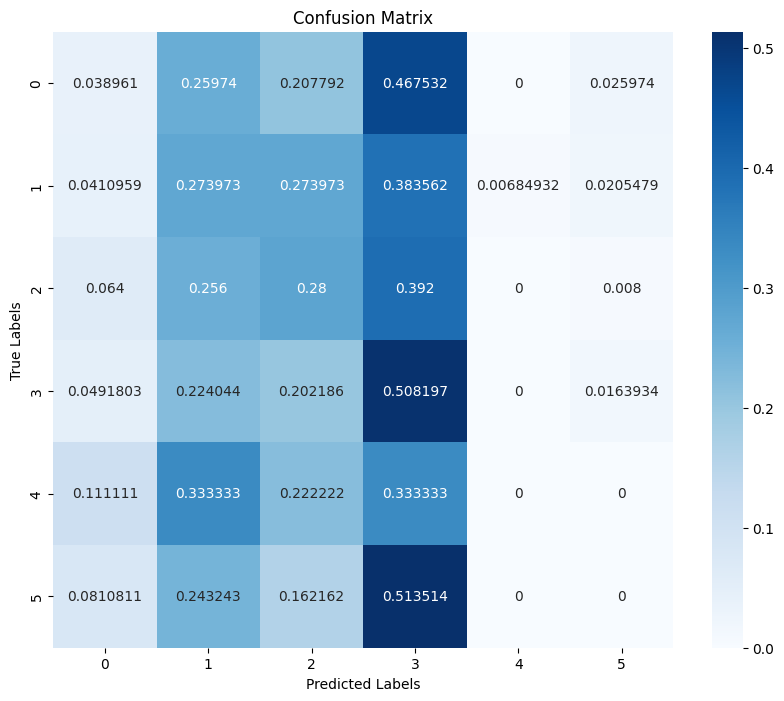

Test Loss: 4.038, Accuracy: 0.296, F1 Score: 0.270, F1 Score Per Class [0.056
Test F1 Score Per Class  [0.05607477 0.27491409 0.26819923 0.42369021 0.         0.        ]


In [4]:
# Call the main function with the path to folder1
imagesRoot = '/kaggle/input/resizedtreedata/ResizedTreeData'

path_to_images = imagesRoot 
train_loader, val_loader, test_loader = load_data(path_to_images)

def load_pretrained_vit(num_labels):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_labels)
    return model

num_classes = 6  # Adjust as per your dataset
num_epochs = 20
# Load the pretrained ResNet-50 model
# model = models.resnet50(pretrained=True)
vit_model = load_pretrained_vit(num_labels=num_classes)

# model.fc = nn.Linear(model.fc.in_features, num_classes)
# Initialize best F1 score for validation

best_val_f1 = 0.0
best_model_weights = None
model_name = 'TreesDelftV001'
trained_model = train_and_evaluate(vit_model, train_loader, val_loader, test_loader, model_name, num_epochs)

Test:   1%|▏         | 1/73 [00:00<00:34,  2.07it/s, loss=5.43]

[tensor([-1.8462,  1.6752, -2.5132,  0.6608, -3.1885, -3.0066], device='cuda:0'), tensor([-2.5360,  0.2047, -1.1652,  1.1100, -6.2829, -4.9142], device='cuda:0'), tensor([ 1.0650,  0.1467, -2.8051,  0.7919, -5.5938, -4.7091], device='cuda:0'), tensor([-4.1027,  1.5006, -0.7932,  2.9991, -4.4514, -4.5198], device='cuda:0'), tensor([-2.8110,  6.4130, -1.7299, -0.1937, -5.0074, -3.9580], device='cuda:0'), tensor([-0.2233, -2.9999,  1.3141,  1.2339, -5.6034, -3.0462], device='cuda:0'), tensor([ 1.3320, -2.8289,  0.4421,  1.0254, -5.2808, -3.3357], device='cuda:0'), tensor([-2.8057,  6.4203, -3.1786, -1.3399, -3.7043, -2.5434], device='cuda:0')]


Test:   3%|▎         | 2/73 [00:00<00:31,  2.29it/s, loss=5.96]

[tensor([-2.5545, -2.3367,  7.4114, -1.1006, -3.0351, -2.7868], device='cuda:0'), tensor([-3.2626,  3.4468, -2.2790, -0.1990, -5.2773, -3.7518], device='cuda:0'), tensor([-2.0544, -3.4043,  5.0301, -0.0550, -4.1701, -3.2259], device='cuda:0'), tensor([-2.3941, -2.6934,  7.6260, -1.3652, -3.3395, -2.6259], device='cuda:0'), tensor([-2.2668, -3.2737,  0.5163, -2.0255, -5.2552, -5.2210], device='cuda:0'), tensor([-2.2928, -1.1120,  6.2773, -1.7448, -5.2698, -3.5368], device='cuda:0'), tensor([-2.7925,  0.0338, -2.3077,  6.8456, -4.4946, -3.8050], device='cuda:0'), tensor([-3.8440,  4.5769, -1.8461,  0.6425, -5.4313, -3.6919], device='cuda:0')]


Test:   4%|▍         | 3/73 [00:01<00:29,  2.36it/s, loss=2.69]

[tensor([-2.7610, -0.2973, -1.2386,  2.9518, -4.5468, -5.0678], device='cuda:0'), tensor([-2.9268,  1.8367, -2.3515,  1.7452, -3.9470, -3.3703], device='cuda:0'), tensor([-2.6047, -3.1878,  3.3988,  2.1555, -4.7145, -3.2018], device='cuda:0'), tensor([-3.7649,  0.8002,  2.8504, -3.1221, -5.0190, -3.4254], device='cuda:0'), tensor([-2.8363, -3.4834,  4.1057,  2.4211, -5.2450, -4.1367], device='cuda:0'), tensor([-0.2644, -2.8879, -2.6565,  3.7899, -4.7405, -2.0696], device='cuda:0'), tensor([-4.5763,  0.5626,  1.6263,  0.7808, -6.2572, -4.0170], device='cuda:0'), tensor([ 1.0707, -1.0305, -3.1186,  1.3875, -5.5384, -0.9949], device='cuda:0')]


Test:   5%|▌         | 4/73 [00:01<00:29,  2.38it/s, loss=1.92]

[tensor([ 2.7106, -3.5201, -1.5437, -1.0973, -1.9011, -4.1154], device='cuda:0'), tensor([-4.7047, -1.4070, -1.2880,  1.8022, -6.3464, -3.1550], device='cuda:0'), tensor([-2.5735, -0.0142, -1.3475,  3.1615, -4.7165, -5.1621], device='cuda:0'), tensor([-1.9831, -3.0296,  3.7795,  0.6522, -5.1154, -4.0770], device='cuda:0'), tensor([-2.5367, -1.6352, -3.3313,  0.0754, -3.5256,  4.6098], device='cuda:0'), tensor([-2.1724,  2.4310, -0.3569, -3.1725, -5.7606, -2.1114], device='cuda:0'), tensor([-3.2082, -2.5828, -0.5402,  4.1659, -5.6535, -4.6078], device='cuda:0'), tensor([-3.1703, -1.8807,  5.2373,  1.1177, -4.9079, -4.3114], device='cuda:0')]


Test:   7%|▋         | 5/73 [00:02<00:28,  2.39it/s, loss=4.45]

[tensor([-2.0209,  5.7304, -2.6224, -3.0019, -4.2168, -2.5469], device='cuda:0'), tensor([-3.5628,  2.0370, -0.4489,  2.7891, -6.8611, -4.8437], device='cuda:0'), tensor([-2.1677,  5.5770, -3.4430, -0.5641, -4.9018, -3.5923], device='cuda:0'), tensor([-3.7673, -2.2598, -1.9086,  6.8471, -4.6161, -3.0410], device='cuda:0'), tensor([-1.9117, -1.1529, -1.5839,  3.8252, -4.9724, -4.3637], device='cuda:0'), tensor([-3.1090, -1.7083,  6.8318, -2.0732, -4.3756, -4.0577], device='cuda:0'), tensor([-3.8220,  0.9960, -0.7892,  0.1990, -3.9450, -4.8223], device='cuda:0'), tensor([-3.0297,  4.0171, -1.5963, -1.0033, -4.5795, -3.6265], device='cuda:0')]


Test:   8%|▊         | 6/73 [00:02<00:27,  2.41it/s, loss=4.27]

[tensor([-1.4952, -2.7963,  7.4064, -1.2499, -3.5229, -3.5252], device='cuda:0'), tensor([-3.1905,  3.6528,  0.0830, -1.5569, -5.0104, -4.1368], device='cuda:0'), tensor([-2.4649,  0.0462, -0.8145,  3.3986, -6.7947, -3.1910], device='cuda:0'), tensor([-2.3237, -1.4861, -0.5024, -0.9842, -2.0251, -4.7773], device='cuda:0'), tensor([-3.5520, -2.0388, -0.8892,  4.2039, -4.4711, -2.7754], device='cuda:0'), tensor([-3.7312, -1.2237, -0.7096,  2.3213, -4.6248, -4.3403], device='cuda:0'), tensor([-0.5470,  0.0724, -1.4089,  2.9329, -3.1829, -3.8463], device='cuda:0'), tensor([-3.6765, -0.6155, -3.2071,  0.5435, -5.5355, -2.2107], device='cuda:0')]


Test:  10%|▉         | 7/73 [00:02<00:27,  2.41it/s, loss=4.56]

[tensor([-3.1033,  2.7047,  4.1553, -3.2203, -4.2043, -3.7167], device='cuda:0'), tensor([-1.8042,  4.7093, -2.3998, -1.5842, -3.1233, -1.5898], device='cuda:0'), tensor([-1.0869,  1.0474, -1.7580, -2.7268,  9.3381, -1.9275], device='cuda:0'), tensor([ 0.8210, -3.2663,  4.6869, -0.3999, -4.8748, -3.4551], device='cuda:0'), tensor([-4.0705,  3.6566, -2.3531,  0.0656, -2.2200, -3.8398], device='cuda:0'), tensor([-3.5823,  3.7603, -2.2062,  0.5850, -4.9101, -4.9634], device='cuda:0'), tensor([-1.4816,  2.4813, -4.3651, -1.0172, -4.2672, -2.2235], device='cuda:0'), tensor([-3.1421,  0.8017, -2.2088,  2.7665, -3.3030, -2.6990], device='cuda:0')]


Test:  11%|█         | 8/73 [00:03<00:26,  2.41it/s, loss=3.63]

[tensor([-2.4380, -2.0287,  7.6825, -1.3971, -3.6482, -2.8234], device='cuda:0'), tensor([-3.2964, -0.5883, -2.9195,  6.8890, -4.6226, -2.6049], device='cuda:0'), tensor([ 1.6349, -2.5089, -1.5318,  3.1151, -5.1960, -4.0615], device='cuda:0'), tensor([ 1.5499, -1.3325, -1.4518, -0.2225, -5.4686, -4.0060], device='cuda:0'), tensor([-3.0069,  0.2109,  5.8398, -2.7462, -4.2498, -2.9588], device='cuda:0'), tensor([-2.1132, -0.5742, -2.1183,  1.6668, -4.3662, -5.5767], device='cuda:0'), tensor([-3.0187, -2.2014,  5.6480, -0.9577, -4.0244, -2.7566], device='cuda:0'), tensor([-2.7961, -3.5443,  0.3454,  5.4034, -4.0273, -3.9545], device='cuda:0')]


Test:  12%|█▏        | 9/73 [00:03<00:26,  2.41it/s, loss=3.89]

[tensor([-3.3946, -1.1269, -2.4948,  3.2331, -5.8644, -1.8326], device='cuda:0'), tensor([-0.4073, -1.9026, -2.3993,  2.0487, -3.8795, -3.2468], device='cuda:0'), tensor([-2.7806,  2.0728,  0.5325, -1.8245, -4.2397, -4.3903], device='cuda:0'), tensor([-3.2458, -2.5187,  2.8148,  1.9753, -5.9260, -4.5318], device='cuda:0'), tensor([-1.9894, -2.1096, -2.2551,  7.0864, -5.0170, -3.4330], device='cuda:0'), tensor([-3.2177, -3.6004,  0.0158,  5.7169, -5.3186, -3.3757], device='cuda:0'), tensor([-2.7871, -1.9090, -2.4363, -1.2672, -5.8520, -2.9003], device='cuda:0'), tensor([-3.6265, -0.8614, -0.0288,  2.1680, -4.9611, -4.2902], device='cuda:0')]


Test:  14%|█▎        | 10/73 [00:04<00:26,  2.41it/s, loss=3.94]

[tensor([-3.9978, -3.6999, -0.6189,  5.1156, -6.0317, -3.2351], device='cuda:0'), tensor([-3.4991,  1.0629, -2.9507,  3.0551, -6.0514, -5.0227], device='cuda:0'), tensor([-2.1038,  1.7525, -3.1198,  2.1037, -5.6374, -5.2487], device='cuda:0'), tensor([-3.2033,  0.4400, -1.0631,  2.9876, -5.6696, -5.0235], device='cuda:0'), tensor([-3.4664, -1.5058,  5.8407, -1.8933, -4.8408, -3.6504], device='cuda:0'), tensor([-3.7617,  4.8634, -1.8290, -0.4982, -5.2332, -3.8418], device='cuda:0'), tensor([-2.7718, -3.2437,  0.8405,  5.9591, -5.5687, -3.9228], device='cuda:0'), tensor([ 4.3951, -3.2546, -1.5468, -0.0581, -4.0095, -2.1851], device='cuda:0')]


Test:  15%|█▌        | 11/73 [00:04<00:25,  2.41it/s, loss=4.65]

[tensor([-3.4990, -3.0402, -1.5144,  5.4645, -4.7852, -2.9217], device='cuda:0'), tensor([-3.2803, -2.4963,  1.0795,  2.6263, -5.1757, -4.1635], device='cuda:0'), tensor([-4.3990,  2.6479, -0.5681,  1.5450, -6.5480, -4.9987], device='cuda:0'), tensor([-2.3031,  1.8517, -3.5410, -1.0302, -2.6167, -2.4860], device='cuda:0'), tensor([-4.6996, -2.1657,  0.3089, -0.7728, -5.0657, -2.8555], device='cuda:0'), tensor([-2.5419, -2.1222, -1.8390,  7.1525, -4.4718, -3.1796], device='cuda:0'), tensor([-3.6118, -1.8542, -0.5977, -1.7930, -5.6174, -3.6227], device='cuda:0'), tensor([-3.9326, -0.1752,  2.5742, -2.2093, -4.4018, -4.6442], device='cuda:0')]


Test:  16%|█▋        | 12/73 [00:05<00:25,  2.41it/s, loss=2.76]

[tensor([-1.5225,  7.1253, -3.1884, -0.8018, -3.8369, -2.9010], device='cuda:0'), tensor([-3.6581,  3.9306, -2.6027, -0.8373, -4.9815, -2.8702], device='cuda:0'), tensor([-3.0008, -2.0502, -0.6267,  4.4722, -4.6089, -4.6664], device='cuda:0'), tensor([-2.1095, -0.1761, -2.5897, -2.4843, -5.2977, -1.1947], device='cuda:0'), tensor([ 4.1295, -2.8455, -1.0234,  1.1564, -5.0733, -4.8484], device='cuda:0'), tensor([-2.7280, -0.6622, -1.2082,  4.4673, -5.4064, -5.5183], device='cuda:0'), tensor([-2.4446, -3.4428,  3.4528, -0.3075, -4.1491, -3.4219], device='cuda:0'), tensor([-3.6160, -1.6592, -2.9792,  7.1608, -3.1812, -1.9192], device='cuda:0')]


Test:  18%|█▊        | 13/73 [00:05<00:24,  2.41it/s, loss=5.99]

[tensor([-3.5761, -0.5939, -2.2901,  6.7655, -3.8043, -3.1784], device='cuda:0'), tensor([-4.2635,  3.3849, -1.7559,  0.8987, -5.2979, -3.4837], device='cuda:0'), tensor([-3.2887, -1.2115,  3.3447, -0.2145, -5.8777, -4.3076], device='cuda:0'), tensor([-3.3271,  3.1114, -2.5919, -1.6639, -3.6988,  0.3704], device='cuda:0'), tensor([-2.0788,  2.5503, -1.9214,  0.2513, -4.8191, -3.1612], device='cuda:0'), tensor([-2.8244,  5.3609, -3.4173,  0.5587, -4.2645, -3.3715], device='cuda:0'), tensor([-3.2039, -2.0800,  3.1872, -0.9157, -4.1677, -4.3018], device='cuda:0'), tensor([-3.3585, -1.2480,  5.6274, -1.5747, -4.0190, -1.6426], device='cuda:0')]


Test:  19%|█▉        | 14/73 [00:05<00:24,  2.40it/s, loss=4.08]

[tensor([-3.5561, -0.6828, -2.4331,  1.4786, -5.2960, -2.8246], device='cuda:0'), tensor([-2.1102, -2.1587,  7.0420, -1.5652, -2.7371, -3.5909], device='cuda:0'), tensor([-2.9868,  5.0689, -1.6323, -0.7536, -4.9256, -4.0096], device='cuda:0'), tensor([-0.5531, -3.9953,  1.2170,  4.8677, -5.2268, -4.4059], device='cuda:0'), tensor([-3.1178, -2.9789,  5.1956, -0.7706, -5.2325, -4.1997], device='cuda:0'), tensor([-1.2721, -2.1748, -0.7379, -1.1621, -6.0299, -4.4890], device='cuda:0'), tensor([-4.4621, -2.4796, -0.8954,  2.2451, -4.3959, -1.1623], device='cuda:0'), tensor([-3.3383, -0.0814, -0.5174, -1.2057, -5.5628, -4.5077], device='cuda:0')]


Test:  21%|██        | 15/73 [00:06<00:24,  2.40it/s, loss=3.39]

[tensor([ 2.9746, -2.3117, -1.6048, -1.2652, -6.1053, -5.2791], device='cuda:0'), tensor([-3.9744, -1.6911, -3.3095,  5.1399, -3.8377, -2.0200], device='cuda:0'), tensor([-3.0100,  4.1541, -3.5303,  2.2912, -4.7769, -2.0751], device='cuda:0'), tensor([-3.3784, -0.1829,  5.2348, -2.3103, -3.9633, -3.8636], device='cuda:0'), tensor([-3.9153, -0.1275, -1.0713,  0.8719, -5.3309, -4.0491], device='cuda:0'), tensor([-1.8506, -3.4082, -2.9426,  2.1889, -4.0721,  1.0759], device='cuda:0'), tensor([-2.0017,  3.3662,  0.7123, -2.8299, -4.8523, -4.1243], device='cuda:0'), tensor([-3.4512, -1.3218, -1.2236,  0.0228, -5.2617, -5.1071], device='cuda:0')]


Test:  22%|██▏       | 16/73 [00:06<00:23,  2.39it/s, loss=4.85]

[tensor([-4.1083, -3.4170,  1.1009,  5.8690, -3.9476, -3.8796], device='cuda:0'), tensor([-2.2361, -0.4304,  7.0119, -2.4129, -3.9989, -3.5634], device='cuda:0'), tensor([-3.8566, -1.2398, -1.4679,  6.9263, -4.6911, -3.3912], device='cuda:0'), tensor([-3.3196, -4.4126, -0.8369,  0.4759, -4.4447, -0.8021], device='cuda:0'), tensor([-4.5895, -2.0716,  0.1061,  2.4976, -5.2683, -2.7467], device='cuda:0'), tensor([-2.2957, -3.0393,  3.3250, -0.6888, -4.5633, -4.5060], device='cuda:0'), tensor([-3.2203, -2.5986,  3.2514,  3.2710, -6.4804, -4.2030], device='cuda:0'), tensor([-3.1743,  6.9894, -2.5747, -0.2677, -3.4443, -3.2090], device='cuda:0')]


Test:  23%|██▎       | 17/73 [00:07<00:23,  2.40it/s, loss=4.62]

[tensor([-4.4801,  0.8777, -0.5369,  2.1158, -5.2445, -5.4196], device='cuda:0'), tensor([-4.2033, -0.8480,  2.2107,  0.3772, -5.2999, -3.8895], device='cuda:0'), tensor([-3.0604, -0.3838, -3.6758,  2.7200, -4.3386, -0.9703], device='cuda:0'), tensor([ 1.5168, -2.0216,  2.5024, -1.4941, -4.9543, -4.4666], device='cuda:0'), tensor([-2.7247, -0.9007,  5.4070,  0.2144, -4.7283, -5.2669], device='cuda:0'), tensor([-4.2255, -2.2588, -1.8596,  1.9045, -5.1770, -3.1978], device='cuda:0'), tensor([-3.0418, -2.9161, -1.6936, -0.1101, -4.2543,  0.0798], device='cuda:0'), tensor([-3.3642,  1.9954, -1.5873,  1.1562, -5.4908, -4.4368], device='cuda:0')]


Test:  25%|██▍       | 18/73 [00:07<00:22,  2.41it/s, loss=2.54]

[tensor([-1.1860,  3.9346, -1.8702,  0.8773, -4.0171, -4.9354], device='cuda:0'), tensor([-3.8028, -0.5582, -0.7143, -0.5605, -3.7058,  0.6876], device='cuda:0'), tensor([-2.8654, -2.8128,  4.1289,  2.4057, -4.6973, -3.9820], device='cuda:0'), tensor([-1.0406, -1.5230, -1.1287,  2.7334, -3.6052, -3.8971], device='cuda:0'), tensor([-3.0132, -1.0891, -2.1462,  7.4029, -3.6255, -3.5358], device='cuda:0'), tensor([-3.1755, -1.2564, -2.7029, -0.5902, -4.6830, -3.3938], device='cuda:0'), tensor([-1.7530,  0.2345, -2.8698,  3.0396, -4.4127, -4.1382], device='cuda:0'), tensor([-2.9461,  1.2188, -2.1917,  2.1603, -5.6669, -4.9480], device='cuda:0')]


Test:  26%|██▌       | 19/73 [00:07<00:22,  2.40it/s, loss=3.47]

[tensor([-1.1427,  4.9785, -3.0538, -0.3582, -5.0365, -2.7978], device='cuda:0'), tensor([-1.1915,  5.6963, -2.9639, -2.3039, -3.4740, -2.4420], device='cuda:0'), tensor([ 0.6162, -3.7830, -1.9150,  1.5852, -3.1531, -1.8480], device='cuda:0'), tensor([-1.4168, -1.3110, -2.6317,  1.5434, -6.5245, -4.8736], device='cuda:0'), tensor([-2.6403, -3.4964,  1.6902,  4.1012, -5.2378, -4.6875], device='cuda:0'), tensor([-2.5670, -0.7655, -2.3925,  3.7077, -4.9209, -3.5316], device='cuda:0'), tensor([-3.1557, -0.7520, -1.7886,  4.7308, -5.2932, -4.3517], device='cuda:0'), tensor([-3.4045, -2.7787, -1.2041,  4.8439, -5.4765, -2.5655], device='cuda:0')]


Test:  27%|██▋       | 20/73 [00:08<00:22,  2.40it/s, loss=3.42]

[tensor([-3.6651, -2.0095, -0.8083, -0.8263, -5.1673, -4.6454], device='cuda:0'), tensor([ 5.3758, -3.4272, -1.6348,  0.3037, -3.9567, -2.3722], device='cuda:0'), tensor([-2.9586, -2.0843, -1.6510,  6.9457, -4.3193, -2.6961], device='cuda:0'), tensor([-3.4174,  4.0114, -2.6366,  0.3644, -5.0009, -4.8456], device='cuda:0'), tensor([-4.1265, -0.4135, -1.0310,  1.9422, -4.9467, -4.2648], device='cuda:0'), tensor([-2.9481, -1.5242,  3.2047, -0.5822, -4.5556, -3.3129], device='cuda:0'), tensor([-2.7248,  0.5026, -2.0595,  2.7202, -4.9607, -4.9216], device='cuda:0'), tensor([-3.5363, -2.2235, -2.4909,  4.4445, -4.9070, -3.0070], device='cuda:0')]


Test:  29%|██▉       | 21/73 [00:08<00:21,  2.40it/s, loss=5.03]

[tensor([-2.8903, -2.0472, -1.4282,  6.8854, -4.4692, -4.0243], device='cuda:0'), tensor([-2.3846,  4.2191, -2.4798, -2.9180, -5.6154, -2.3201], device='cuda:0'), tensor([-2.7108, -2.7792,  1.8163,  1.3268, -6.4996, -3.6012], device='cuda:0'), tensor([-3.0987,  3.4033, -2.2726,  1.3399, -5.9299, -3.0921], device='cuda:0'), tensor([-3.0157,  1.4580, -1.4856,  2.4519, -4.2957, -4.9376], device='cuda:0'), tensor([-1.7932, -1.6322, -3.0267,  2.8622, -3.5140, -3.4014], device='cuda:0'), tensor([-3.9196, -0.8498,  4.6915, -1.1683, -3.6470, -4.0641], device='cuda:0'), tensor([-3.7856, -1.5969, -2.3387,  0.9446, -5.0438, -4.6120], device='cuda:0')]


Test:  30%|███       | 22/73 [00:09<00:21,  2.40it/s, loss=3.49]

[tensor([-2.6742, -3.9640,  1.0073,  0.2249, -4.1652, -3.5310], device='cuda:0'), tensor([-2.5517, -2.6626, -2.2617,  7.1736, -4.1648, -2.5155], device='cuda:0'), tensor([-3.3593,  0.0090, -1.4666,  0.1874, -4.5139, -4.9835], device='cuda:0'), tensor([-1.3823, -1.2102, -2.4673,  6.9351, -4.8386, -4.7788], device='cuda:0'), tensor([-3.1978, -2.6898,  1.2836, -0.0056, -4.7240, -3.0779], device='cuda:0'), tensor([-4.5666, -0.5196,  1.4266,  0.8276, -5.4161, -5.6635], device='cuda:0'), tensor([-2.7529,  7.2193, -1.3493, -1.7486, -3.5091, -2.9466], device='cuda:0'), tensor([-2.5794,  1.7204, -2.6278,  1.1025, -5.5360, -3.0746], device='cuda:0')]


Test:  32%|███▏      | 23/73 [00:09<00:20,  2.39it/s, loss=5.49]

[tensor([-2.9336,  2.9579,  0.5330, -3.2848, -4.3517, -3.3717], device='cuda:0'), tensor([-2.0146, -2.6032,  0.0896,  6.0189, -5.3138, -4.7032], device='cuda:0'), tensor([-2.5006, -1.5915,  6.9373, -0.9809, -3.5535, -3.8764], device='cuda:0'), tensor([-4.2672,  1.9025,  2.6682,  0.6737, -5.1639, -4.4092], device='cuda:0'), tensor([-1.9097, -2.6804,  6.9566, -0.9665, -4.1864, -3.6777], device='cuda:0'), tensor([-4.6831, -1.9122,  3.5349, -1.5712, -4.7548, -3.5576], device='cuda:0'), tensor([-2.0359e+00, -1.0680e-03,  3.4631e+00, -2.1192e+00, -5.4432e+00,
        -5.3891e+00], device='cuda:0'), tensor([-0.2359,  4.7596, -2.3888, -1.5267, -4.5423, -4.2975], device='cuda:0')]


Test:  33%|███▎      | 24/73 [00:10<00:20,  2.37it/s, loss=6.48]

[tensor([-3.5566, -2.5156,  0.1790,  5.7866, -5.8640, -4.0409], device='cuda:0'), tensor([-2.3362,  5.7734, -1.9932, -0.6918, -4.2145, -4.6164], device='cuda:0'), tensor([-2.7944,  6.7285, -2.0656, -1.6555, -3.8567, -2.3222], device='cuda:0'), tensor([-3.0495,  7.4729, -1.8724, -2.1877, -3.8812, -2.0698], device='cuda:0'), tensor([-4.4937e+00,  1.8118e-01,  1.8141e+00,  4.7610e-03, -5.3649e+00,
        -5.1536e+00], device='cuda:0'), tensor([-3.4218,  2.7466, -0.7443, -0.3540, -5.4638, -4.7749], device='cuda:0'), tensor([-2.5098,  5.1450, -2.5970, -1.5074, -3.0767, -1.8793], device='cuda:0'), tensor([-2.6465, -1.8608,  6.5946, -2.4861, -4.0497, -4.0969], device='cuda:0')]


Test:  34%|███▍      | 25/73 [00:10<00:20,  2.38it/s, loss=4.71]

[tensor([-2.2926, -0.2283, -2.4530,  2.5451, -3.7533, -3.9271], device='cuda:0'), tensor([-2.7809e+00, -9.1986e-01,  8.7241e-04, -1.6094e+00, -5.9287e+00,
        -4.7485e+00], device='cuda:0'), tensor([-2.0061, -0.2878,  1.1262, -1.8171, -4.7773, -4.2291], device='cuda:0'), tensor([-2.7402, -2.7213,  6.3702, -1.4120, -5.3042, -1.4872], device='cuda:0'), tensor([-4.1437, -1.4556,  4.7439, -1.6797, -4.6597, -3.7021], device='cuda:0'), tensor([-3.8690, -0.5351, -1.0595,  0.0503, -4.3208, -4.8138], device='cuda:0'), tensor([-3.6975, -3.3402,  1.4304,  5.7491, -4.9805, -3.8825], device='cuda:0'), tensor([-4.1955,  4.1389, -1.4641,  1.8244, -4.7689, -3.9499], device='cuda:0')]


Test:  36%|███▌      | 26/73 [00:10<00:19,  2.37it/s, loss=4.96]

[tensor([-3.1088, -1.5478, -1.9539,  4.0028, -3.2941, -3.6255], device='cuda:0'), tensor([-4.5788,  4.4929, -2.5103, -0.4607, -3.8743, -0.7721], device='cuda:0'), tensor([-2.9946, -0.3762, -1.6000, -0.9569, -5.2419, -4.3803], device='cuda:0'), tensor([-2.4380, -3.4575,  2.6712, -0.2908, -5.3728, -5.8872], device='cuda:0'), tensor([-2.8530,  5.2415, -3.0761,  1.2933, -4.3926, -2.0906], device='cuda:0'), tensor([ 5.0048, -0.4584,  0.2851, -2.6411, -3.6935, -4.0922], device='cuda:0'), tensor([-0.4994, -2.8876,  5.3406, -1.1229, -4.5558, -3.4421], device='cuda:0'), tensor([-3.1880, -1.1515,  7.1703, -0.7463, -4.5597, -3.7878], device='cuda:0')]


Test:  37%|███▋      | 27/73 [00:11<00:19,  2.37it/s, loss=2.8]

[tensor([-2.8400, -1.4505, -1.1643, -0.7988, -6.4886, -4.0760], device='cuda:0'), tensor([-4.8914, -1.6508, -0.8114,  3.4935, -3.7806, -5.0251], device='cuda:0'), tensor([ 1.1682, -1.6977,  0.4505, -1.2353, -4.4032, -4.8814], device='cuda:0'), tensor([ 1.6744, -0.6675,  0.9101, -1.0057, -6.2984, -4.0670], device='cuda:0'), tensor([-3.0948,  0.4344, -2.2769,  1.6967, -4.9588, -4.7802], device='cuda:0'), tensor([-0.8893,  0.5373, -3.7842,  3.0810, -5.7322, -3.4357], device='cuda:0'), tensor([-0.4691, -2.0584, -0.8986,  4.8655, -5.8996, -4.7840], device='cuda:0'), tensor([-0.5463, -2.7489,  4.1293,  0.7325, -5.6447, -5.0164], device='cuda:0')]


Test:  38%|███▊      | 28/73 [00:11<00:18,  2.37it/s, loss=4.16]

[tensor([-1.9233, -0.5554, -2.5397, -0.1743, -4.1992, -0.6550], device='cuda:0'), tensor([-2.8621, -3.0497, -0.2822,  6.4911, -4.4379, -3.9423], device='cuda:0'), tensor([-4.0098, -2.7674,  6.2636, -1.5536, -4.2322, -2.2568], device='cuda:0'), tensor([-0.5132, -1.7228, -3.8919,  0.0576, -5.8463, -0.7592], device='cuda:0'), tensor([-2.8352,  5.3966, -3.7001,  1.0997, -4.6562, -2.2140], device='cuda:0'), tensor([-3.0828, -0.1617,  5.7446, -1.0722, -4.6859, -3.2282], device='cuda:0'), tensor([-3.8010, -2.2567, -1.0025,  4.6385, -4.3867, -4.6403], device='cuda:0'), tensor([-2.1404, -2.3435, -0.6156,  3.8754, -5.0633, -4.4555], device='cuda:0')]


Test:  40%|███▉      | 29/73 [00:12<00:18,  2.38it/s, loss=4.24]

[tensor([-2.3859, -2.7589,  0.2683,  5.1442, -5.3539, -3.9030], device='cuda:0'), tensor([-3.1459,  0.0699, -3.8907,  2.2867, -4.5327, -3.3022], device='cuda:0'), tensor([-1.0310,  4.6005, -0.1964, -3.5351, -3.4301, -3.0329], device='cuda:0'), tensor([-2.9758,  0.0759, -2.7300,  6.8766, -3.3387, -3.6948], device='cuda:0'), tensor([-3.0119, -2.1677,  5.9245, -0.7573, -4.4694, -3.6079], device='cuda:0'), tensor([-2.5506, -2.8284, -1.0609,  6.5541, -4.0437, -3.8160], device='cuda:0'), tensor([-3.2242,  7.1934, -2.3989, -0.7367, -3.0746, -3.4425], device='cuda:0'), tensor([-2.2582, -0.4890, -1.4331, -1.2774, -5.7805, -4.6292], device='cuda:0')]


Test:  41%|████      | 30/73 [00:12<00:18,  2.38it/s, loss=4.71]

[tensor([-3.3134,  0.9190, -2.1385, -0.4772, -5.5424, -3.5264], device='cuda:0'), tensor([-4.1611,  1.7760, -1.7187, -1.5921, -3.4240, -3.3727], device='cuda:0'), tensor([-2.5921, -1.3905, -2.3705,  3.2016, -4.7983, -4.3362], device='cuda:0'), tensor([ 1.3540, -3.7191,  3.6182, -1.8115, -4.2963, -3.2541], device='cuda:0'), tensor([-4.4818,  0.7521, -0.6687,  2.1731, -3.8536, -2.9956], device='cuda:0'), tensor([-4.2170,  5.3648,  0.0147, -0.3144, -4.8775, -4.6394], device='cuda:0'), tensor([-2.7377, -1.8967,  4.3700,  1.3491, -5.7546, -4.4984], device='cuda:0'), tensor([-3.0122, -1.2825, -0.2684,  0.1893, -6.6981, -2.4071], device='cuda:0')]


Test:  42%|████▏     | 31/73 [00:13<00:17,  2.37it/s, loss=3.86]

[tensor([ 0.5106,  0.8595, -3.4715,  0.8178, -4.7739, -3.3671], device='cuda:0'), tensor([-0.3783, -1.6431, -3.7157,  2.2757, -6.1221, -3.6193], device='cuda:0'), tensor([-3.6304,  4.3687, -2.6228,  0.2706, -4.0655, -3.3014], device='cuda:0'), tensor([-2.0611, -0.9864,  6.8289, -2.0381, -4.2525, -2.7735], device='cuda:0'), tensor([-2.2953, -2.1636, -1.3822,  6.4496, -4.9877, -3.7631], device='cuda:0'), tensor([-2.8082, -2.2648, -1.5603,  7.3284, -4.0590, -3.4040], device='cuda:0'), tensor([-3.3372, -2.0165, -0.9450, -0.6706, -5.5493, -5.0075], device='cuda:0'), tensor([ 0.7586, -1.7430,  0.9063,  1.0374, -6.2756, -4.2552], device='cuda:0')]


Test:  44%|████▍     | 32/73 [00:13<00:17,  2.37it/s, loss=3.44]

[tensor([-2.0064, -2.3559, -0.5296,  2.0624, -5.1766, -4.3756], device='cuda:0'), tensor([-2.9612, -1.2314, -2.5389,  7.0282, -5.5095, -3.0108], device='cuda:0'), tensor([-0.6416, -2.6905, -1.7808,  5.2659, -4.7366, -3.9485], device='cuda:0'), tensor([-5.0676, -1.8572, -0.1649,  4.0141, -4.3368, -2.8764], device='cuda:0'), tensor([-2.8174,  2.0994,  1.2254, -3.3275, -4.5907, -2.4062], device='cuda:0'), tensor([-2.4979, -2.3125, -1.2683,  1.0171, -6.0769, -3.2389], device='cuda:0'), tensor([-2.5817, -1.4690,  2.5082, -0.0410, -6.7673, -5.8893], device='cuda:0'), tensor([-4.3015, -1.0347, -0.4289,  2.3699, -6.0833, -4.2581], device='cuda:0')]


Test:  45%|████▌     | 33/73 [00:13<00:16,  2.37it/s, loss=2.76]

[tensor([-0.1171, -0.3535, -0.1165, -0.7256, -5.1544, -4.9308], device='cuda:0'), tensor([-2.3277,  3.3329, -2.2776, -1.3657, -5.4261, -5.2562], device='cuda:0'), tensor([-3.0936, -3.0108, -0.2518,  0.7552, -6.0537, -4.7144], device='cuda:0'), tensor([-2.9398, -1.8307,  1.8793,  3.8192, -5.4373, -5.5316], device='cuda:0'), tensor([-2.3586, -2.8876, -0.2232,  2.1197, -4.2702, -2.5705], device='cuda:0'), tensor([-2.6733, -2.2315, -2.8571,  6.2135, -3.9959, -2.9838], device='cuda:0'), tensor([ 2.6886,  0.1682, -3.6708, -1.0792, -4.3589, -2.5274], device='cuda:0'), tensor([-2.9292,  1.7493, -1.1118,  1.4225, -6.3243, -5.0889], device='cuda:0')]


Test:  47%|████▋     | 34/73 [00:14<00:16,  2.37it/s, loss=3.68]

[tensor([-3.9701, -0.9567,  0.3528,  5.8135, -4.3994, -5.5479], device='cuda:0'), tensor([-2.9200,  0.8382, -1.5122, -0.8196, -6.2983, -4.7797], device='cuda:0'), tensor([-2.2785, -3.1806, -1.9653,  2.3631, -6.1682, -2.8204], device='cuda:0'), tensor([-1.7236, -0.0820, -3.1081,  4.0622, -4.7631, -3.8708], device='cuda:0'), tensor([-2.1141,  4.1741, -0.3821, -2.1744, -3.1586, -3.4791], device='cuda:0'), tensor([-3.3561,  3.2168, -2.8991,  0.8699, -2.3153, -4.0148], device='cuda:0'), tensor([-1.3685, -0.7092, -2.3265,  5.0133, -5.1014, -4.2257], device='cuda:0'), tensor([-2.3910, -0.4882, -2.0210, -2.7620, -5.7699, -5.2022], device='cuda:0')]


Test:  48%|████▊     | 35/73 [00:14<00:16,  2.37it/s, loss=3.95]

[tensor([ 2.6477, -3.2333, -0.5217,  2.2257, -5.4475, -4.2675], device='cuda:0'), tensor([-2.1614, -1.7404, -2.2555,  6.6155, -4.9715, -4.1162], device='cuda:0'), tensor([-2.9916, -3.4765,  1.9404,  2.0126, -5.7201, -3.7884], device='cuda:0'), tensor([-2.6598, -3.4032, -0.7644,  6.7992, -4.2582, -3.0300], device='cuda:0'), tensor([-4.1525, -3.0643,  1.2219,  5.5475, -4.7572, -3.5500], device='cuda:0'), tensor([-2.6806, -1.6638,  5.3845, -2.6287, -3.5780, -4.7837], device='cuda:0'), tensor([-4.5633,  1.6112, -1.9254, -1.3094, -3.7822, -3.4177], device='cuda:0'), tensor([-1.5892, -2.9866,  2.9743,  1.7686, -5.5670, -5.3584], device='cuda:0')]


Test:  49%|████▉     | 36/73 [00:15<00:15,  2.37it/s, loss=4.02]

[tensor([-0.9775, -2.8845,  7.1511, -1.7885, -4.3856, -3.2555], device='cuda:0'), tensor([-1.5203, -2.6001, -1.6990,  5.9489, -5.8475, -3.0221], device='cuda:0'), tensor([-0.8941, -2.8697, -0.7458,  3.6359, -5.0811, -3.8798], device='cuda:0'), tensor([-2.2273, -1.9010,  7.6259, -1.8501, -2.7944, -2.1791], device='cuda:0'), tensor([-4.6935, -0.4605,  1.2220,  0.4897, -4.9996, -4.1900], device='cuda:0'), tensor([ 7.1694, -0.4704, -3.5060, -0.9562, -3.1243, -2.4934], device='cuda:0'), tensor([-5.1500,  0.1851,  3.3245,  2.2981, -4.7240, -2.9767], device='cuda:0'), tensor([-2.7085, -1.5260,  0.9490,  1.3685, -5.3571, -5.1512], device='cuda:0')]


Test:  51%|█████     | 37/73 [00:15<00:15,  2.37it/s, loss=6.38]

[tensor([ 4.5983, -0.0645, -2.0968, -0.2533, -4.9507, -5.1364], device='cuda:0'), tensor([-4.4371,  0.0788,  3.4050, -0.9499, -5.6060, -4.0871], device='cuda:0'), tensor([-2.4034, -1.9407, -2.9193,  6.1694, -5.1177, -1.0758], device='cuda:0'), tensor([-1.7750, -3.2059, -2.1936,  0.4871, -4.0423, -3.2184], device='cuda:0'), tensor([-1.6720, -2.4517,  7.6791, -1.0081, -3.7863, -3.2926], device='cuda:0'), tensor([-2.4952,  7.4089, -2.4143, -1.1647, -4.0131, -3.2380], device='cuda:0'), tensor([-3.4893,  0.2016, -3.7499,  2.2279, -4.3698, -3.6433], device='cuda:0'), tensor([-1.7951, -3.1934, -1.0625,  5.7402, -5.4276, -3.8533], device='cuda:0')]


Test:  52%|█████▏    | 38/73 [00:15<00:14,  2.37it/s, loss=4.18]

[tensor([-2.7817, -3.3348,  2.5242, -0.6988, -5.0436, -4.0366], device='cuda:0'), tensor([-0.2666,  0.4477, -2.3871, -1.3595, -4.5467, -3.7005], device='cuda:0'), tensor([-2.3089, -2.5390, -1.4016,  0.1782, -6.1087, -2.1160], device='cuda:0'), tensor([-2.9554,  1.0480, -2.3300,  1.2563, -5.5203, -4.1583], device='cuda:0'), tensor([-1.2232, -3.0425, -2.0821,  0.7207, -5.1520,  4.5867], device='cuda:0'), tensor([-2.6433,  0.8678, -1.1921,  2.0414, -5.8043, -4.8172], device='cuda:0'), tensor([-2.0035,  6.9557, -2.7154, -0.8914, -3.9231, -2.8565], device='cuda:0'), tensor([-3.9964, -0.0456, -0.1063, -1.1151, -5.0183, -4.6393], device='cuda:0')]


Test:  53%|█████▎    | 39/73 [00:16<00:14,  2.37it/s, loss=1.81]

[tensor([-2.3386,  7.2250, -2.4890, -1.1897, -4.1398, -3.2672], device='cuda:0'), tensor([-3.5422, -1.4838, -3.5209,  5.5984, -4.2337, -2.8489], device='cuda:0'), tensor([-1.3642, -3.1338, -2.3308,  2.4883, -4.4739, -1.5569], device='cuda:0'), tensor([-3.5672, -1.1780, -2.7953, -0.0892, -4.5515, -3.6627], device='cuda:0'), tensor([-3.7003,  3.6003, -2.6394, -1.9600, -2.2997, -0.9597], device='cuda:0'), tensor([-3.4394, -2.0350, -1.6296,  6.7392, -4.5516, -3.4311], device='cuda:0'), tensor([-1.2377, -3.0338, -0.1480,  5.9578, -5.3643, -4.2849], device='cuda:0'), tensor([-3.5226, -0.3397, -2.9112,  4.0219, -5.9707, -1.9123], device='cuda:0')]


Test:  55%|█████▍    | 40/73 [00:16<00:13,  2.37it/s, loss=3.74]

[tensor([-3.4053,  5.1267, -0.7542, -1.6125, -4.8177, -3.9940], device='cuda:0'), tensor([-2.3600, -2.6622,  0.9399,  1.0605, -3.3643, -4.9063], device='cuda:0'), tensor([-4.1941, -2.4453, -1.1130,  1.9196, -5.8676, -3.9994], device='cuda:0'), tensor([-1.6048, -2.5743, -2.9905,  6.7628, -3.9425, -3.7301], device='cuda:0'), tensor([-3.7126, -1.3426,  6.1178, -0.9808, -4.4015, -3.8076], device='cuda:0'), tensor([-3.5412, -1.0673,  2.5596,  1.1278, -6.1618, -4.5119], device='cuda:0'), tensor([-3.0231, -2.7612, -2.3599,  4.8866, -5.4570, -4.1639], device='cuda:0'), tensor([-4.6547,  1.6886,  2.0137, -0.3027, -5.2655, -4.1102], device='cuda:0')]


Test:  56%|█████▌    | 41/73 [00:17<00:13,  2.36it/s, loss=3.89]

[tensor([-3.0894,  0.6203, -2.4253,  4.4563, -4.7359, -4.2541], device='cuda:0'), tensor([-1.8855, -3.9895, -0.2889, -1.2880, -5.8130, -3.3015], device='cuda:0'), tensor([-1.1936, -1.9241,  7.5233, -1.8461, -3.4487, -3.2335], device='cuda:0'), tensor([-3.2923, -2.2395,  7.0489, -1.2208, -4.1646, -2.9695], device='cuda:0'), tensor([-3.3478, -0.4991, -2.1399,  5.9670, -4.6352, -4.5841], device='cuda:0'), tensor([-3.1561, -2.8079, -1.0461,  4.3895, -5.0410, -2.2567], device='cuda:0'), tensor([-3.4159,  1.4467, -0.9604,  1.3078, -5.3480, -3.8661], device='cuda:0'), tensor([-3.2745,  0.0217, -0.0125,  0.8486, -6.8630, -5.3757], device='cuda:0')]


Test:  58%|█████▊    | 42/73 [00:17<00:13,  2.36it/s, loss=3.06]

[tensor([-3.2962,  2.4700, -2.9002,  0.0735, -4.9401, -3.4016], device='cuda:0'), tensor([-2.7865,  0.4179, -1.2832,  1.0601, -4.1037, -4.6184], device='cuda:0'), tensor([-2.1198,  0.3661, -0.0487, -0.4244, -5.8903, -6.2544], device='cuda:0'), tensor([-3.4111, -0.2413,  1.7524, -0.8776, -5.9419, -3.8097], device='cuda:0'), tensor([-1.0404, -3.7545, -1.6682,  2.8706, -4.2872,  0.5570], device='cuda:0'), tensor([-4.1681, -0.8773, -1.1257,  1.5526, -6.3308, -3.2810], device='cuda:0'), tensor([-3.0810,  1.8812, -3.1639,  1.3587, -4.2363, -4.6955], device='cuda:0'), tensor([-0.4715, -1.1929, -1.4299,  3.7363, -5.8872, -3.9620], device='cuda:0')]


Test:  59%|█████▉    | 43/73 [00:18<00:12,  2.36it/s, loss=2.44]

[tensor([-1.7977,  1.0186, -1.8871, -2.8911, -5.1487, -3.6566], device='cuda:0'), tensor([-1.8398, -2.3567, -1.3385,  5.6097, -5.2487, -4.0939], device='cuda:0'), tensor([-1.8000,  2.2894, -1.8418, -2.0054, -5.6939, -4.9988], device='cuda:0'), tensor([-2.6547,  3.4907, -1.7739,  1.2037, -5.3038, -4.3208], device='cuda:0'), tensor([-3.6155,  5.2967, -3.1373,  0.4376, -4.2207, -2.7474], device='cuda:0'), tensor([-1.2689, -3.2692, -2.7548,  3.3062, -6.3525, -4.6101], device='cuda:0'), tensor([-3.6808,  1.2660, -1.8379,  2.9693, -4.4965, -4.6668], device='cuda:0'), tensor([-2.5440, -0.8867, -1.6521,  4.1040, -6.0198, -3.8144], device='cuda:0')]


Test:  60%|██████    | 44/73 [00:18<00:12,  2.35it/s, loss=2.22]

[tensor([-2.2583, -0.9566,  0.3048,  1.4829, -6.7712, -4.3360], device='cuda:0'), tensor([-2.4188, -2.1641,  3.3879, -1.6335, -4.1733, -2.0785], device='cuda:0'), tensor([-3.7281, -0.3044, -2.5122, -0.0574, -4.8954, -4.6739], device='cuda:0'), tensor([-4.2234, -2.1990, -2.0828,  4.6982, -3.3069,  0.1588], device='cuda:0'), tensor([ 0.1798, -2.7023, -1.1177,  1.9121, -5.3437, -2.7933], device='cuda:0'), tensor([-0.9018,  1.4951, -2.3312, -2.2129, -3.7752, -4.0740], device='cuda:0'), tensor([ 0.1280, -2.3398, -0.7711,  1.9594, -5.9683, -4.1619], device='cuda:0'), tensor([-3.3598, -1.3080, -0.9055,  2.3635, -6.5761, -4.7999], device='cuda:0')]


Test:  62%|██████▏   | 45/73 [00:18<00:11,  2.36it/s, loss=3.48]

[tensor([-3.1188,  0.2576, -2.5321, -2.2876, -5.1358, -3.7622], device='cuda:0'), tensor([-3.9020, -0.7290,  0.8053,  0.8679, -5.1628, -4.2410], device='cuda:0'), tensor([-3.3574,  2.9734, -2.4077, -0.4547, -5.3112, -3.7025], device='cuda:0'), tensor([-3.3852, -3.6451, -2.2398,  5.2252, -4.6840, -2.8565], device='cuda:0'), tensor([-3.6666, -0.5108,  0.1825,  0.6635, -4.4009, -4.5391], device='cuda:0'), tensor([-2.5735, -2.1113,  6.3699, -1.9149, -4.2538, -3.9715], device='cuda:0'), tensor([-3.2219,  3.6940, -2.5603,  0.9657, -5.7111, -4.8405], device='cuda:0'), tensor([-2.6637, -2.4091,  6.6233, -1.0767, -4.3801, -3.8142], device='cuda:0')]


Test:  63%|██████▎   | 46/73 [00:19<00:11,  2.34it/s, loss=4.84]

[tensor([-4.5252, -3.4134, -1.7952,  2.8430, -5.3258, -2.8499], device='cuda:0'), tensor([-3.7321, -2.4455, -0.5936,  5.1329, -4.9413, -2.4084], device='cuda:0'), tensor([-0.4390, -2.5389,  0.2189, -0.7439, -5.8819, -4.3443], device='cuda:0'), tensor([-0.2870, -1.2322, -2.0951, -0.3594, -5.5339, -4.4739], device='cuda:0'), tensor([-0.9093, -2.5999,  2.1356,  0.4955, -5.5598, -4.6070], device='cuda:0'), tensor([-3.2961, -2.4250,  3.1004,  1.0565, -4.9058, -4.3728], device='cuda:0'), tensor([-3.2139, -1.1520, -3.3921,  4.4750, -4.7212, -3.8939], device='cuda:0'), tensor([-1.3297, -1.3395, -1.7218, -1.4543, -2.1731,  9.6714], device='cuda:0')]


Test:  64%|██████▍   | 47/73 [00:19<00:11,  2.35it/s, loss=2.17]

[tensor([-3.6586, -1.6657, -2.8713,  5.6762, -5.6226, -3.5476], device='cuda:0'), tensor([-2.9475, -2.5639, -0.6694,  2.0602, -5.0737, -4.0094], device='cuda:0'), tensor([ 4.4916, -2.7397, -1.0066,  0.7528, -4.4517, -5.2864], device='cuda:0'), tensor([-2.8825, -2.3132,  0.9510,  1.9751, -5.8707, -5.2399], device='cuda:0'), tensor([-3.0077, -3.1158,  0.9656,  1.7714, -4.1857, -3.6651], device='cuda:0'), tensor([-4.6749,  0.2035,  1.2325, -2.1010, -5.2684, -5.3067], device='cuda:0'), tensor([-2.8926, -0.8946,  3.1443, -2.2077, -4.6768, -1.3017], device='cuda:0'), tensor([-2.7833,  2.1160, -2.4592,  3.6886, -3.7442, -4.1774], device='cuda:0')]


Test:  66%|██████▌   | 48/73 [00:20<00:10,  2.32it/s, loss=1.67]

[tensor([ 1.1979, -0.1749, -3.8486, -0.3960, -3.7397, -2.3536], device='cuda:0'), tensor([-3.6134, -2.8424, -2.1279,  3.9412, -4.3410, -4.6911], device='cuda:0'), tensor([-3.9561,  4.9376, -2.9725, -1.1416, -4.3337, -2.7984], device='cuda:0'), tensor([-2.7135, -0.3288,  3.1274,  1.1377, -5.9523, -5.6123], device='cuda:0'), tensor([ 1.5204, -3.0920, -0.4563, -0.1036, -6.1633, -4.0101], device='cuda:0'), tensor([-3.4205,  4.3383,  1.3690, -0.8231, -4.8081, -4.8815], device='cuda:0'), tensor([-1.9880, -1.6140,  7.4046, -2.2025, -3.8304, -2.6670], device='cuda:0'), tensor([-2.7898, -1.7392, -0.9617,  1.2723, -6.6365, -4.3511], device='cuda:0')]


Test:  67%|██████▋   | 49/73 [00:20<00:10,  2.32it/s, loss=2.98]

[tensor([-2.5369, -1.6685,  0.1003, -0.3664, -4.8929, -3.7762], device='cuda:0'), tensor([-3.3469, -2.0521, -2.7358,  2.4685, -5.8897, -1.6304], device='cuda:0'), tensor([-3.0144, -3.8781, -1.0553,  5.8361, -2.3537, -2.5246], device='cuda:0'), tensor([-3.0604,  5.7819, -2.9813, -0.3025, -3.5139, -3.5011], device='cuda:0'), tensor([-4.4748, -0.4058, -0.9495,  0.5879, -5.2632, -3.9402], device='cuda:0'), tensor([-2.4423,  6.7696, -3.0905, -1.0342, -4.5256, -1.3528], device='cuda:0'), tensor([-3.2990,  5.1794, -1.1672, -1.3675, -5.2581, -3.9200], device='cuda:0'), tensor([-2.8327, -1.9547, -2.0056,  7.3618, -4.0462, -2.6641], device='cuda:0')]


Test:  68%|██████▊   | 50/73 [00:21<00:09,  2.34it/s, loss=4.16]

[tensor([-3.8198, -1.0028, -1.6585,  5.0475, -4.7480, -2.4333], device='cuda:0'), tensor([-2.0953, -1.6612, -1.1744, -1.0753, -4.8794, -3.9739], device='cuda:0'), tensor([ 6.3077, -2.8565,  0.2617, -1.0981, -4.2930, -2.5424], device='cuda:0'), tensor([ 0.2893,  1.6931, -0.4508, -1.2969, -4.4295, -4.6326], device='cuda:0'), tensor([-3.7883, -0.0096, -0.4486, -0.9962, -6.4589, -3.8845], device='cuda:0'), tensor([-4.4007, -0.2607,  0.2550,  4.8478, -5.6298, -4.8598], device='cuda:0'), tensor([-0.8534, -1.2453,  0.5198,  1.9758, -6.6271, -4.9760], device='cuda:0'), tensor([-1.5926,  0.0309,  1.2403, -3.3591, -4.4777, -4.1138], device='cuda:0')]


Test:  70%|██████▉   | 51/73 [00:21<00:09,  2.33it/s, loss=5.76]

[tensor([-2.8301, -0.6381, -2.7471,  5.1265, -4.7610, -3.8410], device='cuda:0'), tensor([-2.7412,  1.2931, -0.7644, -1.5160, -4.4956, -5.3023], device='cuda:0'), tensor([-3.6676,  5.8419, -0.7342, -0.8536, -4.1931, -4.0698], device='cuda:0'), tensor([-3.4240, -0.9241, -1.8406,  5.1240, -5.2757, -3.0773], device='cuda:0'), tensor([-3.6519, -3.5538,  1.2739,  3.8724, -4.0974, -1.5709], device='cuda:0'), tensor([-3.6614,  1.6827, -2.2683,  1.7939, -5.8935, -4.5594], device='cuda:0'), tensor([-1.4051, -0.0062,  4.7081, -2.8166, -3.9673, -3.7122], device='cuda:0'), tensor([-0.6408, -3.8327, -1.3074,  1.9844, -4.9083, -4.0807], device='cuda:0')]


Test:  71%|███████   | 52/73 [00:21<00:08,  2.34it/s, loss=4.54]

[tensor([-2.4929, -1.8581,  2.8219,  0.8334, -5.7170, -5.2526], device='cuda:0'), tensor([-3.1729, -2.8933, -2.9823,  4.4885, -4.4642,  0.7505], device='cuda:0'), tensor([-2.2941,  3.9436, -2.3706,  0.3017, -5.4145, -3.0522], device='cuda:0'), tensor([-3.9117,  4.7532, -1.2293,  1.2007, -5.4817, -5.1132], device='cuda:0'), tensor([-2.5785, -1.7544,  2.5931,  0.6346, -5.6160, -5.9839], device='cuda:0'), tensor([-0.9589, -0.9962, -4.2875,  2.6551, -5.8737, -5.4406], device='cuda:0'), tensor([-0.7627, -0.8863, -1.2418,  1.7788, -5.2429, -4.2836], device='cuda:0'), tensor([-3.3496, -2.1277,  0.1224,  5.5887, -4.2009, -4.9198], device='cuda:0')]


Test:  73%|███████▎  | 53/73 [00:22<00:08,  2.35it/s, loss=2.06]

[tensor([-2.0327, -0.0856, -1.2639,  0.6577, -5.5849, -4.3327], device='cuda:0'), tensor([-2.9884, -1.5489, -1.5866,  1.5378, -5.7421, -5.7593], device='cuda:0'), tensor([-2.1992,  1.0276, -2.6133,  5.7073, -4.6807, -4.6599], device='cuda:0'), tensor([-1.3329,  6.5126, -2.2729, -0.7807, -4.2891, -3.3206], device='cuda:0'), tensor([ 0.7580, -2.1646, -1.6209,  4.7187, -6.7514, -5.8666], device='cuda:0'), tensor([-2.8361,  4.1717, -0.0570, -1.2076, -3.9822, -4.3981], device='cuda:0'), tensor([-3.3668,  6.6455, -1.7739, -0.3079, -5.2206, -3.2697], device='cuda:0'), tensor([-2.6607, -1.6624,  3.8647,  0.7169, -5.5896, -4.3314], device='cuda:0')]


Test:  74%|███████▍  | 54/73 [00:22<00:08,  2.34it/s, loss=5]

[tensor([-2.4379,  3.4589, -2.3648, -1.4268,  1.6732, -2.6138], device='cuda:0'), tensor([-2.1116, -1.3295, -2.5864,  6.6430, -4.4653, -3.3227], device='cuda:0'), tensor([-1.4179,  5.8903, -2.5847, -0.6349, -4.8953, -2.5003], device='cuda:0'), tensor([-3.0216, -2.4073,  0.5603, -0.0208, -3.3602, -4.5508], device='cuda:0'), tensor([-3.9813,  1.6879, -2.1924,  2.9216, -5.1303, -2.2285], device='cuda:0'), tensor([ 1.5498, -0.0555, -3.2397, -0.2513, -5.3632, -4.3106], device='cuda:0'), tensor([-3.1639, -3.5399,  0.3878,  2.0117, -4.6587, -1.8713], device='cuda:0'), tensor([-3.2239, -0.9600, -0.1243,  0.6229, -6.1257, -5.2476], device='cuda:0')]


Test:  75%|███████▌  | 55/73 [00:23<00:07,  2.32it/s, loss=5.5]

[tensor([-1.2220, -2.7140,  3.5881, -1.4109, -6.3644, -5.0565], device='cuda:0'), tensor([-0.1200, -4.2701,  1.7912,  0.1421, -4.3577, -4.7084], device='cuda:0'), tensor([-3.6395,  7.2920, -1.0212, -1.5106, -3.6436, -3.3493], device='cuda:0'), tensor([-2.5206, -2.4612, -2.0048,  2.3392, -6.0492, -3.8897], device='cuda:0'), tensor([-4.0384, -0.4353, -1.4444, -1.1763, -5.1473, -3.3902], device='cuda:0'), tensor([-2.0871, -1.9596, -0.9405, -1.1578, -1.7981,  9.5087], device='cuda:0'), tensor([-3.6003,  1.4878,  1.1849,  1.5618, -6.2196, -2.6022], device='cuda:0'), tensor([-2.6883, -0.5317, -2.4568,  5.9186, -4.6067, -3.6075], device='cuda:0')]


Test:  77%|███████▋  | 56/73 [00:23<00:07,  2.32it/s, loss=2.03]

[tensor([-3.3515, -2.3796,  6.1956,  0.1041, -3.2760, -3.0674], device='cuda:0'), tensor([ 1.8065, -1.2567, -2.5271, -0.2720, -3.6752, -4.2430], device='cuda:0'), tensor([-2.5350, -2.1520, -1.9536,  6.8883, -3.6022, -2.9234], device='cuda:0'), tensor([-2.7776, -1.6835, -2.1752,  7.4231, -3.8574, -2.5747], device='cuda:0'), tensor([ 0.1503, -2.7407, -0.3592, -1.1586, -4.0286, -3.1302], device='cuda:0'), tensor([-0.8143,  0.1007,  0.3616, -1.7021, -5.6188, -4.8238], device='cuda:0'), tensor([-2.6783, -1.4438, -3.4087,  0.0192, -4.1590, -3.0445], device='cuda:0'), tensor([-3.1483, -0.3292, -1.7278, -1.4052, -6.2324, -4.9967], device='cuda:0')]


Test:  78%|███████▊  | 57/73 [00:24<00:06,  2.32it/s, loss=4.18]

[tensor([ 7.9581, -1.8422, -1.9331, -1.3750, -3.3652, -1.7430], device='cuda:0'), tensor([-2.6573,  4.0455, -2.3470, -1.5059, -3.5365, -3.9512], device='cuda:0'), tensor([-2.5426,  6.9618, -2.2502, -0.9006, -4.2620, -4.1926], device='cuda:0'), tensor([-3.6171, -1.8438, -1.3470,  1.5322, -4.5401, -3.8504], device='cuda:0'), tensor([-5.3178,  0.9078,  2.1726,  2.1936, -6.0939, -4.1720], device='cuda:0'), tensor([ 8.7315, -2.2992, -1.2288, -1.3925, -2.9026, -1.9817], device='cuda:0'), tensor([-4.4619, -1.9623, -1.5449,  5.7164, -2.4564, -3.2513], device='cuda:0'), tensor([-3.2592,  0.2945, -1.5520,  2.5413, -6.1168, -3.2416], device='cuda:0')]


Test:  79%|███████▉  | 58/73 [00:24<00:06,  2.31it/s, loss=4.13]

[tensor([-3.6814e+00, -3.5538e+00, -4.0346e-03,  4.8626e+00, -5.2333e+00,
        -4.4696e+00], device='cuda:0'), tensor([-3.0300, -1.8797, -0.5390, -0.5694, -5.7266, -5.0797], device='cuda:0'), tensor([-2.7837, -1.4638,  7.2960, -2.2754, -3.5356, -2.4180], device='cuda:0'), tensor([-2.8153,  7.2732, -1.8689, -1.6461, -3.9227, -2.9888], device='cuda:0'), tensor([-2.1808, -1.8808,  7.8896, -2.1691, -2.9314, -2.0464], device='cuda:0'), tensor([-2.7403, -1.8476, -1.9181, -0.1634, -5.2617, -4.9627], device='cuda:0'), tensor([-4.1473, -1.3560, -1.9527,  0.7380, -5.6516, -4.5058], device='cuda:0'), tensor([-2.2424, -1.5269, -1.5757,  6.6704, -5.3111, -4.0556], device='cuda:0')]


Test:  81%|████████  | 59/73 [00:24<00:06,  2.30it/s, loss=6.23]

[tensor([-3.8567, -3.1389,  2.1745,  0.1683, -4.8945, -3.9288], device='cuda:0'), tensor([-0.4758, -3.1435,  1.3428, -0.7914, -5.6820, -5.3924], device='cuda:0'), tensor([-2.3755, -1.7000, -1.5102,  7.0985, -4.6543, -3.8951], device='cuda:0'), tensor([-1.3596,  7.0819, -2.5620, -1.8607, -3.4229, -3.7105], device='cuda:0'), tensor([-2.5341,  7.0641, -2.3447, -0.9679, -4.4710, -3.5750], device='cuda:0'), tensor([-3.2188, -1.4580,  6.9882, -2.4325, -4.0430, -3.9334], device='cuda:0'), tensor([ 0.1019, -3.5729, -1.7731,  6.1213, -5.0086, -3.0425], device='cuda:0'), tensor([-2.8959,  2.3878, -2.0513, -0.5727, -3.8923, -3.4112], device='cuda:0')]


Test:  82%|████████▏ | 60/73 [00:25<00:05,  2.31it/s, loss=3.21]

[tensor([-0.6459, -0.4236,  1.9612, -3.3203, -4.2258, -3.4539], device='cuda:0'), tensor([ 0.1708, -1.4781,  5.7039, -2.9665, -3.4399, -4.1633], device='cuda:0'), tensor([-0.7532, -2.8980,  4.5561,  0.1529, -4.7513, -4.2289], device='cuda:0'), tensor([-2.2330, -4.6506,  3.4121, -1.2621, -3.8559, -3.4822], device='cuda:0'), tensor([-4.4118, -2.5406, -1.2131,  4.6413, -4.4123, -3.4532], device='cuda:0'), tensor([-1.9066, -1.1412, -2.6717,  5.8956, -3.9952, -3.2036], device='cuda:0'), tensor([-3.0552, -1.4134,  0.7538,  0.5018, -5.3535, -5.1434], device='cuda:0'), tensor([-2.7004,  1.4999, -2.2002,  0.7855, -6.0033, -4.8904], device='cuda:0')]


Test:  84%|████████▎ | 61/73 [00:25<00:05,  2.30it/s, loss=4.87]

[tensor([-3.1526,  3.0527, -0.6350,  0.2614, -5.5260, -4.4554], device='cuda:0'), tensor([-3.3101, -2.9953, -0.4536,  6.5789, -4.0708, -3.5959], device='cuda:0'), tensor([-1.5213,  0.5407, -2.3057, -1.0139, -5.4416, -6.2136], device='cuda:0'), tensor([-2.4216, -0.5065, -2.7850,  5.2158, -4.8080, -3.1535], device='cuda:0'), tensor([-2.0820,  6.5532, -2.8051, -0.8880, -3.7275, -3.7985], device='cuda:0'), tensor([-3.5458, -2.7097,  0.5471,  4.2644, -4.9468, -4.5789], device='cuda:0'), tensor([-2.9388, -2.1639, -0.7872,  0.5296, -4.5725, -4.3271], device='cuda:0'), tensor([-0.9216, -2.9519,  6.4980, -1.4354, -3.4933, -1.6392], device='cuda:0')]


Test:  85%|████████▍ | 62/73 [00:26<00:04,  2.30it/s, loss=4.83]

[tensor([-2.9288, -2.0239,  2.0005, -1.5692, -4.9912, -5.3912], device='cuda:0'), tensor([ 0.9028, -0.8009,  1.1300, -1.5039, -6.1097, -5.3855], device='cuda:0'), tensor([-2.7626, -2.9279,  5.3475,  0.2945, -3.3370, -3.9153], device='cuda:0'), tensor([-3.6011,  0.8226, -1.9403, -1.4097, -5.5912, -3.9517], device='cuda:0'), tensor([ 2.4033, -1.7338, -2.7033,  1.6446, -4.2730, -2.9757], device='cuda:0'), tensor([-3.5908, -2.3127, -0.7203,  4.2731, -5.6897, -4.1747], device='cuda:0'), tensor([-4.4468,  1.6468, -3.0434,  1.9019, -4.1294, -3.6625], device='cuda:0'), tensor([-2.4501,  1.1004, -1.3536,  0.3587, -5.5171, -5.4666], device='cuda:0')]


Test:  86%|████████▋ | 63/73 [00:26<00:04,  2.29it/s, loss=2.98]

[tensor([-1.8622, -1.2227,  0.8747,  1.8925, -6.0461, -3.7647], device='cuda:0'), tensor([-3.3180, -0.7813, -1.9508,  1.4740, -2.9244, -4.7979], device='cuda:0'), tensor([-3.2239, -0.9600, -0.1243,  0.6229, -6.1257, -5.2476], device='cuda:0'), tensor([-2.0219,  3.7987, -2.7890,  0.1672, -5.1473, -2.7310], device='cuda:0'), tensor([-3.3438, -1.8213, -2.3225,  6.4546, -4.9919, -4.1276], device='cuda:0'), tensor([-2.4745, -1.9562, -2.3306,  5.2909, -5.3451, -4.0563], device='cuda:0'), tensor([-4.0745,  4.7432, -2.1997, -1.4270, -4.4275, -4.1067], device='cuda:0'), tensor([-2.9279, -2.2782, -0.9128,  6.2407, -4.3564, -3.9998], device='cuda:0')]


Test:  88%|████████▊ | 64/73 [00:27<00:03,  2.30it/s, loss=3.57]

[tensor([-3.1901, -1.1959, -0.9267,  3.9992, -6.3218, -5.3208], device='cuda:0'), tensor([-2.8377,  7.0116, -1.9376, -1.6383, -3.3923, -2.3494], device='cuda:0'), tensor([-1.0456, -1.1959,  1.0629, -1.3212, -6.1188, -5.9356], device='cuda:0'), tensor([-3.3738,  2.7103, -3.0077,  2.9196, -5.0821, -4.2827], device='cuda:0'), tensor([-3.5648,  2.1612, -2.7735,  3.5186, -5.2295, -2.8362], device='cuda:0'), tensor([-3.1579,  7.4483, -1.5323, -1.7270, -3.8727, -3.2351], device='cuda:0'), tensor([-2.6638,  2.5703, -2.0661, -0.6337, -6.3479, -4.6066], device='cuda:0'), tensor([-2.8323, -1.1639, -0.6636,  2.5715, -5.9016, -4.5119], device='cuda:0')]


Test:  89%|████████▉ | 65/73 [00:27<00:03,  2.29it/s, loss=4.32]

[tensor([-4.5174, -1.0625,  0.5973,  2.1538, -6.1789, -3.9592], device='cuda:0'), tensor([-2.1230, -2.5100, -0.6753,  2.9464, -5.5999, -4.4977], device='cuda:0'), tensor([-1.5173, -3.2643,  2.6435,  1.8719, -4.7756, -3.6683], device='cuda:0'), tensor([-3.1816,  6.4615, -2.4195, -0.8578, -3.8570, -3.7605], device='cuda:0'), tensor([-1.2379,  6.8362, -3.4737, -0.4192, -4.3720, -3.1607], device='cuda:0'), tensor([-1.6126, -2.0692, -2.6993, -1.2833, -4.6622, -3.7814], device='cuda:0'), tensor([-4.2257,  3.1978, -2.5888, -0.0521, -5.2763, -4.3606], device='cuda:0'), tensor([ 1.5295, -3.5442, -1.0198,  0.6720, -5.2588, -3.7015], device='cuda:0')]


Test:  90%|█████████ | 66/73 [00:28<00:03,  2.28it/s, loss=4.28]

[tensor([-3.1947,  2.0468, -0.5287,  2.7069, -5.9758, -2.5469], device='cuda:0'), tensor([-3.7242,  3.8944, -1.7909, -1.1557, -5.5031, -1.8182], device='cuda:0'), tensor([-3.9221,  3.5825, -0.6957,  0.0160, -5.7231, -5.1014], device='cuda:0'), tensor([-2.3549, -1.9853, -0.2068,  5.8287, -5.5997, -5.1401], device='cuda:0'), tensor([-2.9433, -0.8572, -1.3136,  5.2499, -3.2939, -3.5120], device='cuda:0'), tensor([ 5.6858, -2.6357, -2.3870,  0.7495, -4.1670, -2.1972], device='cuda:0'), tensor([-4.8854,  2.0043, -0.5735, -0.8766, -4.6178, -2.9401], device='cuda:0'), tensor([-3.4657,  2.1912,  1.1950, -2.3994, -4.3449, -3.7974], device='cuda:0')]


Test:  92%|█████████▏| 67/73 [00:28<00:02,  2.29it/s, loss=3.69]

[tensor([-3.4814, -0.6786, -0.6279,  0.9343, -5.3261, -2.3131], device='cuda:0'), tensor([-2.2207, -3.9884, -0.4238,  2.1230, -3.5279, -4.0103], device='cuda:0'), tensor([-3.7814,  1.3104, -1.7005, -0.0180, -5.9590, -5.2178], device='cuda:0'), tensor([-1.1979,  0.2643, -1.1774, -0.5408, -5.7347, -3.7480], device='cuda:0'), tensor([-2.7333, -4.4118, -2.9671,  1.8838, -3.6225,  2.1382], device='cuda:0'), tensor([-2.5469, -2.6620,  1.7323, -0.7256, -6.1034, -4.4636], device='cuda:0'), tensor([-1.6267, -1.7302, -2.2361,  4.6333, -4.4468, -3.7931], device='cuda:0'), tensor([-3.3002, -0.7307,  0.2956,  1.5252, -5.9792, -4.8139], device='cuda:0')]


Test:  93%|█████████▎| 68/73 [00:28<00:02,  2.28it/s, loss=3.27]

[tensor([-2.7163, -2.4755,  3.9374,  2.1142, -6.3574, -4.7295], device='cuda:0'), tensor([-3.9817, -1.5340, -1.6332,  6.6035, -5.7358, -2.5979], device='cuda:0'), tensor([-2.6060,  1.4224, -1.4352,  0.2288, -5.0818, -4.5072], device='cuda:0'), tensor([-3.3587,  0.9994, -2.3601,  4.0988, -4.5177, -4.2706], device='cuda:0'), tensor([-3.0415,  3.5479, -2.6208, -1.1595, -5.4015, -4.0657], device='cuda:0'), tensor([-1.5440, -2.5022, -2.9051,  7.3690, -3.9854, -3.0644], device='cuda:0'), tensor([-4.8951, -1.4625,  4.8321, -0.1116, -5.4323, -4.8458], device='cuda:0'), tensor([-2.7261, -2.1444, -1.9409, -1.1329, -6.3144, -3.3462], device='cuda:0')]


Test:  95%|█████████▍| 69/73 [00:29<00:01,  2.29it/s, loss=5.06]

[tensor([-3.1193, -1.3830,  1.4845,  0.1212, -5.1320, -5.1194], device='cuda:0'), tensor([-4.0008, -2.7131,  0.9956, -0.3916, -4.4095, -3.7728], device='cuda:0'), tensor([-2.8508, -1.3712,  2.4179, -0.0970, -5.4649, -2.8726], device='cuda:0'), tensor([ 3.6034, -2.1003, -0.9596,  2.5204, -4.6371, -4.9699], device='cuda:0'), tensor([-2.1804, -2.2244,  3.4862,  1.6359, -4.8660, -5.2443], device='cuda:0'), tensor([-2.6249,  1.7505, -1.3171, -1.4618, -5.3342, -4.9150], device='cuda:0'), tensor([-4.4038,  4.9979, -2.2698,  0.4670, -4.5091, -2.4664], device='cuda:0'), tensor([-2.5719,  6.2423, -0.5896, -1.6387, -3.6623, -4.0146], device='cuda:0')]


Test:  96%|█████████▌| 70/73 [00:29<00:01,  2.29it/s, loss=4.04]

[tensor([-4.3803, -0.4953, -0.8853,  2.7666, -5.2334, -3.8795], device='cuda:0'), tensor([-2.8185, -2.2478,  7.2774, -1.9527, -2.9760, -1.8401], device='cuda:0'), tensor([-2.7199, -1.7736, -3.6395,  5.4068, -4.2992, -3.7766], device='cuda:0'), tensor([-1.3183, -4.2094, -0.5890,  0.2897, -4.3030, -2.4114], device='cuda:0'), tensor([-3.6992,  5.4857, -1.4076, -2.1512, -4.2773, -3.0319], device='cuda:0'), tensor([-3.1594, -2.3110, -1.8029, -1.3033, -3.3732,  2.5734], device='cuda:0'), tensor([-3.3823,  0.0468,  2.5084, -1.6130, -4.6903, -3.6887], device='cuda:0'), tensor([ 3.8330, -1.1750, -2.3759,  0.7936, -5.4736, -2.9145], device='cuda:0')]


Test:  97%|█████████▋| 71/73 [00:30<00:00,  2.29it/s, loss=4.05]

[tensor([-1.0252, -3.1349,  1.4625, -0.8499, -4.4749, -3.8933], device='cuda:0'), tensor([-1.6823, -2.7896,  2.6211,  0.1495, -6.4771, -4.4698], device='cuda:0'), tensor([-2.4600,  5.5834, -0.3910, -2.3771, -4.1079, -4.4549], device='cuda:0'), tensor([-2.9313,  4.4196, -1.3349, -0.0885, -3.9997, -3.6300], device='cuda:0'), tensor([-1.9990, -1.5226, -1.5410,  6.9083, -5.1803, -4.1130], device='cuda:0'), tensor([-4.1175,  0.6962, -2.8741,  2.4104, -5.2405, -1.8454], device='cuda:0'), tensor([-3.3322, -1.0825, -0.1022,  2.2193, -5.7955, -5.7955], device='cuda:0'), tensor([ 1.0440, -2.3968, -0.5700,  3.7370, -5.4956, -4.5340], device='cuda:0')]


[tensor([-3.2729,  1.1580, -2.7121, -0.2916, -5.1368, -3.3633], device='cuda:0'), tensor([-3.6014, -3.3249, -1.1812,  4.2378, -5.1242, -2.4896], device='cuda:0'), tensor([-3.2125, -0.9250, -1.2284, -1.6106, -3.5357,  1.5907], device='cuda:0'), tensor([-2.9368, -1.8994,  4.2492,  0.5250, -5.3711, -3.2624], device='cuda:0'), tensor([-2.4553, -3.6308, -1.2009,  6.6166, -2.4922, -2.0754], device='cuda:0'), tensor([-2.8961,  2.9931, -3.0486,  2.5717, -4.9918, -2.8075], device='cuda:0'), tensor([-3.1571,  2.0045, -1.7499, -1.4621, -5.2823, -5.1317], device='cuda:0'), tensor([-4.5747,  1.8813, -2.4194,  1.5291, -5.2287, -2.1332], device='cuda:0')]
[tensor([-2.8544, -1.2976,  7.2351, -2.3290, -5.2046, -3.7766], device='cuda:0')]


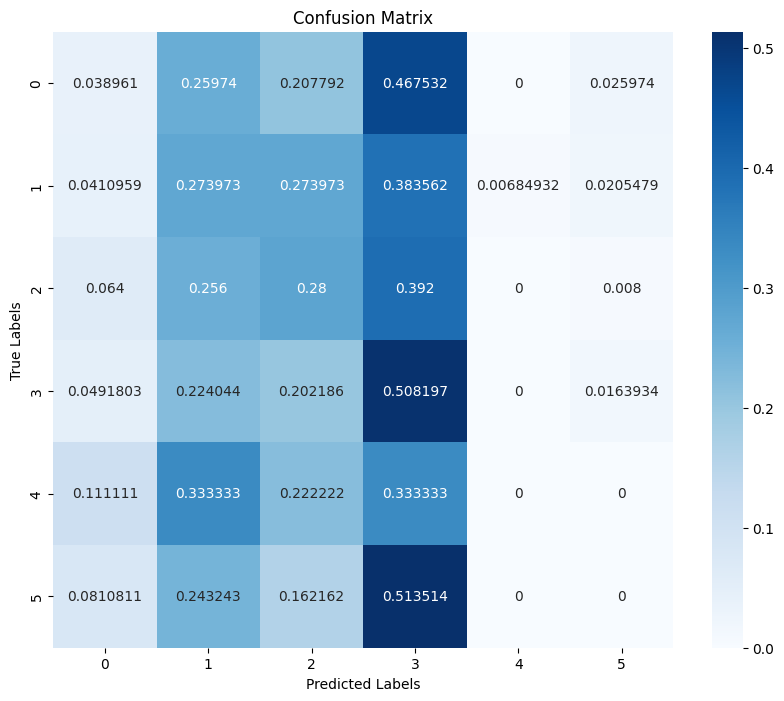

Test Loss: 4.038, Accuracy: 0.296, F1 Score: 0.270, F1 Score Per Class [0.056
Test F1 Score Per Class  [0.05607477 0.27491409 0.26819923 0.42369021 0.         0.        ]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=2e-04)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
patch_size=(224, 224)
stride=30
test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(trained_model, test_loader, criterion, device, patch_size, stride, desc='Test')
print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
print(f'Test F1 Score Per Class ', test_f1_per_class)